# Workflow

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import sys

sys.path.append('../hydra_tod/')

from astropy.coordinates import EarthLocation, AltAz, SkyCoord
from astropy.time import Time, TimeDelta
import astropy.units as u
from utils import Leg_poly_proj, view_samples
from flicker_model import sim_noise, flicker_cov
from simulation import * 

In [2]:
# Import the FlickerCorrEmulator class first
from flicker_model import FlickerCorrEmulator

# Then import from noise_sampler_fixed_fc
from noise_sampler_fixed_fc import flicker_noise_sampler, flicker_likeli_func

Using the emulator for flicker noise correlation function.


In [3]:
# Load the simulation results
import pickle
from simulation import TODSimulation

with open('tod_simulation_single.pkl', 'rb') as f:
    tod_sim = pickle.load(f)


In [4]:
sky_params = tod_sim.sky_params
nd_rec_params = tod_sim.nd_rec_params
gain_params_setting = tod_sim.gain_params_setting
calibration_indices = tod_sim.calibration_1_indice
alpha = tod_sim.alpha

TOD_setting = tod_sim.TOD_setting
t_list = tod_sim.t_list
gain_proj = tod_sim.gain_proj
Tsky_operator_setting = tod_sim.Tsky_operator_setting
nd_rec_operator = tod_sim.nd_rec_operator

logfc = tod_sim.logfc

# Additional variables needed for the analysis
pixel_indices = tod_sim.pixel_indices
nside = tod_sim.nside
f0 = tod_sim.f0
T_ndiode = tod_sim.T_ndiode
rec_params = tod_sim.rec_params
logf0_list = [tod_sim.logf0]  # Convert to list format as expected later

In [5]:
gain_params_setting

array([6.31194264, 0.42038942, 0.264222  , 0.05578821])

In [6]:
init_Tsys_params = np.hstack([sky_params, nd_rec_params])
init_noise_params = [-4.8, 2.2]

gain_prior_cov_inv = np.zeros(4)
# prior_std_frac = 1
# gain_prior_cov_inv = 1. / (prior_std_frac * gain_params_setting)**2  # Prior STD ~100%
gain_prior_cov_inv[0] = 2.51 # DC mode: Prior STD ~10%
gain_prior_mean = gain_params_setting

prior_std_frac = 0.1
Tsky_prior_cov_inv = 1. / (prior_std_frac * sky_params)**2
Tsky_prior_cov_inv[calibration_indices] = 1e20

aux = np.ones_like(nd_rec_params)*0.0
aux[0] = 1
Trec_prior_cov_inv = [aux] # Effectlively no prior


In [7]:
# Import the FlickerCorrEmulator class first
from flicker_model import FlickerCorrEmulator
from full_Gibbs_sampler import full_Gibbs_sampler_multi_TODS_v2

Tsys_samples, all_gain_samples, all_noise_samples = \
    full_Gibbs_sampler_multi_TODS_v2([TOD_setting],
                                    [t_list],
                                    [gain_proj],
                                    [Tsky_operator_setting],
                                    [nd_rec_operator],
                                    init_Tsys_params,
                                    init_noise_params, 
                                    [logfc],
                                    num_Jeffrey=False,
                                    wnoise_var=2.5e-6,
                                    Tsky_prior_cov_inv=Tsky_prior_cov_inv,
                                    Tsky_prior_mean=sky_params,
                                    local_Trec_prior_cov_inv_list=Trec_prior_cov_inv,
                                    local_Trec_prior_mean_list=[nd_rec_params],
                                    local_gain_prior_cov_inv_list=[gain_prior_cov_inv],
                                    local_gain_prior_mean_list=[gain_prior_mean],
                                    #local_noise_prior_func_list=[log_prior_noise, log_prior_noise],
                                    n_samples=10000,
                                    tol=1e-20,
                                    Est_mode=False)

# First, save the samples as npy files..

np.save("outputs/GS1/Tsys_samples_1e4.npy", Tsys_samples)
np.save("outputs/GS1/gain_samples_1e4.npy", np.concatenate(all_gain_samples, axis=0))
np.save("outputs/GS1/noise_samples_1e4.npy", np.concatenate(all_noise_samples, axis=0))

Rank: 0, local id: 0, gain_sample 0: [6.3119986  0.41919264 0.26108141 0.05585835]
Rank: 0, local id: 0, noise_sample 0: [-5.73604811  1.42197807]
Reached max iterations with fractional norm error 0.0006425900495151972.
Rank: 0, local id: 0, gain_sample 1: [6.31192584 0.41994403 0.26049231 0.0562363 ]
Rank: 0, local id: 0, noise_sample 1: [-4.95011369  2.42158421]
Reached max iterations with fractional norm error 0.003235610932257907.
Rank: 0, local id: 0, gain_sample 2: [6.31212625 0.42114896 0.26031218 0.05486269]
Rank: 0, local id: 0, noise_sample 2: [-3.98784463  3.48871976]
Reached max iterations with fractional norm error 0.002103494092955168.
Rank: 0, local id: 0, gain_sample 3: [6.31204131 0.42102547 0.2613905  0.05416999]
Rank: 0, local id: 0, noise_sample 3: [-5.35244932  1.72877229]
Reached max iterations with fractional norm error 0.00022343929818342408.
Rank: 0, local id: 0, gain_sample 4: [6.31208649 0.42195218 0.2622013  0.05073089]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 4: [-4.91917597  1.88895675]
Reached max iterations with fractional norm error 0.0017014544527541742.
Rank: 0, local id: 0, gain_sample 5: [6.31236946 0.42244481 0.26247198 0.05330744]
Rank: 0, local id: 0, noise_sample 5: [-4.48576835  2.70410509]
Reached max iterations with fractional norm error 0.00019687288932615632.
Rank: 0, local id: 0, gain_sample 6: [6.31239513 0.42279098 0.26368722 0.05369852]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 6: [-3.36361945  3.97799105]
Reached max iterations with fractional norm error 0.00024012761905822604.
Rank: 0, local id: 0, gain_sample 7: [6.31278611 0.429922   0.28414898 0.05596393]
Rank: 0, local id: 0, noise_sample 7: [-3.9036723   2.39336105]
Reached max iterations with fractional norm error 0.0005227544680802671.
Rank: 0, local id: 0, gain_sample 8: [6.31220884 0.42680583 0.2910676  0.06743924]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 8: [-3.27521246  3.84204327]
Reached max iterations with fractional norm error 0.0008800140997656798.
Rank: 0, local id: 0, gain_sample 9: [6.31244841 0.4286203  0.31009879 0.04774383]
Rank: 0, local id: 0, noise_sample 9: [-4.27932029  1.81067966]
Reached max iterations with fractional norm error 0.0002336596451127945.
Rank: 0, local id: 0, gain_sample 10: [6.31079899 0.42834985 0.29099609 0.04389761]
Rank: 0, local id: 0, noise_sample 10: [-4.59788928  1.61982382]
Reached max iterations with fractional norm error 0.0007693261749680935.
Rank: 0, local id: 0, gain_sample 11: [6.31106383 0.42424722 0.28613865 0.05181576]
Rank: 0, local id: 0, noise_sample 11: [-3.95319541  2.07031406]
Reached max iterations with fractional norm error 0.0009458426446578743.
Rank: 0, local id: 0, gain_sample 12: [6.31008314 0.42234909 0.27028405 0.04993713]
Rank: 0, local id: 0, noise_sample 12: [-3.90132206  2.19718024]
Reached max iterations with fractional norm error 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 13: [-4.024878    2.06471645]
Reached max iterations with fractional norm error 0.0004093906344867268.
Rank: 0, local id: 0, gain_sample 14: [6.30966369 0.41574108 0.26513334 0.04462673]
Rank: 0, local id: 0, noise_sample 14: [-4.67828071  1.65462793]
Reached max iterations with fractional norm error 0.0009403318037635728.
Rank: 0, local id: 0, gain_sample 15: [6.30934119 0.42126447 0.26479857 0.03500638]
Rank: 0, local id: 0, noise_sample 15: [-4.47125045  1.86362315]
Reached max iterations with fractional norm error 0.0004109444249138983.
Rank: 0, local id: 0, gain_sample 16: [6.31020078 0.41970915 0.26561252 0.04099247]
Rank: 0, local id: 0, noise_sample 16: [-3.22992957  3.23939254]
Reached max iterations with fractional norm error 0.0011707534642035624.
Rank: 0, local id: 0, gain_sample 17: [6.31547997 0.42542964 0.30519793 0.06398658]
Rank: 0, local id: 0, noise_sample 17: [-3.18197425  3.30187471]
Reached max iterations with fractional norm err

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 26: [-4.73190171  1.76064853]
Reached max iterations with fractional norm error 0.0005786729189909262.
Rank: 0, local id: 0, gain_sample 27: [6.31013592 0.41849899 0.27009525 0.04733624]
Rank: 0, local id: 0, noise_sample 27: [-4.63473629  1.91502527]
Reached max iterations with fractional norm error 0.0001618763704918495.
Rank: 0, local id: 0, gain_sample 28: [6.31046549 0.4209534  0.27255826 0.0417323 ]
Rank: 0, local id: 0, noise_sample 28: [-4.47785302  2.08577625]
Reached max iterations with fractional norm error 2.376942938964832e-05.
Rank: 0, local id: 0, gain_sample 29: [6.30997679 0.42091786 0.27323578 0.04748278]
Rank: 0, local id: 0, noise_sample 29: [-4.521209    2.13972724]
Reached max iterations with fractional norm error 0.00047760619652759974.
Rank: 0, local id: 0, gain_sample 30: [6.30934367 0.42319691 0.26831472 0.04478799]
Rank: 0, local id: 0, noise_sample 30: [-4.42345748  2.17073004]
Reached max iterations with fractional norm er

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 39: [-4.14116816  2.6191081 ]
Reached max iterations with fractional norm error 0.0014816697553241308.
Rank: 0, local id: 0, gain_sample 40: [6.30850799 0.42043788 0.25515703 0.03847235]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 40: [-4.06771879  2.7496164 ]
Reached max iterations with fractional norm error 0.0013130824378723724.
Rank: 0, local id: 0, gain_sample 41: [6.30859468 0.4217935  0.25856883 0.0363273 ]
Rank: 0, local id: 0, noise_sample 41: [-4.25219274  2.69084084]
Reached max iterations with fractional norm error 0.0024532640237415063.
Rank: 0, local id: 0, gain_sample 42: [6.30882754 0.4220848  0.25914391 0.04120983]
Rank: 0, local id: 0, noise_sample 42: [-5.32024941  1.85797957]
Reached max iterations with fractional norm error 0.00021405535999516654.
Rank: 0, local id: 0, gain_sample 43: [6.30899131 0.42248803 0.25935751 0.04061207]
Rank: 0, local id: 0, noise_sample 43: [-5.51103548  1.65541056]
Reached max iterations with fractional norm error 0.00016648849901089202.
Rank: 0, local id: 0, gain_sample 44: [6.30911874 0.42305042 0.26031758 0.03939869]
Rank: 0, local id: 0, noise_sample 44: [-5.78445112  1.6565233 ]
Reached max iterations with fractional norm e

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 52: [-4.01725588  3.64046692]
Reached max iterations with fractional norm error 0.005949459021970483.
Rank: 0, local id: 0, gain_sample 53: [6.30900324 0.42433675 0.25885979 0.04072395]
Rank: 0, local id: 0, noise_sample 53: [-5.55470324  3.01420426]
Reached max iterations with fractional norm error 0.00036447716866758553.
Rank: 0, local id: 0, gain_sample 54: [6.30894759 0.42484069 0.25816455 0.04021109]
Rank: 0, local id: 0, noise_sample 54: [-5.47070587  1.92101408]
Reached max iterations with fractional norm error 0.0006296548587794073.
Rank: 0, local id: 0, gain_sample 55: [6.30887039 0.42526935 0.25937773 0.04042998]
Rank: 0, local id: 0, noise_sample 55: [-5.32268777  2.05200319]
Reached max iterations with fractional norm error 0.0007039425109023403.
Rank: 0, local id: 0, gain_sample 56: [6.30898867 0.42464177 0.25984444 0.04069599]
Rank: 0, local id: 0, noise_sample 56: [-4.65964062  3.4715232 ]
Reached max iterations with fractional norm err

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 57: [-5.17821475  3.26173698]
Reached max iterations with fractional norm error 0.00048245859711720454.
Rank: 0, local id: 0, gain_sample 58: [6.30889253 0.42505242 0.25952618 0.04007691]
Rank: 0, local id: 0, noise_sample 58: [-5.51748178  2.87399129]
Reached max iterations with fractional norm error 0.0008095496012827806.
Rank: 0, local id: 0, gain_sample 59: [6.30879301 0.42537442 0.25983547 0.03996071]
Rank: 0, local id: 0, noise_sample 59: [-5.33545721  2.60748126]
Reached max iterations with fractional norm error 0.0001610533834770846.
Rank: 0, local id: 0, gain_sample 60: [6.3088725  0.42540481 0.26121224 0.04022787]
Rank: 0, local id: 0, noise_sample 60: [-5.90521913  2.52757302]
Reached max iterations with fractional norm error 0.0001572967540823278.
Rank: 0, local id: 0, gain_sample 61: [6.30876818 0.42547715 0.26196059 0.04107246]
Rank: 0, local id: 0, noise_sample 61: [-5.47538837  1.99393443]
Reached max iterations with fractional norm er

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 69: [-5.31129787  1.8634588 ]
Reached max iterations with fractional norm error 0.0008119292165793846.
Rank: 0, local id: 0, gain_sample 70: [6.30755915 0.4225283  0.2656313  0.04292152]
Rank: 0, local id: 0, noise_sample 70: [-5.72063953  2.22378155]
Reached max iterations with fractional norm error 0.00029197784893900884.
Rank: 0, local id: 0, gain_sample 71: [6.30731303 0.42245259 0.26539908 0.04281972]
Rank: 0, local id: 0, noise_sample 71: [-5.57580193  3.43396955]
Reached max iterations with fractional norm error 0.00021854937232080088.
Rank: 0, local id: 0, gain_sample 72: [6.30699422 0.42228256 0.26525653 0.04286525]
Rank: 0, local id: 0, noise_sample 72: [-4.39361417  3.77185294]
Reached max iterations with fractional norm error 4.427751218760669e-05.
Rank: 0, local id: 0, gain_sample 73: [6.30741307 0.42244547 0.26511473 0.04258184]
Rank: 0, local id: 0, noise_sample 73: [-4.62480766  3.75506067]
Reached max iterations with fractional norm e

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 104: [-4.34031228  3.43434067]
Reached max iterations with fractional norm error 0.00014472039473048832.
Rank: 0, local id: 0, gain_sample 105: [6.30702439 0.42063149 0.26853633 0.04765099]
Rank: 0, local id: 0, noise_sample 105: [-4.65934657  2.46374294]
Reached max iterations with fractional norm error 0.0024812361986839325.
Rank: 0, local id: 0, gain_sample 106: [6.30735745 0.41916072 0.26935042 0.04800855]
Rank: 0, local id: 0, noise_sample 106: [-5.05948565  3.73268694]
Reached max iterations with fractional norm error 0.0011635116261326745.
Rank: 0, local id: 0, gain_sample 107: [6.30671387 0.41990199 0.26881199 0.04788284]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 107: [-5.14973454  2.34713684]
Reached max iterations with fractional norm error 0.002948848693306217.
Rank: 0, local id: 0, gain_sample 108: [6.30651795 0.42005384 0.26841985 0.04788043]
Rank: 0, local id: 0, noise_sample 108: [-5.69536334  2.22452943]
Reached max iterations with fractional norm error 0.0001819920384502269.
Rank: 0, local id: 0, gain_sample 109: [6.30641512 0.41985775 0.26807696 0.04789511]
Rank: 0, local id: 0, noise_sample 109: [-5.09834533  1.91569797]
Reached max iterations with fractional norm error 0.00020265417605392196.
Rank: 0, local id: 0, gain_sample 110: [6.30604748 0.41859685 0.26876567 0.04778105]
Rank: 0, local id: 0, noise_sample 110: [-4.13047353  3.77533102]
Reached max iterations with fractional norm error 0.0002399635283232839.
Rank: 0, local id: 0, gain_sample 111: [6.30641069 0.41927709 0.26863945 0.04758571]
Rank: 0, local id: 0, noise_sample 111: [-5.80509282  2.00742779]
Reached max iterations with fractional

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 134: [-3.24804     3.27016114]
Reached max iterations with fractional norm error 0.0026721704836111908.
Rank: 0, local id: 0, gain_sample 135: [6.30531966 0.40050727 0.3030667  0.06590308]
Rank: 0, local id: 0, noise_sample 135: [-3.402404    2.72713759]
Reached max iterations with fractional norm error 9.990867385218609e-05.
Rank: 0, local id: 0, gain_sample 136: [6.30262062 0.42596196 0.26680968 0.03887839]
Rank: 0, local id: 0, noise_sample 136: [-3.80413405  2.20492816]
Reached max iterations with fractional norm error 0.003415712113610223.
Rank: 0, local id: 0, gain_sample 137: [6.30098763 0.42060147 0.25683232 0.06762723]
Rank: 0, local id: 0, noise_sample 137: [-4.46889752  1.69773232]
Reached max iterations with fractional norm error 0.00034643801489972633.
Rank: 0, local id: 0, gain_sample 138: [6.29962892 0.4226927  0.25627754 0.06100522]
Rank: 0, local id: 0, noise_sample 138: [-3.10527551  3.23935477]
Reached max iterations with fractional

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 151: [-3.05027269  3.81310242]
Reached max iterations with fractional norm error 0.00014048342125226346.
Rank: 0, local id: 0, gain_sample 152: [6.31597808 0.39670192 0.32118658 0.10404009]
Rank: 0, local id: 0, noise_sample 152: [-3.51528739  2.50306547]
Reached max iterations with fractional norm error 0.0005230647988506833.
Rank: 0, local id: 0, gain_sample 153: [6.31200781 0.42161129 0.30590836 0.04757339]
Rank: 0, local id: 0, noise_sample 153: [-3.30438581  3.2028118 ]
Reached max iterations with fractional norm error 0.000942012231638257.
Rank: 0, local id: 0, gain_sample 154: [6.30896462 0.40029561 0.25607016 0.06338032]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 154: [-3.03200552  3.17013192]
Reached max iterations with fractional norm error 0.002398999532384235.
Rank: 0, local id: 0, gain_sample 155: [6.30558016 0.43791357 0.23007181 0.04187624]
Rank: 0, local id: 0, noise_sample 155: [-3.70485764  2.18243531]
Reached max iterations with fractional norm error 0.0037795169264149453.
Rank: 0, local id: 0, gain_sample 156: [6.30616957 0.41048922 0.25031315 0.06989862]
Rank: 0, local id: 0, noise_sample 156: [-3.91116131  2.03731329]
Reached max iterations with fractional norm error 0.00012572815549349094.
Rank: 0, local id: 0, gain_sample 157: [6.30692167 0.42557316 0.25397046 0.07268433]
Rank: 0, local id: 0, noise_sample 157: [-3.81968087  2.11986529]
Reached max iterations with fractional norm error 0.0005481735775355833.
Rank: 0, local id: 0, gain_sample 158: [6.30782135 0.41537285 0.26176067 0.06874196]
Rank: 0, local id: 0, noise_sample 158: [-3.8635652   2.09352439]
Reached max iterations with fractional

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 172: [-3.04525154  3.81762889]
Reached max iterations with fractional norm error 0.00034557934564371205.
Rank: 0, local id: 0, gain_sample 173: [6.32057824 0.40229053 0.31581717 0.07023547]
Rank: 0, local id: 0, noise_sample 173: [-3.62007683  2.37615967]
Reached max iterations with fractional norm error 0.0009773767639733543.
Rank: 0, local id: 0, gain_sample 174: [6.31718434 0.41558207 0.26144142 0.03401022]
Rank: 0, local id: 0, noise_sample 174: [-4.87937165  1.46310348]
Reached max iterations with fractional norm error 0.0006290264246010608.
Rank: 0, local id: 0, gain_sample 175: [6.31847552 0.41502604 0.26978797 0.03664446]
Rank: 0, local id: 0, noise_sample 175: [-3.16796928  3.20936137]
Reached max iterations with fractional norm error 0.0018942786697838893.
Rank: 0, local id: 0, gain_sample 176: [6.31870268 0.40683279 0.26773614 0.07190569]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 176: [-3.28168237  3.27271943]
Reached max iterations with fractional norm error 0.0006964892337497197.
Rank: 0, local id: 0, gain_sample 177: [6.31815611 0.41623471 0.28432774 0.07022256]
Rank: 0, local id: 0, noise_sample 177: [-3.72819971  2.58961411]
Reached max iterations with fractional norm error 0.0016340929096281959.
Rank: 0, local id: 0, gain_sample 178: [6.318187   0.42877884 0.28383301 0.04325919]
Rank: 0, local id: 0, noise_sample 178: [-4.11684352  2.10971087]
Reached max iterations with fractional norm error 0.001292874393889414.
Rank: 0, local id: 0, gain_sample 179: [6.31732559 0.42218864 0.26801882 0.05254525]
Rank: 0, local id: 0, noise_sample 179: [-4.34230998  1.85617933]
Reached max iterations with fractional norm error 0.0007955341214884912.
Rank: 0, local id: 0, gain_sample 180: [6.31923717 0.42364627 0.27922073 0.0449042 ]
Rank: 0, local id: 0, noise_sample 180: [-4.33096863  1.93094105]
Reached max iterations with fractional 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 199: [-3.90475583  2.2148126 ]
Reached max iterations with fractional norm error 0.0017681852533827959.
Rank: 0, local id: 0, gain_sample 200: [6.31971172 0.42977061 0.25698337 0.04695355]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 200: [-3.31289839  3.83156986]
Reached max iterations with fractional norm error 0.0003598304855496147.
Rank: 0, local id: 0, gain_sample 201: [6.3206901  0.42293511 0.24502018 0.0557741 ]
Rank: 0, local id: 0, noise_sample 201: [-3.65471428  2.94786097]
Reached max iterations with fractional norm error 0.0013491563731100966.
Rank: 0, local id: 0, gain_sample 202: [6.32072006 0.42468387 0.25895317 0.05777501]
Rank: 0, local id: 0, noise_sample 202: [-3.71261524  2.9294673 ]
Reached max iterations with fractional norm error 0.0014293568319040484.
Rank: 0, local id: 0, gain_sample 203: [6.3209254  0.42702655 0.25874589 0.0553715 ]
Rank: 0, local id: 0, noise_sample 203: [-3.75547897  3.06304293]
Reached max iterations with fractional norm error 0.0005881503640273174.
Rank: 0, local id: 0, gain_sample 204: [6.32140056 0.42668564 0.2555293  0.05559362]
Rank: 0, local id: 0, noise_sample 204: [-3.7999376   3.04282458]
Reached max iterations with fractional

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 214: [-4.01774551  2.80793706]
Reached max iterations with fractional norm error 0.0006498972957949763.
Rank: 0, local id: 0, gain_sample 215: [6.32270834 0.42373373 0.2705071  0.05087696]
Rank: 0, local id: 0, noise_sample 215: [-4.46165226  2.02206714]
Reached max iterations with fractional norm error 0.00042580371804857106.
Rank: 0, local id: 0, gain_sample 216: [6.32313392 0.42233826 0.2754226  0.04460328]
Rank: 0, local id: 0, noise_sample 216: [-4.07616981  2.39158829]
Reached max iterations with fractional norm error 0.0006210010121498232.
Rank: 0, local id: 0, gain_sample 217: [6.32326439 0.41971693 0.27659729 0.03810825]
Rank: 0, local id: 0, noise_sample 217: [-4.82011289  1.68725808]
Reached max iterations with fractional norm error 0.0005628180136648113.
Rank: 0, local id: 0, gain_sample 218: [6.32320828 0.41889877 0.27579876 0.04200932]
Rank: 0, local id: 0, noise_sample 218: [-5.11425014  1.62136022]
Reached max iterations with fractiona

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 231: [-3.33205777  3.96566061]
Reached max iterations with fractional norm error 0.0022859749825845386.
Rank: 0, local id: 0, gain_sample 232: [6.32532369 0.43321382 0.25926357 0.03709898]
Rank: 0, local id: 0, noise_sample 232: [-4.01361215  2.23411675]
Reached max iterations with fractional norm error 4.19213802204147e-05.
Rank: 0, local id: 0, gain_sample 233: [6.32544975 0.42909536 0.2641828  0.03145507]
Rank: 0, local id: 0, noise_sample 233: [-3.74049543  2.67535237]
Reached max iterations with fractional norm error 0.00032370654554650337.
Rank: 0, local id: 0, gain_sample 234: [6.32549078 0.43426108 0.2714843  0.02784894]
Rank: 0, local id: 0, noise_sample 234: [-3.8716733   2.43309942]
Reached max iterations with fractional norm error 0.00019630223663586198.
Rank: 0, local id: 0, gain_sample 235: [6.32365077 0.42738472 0.26236414 0.03978669]
Rank: 0, local id: 0, noise_sample 235: [-4.62324696  1.78938133]
Reached max iterations with fractiona

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 241: [-3.61378371  3.4843425 ]
Reached max iterations with fractional norm error 0.0005159281936230225.
Rank: 0, local id: 0, gain_sample 242: [6.32533051 0.42463148 0.27673279 0.04958526]
Rank: 0, local id: 0, noise_sample 242: [-4.43467989  2.09222   ]
Reached max iterations with fractional norm error 0.0017392182852986405.
Rank: 0, local id: 0, gain_sample 243: [6.32481701 0.42407091 0.2689817  0.04851032]
Rank: 0, local id: 0, noise_sample 243: [-3.82167772  3.47160091]
Reached max iterations with fractional norm error 7.08080382547865e-05.
Rank: 0, local id: 0, gain_sample 244: [6.32484079 0.42247924 0.26722969 0.0458108 ]
Rank: 0, local id: 0, noise_sample 244: [-4.03692109  2.98412769]
Reached max iterations with fractional norm error 0.00014238433097678763.
Rank: 0, local id: 0, gain_sample 245: [6.32469134 0.42148186 0.26454457 0.04338141]
Rank: 0, local id: 0, noise_sample 245: [-4.2235777   2.77169397]
Reached max iterations with fractional

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 253: [-3.13592691  3.98167157]
Reached max iterations with fractional norm error 7.8451125881458e-05.
Rank: 0, local id: 0, gain_sample 254: [6.32407917 0.43718438 0.27861021 0.05990575]
Rank: 0, local id: 0, noise_sample 254: [-3.71970874  2.8948493 ]
Reached max iterations with fractional norm error 0.0009770077071944241.
Rank: 0, local id: 0, gain_sample 255: [6.32433373 0.42803661 0.27389179 0.06943099]
Rank: 0, local id: 0, noise_sample 255: [-4.23438475  1.87900101]
Reached max iterations with fractional norm error 0.0004162960313126235.
Rank: 0, local id: 0, gain_sample 256: [6.32532471 0.42230723 0.27271301 0.07138872]
Rank: 0, local id: 0, noise_sample 256: [-4.18197749  1.8696451 ]
Reached max iterations with fractional norm error 0.007248531699971889.
Rank: 0, local id: 0, gain_sample 257: [6.3249978  0.4343894  0.27429865 0.04438916]
Rank: 0, local id: 0, noise_sample 257: [-3.95750878  2.20778573]
Reached max iterations with fractional no

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 262: [-4.12073405  2.13948764]
Reached max iterations with fractional norm error 0.001548725224010523.
Rank: 0, local id: 0, gain_sample 263: [6.32340802 0.41829363 0.26451745 0.03976161]
Rank: 0, local id: 0, noise_sample 263: [-3.76915706  2.63041612]
Reached max iterations with fractional norm error 0.0003301071880157606.
Rank: 0, local id: 0, gain_sample 264: [6.32332215 0.42758031 0.26091028 0.02623151]
Rank: 0, local id: 0, noise_sample 264: [-4.25856026  2.07456891]
Reached max iterations with fractional norm error 0.000540041092856099.
Rank: 0, local id: 0, gain_sample 265: [6.32407595 0.4275985  0.26437576 0.03580461]
Rank: 0, local id: 0, noise_sample 265: [-4.46094984  1.9242986 ]
Reached max iterations with fractional norm error 0.0009874361158307965.
Rank: 0, local id: 0, gain_sample 266: [6.32441015 0.42609122 0.27085157 0.03719695]
Rank: 0, local id: 0, noise_sample 266: [-4.65182272  1.77280107]
Reached max iterations with fractional n

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 278: [-5.71091677  1.72768762]
Reached max iterations with fractional norm error 0.0005041643328819084.
Rank: 0, local id: 0, gain_sample 279: [6.32316646 0.42526019 0.26475558 0.04481239]
Rank: 0, local id: 0, noise_sample 279: [-5.73152431  1.8529917 ]
Reached max iterations with fractional norm error 0.0033172233806075062.
Rank: 0, local id: 0, gain_sample 280: [6.32337256 0.42539901 0.2654182  0.04461632]
Rank: 0, local id: 0, noise_sample 280: [-5.19386105  3.65824125]
Reached max iterations with fractional norm error 0.0004898422182609451.
Rank: 0, local id: 0, gain_sample 281: [6.32330517 0.42571081 0.26524513 0.04513891]
Rank: 0, local id: 0, noise_sample 281: [-4.0751646   3.68747902]
Reached max iterations with fractional norm error 0.0002524084934281257.
Rank: 0, local id: 0, gain_sample 282: [6.32344348 0.42634116 0.26446026 0.04250881]
Rank: 0, local id: 0, noise_sample 282: [-4.62348003  2.42299974]
Reached max iterations with fractional

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 290: [-3.17038022  3.84194058]
Reached max iterations with fractional norm error 7.531009527752314e-05.
Rank: 0, local id: 0, gain_sample 291: [6.32608551 0.45331707 0.2681285  0.01258866]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 291: [-3.65476462  2.57892976]
Reached max iterations with fractional norm error 0.0005328806455251833.
Rank: 0, local id: 0, gain_sample 292: [6.32735611 0.43180859 0.26181864 0.0362187 ]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 292: [-5.661467    1.30531054]
Reached max iterations with fractional norm error 0.0002631859858549089.
Rank: 0, local id: 0, gain_sample 293: [6.32705328 0.43144122 0.26228146 0.03338076]
Rank: 0, local id: 0, noise_sample 293: [-4.42660421  1.98511055]
Reached max iterations with fractional norm error 0.002419160914489136.
Rank: 0, local id: 0, gain_sample 294: [6.32675834 0.42783125 0.25673673 0.04361604]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 294: [-4.21931133  2.18416852]
Reached max iterations with fractional norm error 0.001614672030135754.
Rank: 0, local id: 0, gain_sample 295: [6.32804924 0.43068932 0.26951601 0.052524  ]
Rank: 0, local id: 0, noise_sample 295: [-4.58113178  1.81388898]
Reached max iterations with fractional norm error 0.0005074478719353454.
Rank: 0, local id: 0, gain_sample 296: [6.32844336 0.42915592 0.26952566 0.05402577]
Rank: 0, local id: 0, noise_sample 296: [-4.94629028  1.67431864]
Reached max iterations with fractional norm error 0.0004404213579177593.
Rank: 0, local id: 0, gain_sample 297: [6.32814799 0.42959098 0.26776681 0.05023532]
Rank: 0, local id: 0, noise_sample 297: [-5.1514422   1.63473483]
Reached max iterations with fractional norm error 0.00029923526858089447.
Rank: 0, local id: 0, gain_sample 298: [6.32884518 0.43003493 0.26584488 0.05191388]
Rank: 0, local id: 0, noise_sample 298: [-4.30842212  2.57020577]
Reached max iterations with fractional

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 299: [-4.61932975  2.11260194]
Reached max iterations with fractional norm error 0.000891769001724988.
Rank: 0, local id: 0, gain_sample 300: [6.32889261 0.42905579 0.26260629 0.05138638]
Rank: 0, local id: 0, noise_sample 300: [-4.03131993  2.84268389]
Reached max iterations with fractional norm error 0.00043922736535291425.
Rank: 0, local id: 0, gain_sample 301: [6.32868713 0.43091315 0.266944   0.04648642]
Rank: 0, local id: 0, noise_sample 301: [-3.89975317  3.40835795]
Reached max iterations with fractional norm error 4.149380297053759e-05.
Rank: 0, local id: 0, gain_sample 302: [6.32900337 0.42870957 0.26693805 0.0457315 ]
Rank: 0, local id: 0, noise_sample 302: [-4.17710392  2.92184218]
Reached max iterations with fractional norm error 0.00013474172466931616.
Rank: 0, local id: 0, gain_sample 303: [6.32904378 0.42825124 0.26720712 0.04727807]
Rank: 0, local id: 0, noise_sample 303: [-4.18889555  3.005334  ]
Reached max iterations with fractiona

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/s

Rank: 0, local id: 0, noise_sample 336: [-3.00655774  3.85132964]
Reached max iterations with fractional norm error 0.0006737765563025988.
Rank: 0, local id: 0, gain_sample 337: [6.32273729 0.43477744 0.26453546 0.03853636]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 337: [-3.0566597   3.82777151]
Reached max iterations with fractional norm error 0.0013433679172186396.
Rank: 0, local id: 0, gain_sample 338: [6.32129259 0.40749335 0.20983529 0.04539654]
Rank: 0, local id: 0, noise_sample 338: [-3.65185448  2.320574  ]
Reached max iterations with fractional norm error 0.0006718597024183827.
Rank: 0, local id: 0, gain_sample 339: [6.32519995 0.42480126 0.24878769 0.04816505]
Rank: 0, local id: 0, noise_sample 339: [-3.68834908  2.30146072]
Reached max iterations with fractional norm error 0.00019735532819173572.
Rank: 0, local id: 0, gain_sample 340: [6.32756839 0.42514282 0.27240475 0.04881006]
Rank: 0, local id: 0, noise_sample 340: [-3.66692391  2.55855699]
Reached max iterations with fractional norm error 0.0002808447411185525.
Rank: 0, local id: 0, gain_sample 341: [6.32838043 0.42835785 0.26260264 0.04624767]
Rank: 0, local id: 0, noise_sample 341: [-4.62560739  1.74664881]
Reached max iterations with fractiona

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 343: [-3.1749931   3.84132738]
Reached max iterations with fractional norm error 8.858186646377762e-05.
Rank: 0, local id: 0, gain_sample 344: [6.33157414 0.43892945 0.29009777 0.04297797]
Rank: 0, local id: 0, noise_sample 344: [-3.60320702  2.73889452]
Reached max iterations with fractional norm error 0.0006334599917081807.
Rank: 0, local id: 0, gain_sample 345: [6.33276153 0.43608681 0.30220803 0.04266657]
Rank: 0, local id: 0, noise_sample 345: [-3.68622776  2.68708113]
Reached max iterations with fractional norm error 0.0012521548607495887.
Rank: 0, local id: 0, gain_sample 346: [6.33386667 0.42681108 0.29211321 0.04935673]
Rank: 0, local id: 0, noise_sample 346: [-3.23737413  3.79851722]
Reached max iterations with fractional norm error 0.007009337234775714.
Rank: 0, local id: 0, gain_sample 347: [6.33156968 0.43227148 0.26838015 0.03015502]
Rank: 0, local id: 0, noise_sample 347: [-4.02540245  2.21818837]
Reached max iterations with fractional 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 355: [-5.79405116  1.13435827]
Reached max iterations with fractional norm error 0.001229961778810085.
Rank: 0, local id: 0, gain_sample 356: [6.34102866 0.42609167 0.2915612  0.06632267]
Rank: 0, local id: 0, noise_sample 356: [-5.00418384  1.38838595]
Reached max iterations with fractional norm error 0.0019240201642226555.
Rank: 0, local id: 0, gain_sample 357: [6.33876159 0.42169558 0.2788122  0.06458127]
Rank: 0, local id: 0, noise_sample 357: [-5.10534087  1.40766305]
Reached max iterations with fractional norm error 3.824620024870887e-05.
Rank: 0, local id: 0, gain_sample 358: [6.33777298 0.42225776 0.27007542 0.05130707]
Rank: 0, local id: 0, noise_sample 358: [-4.77133136  1.64295104]
Reached max iterations with fractional norm error 0.0001760743614804754.
Rank: 0, local id: 0, gain_sample 359: [6.33667575 0.4273041  0.26803606 0.04242514]
Rank: 0, local id: 0, noise_sample 359: [-3.04587705  3.19048011]
Reached max iterations with fractional 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 364: [-5.03569779  1.46168806]
Reached max iterations with fractional norm error 0.011331231842703899.
Rank: 0, local id: 0, gain_sample 365: [6.32712816 0.42525127 0.25032453 0.05351196]
Rank: 0, local id: 0, noise_sample 365: [-4.5800898   1.72140442]
Reached max iterations with fractional norm error 0.00016741114874872667.
Rank: 0, local id: 0, gain_sample 366: [6.32697355 0.42694311 0.25212802 0.05542851]
Rank: 0, local id: 0, noise_sample 366: [-4.27920047  2.00922995]
Reached max iterations with fractional norm error 0.0004920793046274314.
Rank: 0, local id: 0, gain_sample 367: [6.32726899 0.42517307 0.25338143 0.05492731]
Rank: 0, local id: 0, noise_sample 367: [-4.1748418   2.06902452]
Reached max iterations with fractional norm error 0.00033131046607163346.
Rank: 0, local id: 0, gain_sample 368: [6.32707851 0.42760579 0.25139883 0.04815877]
Rank: 0, local id: 0, noise_sample 368: [-4.1413357   2.11966956]
Reached max iterations with fractiona

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 375: [-4.06417009  2.70218188]
Reached max iterations with fractional norm error 0.00020473767788015343.
Rank: 0, local id: 0, gain_sample 376: [6.32785804 0.42183774 0.26464686 0.04754776]
Rank: 0, local id: 0, noise_sample 376: [-4.31926672  2.37536525]
Reached max iterations with fractional norm error 0.0001008860956006356.
Rank: 0, local id: 0, gain_sample 377: [6.32703805 0.42214885 0.25977674 0.04412035]
Rank: 0, local id: 0, noise_sample 377: [-5.35456361  1.50400065]
Reached max iterations with fractional norm error 0.0003759726002699167.
Rank: 0, local id: 0, gain_sample 378: [6.32719988 0.42226628 0.26375653 0.04928601]
Rank: 0, local id: 0, noise_sample 378: [-4.74217151  2.23303035]
Reached max iterations with fractional norm error 0.00039176509521931597.
Rank: 0, local id: 0, gain_sample 379: [6.32705479 0.42227762 0.26391466 0.04707289]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 379: [-4.6935792   2.32549767]
Reached max iterations with fractional norm error 0.0005317518778667754.
Rank: 0, local id: 0, gain_sample 380: [6.32726639 0.42228654 0.26505966 0.04510679]
Rank: 0, local id: 0, noise_sample 380: [-4.26918468  2.7239103 ]
Reached max iterations with fractional norm error 0.00011932910167567039.
Rank: 0, local id: 0, gain_sample 381: [6.32674535 0.4222723  0.26353803 0.04455869]
Rank: 0, local id: 0, noise_sample 381: [-4.89289391  2.06217569]
Reached max iterations with fractional norm error 0.003093392301023445.
Rank: 0, local id: 0, gain_sample 382: [6.32645137 0.42359722 0.26283235 0.0452145 ]
Rank: 0, local id: 0, noise_sample 382: [-3.81501328  3.80320369]
Reached max iterations with fractional norm error 0.00029166647707929555.
Rank: 0, local id: 0, gain_sample 383: [6.32640637 0.42262259 0.2610284  0.04676087]
Rank: 0, local id: 0, noise_sample 383: [-4.80292294  2.40287237]
Reached max iterations with fractiona

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 388: [-4.47368689  2.8177808 ]
Reached max iterations with fractional norm error 0.002116790355043702.
Rank: 0, local id: 0, gain_sample 389: [6.32576765 0.42199739 0.25718773 0.0468646 ]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 389: [-4.60742218  3.0342681 ]
Reached max iterations with fractional norm error 0.003226207013393127.
Rank: 0, local id: 0, gain_sample 390: [6.32551605 0.42206188 0.25749943 0.04643872]
Rank: 0, local id: 0, noise_sample 390: [-5.29824991  2.6595485 ]
Reached max iterations with fractional norm error 9.172592664579987e-05.
Rank: 0, local id: 0, gain_sample 391: [6.3254416  0.42212325 0.25871622 0.04681536]
Rank: 0, local id: 0, noise_sample 391: [-5.48077608  1.90945436]
Reached max iterations with fractional norm error 0.00019880855543102775.
Rank: 0, local id: 0, gain_sample 392: [6.32571314 0.42211821 0.25892989 0.04617804]
Rank: 0, local id: 0, noise_sample 392: [-5.4089361   3.37387073]
Reached max iterations with fractional norm error 6.517065119800997e-05.
Rank: 0, local id: 0, gain_sample 393: [6.32568532 0.42253122 0.25867912 0.0466739 ]
Rank: 0, local id: 0, noise_sample 393: [-5.46441167  2.85082917]
Reached max iterations with fractional

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 433: [-4.17474282  2.08371082]
Reached max iterations with fractional norm error 0.0026762746813276173.
Rank: 0, local id: 0, gain_sample 434: [6.31648645 0.42045853 0.25940549 0.05579573]
Rank: 0, local id: 0, noise_sample 434: [-5.45906279  1.3270474 ]
Reached max iterations with fractional norm error 0.0008794887935135033.
Rank: 0, local id: 0, gain_sample 435: [6.31619151 0.42068475 0.25849356 0.04680518]
Rank: 0, local id: 0, noise_sample 435: [-4.19761486  2.09614823]
Reached max iterations with fractional norm error 0.0046027944878837546.
Rank: 0, local id: 0, gain_sample 436: [6.31530061 0.42459622 0.25623875 0.04281615]
Rank: 0, local id: 0, noise_sample 436: [-4.2930406   2.05512098]
Reached max iterations with fractional norm error 0.0006824384793452463.
Rank: 0, local id: 0, gain_sample 437: [6.31502901 0.42355787 0.25830371 0.04423973]
Rank: 0, local id: 0, noise_sample 437: [-5.28354302  1.44161005]
Reached max iterations with fractional

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 439: [-5.13359028  1.71050434]
Reached max iterations with fractional norm error 0.00015113507176533976.
Rank: 0, local id: 0, gain_sample 440: [6.31532688 0.42278379 0.25800191 0.04741303]
Rank: 0, local id: 0, noise_sample 440: [-4.39948408  2.18022056]
Reached max iterations with fractional norm error 5.0930501085618327e-05.
Rank: 0, local id: 0, gain_sample 441: [6.31476773 0.42297863 0.25747873 0.04666755]
Rank: 0, local id: 0, noise_sample 441: [-3.71507531  3.3421981 ]
Reached max iterations with fractional norm error 0.0002488744910865099.
Rank: 0, local id: 0, gain_sample 442: [6.31452764 0.42151514 0.26088824 0.04788964]
Rank: 0, local id: 0, noise_sample 442: [-4.1301811   2.48212867]
Reached max iterations with fractional norm error 0.00022149654048108272.
Rank: 0, local id: 0, gain_sample 443: [6.3140379  0.42170654 0.25867782 0.05036852]
Rank: 0, local id: 0, noise_sample 443: [-4.32572356  2.13141249]
Reached max iterations with fractio

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 446: [-3.07418368  3.84162221]
Reached max iterations with fractional norm error 0.0007355112543137348.
Rank: 0, local id: 0, gain_sample 447: [6.31456752 0.4332743  0.27577962 0.0216833 ]
Rank: 0, local id: 0, noise_sample 447: [-3.6262311   2.45546587]
Reached max iterations with fractional norm error 0.0008445174727538627.
Rank: 0, local id: 0, gain_sample 448: [6.31392095 0.44327102 0.25412799 0.02521563]
Rank: 0, local id: 0, noise_sample 448: [-3.97451326  2.17102962]
Reached max iterations with fractional norm error 0.0007066600056347261.
Rank: 0, local id: 0, gain_sample 449: [6.31449637 0.42729846 0.26780107 0.06724195]
Rank: 0, local id: 0, noise_sample 449: [-4.60233891  1.67516571]
Reached max iterations with fractional norm error 0.00024720500480550323.
Rank: 0, local id: 0, gain_sample 450: [6.31611457 0.42395858 0.27896219 0.05692666]
Rank: 0, local id: 0, noise_sample 450: [-4.45706459  1.72017436]
Reached max iterations with fractiona

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/s

Rank: 0, local id: 0, noise_sample 484: [-3.13839302  3.81140208]
Reached max iterations with fractional norm error 0.0011222903376216554.
Rank: 0, local id: 0, gain_sample 485: [6.33425441 0.45022001 0.24129967 0.02055042]
Rank: 0, local id: 0, noise_sample 485: [-3.71900311  2.5512833 ]
Reached max iterations with fractional norm error 0.0005901696913728021.
Rank: 0, local id: 0, gain_sample 486: [6.33753051 0.43881139 0.26458574 0.03101217]
Rank: 0, local id: 0, noise_sample 486: [-5.01065863  1.51442035]
Reached max iterations with fractional norm error 0.0001463936410699755.
Rank: 0, local id: 0, gain_sample 487: [6.33767232 0.4337787  0.2672478  0.03722129]
Rank: 0, local id: 0, noise_sample 487: [-4.92964895  1.58430574]
Reached max iterations with fractional norm error 0.001116736584585895.
Rank: 0, local id: 0, gain_sample 488: [6.33703233 0.43142921 0.2598831  0.03470683]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 488: [-5.88142448  1.24032749]
Reached max iterations with fractional norm error 8.800117240770127e-05.
Rank: 0, local id: 0, gain_sample 489: [6.33764324 0.42979708 0.26350228 0.03636539]
Rank: 0, local id: 0, noise_sample 489: [-5.14176216  1.55843362]
Reached max iterations with fractional norm error 0.00046853918201540185.
Rank: 0, local id: 0, gain_sample 490: [6.33770189 0.42915271 0.26346289 0.03830509]
Rank: 0, local id: 0, noise_sample 490: [-4.93660987  1.83579828]
Reached max iterations with fractional norm error 3.8090025201843396e-05.
Rank: 0, local id: 0, gain_sample 491: [6.3376035  0.42892122 0.26231228 0.03942242]
Rank: 0, local id: 0, noise_sample 491: [-4.97963178  1.73399357]
Reached max iterations with fractional norm error 0.00021601418714691897.
Rank: 0, local id: 0, gain_sample 492: [6.33686503 0.42829145 0.25857114 0.03869459]
Rank: 0, local id: 0, noise_sample 492: [-5.63094106  1.35465575]
Reached max iterations with fractio

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 537: [-3.94698725  2.22169857]
Reached max iterations with fractional norm error 0.0008713112368466048.
Rank: 0, local id: 0, gain_sample 538: [6.33362787 0.42328619 0.26907753 0.05337985]
Rank: 0, local id: 0, noise_sample 538: [-4.95274406  1.51024233]
Reached max iterations with fractional norm error 0.006892586539800732.
Rank: 0, local id: 0, gain_sample 539: [6.33322107 0.4224527  0.26584565 0.04568678]
Rank: 0, local id: 0, noise_sample 539: [-4.88945444  1.51764263]
Reached max iterations with fractional norm error 0.00013841688571113362.
Rank: 0, local id: 0, gain_sample 540: [6.3332059  0.42094344 0.26638192 0.04784161]
Rank: 0, local id: 0, noise_sample 540: [-4.93827204  1.57331157]
Reached max iterations with fractional norm error 0.0009020651348890999.
Rank: 0, local id: 0, gain_sample 541: [6.33292718 0.42680792 0.26506588 0.04378306]
Rank: 0, local id: 0, noise_sample 541: [-4.85204076  1.58833595]
Reached max iterations with fractional

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 543: [-5.84335933  1.29877802]
Reached max iterations with fractional norm error 0.0001747824926992176.
Rank: 0, local id: 0, gain_sample 544: [6.33206033 0.42509078 0.26267598 0.05027865]
Rank: 0, local id: 0, noise_sample 544: [-4.85124663  1.97002619]
Reached max iterations with fractional norm error 0.0022153621911837817.
Rank: 0, local id: 0, gain_sample 545: [6.33200965 0.42598045 0.2623795  0.05104631]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 545: [-5.49322542  1.71145198]
Reached max iterations with fractional norm error 0.0010028270404404708.
Rank: 0, local id: 0, gain_sample 546: [6.33210607 0.42581692 0.26161348 0.04908726]
Rank: 0, local id: 0, noise_sample 546: [-4.44047563  3.63629239]
Reached max iterations with fractional norm error 0.00025139823213038475.
Rank: 0, local id: 0, gain_sample 547: [6.33203042 0.42529466 0.2606861  0.04837277]
Rank: 0, local id: 0, noise_sample 547: [-5.17253647  1.98156797]
Reached max iterations with fractional norm error 0.0004304030419048317.
Rank: 0, local id: 0, gain_sample 548: [6.33200052 0.42647928 0.26083751 0.04802085]
Rank: 0, local id: 0, noise_sample 548: [-4.19089784  2.99052052]
Reached max iterations with fractional norm error 0.0004872147077481805.
Rank: 0, local id: 0, gain_sample 549: [6.33245298 0.42726487 0.26161502 0.04709872]
Rank: 0, local id: 0, noise_sample 549: [-4.6794218   2.11298433]
Reached max iterations with fractiona

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 553: [-4.04650884  2.71537147]
Reached max iterations with fractional norm error 0.0011583919021884135.
Rank: 0, local id: 0, gain_sample 554: [6.33201554 0.42194991 0.26448517 0.05836204]
Rank: 0, local id: 0, noise_sample 554: [-4.57030678  2.08690012]
Reached max iterations with fractional norm error 7.952338670864847e-05.
Rank: 0, local id: 0, gain_sample 555: [6.33172718 0.42303118 0.25849388 0.05663573]
Rank: 0, local id: 0, noise_sample 555: [-4.64075033  1.98016671]
Reached max iterations with fractional norm error 0.0007580057827384506.
Rank: 0, local id: 0, gain_sample 556: [6.33235694 0.42463012 0.26224436 0.05980754]
Rank: 0, local id: 0, noise_sample 556: [-4.35212962  2.23074245]
Reached max iterations with fractional norm error 2.490973041271029e-05.
Rank: 0, local id: 0, gain_sample 557: [6.33263029 0.42206256 0.26204076 0.05863604]
Rank: 0, local id: 0, noise_sample 557: [-4.16264914  2.27310529]
Reached max iterations with fractional

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 562: [-5.17026428  1.71201791]
Reached max iterations with fractional norm error 0.0005942237457107838.
Rank: 0, local id: 0, gain_sample 563: [6.33228221 0.42732619 0.26145331 0.04553925]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 563: [-3.14914675  3.82099664]
Reached max iterations with fractional norm error 0.00017483227561327004.
Rank: 0, local id: 0, gain_sample 564: [6.33253787 0.39702352 0.24373836 0.09637109]
Rank: 0, local id: 0, noise_sample 564: [-3.74751633  2.36418447]
Reached max iterations with fractional norm error 0.004080029909739949.
Rank: 0, local id: 0, gain_sample 565: [6.3335795  0.41407096 0.26585917 0.05329531]
Rank: 0, local id: 0, noise_sample 565: [-4.17496029  2.03694614]
Reached max iterations with fractional norm error 0.00023320091391705193.
Rank: 0, local id: 0, gain_sample 566: [6.33367895 0.4151075  0.2667025  0.06037903]
Rank: 0, local id: 0, noise_sample 566: [-4.02785919  2.19148577]
Reached max iterations with fractional norm error 0.0005901804479917301.
Rank: 0, local id: 0, gain_sample 567: [6.33316619 0.4261621  0.27237388 0.06187919]
Rank: 0, local id: 0, noise_sample 567: [-4.61897014  1.70106916]
Reached max iterations with fractiona

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 576: [-4.68636071  1.59612619]
Reached max iterations with fractional norm error 0.0016623508402602253.
Rank: 0, local id: 0, gain_sample 577: [6.32575411 0.41609926 0.25886755 0.04302597]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 577: [-3.0475574   3.83436583]
Reached max iterations with fractional norm error 0.0002813579239202489.
Rank: 0, local id: 0, gain_sample 578: [6.32027798 0.454056   0.22497217 0.01845872]
Rank: 0, local id: 0, noise_sample 578: [-4.51568793  1.56586938]
Reached max iterations with fractional norm error 0.0003101131589567557.
Rank: 0, local id: 0, gain_sample 579: [6.32276744 0.43329135 0.248267   0.04222771]
Rank: 0, local id: 0, noise_sample 579: [-3.87303173  1.99720737]
Reached max iterations with fractional norm error 0.000931627109475681.
Rank: 0, local id: 0, gain_sample 580: [6.32080111 0.42149322 0.24671449 0.05053688]
Rank: 0, local id: 0, noise_sample 580: [-3.85635134  2.08560923]
Reached max iterations with fractional norm error 0.0016650562938733075.
Rank: 0, local id: 0, gain_sample 581: [6.31950045 0.41830197 0.24157497 0.03592188]
Rank: 0, local id: 0, noise_sample 581: [-3.18202127  3.16925553]
Reached max iterations with fractional 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 582: [-3.19417863  2.89148068]
Reached max iterations with fractional norm error 0.0023016664126115065.
Rank: 0, local id: 0, gain_sample 583: [6.32623603 0.42888129 0.2341119  0.01676569]
Rank: 0, local id: 0, noise_sample 583: [-3.88615944  1.98650979]
Reached max iterations with fractional norm error 0.00074365847638233.
Rank: 0, local id: 0, gain_sample 584: [6.32906041 0.42666897 0.26178463 0.03043027]
Rank: 0, local id: 0, noise_sample 584: [-3.86366562  2.10639398]
Reached max iterations with fractional norm error 0.00045941578881677613.
Rank: 0, local id: 0, gain_sample 585: [6.3277236  0.41331207 0.26268133 0.050628  ]
Rank: 0, local id: 0, noise_sample 585: [-4.42368059  1.75408691]
Reached max iterations with fractional norm error 0.000766322314273197.
Rank: 0, local id: 0, gain_sample 586: [6.32879388 0.41149505 0.27199433 0.05227476]
Rank: 0, local id: 0, noise_sample 586: [-5.31151327  1.33495296]
Reached max iterations with fractional n

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 595: [-3.94300449  2.66256476]
Reached max iterations with fractional norm error 0.00031948844031603373.
Rank: 0, local id: 0, gain_sample 596: [6.33168334 0.42597344 0.26316538 0.04762162]
Rank: 0, local id: 0, noise_sample 596: [-3.94660096  2.71207654]
Reached max iterations with fractional norm error 0.002185742524169371.
Rank: 0, local id: 0, gain_sample 597: [6.3315784  0.42462802 0.26512156 0.05601233]
Rank: 0, local id: 0, noise_sample 597: [-4.63961993  1.97330088]
Reached max iterations with fractional norm error 0.002952547854014269.
Rank: 0, local id: 0, gain_sample 598: [6.33165708 0.42407232 0.26861901 0.05461381]
Rank: 0, local id: 0, noise_sample 598: [-5.15839488  1.6406578 ]
Reached max iterations with fractional norm error 0.00020349857692919887.
Rank: 0, local id: 0, gain_sample 599: [6.33195718 0.42495769 0.2670514  0.05204652]
Rank: 0, local id: 0, noise_sample 599: [-5.08237375  1.69999845]
Reached max iterations with fractional

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 601: [-4.30263038  2.40952507]
Reached max iterations with fractional norm error 6.235047039613843e-05.
Rank: 0, local id: 0, gain_sample 602: [6.33142198 0.42377277 0.26008528 0.04700378]
Rank: 0, local id: 0, noise_sample 602: [-5.14543933  1.68647816]
Reached max iterations with fractional norm error 0.0001900302085388347.
Rank: 0, local id: 0, gain_sample 603: [6.3308766  0.42419444 0.26078032 0.0437147 ]
Rank: 0, local id: 0, noise_sample 603: [-4.73097964  1.99830519]
Reached max iterations with fractional norm error 0.0006800478547636915.
Rank: 0, local id: 0, gain_sample 604: [6.33083744 0.42409663 0.25827296 0.04116985]
Rank: 0, local id: 0, noise_sample 604: [-4.14393154  2.6694675 ]
Reached max iterations with fractional norm error 5.164911860712902e-05.
Rank: 0, local id: 0, gain_sample 605: [6.3305331  0.42298992 0.26045654 0.04112641]
Rank: 0, local id: 0, noise_sample 605: [-4.60543402  2.06243014]
Reached max iterations with fractional

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 623: [-3.75532612  3.48659935]
Reached max iterations with fractional norm error 0.0003694651466274632.
Rank: 0, local id: 0, gain_sample 624: [6.32782727 0.4199805  0.25923986 0.03979167]
Rank: 0, local id: 0, noise_sample 624: [-4.63822932  3.78131592]
Reached max iterations with fractional norm error 0.0003543183626372993.
Rank: 0, local id: 0, gain_sample 625: [6.32803391 0.41997714 0.2591126  0.04007804]
Rank: 0, local id: 0, noise_sample 625: [-5.86465876  2.85657602]
Reached max iterations with fractional norm error 0.00026416135902716196.
Rank: 0, local id: 0, gain_sample 626: [6.32810121 0.41976358 0.2587941  0.03998115]
Rank: 0, local id: 0, noise_sample 626: [-5.86587086  3.19260012]
Reached max iterations with fractional norm error 0.0009072066318227104.
Rank: 0, local id: 0, gain_sample 627: [6.32869092 0.42031739 0.25957295 0.03990035]
Rank: 0, local id: 0, noise_sample 627: [-4.44524742  3.45355101]
Reached max iterations with fractiona

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 659: [-5.88167981  1.90477305]
Reached max iterations with fractional norm error 0.0015964019282890874.
Rank: 0, local id: 0, gain_sample 660: [6.32788782 0.41859603 0.26279186 0.05154092]
Rank: 0, local id: 0, noise_sample 660: [-5.516034    3.51262453]
Reached max iterations with fractional norm error 5.671389920849177e-05.
Rank: 0, local id: 0, gain_sample 661: [6.32810025 0.41791601 0.26253238 0.05204353]
Rank: 0, local id: 0, noise_sample 661: [-4.48336153  2.88064432]
Reached max iterations with fractional norm error 0.008088534201804947.
Rank: 0, local id: 0, gain_sample 662: [6.32837702 0.41868608 0.2638824  0.05300612]
Rank: 0, local id: 0, noise_sample 662: [-4.83595887  2.09056446]
Reached max iterations with fractional norm error 0.0038110157423531647.
Rank: 0, local id: 0, gain_sample 663: [6.3289209  0.42054576 0.26422778 0.0533196 ]
Rank: 0, local id: 0, noise_sample 663: [-4.52103081  2.51037537]
Reached max iterations with fractional 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/s

Rank: 0, local id: 0, noise_sample 683: [-4.44717033  1.87501164]
Reached max iterations with fractional norm error 0.0010679582076561394.
Rank: 0, local id: 0, gain_sample 684: [6.32306219 0.41677175 0.26108645 0.04415055]
Rank: 0, local id: 0, noise_sample 684: [-3.8737094   2.55561275]
Reached max iterations with fractional norm error 0.00014306988281096044.
Rank: 0, local id: 0, gain_sample 685: [6.32322131 0.42279921 0.26320089 0.04626762]
Rank: 0, local id: 0, noise_sample 685: [-4.52920646  1.9280396 ]
Reached max iterations with fractional norm error 0.0010352559159024044.
Rank: 0, local id: 0, gain_sample 686: [6.32362162 0.42475156 0.26392466 0.04430302]
Rank: 0, local id: 0, noise_sample 686: [-3.5085085   3.49458952]
Reached max iterations with fractional norm error 0.0024449527760078004.
Rank: 0, local id: 0, gain_sample 687: [6.32307393 0.41314567 0.26594017 0.05902563]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 687: [-3.67785819  2.93411754]
Reached max iterations with fractional norm error 0.00023373446621771933.
Rank: 0, local id: 0, gain_sample 688: [6.32402054 0.42067454 0.26742712 0.04895889]
Rank: 0, local id: 0, noise_sample 688: [-4.05940065  2.33232125]
Reached max iterations with fractional norm error 0.0008227869213083081.
Rank: 0, local id: 0, gain_sample 689: [6.32400077 0.42574291 0.27359576 0.04873467]
Rank: 0, local id: 0, noise_sample 689: [-3.68610859  2.9134361 ]
Reached max iterations with fractional norm error 0.0011496352934889428.
Rank: 0, local id: 0, gain_sample 690: [6.32507429 0.42413067 0.27730506 0.05295761]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 690: [-3.59914855  3.49034765]
Reached max iterations with fractional norm error 5.9484776108136174e-05.
Rank: 0, local id: 0, gain_sample 691: [6.32499374 0.42505499 0.28365766 0.04813608]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 691: [-3.63699678  3.13626755]
Reached max iterations with fractional norm error 0.002744334523371869.
Rank: 0, local id: 0, gain_sample 692: [6.32491724 0.42235658 0.27404221 0.04066415]
Rank: 0, local id: 0, noise_sample 692: [-4.82915229  1.65976756]
Reached max iterations with fractional norm error 0.004586908366165821.
Rank: 0, local id: 0, gain_sample 693: [6.32431674 0.42020858 0.27082417 0.04187552]
Rank: 0, local id: 0, noise_sample 693: [-4.62226864  1.70140519]
Reached max iterations with fractional norm error 0.001933694649821058.
Rank: 0, local id: 0, gain_sample 694: [6.32488082 0.41926176 0.26592818 0.04104628]
Rank: 0, local id: 0, noise_sample 694: [-4.92644612  1.48663174]
Reached max iterations with fractional norm error 0.0006195982012408566.
Rank: 0, local id: 0, gain_sample 695: [6.32468881 0.4197879  0.26591319 0.03602982]
Rank: 0, local id: 0, noise_sample 695: [-4.47300101  1.82682382]
Reached max iterations with fractional no

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 697: [-3.71840192  3.42285578]
Reached max iterations with fractional norm error 0.00033578339784290167.
Rank: 0, local id: 0, gain_sample 698: [6.32575984 0.42370661 0.27170056 0.04541698]
Rank: 0, local id: 0, noise_sample 698: [-4.63296662  2.19932083]
Reached max iterations with fractional norm error 0.00013232406804442338.
Rank: 0, local id: 0, gain_sample 699: [6.3262906  0.42434309 0.27051617 0.04106281]
Rank: 0, local id: 0, noise_sample 699: [-3.80189829  3.46283241]
Reached max iterations with fractional norm error 6.675764804099921e-05.
Rank: 0, local id: 0, gain_sample 700: [6.32620874 0.42180218 0.26697076 0.04034354]
Rank: 0, local id: 0, noise_sample 700: [-4.09879317  2.76763243]
Reached max iterations with fractional norm error 0.0002783220703421983.
Rank: 0, local id: 0, gain_sample 701: [6.32536478 0.42118569 0.26329893 0.0457193 ]
Rank: 0, local id: 0, noise_sample 701: [-4.1944662   2.60539376]
Reached max iterations with fraction

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 704: [-4.39298569  3.41117226]
Reached max iterations with fractional norm error 0.0006509332140490258.
Rank: 0, local id: 0, gain_sample 705: [6.32387017 0.41970053 0.26191239 0.04671746]
Rank: 0, local id: 0, noise_sample 705: [-5.54703355  2.0240228 ]
Reached max iterations with fractional norm error 0.0038773763379068267.
Rank: 0, local id: 0, gain_sample 706: [6.32423841 0.41966283 0.2614396  0.04694404]
Rank: 0, local id: 0, noise_sample 706: [-5.74077691  3.49010409]
Reached max iterations with fractional norm error 0.0012261092438560486.
Rank: 0, local id: 0, gain_sample 707: [6.32422612 0.42006987 0.26117009 0.04738019]
Rank: 0, local id: 0, noise_sample 707: [-5.91335081  3.58161488]
Reached max iterations with fractional norm error 0.00028849484580756497.
Rank: 0, local id: 0, gain_sample 708: [6.3237995  0.42000777 0.26107501 0.04740682]
Rank: 0, local id: 0, noise_sample 708: [-5.02944944  2.86761907]
Reached max iterations with fractiona

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 711: [-5.65028481  2.19684306]
Reached max iterations with fractional norm error 0.00046958264697414284.
Rank: 0, local id: 0, gain_sample 712: [6.3234498  0.4196214  0.26252817 0.04846356]
Rank: 0, local id: 0, noise_sample 712: [-4.91197419  2.64419838]
Reached max iterations with fractional norm error 0.006134775316195521.
Rank: 0, local id: 0, gain_sample 713: [6.32390504 0.41973051 0.26259391 0.04845892]
Rank: 0, local id: 0, noise_sample 713: [-5.26468983  2.01295438]
Reached max iterations with fractional norm error 0.002308060614119705.
Rank: 0, local id: 0, gain_sample 714: [6.32374297 0.42022721 0.26191294 0.04821511]
Rank: 0, local id: 0, noise_sample 714: [-5.96938504  2.74698721]
Reached max iterations with fractional norm error 0.0023901647420357074.
Rank: 0, local id: 0, gain_sample 715: [6.32401928 0.41978877 0.26174258 0.04740946]
Rank: 0, local id: 0, noise_sample 715: [-5.49151834  1.7764168 ]
Reached max iterations with fractional 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 729: [-4.54160111  1.52531079]
Reached max iterations with fractional norm error 0.002498157464284686.
Rank: 0, local id: 0, gain_sample 730: [6.32671107 0.42953603 0.26026309 0.04532394]
Rank: 0, local id: 0, noise_sample 730: [-3.1025928  2.8906312]
Reached max iterations with fractional norm error 0.0004899499833869708.
Rank: 0, local id: 0, gain_sample 731: [6.32963042 0.42422719 0.28772762 0.15107472]
Rank: 0, local id: 0, noise_sample 731: [-3.83784842  1.94595327]
Reached max iterations with fractional norm error 0.003228515377247755.
Rank: 0, local id: 0, gain_sample 732: [6.32848087 0.42304732 0.26595702 0.09337706]
Rank: 0, local id: 0, noise_sample 732: [-3.90087848  2.16354061]
Reached max iterations with fractional norm error 0.0004765635668562008.
Rank: 0, local id: 0, gain_sample 733: [6.32775506 0.42215821 0.25774783 0.05079071]
Rank: 0, local id: 0, noise_sample 733: [-5.02342174  1.48753064]
Reached max iterations with fractional nor

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 753: [-3.60742844  3.33346243]
Reached max iterations with fractional norm error 0.001243269512718553.
Rank: 0, local id: 0, gain_sample 754: [6.32781997 0.42415083 0.25379026 0.03324861]
Rank: 0, local id: 0, noise_sample 754: [-3.1836634   3.16798887]
Reached max iterations with fractional norm error 0.001755662473530584.
Rank: 0, local id: 0, gain_sample 755: [6.3282975  0.4262358  0.30410601 0.03845189]
Rank: 0, local id: 0, noise_sample 755: [-5.6604504   1.19342259]
Reached max iterations with fractional norm error 0.0001889692839327012.
Rank: 0, local id: 0, gain_sample 756: [6.3264573  0.42320821 0.29517301 0.03481238]
Rank: 0, local id: 0, noise_sample 756: [-5.33863191  1.35484765]
Reached max iterations with fractional norm error 0.00022797026789952524.
Rank: 0, local id: 0, gain_sample 757: [6.32676574 0.42215546 0.29355777 0.04873172]
Rank: 0, local id: 0, noise_sample 757: [-4.5824494   1.79526888]
Reached max iterations with fractional 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 759: [-3.64272312  3.15433066]
Reached max iterations with fractional norm error 0.002786325377475884.
Rank: 0, local id: 0, gain_sample 760: [6.32581244 0.42319264 0.27132122 0.04598839]
Rank: 0, local id: 0, noise_sample 760: [-4.24186116  2.20384609]
Reached max iterations with fractional norm error 0.00014673792474457378.
Rank: 0, local id: 0, gain_sample 761: [6.32511833 0.42163494 0.26752568 0.04710961]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 761: [-3.24486154  3.9679448 ]
Reached max iterations with fractional norm error 0.001580712290558853.
Rank: 0, local id: 0, gain_sample 762: [6.3232266  0.43084501 0.27608442 0.03837234]
Rank: 0, local id: 0, noise_sample 762: [-5.04411378  1.57221062]
Reached max iterations with fractional norm error 0.000642745230539817.
Rank: 0, local id: 0, gain_sample 763: [6.32237988 0.42766849 0.27072013 0.04039955]
Rank: 0, local id: 0, noise_sample 763: [-4.70988513  1.95103905]
Reached max iterations with fractional norm error 0.0002124228694595005.
Rank: 0, local id: 0, gain_sample 764: [6.32216757 0.42708084 0.26856139 0.04033492]
Rank: 0, local id: 0, noise_sample 764: [-4.741434    2.03108218]
Reached max iterations with fractional norm error 0.0009676384554845139.
Rank: 0, local id: 0, gain_sample 765: [6.32157592 0.42489155 0.26776933 0.04448845]
Rank: 0, local id: 0, noise_sample 765: [-3.88411582  3.37730761]
Reached max iterations with fractional n

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 777: [-3.66457239  3.65443982]
Reached max iterations with fractional norm error 7.631344707438242e-05.
Rank: 0, local id: 0, gain_sample 778: [6.32542503 0.422696   0.26667176 0.03386449]
Rank: 0, local id: 0, noise_sample 778: [-4.50056075  2.01511496]
Reached max iterations with fractional norm error 0.00013667722983240325.
Rank: 0, local id: 0, gain_sample 779: [6.32510397 0.41868909 0.26500593 0.04584404]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 779: [-3.80680483  3.16552943]
Reached max iterations with fractional norm error 0.0001178455393573495.
Rank: 0, local id: 0, gain_sample 780: [6.32436296 0.41759342 0.26614027 0.04556474]
Rank: 0, local id: 0, noise_sample 780: [-4.30106956  2.47759875]
Reached max iterations with fractional norm error 0.0010477830741149295.
Rank: 0, local id: 0, gain_sample 781: [6.32424592 0.41665554 0.26661605 0.046421  ]
Rank: 0, local id: 0, noise_sample 781: [-3.86102312  3.26010511]
Reached max iterations with fractional norm error 0.0028223846352096477.
Rank: 0, local id: 0, gain_sample 782: [6.32454158 0.41697334 0.26594983 0.04707632]
Rank: 0, local id: 0, noise_sample 782: [-4.02688216  2.81186298]
Reached max iterations with fractional norm error 0.0008873367360055507.
Rank: 0, local id: 0, gain_sample 783: [6.32462338 0.41969624 0.26652921 0.04509264]
Rank: 0, local id: 0, noise_sample 783: [-4.57302734  2.14365678]
Reached max iterations with fractional

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 784: [-3.80322248  3.74655616]
Reached max iterations with fractional norm error 2.5409671185083745e-05.
Rank: 0, local id: 0, gain_sample 785: [6.32435021 0.41981648 0.26760711 0.03675006]
Rank: 0, local id: 0, noise_sample 785: [-3.91700736  3.42927218]
Reached max iterations with fractional norm error 0.00023890886394971176.
Rank: 0, local id: 0, gain_sample 786: [6.32439425 0.42300514 0.27053967 0.0371588 ]
Rank: 0, local id: 0, noise_sample 786: [-4.18072563  2.61628   ]
Reached max iterations with fractional norm error 0.0008982251711547691.
Rank: 0, local id: 0, gain_sample 787: [6.32470767 0.42262016 0.27140021 0.04217254]
Rank: 0, local id: 0, noise_sample 787: [-4.70556437  2.11330098]
Reached max iterations with fractional norm error 0.000894339434017028.
Rank: 0, local id: 0, gain_sample 788: [6.32423135 0.42487104 0.27195729 0.04116845]
Rank: 0, local id: 0, noise_sample 788: [-5.10950405  1.91863376]
Reached max iterations with fractiona

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 796: [-3.68303444  3.15161167]
Reached max iterations with fractional norm error 0.0008552597989357998.
Rank: 0, local id: 0, gain_sample 797: [6.32496883 0.42197893 0.25044096 0.0303873 ]
Rank: 0, local id: 0, noise_sample 797: [-3.17723417  3.16191625]
Reached max iterations with fractional norm error 0.0030747589507947757.
Rank: 0, local id: 0, gain_sample 798: [6.32609342 0.4145671  0.25364706 0.05724661]
Rank: 0, local id: 0, noise_sample 798: [-4.3588926   1.70784232]
Reached max iterations with fractional norm error 0.002949985018607263.
Rank: 0, local id: 0, gain_sample 799: [6.32593073 0.4158226  0.25801643 0.04093621]
Rank: 0, local id: 0, noise_sample 799: [-5.30757499  1.32339533]
Reached max iterations with fractional norm error 0.0001585922054415639.
Rank: 0, local id: 0, gain_sample 800: [6.32700987 0.41659821 0.26100938 0.04316468]
Rank: 0, local id: 0, noise_sample 800: [-5.08821067  1.46306339]
Reached max iterations with fractional 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 808: [-3.94325244  2.17929013]
Reached max iterations with fractional norm error 0.00023163074438813423.
Rank: 0, local id: 0, gain_sample 809: [6.32365947 0.4207816  0.25666965 0.04443646]
Rank: 0, local id: 0, noise_sample 809: [-4.01886201  2.30527985]
Reached max iterations with fractional norm error 0.008886403259350015.
Rank: 0, local id: 0, gain_sample 810: [6.32334723 0.4229556  0.25601204 0.04112192]
Rank: 0, local id: 0, noise_sample 810: [-5.01198132  1.6155907 ]
Reached max iterations with fractional norm error 0.0023700789660126044.
Rank: 0, local id: 0, gain_sample 811: [6.32370272 0.42416637 0.25857443 0.04177263]
Rank: 0, local id: 0, noise_sample 811: [-4.53281252  1.89451624]
Reached max iterations with fractional norm error 0.0025878086646287895.
Rank: 0, local id: 0, gain_sample 812: [6.32391084 0.42668956 0.26135492 0.03955861]
Rank: 0, local id: 0, noise_sample 812: [-4.59516478  2.05921904]
Reached max iterations with fractional

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 818: [-3.39691856  3.97742227]
Reached max iterations with fractional norm error 0.0030495492183796095.
Rank: 0, local id: 0, gain_sample 819: [6.32542529 0.4354433  0.28237108 0.03180068]
Rank: 0, local id: 0, noise_sample 819: [-3.7306455   2.69863775]
Reached max iterations with fractional norm error 0.0002740925069930193.
Rank: 0, local id: 0, gain_sample 820: [6.32568065 0.42613321 0.26521599 0.04791047]
Rank: 0, local id: 0, noise_sample 820: [-4.4107805   1.85015691]
Reached max iterations with fractional norm error 0.0003315711550179517.
Rank: 0, local id: 0, gain_sample 821: [6.32601884 0.42727981 0.2681141  0.05250622]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 821: [-3.41822109  3.983527  ]
Reached max iterations with fractional norm error 0.003492424643072627.
Rank: 0, local id: 0, gain_sample 822: [6.32602749 0.43085642 0.26853784 0.04178165]
Rank: 0, local id: 0, noise_sample 822: [-3.32196481  3.23680795]
Reached max iterations with fractional norm error 0.0002786828484559019.
Rank: 0, local id: 0, gain_sample 823: [6.32468099 0.41344007 0.25201426 0.04696352]
Rank: 0, local id: 0, noise_sample 823: [-4.76793647  1.57261431]
Reached max iterations with fractional norm error 0.0008875714085659376.
Rank: 0, local id: 0, gain_sample 824: [6.32477222 0.41564053 0.25752999 0.04620627]
Rank: 0, local id: 0, noise_sample 824: [-3.95603367  2.16189393]
Reached max iterations with fractional norm error 0.00044179207738039077.
Rank: 0, local id: 0, gain_sample 825: [6.32532464 0.4204831  0.25887185 0.03757333]
Rank: 0, local id: 0, noise_sample 825: [-3.96772622  2.35291824]
Reached max iterations with fractional

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 834: [-4.40623367  1.75499846]
Reached max iterations with fractional norm error 0.0005804947027304591.
Rank: 0, local id: 0, gain_sample 835: [6.32792359 0.43225943 0.25744762 0.03316508]
Rank: 0, local id: 0, noise_sample 835: [-4.64346814  1.65473144]
Reached max iterations with fractional norm error 0.0006601618274790401.
Rank: 0, local id: 0, gain_sample 836: [6.3284778  0.42831615 0.26171443 0.03136103]
Rank: 0, local id: 0, noise_sample 836: [-3.86478121  2.46593625]
Reached max iterations with fractional norm error 0.0012942121233097312.
Rank: 0, local id: 0, gain_sample 837: [6.32846034 0.42561548 0.26470433 0.03290562]
Rank: 0, local id: 0, noise_sample 837: [-3.84152402  2.48181104]
Reached max iterations with fractional norm error 0.00012692938470602305.
Rank: 0, local id: 0, gain_sample 838: [6.32881153 0.42318699 0.26080121 0.04589341]
Rank: 0, local id: 0, noise_sample 838: [-4.4873471   1.81778955]
Reached max iterations with fractiona

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 845: [-3.30173553  3.96414334]
Reached max iterations with fractional norm error 9.629185168185044e-05.
Rank: 0, local id: 0, gain_sample 846: [6.32737366 0.43105856 0.27381438 0.02753395]
Rank: 0, local id: 0, noise_sample 846: [-3.67549749  2.86807781]
Reached max iterations with fractional norm error 0.003828951631032182.
Rank: 0, local id: 0, gain_sample 847: [6.32786259 0.4245544  0.26893416 0.03980945]
Rank: 0, local id: 0, noise_sample 847: [-3.14196325  3.63335225]
Reached max iterations with fractional norm error 0.002449161687288803.
Rank: 0, local id: 0, gain_sample 848: [ 6.3275125   0.45508739  0.26195916 -0.00694606]
Rank: 0, local id: 0, noise_sample 848: [-3.57852476  2.55091943]
Reached max iterations with fractional norm error 0.0006393425394195971.
Rank: 0, local id: 0, gain_sample 849: [6.32703196 0.41461721 0.26486926 0.03501479]
Rank: 0, local id: 0, noise_sample 849: [-3.76774491  2.30211644]
Reached max iterations with fraction

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 856: [-4.32392901  2.06319316]
Reached max iterations with fractional norm error 0.0010086896149797738.
Rank: 0, local id: 0, gain_sample 857: [6.32468907 0.41995393 0.26378145 0.04787267]
Rank: 0, local id: 0, noise_sample 857: [-3.15292701  3.57243282]
Reached max iterations with fractional norm error 0.0021607332967815457.
Rank: 0, local id: 0, gain_sample 858: [6.32363071 0.42754103 0.26394793 0.07742413]
Rank: 0, local id: 0, noise_sample 858: [-3.72324956  2.39492704]
Reached max iterations with fractional norm error 0.005956409463716039.
Rank: 0, local id: 0, gain_sample 859: [6.32422082 0.42223416 0.26949221 0.08133075]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 859: [-3.37942029  3.96281225]
Reached max iterations with fractional norm error 0.0008575181207435025.
Rank: 0, local id: 0, gain_sample 860: [6.32417507 0.41061224 0.25649908 0.06596979]
Rank: 0, local id: 0, noise_sample 860: [-3.94026949  2.36500863]
Reached max iterations with fractional norm error 0.0015168330951701998.
Rank: 0, local id: 0, gain_sample 861: [6.32407855 0.41623452 0.25959843 0.06367636]
Rank: 0, local id: 0, noise_sample 861: [-3.98757031  2.36755837]
Reached max iterations with fractional norm error 0.00038742075065049665.
Rank: 0, local id: 0, gain_sample 862: [6.32338952 0.42178068 0.25601088 0.05011731]
Rank: 0, local id: 0, noise_sample 862: [-4.90812156  1.66185203]
Reached max iterations with fractional norm error 0.0014157974941582197.
Rank: 0, local id: 0, gain_sample 863: [6.3237009  0.42168335 0.25896477 0.05400065]
Rank: 0, local id: 0, noise_sample 863: [-4.57663393  1.98016124]
Reached max iterations with fractiona

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 872: [-4.39394602  2.39079959]
Reached max iterations with fractional norm error 4.256590815830279e-05.
Rank: 0, local id: 0, gain_sample 873: [6.32319157 0.42630616 0.2674106  0.05332164]
Rank: 0, local id: 0, noise_sample 873: [-3.99193101  3.16975277]
Reached max iterations with fractional norm error 0.0001893651958459366.
Rank: 0, local id: 0, gain_sample 874: [6.32378947 0.42683793 0.27041125 0.05586096]
Rank: 0, local id: 0, noise_sample 874: [-3.9665664   3.59983697]
Reached max iterations with fractional norm error 0.0007454961193106238.
Rank: 0, local id: 0, gain_sample 875: [6.32375127 0.42610976 0.26898347 0.05775898]
Rank: 0, local id: 0, noise_sample 875: [-3.98208102  3.13317176]
Reached max iterations with fractional norm error 9.485591746619493e-05.
Rank: 0, local id: 0, gain_sample 876: [6.32351881 0.42548967 0.26852299 0.05679181]
Rank: 0, local id: 0, noise_sample 876: [-4.23817394  2.48120111]
Reached max iterations with fractional

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 882: [-3.8604377   2.96285161]
Reached max iterations with fractional norm error 0.0029414895883666313.
Rank: 0, local id: 0, gain_sample 883: [6.32464983 0.42700557 0.2704813  0.04886327]
Rank: 0, local id: 0, noise_sample 883: [-3.71105472  3.01371813]
Reached max iterations with fractional norm error 0.0002863214158249484.
Rank: 0, local id: 0, gain_sample 884: [6.32545326 0.42819844 0.27119482 0.04588388]
Rank: 0, local id: 0, noise_sample 884: [-4.47250554  2.03010634]
Reached max iterations with fractional norm error 0.0007413003858414306.
Rank: 0, local id: 0, gain_sample 885: [6.32537056 0.42938151 0.27312901 0.04345844]
Rank: 0, local id: 0, noise_sample 885: [-4.58628376  1.88467905]
Reached max iterations with fractional norm error 0.0013354240604499677.
Rank: 0, local id: 0, gain_sample 886: [6.32566964 0.42821584 0.2705281  0.04315624]
Rank: 0, local id: 0, noise_sample 886: [-5.26958527  1.57266307]
Reached max iterations with fractional

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 903: [-3.52567101  3.65120244]
Reached max iterations with fractional norm error 0.0001432152997720521.
Rank: 0, local id: 0, gain_sample 904: [6.32108355 0.4259687  0.24946547 0.03295422]
Rank: 0, local id: 0, noise_sample 904: [-4.07129345  2.50119779]
Reached max iterations with fractional norm error 0.001123086177569017.
Rank: 0, local id: 0, gain_sample 905: [6.32176336 0.42353624 0.25856865 0.04064215]
Rank: 0, local id: 0, noise_sample 905: [-4.38431311  2.25477725]
Reached max iterations with fractional norm error 0.00015737073359755967.
Rank: 0, local id: 0, gain_sample 906: [6.32261537 0.42203287 0.25898189 0.04234322]
Rank: 0, local id: 0, noise_sample 906: [-3.31052811  3.22755984]
Reached max iterations with fractional norm error 0.0018919671728662784.
Rank: 0, local id: 0, gain_sample 907: [6.32202636 0.42721606 0.28496971 0.04463343]
Rank: 0, local id: 0, noise_sample 907: [-4.33009142  1.83376454]
Reached max iterations with fractional

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 918: [-3.04145753  3.96131391]
Reached max iterations with fractional norm error 0.00015623732554194135.
Rank: 0, local id: 0, gain_sample 919: [6.32706018 0.42504418 0.25373298 0.03483681]
Rank: 0, local id: 0, noise_sample 919: [-4.21066333  2.10302622]
Reached max iterations with fractional norm error 0.0018366835562215946.
Rank: 0, local id: 0, gain_sample 920: [6.32691386 0.419696   0.25689268 0.04229374]
Rank: 0, local id: 0, noise_sample 920: [-3.12828833  3.63469067]
Reached max iterations with fractional norm error 0.0011380394870631522.
Rank: 0, local id: 0, gain_sample 921: [6.33320917 0.42063893 0.24642107 0.06558484]
Rank: 0, local id: 0, noise_sample 921: [-3.9886731   1.99101131]
Reached max iterations with fractional norm error 0.0006020839946486204.
Rank: 0, local id: 0, gain_sample 922: [6.33391902 0.4167712  0.26160587 0.05903717]
Rank: 0, local id: 0, noise_sample 922: [-3.99397072  2.07732218]
Reached max iterations with fractiona

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 931: [-4.04757101  2.17044169]
Reached max iterations with fractional norm error 0.00017393283148724162.
Rank: 0, local id: 0, gain_sample 932: [6.33179399 0.42371065 0.24881593 0.03753825]
Rank: 0, local id: 0, noise_sample 932: [-3.85631508  2.495763  ]
Reached max iterations with fractional norm error 0.0023211762878826655.
Rank: 0, local id: 0, gain_sample 933: [6.33154232 0.4293109  0.24865223 0.03947013]
Rank: 0, local id: 0, noise_sample 933: [-3.67269218  2.69420088]
Reached max iterations with fractional norm error 0.0016063390236980713.
Rank: 0, local id: 0, gain_sample 934: [6.33258173 0.42414925 0.25436401 0.04171812]
Rank: 0, local id: 0, noise_sample 934: [-3.69567835  2.94406813]
Reached max iterations with fractional norm error 0.0005510466556269847.
Rank: 0, local id: 0, gain_sample 935: [6.3333837  0.4289906  0.27062743 0.04042816]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 935: [-3.24793214  3.9772621 ]
Reached max iterations with fractional norm error 9.308365896176256e-05.
Rank: 0, local id: 0, gain_sample 936: [6.33340712 0.4374589  0.26413483 0.04454861]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 936: [-3.00825002  3.96306066]
Reached max iterations with fractional norm error 0.0008249995972881292.
Rank: 0, local id: 0, gain_sample 937: [6.33591797 0.42611067 0.24553482 0.03126523]
Rank: 0, local id: 0, noise_sample 937: [-3.8668991   2.28600961]
Reached max iterations with fractional norm error 0.0001182636169906572.
Rank: 0, local id: 0, gain_sample 938: [6.33806514 0.42237736 0.25923998 0.05509179]
Rank: 0, local id: 0, noise_sample 938: [-4.03979015  2.15535526]
Reached max iterations with fractional norm error 0.00020669639573255946.
Rank: 0, local id: 0, gain_sample 939: [6.33772997 0.42309834 0.25684696 0.05099096]
Rank: 0, local id: 0, noise_sample 939: [-4.39983368  1.99764642]
Reached max iterations with fractional norm error 0.0023965865851037875.
Rank: 0, local id: 0, gain_sample 940: [6.33863126 0.42440096 0.26700739 0.04360156]
Rank: 0, local id: 0, noise_sample 940: [-4.12436911  2.31338254]
Reached max iterations with fractiona

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 946: [-3.31934563  3.84048641]
Reached max iterations with fractional norm error 0.00020230436789989048.
Rank: 0, local id: 0, gain_sample 947: [6.33790868 0.41249805 0.27649838 0.07715765]
Rank: 0, local id: 0, noise_sample 947: [-3.98622866  2.08515875]
Reached max iterations with fractional norm error 0.001721149226575729.
Rank: 0, local id: 0, gain_sample 948: [6.33762437 0.41778179 0.26784868 0.06016985]
Rank: 0, local id: 0, noise_sample 948: [-4.44443952  1.79360797]
Reached max iterations with fractional norm error 6.45509735911339e-05.
Rank: 0, local id: 0, gain_sample 949: [6.33758768 0.4211322  0.26298904 0.06355523]
Rank: 0, local id: 0, noise_sample 949: [-5.01210386  1.49294619]
Reached max iterations with fractional norm error 0.0009006412925226323.
Rank: 0, local id: 0, gain_sample 950: [6.33747971 0.42432073 0.26086106 0.05749508]
Rank: 0, local id: 0, noise_sample 950: [-4.5817018   1.78562138]
Reached max iterations with fractional 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 954: [-3.1870176   3.80941434]
Reached max iterations with fractional norm error 0.00011654988922476893.
Rank: 0, local id: 0, gain_sample 955: [6.3363491  0.43635009 0.25511604 0.04557706]
Rank: 0, local id: 0, noise_sample 955: [-4.43396924  1.74483214]
Reached max iterations with fractional norm error 0.002691194021308332.
Rank: 0, local id: 0, gain_sample 956: [6.33533158 0.43583116 0.26065004 0.04541853]
Rank: 0, local id: 0, noise_sample 956: [-5.09818886  1.42226914]
Reached max iterations with fractional norm error 0.00048726589752770913.
Rank: 0, local id: 0, gain_sample 957: [6.33545813 0.43528494 0.26303039 0.03685001]
Rank: 0, local id: 0, noise_sample 957: [-4.49253977  1.72351967]
Reached max iterations with fractional norm error 0.01283875032879227.
Rank: 0, local id: 0, gain_sample 958: [6.33451629 0.42844867 0.25952622 0.03808291]
Rank: 0, local id: 0, noise_sample 958: [-5.0228224   1.45882831]
Reached max iterations with fractional 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 962: [-5.78693566  1.39281072]
Reached max iterations with fractional norm error 0.0020647213278609695.
Rank: 0, local id: 0, gain_sample 963: [6.33271757 0.42658925 0.26261439 0.04779348]
Rank: 0, local id: 0, noise_sample 963: [-3.86775597  3.29288229]
Reached max iterations with fractional norm error 0.0003076502969579051.
Rank: 0, local id: 0, gain_sample 964: [6.33278455 0.42695419 0.26773442 0.0471021 ]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 964: [-3.90870503  3.28826754]
Reached max iterations with fractional norm error 0.0007529838697382891.
Rank: 0, local id: 0, gain_sample 965: [6.33332942 0.42864452 0.2716925  0.04397407]
Rank: 0, local id: 0, noise_sample 965: [-4.14061074  2.74172376]
Reached max iterations with fractional norm error 0.0017290923539061492.
Rank: 0, local id: 0, gain_sample 966: [6.33271408 0.42768066 0.26760547 0.04016801]
Rank: 0, local id: 0, noise_sample 966: [-4.05058565  3.06441007]
Reached max iterations with fractional norm error 0.0001216722224797298.
Rank: 0, local id: 0, gain_sample 967: [6.33315122 0.42856866 0.26920124 0.03847011]
Rank: 0, local id: 0, noise_sample 967: [-4.20256123  2.88276759]
Reached max iterations with fractional norm error 0.0004625866650073569.
Rank: 0, local id: 0, gain_sample 968: [6.33329463 0.42868367 0.26894517 0.03873298]
Rank: 0, local id: 0, noise_sample 968: [-5.08119941  1.99499447]
Reached max iterations with fractional

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 986: [-4.98668751  1.44359806]
Reached max iterations with fractional norm error 0.0003905949069256024.
Rank: 0, local id: 0, gain_sample 987: [6.33767975 0.42255596 0.27019279 0.03936053]
Rank: 0, local id: 0, noise_sample 987: [-4.80058823  1.54496848]
Reached max iterations with fractional norm error 0.00046380769854802395.
Rank: 0, local id: 0, gain_sample 988: [6.33826534 0.42335014 0.27194929 0.03680015]
Rank: 0, local id: 0, noise_sample 988: [-5.0000115   1.52191576]
Reached max iterations with fractional norm error 0.0005156789588694148.
Rank: 0, local id: 0, gain_sample 989: [6.33841224 0.42197684 0.27230067 0.04023005]
Rank: 0, local id: 0, noise_sample 989: [-4.7930879   1.67733732]
Reached max iterations with fractional norm error 0.003877731981402598.
Rank: 0, local id: 0, gain_sample 990: [6.33858353 0.42077917 0.27322084 0.04369569]
Rank: 0, local id: 0, noise_sample 990: [-4.90514624  1.67082136]
Reached max iterations with fractional

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 1009: [-3.65733648  3.02342922]
Reached max iterations with fractional norm error 0.0007129251875603775.
Rank: 0, local id: 0, gain_sample 1010: [6.33551828 0.43015725 0.26645544 0.05589264]
Rank: 0, local id: 0, noise_sample 1010: [-4.54288345  1.90231493]
Reached max iterations with fractional norm error 0.0020338067233463975.
Rank: 0, local id: 0, gain_sample 1011: [6.33597347 0.43117564 0.26353292 0.04633848]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1011: [-4.98998181  1.77080993]
Reached max iterations with fractional norm error 0.0026502593640749575.
Rank: 0, local id: 0, gain_sample 1012: [6.33592548 0.43046796 0.26265853 0.04747137]
Rank: 0, local id: 0, noise_sample 1012: [-4.14521206  2.75976488]
Reached max iterations with fractional norm error 0.0006481292335934095.
Rank: 0, local id: 0, gain_sample 1013: [6.33618895 0.43187752 0.26582818 0.04501521]
Rank: 0, local id: 0, noise_sample 1013: [-4.67077891  1.91347396]
Reached max iterations with fractional norm error 0.00011383714999005336.
Rank: 0, local id: 0, gain_sample 1014: [6.33703395 0.43273435 0.26981774 0.03943872]
Rank: 0, local id: 0, noise_sample 1014: [-4.10325458  2.68568184]
Reached max iterations with fractional norm error 0.0007387996314619411.
Rank: 0, local id: 0, gain_sample 1015: [6.33707343 0.43186879 0.27188376 0.04344813]
Rank: 0, local id: 0, noise_sample 1015: [-3.93733864  2.82173829]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 1020: [-4.38969049  2.03957456]
Reached max iterations with fractional norm error 0.0007988718537068107.
Rank: 0, local id: 0, gain_sample 1021: [6.33700962 0.41920947 0.26398584 0.04265199]
Rank: 0, local id: 0, noise_sample 1021: [-4.2436398   2.26122503]
Reached max iterations with fractional norm error 0.0006700436284586028.
Rank: 0, local id: 0, gain_sample 1022: [6.33777248 0.42059538 0.26385355 0.03852046]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1022: [-3.43920067  3.97126737]
Reached max iterations with fractional norm error 0.0003407777777653729.
Rank: 0, local id: 0, gain_sample 1023: [6.33890977 0.43369673 0.26911804 0.03362011]
Rank: 0, local id: 0, noise_sample 1023: [-3.55389886  3.11973516]
Reached max iterations with fractional norm error 0.001057634021367156.
Rank: 0, local id: 0, gain_sample 1024: [6.33831508 0.42834873 0.273944   0.04466301]
Rank: 0, local id: 0, noise_sample 1024: [-4.31013182  1.9822093 ]
Reached max iterations with fractional norm error 0.0035606271305558355.
Rank: 0, local id: 0, gain_sample 1025: [6.33714019 0.42576762 0.26578321 0.04324663]
Rank: 0, local id: 0, noise_sample 1025: [-4.37806137  2.00897849]
Reached max iterations with fractional norm error 0.002757027162362634.
Rank: 0, local id: 0, gain_sample 1026: [6.33684367 0.42616848 0.26640963 0.04555728]
Rank: 0, local id: 0, noise_sample 1026: [-3.95481772  2.58709929]
Reached max iterations with fra

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 1027: [-3.19192209  3.85771667]
Reached max iterations with fractional norm error 0.0011112098576594575.
Rank: 0, local id: 0, gain_sample 1028: [6.3344322  0.42408122 0.25560338 0.03741752]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1028: [-3.87526318  2.41311512]
Reached max iterations with fractional norm error 6.16194939986266e-05.
Rank: 0, local id: 0, gain_sample 1029: [6.33480949 0.4193237  0.26561783 0.03665142]
Rank: 0, local id: 0, noise_sample 1029: [-3.05447682  3.31881694]
Reached max iterations with fractional norm error 0.0011549986946562771.
Rank: 0, local id: 0, gain_sample 1030: [6.33819706 0.44334905 0.31440608 0.03274304]
Rank: 0, local id: 0, noise_sample 1030: [-3.24907938  2.84001441]
Reached max iterations with fractional norm error 7.107575428185743e-05.
Rank: 0, local id: 0, gain_sample 1031: [6.33599797 0.38406168 0.30762163 0.09391848]
Rank: 0, local id: 0, noise_sample 1031: [-4.82514856  1.33034781]
Reached max iterations with fractional norm error 0.006149047399363081.
Rank: 0, local id: 0, gain_sample 1032: [6.33384912 0.40390622 0.28617651 0.05726754]
Rank: 0, local id: 0, noise_sample 1032: [-4.76664006  1.43473915]
Reached max iterations with fra

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 1043: [-4.67519998  1.9507931 ]
Reached max iterations with fractional norm error 0.0021588766684001513.
Rank: 0, local id: 0, gain_sample 1044: [6.33315221 0.41869615 0.26645422 0.05072255]
Rank: 0, local id: 0, noise_sample 1044: [-4.10807392  2.41243574]
Reached max iterations with fractional norm error 0.00028369367443002876.
Rank: 0, local id: 0, gain_sample 1045: [6.33343426 0.41818877 0.26611565 0.0450214 ]
Rank: 0, local id: 0, noise_sample 1045: [-4.42063722  2.2333084 ]
Reached max iterations with fractional norm error 7.175440924958441e-05.
Rank: 0, local id: 0, gain_sample 1046: [6.33294453 0.41992448 0.25848351 0.04125004]
Rank: 0, local id: 0, noise_sample 1046: [-4.59605055  2.09892048]
Reached max iterations with fractional norm error 0.0006838368130814741.
Rank: 0, local id: 0, gain_sample 1047: [6.33357599 0.42192222 0.26121081 0.04305575]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1047: [-4.79345507  2.12491785]
Reached max iterations with fractional norm error 0.0018050277138411486.
Rank: 0, local id: 0, gain_sample 1048: [6.33372567 0.42149705 0.26251943 0.04522389]
Rank: 0, local id: 0, noise_sample 1048: [-4.94968448  2.20731882]
Reached max iterations with fractional norm error 0.00022934767621130472.
Rank: 0, local id: 0, gain_sample 1049: [6.33369595 0.42149688 0.26161168 0.04550825]
Rank: 0, local id: 0, noise_sample 1049: [-5.10818707  2.75885564]
Reached max iterations with fractional norm error 0.00049369366747849.
Rank: 0, local id: 0, gain_sample 1050: [6.33392692 0.421779   0.26159263 0.04542075]
Rank: 0, local id: 0, noise_sample 1050: [-5.63183227  2.73597954]
Reached max iterations with fractional norm error 0.0011453868168767155.
Rank: 0, local id: 0, gain_sample 1051: [6.33403163 0.42195361 0.26158606 0.04562959]
Rank: 0, local id: 0, noise_sample 1051: [-5.35252627  1.99247132]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1059: [-3.20383169  3.83739732]
Reached max iterations with fractional norm error 0.002363545001773811.
Rank: 0, local id: 0, gain_sample 1060: [6.3332685  0.40290656 0.26239284 0.06674598]
Rank: 0, local id: 0, noise_sample 1060: [-4.20057978  1.88101984]
Reached max iterations with fractional norm error 0.00011307660388927169.
Rank: 0, local id: 0, gain_sample 1061: [6.33320967 0.41382568 0.27219787 0.05165983]
Rank: 0, local id: 0, noise_sample 1061: [-4.24900393  1.95145336]
Reached max iterations with fractional norm error 0.0011372558850744553.
Rank: 0, local id: 0, gain_sample 1062: [6.33290436 0.41324316 0.25990327 0.04641764]
Rank: 0, local id: 0, noise_sample 1062: [-4.82244663  1.59027522]
Reached max iterations with fractional norm error 0.005790285401041276.
Rank: 0, local id: 0, gain_sample 1063: [6.3332941  0.41589858 0.26565811 0.04935108]
Rank: 0, local id: 0, noise_sample 1063: [-3.01811552  2.92422418]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1065: [-3.4827377   2.73388975]
Reached max iterations with fractional norm error 0.004004595435074947.
Rank: 0, local id: 0, gain_sample 1066: [6.32647147 0.41627675 0.29722863 0.08163299]
Rank: 0, local id: 0, noise_sample 1066: [-3.62369292  2.54726033]
Reached max iterations with fractional norm error 0.006885742309681423.
Rank: 0, local id: 0, gain_sample 1067: [6.32525501 0.42105794 0.27348562 0.06503764]
Rank: 0, local id: 0, noise_sample 1067: [-4.14949592  2.13335252]
Reached max iterations with fractional norm error 0.0009431228520854103.
Rank: 0, local id: 0, gain_sample 1068: [6.32515642 0.42663296 0.26940027 0.05335616]
Rank: 0, local id: 0, noise_sample 1068: [-3.60459967  2.97057004]
Reached max iterations with fractional norm error 0.0004264884449915645.
Rank: 0, local id: 0, gain_sample 1069: [6.32443525 0.42622052 0.2674494  0.05152875]
Rank: 0, local id: 0, noise_sample 1069: [-4.30403457  2.02099415]
Reached max iterations with fra

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1085: [-4.11708177  2.46772596]
Reached max iterations with fractional norm error 0.0015196541516909183.
Rank: 0, local id: 0, gain_sample 1086: [6.32383084 0.41732307 0.26527351 0.05807611]
Rank: 0, local id: 0, noise_sample 1086: [-4.12062348  2.42294548]
Reached max iterations with fractional norm error 0.0002809465843608947.
Rank: 0, local id: 0, gain_sample 1087: [6.32388507 0.42009243 0.27140711 0.05142662]
Rank: 0, local id: 0, noise_sample 1087: [-4.33915547  2.20777596]
Reached max iterations with fractional norm error 0.0009007111250891476.
Rank: 0, local id: 0, gain_sample 1088: [6.32374451 0.42357508 0.27039778 0.04473598]
Rank: 0, local id: 0, noise_sample 1088: [-4.41375841  2.10154104]
Reached max iterations with fractional norm error 0.0012504250664271848.
Rank: 0, local id: 0, gain_sample 1089: [6.32375767 0.42461478 0.27157302 0.04395092]
Rank: 0, local id: 0, noise_sample 1089: [-4.65731686  1.89481243]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1111: [-3.2299517   3.98259576]
Reached max iterations with fractional norm error 0.0015364063963583478.
Rank: 0, local id: 0, gain_sample 1112: [6.32822923 0.39664256 0.24726814 0.08443091]
Rank: 0, local id: 0, noise_sample 1112: [-3.23737819  2.84175777]
Reached max iterations with fractional norm error 0.00015759975857207329.
Rank: 0, local id: 0, gain_sample 1113: [6.32593597 0.41101854 0.26918528 0.09077659]
Rank: 0, local id: 0, noise_sample 1113: [-3.66889325  2.2707699 ]
Reached max iterations with fractional norm error 0.010889251958380856.
Rank: 0, local id: 0, gain_sample 1114: [6.3230114  0.41540118 0.26530668 0.05147074]
Rank: 0, local id: 0, noise_sample 1114: [-3.77254096  2.14923462]
Reached max iterations with fractional norm error 0.0012152630624128336.
Rank: 0, local id: 0, gain_sample 1115: [6.32149211 0.41207679 0.24460488 0.05567486]
Rank: 0, local id: 0, noise_sample 1115: [-3.86295776  2.0825838 ]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 1122: [-3.16952929  3.96945093]
Reached max iterations with fractional norm error 0.00019707835670560803.
Rank: 0, local id: 0, gain_sample 1123: [6.32745442e+00 4.53813829e-01 2.40698500e-01 2.44841122e-04]
Rank: 0, local id: 0, noise_sample 1123: [-3.62156379  2.51792971]
Reached max iterations with fractional norm error 0.002344710945660439.
Rank: 0, local id: 0, gain_sample 1124: [6.32579101 0.42291662 0.25889653 0.03976151]
Rank: 0, local id: 0, noise_sample 1124: [-3.64003735  2.54812938]
Reached max iterations with fractional norm error 0.0019374889307312208.
Rank: 0, local id: 0, gain_sample 1125: [6.32439995 0.43217392 0.2619327  0.02228935]
Rank: 0, local id: 0, noise_sample 1125: [-4.63379772  1.66822367]
Reached max iterations with fractional norm error 7.89997470693251e-05.
Rank: 0, local id: 0, gain_sample 1126: [6.32570803 0.4297971  0.26687832 0.03942728]
Rank: 0, local id: 0, noise_sample 1126: [-5.09292219  1.51303818]
Reached max it

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/s

Rank: 0, local id: 0, noise_sample 1132: [-4.17403059  2.5897197 ]
Reached max iterations with fractional norm error 0.00023210327602586758.
Rank: 0, local id: 0, gain_sample 1133: [6.32398333 0.42757243 0.26498753 0.04571928]
Rank: 0, local id: 0, noise_sample 1133: [-4.32572373  2.16571699]
Reached max iterations with fractional norm error 0.003551493147564583.
Rank: 0, local id: 0, gain_sample 1134: [6.32434652 0.42774663 0.26790777 0.04760823]
Rank: 0, local id: 0, noise_sample 1134: [-4.02241565  2.71058264]
Reached max iterations with fractional norm error 0.00017932865980812326.
Rank: 0, local id: 0, gain_sample 1135: [6.32444871 0.42472787 0.26692465 0.04667676]
Rank: 0, local id: 0, noise_sample 1135: [-4.29540896  2.30749401]
Reached max iterations with fractional norm error 0.000552210576038178.
Rank: 0, local id: 0, gain_sample 1136: [6.32466671 0.42275947 0.27335942 0.05270774]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 1136: [-3.74309768  3.372057  ]
Reached max iterations with fractional norm error 0.0002737298223191223.
Rank: 0, local id: 0, gain_sample 1137: [6.32413711 0.42322312 0.27332979 0.04887538]
Rank: 0, local id: 0, noise_sample 1137: [-4.14639473  2.53949598]
Reached max iterations with fractional norm error 6.326417975614933e-05.
Rank: 0, local id: 0, gain_sample 1138: [6.32431845 0.42286714 0.27064275 0.04556186]
Rank: 0, local id: 0, noise_sample 1138: [-4.49733185  2.38119586]
Reached max iterations with fractional norm error 0.00034324399779971207.
Rank: 0, local id: 0, gain_sample 1139: [6.3236914  0.42272933 0.26763351 0.04770193]
Rank: 0, local id: 0, noise_sample 1139: [-5.35202207  1.76643541]
Reached max iterations with fractional norm error 0.0041372709713530685.
Rank: 0, local id: 0, gain_sample 1140: [6.32397949 0.42216046 0.26813049 0.04645622]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 1140: [-4.58434042  2.38938899]
Reached max iterations with fractional norm error 0.00019258953326056703.
Rank: 0, local id: 0, gain_sample 1141: [6.32435856 0.42291577 0.26964755 0.04824046]
Rank: 0, local id: 0, noise_sample 1141: [-5.17195505  1.74645724]
Reached max iterations with fractional norm error 0.0004369362978899055.
Rank: 0, local id: 0, gain_sample 1142: [6.3246594  0.42251222 0.26942295 0.04898281]
Rank: 0, local id: 0, noise_sample 1142: [-4.99991738  1.74327167]
Reached max iterations with fractional norm error 0.0003369646337031126.
Rank: 0, local id: 0, gain_sample 1143: [6.32429594 0.42073732 0.27041778 0.04986346]
Rank: 0, local id: 0, noise_sample 1143: [-4.73726771  2.00422351]
Reached max iterations with fractional norm error 6.867639832648008e-05.
Rank: 0, local id: 0, gain_sample 1144: [6.32389592 0.42183878 0.27244613 0.04845667]
Rank: 0, local id: 0, noise_sample 1144: [-4.88225157  1.97822021]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 1151: [-5.27448559  3.60928876]
Reached max iterations with fractional norm error 0.0003252367009957118.
Rank: 0, local id: 0, gain_sample 1152: [6.32289766 0.42120687 0.27096965 0.04988066]
Rank: 0, local id: 0, noise_sample 1152: [-5.67384555  3.94483172]
Reached max iterations with fractional norm error 8.744654697615712e-05.
Rank: 0, local id: 0, gain_sample 1153: [6.32298951 0.42187871 0.2710022  0.05023234]
Rank: 0, local id: 0, noise_sample 1153: [-4.82847684  3.98389627]
Reached max iterations with fractional norm error 0.0002618540127943032.
Rank: 0, local id: 0, gain_sample 1154: [6.32296959 0.42143585 0.27076043 0.0495831 ]
Rank: 0, local id: 0, noise_sample 1154: [-5.05855493  2.9162004 ]
Reached max iterations with fractional norm error 0.0007410519360502218.
Rank: 0, local id: 0, gain_sample 1155: [6.32335633 0.42042563 0.27162101 0.04812545]
Rank: 0, local id: 0, noise_sample 1155: [-5.23339001  2.98223219]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1196: [-3.22500017  3.81109256]
Reached max iterations with fractional norm error 0.0028895878318429737.
Rank: 0, local id: 0, gain_sample 1197: [6.31818535 0.42182097 0.29913372 0.05705411]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1197: [-3.69540906  2.69603259]
Reached max iterations with fractional norm error 8.69987064584925e-05.
Rank: 0, local id: 0, gain_sample 1198: [6.31581702 0.42017169 0.27347193 0.05999741]
Rank: 0, local id: 0, noise_sample 1198: [-3.69586189  2.7016633 ]
Reached max iterations with fractional norm error 0.0003531841938765335.
Rank: 0, local id: 0, gain_sample 1199: [6.31457917 0.42155992 0.25677224 0.06620674]
Rank: 0, local id: 0, noise_sample 1199: [-3.68647732  2.62272883]
Reached max iterations with fractional norm error 0.0010637421750062156.
Rank: 0, local id: 0, gain_sample 1200: [6.31563854 0.42782027 0.25928844 0.04410814]
Rank: 0, local id: 0, noise_sample 1200: [-4.21892518  2.04347793]
Reached max iterations with fractional norm error 0.00043005065269193996.
Rank: 0, local id: 0, gain_sample 1201: [6.31660818 0.42511847 0.26797607 0.04799079]
Rank: 0, local id: 0, noise_sample 1201: [-4.59963232  1.77239019]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 1205: [-4.66575835  1.63151488]
Reached max iterations with fractional norm error 0.0018385181430112692.
Rank: 0, local id: 0, gain_sample 1206: [6.318703   0.44560801 0.25593941 0.0286309 ]
Rank: 0, local id: 0, noise_sample 1206: [-3.735401    2.58493468]
Reached max iterations with fractional norm error 0.0020943568841843055.
Rank: 0, local id: 0, gain_sample 1207: [6.31974868 0.41974609 0.27195025 0.06347418]
Rank: 0, local id: 0, noise_sample 1207: [-4.07412209  1.96490636]
Reached max iterations with fractional norm error 0.0018535176097668577.
Rank: 0, local id: 0, gain_sample 1208: [6.31975335 0.42967095 0.27522762 0.0434253 ]
Rank: 0, local id: 0, noise_sample 1208: [-4.47992099  1.73757236]
Reached max iterations with fractional norm error 0.00020845927208234472.
Rank: 0, local id: 0, gain_sample 1209: [6.31821586 0.42918452 0.26820167 0.0396742 ]
Rank: 0, local id: 0, noise_sample 1209: [-4.08257857  1.99756953]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1212: [-4.52038615  1.87991051]
Reached max iterations with fractional norm error 0.000283402805078632.
Rank: 0, local id: 0, gain_sample 1213: [6.31855178 0.42457337 0.26669154 0.04671805]
Rank: 0, local id: 0, noise_sample 1213: [-3.9514373  2.504725 ]
Reached max iterations with fractional norm error 0.01080344587843767.
Rank: 0, local id: 0, gain_sample 1214: [6.31853214 0.42358324 0.26308437 0.04746031]
Rank: 0, local id: 0, noise_sample 1214: [-4.05780342  2.71867029]
Reached max iterations with fractional norm error 0.0008123160423044455.
Rank: 0, local id: 0, gain_sample 1215: [6.31815481 0.42357346 0.2637316  0.0489622 ]
Rank: 0, local id: 0, noise_sample 1215: [-4.66703689  2.26834212]
Reached max iterations with fractional norm error 0.0017752381330515515.
Rank: 0, local id: 0, gain_sample 1216: [6.31862484 0.42257929 0.26527411 0.04830093]
Rank: 0, local id: 0, noise_sample 1216: [-4.21622383  3.9621385 ]
Reached max iterations with fracti

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1238: [-4.28506124  2.79072643]
Reached max iterations with fractional norm error 0.0006956921953400897.
Rank: 0, local id: 0, gain_sample 1239: [6.31898933 0.42632116 0.26379317 0.04782571]
Rank: 0, local id: 0, noise_sample 1239: [-3.92568502  3.7412397 ]
Reached max iterations with fractional norm error 7.735371525449375e-05.
Rank: 0, local id: 0, gain_sample 1240: [6.31917573 0.42670178 0.26514309 0.04729153]
Rank: 0, local id: 0, noise_sample 1240: [-4.25648778  3.35704476]
Reached max iterations with fractional norm error 0.0022033458584183015.
Rank: 0, local id: 0, gain_sample 1241: [6.31860692 0.42520608 0.26658458 0.04811322]
Rank: 0, local id: 0, noise_sample 1241: [-5.54660932  2.45444054]
Reached max iterations with fractional norm error 0.00020453195719586785.
Rank: 0, local id: 0, gain_sample 1242: [6.31883166 0.42540744 0.26706639 0.04773074]
Rank: 0, local id: 0, noise_sample 1242: [-4.77353199  2.72596975]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1270: [-5.9817125   3.99142178]
Reached max iterations with fractional norm error 0.0003926994128304794.
Rank: 0, local id: 0, gain_sample 1271: [6.3179192  0.42689968 0.26463064 0.0459647 ]
Rank: 0, local id: 0, noise_sample 1271: [-5.1498436   2.24314643]
Reached max iterations with fractional norm error 0.0005681092031094407.
Rank: 0, local id: 0, gain_sample 1272: [6.3185137  0.42691627 0.26322716 0.04624842]
Rank: 0, local id: 0, noise_sample 1272: [-5.53519946  2.72418774]
Reached max iterations with fractional norm error 0.0004043516121909413.
Rank: 0, local id: 0, gain_sample 1273: [6.31875466 0.42677454 0.2627398  0.0460534 ]
Rank: 0, local id: 0, noise_sample 1273: [-4.60275657  2.80530808]
Reached max iterations with fractional norm error 0.00016232766687868534.
Rank: 0, local id: 0, gain_sample 1274: [6.31840386 0.42686411 0.26356184 0.04681088]
Rank: 0, local id: 0, noise_sample 1274: [-4.72986356  2.81531505]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1280: [-4.90354143  1.96650213]
Reached max iterations with fractional norm error 0.0008847479199121366.
Rank: 0, local id: 0, gain_sample 1281: [6.32005982 0.42692189 0.26586176 0.04858923]
Rank: 0, local id: 0, noise_sample 1281: [-5.50209175  2.6291245 ]
Reached max iterations with fractional norm error 0.0013261606114351144.
Rank: 0, local id: 0, gain_sample 1282: [6.31978441 0.42619106 0.26470351 0.04950579]
Rank: 0, local id: 0, noise_sample 1282: [-4.86703205  2.3021047 ]
Reached max iterations with fractional norm error 0.005080620567494305.
Rank: 0, local id: 0, gain_sample 1283: [6.31971492 0.42668213 0.26234949 0.04769569]
Rank: 0, local id: 0, noise_sample 1283: [-5.12872831  2.42525266]
Reached max iterations with fractional norm error 0.004531361195557091.
Rank: 0, local id: 0, gain_sample 1284: [6.31918252 0.42709764 0.26212081 0.04691381]
Rank: 0, local id: 0, noise_sample 1284: [-4.77905964  2.61995464]
Reached max iterations with fra

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1292: [-4.61250309  2.02339444]
Reached max iterations with fractional norm error 0.00012345228054608405.
Rank: 0, local id: 0, gain_sample 1293: [6.31864412 0.42558438 0.26050869 0.05431431]
Rank: 0, local id: 0, noise_sample 1293: [-4.26811835  2.25780461]
Reached max iterations with fractional norm error 0.009480084320408717.
Rank: 0, local id: 0, gain_sample 1294: [6.31877111 0.42426191 0.26012233 0.05419088]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 1294: [-4.45468271  2.20605414]
Reached max iterations with fractional norm error 4.5137553635398565e-05.
Rank: 0, local id: 0, gain_sample 1295: [6.31937917 0.42381655 0.25952325 0.05564069]
Rank: 0, local id: 0, noise_sample 1295: [-3.8756285   2.91924516]
Reached max iterations with fractional norm error 0.000598230356968715.
Rank: 0, local id: 0, gain_sample 1296: [6.31927483 0.42122045 0.25963312 0.06113257]
Rank: 0, local id: 0, noise_sample 1296: [-4.38278253  2.29247522]
Reached max iterations with fractional norm error 0.00030667134128751654.
Rank: 0, local id: 0, gain_sample 1297: [6.31929105 0.42236066 0.26121052 0.05952317]
Rank: 0, local id: 0, noise_sample 1297: [-3.72804171  3.47838554]
Reached max iterations with fractional norm error 0.00046343880341867603.
Rank: 0, local id: 0, gain_sample 1298: [6.31966796 0.42522521 0.26118835 0.05876093]
Rank: 0, local id: 0, noise_sample 1298: [-4.77500424  2.06686167]
Reached max iterations with

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1306: [-5.04103393  1.98553199]
Reached max iterations with fractional norm error 0.00016878406783018892.
Rank: 0, local id: 0, gain_sample 1307: [6.31912841 0.42674289 0.26168249 0.05228647]
Rank: 0, local id: 0, noise_sample 1307: [-5.50284338  1.63707622]
Reached max iterations with fractional norm error 0.0002838394398109091.
Rank: 0, local id: 0, gain_sample 1308: [6.31949675 0.42595932 0.26070295 0.05333505]
Rank: 0, local id: 0, noise_sample 1308: [-5.81530273  1.49617316]
Reached max iterations with fractional norm error 0.0004465019182313608.
Rank: 0, local id: 0, gain_sample 1309: [6.32032295 0.42581192 0.26120904 0.05474566]
Rank: 0, local id: 0, noise_sample 1309: [-5.44739198  3.00326994]
Reached max iterations with fractional norm error 0.0002534973225884263.
Rank: 0, local id: 0, gain_sample 1310: [6.3201953  0.42541426 0.26096377 0.05624329]
Rank: 0, local id: 0, noise_sample 1310: [-4.43512042  3.70440397]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1313: [-5.84235744  1.83422618]
Reached max iterations with fractional norm error 0.0017165113690821485.
Rank: 0, local id: 0, gain_sample 1314: [6.32121773 0.42465171 0.25993673 0.05578298]
Rank: 0, local id: 0, noise_sample 1314: [-5.09193796  2.67590024]
Reached max iterations with fractional norm error 0.0021391154517968027.
Rank: 0, local id: 0, gain_sample 1315: [6.32050332 0.42517597 0.25968629 0.0557516 ]
Rank: 0, local id: 0, noise_sample 1315: [-5.01993976  3.77792566]
Reached max iterations with fractional norm error 0.00016118824006817415.
Rank: 0, local id: 0, gain_sample 1316: [6.32050661 0.42482271 0.25972805 0.05531461]
Rank: 0, local id: 0, noise_sample 1316: [-4.87727562  3.03619216]
Reached max iterations with fractional norm error 0.00027224038216448385.
Rank: 0, local id: 0, gain_sample 1317: [6.32053317 0.42462546 0.25923623 0.05489632]
Rank: 0, local id: 0, noise_sample 1317: [-4.77568692  3.0493714 ]
Reached max iterations with

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 1321: [-4.27311802  3.46429259]
Reached max iterations with fractional norm error 0.0006812131457448192.
Rank: 0, local id: 0, gain_sample 1322: [6.31973264 0.42481395 0.2601766  0.05691917]
Rank: 0, local id: 0, noise_sample 1322: [-5.22096461  2.95006797]
Reached max iterations with fractional norm error 0.0005794994696449747.
Rank: 0, local id: 0, gain_sample 1323: [6.31913996 0.42509099 0.25998932 0.05791484]
Rank: 0, local id: 0, noise_sample 1323: [-5.6182573   1.88483456]
Reached max iterations with fractional norm error 0.00029126534247837554.
Rank: 0, local id: 0, gain_sample 1324: [6.31889196 0.42499524 0.25892163 0.05757596]
Rank: 0, local id: 0, noise_sample 1324: [-4.3499387   3.71833975]
Reached max iterations with fractional norm error 0.0007091982337306617.
Rank: 0, local id: 0, gain_sample 1325: [6.31925601 0.42448423 0.25782948 0.05761366]
Rank: 0, local id: 0, noise_sample 1325: [-5.11306661  3.32344132]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1356: [-4.64615719  3.74979506]
Reached max iterations with fractional norm error 0.0005427249443442059.
Rank: 0, local id: 0, gain_sample 1357: [6.31878139 0.42293542 0.26077926 0.05782792]
Rank: 0, local id: 0, noise_sample 1357: [-4.95531289  3.42421631]
Reached max iterations with fractional norm error 0.00011837166286728341.
Rank: 0, local id: 0, gain_sample 1358: [6.31844393 0.423448   0.26046041 0.05742983]
Rank: 0, local id: 0, noise_sample 1358: [-4.608515    3.50475453]
Reached max iterations with fractional norm error 0.00012292120230451777.
Rank: 0, local id: 0, gain_sample 1359: [6.31843959 0.42268025 0.25990699 0.05810313]
Rank: 0, local id: 0, noise_sample 1359: [-5.477282    3.33269272]
Reached max iterations with fractional norm error 0.0006908641908290199.
Rank: 0, local id: 0, gain_sample 1360: [6.31851383 0.42214735 0.26001814 0.05832963]
Rank: 0, local id: 0, noise_sample 1360: [-4.87738682  3.83231304]
Reached max iterations with

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1392: [-4.60673995  2.67958181]
Reached max iterations with fractional norm error 0.00041792568126365143.
Rank: 0, local id: 0, gain_sample 1393: [6.31713143 0.42022639 0.2604713  0.05227406]
Rank: 0, local id: 0, noise_sample 1393: [-5.46980487  2.95691479]
Reached max iterations with fractional norm error 0.000712385165820306.
Rank: 0, local id: 0, gain_sample 1394: [6.31675165 0.42029568 0.26069302 0.05193365]
Rank: 0, local id: 0, noise_sample 1394: [-5.83795903  2.66146296]
Reached max iterations with fractional norm error 7.465987774623949e-05.
Rank: 0, local id: 0, gain_sample 1395: [6.31698545 0.42056242 0.26038826 0.05147925]
Rank: 0, local id: 0, noise_sample 1395: [-4.82365014  2.99720108]
Reached max iterations with fractional norm error 5.753887495906994e-05.
Rank: 0, local id: 0, gain_sample 1396: [6.3166556  0.42040472 0.25978476 0.05094773]
Rank: 0, local id: 0, noise_sample 1396: [-5.14830865  2.1774145 ]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1405: [-3.03075769  3.81467397]
Reached max iterations with fractional norm error 0.00040814715919916197.
Rank: 0, local id: 0, gain_sample 1406: [ 6.31858378  0.4668763   0.27409709 -0.02718848]
Rank: 0, local id: 0, noise_sample 1406: [-3.21128213  3.19233005]
Reached max iterations with fractional norm error 8.954121704142773e-05.
Rank: 0, local id: 0, gain_sample 1407: [6.31527749 0.41633712 0.28326242 0.0559571 ]
Rank: 0, local id: 0, noise_sample 1407: [-4.2952816   1.76218794]
Reached max iterations with fractional norm error 0.0037221084620615756.
Rank: 0, local id: 0, gain_sample 1408: [6.31453151 0.41563136 0.27227451 0.05020459]
Rank: 0, local id: 0, noise_sample 1408: [-4.52488957  1.653604  ]
Reached max iterations with fractional norm error 0.004281436903750637.
Rank: 0, local id: 0, gain_sample 1409: [6.31327924 0.41641586 0.2590134  0.04015389]
Rank: 0, local id: 0, noise_sample 1409: [-4.27782204  1.86754373]
Reached max iterations wi

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1413: [-3.0795386   3.81733992]
Reached max iterations with fractional norm error 0.0018241707198768913.
Rank: 0, local id: 0, gain_sample 1414: [6.31151972 0.37095175 0.27137256 0.11426598]
Rank: 0, local id: 0, noise_sample 1414: [-3.46195177  2.52761436]
Reached max iterations with fractional norm error 0.0005617314056694445.
Rank: 0, local id: 0, gain_sample 1415: [6.3098504  0.40461528 0.25827419 0.05668121]
Rank: 0, local id: 0, noise_sample 1415: [-3.04519852  3.61007938]
Reached max iterations with fractional norm error 0.0007108272517033994.
Rank: 0, local id: 0, gain_sample 1416: [6.31247648 0.42137207 0.2129004  0.02940184]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1416: [-3.53074922  2.54204019]
Reached max iterations with fractional norm error 8.789166621920638e-05.
Rank: 0, local id: 0, gain_sample 1417: [6.31365562 0.42066555 0.25188599 0.05361229]
Rank: 0, local id: 0, noise_sample 1417: [-5.11645207  1.39098122]
Reached max iterations with fractional norm error 0.0008674321055607327.
Rank: 0, local id: 0, gain_sample 1418: [6.31413638 0.4211511  0.25483885 0.05660883]
Rank: 0, local id: 0, noise_sample 1418: [-5.25773548  1.41950268]
Reached max iterations with fractional norm error 0.0005009444612811863.
Rank: 0, local id: 0, gain_sample 1419: [6.31448877 0.42161151 0.25517772 0.0505092 ]
Rank: 0, local id: 0, noise_sample 1419: [-4.76775302  1.64221155]
Reached max iterations with fractional norm error 0.002393265331345856.
Rank: 0, local id: 0, gain_sample 1420: [6.31527931 0.41969671 0.26521346 0.04436034]
Rank: 0, local id: 0, noise_sample 1420: [-4.92819285  1.59465175]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1423: [-3.72264487  2.97595823]
Reached max iterations with fractional norm error 0.0006677749472162121.
Rank: 0, local id: 0, gain_sample 1424: [6.31744105 0.43006029 0.26086994 0.03839741]
Rank: 0, local id: 0, noise_sample 1424: [-4.20683788  2.27079772]
Reached max iterations with fractional norm error 0.0031694655936492897.
Rank: 0, local id: 0, gain_sample 1425: [6.31732484 0.42596985 0.26390729 0.04879273]
Rank: 0, local id: 0, noise_sample 1425: [-4.15743104  2.29067388]
Reached max iterations with fractional norm error 0.0003648466810910865.
Rank: 0, local id: 0, gain_sample 1426: [6.31697642 0.42115894 0.26037731 0.05836452]
Rank: 0, local id: 0, noise_sample 1426: [-4.20868445  2.17365703]
Reached max iterations with fractional norm error 0.0007026569728778074.
Rank: 0, local id: 0, gain_sample 1427: [6.31764006 0.42733931 0.25739348 0.0488763 ]
Rank: 0, local id: 0, noise_sample 1427: [-4.62473037  1.92600102]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 1437: [-4.07312661  2.51794328]
Reached max iterations with fractional norm error 0.00031718787592945123.
Rank: 0, local id: 0, gain_sample 1438: [6.31726753 0.42213023 0.27426443 0.05259057]
Rank: 0, local id: 0, noise_sample 1438: [-3.86736784  2.6836656 ]
Reached max iterations with fractional norm error 0.0002558695175403037.
Rank: 0, local id: 0, gain_sample 1439: [6.31779876 0.42246211 0.26707646 0.05108477]
Rank: 0, local id: 0, noise_sample 1439: [-4.36491829  2.08664133]
Reached max iterations with fractional norm error 0.00022502291010819593.
Rank: 0, local id: 0, gain_sample 1440: [6.3173263  0.42293144 0.26441665 0.05282399]
Rank: 0, local id: 0, noise_sample 1440: [-4.97763432  1.74425154]
Reached max iterations with fractional norm error 0.001008345012984141.
Rank: 0, local id: 0, gain_sample 1441: [6.31706735 0.4238824  0.26362981 0.05384418]
Rank: 0, local id: 0, noise_sample 1441: [-4.46237102  2.19539655]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1449: [-4.1810049   2.97107503]
Reached max iterations with fractional norm error 0.003440653457065573.
Rank: 0, local id: 0, gain_sample 1450: [6.31740911 0.43097244 0.26727814 0.04314909]
Rank: 0, local id: 0, noise_sample 1450: [-4.43275069  2.66386438]
Reached max iterations with fractional norm error 0.00016733479218064876.
Rank: 0, local id: 0, gain_sample 1451: [6.31741337 0.42920805 0.26491108 0.04241728]
Rank: 0, local id: 0, noise_sample 1451: [-5.14078857  1.81190765]
Reached max iterations with fractional norm error 0.002215420065018442.
Rank: 0, local id: 0, gain_sample 1452: [6.31749201 0.4285532  0.26475639 0.04032816]
Rank: 0, local id: 0, noise_sample 1452: [-4.76711196  2.47047823]
Reached max iterations with fractional norm error 0.0005454418846513244.
Rank: 0, local id: 0, gain_sample 1453: [6.31728448 0.42858555 0.26407451 0.04002646]
Rank: 0, local id: 0, noise_sample 1453: [-5.51405588  3.79070262]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 1485: [-3.53901467  2.70902614]
Reached max iterations with fractional norm error 0.0010442476880805297.
Rank: 0, local id: 0, gain_sample 1486: [6.31953542 0.42202369 0.24767648 0.06081067]
Rank: 0, local id: 0, noise_sample 1486: [-4.33941246  1.91725278]
Reached max iterations with fractional norm error 0.00036536505022259115.
Rank: 0, local id: 0, gain_sample 1487: [6.32035771 0.42176017 0.26025545 0.06556494]
Rank: 0, local id: 0, noise_sample 1487: [-4.15745279  2.01079811]
Reached max iterations with fractional norm error 0.00022539998415593862.
Rank: 0, local id: 0, gain_sample 1488: [6.32147183 0.42578337 0.26949348 0.05924259]
Rank: 0, local id: 0, noise_sample 1488: [-3.32838121  3.22182494]
Reached max iterations with fractional norm error 0.00032039549018877896.
Rank: 0, local id: 0, gain_sample 1489: [6.32391065 0.42941964 0.27734779 0.03497413]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 1489: [-4.22145908  1.9553313 ]
Reached max iterations with fractional norm error 0.004170102632637829.
Rank: 0, local id: 0, gain_sample 1490: [6.32376849 0.42910411 0.27542517 0.0378692 ]
Rank: 0, local id: 0, noise_sample 1490: [-4.46297387  1.81139821]
Reached max iterations with fractional norm error 0.0006769390244860315.
Rank: 0, local id: 0, gain_sample 1491: [6.32257267 0.42597228 0.27488684 0.04786959]
Rank: 0, local id: 0, noise_sample 1491: [-4.12960214  2.14574224]
Reached max iterations with fractional norm error 0.004241041632976419.
Rank: 0, local id: 0, gain_sample 1492: [6.32149827 0.42641969 0.27092193 0.05118581]
Rank: 0, local id: 0, noise_sample 1492: [-3.2604508   3.22067001]
Reached max iterations with fractional norm error 0.0061655637956451355.
Rank: 0, local id: 0, gain_sample 1493: [6.32187029 0.40801277 0.26788393 0.05639812]
Rank: 0, local id: 0, noise_sample 1493: [-3.07680466  3.78415084]
Reached max iterations with fra

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 1496: [-4.29993472  1.9015965 ]
Reached max iterations with fractional norm error 9.870948597811656e-05.
Rank: 0, local id: 0, gain_sample 1497: [6.31967472 0.4220838  0.26093358 0.03844953]
Rank: 0, local id: 0, noise_sample 1497: [-4.55174473  1.74325399]
Reached max iterations with fractional norm error 0.0002006537707863537.
Rank: 0, local id: 0, gain_sample 1498: [6.31972501 0.42406393 0.26283865 0.0396104 ]
Rank: 0, local id: 0, noise_sample 1498: [-4.4038568   1.89601027]
Reached max iterations with fractional norm error 0.0008552999667948886.
Rank: 0, local id: 0, gain_sample 1499: [6.32005015 0.42570238 0.26979169 0.0445933 ]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1499: [-3.16706047  3.83514487]
Reached max iterations with fractional norm error 0.0001850776149052103.
Rank: 0, local id: 0, gain_sample 1500: [6.32219044 0.42530077 0.29838348 0.01891062]
Rank: 0, local id: 0, noise_sample 1500: [-3.91065656  2.03749762]
Reached max iterations with fractional norm error 0.0001778237205204909.
Rank: 0, local id: 0, gain_sample 1501: [6.32053158 0.41871304 0.28189798 0.03256248]
Rank: 0, local id: 0, noise_sample 1501: [-4.36157672  1.7616575 ]
Reached max iterations with fractional norm error 0.0011783336926463244.
Rank: 0, local id: 0, gain_sample 1502: [6.32005875 0.41889085 0.27442792 0.03189889]
Rank: 0, local id: 0, noise_sample 1502: [-4.81790299  1.53575171]
Reached max iterations with fractional norm error 0.0008052563416678897.
Rank: 0, local id: 0, gain_sample 1503: [6.31988453 0.41639563 0.26926163 0.03529736]
Rank: 0, local id: 0, noise_sample 1503: [-5.00733509  1.44026506]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 1509: [-4.07765105  2.46376079]
Reached max iterations with fractional norm error 0.0013070391967393172.
Rank: 0, local id: 0, gain_sample 1510: [6.3214435  0.42173719 0.26956105 0.04673737]
Rank: 0, local id: 0, noise_sample 1510: [-3.99992011  2.67804937]
Reached max iterations with fractional norm error 0.0001846009649282196.
Rank: 0, local id: 0, gain_sample 1511: [6.32273099 0.42625252 0.27363132 0.03949696]
Rank: 0, local id: 0, noise_sample 1511: [-4.08826345  2.55126216]
Reached max iterations with fractional norm error 0.00011536024476940636.
Rank: 0, local id: 0, gain_sample 1512: [6.32189234 0.42431496 0.27131245 0.04502295]
Rank: 0, local id: 0, noise_sample 1512: [-4.05995047  2.46264613]
Reached max iterations with fractional norm error 0.00011224021908441827.
Rank: 0, local id: 0, gain_sample 1513: [6.32220134 0.42120135 0.27071796 0.05355273]
Rank: 0, local id: 0, noise_sample 1513: [-3.27294695  3.53978205]
Reached max iterations with

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1514: [-3.48912191  3.32560157]
Reached max iterations with fractional norm error 0.0004096856451399653.
Rank: 0, local id: 0, gain_sample 1515: [6.32024626 0.40817368 0.27255418 0.06636364]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1515: [-3.77097084  2.69976037]
Reached max iterations with fractional norm error 0.0007506843710618006.
Rank: 0, local id: 0, gain_sample 1516: [6.32105098 0.42328975 0.26915781 0.0463592 ]
Rank: 0, local id: 0, noise_sample 1516: [-4.58162928  1.82436994]
Reached max iterations with fractional norm error 0.0029524651208044724.
Rank: 0, local id: 0, gain_sample 1517: [6.32179011 0.42088584 0.27082137 0.0478046 ]
Rank: 0, local id: 0, noise_sample 1517: [-4.21590323  2.05082655]
Reached max iterations with fractional norm error 0.0009198325523810455.
Rank: 0, local id: 0, gain_sample 1518: [6.32259582 0.42391124 0.27173155 0.04896361]
Rank: 0, local id: 0, noise_sample 1518: [-3.76905781  2.98708739]
Reached max iterations with fractional norm error 0.000777888783727.
Rank: 0, local id: 0, gain_sample 1519: [6.3229     0.42550443 0.26918098 0.04801905]
Rank: 0, local id: 0, noise_sample 1519: [-3.26458363  3.59189138]
Reached max iterations with fract

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1521: [-4.11025121  2.22963444]
Reached max iterations with fractional norm error 0.0001478306556857416.
Rank: 0, local id: 0, gain_sample 1522: [6.32129692 0.42414391 0.26410222 0.04422961]
Rank: 0, local id: 0, noise_sample 1522: [-4.25716839  2.03832582]
Reached max iterations with fractional norm error 0.0035976263954999575.
Rank: 0, local id: 0, gain_sample 1523: [6.32235547 0.42802352 0.26608851 0.04973459]
Rank: 0, local id: 0, noise_sample 1523: [-3.03505222  3.16298431]
Reached max iterations with fractional norm error 0.002336176162404351.
Rank: 0, local id: 0, gain_sample 1524: [6.32248028 0.38694997 0.33431877 0.09497131]
Rank: 0, local id: 0, noise_sample 1524: [-3.16123415  2.7865765 ]
Reached max iterations with fractional norm error 0.0063275123255948215.
Rank: 0, local id: 0, gain_sample 1525: [6.3219252  0.4158908  0.36273945 0.01984497]
Rank: 0, local id: 0, noise_sample 1525: [-4.0754829   1.74506072]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1535: [-4.04875083  2.26873387]
Reached max iterations with fractional norm error 0.00235365830199133.
Rank: 0, local id: 0, gain_sample 1536: [6.31194632 0.42718159 0.26370204 0.05225046]
Rank: 0, local id: 0, noise_sample 1536: [-5.79334858  1.25191966]
Reached max iterations with fractional norm error 0.00013407857659062.
Rank: 0, local id: 0, gain_sample 1537: [6.31134937 0.42516937 0.26125279 0.05400699]
Rank: 0, local id: 0, noise_sample 1537: [-4.86113232  1.70556901]
Reached max iterations with fractional norm error 0.003291143724590323.
Rank: 0, local id: 0, gain_sample 1538: [6.31179533 0.42545288 0.26530506 0.06076504]
Rank: 0, local id: 0, noise_sample 1538: [-4.4724004   1.89103606]
Reached max iterations with fractional norm error 5.935766021241174e-05.
Rank: 0, local id: 0, gain_sample 1539: [6.31153074 0.42265194 0.26325781 0.0683456 ]
Rank: 0, local id: 0, noise_sample 1539: [-3.63574695  3.03475622]
Reached max iterations with fracti

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1541: [-4.3460741   2.22055235]
Reached max iterations with fractional norm error 0.00017710657699926904.
Rank: 0, local id: 0, gain_sample 1542: [6.3125914  0.43092356 0.26908873 0.05946225]
Rank: 0, local id: 0, noise_sample 1542: [-4.51888931  2.17658349]
Reached max iterations with fractional norm error 0.0013555371141445287.
Rank: 0, local id: 0, gain_sample 1543: [6.31261461 0.42903366 0.2668418  0.05677378]
Rank: 0, local id: 0, noise_sample 1543: [-4.38445235  2.33046042]
Reached max iterations with fractional norm error 0.0003246694867597477.
Rank: 0, local id: 0, gain_sample 1544: [6.31257213 0.42881498 0.26998505 0.05867396]
Rank: 0, local id: 0, noise_sample 1544: [-4.70938806  2.01787753]
Reached max iterations with fractional norm error 0.0006846807985927113.
Rank: 0, local id: 0, gain_sample 1545: [6.3128528  0.42798258 0.26842932 0.05354759]
Rank: 0, local id: 0, noise_sample 1545: [-5.18645688  2.66176834]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 1553: [-4.43245074  3.96511689]
Reached max iterations with fractional norm error 8.671946654609148e-05.
Rank: 0, local id: 0, gain_sample 1554: [6.31274011 0.42540337 0.26003654 0.05192296]
Rank: 0, local id: 0, noise_sample 1554: [-5.83308448  3.0473655 ]
Reached max iterations with fractional norm error 0.00046021293120228937.
Rank: 0, local id: 0, gain_sample 1555: [6.31290159 0.42498966 0.25947508 0.05165756]
Rank: 0, local id: 0, noise_sample 1555: [-5.26166818  3.4528528 ]
Reached max iterations with fractional norm error 0.0009460804308340727.
Rank: 0, local id: 0, gain_sample 1556: [6.31309152 0.42533376 0.25938215 0.05170027]
Rank: 0, local id: 0, noise_sample 1556: [-4.64865736  2.91193322]
Reached max iterations with fractional norm error 0.0014838628118208162.
Rank: 0, local id: 0, gain_sample 1557: [6.31291079 0.42516182 0.25903068 0.05237166]
Rank: 0, local id: 0, noise_sample 1557: [-5.44528091  2.77673396]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1559: [-5.9346139   2.36139421]
Reached max iterations with fractional norm error 0.0007067417469360586.
Rank: 0, local id: 0, gain_sample 1560: [6.31315358 0.4251837  0.25805231 0.0517015 ]
Rank: 0, local id: 0, noise_sample 1560: [-4.64801832  3.58048295]
Reached max iterations with fractional norm error 0.000834344238688631.
Rank: 0, local id: 0, gain_sample 1561: [6.31327107 0.42492047 0.25758406 0.05107286]
Rank: 0, local id: 0, noise_sample 1561: [-5.29145304  2.87270208]
Reached max iterations with fractional norm error 0.0010016097576947488.
Rank: 0, local id: 0, gain_sample 1562: [6.31325563 0.42493884 0.25753317 0.05079372]
Rank: 0, local id: 0, noise_sample 1562: [-5.47844377  1.97324409]
Reached max iterations with fractional norm error 0.004027568179569413.
Rank: 0, local id: 0, gain_sample 1563: [6.31249743 0.42517182 0.25813436 0.05200795]
Rank: 0, local id: 0, noise_sample 1563: [-4.51172076  3.18354052]
Reached max iterations with fra

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1568: [-5.17412296  1.65017071]
Reached max iterations with fractional norm error 0.0006301515186451834.
Rank: 0, local id: 0, gain_sample 1569: [6.31277714 0.42456271 0.26450263 0.05099963]
Rank: 0, local id: 0, noise_sample 1569: [-4.36629944  2.40127549]
Reached max iterations with fractional norm error 0.0004034927681254941.
Rank: 0, local id: 0, gain_sample 1570: [6.31291871 0.424009   0.26233871 0.05253087]
Rank: 0, local id: 0, noise_sample 1570: [-4.62319156  2.23797935]
Reached max iterations with fractional norm error 0.00013191308290991076.
Rank: 0, local id: 0, gain_sample 1571: [6.31337422 0.42267791 0.26169393 0.05370406]
Rank: 0, local id: 0, noise_sample 1571: [-5.24826998  1.73318438]
Reached max iterations with fractional norm error 0.002270324132872632.
Rank: 0, local id: 0, gain_sample 1572: [6.31368269 0.42215321 0.25969174 0.05368137]
Rank: 0, local id: 0, noise_sample 1572: [-4.38566881  2.38524792]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1601: [-5.4534828   1.90782444]
Reached max iterations with fractional norm error 0.0005582294210205584.
Rank: 0, local id: 0, gain_sample 1602: [6.31343205 0.42314959 0.26346422 0.04279359]
Rank: 0, local id: 0, noise_sample 1602: [-5.55975441  3.1205004 ]
Reached max iterations with fractional norm error 0.00017371900074082366.
Rank: 0, local id: 0, gain_sample 1603: [6.31289351 0.42254693 0.26332574 0.04142861]
Rank: 0, local id: 0, noise_sample 1603: [-5.34095407  2.80404434]
Reached max iterations with fractional norm error 0.0025260824562109247.
Rank: 0, local id: 0, gain_sample 1604: [6.31267996 0.42229092 0.26434051 0.04177266]
Rank: 0, local id: 0, noise_sample 1604: [-5.98645158  3.58502452]
Reached max iterations with fractional norm error 0.0003886365637159719.
Rank: 0, local id: 0, gain_sample 1605: [6.31281218 0.42248363 0.2646749  0.04108021]
Rank: 0, local id: 0, noise_sample 1605: [-4.84339426  2.78710534]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 1607: [-5.28095411  2.4658799 ]
Reached max iterations with fractional norm error 0.0007749505306800951.
Rank: 0, local id: 0, gain_sample 1608: [6.31307395 0.42127962 0.26378408 0.04122082]
Rank: 0, local id: 0, noise_sample 1608: [-4.54669078  2.43641383]
Reached max iterations with fractional norm error 7.199238662000196e-05.
Rank: 0, local id: 0, gain_sample 1609: [6.31292075 0.42134814 0.26120214 0.04225568]
Rank: 0, local id: 0, noise_sample 1609: [-4.29560625  2.98409911]
Reached max iterations with fractional norm error 0.0005490288444733503.
Rank: 0, local id: 0, gain_sample 1610: [6.31331439 0.42080663 0.26227199 0.04244421]
Rank: 0, local id: 0, noise_sample 1610: [-5.12399083  1.86117373]
Reached max iterations with fractional norm error 0.0037109449283755877.
Rank: 0, local id: 0, gain_sample 1611: [6.31354753 0.42133304 0.26179752 0.04416676]
Rank: 0, local id: 0, noise_sample 1611: [-4.16527652  3.03811712]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1616: [-4.9220329   1.92224194]
Reached max iterations with fractional norm error 0.00012233120589771453.
Rank: 0, local id: 0, gain_sample 1617: [6.31220976 0.42490279 0.26497804 0.04241868]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1617: [-3.39155969  3.97167662]
Reached max iterations with fractional norm error 0.000845243501889692.
Rank: 0, local id: 0, gain_sample 1618: [6.31098404 0.42178714 0.26332594 0.05447584]
Rank: 0, local id: 0, noise_sample 1618: [-4.41035594  2.14218438]
Reached max iterations with fractional norm error 4.9577003422760844e-05.
Rank: 0, local id: 0, gain_sample 1619: [6.31091074 0.42057158 0.26242284 0.05324063]
Rank: 0, local id: 0, noise_sample 1619: [-4.6852857   1.99342939]
Reached max iterations with fractional norm error 0.00013935712458942003.
Rank: 0, local id: 0, gain_sample 1620: [6.31103622 0.42194881 0.26536735 0.05010334]
Rank: 0, local id: 0, noise_sample 1620: [-3.07052475  3.30848748]
Reached max iterations with fractional norm error 0.005102552147487592.
Rank: 0, local id: 0, gain_sample 1621: [6.31062858 0.43462484 0.28798275 0.08069631]
Rank: 0, local id: 0, noise_sample 1621: [-3.35105263  2.4986257 ]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1641: [-3.32615401  3.97359078]
Reached max iterations with fractional norm error 0.000696730800368945.
Rank: 0, local id: 0, gain_sample 1642: [6.31894294 0.42663029 0.28456198 0.04492646]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 1642: [-3.63678527  2.89304103]
Reached max iterations with fractional norm error 0.0002349030310745338.
Rank: 0, local id: 0, gain_sample 1643: [6.31701644 0.41708098 0.25046114 0.0588397 ]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 1643: [-3.08644829  3.62634637]
Reached max iterations with fractional norm error 7.68559764112219e-05.
Rank: 0, local id: 0, gain_sample 1644: [6.31409803 0.40609915 0.24575235 0.03405973]
Rank: 0, local id: 0, noise_sample 1644: [-3.23283032  2.86799957]
Reached max iterations with fractional norm error 0.00016447336969541322.
Rank: 0, local id: 0, gain_sample 1645: [6.30845727 0.41458913 0.23126897 0.04682425]
Rank: 0, local id: 0, noise_sample 1645: [-4.25266877  1.85269661]
Reached max iterations with fractional norm error 0.0013095385924988276.
Rank: 0, local id: 0, gain_sample 1646: [6.31039402 0.41501075 0.24048095 0.04595972]
Rank: 0, local id: 0, noise_sample 1646: [-3.68141338  2.52655964]
Reached max iterations with fractional norm error 0.00033017650810733394.
Rank: 0, local id: 0, gain_sample 1647: [6.31140641 0.41090179 0.24068246 0.05793715]
Rank: 0, local id: 0, noise_sample 1647: [-3.83628446  2.25436096]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1650: [-3.08361015  3.81627493]
Reached max iterations with fractional norm error 0.001300001362801562.
Rank: 0, local id: 0, gain_sample 1651: [6.31149365 0.39125654 0.31525174 0.12875705]
Rank: 0, local id: 0, noise_sample 1651: [-3.70533494  2.14455395]
Reached max iterations with fractional norm error 8.928733765484399e-05.
Rank: 0, local id: 0, gain_sample 1652: [6.31034567 0.41891005 0.28503037 0.06683404]
Rank: 0, local id: 0, noise_sample 1652: [-3.40046559  2.5037954 ]
Reached max iterations with fractional norm error 0.0008641204695937602.
Rank: 0, local id: 0, gain_sample 1653: [6.31113881 0.41738275 0.30424297 0.05702892]
Rank: 0, local id: 0, noise_sample 1653: [-4.31991489  1.58934648]
Reached max iterations with fractional norm error 0.00975458758297561.
Rank: 0, local id: 0, gain_sample 1654: [6.30590216 0.41309566 0.25376622 0.03876199]
Rank: 0, local id: 0, noise_sample 1654: [-4.36149295  1.61851104]
Reached max iterations with frac

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1655: [-3.1601881   3.85839704]
Reached max iterations with fractional norm error 5.477007140366338e-05.
Rank: 0, local id: 0, gain_sample 1656: [6.30878579 0.43609929 0.25402535 0.01253653]
Rank: 0, local id: 0, noise_sample 1656: [-3.86665054  2.3919824 ]
Reached max iterations with fractional norm error 0.0008166589578813763.
Rank: 0, local id: 0, gain_sample 1657: [6.30916454 0.42426662 0.2485247  0.03136682]
Rank: 0, local id: 0, noise_sample 1657: [-3.60982427  2.72954523]
Reached max iterations with fractional norm error 0.00018299677653129255.
Rank: 0, local id: 0, gain_sample 1658: [6.3106259  0.40803997 0.2595831  0.06481611]
Rank: 0, local id: 0, noise_sample 1658: [-3.99349288  2.362755  ]
Reached max iterations with fractional norm error 0.00019988614086885676.
Rank: 0, local id: 0, gain_sample 1659: [6.3106876  0.42072064 0.26410765 0.04085513]
Rank: 0, local id: 0, noise_sample 1659: [-3.61887211  2.90435969]
Reached max iterations with

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 1675: [-3.16933864  3.84766832]
Reached max iterations with fractional norm error 0.00010487104345661616.
Rank: 0, local id: 0, gain_sample 1676: [6.31773687 0.41872358 0.24542888 0.03702739]
Rank: 0, local id: 0, noise_sample 1676: [-3.72524535  2.75707576]
Reached max iterations with fractional norm error 0.0010327855460454656.
Rank: 0, local id: 0, gain_sample 1677: [6.31776158 0.41895368 0.25572955 0.04309003]
Rank: 0, local id: 0, noise_sample 1677: [-3.25261213  3.5617012 ]
Reached max iterations with fractional norm error 0.0005028923058248349.
Rank: 0, local id: 0, gain_sample 1678: [6.3181896  0.42758426 0.27377526 0.03301687]
Rank: 0, local id: 0, noise_sample 1678: [-3.91174646  2.47197139]
Reached max iterations with fractional norm error 0.0016587985380516902.
Rank: 0, local id: 0, gain_sample 1679: [6.3160197  0.42089706 0.2626417  0.04023611]
Rank: 0, local id: 0, noise_sample 1679: [-3.99151369  2.44705932]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1686: [-3.38336189  3.96683555]
Reached max iterations with fractional norm error 0.00030614332699187936.
Rank: 0, local id: 0, gain_sample 1687: [6.31617682 0.42263019 0.25102008 0.04408348]
Rank: 0, local id: 0, noise_sample 1687: [-3.91753301  2.6155075 ]
Reached max iterations with fractional norm error 0.0003981559723650022.
Rank: 0, local id: 0, gain_sample 1688: [6.31630374 0.42219862 0.25808491 0.0462447 ]
Rank: 0, local id: 0, noise_sample 1688: [-3.97779885  2.93957061]
Reached max iterations with fractional norm error 0.003786505003787325.
Rank: 0, local id: 0, gain_sample 1689: [6.31640148 0.41943339 0.25522761 0.04961519]
Rank: 0, local id: 0, noise_sample 1689: [-4.14402243  2.75191701]
Reached max iterations with fractional norm error 0.0014584605028834666.
Rank: 0, local id: 0, gain_sample 1690: [6.31686452 0.42045958 0.25597352 0.04688111]
Rank: 0, local id: 0, noise_sample 1690: [-4.42014249  2.36355931]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 1707: [-4.10906643  2.51224047]
Reached max iterations with fractional norm error 0.0009567995567443554.
Rank: 0, local id: 0, gain_sample 1708: [6.31687476 0.42055064 0.27187853 0.03927749]
Rank: 0, local id: 0, noise_sample 1708: [-4.30550307  2.18903898]
Reached max iterations with fractional norm error 0.005834923840578527.
Rank: 0, local id: 0, gain_sample 1709: [6.31647744 0.42387733 0.26966675 0.03990419]
Rank: 0, local id: 0, noise_sample 1709: [-4.37177284  2.04547972]
Reached max iterations with fractional norm error 0.0008717793861258652.
Rank: 0, local id: 0, gain_sample 1710: [6.31622903 0.42657214 0.26464176 0.04323998]
Rank: 0, local id: 0, noise_sample 1710: [-4.47424362  1.95698514]
Reached max iterations with fractional norm error 0.00016145753658547023.
Rank: 0, local id: 0, gain_sample 1711: [6.3156362  0.42670037 0.26181732 0.04994486]
Rank: 0, local id: 0, noise_sample 1711: [-4.42511952  2.01824585]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1754: [-4.62133764  1.9057706 ]
Reached max iterations with fractional norm error 0.0007090446157174535.
Rank: 0, local id: 0, gain_sample 1755: [6.32082028 0.42993926 0.26413634 0.04405463]
Rank: 0, local id: 0, noise_sample 1755: [-5.40631048  1.50818384]
Reached max iterations with fractional norm error 0.0009168810606955805.
Rank: 0, local id: 0, gain_sample 1756: [6.32066844 0.42878756 0.26655364 0.04712663]
Rank: 0, local id: 0, noise_sample 1756: [-3.30152269  3.19735551]
Reached max iterations with fractional norm error 0.000642623587840346.
Rank: 0, local id: 0, gain_sample 1757: [6.32405614 0.44903504 0.26466008 0.00959577]
Rank: 0, local id: 0, noise_sample 1757: [-4.06924069  1.95502128]
Reached max iterations with fractional norm error 0.0076464277319271455.
Rank: 0, local id: 0, gain_sample 1758: [6.32389051 0.43245791 0.2552948  0.05906004]
Rank: 0, local id: 0, noise_sample 1758: [-5.75648643  1.21809147]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1763: [-4.7710268   1.99672555]
Reached max iterations with fractional norm error 7.202764117698354e-05.
Rank: 0, local id: 0, gain_sample 1764: [6.32426008 0.42859484 0.25700626 0.04842464]
Rank: 0, local id: 0, noise_sample 1764: [-4.54305536  2.06351017]
Reached max iterations with fractional norm error 0.0012232926354623092.
Rank: 0, local id: 0, gain_sample 1765: [6.32347555 0.42574392 0.25823559 0.050346  ]
Rank: 0, local id: 0, noise_sample 1765: [-4.26100521  2.3765822 ]
Reached max iterations with fractional norm error 0.0013166564032564465.
Rank: 0, local id: 0, gain_sample 1766: [6.32360998 0.4256163  0.25841762 0.05006044]
Rank: 0, local id: 0, noise_sample 1766: [-4.74515928  1.86339752]
Reached max iterations with fractional norm error 0.00031417718001975253.
Rank: 0, local id: 0, gain_sample 1767: [6.32269474 0.42356867 0.25638421 0.04651852]
Rank: 0, local id: 0, noise_sample 1767: [-4.25424797  2.57893758]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 1774: [-3.2208112   3.28270982]
Reached max iterations with fractional norm error 0.0013552816576545756.
Rank: 0, local id: 0, gain_sample 1775: [6.32757524 0.41649766 0.27800622 0.06008521]
Rank: 0, local id: 0, noise_sample 1775: [-3.67720172  2.48529156]
Reached max iterations with fractional norm error 0.0006987213089209055.
Rank: 0, local id: 0, gain_sample 1776: [6.32582245 0.41662588 0.26323343 0.04557689]
Rank: 0, local id: 0, noise_sample 1776: [-4.02590779  2.24571741]
Reached max iterations with fractional norm error 0.0001026808819154551.
Rank: 0, local id: 0, gain_sample 1777: [6.32609289 0.42018474 0.26337706 0.04036131]
Rank: 0, local id: 0, noise_sample 1777: [-4.55247912  1.78712302]
Reached max iterations with fractional norm error 0.0010529944440923972.
Rank: 0, local id: 0, gain_sample 1778: [6.32611454 0.41650588 0.25997523 0.04357866]
Rank: 0, local id: 0, noise_sample 1778: [-4.21442764  2.22390454]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 1791: [-3.10674948  3.98157381]
Reached max iterations with fractional norm error 0.0003354357721864663.
Rank: 0, local id: 0, gain_sample 1792: [6.32222545 0.39947584 0.24003109 0.0825102 ]
Rank: 0, local id: 0, noise_sample 1792: [-3.18890362  2.79423894]
Reached max iterations with fractional norm error 0.00023362849923610945.
Rank: 0, local id: 0, gain_sample 1793: [6.32014914 0.46499207 0.28394508 0.03216251]
Rank: 0, local id: 0, noise_sample 1793: [-4.07575645  1.7888326 ]
Reached max iterations with fractional norm error 0.000225953575304498.
Rank: 0, local id: 0, gain_sample 1794: [6.31653034 0.4299389  0.26829613 0.06164785]
Rank: 0, local id: 0, noise_sample 1794: [-4.44403023  1.59944807]
Reached max iterations with fractional norm error 0.0035205044823593554.
Rank: 0, local id: 0, gain_sample 1795: [6.3167271  0.42898818 0.27715776 0.06908339]
Rank: 0, local id: 0, noise_sample 1795: [-5.29878068  1.32289079]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1796: [-5.03587177  1.49004646]
Reached max iterations with fractional norm error 0.0013945606993308723.
Rank: 0, local id: 0, gain_sample 1797: [6.31545457 0.42855757 0.27172879 0.06066408]
Rank: 0, local id: 0, noise_sample 1797: [-4.79832058  1.78052346]
Reached max iterations with fractional norm error 0.0012132948660198172.
Rank: 0, local id: 0, gain_sample 1798: [6.31492763 0.42788739 0.26731698 0.05029387]
Rank: 0, local id: 0, noise_sample 1798: [-4.96857033  1.62761598]
Reached max iterations with fractional norm error 0.0004503873040051489.
Rank: 0, local id: 0, gain_sample 1799: [6.31479615 0.4270771  0.26583085 0.05774426]
Rank: 0, local id: 0, noise_sample 1799: [-4.22512161  2.16038168]
Reached max iterations with fractional norm error 0.001533354481365139.
Rank: 0, local id: 0, gain_sample 1800: [6.31500305 0.42699415 0.26764073 0.05106529]
Rank: 0, local id: 0, noise_sample 1800: [-4.83843876  1.64823258]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 1805: [-4.10493357  2.5081002 ]
Reached max iterations with fractional norm error 0.000614124976416548.
Rank: 0, local id: 0, gain_sample 1806: [6.31494477 0.4240935  0.2676696  0.04788375]
Rank: 0, local id: 0, noise_sample 1806: [-4.83695094  1.86490906]
Reached max iterations with fractional norm error 0.00012971250827839014.
Rank: 0, local id: 0, gain_sample 1807: [6.31501767 0.42304747 0.26567269 0.04519883]
Rank: 0, local id: 0, noise_sample 1807: [-4.82795682  1.86630378]
Reached max iterations with fractional norm error 0.0004694850085925428.
Rank: 0, local id: 0, gain_sample 1808: [6.31457689 0.42534712 0.26967918 0.04411672]
Rank: 0, local id: 0, noise_sample 1808: [-4.44350952  2.41510346]
Reached max iterations with fractional norm error 0.0026561520737149024.
Rank: 0, local id: 0, gain_sample 1809: [6.31449542 0.42537977 0.26671493 0.04289859]
Rank: 0, local id: 0, noise_sample 1809: [-4.4953441   3.14012901]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 1825: [-5.72875439  3.69194561]
Reached max iterations with fractional norm error 0.0006284924287391588.
Rank: 0, local id: 0, gain_sample 1826: [6.31433132 0.42617422 0.26973099 0.04113303]
Rank: 0, local id: 0, noise_sample 1826: [-5.9486622   2.40842101]
Reached max iterations with fractional norm error 0.0006403874828590317.
Rank: 0, local id: 0, gain_sample 1827: [6.31459232 0.42660384 0.26967229 0.0419605 ]
Rank: 0, local id: 0, noise_sample 1827: [-5.08454709  2.60181514]
Reached max iterations with fractional norm error 7.21970709100067e-05.
Rank: 0, local id: 0, gain_sample 1828: [6.31489468 0.42665838 0.26923815 0.04240691]
Rank: 0, local id: 0, noise_sample 1828: [-4.72033993  2.37696211]
Reached max iterations with fractional norm error 0.0008794348661308083.
Rank: 0, local id: 0, gain_sample 1829: [6.31520214 0.42726318 0.26896307 0.04225781]
Rank: 0, local id: 0, noise_sample 1829: [-5.73984083  2.71051415]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 1844: [-3.24487974  3.28933724]
Reached max iterations with fractional norm error 0.005546568958981562.
Rank: 0, local id: 0, gain_sample 1845: [6.31373639 0.43183362 0.22395212 0.0438715 ]
Rank: 0, local id: 0, noise_sample 1845: [-3.88722112  2.20646439]
Reached max iterations with fractional norm error 0.0002532847963835292.
Rank: 0, local id: 0, gain_sample 1846: [6.3154581  0.41865258 0.25816198 0.06212373]
Rank: 0, local id: 0, noise_sample 1846: [-4.22170912  1.86108303]
Reached max iterations with fractional norm error 0.0006671169278048384.
Rank: 0, local id: 0, gain_sample 1847: [6.31689469 0.42534628 0.26367177 0.05888524]
Rank: 0, local id: 0, noise_sample 1847: [-4.05903976  1.99775556]
Reached max iterations with fractional norm error 0.0014179170382697384.
Rank: 0, local id: 0, gain_sample 1848: [6.31566137 0.42565157 0.25681616 0.06344664]
Rank: 0, local id: 0, noise_sample 1848: [-4.02352382  2.28680061]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 1851: [-3.49977154  3.31195891]
Reached max iterations with fractional norm error 0.0002944845953449141.
Rank: 0, local id: 0, gain_sample 1852: [6.3114733  0.4168562  0.25044492 0.07402555]
Rank: 0, local id: 0, noise_sample 1852: [-4.30075448  1.91452597]
Reached max iterations with fractional norm error 0.0001895864717539862.
Rank: 0, local id: 0, gain_sample 1853: [6.31178038 0.41958939 0.26025215 0.05781434]
Rank: 0, local id: 0, noise_sample 1853: [-4.91321596  1.51466502]
Reached max iterations with fractional norm error 0.0002927533786228194.
Rank: 0, local id: 0, gain_sample 1854: [6.31221146 0.41952097 0.26269105 0.05194909]
Rank: 0, local id: 0, noise_sample 1854: [-4.34786305  1.82745559]
Reached max iterations with fractional norm error 0.0019080972043353018.
Rank: 0, local id: 0, gain_sample 1855: [6.3128371  0.41770898 0.26426454 0.03129658]
Rank: 0, local id: 0, noise_sample 1855: [-4.51108223  1.77780359]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 1904: [-5.2932998   1.71804344]
Reached max iterations with fractional norm error 0.0021845187959974896.
Rank: 0, local id: 0, gain_sample 1905: [6.3117888  0.42341367 0.26367449 0.04537008]
Rank: 0, local id: 0, noise_sample 1905: [-5.0358418   2.23402221]
Reached max iterations with fractional norm error 0.0028258493915042137.
Rank: 0, local id: 0, gain_sample 1906: [6.3118305  0.42355293 0.2647691  0.0453428 ]
Rank: 0, local id: 0, noise_sample 1906: [-5.60347655  3.5727846 ]
Reached max iterations with fractional norm error 0.00025833383297968455.
Rank: 0, local id: 0, gain_sample 1907: [6.3116475  0.42348741 0.26503571 0.04523358]
Rank: 0, local id: 0, noise_sample 1907: [-5.95228627  3.35063687]
Reached max iterations with fractional norm error 0.0003613309786907065.
Rank: 0, local id: 0, gain_sample 1908: [6.31213854 0.42363354 0.26489872 0.04543964]
Rank: 0, local id: 0, noise_sample 1908: [-5.94770913  1.96066979]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1935: [-3.17775418  3.81946917]
Reached max iterations with fractional norm error 0.00012040771214014246.
Rank: 0, local id: 0, gain_sample 1936: [6.31269799 0.44031813 0.28438167 0.04271706]
Rank: 0, local id: 0, noise_sample 1936: [-3.48178527  2.95125247]
Reached max iterations with fractional norm error 0.00017959556597132642.
Rank: 0, local id: 0, gain_sample 1937: [6.31325101 0.42543574 0.27675385 0.05475105]
Rank: 0, local id: 0, noise_sample 1937: [-3.99204112  2.0957819 ]
Reached max iterations with fractional norm error 0.00033933560191280206.
Rank: 0, local id: 0, gain_sample 1938: [6.31182913 0.42859768 0.2698406  0.04962698]
Rank: 0, local id: 0, noise_sample 1938: [-4.52288919  1.71857543]
Reached max iterations with fractional norm error 0.006082293192099283.
Rank: 0, local id: 0, gain_sample 1939: [6.31176933 0.43110369 0.26784024 0.05478562]
Rank: 0, local id: 0, noise_sample 1939: [-4.32673248  1.82606973]
Reached max iterations with

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1941: [-3.1072412  3.8355298]
Reached max iterations with fractional norm error 0.007123478594127566.
Rank: 0, local id: 0, gain_sample 1942: [6.30792562 0.39531839 0.26281369 0.07005687]
Rank: 0, local id: 0, noise_sample 1942: [-4.05824914  1.92363256]
Reached max iterations with fractional norm error 0.00020106758936396055.
Rank: 0, local id: 0, gain_sample 1943: [6.30708027 0.41069255 0.26349495 0.05028912]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 1943: [-5.31678682  1.33712084]
Reached max iterations with fractional norm error 0.0005680036801681371.
Rank: 0, local id: 0, gain_sample 1944: [6.30760556 0.41487669 0.26369183 0.04329132]
Rank: 0, local id: 0, noise_sample 1944: [-3.13587902  3.16678088]
Reached max iterations with fractional norm error 0.0005004300815048805.
Rank: 0, local id: 0, gain_sample 1945: [6.31115732 0.44893317 0.31661495 0.03282927]
Rank: 0, local id: 0, noise_sample 1945: [-3.57385126  2.28727178]
Reached max iterations with fractional norm error 0.0005006938963570152.
Rank: 0, local id: 0, gain_sample 1946: [6.30862208 0.42615906 0.29965384 0.06650761]
Rank: 0, local id: 0, noise_sample 1946: [-3.70961766  2.20052745]
Reached max iterations with fractional norm error 0.00024286921662646242.
Rank: 0, local id: 0, gain_sample 1947: [6.30456589 0.42387066 0.26258204 0.04055067]
Rank: 0, local id: 0, noise_sample 1947: [-4.32467347  1.84488386]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1950: [-3.10645115  3.30516322]
Reached max iterations with fractional norm error 0.0010839489220774619.
Rank: 0, local id: 0, gain_sample 1951: [6.30251004 0.40864769 0.26459948 0.05477261]
Rank: 0, local id: 0, noise_sample 1951: [-4.06723694  1.91271848]
Reached max iterations with fractional norm error 0.00013976017951588125.
Rank: 0, local id: 0, gain_sample 1952: [6.30438292 0.42108815 0.27077658 0.02969401]
Rank: 0, local id: 0, noise_sample 1952: [-4.53671314  1.63332495]
Reached max iterations with fractional norm error 0.005893203592799366.
Rank: 0, local id: 0, gain_sample 1953: [6.30458555 0.42421153 0.26709724 0.02865968]
Rank: 0, local id: 0, noise_sample 1953: [-4.37814929  1.80641699]
Reached max iterations with fractional norm error 0.003640079999967338.
Rank: 0, local id: 0, gain_sample 1954: [6.30437551 0.42123066 0.26873201 0.03753722]
Rank: 0, local id: 0, noise_sample 1954: [-3.94569945  2.30427426]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 1965: [-4.10413783  2.65345468]
Reached max iterations with fractional norm error 0.0008339043272017868.
Rank: 0, local id: 0, gain_sample 1966: [6.30436374 0.42396001 0.26532469 0.04341689]
Rank: 0, local id: 0, noise_sample 1966: [-3.69825824  3.30031021]
Reached max iterations with fractional norm error 0.0033207916221738095.
Rank: 0, local id: 0, gain_sample 1967: [6.30444155 0.42703919 0.26416442 0.04668233]
Rank: 0, local id: 0, noise_sample 1967: [-3.83572186  3.16436268]
Reached max iterations with fractional norm error 0.0014152266165618611.
Rank: 0, local id: 0, gain_sample 1968: [6.30438673 0.42833884 0.26322199 0.04313339]
Rank: 0, local id: 0, noise_sample 1968: [-4.50944455  2.22246934]
Reached max iterations with fractional norm error 0.0005783680056568839.
Rank: 0, local id: 0, gain_sample 1969: [6.30428932 0.42740894 0.26239321 0.04379673]
Rank: 0, local id: 0, noise_sample 1969: [-4.586389    1.99785279]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1976: [-4.39668144  2.27090988]
Reached max iterations with fractional norm error 0.0001513607258806448.
Rank: 0, local id: 0, gain_sample 1977: [6.30400027 0.42334697 0.26196062 0.03520935]
Rank: 0, local id: 0, noise_sample 1977: [-4.38902058  2.39124252]
Reached max iterations with fractional norm error 0.0002947810009842832.
Rank: 0, local id: 0, gain_sample 1978: [6.30353183 0.4235591  0.25988607 0.03834173]
Rank: 0, local id: 0, noise_sample 1978: [-4.24871385  2.37858239]
Reached max iterations with fractional norm error 0.00015886222381629114.
Rank: 0, local id: 0, gain_sample 1979: [6.30401946 0.42380126 0.27009491 0.03492274]
Rank: 0, local id: 0, noise_sample 1979: [-4.3040078   2.24498212]
Reached max iterations with fractional norm error 0.0012027510048171028.
Rank: 0, local id: 0, gain_sample 1980: [6.30423103 0.42103638 0.2695657  0.04701734]
Rank: 0, local id: 0, noise_sample 1980: [-3.15325041  3.28889736]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 1989: [-4.69321489  2.01193898]
Reached max iterations with fractional norm error 0.0006376950160496668.
Rank: 0, local id: 0, gain_sample 1990: [6.30226594 0.42474024 0.26338318 0.03371445]
Rank: 0, local id: 0, noise_sample 1990: [-4.2159805   2.47710944]
Reached max iterations with fractional norm error 0.001720441759786946.
Rank: 0, local id: 0, gain_sample 1991: [6.30179068 0.42378669 0.26728521 0.03411874]
Rank: 0, local id: 0, noise_sample 1991: [-4.01435965  2.83709809]
Reached max iterations with fractional norm error 0.0021079475149671217.
Rank: 0, local id: 0, gain_sample 1992: [6.30166495 0.42194865 0.26281709 0.03274455]
Rank: 0, local id: 0, noise_sample 1992: [-4.38931059  2.23851523]
Reached max iterations with fractional norm error 0.0017333813522672848.
Rank: 0, local id: 0, gain_sample 1993: [6.30120883 0.41947067 0.2570452  0.04072635]
Rank: 0, local id: 0, noise_sample 1993: [-3.67720792  3.4727462 ]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/s

Rank: 0, local id: 0, noise_sample 1994: [-5.32822562  1.55203946]
Reached max iterations with fractional norm error 0.0009094675463345358.
Rank: 0, local id: 0, gain_sample 1995: [6.30139093 0.42030955 0.26058106 0.04424675]
Rank: 0, local id: 0, noise_sample 1995: [-4.79949461  2.07822222]
Reached max iterations with fractional norm error 0.0007617699207924.
Rank: 0, local id: 0, gain_sample 1996: [6.3011384  0.4185064  0.26137151 0.04738222]
Rank: 0, local id: 0, noise_sample 1996: [-5.70582693  1.53330839]
Reached max iterations with fractional norm error 0.0006904966024351283.
Rank: 0, local id: 0, gain_sample 1997: [6.30052157 0.4190735  0.25992994 0.04605104]
Rank: 0, local id: 0, noise_sample 1997: [-4.9439026   1.91496351]
Reached max iterations with fractional norm error 0.0006024942818390422.
Rank: 0, local id: 0, gain_sample 1998: [6.30074778 0.41908923 0.25988893 0.04184693]
Rank: 0, local id: 0, noise_sample 1998: [-5.25079949  1.7393714 ]
Reached max iterations with frac

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 1999: [-3.29541331  3.97829813]
Reached max iterations with fractional norm error 0.00016955481121660822.
Rank: 0, local id: 0, gain_sample 2000: [6.30140418 0.41177057 0.2859399  0.07390528]
Rank: 0, local id: 0, noise_sample 2000: [-3.76034861  2.5636433 ]
Reached max iterations with fractional norm error 0.0003431208301580012.
Rank: 0, local id: 0, gain_sample 2001: [6.29999982 0.41139685 0.27458581 0.04913507]
Rank: 0, local id: 0, noise_sample 2001: [-4.07858512  2.22040738]
Reached max iterations with fractional norm error 0.006316475886464655.
Rank: 0, local id: 0, gain_sample 2002: [6.29980418 0.42079385 0.26593585 0.04761913]
Rank: 0, local id: 0, noise_sample 2002: [-4.09799925  2.18052337]
Reached max iterations with fractional norm error 0.0027880139417753203.
Rank: 0, local id: 0, gain_sample 2003: [6.29896017 0.41891607 0.25746571 0.04730901]
Rank: 0, local id: 0, noise_sample 2003: [-3.68505338  3.07752715]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 2009: [-4.3154218   2.33824855]
Reached max iterations with fractional norm error 0.0002582097487825394.
Rank: 0, local id: 0, gain_sample 2010: [6.29921014 0.42361849 0.27309541 0.05493337]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2010: [-4.57757878  2.16675352]
Reached max iterations with fractional norm error 0.00010826439223232903.
Rank: 0, local id: 0, gain_sample 2011: [6.29948078 0.42342121 0.27349388 0.05210665]
Rank: 0, local id: 0, noise_sample 2011: [-4.30757573  2.501605  ]
Reached max iterations with fractional norm error 0.0004514471632632448.
Rank: 0, local id: 0, gain_sample 2012: [6.29912675 0.42417903 0.26888005 0.04909122]
Rank: 0, local id: 0, noise_sample 2012: [-4.18389889  3.22620482]
Reached max iterations with fractional norm error 0.0031723538529365293.
Rank: 0, local id: 0, gain_sample 2013: [6.29918909 0.42469748 0.27017145 0.04837661]
Rank: 0, local id: 0, noise_sample 2013: [-5.75559163  3.42248119]
Reached max iterations with fractional norm error 0.0010460209456094889.
Rank: 0, local id: 0, gain_sample 2014: [6.2992317  0.42499035 0.26996279 0.04915685]
Rank: 0, local id: 0, noise_sample 2014: [-5.27970527  2.24192775]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2027: [-4.95434301  1.68324942]
Reached max iterations with fractional norm error 0.00037363850177570836.
Rank: 0, local id: 0, gain_sample 2028: [6.29616655 0.42796361 0.26425033 0.03311987]
Rank: 0, local id: 0, noise_sample 2028: [-4.38291255  2.18617723]
Reached max iterations with fractional norm error 8.974346977915129e-05.
Rank: 0, local id: 0, gain_sample 2029: [6.29611178 0.42867651 0.26658193 0.03605703]
Rank: 0, local id: 0, noise_sample 2029: [-4.09875718  2.62652445]
Reached max iterations with fractional norm error 0.0004757444421608539.
Rank: 0, local id: 0, gain_sample 2030: [6.29622968 0.425114   0.2691123  0.04375909]
Rank: 0, local id: 0, noise_sample 2030: [-4.7571565   1.97747069]
Reached max iterations with fractional norm error 6.208114526217866e-05.
Rank: 0, local id: 0, gain_sample 2031: [6.29640241 0.4240018  0.26861315 0.04790308]
Rank: 0, local id: 0, noise_sample 2031: [-4.71824777  2.9629244 ]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 2063: [-3.07053507  3.84587157]
Reached max iterations with fractional norm error 0.00022054740597797907.
Rank: 0, local id: 0, gain_sample 2064: [6.29859933 0.4344033  0.27792094 0.02874687]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 2064: [-3.02610872  3.9575274 ]
Reached max iterations with fractional norm error 0.0002798444361704419.
Rank: 0, local id: 0, gain_sample 2065: [6.30063401 0.38795757 0.25625564 0.11472732]
Rank: 0, local id: 0, noise_sample 2065: [-3.69026962  2.32499633]
Reached max iterations with fractional norm error 0.00153728300756014.
Rank: 0, local id: 0, gain_sample 2066: [6.30285855 0.41169782 0.27078089 0.06795935]
Rank: 0, local id: 0, noise_sample 2066: [-4.20386903  1.88651532]
Reached max iterations with fractional norm error 0.002863140919453909.
Rank: 0, local id: 0, gain_sample 2067: [6.30336658 0.41687885 0.26191935 0.04974992]
Rank: 0, local id: 0, noise_sample 2067: [-4.33143694  1.81893842]
Reached max iterations with fractional norm error 0.003938162734709143.
Rank: 0, local id: 0, gain_sample 2068: [6.30246942 0.41535373 0.26739863 0.05056059]
Rank: 0, local id: 0, noise_sample 2068: [-4.29339443  1.91168623]
Reached max iterations with fract

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 2073: [-4.54714167  1.64970544]
Reached max iterations with fractional norm error 0.00011784163687966.
Rank: 0, local id: 0, gain_sample 2074: [6.31131869 0.42604384 0.26150537 0.05984133]
Rank: 0, local id: 0, noise_sample 2074: [-5.33905666  1.32666355]
Reached max iterations with fractional norm error 0.00042605284229792044.
Rank: 0, local id: 0, gain_sample 2075: [6.31218768 0.4286858  0.266075   0.05331892]
Rank: 0, local id: 0, noise_sample 2075: [-4.66086068  1.7265011 ]
Reached max iterations with fractional norm error 0.0003505060890466692.
Rank: 0, local id: 0, gain_sample 2076: [6.31138396 0.42742851 0.26764421 0.04868788]
Rank: 0, local id: 0, noise_sample 2076: [-4.39767225  1.84290405]
Reached max iterations with fractional norm error 0.00023583152178183593.
Rank: 0, local id: 0, gain_sample 2077: [6.31105677 0.42524658 0.26451593 0.05022046]
Rank: 0, local id: 0, noise_sample 2077: [-4.19608719  2.10951517]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2080: [-3.2156903   3.84772966]
Reached max iterations with fractional norm error 0.00042095509329471504.
Rank: 0, local id: 0, gain_sample 2081: [6.31154183 0.41250059 0.2679585  0.0631795 ]
Rank: 0, local id: 0, noise_sample 2081: [-3.89016548  2.25922059]
Reached max iterations with fractional norm error 0.0002827227773914796.
Rank: 0, local id: 0, gain_sample 2082: [6.31128032 0.4199703  0.25849861 0.0562453 ]
Rank: 0, local id: 0, noise_sample 2082: [-3.73818634  2.59845508]
Reached max iterations with fractional norm error 0.0021003150952193985.
Rank: 0, local id: 0, gain_sample 2083: [6.31010326 0.42890768 0.25274758 0.03713858]
Rank: 0, local id: 0, noise_sample 2083: [-3.85292392  2.42299805]
Reached max iterations with fractional norm error 6.22490459416088e-05.
Rank: 0, local id: 0, gain_sample 2084: [6.31214815 0.41653622 0.27192082 0.04497238]
Rank: 0, local id: 0, noise_sample 2084: [-3.87760808  2.5816119 ]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 2086: [-3.31344951  3.83696484]
Reached max iterations with fractional norm error 0.0005187712593008432.
Rank: 0, local id: 0, gain_sample 2087: [6.31194024 0.42179865 0.25421722 0.06037385]
Rank: 0, local id: 0, noise_sample 2087: [-4.71565907  1.68542982]
Reached max iterations with fractional norm error 0.0008685742738642592.
Rank: 0, local id: 0, gain_sample 2088: [6.31225481 0.42776505 0.25418654 0.05580022]
Rank: 0, local id: 0, noise_sample 2088: [-3.18690917  3.18525481]
Reached max iterations with fractional norm error 0.000764224953198618.
Rank: 0, local id: 0, gain_sample 2089: [6.31261582 0.40522313 0.293592   0.05380136]
Rank: 0, local id: 0, noise_sample 2089: [-3.82563334  2.09093496]
Reached max iterations with fractional norm error 0.003067494358388618.
Rank: 0, local id: 0, gain_sample 2090: [6.31092848 0.41931861 0.28340274 0.04142806]
Rank: 0, local id: 0, noise_sample 2090: [-3.94810545  2.15238392]
Reached max iterations with fra

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2095: [-3.9971167   2.01686404]
Reached max iterations with fractional norm error 0.005501101723573608.
Rank: 0, local id: 0, gain_sample 2096: [6.30168967 0.4190264  0.27579004 0.069368  ]
Rank: 0, local id: 0, noise_sample 2096: [-3.57822134  2.65720345]
Reached max iterations with fractional norm error 0.0018528542602665255.
Rank: 0, local id: 0, gain_sample 2097: [6.29937534 0.41605243 0.23799503 0.05406549]
Rank: 0, local id: 0, noise_sample 2097: [-4.18759344  1.87956707]
Reached max iterations with fractional norm error 0.014528221610368666.
Rank: 0, local id: 0, gain_sample 2098: [6.30219247 0.42139597 0.25777179 0.04184058]
Rank: 0, local id: 0, noise_sample 2098: [-3.21484906  3.17415721]
Reached max iterations with fractional norm error 0.0003703798830784907.
Rank: 0, local id: 0, gain_sample 2099: [6.29734599 0.41499626 0.2519215  0.03264404]
Rank: 0, local id: 0, noise_sample 2099: [-4.42117219  1.68834561]
Reached max iterations with fra

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2116: [-4.70091586  1.8777054 ]
Reached max iterations with fractional norm error 9.722077980411848e-05.
Rank: 0, local id: 0, gain_sample 2117: [6.30212153 0.41908475 0.26411272 0.04529005]
Rank: 0, local id: 0, noise_sample 2117: [-5.25106139  1.604022  ]
Reached max iterations with fractional norm error 6.833319701909918e-05.
Rank: 0, local id: 0, gain_sample 2118: [6.30234341 0.41942879 0.264246   0.04883802]
Rank: 0, local id: 0, noise_sample 2118: [-4.99685073  1.73996776]
Reached max iterations with fractional norm error 0.00021725286573961175.
Rank: 0, local id: 0, gain_sample 2119: [6.30284627 0.4189203  0.26580874 0.04891006]
Rank: 0, local id: 0, noise_sample 2119: [-4.41761067  2.41000619]
Reached max iterations with fractional norm error 0.0008186192058083107.
Rank: 0, local id: 0, gain_sample 2120: [6.30297882 0.41846054 0.26497009 0.05136095]
Rank: 0, local id: 0, noise_sample 2120: [-4.36669566  2.68156852]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 2127: [-3.05983691  3.52134795]
Reached max iterations with fractional norm error 0.0005772665965846178.
Rank: 0, local id: 0, gain_sample 2128: [6.30589427 0.4214653  0.28448395 0.0905348 ]
Rank: 0, local id: 0, noise_sample 2128: [-4.1700442   1.99930835]
Reached max iterations with fractional norm error 0.0015687388772384727.
Rank: 0, local id: 0, gain_sample 2129: [6.30423518 0.43315987 0.26987986 0.06601337]
Rank: 0, local id: 0, noise_sample 2129: [-3.67948817  2.71985839]
Reached max iterations with fractional norm error 0.0007063470460650866.
Rank: 0, local id: 0, gain_sample 2130: [6.3056833  0.42889982 0.2868903  0.05395638]
Rank: 0, local id: 0, noise_sample 2130: [-3.20370268  3.54698467]
Reached max iterations with fractional norm error 0.0007643926821195933.
Rank: 0, local id: 0, gain_sample 2131: [6.30704089 0.40085231 0.23640782 0.08584412]
Rank: 0, local id: 0, noise_sample 2131: [-4.16553708  1.93681641]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 2156: [-4.31627266  3.20929997]
Reached max iterations with fractional norm error 0.0022699286692407627.
Rank: 0, local id: 0, gain_sample 2157: [6.30737208 0.42193756 0.26006224 0.04311969]
Rank: 0, local id: 0, noise_sample 2157: [-5.83774277  1.80909168]
Reached max iterations with fractional norm error 0.0008972758825636247.
Rank: 0, local id: 0, gain_sample 2158: [6.30733768 0.42201502 0.26145541 0.04299076]
Rank: 0, local id: 0, noise_sample 2158: [-5.77223366  2.1853358 ]
Reached max iterations with fractional norm error 5.9288767860207295e-05.
Rank: 0, local id: 0, gain_sample 2159: [6.30789135 0.42141119 0.26100775 0.04309317]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 2159: [-4.39022591  2.97536843]
Reached max iterations with fractional norm error 0.0002239826567347169.
Rank: 0, local id: 0, gain_sample 2160: [6.30757713 0.42212813 0.26148089 0.04366665]
Rank: 0, local id: 0, noise_sample 2160: [-4.48259269  2.70757866]
Reached max iterations with fractional norm error 0.000594208778522225.
Rank: 0, local id: 0, gain_sample 2161: [6.30800332 0.42321719 0.26134484 0.04273993]
Rank: 0, local id: 0, noise_sample 2161: [-4.39730336  2.83573087]
Reached max iterations with fractional norm error 0.00041114595115676383.
Rank: 0, local id: 0, gain_sample 2162: [6.3083107  0.4226609  0.26158504 0.0425092 ]
Rank: 0, local id: 0, noise_sample 2162: [-4.28149943  2.6760801 ]
Reached max iterations with fractional norm error 0.00045998498325887724.
Rank: 0, local id: 0, gain_sample 2163: [6.30810224 0.42312083 0.26110224 0.03927024]
Rank: 0, local id: 0, noise_sample 2163: [-4.79214683  1.94916489]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2192: [-5.20401303  1.32072534]
Reached max iterations with fractional norm error 0.00037123033637090775.
Rank: 0, local id: 0, gain_sample 2193: [6.30446012 0.42448283 0.26574215 0.05267941]
Rank: 0, local id: 0, noise_sample 2193: [-5.02716229  1.43355931]
Reached max iterations with fractional norm error 0.00024147548504375793.
Rank: 0, local id: 0, gain_sample 2194: [6.30476089 0.42053945 0.26884768 0.05623385]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2194: [-5.22524106  1.40046127]
Reached max iterations with fractional norm error 0.0005208596360775834.
Rank: 0, local id: 0, gain_sample 2195: [6.30542352 0.42140013 0.27056312 0.05919439]
Rank: 0, local id: 0, noise_sample 2195: [-3.00123259  3.29962872]
Reached max iterations with fractional norm error 0.0005188871291795749.
Rank: 0, local id: 0, gain_sample 2196: [6.30823733 0.4009833  0.36369224 0.14474352]
Rank: 0, local id: 0, noise_sample 2196: [-3.53725662  2.23657816]
Reached max iterations with fractional norm error 0.0003315034947220408.
Rank: 0, local id: 0, gain_sample 2197: [6.304035   0.4321434  0.28835692 0.05699658]
Rank: 0, local id: 0, noise_sample 2197: [-4.25082796  1.73116454]
Reached max iterations with fractional norm error 0.0021172882173239225.
Rank: 0, local id: 0, gain_sample 2198: [6.302043   0.42913286 0.27432076 0.05184215]
Rank: 0, local id: 0, noise_sample 2198: [-5.75536444  1.16705539]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 2225: [-3.12155633  2.86023751]
Reached max iterations with fractional norm error 0.0006229349115194227.
Rank: 0, local id: 0, gain_sample 2226: [6.29095634 0.38620084 0.27159385 0.06710035]
Rank: 0, local id: 0, noise_sample 2226: [-4.18418649  1.66061162]
Reached max iterations with fractional norm error 0.0006395473058177326.
Rank: 0, local id: 0, gain_sample 2227: [6.28885626 0.40865101 0.25500731 0.03234845]
Rank: 0, local id: 0, noise_sample 2227: [-4.10204975  1.79192615]
Reached max iterations with fractional norm error 0.0006671528448820064.
Rank: 0, local id: 0, gain_sample 2228: [6.28965569 0.41950749 0.26270354 0.0363567 ]
Rank: 0, local id: 0, noise_sample 2228: [-3.32467788  3.21821836]
Reached max iterations with fractional norm error 0.00017926687211576117.
Rank: 0, local id: 0, gain_sample 2229: [6.28959354 0.41836177 0.28076974 0.05219764]
Rank: 0, local id: 0, noise_sample 2229: [-3.57077557  2.92862557]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2238: [-5.41531915  1.31607579]
Reached max iterations with fractional norm error 0.0003401235968056917.
Rank: 0, local id: 0, gain_sample 2239: [6.28772486 0.42459693 0.27196244 0.03483259]
Rank: 0, local id: 0, noise_sample 2239: [-5.01569252  1.52067584]
Reached max iterations with fractional norm error 0.0018448972752243505.
Rank: 0, local id: 0, gain_sample 2240: [6.28672214 0.4235591  0.26059918 0.03450271]
Rank: 0, local id: 0, noise_sample 2240: [-3.58307889  3.33903807]
Reached max iterations with fractional norm error 0.0011194521642434343.
Rank: 0, local id: 0, gain_sample 2241: [6.28713079 0.42868542 0.25746434 0.02598976]
Rank: 0, local id: 0, noise_sample 2241: [-3.93097397  2.68192865]
Reached max iterations with fractional norm error 0.0003426389475415091.
Rank: 0, local id: 0, gain_sample 2242: [6.2873966  0.42837623 0.25878354 0.03271319]
Rank: 0, local id: 0, noise_sample 2242: [-4.22725603  2.25338273]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2246: [-3.37724302  3.98036093]
Reached max iterations with fractional norm error 0.00016039258880751718.
Rank: 0, local id: 0, gain_sample 2247: [6.28699896 0.42625286 0.25847091 0.04788016]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 2247: [-3.64193493  3.04698914]
Reached max iterations with fractional norm error 0.0007658304114563579.
Rank: 0, local id: 0, gain_sample 2248: [6.28704917 0.42843579 0.253984   0.05478109]
Rank: 0, local id: 0, noise_sample 2248: [-3.80380336  2.61128492]
Reached max iterations with fractional norm error 0.0029136752175106654.
Rank: 0, local id: 0, gain_sample 2249: [6.28715869 0.42355835 0.26586238 0.06514363]
Rank: 0, local id: 0, noise_sample 2249: [-4.01441461  2.51204746]
Reached max iterations with fractional norm error 0.0003138190884379823.
Rank: 0, local id: 0, gain_sample 2250: [6.28623845 0.42544247 0.26376666 0.0597257 ]
Rank: 0, local id: 0, noise_sample 2250: [-3.90974313  2.70832828]
Reached max iterations with fractional norm error 0.00019131223255245314.
Rank: 0, local id: 0, gain_sample 2251: [6.28708407 0.42138915 0.27216067 0.06871669]
Rank: 0, local id: 0, noise_sample 2251: [-3.73842656  3.03744032]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 2258: [-3.60880585  3.34630637]
Reached max iterations with fractional norm error 0.0012864736176762537.
Rank: 0, local id: 0, gain_sample 2259: [6.28810958 0.42037824 0.2696309  0.04657699]
Rank: 0, local id: 0, noise_sample 2259: [-4.40121222  1.98535098]
Reached max iterations with fractional norm error 0.0007019875810836.
Rank: 0, local id: 0, gain_sample 2260: [6.28832381 0.42196173 0.26319416 0.04281552]
Rank: 0, local id: 0, noise_sample 2260: [-4.19562901  2.2043671 ]
Reached max iterations with fractional norm error 0.0003230152017394017.
Rank: 0, local id: 0, gain_sample 2261: [6.28898408 0.41912171 0.26203289 0.04356131]
Rank: 0, local id: 0, noise_sample 2261: [-4.52567499  1.99697776]
Reached max iterations with fractional norm error 0.000380800064918974.
Rank: 0, local id: 0, gain_sample 2262: [6.28939133 0.42086969 0.26618305 0.04506481]
Rank: 0, local id: 0, noise_sample 2262: [-4.3492012   2.25257409]
Reached max iterations with fract

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2263: [-3.37780152  3.98116614]
Reached max iterations with fractional norm error 0.00045798455702844473.
Rank: 0, local id: 0, gain_sample 2264: [6.2901098  0.42831728 0.26671872 0.04255918]
Rank: 0, local id: 0, noise_sample 2264: [-4.01546111  2.58655885]
Reached max iterations with fractional norm error 0.003567992994243317.
Rank: 0, local id: 0, gain_sample 2265: [6.2896181  0.42633283 0.2591963  0.04906821]
Rank: 0, local id: 0, noise_sample 2265: [-5.12957546  1.76161849]
Reached max iterations with fractional norm error 0.0008958000099234215.
Rank: 0, local id: 0, gain_sample 2266: [6.28985358 0.4254691  0.25650809 0.04724508]
Rank: 0, local id: 0, noise_sample 2266: [-5.55004442  1.81999348]
Reached max iterations with fractional norm error 0.0009356968357033481.
Rank: 0, local id: 0, gain_sample 2267: [6.28942561 0.42401706 0.25635857 0.04759947]
Rank: 0, local id: 0, noise_sample 2267: [-5.66984704  2.15206195]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 2284: [-4.88170015  2.15282922]
Reached max iterations with fractional norm error 0.0032451361993937524.
Rank: 0, local id: 0, gain_sample 2285: [6.28933362 0.42213133 0.2633586  0.05489337]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2285: [-4.24019625  3.07904626]
Reached max iterations with fractional norm error 0.003006941198856144.
Rank: 0, local id: 0, gain_sample 2286: [6.28917583 0.42158248 0.26452193 0.05445544]
Rank: 0, local id: 0, noise_sample 2286: [-4.20360626  2.93405901]
Reached max iterations with fractional norm error 0.0007500954690498932.
Rank: 0, local id: 0, gain_sample 2287: [6.28876533 0.42075428 0.26326201 0.05613193]
Rank: 0, local id: 0, noise_sample 2287: [-4.7991296   2.15303565]
Reached max iterations with fractional norm error 4.472341792618301e-05.
Rank: 0, local id: 0, gain_sample 2288: [6.28932887 0.42009883 0.26493249 0.05512829]
Rank: 0, local id: 0, noise_sample 2288: [-4.82043255  2.15599035]
Reached max iterations with fractional norm error 0.0001312283600896657.
Rank: 0, local id: 0, gain_sample 2289: [6.28924647 0.41993367 0.26308733 0.05630572]
Rank: 0, local id: 0, noise_sample 2289: [-5.15333783  2.08864906]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2311: [-5.61981552  3.58672135]
Reached max iterations with fractional norm error 0.00010357565405949765.
Rank: 0, local id: 0, gain_sample 2312: [6.29135319 0.42391107 0.26398464 0.05984646]
Rank: 0, local id: 0, noise_sample 2312: [-4.34247534  3.41782734]
Reached max iterations with fractional norm error 0.00020732911653681025.
Rank: 0, local id: 0, gain_sample 2313: [6.29112046 0.42477379 0.26422191 0.05911757]
Rank: 0, local id: 0, noise_sample 2313: [-4.58145043  3.30373862]
Reached max iterations with fractional norm error 0.0008880994566175933.
Rank: 0, local id: 0, gain_sample 2314: [6.29092823 0.42478944 0.26348454 0.05925425]
Rank: 0, local id: 0, noise_sample 2314: [-5.79773422  3.68981643]
Reached max iterations with fractional norm error 8.01832239138861e-05.
Rank: 0, local id: 0, gain_sample 2315: [6.29101653 0.425309   0.26350414 0.05915084]
Rank: 0, local id: 0, noise_sample 2315: [-4.767494    3.27675947]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2316: [-4.94525452  2.66106954]
Reached max iterations with fractional norm error 0.0012583289627627905.
Rank: 0, local id: 0, gain_sample 2317: [6.2913283  0.42462074 0.26323441 0.05813761]
Rank: 0, local id: 0, noise_sample 2317: [-5.47854456  2.42644049]
Reached max iterations with fractional norm error 0.000261836528442517.
Rank: 0, local id: 0, gain_sample 2318: [6.29130807 0.42588358 0.26336819 0.05744183]
Rank: 0, local id: 0, noise_sample 2318: [-4.92134553  2.47391342]
Reached max iterations with fractional norm error 0.0027047612033723996.
Rank: 0, local id: 0, gain_sample 2319: [6.29120707 0.42586957 0.26261918 0.05663548]
Rank: 0, local id: 0, noise_sample 2319: [-5.6741903   3.81508939]
Reached max iterations with fractional norm error 0.00048259682496576704.
Rank: 0, local id: 0, gain_sample 2320: [6.2910516  0.42604642 0.26280412 0.05583584]
Rank: 0, local id: 0, noise_sample 2320: [-5.93565571  1.79073611]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2348: [-5.79472388  2.05280983]
Reached max iterations with fractional norm error 0.0008212149912672268.
Rank: 0, local id: 0, gain_sample 2349: [6.29045773 0.42107971 0.26150467 0.04993108]
Rank: 0, local id: 0, noise_sample 2349: [-4.50160164  3.86630562]
Reached max iterations with fractional norm error 0.0001224698219849774.
Rank: 0, local id: 0, gain_sample 2350: [6.29043542 0.42084833 0.26078413 0.0490291 ]
Rank: 0, local id: 0, noise_sample 2350: [-5.14128208  3.78408315]
Reached max iterations with fractional norm error 0.00017630128877258095.
Rank: 0, local id: 0, gain_sample 2351: [6.29048546 0.42099021 0.26063312 0.04741431]
Rank: 0, local id: 0, noise_sample 2351: [-5.04013427  2.25660653]
Reached max iterations with fractional norm error 0.0001250842237583547.
Rank: 0, local id: 0, gain_sample 2352: [6.29029494 0.42079989 0.26083379 0.04749186]
Rank: 0, local id: 0, noise_sample 2352: [-5.85559407  2.32022285]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2360: [-4.95758991  2.21103291]
Reached max iterations with fractional norm error 0.00046992937585927584.
Rank: 0, local id: 0, gain_sample 2361: [6.29090707 0.42282607 0.2622137  0.04698255]
Rank: 0, local id: 0, noise_sample 2361: [-4.87511297  3.61729485]
Reached max iterations with fractional norm error 9.5635681785906e-05.
Rank: 0, local id: 0, gain_sample 2362: [6.29085736 0.42292796 0.26134069 0.04730979]
Rank: 0, local id: 0, noise_sample 2362: [-4.76725985  3.57445617]
Reached max iterations with fractional norm error 6.783693485769639e-05.
Rank: 0, local id: 0, gain_sample 2363: [6.29101099 0.42319049 0.26123006 0.04818709]
Rank: 0, local id: 0, noise_sample 2363: [-4.51406175  3.28221425]
Reached max iterations with fractional norm error 0.0017460367542334585.
Rank: 0, local id: 0, gain_sample 2364: [6.29110818 0.42327269 0.26064937 0.04788443]
Rank: 0, local id: 0, noise_sample 2364: [-5.22692547  3.00680591]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2370: [-5.09282674  1.86279829]
Reached max iterations with fractional norm error 0.005023838377301506.
Rank: 0, local id: 0, gain_sample 2371: [6.29090694 0.4257122  0.26060503 0.04758871]
Rank: 0, local id: 0, noise_sample 2371: [-4.75107464  2.49743293]
Reached max iterations with fractional norm error 0.0034951251863450934.
Rank: 0, local id: 0, gain_sample 2372: [6.29135923 0.42621332 0.26099948 0.04818435]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2372: [-5.98894249  2.12355557]
Reached max iterations with fractional norm error 0.0031133178246921024.
Rank: 0, local id: 0, gain_sample 2373: [6.29120608 0.42613525 0.26071114 0.04756933]
Rank: 0, local id: 0, noise_sample 2373: [-5.73780587  2.1306184 ]
Reached max iterations with fractional norm error 0.0010341325724930758.
Rank: 0, local id: 0, gain_sample 2374: [6.29111094 0.42524358 0.2604995  0.04827848]
Rank: 0, local id: 0, noise_sample 2374: [-5.38782401  2.5064715 ]
Reached max iterations with fractional norm error 0.00012127187180626013.
Rank: 0, local id: 0, gain_sample 2375: [6.29095395 0.42551553 0.26141585 0.04626224]
Rank: 0, local id: 0, noise_sample 2375: [-4.18174522  3.2696565 ]
Reached max iterations with fractional norm error 0.0017052626709355117.
Rank: 0, local id: 0, gain_sample 2376: [6.29075147 0.42639193 0.25781223 0.0441843 ]
Rank: 0, local id: 0, noise_sample 2376: [-5.23720392  1.86047724]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 2377: [-3.98690778  3.085529  ]
Reached max iterations with fractional norm error 0.00047781637586098404.
Rank: 0, local id: 0, gain_sample 2378: [6.2911954  0.42629665 0.25841219 0.04689626]
Rank: 0, local id: 0, noise_sample 2378: [-5.03008522  1.83206543]
Reached max iterations with fractional norm error 0.0005737618052851987.
Rank: 0, local id: 0, gain_sample 2379: [6.29117674 0.42621847 0.2580409  0.04791108]
Rank: 0, local id: 0, noise_sample 2379: [-4.94667111  2.04023272]
Reached max iterations with fractional norm error 8.211833201424895e-05.
Rank: 0, local id: 0, gain_sample 2380: [6.2913928  0.42534247 0.25850565 0.04609338]
Rank: 0, local id: 0, noise_sample 2380: [-5.78798065  1.46441478]
Reached max iterations with fractional norm error 0.002546972069186374.
Rank: 0, local id: 0, gain_sample 2381: [6.29206285 0.42590305 0.25995974 0.04442807]
Rank: 0, local id: 0, noise_sample 2381: [-4.71780776  2.41983001]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2399: [-4.90270346  2.11337743]
Reached max iterations with fractional norm error 0.001993453072942933.
Rank: 0, local id: 0, gain_sample 2400: [6.29115382 0.42133864 0.26078304 0.04260775]
Rank: 0, local id: 0, noise_sample 2400: [-4.46193495  2.82875031]
Reached max iterations with fractional norm error 0.0014131909111314222.
Rank: 0, local id: 0, gain_sample 2401: [6.29108954 0.42250064 0.25915069 0.04028805]
Rank: 0, local id: 0, noise_sample 2401: [-5.70751109  1.60046207]
Reached max iterations with fractional norm error 0.0008353683516760525.
Rank: 0, local id: 0, gain_sample 2402: [6.29052094 0.42247782 0.25955725 0.04025431]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2402: [-4.8406917   2.09404322]
Reached max iterations with fractional norm error 0.000512876613506616.
Rank: 0, local id: 0, gain_sample 2403: [6.29111497 0.4232483  0.26254406 0.0423141 ]
Rank: 0, local id: 0, noise_sample 2403: [-5.08342263  2.15897511]
Reached max iterations with fractional norm error 0.00578177506358944.
Rank: 0, local id: 0, gain_sample 2404: [6.29147042 0.4240862  0.26291723 0.04113509]
Rank: 0, local id: 0, noise_sample 2404: [-4.48047514  2.93425106]
Reached max iterations with fractional norm error 0.00280668095951802.
Rank: 0, local id: 0, gain_sample 2405: [6.291302   0.42518502 0.2620217  0.04014101]
Rank: 0, local id: 0, noise_sample 2405: [-4.62236722  2.62034791]
Reached max iterations with fractional norm error 0.0050518593387908865.
Rank: 0, local id: 0, gain_sample 2406: [6.29140233 0.42552256 0.26292502 0.04150387]
Rank: 0, local id: 0, noise_sample 2406: [-4.35818552  3.09514604]
Reached max iterations with fracti

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2413: [-5.17881268  2.08194779]
Reached max iterations with fractional norm error 0.0013328048353363872.
Rank: 0, local id: 0, gain_sample 2414: [6.29071619 0.42429454 0.26310298 0.03975009]
Rank: 0, local id: 0, noise_sample 2414: [-4.78235884  2.42477291]
Reached max iterations with fractional norm error 0.008855496118836225.
Rank: 0, local id: 0, gain_sample 2415: [6.29025379 0.42430211 0.26247421 0.03912483]
Rank: 0, local id: 0, noise_sample 2415: [-5.87847657  3.31023034]
Reached max iterations with fractional norm error 0.0007570624135164835.
Rank: 0, local id: 0, gain_sample 2416: [6.29083469 0.42464625 0.26327968 0.03873016]
Rank: 0, local id: 0, noise_sample 2416: [-5.52603764  2.68781671]
Reached max iterations with fractional norm error 0.003830215909615799.
Rank: 0, local id: 0, gain_sample 2417: [6.29122967 0.42540292 0.26399183 0.03929179]
Rank: 0, local id: 0, noise_sample 2417: [-4.95599131  3.19989145]
Reached max iterations with fra

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2445: [-4.21401843  2.90366546]
Reached max iterations with fractional norm error 0.001626978657623405.
Rank: 0, local id: 0, gain_sample 2446: [6.29211448 0.42282463 0.26432842 0.04637279]
Rank: 0, local id: 0, noise_sample 2446: [-4.49814846  3.01741747]
Reached max iterations with fractional norm error 0.00012167761865597056.
Rank: 0, local id: 0, gain_sample 2447: [6.29204769 0.42362205 0.26622879 0.04626783]
Rank: 0, local id: 0, noise_sample 2447: [-4.65557261  2.83713375]
Reached max iterations with fractional norm error 0.0024809280625676263.
Rank: 0, local id: 0, gain_sample 2448: [6.29210983 0.42324204 0.26583587 0.04455069]
Rank: 0, local id: 0, noise_sample 2448: [-4.00458824  3.85195421]
Reached max iterations with fractional norm error 0.0006176448815803731.
Rank: 0, local id: 0, gain_sample 2449: [6.29261771 0.42245185 0.26499047 0.04739457]
Rank: 0, local id: 0, noise_sample 2449: [-5.88383038  2.66784108]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 2460: [-3.86057196  3.66070119]
Reached max iterations with fractional norm error 0.0009676477323939786.
Rank: 0, local id: 0, gain_sample 2461: [6.29212386 0.4223082  0.27003658 0.04813123]
Rank: 0, local id: 0, noise_sample 2461: [-4.61216218  2.26329123]
Reached max iterations with fractional norm error 0.0021616440945660385.
Rank: 0, local id: 0, gain_sample 2462: [6.29253733 0.42247428 0.27275833 0.04860895]
Rank: 0, local id: 0, noise_sample 2462: [-4.01602912  3.72725908]
Reached max iterations with fractional norm error 0.00016805376099521125.
Rank: 0, local id: 0, gain_sample 2463: [6.29246511 0.42124085 0.27251344 0.05028637]
Rank: 0, local id: 0, noise_sample 2463: [-4.71677444  2.31819907]
Reached max iterations with fractional norm error 0.0015448989402513293.
Rank: 0, local id: 0, gain_sample 2464: [6.29214609 0.42016855 0.2701484  0.05167829]
Rank: 0, local id: 0, noise_sample 2464: [-5.20171721  1.97049558]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 2465: [-5.94003687  3.53370519]
Reached max iterations with fractional norm error 0.001542573948529098.
Rank: 0, local id: 0, gain_sample 2466: [6.29214854 0.4202736  0.27036621 0.05413106]
Rank: 0, local id: 0, noise_sample 2466: [-4.95912167  2.70668189]
Reached max iterations with fractional norm error 0.0007200303637302596.
Rank: 0, local id: 0, gain_sample 2467: [6.29210542 0.41967154 0.26902971 0.05474956]
Rank: 0, local id: 0, noise_sample 2467: [-5.21312549  2.97736361]
Reached max iterations with fractional norm error 0.0008398404628717231.
Rank: 0, local id: 0, gain_sample 2468: [6.29221676 0.42016989 0.26907608 0.05527902]
Rank: 0, local id: 0, noise_sample 2468: [-5.38742445  3.73772245]
Reached max iterations with fractional norm error 0.00021106753788852135.
Rank: 0, local id: 0, gain_sample 2469: [6.29243438 0.41968848 0.26922116 0.05407401]
Rank: 0, local id: 0, noise_sample 2469: [-5.79595488  1.75302367]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2486: [-5.36277076  2.0024374 ]
Reached max iterations with fractional norm error 0.000736519111939262.
Rank: 0, local id: 0, gain_sample 2487: [6.29247486 0.421349   0.26680224 0.04510894]
Rank: 0, local id: 0, noise_sample 2487: [-3.15293153  3.17696387]
Reached max iterations with fractional norm error 0.008394284139460554.
Rank: 0, local id: 0, gain_sample 2488: [ 6.2947685   0.44210816  0.27553127 -0.00651612]
Rank: 0, local id: 0, noise_sample 2488: [-3.69843472  2.34630077]
Reached max iterations with fractional norm error 0.0012007246766847373.
Rank: 0, local id: 0, gain_sample 2489: [6.29581047 0.42532449 0.26669413 0.02253178]
Rank: 0, local id: 0, noise_sample 2489: [-4.25854168  1.85353827]
Reached max iterations with fractional norm error 0.0011529572613599667.
Rank: 0, local id: 0, gain_sample 2490: [6.29741425 0.42588262 0.2756297  0.03632948]
Rank: 0, local id: 0, noise_sample 2490: [-4.40646418  1.82747862]
Reached max iterations with

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2525: [-4.5051735   2.49709289]
Reached max iterations with fractional norm error 0.00044846804985332133.
Rank: 0, local id: 0, gain_sample 2526: [6.29806905 0.42278806 0.27032071 0.04778993]
Rank: 0, local id: 0, noise_sample 2526: [-4.8641579  2.1950598]
Reached max iterations with fractional norm error 0.00023182054988899408.
Rank: 0, local id: 0, gain_sample 2527: [6.29783453 0.42227333 0.26860611 0.04887118]
Rank: 0, local id: 0, noise_sample 2527: [-5.6540729   1.64691502]
Reached max iterations with fractional norm error 0.0012540123946882694.
Rank: 0, local id: 0, gain_sample 2528: [6.29767497 0.42150968 0.26922829 0.04955112]
Rank: 0, local id: 0, noise_sample 2528: [-4.9892065   2.15278409]
Reached max iterations with fractional norm error 0.0001663392878232495.
Rank: 0, local id: 0, gain_sample 2529: [6.29781581 0.42165459 0.26905491 0.05025138]
Rank: 0, local id: 0, noise_sample 2529: [-4.8149406   2.54908642]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 2551: [-5.47075439  1.40304707]
Reached max iterations with fractional norm error 0.0005602763388514704.
Rank: 0, local id: 0, gain_sample 2552: [6.2971773  0.42028544 0.26794834 0.03791756]
Rank: 0, local id: 0, noise_sample 2552: [-4.75323327  1.92632179]
Reached max iterations with fractional norm error 0.0007926311454047289.
Rank: 0, local id: 0, gain_sample 2553: [6.29641773 0.41920671 0.26487685 0.04072964]
Rank: 0, local id: 0, noise_sample 2553: [-4.33620836  2.66054958]
Reached max iterations with fractional norm error 0.001850363866323115.
Rank: 0, local id: 0, gain_sample 2554: [6.29614808 0.41874901 0.26133218 0.04018086]
Rank: 0, local id: 0, noise_sample 2554: [-4.28413849  2.77380576]
Reached max iterations with fractional norm error 0.0009165638338054713.
Rank: 0, local id: 0, gain_sample 2555: [6.29687604 0.4194922  0.26198705 0.04035596]
Rank: 0, local id: 0, noise_sample 2555: [-5.92221839  2.84559939]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 2564: [-3.08866773  3.96368284]
Reached max iterations with fractional norm error 0.0022711812587373234.
Rank: 0, local id: 0, gain_sample 2565: [ 6.29371943  0.44299691  0.2579839  -0.01159684]
Rank: 0, local id: 0, noise_sample 2565: [-4.08413336  1.82718121]
Reached max iterations with fractional norm error 0.001693908156304516.
Rank: 0, local id: 0, gain_sample 2566: [6.29465378 0.4227259  0.281558   0.04036159]
Rank: 0, local id: 0, noise_sample 2566: [-3.76136596  2.20263158]
Reached max iterations with fractional norm error 0.0004390173528458842.
Rank: 0, local id: 0, gain_sample 2567: [6.2953179  0.41524426 0.28745159 0.06895228]
Rank: 0, local id: 0, noise_sample 2567: [-4.75204582  1.60510257]
Reached max iterations with fractional norm error 0.0006893830195929286.
Rank: 0, local id: 0, gain_sample 2568: [6.29461209 0.41488593 0.27795603 0.06982054]
Rank: 0, local id: 0, noise_sample 2568: [-3.09608482  3.57284444]
Reached max iterations wit

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 2569: [-5.21240236  1.27020945]
Reached max iterations with fractional norm error 0.007955413434729304.
Rank: 0, local id: 0, gain_sample 2570: [6.29471555 0.44308831 0.27575253 0.0444347 ]
Rank: 0, local id: 0, noise_sample 2570: [-4.37090841  1.87309012]
Reached max iterations with fractional norm error 0.0020540308897500368.
Rank: 0, local id: 0, gain_sample 2571: [6.29336633 0.44070254 0.26438554 0.04341059]
Rank: 0, local id: 0, noise_sample 2571: [-4.20248078  2.18047477]
Reached max iterations with fractional norm error 0.0016150091554059853.
Rank: 0, local id: 0, gain_sample 2572: [6.2924646  0.43148141 0.2636571  0.05003628]
Rank: 0, local id: 0, noise_sample 2572: [-5.99977143  1.21613671]
Reached max iterations with fractional norm error 6.976874954299196e-05.
Rank: 0, local id: 0, gain_sample 2573: [6.29244275 0.42999437 0.26368233 0.05103512]
Rank: 0, local id: 0, noise_sample 2573: [-5.89868994  1.34398199]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2577: [-3.83016586  3.39074633]
Reached max iterations with fractional norm error 3.5260727085972116e-05.
Rank: 0, local id: 0, gain_sample 2578: [6.291819   0.42570967 0.26333668 0.05280275]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2578: [-5.22243998  1.71977699]
Reached max iterations with fractional norm error 0.000147919925035936.
Rank: 0, local id: 0, gain_sample 2579: [6.29178599 0.42733551 0.26307142 0.05139918]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2579: [-3.12433357  3.84201439]
Reached max iterations with fractional norm error 0.0013402682325521491.
Rank: 0, local id: 0, gain_sample 2580: [6.29273425 0.4335729  0.24362312 0.02344277]
Rank: 0, local id: 0, noise_sample 2580: [-3.68742869  2.60733791]
Reached max iterations with fractional norm error 0.0005643424558180481.
Rank: 0, local id: 0, gain_sample 2581: [6.29199433 0.41866235 0.24472429 0.04655622]
Rank: 0, local id: 0, noise_sample 2581: [-3.72339172  2.65835388]
Reached max iterations with fractional norm error 0.00015747825957141876.
Rank: 0, local id: 0, gain_sample 2582: [6.29310777 0.41147487 0.26816717 0.05025972]
Rank: 0, local id: 0, noise_sample 2582: [-4.32196191  1.9896771 ]
Reached max iterations with fractional norm error 6.072828468188977e-05.
Rank: 0, local id: 0, gain_sample 2583: [6.29238233 0.41241862 0.26578425 0.05103337]
Rank: 0, local id: 0, noise_sample 2583: [-4.55452691  1.79342894]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2595: [-3.97352144  2.81424474]
Reached max iterations with fractional norm error 0.00015081744976524648.
Rank: 0, local id: 0, gain_sample 2596: [6.29121326 0.42462872 0.2604639  0.03811074]
Rank: 0, local id: 0, noise_sample 2596: [-4.00829847  2.95107973]
Reached max iterations with fractional norm error 0.00029781313125547775.
Rank: 0, local id: 0, gain_sample 2597: [6.29113619 0.42082138 0.26569529 0.0458226 ]
Rank: 0, local id: 0, noise_sample 2597: [-4.40131272  2.4303143 ]
Reached max iterations with fractional norm error 0.00022651181097107002.
Rank: 0, local id: 0, gain_sample 2598: [6.29123285 0.42298874 0.26414248 0.04413046]
Rank: 0, local id: 0, noise_sample 2598: [-4.42270368  2.61342538]
Reached max iterations with fractional norm error 0.00013119654257185806.
Rank: 0, local id: 0, gain_sample 2599: [6.29195238 0.42124822 0.26638505 0.04758102]
Rank: 0, local id: 0, noise_sample 2599: [-4.68535996  2.19509169]
Reached max iterations wi

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2640: [-4.58930055  1.74405433]
Reached max iterations with fractional norm error 0.0010424888240227357.
Rank: 0, local id: 0, gain_sample 2641: [6.2858199  0.41873637 0.25631387 0.04525053]
Rank: 0, local id: 0, noise_sample 2641: [-4.44459728  1.97969779]
Reached max iterations with fractional norm error 0.00017222826804131193.
Rank: 0, local id: 0, gain_sample 2642: [6.28595054 0.41960174 0.2565685  0.04074336]
Rank: 0, local id: 0, noise_sample 2642: [-4.83956163  1.86095411]
Reached max iterations with fractional norm error 0.0008741251853368072.
Rank: 0, local id: 0, gain_sample 2643: [6.28664813 0.4190401  0.26028239 0.04160235]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 2643: [-3.09905386  3.83541079]
Reached max iterations with fractional norm error 0.0005859784734268569.
Rank: 0, local id: 0, gain_sample 2644: [6.28821572 0.40706859 0.24839405 0.06575509]
Rank: 0, local id: 0, noise_sample 2644: [-5.06714375  1.40541084]
Reached max iterations with fractional norm error 0.0007051005203650205.
Rank: 0, local id: 0, gain_sample 2645: [6.28751311 0.41141958 0.24568434 0.05235524]
Rank: 0, local id: 0, noise_sample 2645: [-5.27289467  1.41217166]
Reached max iterations with fractional norm error 0.0003472889902725458.
Rank: 0, local id: 0, gain_sample 2646: [6.28810521 0.41422333 0.24887948 0.04986118]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2646: [-5.44841759  1.44470278]
Reached max iterations with fractional norm error 0.00039882065025289307.
Rank: 0, local id: 0, gain_sample 2647: [6.28882942 0.41544471 0.25230894 0.0498076 ]
Rank: 0, local id: 0, noise_sample 2647: [-5.32267792  1.54447987]
Reached max iterations with fractional norm error 7.414660662248871e-05.
Rank: 0, local id: 0, gain_sample 2648: [6.28894954 0.41835456 0.24830254 0.04759196]
Rank: 0, local id: 0, noise_sample 2648: [-4.52782594  2.25514449]
Reached max iterations with fractional norm error 0.00022415976720844324.
Rank: 0, local id: 0, gain_sample 2649: [6.28913988 0.41877777 0.24669941 0.04466456]
Rank: 0, local id: 0, noise_sample 2649: [-4.24116907  2.45834572]
Reached max iterations with fractional norm error 8.898811825163331e-05.
Rank: 0, local id: 0, gain_sample 2650: [6.2893948  0.41944111 0.25103089 0.04140986]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2650: [-4.77464469  1.8029043 ]
Reached max iterations with fractional norm error 4.006288879720549e-05.
Rank: 0, local id: 0, gain_sample 2651: [6.28962412 0.42145331 0.25593532 0.03857534]
Rank: 0, local id: 0, noise_sample 2651: [-5.56384495  1.37960813]
Reached max iterations with fractional norm error 0.00040771858352333767.
Rank: 0, local id: 0, gain_sample 2652: [6.29011506 0.42265169 0.25678396 0.03771616]
Rank: 0, local id: 0, noise_sample 2652: [-4.39213539  1.99040425]
Reached max iterations with fractional norm error 0.0035429019909624365.
Rank: 0, local id: 0, gain_sample 2653: [6.29073945 0.42217245 0.26161793 0.03866942]
Rank: 0, local id: 0, noise_sample 2653: [-4.6756703  1.8493728]
Reached max iterations with fractional norm error 0.0033088939934781316.
Rank: 0, local id: 0, gain_sample 2654: [6.29030608 0.41970618 0.25953714 0.04353521]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 2654: [-5.44766118  1.40523125]
Reached max iterations with fractional norm error 0.0005779967345410495.
Rank: 0, local id: 0, gain_sample 2655: [6.29018645 0.42017882 0.25563081 0.04061345]
Rank: 0, local id: 0, noise_sample 2655: [-3.29565771  3.20504798]
Reached max iterations with fractional norm error 0.0019372442879179049.
Rank: 0, local id: 0, gain_sample 2656: [6.29164544 0.42435438 0.23805424 0.04249676]
Rank: 0, local id: 0, noise_sample 2656: [-5.78242447  1.18152862]
Reached max iterations with fractional norm error 0.0027277848374398323.
Rank: 0, local id: 0, gain_sample 2657: [6.293058   0.42547941 0.24501235 0.03670869]
Rank: 0, local id: 0, noise_sample 2657: [-3.58615247  3.77030187]
Reached max iterations with fractional norm error 0.0002103402292271263.
Rank: 0, local id: 0, gain_sample 2658: [6.29329543 0.42855637 0.24758976 0.03329898]
Rank: 0, local id: 0, noise_sample 2658: [-4.3993672   2.05284721]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2664: [-3.88906577  3.30843305]
Reached max iterations with fractional norm error 0.00018050802467279545.
Rank: 0, local id: 0, gain_sample 2665: [6.29397342 0.4261303  0.26185492 0.04529073]
Rank: 0, local id: 0, noise_sample 2665: [-4.98837082  1.92309108]
Reached max iterations with fractional norm error 0.001910055744512993.
Rank: 0, local id: 0, gain_sample 2666: [6.29378417 0.4249807  0.25998879 0.04398472]
Rank: 0, local id: 0, noise_sample 2666: [-4.22950625  2.52031958]
Reached max iterations with fractional norm error 0.0005361131954579815.
Rank: 0, local id: 0, gain_sample 2667: [6.2936619  0.4253729  0.25644513 0.04599245]
Rank: 0, local id: 0, noise_sample 2667: [-3.94713506  3.04436285]
Reached max iterations with fractional norm error 0.00012129087450049037.
Rank: 0, local id: 0, gain_sample 2668: [6.29403143 0.42715401 0.26064906 0.05018191]
Rank: 0, local id: 0, noise_sample 2668: [-3.08663456  3.64102276]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 2672: [-3.8069588   2.56746512]
Reached max iterations with fractional norm error 0.0016485112110501716.
Rank: 0, local id: 0, gain_sample 2673: [6.2957114  0.41279615 0.26478125 0.04766402]
Rank: 0, local id: 0, noise_sample 2673: [-4.4504083   2.05596082]
Reached max iterations with fractional norm error 0.0025818103710266247.
Rank: 0, local id: 0, gain_sample 2674: [6.29615021 0.41559765 0.26287372 0.0434508 ]
Rank: 0, local id: 0, noise_sample 2674: [-3.977825   2.6290203]
Reached max iterations with fractional norm error 0.0007600466804761994.
Rank: 0, local id: 0, gain_sample 2675: [6.29601821 0.41410545 0.25607661 0.04667549]
Rank: 0, local id: 0, noise_sample 2675: [-4.57604312  1.8961533 ]
Reached max iterations with fractional norm error 0.0007731303449597037.
Rank: 0, local id: 0, gain_sample 2676: [6.29691524 0.41873557 0.26346072 0.04818566]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 2676: [-4.25825321  2.1810771 ]
Reached max iterations with fractional norm error 0.0004933452967373353.
Rank: 0, local id: 0, gain_sample 2677: [6.2977424  0.41902099 0.26754995 0.05600784]
Rank: 0, local id: 0, noise_sample 2677: [-4.19879514  2.26131109]
Reached max iterations with fractional norm error 7.505761673722597e-05.
Rank: 0, local id: 0, gain_sample 2678: [6.29813331 0.42282794 0.26491093 0.04567783]
Rank: 0, local id: 0, noise_sample 2678: [-4.63005352  1.85403204]
Reached max iterations with fractional norm error 0.004514901491505058.
Rank: 0, local id: 0, gain_sample 2679: [6.29768563 0.42545054 0.26000368 0.04927448]
Rank: 0, local id: 0, noise_sample 2679: [-4.40995042  2.00864298]
Reached max iterations with fractional norm error 0.00046244021828231545.
Rank: 0, local id: 0, gain_sample 2680: [6.29694182 0.42563165 0.25896802 0.05383173]
Rank: 0, local id: 0, noise_sample 2680: [-4.4725636   1.98760982]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 2683: [-3.89349774  2.92771457]
Reached max iterations with fractional norm error 0.0003068525264102339.
Rank: 0, local id: 0, gain_sample 2684: [6.29817826 0.42379705 0.27411371 0.04752388]
Rank: 0, local id: 0, noise_sample 2684: [-3.78080225  3.05362745]
Reached max iterations with fractional norm error 0.006422041900833122.
Rank: 0, local id: 0, gain_sample 2685: [6.29930866 0.4290684  0.27413772 0.04450612]
Rank: 0, local id: 0, noise_sample 2685: [-3.92214362  2.60803708]
Reached max iterations with fractional norm error 0.0016154625861853858.
Rank: 0, local id: 0, gain_sample 2686: [6.29812596 0.4293479  0.26732113 0.05071149]
Rank: 0, local id: 0, noise_sample 2686: [-3.25497986  2.84160187]
Reached max iterations with fractional norm error 7.13568246113806e-05.
Rank: 0, local id: 0, gain_sample 2687: [6.29495904 0.42220547 0.2743892  0.06971165]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2687: [-5.13382762  1.50623507]
Reached max iterations with fractional norm error 0.004734547942944722.
Rank: 0, local id: 0, gain_sample 2688: [6.29493458 0.42242154 0.27689713 0.07098835]
Rank: 0, local id: 0, noise_sample 2688: [-4.75528513  1.68672432]
Reached max iterations with fractional norm error 0.0005019394994394272.
Rank: 0, local id: 0, gain_sample 2689: [6.29387198 0.42279325 0.27134949 0.06136334]
Rank: 0, local id: 0, noise_sample 2689: [-5.08080966  1.62330773]
Reached max iterations with fractional norm error 0.001971260270819111.
Rank: 0, local id: 0, gain_sample 2690: [6.29398153 0.42158683 0.26914934 0.0568378 ]
Rank: 0, local id: 0, noise_sample 2690: [-4.15986171  2.33951833]
Reached max iterations with fractional norm error 0.0008055319682078365.
Rank: 0, local id: 0, gain_sample 2691: [6.29374325 0.42212096 0.26836201 0.05486103]
Rank: 0, local id: 0, noise_sample 2691: [-4.21734585  2.58761889]
Reached max iterations with fra

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 2692: [-4.40512474  2.4008331 ]
Reached max iterations with fractional norm error 0.0002426891356917842.
Rank: 0, local id: 0, gain_sample 2693: [6.29369339 0.42330761 0.26234641 0.05711417]
Rank: 0, local id: 0, noise_sample 2693: [-4.16946959  2.82586951]
Reached max iterations with fractional norm error 0.00025344533974054677.
Rank: 0, local id: 0, gain_sample 2694: [6.29350429 0.42479328 0.26612354 0.05837162]
Rank: 0, local id: 0, noise_sample 2694: [-4.34014785  2.70477541]
Reached max iterations with fractional norm error 0.0027262687633094764.
Rank: 0, local id: 0, gain_sample 2695: [6.29355617 0.4233584  0.26397992 0.05905807]
Rank: 0, local id: 0, noise_sample 2695: [-4.49035193  2.18700153]
Reached max iterations with fractional norm error 0.00011966425203521529.
Rank: 0, local id: 0, gain_sample 2696: [6.29333489 0.42316423 0.26424905 0.05798978]
Rank: 0, local id: 0, noise_sample 2696: [-5.89601992  1.3883435 ]
Reached max iterations with

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 2725: [-4.99049398  2.1637404 ]
Reached max iterations with fractional norm error 0.003632430284843349.
Rank: 0, local id: 0, gain_sample 2726: [6.29362563 0.42276532 0.26779081 0.04907191]
Rank: 0, local id: 0, noise_sample 2726: [-4.13053455  2.7107919 ]
Reached max iterations with fractional norm error 0.0009041606808615146.
Rank: 0, local id: 0, gain_sample 2727: [6.29326206 0.42192043 0.26665729 0.05493182]
Rank: 0, local id: 0, noise_sample 2727: [-3.7563701   3.05192355]
Reached max iterations with fractional norm error 0.00026941726214272814.
Rank: 0, local id: 0, gain_sample 2728: [6.29346411 0.42200932 0.2754109  0.05568711]
Rank: 0, local id: 0, noise_sample 2728: [-3.93325752  2.65350221]
Reached max iterations with fractional norm error 0.00010309176603149359.
Rank: 0, local id: 0, gain_sample 2729: [6.29420695 0.42387589 0.27143052 0.05142505]
Rank: 0, local id: 0, noise_sample 2729: [-4.23063147  2.30620159]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 2730: [-4.4426173   2.15080644]
Reached max iterations with fractional norm error 0.0010242897780309195.
Rank: 0, local id: 0, gain_sample 2731: [6.29354175 0.42537002 0.26801033 0.04381491]
Rank: 0, local id: 0, noise_sample 2731: [-5.02350639  1.84821742]
Reached max iterations with fractional norm error 0.00022153424909803743.
Rank: 0, local id: 0, gain_sample 2732: [6.2933418  0.42468744 0.26812285 0.04303866]
Rank: 0, local id: 0, noise_sample 2732: [-4.42079237  2.35980976]
Reached max iterations with fractional norm error 0.0001662738627398479.
Rank: 0, local id: 0, gain_sample 2733: [6.29320407 0.42474789 0.26626093 0.04518603]
Rank: 0, local id: 0, noise_sample 2733: [-4.40327614  2.38819634]
Reached max iterations with fractional norm error 7.626175004437025e-05.
Rank: 0, local id: 0, gain_sample 2734: [6.29356999 0.42452984 0.26839746 0.05027987]
Rank: 0, local id: 0, noise_sample 2734: [-4.66112317  2.30504093]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 2737: [-3.27832568  3.8255046 ]
Reached max iterations with fractional norm error 0.0007441477844508939.
Rank: 0, local id: 0, gain_sample 2738: [6.29247518 0.42126376 0.25138114 0.04992615]
Rank: 0, local id: 0, noise_sample 2738: [-4.48758279  1.89489468]
Reached max iterations with fractional norm error 0.0012123416545346826.
Rank: 0, local id: 0, gain_sample 2739: [6.29204516 0.4181075  0.24968175 0.05037771]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2739: [-3.28614003  3.81961021]
Reached max iterations with fractional norm error 0.0003922228342499685.
Rank: 0, local id: 0, gain_sample 2740: [6.29306436 0.42682231 0.24636157 0.05156198]
Rank: 0, local id: 0, noise_sample 2740: [-3.75704688  2.6667517 ]
Reached max iterations with fractional norm error 0.00306208763911374.
Rank: 0, local id: 0, gain_sample 2741: [6.29346231 0.43177845 0.2523259  0.04308326]
Rank: 0, local id: 0, noise_sample 2741: [-3.86275499  2.54355334]
Reached max iterations with fractional norm error 0.002375322424626928.
Rank: 0, local id: 0, gain_sample 2742: [6.29446577 0.4218465  0.26823383 0.03769001]
Rank: 0, local id: 0, noise_sample 2742: [-4.07828977  2.27729898]
Reached max iterations with fractional norm error 0.00030349163373591083.
Rank: 0, local id: 0, gain_sample 2743: [6.29505587 0.42282881 0.27046714 0.03528711]
Rank: 0, local id: 0, noise_sample 2743: [-4.33502174  2.15921424]
Reached max iterations with fra

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2760: [-4.45918038  2.18336615]
Reached max iterations with fractional norm error 0.0017602335872590337.
Rank: 0, local id: 0, gain_sample 2761: [6.29498449 0.41847094 0.26577268 0.04065455]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2761: [-3.60982703  3.50733017]
Reached max iterations with fractional norm error 0.0003637770823287432.
Rank: 0, local id: 0, gain_sample 2762: [6.29517775 0.4186981  0.26017595 0.03959543]
Rank: 0, local id: 0, noise_sample 2762: [-3.74342842  3.14559562]
Reached max iterations with fractional norm error 0.0009992046737281692.
Rank: 0, local id: 0, gain_sample 2763: [6.29447118 0.41583083 0.26072251 0.04288953]
Rank: 0, local id: 0, noise_sample 2763: [-3.87278838  2.88854781]
Reached max iterations with fractional norm error 0.002918073063904867.
Rank: 0, local id: 0, gain_sample 2764: [6.29561541 0.41759226 0.26133204 0.03705025]
Rank: 0, local id: 0, noise_sample 2764: [-4.44279808  2.23626678]
Reached max iterations with fractional norm error 0.00010957208741630502.
Rank: 0, local id: 0, gain_sample 2765: [6.29537098 0.41669186 0.25636151 0.03748708]
Rank: 0, local id: 0, noise_sample 2765: [-3.2833303   3.59915196]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 2768: [-3.02453496  3.29402457]
Reached max iterations with fractional norm error 0.00018371389696910924.
Rank: 0, local id: 0, gain_sample 2769: [ 6.2890896   0.45151008  0.23855787 -0.11725372]
Rank: 0, local id: 0, noise_sample 2769: [-3.45951717  2.33535975]
Reached max iterations with fractional norm error 0.0009945800640053192.
Rank: 0, local id: 0, gain_sample 2770: [6.28767476e+00 4.15019568e-01 2.45196117e-01 1.16313785e-05]
Rank: 0, local id: 0, noise_sample 2770: [-3.56483351  2.43870993]
Reached max iterations with fractional norm error 0.000271135393582313.
Rank: 0, local id: 0, gain_sample 2771: [6.28911369 0.41344473 0.2644931  0.01766504]
Rank: 0, local id: 0, noise_sample 2771: [-4.152263    1.89942467]
Reached max iterations with fractional norm error 0.007075630723937514.
Rank: 0, local id: 0, gain_sample 2772: [6.28866364 0.41260535 0.25401109 0.02496063]
Rank: 0, local id: 0, noise_sample 2772: [-5.08773409  1.49354751]
Reached ma

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2797: [-4.21228206  2.36562047]
Reached max iterations with fractional norm error 0.00028740764883935604.
Rank: 0, local id: 0, gain_sample 2798: [6.29541761 0.41704126 0.25915191 0.04416512]
Rank: 0, local id: 0, noise_sample 2798: [-4.37963975  2.26361665]
Reached max iterations with fractional norm error 0.0007289769675238511.
Rank: 0, local id: 0, gain_sample 2799: [6.29540099 0.41747863 0.25776331 0.03998892]
Rank: 0, local id: 0, noise_sample 2799: [-4.18751227  2.65535217]
Reached max iterations with fractional norm error 0.00031879957767796436.
Rank: 0, local id: 0, gain_sample 2800: [6.29511529 0.41712431 0.25739571 0.03977185]
Rank: 0, local id: 0, noise_sample 2800: [-3.93813381  3.49273158]
Reached max iterations with fractional norm error 0.0003097369300635021.
Rank: 0, local id: 0, gain_sample 2801: [6.29553668 0.41767801 0.26103118 0.03939055]
Rank: 0, local id: 0, noise_sample 2801: [-4.05652817  3.06758191]
Reached max iterations with

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 2810: [-3.76733526  3.44263739]
Reached max iterations with fractional norm error 0.002684235827287452.
Rank: 0, local id: 0, gain_sample 2811: [6.29704973 0.41615298 0.25739563 0.04161913]
Rank: 0, local id: 0, noise_sample 2811: [-3.89699357  2.94966569]
Reached max iterations with fractional norm error 0.00016148104133433547.
Rank: 0, local id: 0, gain_sample 2812: [6.29793446 0.41771492 0.26369209 0.04300931]
Rank: 0, local id: 0, noise_sample 2812: [-4.81899779  1.97752296]
Reached max iterations with fractional norm error 0.0016230189050407623.
Rank: 0, local id: 0, gain_sample 2813: [6.29743686 0.41698471 0.26259107 0.04556143]
Rank: 0, local id: 0, noise_sample 2813: [-5.55639659  1.44154104]
Reached max iterations with fractional norm error 0.00015167707722407709.
Rank: 0, local id: 0, gain_sample 2814: [6.29751572 0.41540916 0.2633849  0.04659188]
Rank: 0, local id: 0, noise_sample 2814: [-4.64602051  1.96939417]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/s

Rank: 0, local id: 0, noise_sample 2841: [-3.02458898  3.82353632]
Reached max iterations with fractional norm error 7.407098685326004e-05.
Rank: 0, local id: 0, gain_sample 2842: [6.29698929 0.42206721 0.29149271 0.05461807]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2842: [-3.06254253  3.830719  ]
Reached max iterations with fractional norm error 0.0006056733857885657.
Rank: 0, local id: 0, gain_sample 2843: [6.29171343 0.41647603 0.26860107 0.08474499]
Rank: 0, local id: 0, noise_sample 2843: [-3.94804115  2.1679746 ]
Reached max iterations with fractional norm error 0.0005164350069119649.
Rank: 0, local id: 0, gain_sample 2844: [6.2920719  0.42272826 0.2652892  0.06012831]
Rank: 0, local id: 0, noise_sample 2844: [-3.13985561  2.90164615]
Reached max iterations with fractional norm error 0.0005315164933585234.
Rank: 0, local id: 0, gain_sample 2845: [6.28436707 0.39403706 0.22322403 0.08609279]
Rank: 0, local id: 0, noise_sample 2845: [-3.50507934  2.73806924]
Reached max iterations with fractional norm error 0.008256156751932526.
Rank: 0, local id: 0, gain_sample 2846: [6.28718354 0.41533042 0.24301796 0.06514978]
Rank: 0, local id: 0, noise_sample 2846: [-4.0742443   1.96654223]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 2848: [-4.23789876  2.07584476]
Reached max iterations with fractional norm error 0.000625181612203297.
Rank: 0, local id: 0, gain_sample 2849: [6.2881108  0.41723624 0.26172114 0.06038486]
Rank: 0, local id: 0, noise_sample 2849: [-3.25912381  3.29413901]
Reached max iterations with fractional norm error 0.0005765258773107329.
Rank: 0, local id: 0, gain_sample 2850: [6.29088003 0.40086867 0.2849356  0.09971227]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 2850: [-3.32380142  3.84891215]
Reached max iterations with fractional norm error 0.0009099764456231857.
Rank: 0, local id: 0, gain_sample 2851: [6.29022411 0.41641326 0.28421306 0.07252379]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 2851: [-3.47594403  3.12130132]
Reached max iterations with fractional norm error 0.001064814362595178.
Rank: 0, local id: 0, gain_sample 2852: [6.28990902 0.41605333 0.2696536  0.0545796 ]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2852: [-3.68134646  2.56070856]
Reached max iterations with fractional norm error 5.0746984415537955e-05.
Rank: 0, local id: 0, gain_sample 2853: [6.29029191 0.42848562 0.27515686 0.03976216]
Rank: 0, local id: 0, noise_sample 2853: [-4.31770117  1.8864661 ]
Reached max iterations with fractional norm error 0.0018506307758502738.
Rank: 0, local id: 0, gain_sample 2854: [6.29099422 0.42757554 0.27275773 0.0409571 ]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2854: [-4.48295577  1.779211  ]
Reached max iterations with fractional norm error 0.0005060519258642868.
Rank: 0, local id: 0, gain_sample 2855: [6.28938252 0.42581889 0.26326005 0.05479192]
Rank: 0, local id: 0, noise_sample 2855: [-4.26296113  1.9530078 ]
Reached max iterations with fractional norm error 0.00026835605672778206.
Rank: 0, local id: 0, gain_sample 2856: [6.28937865 0.42520074 0.2653688  0.04081409]
Rank: 0, local id: 0, noise_sample 2856: [-4.51994825  1.77302429]
Reached max iterations with fractional norm error 0.004797796451141206.
Rank: 0, local id: 0, gain_sample 2857: [6.28921358 0.42292244 0.26387374 0.0412017 ]
Rank: 0, local id: 0, noise_sample 2857: [-3.11729459  3.56458658]
Reached max iterations with fractional norm error 0.0013182792403810739.
Rank: 0, local id: 0, gain_sample 2858: [6.28868194 0.39238162 0.28642476 0.09497904]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 2858: [-5.17289554  1.27625346]
Reached max iterations with fractional norm error 0.0008038641445543518.
Rank: 0, local id: 0, gain_sample 2859: [6.28706267 0.40327758 0.27012319 0.07079928]
Rank: 0, local id: 0, noise_sample 2859: [-4.68877892  1.51690889]
Reached max iterations with fractional norm error 0.0016003860617813629.
Rank: 0, local id: 0, gain_sample 2860: [6.28593934 0.41140764 0.25621063 0.04016302]
Rank: 0, local id: 0, noise_sample 2860: [-4.08489552  1.97362028]
Reached max iterations with fractional norm error 0.0004801106605616164.
Rank: 0, local id: 0, gain_sample 2861: [6.28597518 0.41793116 0.26241411 0.05018484]
Rank: 0, local id: 0, noise_sample 2861: [-4.6470402   1.67134959]
Reached max iterations with fractional norm error 7.96366660456116e-05.
Rank: 0, local id: 0, gain_sample 2862: [6.2862038  0.42108979 0.26348823 0.0528666 ]
Rank: 0, local id: 0, noise_sample 2862: [-4.31070965  1.97984206]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2863: [-5.28360328  1.46827442]
Reached max iterations with fractional norm error 0.0008500108539999547.
Rank: 0, local id: 0, gain_sample 2864: [6.28615529 0.42542667 0.26006331 0.04901677]
Rank: 0, local id: 0, noise_sample 2864: [-4.72439528  1.74204414]
Reached max iterations with fractional norm error 0.0003585798309702007.
Rank: 0, local id: 0, gain_sample 2865: [6.28675721 0.42585154 0.26486953 0.03944499]
Rank: 0, local id: 0, noise_sample 2865: [-3.29350465  3.54377815]
Reached max iterations with fractional norm error 0.0014292886294788255.
Rank: 0, local id: 0, gain_sample 2866: [6.28522914 0.4134284  0.25210582 0.02963584]
Rank: 0, local id: 0, noise_sample 2866: [-3.84336079  2.36638336]
Reached max iterations with fractional norm error 0.0002194439750782135.
Rank: 0, local id: 0, gain_sample 2867: [6.28513156 0.41220869 0.24685675 0.03740003]
Rank: 0, local id: 0, noise_sample 2867: [-5.14571274  1.40922894]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2871: [-4.94161478  1.581605  ]
Reached max iterations with fractional norm error 0.002687590766554226.
Rank: 0, local id: 0, gain_sample 2872: [6.2847097  0.4093191  0.25593624 0.04735235]
Rank: 0, local id: 0, noise_sample 2872: [-4.75646217  1.82404968]
Reached max iterations with fractional norm error 0.0024346731233873403.
Rank: 0, local id: 0, gain_sample 2873: [6.28483353 0.40957448 0.25613464 0.04589906]
Rank: 0, local id: 0, noise_sample 2873: [-4.78755106  1.88208303]
Reached max iterations with fractional norm error 3.964961106767643e-05.
Rank: 0, local id: 0, gain_sample 2874: [6.28513208 0.41013084 0.26009278 0.04398561]
Rank: 0, local id: 0, noise_sample 2874: [-5.09208603  1.66389189]
Reached max iterations with fractional norm error 0.0003201156634242187.
Rank: 0, local id: 0, gain_sample 2875: [6.28500919 0.41097602 0.25994526 0.04791559]
Rank: 0, local id: 0, noise_sample 2875: [-5.03698306  1.85914599]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 2927: [-4.49094935  2.10814759]
Reached max iterations with fractional norm error 8.219293961920607e-05.
Rank: 0, local id: 0, gain_sample 2928: [6.28737193 0.41423062 0.27170833 0.04695386]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2928: [-4.57278838  1.93255195]
Reached max iterations with fractional norm error 0.0031325457756419617.
Rank: 0, local id: 0, gain_sample 2929: [6.28815511 0.41809036 0.27259593 0.04905829]
Rank: 0, local id: 0, noise_sample 2929: [-4.23162811  2.10612094]
Reached max iterations with fractional norm error 0.0001427188798626206.
Rank: 0, local id: 0, gain_sample 2930: [6.28696001 0.41769265 0.26273488 0.0488053 ]
Rank: 0, local id: 0, noise_sample 2930: [-3.69887778  3.0866795 ]
Reached max iterations with fractional norm error 0.0018250097298592109.
Rank: 0, local id: 0, gain_sample 2931: [6.28711033 0.4182539  0.26960425 0.04690405]
Rank: 0, local id: 0, noise_sample 2931: [-4.13563152  2.34840259]
Reached max iterations with fractional norm error 0.00039252013351916295.
Rank: 0, local id: 0, gain_sample 2932: [6.28780668 0.41956461 0.27327943 0.04757703]
Rank: 0, local id: 0, noise_sample 2932: [-4.29210672  2.3121856 ]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 2934: [-3.33644415  3.96665113]
Reached max iterations with fractional norm error 0.0015407812400693541.
Rank: 0, local id: 0, gain_sample 2935: [6.28869279 0.42376714 0.27451978 0.04493517]
Rank: 0, local id: 0, noise_sample 2935: [-4.61320014  1.81052805]
Reached max iterations with fractional norm error 0.0018265752212830257.
Rank: 0, local id: 0, gain_sample 2936: [6.28875364 0.42149373 0.27149806 0.04969938]
Rank: 0, local id: 0, noise_sample 2936: [-4.42943044  1.94138013]
Reached max iterations with fractional norm error 0.0018063103574413606.
Rank: 0, local id: 0, gain_sample 2937: [6.28800587 0.42318077 0.26218451 0.04230057]
Rank: 0, local id: 0, noise_sample 2937: [-4.15050299  2.40175437]
Reached max iterations with fractional norm error 0.001862830352735089.
Rank: 0, local id: 0, gain_sample 2938: [6.28729006 0.4199484  0.26165303 0.0409659 ]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 2938: [-5.65243814  1.40414577]
Reached max iterations with fractional norm error 0.0001118490989645236.
Rank: 0, local id: 0, gain_sample 2939: [6.28785212 0.41981894 0.26292849 0.04304479]
Rank: 0, local id: 0, noise_sample 2939: [-4.80078384  1.77020205]
Reached max iterations with fractional norm error 0.0005156890123171502.
Rank: 0, local id: 0, gain_sample 2940: [6.28838388 0.41944819 0.26235585 0.04232348]
Rank: 0, local id: 0, noise_sample 2940: [-4.2047902   2.46215136]
Reached max iterations with fractional norm error 0.00014114346437369478.
Rank: 0, local id: 0, gain_sample 2941: [6.28798283 0.41910893 0.26066986 0.04793689]
Rank: 0, local id: 0, noise_sample 2941: [-4.19120481  2.72039122]
Reached max iterations with fractional norm error 0.00024062002085220032.
Rank: 0, local id: 0, gain_sample 2942: [6.28806948 0.41822692 0.26032434 0.05037976]
Rank: 0, local id: 0, noise_sample 2942: [-4.53710671  2.06449819]
Reached max iterations with

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 2976: [-4.92338922  1.80606218]
Reached max iterations with fractional norm error 0.001732607867960722.
Rank: 0, local id: 0, gain_sample 2977: [6.28809715 0.41828951 0.2646344  0.05025303]
Rank: 0, local id: 0, noise_sample 2977: [-4.8656873   1.88522491]
Reached max iterations with fractional norm error 0.00012907258945392958.
Rank: 0, local id: 0, gain_sample 2978: [6.28776383 0.41891947 0.26375495 0.04497265]
Rank: 0, local id: 0, noise_sample 2978: [-4.42056571  2.3944017 ]
Reached max iterations with fractional norm error 0.0009649496482841785.
Rank: 0, local id: 0, gain_sample 2979: [6.28829113 0.41881198 0.26538579 0.0428239 ]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 2979: [-5.82857145  1.43716896]
Reached max iterations with fractional norm error 0.0006145132037560601.
Rank: 0, local id: 0, gain_sample 2980: [6.28869127 0.41781999 0.26516499 0.0436418 ]
Rank: 0, local id: 0, noise_sample 2980: [-4.40051002  2.84896073]
Reached max iterations with fractional norm error 0.00011583009431707019.
Rank: 0, local id: 0, gain_sample 2981: [6.28857876 0.41814658 0.26505924 0.04375661]
Rank: 0, local id: 0, noise_sample 2981: [-5.4063279   2.19245156]
Reached max iterations with fractional norm error 0.00022586657131550692.
Rank: 0, local id: 0, gain_sample 2982: [6.28866073 0.41876253 0.26448466 0.04324685]
Rank: 0, local id: 0, noise_sample 2982: [-5.82571378  3.66052168]
Reached max iterations with fractional norm error 0.0008097499796189867.
Rank: 0, local id: 0, gain_sample 2983: [6.28905696 0.41886707 0.26444709 0.04197597]
Rank: 0, local id: 0, noise_sample 2983: [-5.94087029  3.00838928]
Reached max iterations with

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 2999: [-5.34506155  1.61287808]
Reached max iterations with fractional norm error 0.0013280879713519198.
Rank: 0, local id: 0, gain_sample 3000: [6.28734988 0.41600306 0.26410708 0.04206546]
Rank: 0, local id: 0, noise_sample 3000: [-4.42383946  2.25088434]
Reached max iterations with fractional norm error 2.761129723174963e-05.
Rank: 0, local id: 0, gain_sample 3001: [6.28787764 0.41938555 0.26363675 0.03693883]
Rank: 0, local id: 0, noise_sample 3001: [-3.19758855  3.52340152]
Reached max iterations with fractional norm error 0.0053540046246336286.
Rank: 0, local id: 0, gain_sample 3002: [6.29126959 0.42794213 0.2574829  0.03707745]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 3002: [-4.92813527  1.64590034]
Reached max iterations with fractional norm error 0.004791948435486436.
Rank: 0, local id: 0, gain_sample 3003: [6.29140842 0.42798381 0.257329   0.03957335]
Rank: 0, local id: 0, noise_sample 3003: [-4.23753516  2.23739533]
Reached max iterations with fractional norm error 0.002700370625490236.
Rank: 0, local id: 0, gain_sample 3004: [6.29085169 0.42964056 0.25757202 0.04539007]
Rank: 0, local id: 0, noise_sample 3004: [-3.17034748  3.57483686]
Reached max iterations with fractional norm error 0.003792804487858741.
Rank: 0, local id: 0, gain_sample 3005: [6.28855315 0.40811865 0.2508309  0.04550402]
Rank: 0, local id: 0, noise_sample 3005: [-3.26813103  3.1816071 ]
Reached max iterations with fractional norm error 0.0023010387080612243.
Rank: 0, local id: 0, gain_sample 3006: [6.28874111 0.40357814 0.25232533 0.09102115]
Rank: 0, local id: 0, noise_sample 3006: [-4.54231012  1.61740897]
Reached max iterations with frac

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 3012: [-4.18309623  1.48685129]
Reached max iterations with fractional norm error 0.00011027151520811497.
Rank: 0, local id: 0, gain_sample 3013: [6.29087408 0.39753247 0.28680182 0.0743809 ]
Rank: 0, local id: 0, noise_sample 3013: [-4.14974221  1.62069918]
Reached max iterations with fractional norm error 0.00015062579309044406.
Rank: 0, local id: 0, gain_sample 3014: [6.28762553 0.41634179 0.25564988 0.05549874]
Rank: 0, local id: 0, noise_sample 3014: [-4.42389642  1.54590268]
Reached max iterations with fractional norm error 0.000636365997568767.
Rank: 0, local id: 0, gain_sample 3015: [6.28899099 0.41700341 0.26891684 0.0654683 ]
Rank: 0, local id: 0, noise_sample 3015: [-5.26380264  1.29778972]
Reached max iterations with fractional norm error 0.00029203732878099015.
Rank: 0, local id: 0, gain_sample 3016: [6.28798651 0.41661299 0.26287206 0.05465601]
Rank: 0, local id: 0, noise_sample 3016: [-5.28571798  1.35559933]
Reached max iterations with

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 3017: [-4.04157598  2.22338232]
Reached max iterations with fractional norm error 0.0012855236039312024.
Rank: 0, local id: 0, gain_sample 3018: [6.28877326 0.42176621 0.27368129 0.0494453 ]
Rank: 0, local id: 0, noise_sample 3018: [-3.0872866   3.54049222]
Reached max iterations with fractional norm error 0.000597736313307974.
Rank: 0, local id: 0, gain_sample 3019: [6.28279435 0.43057426 0.29621646 0.01592552]
Rank: 0, local id: 0, noise_sample 3019: [-3.52216008  2.5182923 ]
Reached max iterations with fractional norm error 0.00017207979974625143.
Rank: 0, local id: 0, gain_sample 3020: [6.28086793 0.43248002 0.28139721 0.03374892]
Rank: 0, local id: 0, noise_sample 3020: [-4.20099931  1.79412455]
Reached max iterations with fractional norm error 0.0008869532667137221.
Rank: 0, local id: 0, gain_sample 3021: [6.28011044 0.42127706 0.26558851 0.05339435]
Rank: 0, local id: 0, noise_sample 3021: [-3.24249627  2.81173491]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 3026: [-5.847082    1.17707533]
Reached max iterations with fractional norm error 0.0003236495255742984.
Rank: 0, local id: 0, gain_sample 3027: [6.27944099 0.43027701 0.27707599 0.02422059]
Rank: 0, local id: 0, noise_sample 3027: [-5.47985334  1.28923276]
Reached max iterations with fractional norm error 0.001126134979089121.
Rank: 0, local id: 0, gain_sample 3028: [6.27869655 0.42737104 0.27626626 0.03684008]
Rank: 0, local id: 0, noise_sample 3028: [-4.61521715  1.75703019]
Reached max iterations with fractional norm error 0.0001568762092791264.
Rank: 0, local id: 0, gain_sample 3029: [6.27812364 0.42591976 0.27157474 0.04164063]
Rank: 0, local id: 0, noise_sample 3029: [-4.31589246  2.28984895]
Reached max iterations with fractional norm error 0.0001371124035212712.
Rank: 0, local id: 0, gain_sample 3030: [6.27834826 0.42608681 0.26937813 0.04427608]
Rank: 0, local id: 0, noise_sample 3030: [-4.8778995   1.84990448]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 3065: [-3.21185153  3.82789285]
Reached max iterations with fractional norm error 0.00024038881995909627.
Rank: 0, local id: 0, gain_sample 3066: [6.27911366 0.411469   0.27505209 0.04198975]
Rank: 0, local id: 0, noise_sample 3066: [-4.24981144  2.03851478]
Reached max iterations with fractional norm error 0.0003153832761754838.
Rank: 0, local id: 0, gain_sample 3067: [6.27935033 0.41763072 0.27854928 0.03598649]
Rank: 0, local id: 0, noise_sample 3067: [-4.17492955  2.08866185]
Reached max iterations with fractional norm error 0.00149733357173285.
Rank: 0, local id: 0, gain_sample 3068: [6.2781964  0.4156867  0.26201034 0.03503343]
Rank: 0, local id: 0, noise_sample 3068: [-3.32627372  3.23193261]
Reached max iterations with fractional norm error 0.0003376022181414946.
Rank: 0, local id: 0, gain_sample 3069: [6.27779293 0.42447319 0.26478692 0.02261669]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 3069: [-3.81210211  2.37609535]
Reached max iterations with fractional norm error 4.054015408237546e-05.
Rank: 0, local id: 0, gain_sample 3070: [6.27668581 0.4195328  0.25881247 0.03817778]
Rank: 0, local id: 0, noise_sample 3070: [-4.36837814  1.9131004 ]
Reached max iterations with fractional norm error 0.0020158411020740085.
Rank: 0, local id: 0, gain_sample 3071: [6.27754941 0.42062963 0.26758123 0.0340104 ]
Rank: 0, local id: 0, noise_sample 3071: [-5.24369824  1.42970593]
Reached max iterations with fractional norm error 0.0032840531260040448.
Rank: 0, local id: 0, gain_sample 3072: [6.2768202  0.41967863 0.2634691  0.03751378]
Rank: 0, local id: 0, noise_sample 3072: [-5.03185078  1.4969935 ]
Reached max iterations with fractional norm error 0.0032245679333691574.
Rank: 0, local id: 0, gain_sample 3073: [6.27752236 0.42225129 0.27279984 0.042784  ]
Rank: 0, local id: 0, noise_sample 3073: [-4.09996702  2.1943402 ]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 3074: [-3.41919585  3.97378562]
Reached max iterations with fractional norm error 0.0028143061304658074.
Rank: 0, local id: 0, gain_sample 3075: [6.27539751 0.42389028 0.24338533 0.0279944 ]
Rank: 0, local id: 0, noise_sample 3075: [-3.66573426  3.48430594]
Reached max iterations with fractional norm error 0.00023126316743086176.
Rank: 0, local id: 0, gain_sample 3076: [6.27478642 0.42292741 0.24293466 0.02784799]
Rank: 0, local id: 0, noise_sample 3076: [-4.23692607  2.10035729]
Reached max iterations with fractional norm error 0.002486505943883629.
Rank: 0, local id: 0, gain_sample 3077: [6.27539021 0.41852027 0.25488835 0.03091906]
Rank: 0, local id: 0, noise_sample 3077: [-4.47817174  1.98381226]
Reached max iterations with fractional norm error 0.0008932193291339669.
Rank: 0, local id: 0, gain_sample 3078: [6.27554694 0.42092358 0.25630081 0.03057645]
Rank: 0, local id: 0, noise_sample 3078: [-4.32803368  2.15094021]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 3079: [-3.17368463  3.16444187]
Reached max iterations with fractional norm error 0.0033864685499094796.
Rank: 0, local id: 0, gain_sample 3080: [6.27623111 0.42058683 0.26071449 0.02912612]
Rank: 0, local id: 0, noise_sample 3080: [-4.36350014  1.7754273 ]
Reached max iterations with fractional norm error 0.00271861094606607.
Rank: 0, local id: 0, gain_sample 3081: [6.27589973 0.41430236 0.2660238  0.03809871]
Rank: 0, local id: 0, noise_sample 3081: [-4.46995106  1.8245946 ]
Reached max iterations with fractional norm error 0.0008736701915689482.
Rank: 0, local id: 0, gain_sample 3082: [6.27553099 0.41338224 0.26127801 0.04950704]
Rank: 0, local id: 0, noise_sample 3082: [-4.00952515  2.22367596]
Reached max iterations with fractional norm error 0.00048416600168414866.
Rank: 0, local id: 0, gain_sample 3083: [6.27643554 0.41960763 0.26300373 0.03379741]
Rank: 0, local id: 0, noise_sample 3083: [-3.99877235  2.20207885]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 3088: [-3.21117159  3.83536012]
Reached max iterations with fractional norm error 0.002548001099726072.
Rank: 0, local id: 0, gain_sample 3089: [6.27439511 0.4340585  0.26404677 0.04420653]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 3089: [-5.38458191  1.31928347]
Reached max iterations with fractional norm error 0.0010058730464425787.
Rank: 0, local id: 0, gain_sample 3090: [6.27394654 0.43137223 0.26227898 0.03996424]
Rank: 0, local id: 0, noise_sample 3090: [-4.14973467  2.1651552 ]
Reached max iterations with fractional norm error 0.0012147220364099583.
Rank: 0, local id: 0, gain_sample 3091: [6.27478833 0.43012219 0.26195472 0.05436598]
Rank: 0, local id: 0, noise_sample 3091: [-3.24412993  2.82222945]
Reached max iterations with fractional norm error 0.00023596780043705056.
Rank: 0, local id: 0, gain_sample 3092: [6.27219416 0.44508851 0.26003966 0.04824045]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 3092: [-3.02313313  3.84087615]
Reached max iterations with fractional norm error 0.0003425231010627496.
Rank: 0, local id: 0, gain_sample 3093: [6.27214768 0.4198907  0.32296152 0.04007408]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 3093: [-3.23907258  3.52644736]
Reached max iterations with fractional norm error 6.443525397910572e-05.
Rank: 0, local id: 0, gain_sample 3094: [6.27174444 0.42309528 0.22534276 0.01320811]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/s

Rank: 0, local id: 0, noise_sample 3094: [-3.02044967  3.80906727]
Reached max iterations with fractional norm error 0.0001860004251574964.
Rank: 0, local id: 0, gain_sample 3095: [ 6.27053857e+00  4.42479554e-01  2.89305259e-01 -8.91040074e-04]
Rank: 0, local id: 0, noise_sample 3095: [-3.02128172  2.74383104]
Reached max iterations with fractional norm error 0.005097239100534858.
Rank: 0, local id: 0, gain_sample 3096: [6.2632442  0.38986025 0.19554075 0.14455487]
Rank: 0, local id: 0, noise_sample 3096: [-3.51983991  2.11337168]
Reached max iterations with fractional norm error 0.00042272176749806465.
Rank: 0, local id: 0, gain_sample 3097: [6.26560246 0.43333556 0.22475562 0.05576016]
Rank: 0, local id: 0, noise_sample 3097: [-3.80267236  1.86623262]
Reached max iterations with fractional norm error 0.004512451587410727.
Rank: 0, local id: 0, gain_sample 3098: [6.26652894 0.42961636 0.23005    0.05649218]
Rank: 0, local id: 0, noise_sample 3098: [-3.55477192  2.25947251]
Reached ma

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 3105: [-3.02045387  3.98104304]
Reached max iterations with fractional norm error 0.00014991996830097593.
Rank: 0, local id: 0, gain_sample 3106: [6.27426566 0.43328277 0.23340209 0.01793385]
Rank: 0, local id: 0, noise_sample 3106: [-3.45098937  2.72183376]
Reached max iterations with fractional norm error 0.0005409437023694082.
Rank: 0, local id: 0, gain_sample 3107: [6.27391972e+00 4.33665496e-01 2.50406211e-01 2.16073936e-03]
Rank: 0, local id: 0, noise_sample 3107: [-5.5159404   1.21751815]
Reached max iterations with fractional norm error 0.0006252151907278291.
Rank: 0, local id: 0, gain_sample 3108: [6.27435959 0.43098259 0.25480669 0.01441868]
Rank: 0, local id: 0, noise_sample 3108: [-4.99214032  1.48292067]
Reached max iterations with fractional norm error 0.000554556170855753.
Rank: 0, local id: 0, gain_sample 3109: [6.27443647 0.42639785 0.25875216 0.0176844 ]
Rank: 0, local id: 0, noise_sample 3109: [-5.55896797  1.30821436]
Reached max i

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 3208: [-5.2821778   1.46399404]
Reached max iterations with fractional norm error 0.0020436671070894787.
Rank: 0, local id: 0, gain_sample 3209: [6.27396211 0.41868315 0.25731704 0.04527813]
Rank: 0, local id: 0, noise_sample 3209: [-4.76293493  1.72797876]
Reached max iterations with fractional norm error 0.002318806561170788.
Rank: 0, local id: 0, gain_sample 3210: [6.27403809 0.41495178 0.25889909 0.04660615]
Rank: 0, local id: 0, noise_sample 3210: [-4.02717238  2.50553133]
Reached max iterations with fractional norm error 0.00010835459957668885.
Rank: 0, local id: 0, gain_sample 3211: [6.27402033 0.41624626 0.26652107 0.05059763]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/s

Rank: 0, local id: 0, noise_sample 3211: [-3.27992004  3.62835907]
Reached max iterations with fractional norm error 0.0012351269105580537.
Rank: 0, local id: 0, gain_sample 3212: [6.27559944 0.42139388 0.24553505 0.03016685]
Rank: 0, local id: 0, noise_sample 3212: [-3.65025898  2.58324824]
Reached max iterations with fractional norm error 0.0007776974890000094.
Rank: 0, local id: 0, gain_sample 3213: [6.27661898 0.41136499 0.26992188 0.03677926]
Rank: 0, local id: 0, noise_sample 3213: [-3.8930052   2.33846267]
Reached max iterations with fractional norm error 0.0013157655146480126.
Rank: 0, local id: 0, gain_sample 3214: [6.2750405  0.42066786 0.26323435 0.05002445]
Rank: 0, local id: 0, noise_sample 3214: [-3.99657126  2.10314156]
Reached max iterations with fractional norm error 0.00013366592375538101.
Rank: 0, local id: 0, gain_sample 3215: [6.27554023 0.42331217 0.27234573 0.04202749]
Rank: 0, local id: 0, noise_sample 3215: [-5.71330804  1.21826701]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 3228: [-4.23162899  2.12512425]
Reached max iterations with fractional norm error 0.0007960217435913958.
Rank: 0, local id: 0, gain_sample 3229: [6.27772203 0.41801331 0.26094499 0.03477695]
Rank: 0, local id: 0, noise_sample 3229: [-4.09126645  2.44374133]
Reached max iterations with fractional norm error 0.0004052400399979618.
Rank: 0, local id: 0, gain_sample 3230: [6.27738601 0.41847527 0.25962155 0.04041291]
Rank: 0, local id: 0, noise_sample 3230: [-4.66949502  2.03086177]
Reached max iterations with fractional norm error 0.002511991722607778.
Rank: 0, local id: 0, gain_sample 3231: [6.27775492 0.41804536 0.25729835 0.04019813]
Rank: 0, local id: 0, noise_sample 3231: [-4.51617118  2.19639154]
Reached max iterations with fractional norm error 0.00023403671658852107.
Rank: 0, local id: 0, gain_sample 3232: [6.27764101 0.41673335 0.25641246 0.04034594]
Rank: 0, local id: 0, noise_sample 3232: [-5.41649194  1.56618805]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 3243: [-4.37026522  1.91656458]
Reached max iterations with fractional norm error 0.0022005193265774914.
Rank: 0, local id: 0, gain_sample 3244: [6.2768551  0.4252444  0.26546598 0.04670316]
Rank: 0, local id: 0, noise_sample 3244: [-4.55455031  1.91601964]
Reached max iterations with fractional norm error 0.0006413849487205011.
Rank: 0, local id: 0, gain_sample 3245: [6.27578325 0.425448   0.26314918 0.05330756]
Rank: 0, local id: 0, noise_sample 3245: [-4.33681969  2.12362727]
Reached max iterations with fractional norm error 0.0016559230375694158.
Rank: 0, local id: 0, gain_sample 3246: [6.27604241 0.42471629 0.26855449 0.05370558]
Rank: 0, local id: 0, noise_sample 3246: [-4.67278257  1.96942659]
Reached max iterations with fractional norm error 0.0001995029155842183.
Rank: 0, local id: 0, gain_sample 3247: [6.27603614 0.42531062 0.26712821 0.05270582]
Rank: 0, local id: 0, noise_sample 3247: [-5.52853869  1.47342967]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/s

Rank: 0, local id: 0, noise_sample 3254: [-3.29226008  3.969743  ]
Reached max iterations with fractional norm error 8.965579943356406e-05.
Rank: 0, local id: 0, gain_sample 3255: [6.2749311  0.41436092 0.27404834 0.03843296]
Rank: 0, local id: 0, noise_sample 3255: [-4.0114253   2.18562241]
Reached max iterations with fractional norm error 0.0021379093772247826.
Rank: 0, local id: 0, gain_sample 3256: [6.27410943 0.41431683 0.26667589 0.03827759]
Rank: 0, local id: 0, noise_sample 3256: [-4.69702665  1.73635585]
Reached max iterations with fractional norm error 0.002548624479251231.
Rank: 0, local id: 0, gain_sample 3257: [6.27380058 0.41484695 0.26245279 0.045196  ]
Rank: 0, local id: 0, noise_sample 3257: [-5.78009079  1.26686184]
Reached max iterations with fractional norm error 0.0007150947941986027.
Rank: 0, local id: 0, gain_sample 3258: [6.27340671 0.41699293 0.26313599 0.04296043]
Rank: 0, local id: 0, noise_sample 3258: [-4.73447003  1.79850296]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 3261: [-4.71724089  1.72746476]
Reached max iterations with fractional norm error 0.001256399949448658.
Rank: 0, local id: 0, gain_sample 3262: [6.27261177 0.41289467 0.26882524 0.04882903]
Rank: 0, local id: 0, noise_sample 3262: [-3.68149794  3.10180157]
Reached max iterations with fractional norm error 8.867918184405444e-05.
Rank: 0, local id: 0, gain_sample 3263: [6.27250194 0.4158513  0.25729832 0.04355181]
Rank: 0, local id: 0, noise_sample 3263: [-3.82215273  3.08592496]
Reached max iterations with fractional norm error 0.0017709005337687698.
Rank: 0, local id: 0, gain_sample 3264: [6.27261267 0.41489659 0.25686756 0.04524163]
Rank: 0, local id: 0, noise_sample 3264: [-3.83352664  3.19751906]
Reached max iterations with fractional norm error 0.002286164688273932.
Rank: 0, local id: 0, gain_sample 3265: [6.27255385 0.41526447 0.25932782 0.04555563]
Rank: 0, local id: 0, noise_sample 3265: [-4.47936724  2.19440932]
Reached max iterations with fra

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 3266: [-4.322326   2.2461623]
Reached max iterations with fractional norm error 0.0004164332915889284.
Rank: 0, local id: 0, gain_sample 3267: [6.27239648 0.41760972 0.26185678 0.05105584]
Rank: 0, local id: 0, noise_sample 3267: [-4.11723     2.48130788]
Reached max iterations with fractional norm error 0.002190896123889726.
Rank: 0, local id: 0, gain_sample 3268: [6.27319414 0.42085152 0.26536368 0.0525158 ]
Rank: 0, local id: 0, noise_sample 3268: [-3.8459896   3.63349362]
Reached max iterations with fractional norm error 0.0004924427891037998.
Rank: 0, local id: 0, gain_sample 3269: [6.27332263 0.4189103  0.2630502  0.05618155]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 3269: [-4.18667876  3.36537728]
Reached max iterations with fractional norm error 0.0002225891723574955.
Rank: 0, local id: 0, gain_sample 3270: [6.27317467 0.41866471 0.26102496 0.0557237 ]
Rank: 0, local id: 0, noise_sample 3270: [-5.95906209  2.18468843]
Reached max iterations with fractional norm error 0.00036169084024056323.
Rank: 0, local id: 0, gain_sample 3271: [6.27273031 0.41844925 0.26148711 0.05613163]
Rank: 0, local id: 0, noise_sample 3271: [-4.89287171  3.57718386]
Reached max iterations with fractional norm error 0.0008386465951301531.
Rank: 0, local id: 0, gain_sample 3272: [6.27284144 0.41787071 0.26058894 0.05594047]
Rank: 0, local id: 0, noise_sample 3272: [-5.20096231  2.61130645]
Reached max iterations with fractional norm error 0.00012105178671183731.
Rank: 0, local id: 0, gain_sample 3273: [6.2726951  0.41764931 0.26146924 0.0556665 ]
Rank: 0, local id: 0, noise_sample 3273: [-5.93613109  1.65125198]
Reached max iterations with

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 3294: [-4.33211479  2.13916623]
Reached max iterations with fractional norm error 0.0005339995429119431.
Rank: 0, local id: 0, gain_sample 3295: [6.26652883 0.42168145 0.25874509 0.04634356]
Rank: 0, local id: 0, noise_sample 3295: [-5.56390592  1.36188117]
Reached max iterations with fractional norm error 0.0009490697332772962.
Rank: 0, local id: 0, gain_sample 3296: [6.26638273 0.42199847 0.25431856 0.04678735]
Rank: 0, local id: 0, noise_sample 3296: [-4.96607808  1.82327995]
Reached max iterations with fractional norm error 3.0427256928410244e-05.
Rank: 0, local id: 0, gain_sample 3297: [6.2667797  0.42217053 0.25637319 0.04442159]
Rank: 0, local id: 0, noise_sample 3297: [-3.12297481  3.53811431]
Reached max iterations with fractional norm error 0.000627458620596949.
Rank: 0, local id: 0, gain_sample 3298: [6.26441611 0.41795328 0.25687117 0.03018194]
Rank: 0, local id: 0, noise_sample 3298: [-5.18805579  1.36618141]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 3300: [-3.0796679   3.51271639]
Reached max iterations with fractional norm error 0.0008908901521301551.
Rank: 0, local id: 0, gain_sample 3301: [6.25587163 0.44224831 0.26126411 0.05593128]
Rank: 0, local id: 0, noise_sample 3301: [-3.66644843  2.50566725]
Reached max iterations with fractional norm error 0.0004278253707474642.
Rank: 0, local id: 0, gain_sample 3302: [6.25627609 0.42440201 0.24976303 0.06661906]
Rank: 0, local id: 0, noise_sample 3302: [-4.19157395  2.01919649]
Reached max iterations with fractional norm error 0.0007475339202566244.
Rank: 0, local id: 0, gain_sample 3303: [6.25625339 0.42509446 0.2601455  0.06077532]
Rank: 0, local id: 0, noise_sample 3303: [-5.43704218  1.3919398 ]
Reached max iterations with fractional norm error 0.0010431189345088672.
Rank: 0, local id: 0, gain_sample 3304: [6.25621116 0.42458958 0.26005523 0.05992848]
Rank: 0, local id: 0, noise_sample 3304: [-4.31738821  2.14386552]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 3305: [-5.43342227  1.45452846]
Reached max iterations with fractional norm error 0.00012283054483648302.
Rank: 0, local id: 0, gain_sample 3306: [6.25668395 0.42319962 0.26433678 0.06228054]
Rank: 0, local id: 0, noise_sample 3306: [-5.38265805  1.46820338]
Reached max iterations with fractional norm error 0.00015643234233158286.
Rank: 0, local id: 0, gain_sample 3307: [6.25623554 0.42228583 0.26268541 0.0579568 ]
Rank: 0, local id: 0, noise_sample 3307: [-4.52379714  2.01337705]
Reached max iterations with fractional norm error 0.00010921022734346571.
Rank: 0, local id: 0, gain_sample 3308: [6.25565868 0.42162743 0.25591905 0.05429173]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 3308: [-3.81536412  3.77394793]
Reached max iterations with fractional norm error 7.543425388792487e-05.
Rank: 0, local id: 0, gain_sample 3309: [6.2562153  0.4218689  0.25730385 0.05319047]
Rank: 0, local id: 0, noise_sample 3309: [-5.61876997  1.61531803]
Reached max iterations with fractional norm error 0.001368257133428406.
Rank: 0, local id: 0, gain_sample 3310: [6.25626626 0.422278   0.25664308 0.05346127]
Rank: 0, local id: 0, noise_sample 3310: [-4.91433982  2.10092931]
Reached max iterations with fractional norm error 0.00015312582265954814.
Rank: 0, local id: 0, gain_sample 3311: [6.25623363 0.42225083 0.2569967  0.0510498 ]
Rank: 0, local id: 0, noise_sample 3311: [-4.44033718  2.8352579 ]
Reached max iterations with fractional norm error 0.00015393139374100554.
Rank: 0, local id: 0, gain_sample 3312: [6.25606467 0.42198934 0.25758058 0.04936842]
Rank: 0, local id: 0, noise_sample 3312: [-4.77160813  2.07516694]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 3313: [-4.54487927  2.29156952]
Reached max iterations with fractional norm error 0.0019815050518459196.
Rank: 0, local id: 0, gain_sample 3314: [6.25671788 0.42113653 0.26069447 0.05082123]
Rank: 0, local id: 0, noise_sample 3314: [-5.65242599  1.54458165]
Reached max iterations with fractional norm error 0.0013012195211208433.
Rank: 0, local id: 0, gain_sample 3315: [6.2565376  0.42051815 0.26185396 0.05045085]
Rank: 0, local id: 0, noise_sample 3315: [-4.75101472  2.29633374]
Reached max iterations with fractional norm error 0.003122733436281836.
Rank: 0, local id: 0, gain_sample 3316: [6.25644097 0.42082769 0.26097888 0.05020794]
Rank: 0, local id: 0, noise_sample 3316: [-5.89940079  3.05716688]
Reached max iterations with fractional norm error 0.0005682969990724923.
Rank: 0, local id: 0, gain_sample 3317: [6.25611841 0.4206514  0.26056479 0.05089726]
Rank: 0, local id: 0, noise_sample 3317: [-5.63145312  2.08432903]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 3325: [-4.56082516  3.05370426]
Reached max iterations with fractional norm error 0.0029267118301488366.
Rank: 0, local id: 0, gain_sample 3326: [6.25503618 0.4213304  0.25821955 0.05433984]
Rank: 0, local id: 0, noise_sample 3326: [-4.88775014  2.43963904]
Reached max iterations with fractional norm error 0.0005152053089816656.
Rank: 0, local id: 0, gain_sample 3327: [6.25472267 0.42144854 0.25819457 0.05297385]
Rank: 0, local id: 0, noise_sample 3327: [-5.99870236  2.07727219]
Reached max iterations with fractional norm error 0.001214028448114224.
Rank: 0, local id: 0, gain_sample 3328: [6.25534109 0.42195306 0.25782203 0.05360369]
Rank: 0, local id: 0, noise_sample 3328: [-5.00426697  2.37820959]
Reached max iterations with fractional norm error 0.0017779012031239594.
Rank: 0, local id: 0, gain_sample 3329: [6.25543032 0.42111688 0.25917476 0.05445265]
Rank: 0, local id: 0, noise_sample 3329: [-4.24569387  3.33543685]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 3364: [-5.91613674  3.09722963]
Reached max iterations with fractional norm error 0.0006270721821046639.
Rank: 0, local id: 0, gain_sample 3365: [6.2585579  0.42649104 0.25949922 0.0493078 ]
Rank: 0, local id: 0, noise_sample 3365: [-5.58035439  2.83520693]
Reached max iterations with fractional norm error 0.00010993023663491658.
Rank: 0, local id: 0, gain_sample 3366: [6.25869701 0.42603723 0.25841089 0.04920061]
Rank: 0, local id: 0, noise_sample 3366: [-4.66000718  2.98080234]
Reached max iterations with fractional norm error 0.002470655399302689.
Rank: 0, local id: 0, gain_sample 3367: [6.25852052 0.42647381 0.25736263 0.04911517]
Rank: 0, local id: 0, noise_sample 3367: [-4.60737389  2.61318078]
Reached max iterations with fractional norm error 0.003119980014785677.
Rank: 0, local id: 0, gain_sample 3368: [6.25855276 0.42658588 0.25691871 0.04861197]
Rank: 0, local id: 0, noise_sample 3368: [-5.56361495  2.28050993]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 3379: [-3.95335505  2.6588817 ]
Reached max iterations with fractional norm error 0.0005207938155231126.
Rank: 0, local id: 0, gain_sample 3380: [6.25848244 0.42431309 0.25933232 0.04402613]
Rank: 0, local id: 0, noise_sample 3380: [-3.87362339  3.03540649]
Reached max iterations with fractional norm error 5.416479204748584e-05.
Rank: 0, local id: 0, gain_sample 3381: [6.25834577 0.42210142 0.26157739 0.04504065]
Rank: 0, local id: 0, noise_sample 3381: [-4.70869852  2.13449649]
Reached max iterations with fractional norm error 0.0006419063686948017.
Rank: 0, local id: 0, gain_sample 3382: [6.25830143 0.42298223 0.25893276 0.04608335]
Rank: 0, local id: 0, noise_sample 3382: [-4.73091268  2.05483257]
Reached max iterations with fractional norm error 0.001182111146789632.
Rank: 0, local id: 0, gain_sample 3383: [6.25830178 0.42207515 0.26309303 0.04733805]
Rank: 0, local id: 0, noise_sample 3383: [-5.38653102  1.52198683]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 3385: [-4.02126882  2.97716301]
Reached max iterations with fractional norm error 0.0004025714618038427.
Rank: 0, local id: 0, gain_sample 3386: [6.25832682 0.42370794 0.26095051 0.04745784]
Rank: 0, local id: 0, noise_sample 3386: [-4.95249029  1.92701546]
Reached max iterations with fractional norm error 0.0006301841948596722.
Rank: 0, local id: 0, gain_sample 3387: [6.25880957 0.42409051 0.26087228 0.04608286]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 3387: [-4.25774343  2.90882475]
Reached max iterations with fractional norm error 8.983792238308707e-05.
Rank: 0, local id: 0, gain_sample 3388: [6.25942731 0.42398039 0.26169147 0.04715096]
Rank: 0, local id: 0, noise_sample 3388: [-5.68346049  2.2610316 ]
Reached max iterations with fractional norm error 0.0006984300370368313.
Rank: 0, local id: 0, gain_sample 3389: [6.25903868 0.42458398 0.26135183 0.04782936]
Rank: 0, local id: 0, noise_sample 3389: [-5.37938398  1.78162204]
Reached max iterations with fractional norm error 0.004618879545438649.
Rank: 0, local id: 0, gain_sample 3390: [6.25824789 0.42398057 0.26065064 0.04967134]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 3390: [-4.67534091  2.60910017]
Reached max iterations with fractional norm error 0.004634234213114479.
Rank: 0, local id: 0, gain_sample 3391: [6.25829227 0.42287533 0.2596711  0.04985004]
Rank: 0, local id: 0, noise_sample 3391: [-4.95333798  2.14435312]
Reached max iterations with fractional norm error 0.00047297889907597695.
Rank: 0, local id: 0, gain_sample 3392: [6.25859861 0.42246379 0.25993522 0.04977205]
Rank: 0, local id: 0, noise_sample 3392: [-5.52774453  2.35590048]
Reached max iterations with fractional norm error 0.00013740968529063268.
Rank: 0, local id: 0, gain_sample 3393: [6.25854245 0.42230735 0.26020245 0.04863997]
Rank: 0, local id: 0, noise_sample 3393: [-5.03512696  2.35290957]
Reached max iterations with fractional norm error 0.001891898756615164.
Rank: 0, local id: 0, gain_sample 3394: [6.25850598 0.42136281 0.26123101 0.04915649]
Rank: 0, local id: 0, noise_sample 3394: [-4.45614965  3.98888179]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 3411: [-3.30043727  3.96737595]
Reached max iterations with fractional norm error 0.00014345399510660702.
Rank: 0, local id: 0, gain_sample 3412: [6.26241619 0.41083941 0.25255479 0.05063023]
Rank: 0, local id: 0, noise_sample 3412: [-4.71958668  1.60432167]
Reached max iterations with fractional norm error 0.00023424977673666868.
Rank: 0, local id: 0, gain_sample 3413: [6.26323247 0.41540284 0.25605276 0.04408944]
Rank: 0, local id: 0, noise_sample 3413: [-3.54750198  3.09925656]
Reached max iterations with fractional norm error 0.00014804418989869685.
Rank: 0, local id: 0, gain_sample 3414: [6.26295684 0.409419   0.24891108 0.0415556 ]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 3414: [-3.20439267  3.81158779]
Reached max iterations with fractional norm error 0.00042211698495031043.
Rank: 0, local id: 0, gain_sample 3415: [6.26453734 0.42081293 0.25944269 0.0206668 ]
Rank: 0, local id: 0, noise_sample 3415: [-3.8373055   2.36282361]
Reached max iterations with fractional norm error 0.00034456718208584016.
Rank: 0, local id: 0, gain_sample 3416: [6.26483966 0.4225143  0.26673987 0.03149377]
Rank: 0, local id: 0, noise_sample 3416: [-4.38791625  1.93947503]
Reached max iterations with fractional norm error 0.002240444618627008.
Rank: 0, local id: 0, gain_sample 3417: [6.26488792 0.41959231 0.26805561 0.04429756]
Rank: 0, local id: 0, noise_sample 3417: [-4.64755621  1.73132018]
Reached max iterations with fractional norm error 0.0004832684762516785.
Rank: 0, local id: 0, gain_sample 3418: [6.26425238 0.41994864 0.25956225 0.04430078]
Rank: 0, local id: 0, noise_sample 3418: [-4.7561585   1.69481476]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 3425: [-4.5923078   2.02443988]
Reached max iterations with fractional norm error 0.0014371331496633136.
Rank: 0, local id: 0, gain_sample 3426: [6.26453113 0.41910421 0.25756918 0.04569754]
Rank: 0, local id: 0, noise_sample 3426: [-4.28447895  2.31115026]
Reached max iterations with fractional norm error 7.159349360940936e-05.
Rank: 0, local id: 0, gain_sample 3427: [6.26468992 0.42071998 0.25491334 0.04557587]
Rank: 0, local id: 0, noise_sample 3427: [-3.21580254  3.19863193]
Reached max iterations with fractional norm error 0.00011892337032982955.
Rank: 0, local id: 0, gain_sample 3428: [6.26726557 0.43461547 0.25432582 0.02439178]
Rank: 0, local id: 0, noise_sample 3428: [-4.38672336  1.70167652]
Reached max iterations with fractional norm error 0.005780769375074447.
Rank: 0, local id: 0, gain_sample 3429: [6.26713567 0.42824691 0.2465766  0.04153964]
Rank: 0, local id: 0, noise_sample 3429: [-4.23758971  1.89197001]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 3447: [-3.62637358  2.98473467]
Reached max iterations with fractional norm error 0.0009007545536378792.
Rank: 0, local id: 0, gain_sample 3448: [6.26126328 0.4202776  0.27893466 0.05468687]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 3448: [-3.05861415  3.86863247]
Reached max iterations with fractional norm error 0.00033624417311714836.
Rank: 0, local id: 0, gain_sample 3449: [6.26563098 0.43453061 0.28730457 0.0386206 ]
Rank: 0, local id: 0, noise_sample 3449: [-3.19645212  2.79791668]
Reached max iterations with fractional norm error 7.518235333863628e-05.
Rank: 0, local id: 0, gain_sample 3450: [6.26750131 0.40278639 0.26092551 0.08485097]
Rank: 0, local id: 0, noise_sample 3450: [-4.08953199  1.85016225]
Reached max iterations with fractional norm error 0.0031314707325831945.
Rank: 0, local id: 0, gain_sample 3451: [6.26898463 0.40942836 0.27130704 0.07162805]
Rank: 0, local id: 0, noise_sample 3451: [-4.24171637  1.7534315 ]
Reached max iterations with fractional norm error 0.000994265156637498.
Rank: 0, local id: 0, gain_sample 3452: [6.26913428 0.41004372 0.2770768  0.04875737]
Rank: 0, local id: 0, noise_sample 3452: [-4.26153737  1.7354622 ]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 3455: [-4.31138217  2.01669923]
Reached max iterations with fractional norm error 0.0001170097387871718.
Rank: 0, local id: 0, gain_sample 3456: [6.26958581 0.42590081 0.27406739 0.04436878]
Rank: 0, local id: 0, noise_sample 3456: [-4.38998751  2.02485509]
Reached max iterations with fractional norm error 0.0015399381686795677.
Rank: 0, local id: 0, gain_sample 3457: [6.26874411 0.42455514 0.26458814 0.04581003]
Rank: 0, local id: 0, noise_sample 3457: [-3.8114829   2.87308456]
Reached max iterations with fractional norm error 0.0004877643009161106.
Rank: 0, local id: 0, gain_sample 3458: [6.26824459 0.42039713 0.26319897 0.05761712]
Rank: 0, local id: 0, noise_sample 3458: [-4.1450086   2.44024872]
Reached max iterations with fractional norm error 0.0019575115593365175.
Rank: 0, local id: 0, gain_sample 3459: [6.26805599 0.42088607 0.26161009 0.05244102]
Rank: 0, local id: 0, noise_sample 3459: [-3.84851217  3.35729739]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 3487: [-4.12777849  3.14461216]
Reached max iterations with fractional norm error 0.0002956178235400552.
Rank: 0, local id: 0, gain_sample 3488: [6.26409394 0.41896652 0.25909355 0.04701582]
Rank: 0, local id: 0, noise_sample 3488: [-4.91420804  1.91214956]
Reached max iterations with fractional norm error 0.0017620873409463958.
Rank: 0, local id: 0, gain_sample 3489: [6.26338467 0.41821735 0.25572848 0.04586946]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 3489: [-4.94694693  1.93054443]
Reached max iterations with fractional norm error 0.0015171189801514852.
Rank: 0, local id: 0, gain_sample 3490: [6.26320189 0.41716567 0.25519619 0.04320443]
Rank: 0, local id: 0, noise_sample 3490: [-4.40174479  2.99358169]
Reached max iterations with fractional norm error 0.004796929452168739.
Rank: 0, local id: 0, gain_sample 3491: [6.263463   0.41742171 0.25477645 0.04369221]
Rank: 0, local id: 0, noise_sample 3491: [-3.886164    3.45863637]
Reached max iterations with fractional norm error 6.474377420783021e-05.
Rank: 0, local id: 0, gain_sample 3492: [6.2636482  0.41854728 0.25836034 0.04491485]
Rank: 0, local id: 0, noise_sample 3492: [-4.89747663  1.86301137]
Reached max iterations with fractional norm error 0.0001743479438298689.
Rank: 0, local id: 0, gain_sample 3493: [6.26414171 0.41806465 0.25555092 0.04648013]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 3493: [-3.14155221  3.8087634 ]
Reached max iterations with fractional norm error 0.0005404948437022879.
Rank: 0, local id: 0, gain_sample 3494: [6.26483789 0.42402117 0.27677436 0.03233541]
Rank: 0, local id: 0, noise_sample 3494: [-4.16989799  2.02436291]
Reached max iterations with fractional norm error 0.00012940219812157284.
Rank: 0, local id: 0, gain_sample 3495: [6.26467815 0.42227831 0.27600349 0.05113184]
Rank: 0, local id: 0, noise_sample 3495: [-4.46361264  1.79894408]
Reached max iterations with fractional norm error 5.874584875429043e-05.
Rank: 0, local id: 0, gain_sample 3496: [6.26352051 0.42605179 0.2699883  0.05122116]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 3496: [-3.73114113  2.96960194]
Reached max iterations with fractional norm error 0.005152897799344039.
Rank: 0, local id: 0, gain_sample 3497: [6.26361744 0.41639401 0.26961393 0.06533942]
Rank: 0, local id: 0, noise_sample 3497: [-3.77978737  2.71397157]
Reached max iterations with fractional norm error 9.872282980387432e-05.
Rank: 0, local id: 0, gain_sample 3498: [6.26304391 0.41982744 0.27224982 0.052376  ]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 3498: [-3.74696168  2.97572778]
Reached max iterations with fractional norm error 0.00022330885975591983.
Rank: 0, local id: 0, gain_sample 3499: [6.26278673 0.42159964 0.27324919 0.0569418 ]
Rank: 0, local id: 0, noise_sample 3499: [-3.81720024  2.74914133]
Reached max iterations with fractional norm error 0.012323069145521164.
Rank: 0, local id: 0, gain_sample 3500: [6.26206805 0.42681812 0.26951222 0.06284366]
Rank: 0, local id: 0, noise_sample 3500: [-4.22533797  2.14375909]
Reached max iterations with fractional norm error 0.00160660150477979.
Rank: 0, local id: 0, gain_sample 3501: [6.2627259  0.42804321 0.27266798 0.05532334]
Rank: 0, local id: 0, noise_sample 3501: [-3.97894227  2.42059738]
Reached max iterations with fractional norm error 0.0006458338842682696.
Rank: 0, local id: 0, gain_sample 3502: [6.26290325 0.42372951 0.27260833 0.04384158]
Rank: 0, local id: 0, noise_sample 3502: [-4.39815465  1.9043264 ]
Reached max iterations with fra

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 3505: [-3.75366978  2.71112767]
Reached max iterations with fractional norm error 0.000535496474365331.
Rank: 0, local id: 0, gain_sample 3506: [6.26262505 0.41720865 0.26354393 0.05895181]
Rank: 0, local id: 0, noise_sample 3506: [-3.96916802  2.4199772 ]
Reached max iterations with fractional norm error 0.0004659743193916937.
Rank: 0, local id: 0, gain_sample 3507: [6.26190572 0.41721276 0.26046189 0.05974094]
Rank: 0, local id: 0, noise_sample 3507: [-3.80832587  2.84636484]
Reached max iterations with fractional norm error 0.0009194165425846649.
Rank: 0, local id: 0, gain_sample 3508: [6.26251332 0.41829283 0.2600004  0.04893875]
Rank: 0, local id: 0, noise_sample 3508: [-3.89107379  2.44551432]
Reached max iterations with fractional norm error 0.0025623476704999524.
Rank: 0, local id: 0, gain_sample 3509: [6.26283055 0.42333849 0.26237895 0.04025877]
Rank: 0, local id: 0, noise_sample 3509: [-3.70298437  2.68525778]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 3515: [-3.87231656  3.2467839 ]
Reached max iterations with fractional norm error 0.00045956773590077155.
Rank: 0, local id: 0, gain_sample 3516: [6.26175204 0.42416275 0.26209313 0.04748356]
Rank: 0, local id: 0, noise_sample 3516: [-4.84839779  2.2082049 ]
Reached max iterations with fractional norm error 0.0005287331065453534.
Rank: 0, local id: 0, gain_sample 3517: [6.26230065 0.42386759 0.26335527 0.04761398]
Rank: 0, local id: 0, noise_sample 3517: [-4.90912672  2.26920556]
Reached max iterations with fractional norm error 0.003061243649694796.
Rank: 0, local id: 0, gain_sample 3518: [6.26260274 0.42498446 0.26557175 0.04835534]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 3518: [-3.29695332  3.55942302]
Reached max iterations with fractional norm error 0.0011908287788020386.
Rank: 0, local id: 0, gain_sample 3519: [6.26078455 0.41528673 0.25324111 0.0337213 ]
Rank: 0, local id: 0, noise_sample 3519: [-3.99705444  2.24083351]
Reached max iterations with fractional norm error 0.0001714261070073347.
Rank: 0, local id: 0, gain_sample 3520: [6.26154818 0.41510718 0.26448148 0.04108893]
Rank: 0, local id: 0, noise_sample 3520: [-5.02169123  1.51156485]
Reached max iterations with fractional norm error 0.0004919380245255378.
Rank: 0, local id: 0, gain_sample 3521: [6.2618046  0.41555313 0.26686959 0.03810604]
Rank: 0, local id: 0, noise_sample 3521: [-4.23834526  2.22964538]
Reached max iterations with fractional norm error 9.8725269984705e-05.
Rank: 0, local id: 0, gain_sample 3522: [6.26278292 0.41690392 0.27430251 0.0427001 ]
Rank: 0, local id: 0, noise_sample 3522: [-4.51905847  1.95828342]
Reached max iterations with fra

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 3524: [-4.18519385  2.29461571]
Reached max iterations with fractional norm error 0.00032837877390993347.
Rank: 0, local id: 0, gain_sample 3525: [6.26092163 0.41839413 0.26313504 0.04854141]
Rank: 0, local id: 0, noise_sample 3525: [-4.77683605  2.03677518]
Reached max iterations with fractional norm error 0.002313627312576572.
Rank: 0, local id: 0, gain_sample 3526: [6.2609331  0.41815712 0.26501916 0.04566706]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 3526: [-4.68299617  1.98370564]
Reached max iterations with fractional norm error 0.0008283609736646996.
Rank: 0, local id: 0, gain_sample 3527: [6.26104219 0.41845397 0.26590689 0.04462827]
Rank: 0, local id: 0, noise_sample 3527: [-4.30353139  2.64758851]
Reached max iterations with fractional norm error 0.0001758178933770319.
Rank: 0, local id: 0, gain_sample 3528: [6.26172652 0.41588761 0.26775944 0.04814377]
Rank: 0, local id: 0, noise_sample 3528: [-4.64372621  2.21449856]
Reached max iterations with fractional norm error 0.000523483762996079.
Rank: 0, local id: 0, gain_sample 3529: [6.26179159 0.41670328 0.26666748 0.04510394]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 3529: [-4.05757958  3.18929941]
Reached max iterations with fractional norm error 0.001068043534361404.
Rank: 0, local id: 0, gain_sample 3530: [6.26197271 0.41900046 0.26481408 0.04103811]
Rank: 0, local id: 0, noise_sample 3530: [-4.77202224  1.9704536 ]
Reached max iterations with fractional norm error 0.00014255741068001037.
Rank: 0, local id: 0, gain_sample 3531: [6.26206256 0.41959817 0.26444958 0.03536633]
Rank: 0, local id: 0, noise_sample 3531: [-5.07311115  1.72123995]
Reached max iterations with fractional norm error 0.000523882821478121.
Rank: 0, local id: 0, gain_sample 3532: [6.2611997  0.4193894  0.26135979 0.03411185]
Rank: 0, local id: 0, noise_sample 3532: [-4.22367943  2.51211025]
Reached max iterations with fractional norm error 0.00013906958269488062.
Rank: 0, local id: 0, gain_sample 3533: [6.26114418 0.41805743 0.2557824  0.03823109]
Rank: 0, local id: 0, noise_sample 3533: [-4.17944961  2.49982549]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 3558: [-3.96428614  2.27664585]
Reached max iterations with fractional norm error 0.0007865407185618573.
Rank: 0, local id: 0, gain_sample 3559: [6.25415882 0.41779263 0.26623708 0.04396514]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 3559: [-3.36094881  3.97149478]
Reached max iterations with fractional norm error 9.398285160778163e-05.
Rank: 0, local id: 0, gain_sample 3560: [6.25398373 0.41933151 0.26327336 0.05077313]
Rank: 0, local id: 0, noise_sample 3560: [-4.42020518  2.02411627]
Reached max iterations with fractional norm error 0.0001694287020202085.
Rank: 0, local id: 0, gain_sample 3561: [6.25429542 0.41962463 0.25974057 0.04752171]
Rank: 0, local id: 0, noise_sample 3561: [-4.54586313  1.85130905]
Reached max iterations with fractional norm error 0.003335107442289417.
Rank: 0, local id: 0, gain_sample 3562: [6.25393162 0.41781673 0.26004357 0.05061547]
Rank: 0, local id: 0, noise_sample 3562: [-3.31920252  3.21237039]
Reached max iterations with fractional norm error 0.00030717198223820295.
Rank: 0, local id: 0, gain_sample 3563: [6.25619001e+00 4.30064405e-01 2.88094488e-01 6.88756514e-04]
Rank: 0, local id: 0, noise_sample 3563: [-3.73706224  2.55883795]
Reached max i

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 3573: [-3.7969753  3.1026751]
Reached max iterations with fractional norm error 0.0005430847873993187.
Rank: 0, local id: 0, gain_sample 3574: [6.25544167 0.42041357 0.26211372 0.05242521]
Rank: 0, local id: 0, noise_sample 3574: [-4.39178094  2.2294103 ]
Reached max iterations with fractional norm error 0.00020717606788068853.
Rank: 0, local id: 0, gain_sample 3575: [6.2552975  0.42166178 0.26232639 0.0523422 ]
Rank: 0, local id: 0, noise_sample 3575: [-4.70651743  1.9764863 ]
Reached max iterations with fractional norm error 0.0001286113638555681.
Rank: 0, local id: 0, gain_sample 3576: [6.25558168 0.42283231 0.26513974 0.05029377]
Rank: 0, local id: 0, noise_sample 3576: [-4.35120502  2.35236124]
Reached max iterations with fractional norm error 6.577250639678306e-05.
Rank: 0, local id: 0, gain_sample 3577: [6.25602518 0.42200579 0.26790682 0.05371456]
Rank: 0, local id: 0, noise_sample 3577: [-4.54841049  2.47415757]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 3596: [-3.41072442  3.96524928]
Reached max iterations with fractional norm error 0.003850255368465394.
Rank: 0, local id: 0, gain_sample 3597: [6.25575716 0.42547278 0.26961585 0.04580695]
Rank: 0, local id: 0, noise_sample 3597: [-4.09077276  2.42253519]
Reached max iterations with fractional norm error 0.00030017746407305797.
Rank: 0, local id: 0, gain_sample 3598: [6.25536162 0.42351417 0.26613101 0.0515737 ]
Rank: 0, local id: 0, noise_sample 3598: [-3.88139871  2.79447458]
Reached max iterations with fractional norm error 0.0001053464100475101.
Rank: 0, local id: 0, gain_sample 3599: [6.25639226 0.42062236 0.27981109 0.05134621]
Rank: 0, local id: 0, noise_sample 3599: [-3.63259118  3.01083554]
Reached max iterations with fractional norm error 0.00038737694608886197.
Rank: 0, local id: 0, gain_sample 3600: [6.25610032 0.41563459 0.27930056 0.03587441]
Rank: 0, local id: 0, noise_sample 3600: [-4.31040903  1.85467237]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 3636: [-4.05149946  2.79657851]
Reached max iterations with fractional norm error 0.00040316369963834845.
Rank: 0, local id: 0, gain_sample 3637: [6.25839113 0.41861201 0.26281698 0.03482169]
Rank: 0, local id: 0, noise_sample 3637: [-4.61395291  2.20617895]
Reached max iterations with fractional norm error 8.310048491770197e-05.
Rank: 0, local id: 0, gain_sample 3638: [6.25871966 0.42005701 0.26299274 0.03593431]
Rank: 0, local id: 0, noise_sample 3638: [-4.79217872  2.24750128]
Reached max iterations with fractional norm error 0.0006059968334214975.
Rank: 0, local id: 0, gain_sample 3639: [6.25896787 0.42062281 0.26504084 0.03510753]
Rank: 0, local id: 0, noise_sample 3639: [-3.90596253  3.5883324 ]
Reached max iterations with fractional norm error 0.000128839670651417.
Rank: 0, local id: 0, gain_sample 3640: [6.25894149 0.41915271 0.26566958 0.03552098]
Rank: 0, local id: 0, noise_sample 3640: [-4.9147659   1.96805258]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 3644: [-5.89831252  1.45118901]
Reached max iterations with fractional norm error 0.0002907468202112561.
Rank: 0, local id: 0, gain_sample 3645: [6.25845692 0.41717204 0.27054967 0.05043543]
Rank: 0, local id: 0, noise_sample 3645: [-4.99898051  2.10212253]
Reached max iterations with fractional norm error 7.91844002096331e-05.
Rank: 0, local id: 0, gain_sample 3646: [6.25857821 0.4167521  0.27217058 0.04888983]
Rank: 0, local id: 0, noise_sample 3646: [-5.42083706  1.79829771]
Reached max iterations with fractional norm error 0.00012554750475993456.
Rank: 0, local id: 0, gain_sample 3647: [6.25876048 0.41645705 0.27227457 0.04824296]
Rank: 0, local id: 0, noise_sample 3647: [-5.96308037  3.06461415]
Reached max iterations with fractional norm error 0.00014883224515428584.
Rank: 0, local id: 0, gain_sample 3648: [6.25882674 0.41679814 0.27198593 0.04962802]
Rank: 0, local id: 0, noise_sample 3648: [-5.93210879  2.05366764]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 3656: [-4.22389991  3.08159416]
Reached max iterations with fractional norm error 0.00368678765529516.
Rank: 0, local id: 0, gain_sample 3657: [6.25720365 0.42132973 0.26863974 0.0485068 ]
Rank: 0, local id: 0, noise_sample 3657: [-4.76253402  2.35211485]
Reached max iterations with fractional norm error 5.9387685675493617e-05.
Rank: 0, local id: 0, gain_sample 3658: [6.25719382 0.42020792 0.26865869 0.04883912]
Rank: 0, local id: 0, noise_sample 3658: [-5.87762465  2.17011391]
Reached max iterations with fractional norm error 0.0012499964086650818.
Rank: 0, local id: 0, gain_sample 3659: [6.25766242 0.4201132  0.26873483 0.0494947 ]
Rank: 0, local id: 0, noise_sample 3659: [-5.91551555  2.53730237]
Reached max iterations with fractional norm error 0.00015027379370156614.
Rank: 0, local id: 0, gain_sample 3660: [6.25716623 0.42068527 0.26794559 0.04922486]
Rank: 0, local id: 0, noise_sample 3660: [-5.72978312  2.04627669]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 3707: [-3.42695161  3.98095861]
Reached max iterations with fractional norm error 0.0006359964724697049.
Rank: 0, local id: 0, gain_sample 3708: [6.26165143 0.42401316 0.26374366 0.03744609]
Rank: 0, local id: 0, noise_sample 3708: [-4.94029572  1.66698961]
Reached max iterations with fractional norm error 4.6797170835712736e-05.
Rank: 0, local id: 0, gain_sample 3709: [6.26155977 0.42481593 0.26451674 0.0425057 ]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 3709: [-3.91938655  2.77219666]
Reached max iterations with fractional norm error 0.0023176274482876627.
Rank: 0, local id: 0, gain_sample 3710: [6.26118677 0.4250896  0.26288831 0.04502755]
Rank: 0, local id: 0, noise_sample 3710: [-5.25074951  1.54997489]
Reached max iterations with fractional norm error 0.00011329109069282574.
Rank: 0, local id: 0, gain_sample 3711: [6.26092476 0.42446274 0.25872238 0.04334452]
Rank: 0, local id: 0, noise_sample 3711: [-5.43627951  1.48509338]
Reached max iterations with fractional norm error 0.0001539033285786794.
Rank: 0, local id: 0, gain_sample 3712: [6.26083937 0.42272226 0.26090458 0.04552101]
Rank: 0, local id: 0, noise_sample 3712: [-4.47483781  2.20085854]
Reached max iterations with fractional norm error 3.2765610296473706e-05.
Rank: 0, local id: 0, gain_sample 3713: [6.26081844 0.42314449 0.26043518 0.04875544]
Rank: 0, local id: 0, noise_sample 3713: [-5.73193013  1.40233756]
Reached max iterations with

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 3718: [-4.94412259  2.00190896]
Reached max iterations with fractional norm error 0.0002532307242801454.
Rank: 0, local id: 0, gain_sample 3719: [6.26066813 0.42225279 0.25899892 0.04566839]
Rank: 0, local id: 0, noise_sample 3719: [-3.29058348  3.23489536]
Reached max iterations with fractional norm error 0.0004264094486599751.
Rank: 0, local id: 0, gain_sample 3720: [6.25907936 0.42063909 0.26096056 0.06438496]
Rank: 0, local id: 0, noise_sample 3720: [-3.65949161  2.50440548]
Reached max iterations with fractional norm error 0.00317876485512752.
Rank: 0, local id: 0, gain_sample 3721: [6.25897575 0.43044495 0.26316482 0.03716767]
Rank: 0, local id: 0, noise_sample 3721: [-4.43274973  1.65701183]
Reached max iterations with fractional norm error 0.0005777937764409147.
Rank: 0, local id: 0, gain_sample 3722: [6.2574579  0.42667533 0.25020964 0.03388188]
Rank: 0, local id: 0, noise_sample 3722: [-4.23682362  1.80755236]
Reached max iterations with fra

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 3732: [-3.77092896  2.9843364 ]
Reached max iterations with fractional norm error 9.212233749607502e-05.
Rank: 0, local id: 0, gain_sample 3733: [6.25911012 0.41806857 0.26247662 0.04346459]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 3733: [-3.02188808  3.97632505]
Reached max iterations with fractional norm error 0.0014999195788378973.
Rank: 0, local id: 0, gain_sample 3734: [ 6.26272763  0.44384216  0.28838559 -0.0077638 ]
Rank: 0, local id: 0, noise_sample 3734: [-3.54702793  2.49560395]
Reached max iterations with fractional norm error 0.0002204594079339505.
Rank: 0, local id: 0, gain_sample 3735: [6.25919158 0.40558343 0.25715341 0.07037506]
Rank: 0, local id: 0, noise_sample 3735: [-4.04977754  2.03849403]
Reached max iterations with fractional norm error 0.0014021276442915892.
Rank: 0, local id: 0, gain_sample 3736: [6.25870675 0.41921817 0.25366262 0.045468  ]
Rank: 0, local id: 0, noise_sample 3736: [-4.76878571  1.54042318]
Reached max iterations with fractional norm error 0.0033877340893242254.
Rank: 0, local id: 0, gain_sample 3737: [6.26041766 0.42066084 0.26311113 0.0524666 ]
Rank: 0, local id: 0, noise_sample 3737: [-4.5453317   1.66394783]
Reached max iterations wi

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/s

Rank: 0, local id: 0, noise_sample 3747: [-3.21747587  3.8140535 ]
Reached max iterations with fractional norm error 0.00037342662040738904.
Rank: 0, local id: 0, gain_sample 3748: [6.2648377  0.41872616 0.25658635 0.05881057]
Rank: 0, local id: 0, noise_sample 3748: [-3.63824935  2.95466274]
Reached max iterations with fractional norm error 0.003851074589161289.
Rank: 0, local id: 0, gain_sample 3749: [6.26434406 0.42310786 0.25541694 0.03767963]
Rank: 0, local id: 0, noise_sample 3749: [-3.94691301  2.5727132 ]
Reached max iterations with fractional norm error 0.00067872274791308.
Rank: 0, local id: 0, gain_sample 3750: [6.26436283 0.42026183 0.25748334 0.03351611]
Rank: 0, local id: 0, noise_sample 3750: [-4.11989753  2.43385674]
Reached max iterations with fractional norm error 0.0022950794301676096.
Rank: 0, local id: 0, gain_sample 3751: [6.2646596  0.41930313 0.26050211 0.03608997]
Rank: 0, local id: 0, noise_sample 3751: [-4.41575118  2.32809585]
Reached max iterations with fra

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 3754: [-4.55963441  2.11406318]
Reached max iterations with fractional norm error 0.0001360735159693973.
Rank: 0, local id: 0, gain_sample 3755: [6.2648577  0.41891807 0.26123189 0.04028678]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 3755: [-3.1693589   3.96849932]
Reached max iterations with fractional norm error 0.0002761946271970256.
Rank: 0, local id: 0, gain_sample 3756: [6.26507308 0.41369968 0.25576555 0.06087883]
Rank: 0, local id: 0, noise_sample 3756: [-4.11791588  2.17340187]
Reached max iterations with fractional norm error 0.008789523221942729.
Rank: 0, local id: 0, gain_sample 3757: [6.26581395 0.41283738 0.25240066 0.06217109]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 3757: [-3.27731292  3.52040678]
Reached max iterations with fractional norm error 0.00010805739195269064.
Rank: 0, local id: 0, gain_sample 3758: [6.26891895 0.39225173 0.25724429 0.08517213]
Rank: 0, local id: 0, noise_sample 3758: [-3.57589293  2.71732696]
Reached max iterations with fractional norm error 0.00029191619562272595.
Rank: 0, local id: 0, gain_sample 3759: [6.2689317  0.41480541 0.27092937 0.03033192]
Rank: 0, local id: 0, noise_sample 3759: [-3.15749994  3.59561702]
Reached max iterations with fractional norm error 0.005800937013876945.
Rank: 0, local id: 0, gain_sample 3760: [6.272826   0.39357339 0.23058913 0.0140447 ]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 3760: [-3.36234071  3.978309  ]
Reached max iterations with fractional norm error 0.00021329858679583033.
Rank: 0, local id: 0, gain_sample 3761: [ 6.27410878e+00  4.14390719e-01  2.51997004e-01 -8.94552512e-04]
Rank: 0, local id: 0, noise_sample 3761: [-3.75981445  2.79826259]
Reached max iterations with fractional norm error 6.0982495896772396e-05.
Rank: 0, local id: 0, gain_sample 3762: [6.27430041 0.41569014 0.26780382 0.01423539]
Rank: 0, local id: 0, noise_sample 3762: [-4.05877358  2.25971398]
Reached max iterations with fractional norm error 0.0032261702607127704.
Rank: 0, local id: 0, gain_sample 3763: [6.27467696 0.42059295 0.26645492 0.01582582]
Rank: 0, local id: 0, noise_sample 3763: [-4.69438408  1.73668963]
Reached max iterations with fractional norm error 0.00018786949618921947.
Rank: 0, local id: 0, gain_sample 3764: [6.27487395 0.41849253 0.26286264 0.01827884]
Rank: 0, local id: 0, noise_sample 3764: [-4.58144883  1.81193058]
Reache

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 3799: [-5.61602796  1.47510884]
Reached max iterations with fractional norm error 0.0005966686469839348.
Rank: 0, local id: 0, gain_sample 3800: [6.26462927 0.42211041 0.25836249 0.05603905]
Rank: 0, local id: 0, noise_sample 3800: [-5.21277025  1.6695758 ]
Reached max iterations with fractional norm error 0.0007227307870769737.
Rank: 0, local id: 0, gain_sample 3801: [6.26472235 0.42329646 0.2608563  0.05632547]
Rank: 0, local id: 0, noise_sample 3801: [-5.3176355  1.6658592]
Reached max iterations with fractional norm error 0.0010364606533990986.
Rank: 0, local id: 0, gain_sample 3802: [6.26460314 0.42273181 0.26197611 0.0574095 ]
Rank: 0, local id: 0, noise_sample 3802: [-5.46106707  1.60404339]
Reached max iterations with fractional norm error 0.003464634655202147.
Rank: 0, local id: 0, gain_sample 3803: [6.26377296 0.42223635 0.26031762 0.05688381]
Rank: 0, local id: 0, noise_sample 3803: [-5.59907845  1.5361308 ]
Reached max iterations with frac

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 3845: [-5.64794463  2.90525052]
Reached max iterations with fractional norm error 0.001365363049920278.
Rank: 0, local id: 0, gain_sample 3846: [6.26216671 0.42067553 0.2579221  0.05039883]
Rank: 0, local id: 0, noise_sample 3846: [-4.53474025  3.43657028]
Reached max iterations with fractional norm error 0.00011408874229447695.
Rank: 0, local id: 0, gain_sample 3847: [6.2624784  0.42111693 0.25819411 0.05009947]
Rank: 0, local id: 0, noise_sample 3847: [-5.61205672  2.3022779 ]
Reached max iterations with fractional norm error 0.0002833850228405173.
Rank: 0, local id: 0, gain_sample 3848: [6.2623915  0.42100089 0.25736746 0.04925354]
Rank: 0, local id: 0, noise_sample 3848: [-5.50621483  1.64399424]
Reached max iterations with fractional norm error 0.000461742207062629.
Rank: 0, local id: 0, gain_sample 3849: [6.26247438 0.42085657 0.25670392 0.0468863 ]
Rank: 0, local id: 0, noise_sample 3849: [-5.0346124   1.93906891]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 3852: [-4.47085671  2.2903912 ]
Reached max iterations with fractional norm error 6.151103073178233e-05.
Rank: 0, local id: 0, gain_sample 3853: [6.26351048 0.41755965 0.26067995 0.04303149]
Rank: 0, local id: 0, noise_sample 3853: [-4.37526485  2.22464744]
Reached max iterations with fractional norm error 0.0005000437835480589.
Rank: 0, local id: 0, gain_sample 3854: [6.26314293 0.41775922 0.26031063 0.04021418]
Rank: 0, local id: 0, noise_sample 3854: [-4.36951391  2.35701734]
Reached max iterations with fractional norm error 0.00018559832702876746.
Rank: 0, local id: 0, gain_sample 3855: [6.26339583 0.41567638 0.258958   0.04077595]
Rank: 0, local id: 0, noise_sample 3855: [-4.79597123  1.97378196]
Reached max iterations with fractional norm error 0.0001741153648244449.
Rank: 0, local id: 0, gain_sample 3856: [6.26382633 0.41574767 0.2592377  0.04244794]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 3856: [-4.67157768  2.36815518]
Reached max iterations with fractional norm error 0.0016050197095883569.
Rank: 0, local id: 0, gain_sample 3857: [6.26355237 0.41626224 0.25894645 0.04291851]
Rank: 0, local id: 0, noise_sample 3857: [-4.16593655  3.21657436]
Reached max iterations with fractional norm error 0.0003336975315065698.
Rank: 0, local id: 0, gain_sample 3858: [6.26315983 0.41641329 0.26043322 0.04393343]
Rank: 0, local id: 0, noise_sample 3858: [-5.72500936  2.14730777]
Reached max iterations with fractional norm error 0.0006686256867797226.
Rank: 0, local id: 0, gain_sample 3859: [6.263189   0.41657542 0.26152027 0.0449153 ]
Rank: 0, local id: 0, noise_sample 3859: [-4.93209689  3.83309602]
Reached max iterations with fractional norm error 0.00039265520269670203.
Rank: 0, local id: 0, gain_sample 3860: [6.2630795  0.41641194 0.26179282 0.04420491]
Rank: 0, local id: 0, noise_sample 3860: [-4.87505606  2.41288572]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 3863: [-5.65209097  3.43070026]
Reached max iterations with fractional norm error 0.0007404548272670805.
Rank: 0, local id: 0, gain_sample 3864: [6.26262813 0.41634928 0.26122048 0.0424255 ]
Rank: 0, local id: 0, noise_sample 3864: [-5.99745927  2.86249872]
Reached max iterations with fractional norm error 0.00016727702657425413.
Rank: 0, local id: 0, gain_sample 3865: [6.26261591 0.41631747 0.26017964 0.04233528]
Rank: 0, local id: 0, noise_sample 3865: [-5.6106209   1.86323862]
Reached max iterations with fractional norm error 0.0004873175611830855.
Rank: 0, local id: 0, gain_sample 3866: [6.26234623 0.41542812 0.26037963 0.03994782]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 3866: [-5.66384273  1.75548715]
Reached max iterations with fractional norm error 0.00019072268742184416.
Rank: 0, local id: 0, gain_sample 3867: [6.26219211 0.41612395 0.26006064 0.03894273]
Rank: 0, local id: 0, noise_sample 3867: [-4.24954951  3.7992958 ]
Reached max iterations with fractional norm error 0.00184665881472309.
Rank: 0, local id: 0, gain_sample 3868: [6.26221566 0.41647679 0.261108   0.03811246]
Rank: 0, local id: 0, noise_sample 3868: [-4.29458283  3.41043186]
Reached max iterations with fractional norm error 0.00011735001717433138.
Rank: 0, local id: 0, gain_sample 3869: [6.26185658 0.41559339 0.26200763 0.03984287]
Rank: 0, local id: 0, noise_sample 3869: [-5.02927847  1.93128295]
Reached max iterations with fractional norm error 0.0016990006567674033.
Rank: 0, local id: 0, gain_sample 3870: [6.26244149 0.41582931 0.26272637 0.04061168]
Rank: 0, local id: 0, noise_sample 3870: [-4.853383  2.019963]
Reached max iterations with fract

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 3881: [-3.13091341  3.81741711]
Reached max iterations with fractional norm error 0.00417222007995391.
Rank: 0, local id: 0, gain_sample 3882: [6.25921277 0.41008837 0.26632478 0.07239507]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 3882: [-3.11470127  3.31354278]
Reached max iterations with fractional norm error 0.0012524884591952447.
Rank: 0, local id: 0, gain_sample 3883: [6.25719402 0.39402817 0.23378682 0.04157342]
Rank: 0, local id: 0, noise_sample 3883: [-5.83634954  1.16046473]
Reached max iterations with fractional norm error 0.0010001198869726636.
Rank: 0, local id: 0, gain_sample 3884: [6.25730753 0.39711527 0.23477443 0.0406851 ]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 3884: [-5.67767936  1.2381444 ]
Reached max iterations with fractional norm error 0.0029810802947726977.
Rank: 0, local id: 0, gain_sample 3885: [6.25844181 0.40092706 0.23623397 0.04194397]
Rank: 0, local id: 0, noise_sample 3885: [-4.16142064  2.13973178]
Reached max iterations with fractional norm error 0.003069760917469629.
Rank: 0, local id: 0, gain_sample 3886: [6.26008985 0.40606114 0.25363674 0.03424647]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 3886: [-3.79332425  2.65532677]
Reached max iterations with fractional norm error 0.0012191328500693412.
Rank: 0, local id: 0, gain_sample 3887: [6.25954262 0.41424864 0.25928278 0.03559729]
Rank: 0, local id: 0, noise_sample 3887: [-4.9270615   1.62644706]
Reached max iterations with fractional norm error 0.0005482206833889977.
Rank: 0, local id: 0, gain_sample 3888: [6.25937114 0.4118528  0.2561799  0.04004895]
Rank: 0, local id: 0, noise_sample 3888: [-5.09180264  1.60199442]
Reached max iterations with fractional norm error 0.0010421173244397491.
Rank: 0, local id: 0, gain_sample 3889: [6.25954571 0.41286928 0.25786377 0.04179813]
Rank: 0, local id: 0, noise_sample 3889: [-4.47659858  2.15986991]
Reached max iterations with fractional norm error 0.0008718693429951923.
Rank: 0, local id: 0, gain_sample 3890: [6.26007555 0.41463656 0.25611238 0.03971972]
Rank: 0, local id: 0, noise_sample 3890: [-4.22334659  2.43564505]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 3899: [-4.14987808  2.12217888]
Reached max iterations with fractional norm error 0.00555775293128432.
Rank: 0, local id: 0, gain_sample 3900: [6.26070213 0.41749666 0.26912723 0.04150855]
Rank: 0, local id: 0, noise_sample 3900: [-4.46957633  1.98200531]
Reached max iterations with fractional norm error 0.0002826565936912066.
Rank: 0, local id: 0, gain_sample 3901: [6.26101063 0.41655964 0.26998704 0.04678933]
Rank: 0, local id: 0, noise_sample 3901: [-4.02513295  2.85562417]
Reached max iterations with fractional norm error 0.00019514337426987892.
Rank: 0, local id: 0, gain_sample 3902: [6.26039391 0.41658348 0.26836731 0.04835729]
Rank: 0, local id: 0, noise_sample 3902: [-4.22755846  2.60981413]
Reached max iterations with fractional norm error 0.0008409503618001976.
Rank: 0, local id: 0, gain_sample 3903: [6.26003147 0.41646413 0.26825653 0.0512273 ]
Rank: 0, local id: 0, noise_sample 3903: [-4.24009791  2.75103195]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 3909: [-4.32669849  2.77948862]
Reached max iterations with fractional norm error 0.0007966357725524846.
Rank: 0, local id: 0, gain_sample 3910: [6.26083205 0.42016604 0.26839478 0.04784784]
Rank: 0, local id: 0, noise_sample 3910: [-4.34605737  2.86529898]
Reached max iterations with fractional norm error 0.003496447186295034.
Rank: 0, local id: 0, gain_sample 3911: [6.26130882 0.42103776 0.26831035 0.04465176]
Rank: 0, local id: 0, noise_sample 3911: [-4.82464678  2.00744613]
Reached max iterations with fractional norm error 0.00012920005100391552.
Rank: 0, local id: 0, gain_sample 3912: [6.26146895 0.42175379 0.2666952  0.04548892]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 3912: [-3.00119715  3.96901708]
Reached max iterations with fractional norm error 0.0004065331901389945.
Rank: 0, local id: 0, gain_sample 3913: [6.25912418 0.4627989  0.25207388 0.02527907]
Rank: 0, local id: 0, noise_sample 3913: [-3.50041812  2.66230313]
Reached max iterations with fractional norm error 0.0012939355278160018.
Rank: 0, local id: 0, gain_sample 3914: [6.26023702 0.43281003 0.28388105 0.05327531]
Rank: 0, local id: 0, noise_sample 3914: [-4.9100297   1.41931942]
Reached max iterations with fractional norm error 0.0011133493015092206.
Rank: 0, local id: 0, gain_sample 3915: [6.25834582 0.42849521 0.27081439 0.05481868]
Rank: 0, local id: 0, noise_sample 3915: [-4.79735911  1.55753011]
Reached max iterations with fractional norm error 0.0018083616796869106.
Rank: 0, local id: 0, gain_sample 3916: [6.25778425 0.42597018 0.26427142 0.05152243]
Rank: 0, local id: 0, noise_sample 3916: [-4.10949798  2.17324045]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 3955: [-3.96668339  3.12569139]
Reached max iterations with fractional norm error 0.00027465473261428444.
Rank: 0, local id: 0, gain_sample 3956: [6.2575989  0.42060449 0.27083958 0.04635518]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 3956: [-3.24606133  3.9728277 ]
Reached max iterations with fractional norm error 0.0003670583333561618.
Rank: 0, local id: 0, gain_sample 3957: [6.25522918 0.43516865 0.27066622 0.04163907]
Rank: 0, local id: 0, noise_sample 3957: [-3.50887005  3.32330848]
Reached max iterations with fractional norm error 0.0012567273571044313.
Rank: 0, local id: 0, gain_sample 3958: [6.25500778 0.42818041 0.28188982 0.06203684]
Rank: 0, local id: 0, noise_sample 3958: [-3.70104411  2.72710902]
Reached max iterations with fractional norm error 0.0007621764439386187.
Rank: 0, local id: 0, gain_sample 3959: [6.25327003 0.42224886 0.26511311 0.05357296]
Rank: 0, local id: 0, noise_sample 3959: [-3.23167394  3.2871318 ]
Reached max iterations with fractional norm error 0.002340407705510091.
Rank: 0, local id: 0, gain_sample 3960: [6.25616237 0.43950745 0.27448114 0.02308695]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 3960: [-3.02580314  3.8525767 ]
Reached max iterations with fractional norm error 0.0005375798531912834.
Rank: 0, local id: 0, gain_sample 3961: [6.25800219e+00 4.50358817e-01 2.74544781e-01 1.10846715e-03]
Rank: 0, local id: 0, noise_sample 3961: [-3.60448508  2.57692132]
Reached max iterations with fractional norm error 0.002200969309359885.
Rank: 0, local id: 0, gain_sample 3962: [6.25541462 0.40725794 0.26388659 0.04922457]
Rank: 0, local id: 0, noise_sample 3962: [-4.23069602  1.90240829]
Reached max iterations with fractional norm error 0.0009777163994528645.
Rank: 0, local id: 0, gain_sample 3963: [6.25640482 0.41715367 0.27224948 0.04197149]
Rank: 0, local id: 0, noise_sample 3963: [-3.23872982  3.18279782]
Reached max iterations with fractional norm error 0.0004318105910849331.
Rank: 0, local id: 0, gain_sample 3964: [6.25539262 0.4317753  0.23443785 0.02666496]
Rank: 0, local id: 0, noise_sample 3964: [-3.58724338  2.53006845]
Reached max it

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 3966: [-4.60436565  1.7151058 ]
Reached max iterations with fractional norm error 0.00034544314942822166.
Rank: 0, local id: 0, gain_sample 3967: [6.25594516 0.42191008 0.24320569 0.04405078]
Rank: 0, local id: 0, noise_sample 3967: [-4.448335    1.78938204]
Reached max iterations with fractional norm error 0.0016839215255224805.
Rank: 0, local id: 0, gain_sample 3968: [6.25727084 0.42004557 0.25541029 0.04834743]
Rank: 0, local id: 0, noise_sample 3968: [-4.86992565  1.59996364]
Reached max iterations with fractional norm error 0.0005340702471409499.
Rank: 0, local id: 0, gain_sample 3969: [6.25785498 0.41932025 0.25229204 0.04701693]
Rank: 0, local id: 0, noise_sample 3969: [-4.08864664  2.24831922]
Reached max iterations with fractional norm error 9.631415849410804e-05.
Rank: 0, local id: 0, gain_sample 3970: [6.25840302 0.42011989 0.25623004 0.04935008]
Rank: 0, local id: 0, noise_sample 3970: [-4.47895096  2.01047196]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 4010: [-4.46307872  1.8546973 ]
Reached max iterations with fractional norm error 0.002352103094808574.
Rank: 0, local id: 0, gain_sample 4011: [6.25360294 0.41839003 0.26034774 0.06011404]
Rank: 0, local id: 0, noise_sample 4011: [-3.97545805  2.33682481]
Reached max iterations with fractional norm error 0.008060965948374958.
Rank: 0, local id: 0, gain_sample 4012: [6.25328961 0.42429559 0.25087323 0.04717454]
Rank: 0, local id: 0, noise_sample 4012: [-3.78790578  2.73863433]
Reached max iterations with fractional norm error 0.00011897692908880392.
Rank: 0, local id: 0, gain_sample 4013: [6.25386511 0.42569473 0.25546389 0.0416005 ]
Rank: 0, local id: 0, noise_sample 4013: [-4.37371747  1.99795515]
Reached max iterations with fractional norm error 0.0013174721507400369.
Rank: 0, local id: 0, gain_sample 4014: [6.25331095 0.42521528 0.25300681 0.04616955]
Rank: 0, local id: 0, noise_sample 4014: [-5.41936729  1.46496242]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 4017: [-3.34585544  3.84395395]
Reached max iterations with fractional norm error 0.00023230110974885863.
Rank: 0, local id: 0, gain_sample 4018: [6.25309934 0.42138781 0.26361039 0.06438765]
Rank: 0, local id: 0, noise_sample 4018: [-3.89171263  2.57183734]
Reached max iterations with fractional norm error 0.0006089034280977136.
Rank: 0, local id: 0, gain_sample 4019: [6.25310539 0.42066112 0.27302112 0.05864637]
Rank: 0, local id: 0, noise_sample 4019: [-3.85623993  2.71154909]
Reached max iterations with fractional norm error 0.001009275494125717.
Rank: 0, local id: 0, gain_sample 4020: [6.25303004 0.41811354 0.26847822 0.06097141]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 4020: [-3.050173    3.80586608]
Reached max iterations with fractional norm error 0.0004366142611656039.
Rank: 0, local id: 0, gain_sample 4021: [6.25739463 0.38898863 0.26355398 0.0860267 ]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 4021: [-3.51762579  2.70817633]
Reached max iterations with fractional norm error 0.00080716550503048.
Rank: 0, local id: 0, gain_sample 4022: [6.25851024 0.41903531 0.24480184 0.02348707]
Rank: 0, local id: 0, noise_sample 4022: [-3.3644647   3.56802573]
Reached max iterations with fractional norm error 0.00017080027958549847.
Rank: 0, local id: 0, gain_sample 4023: [6.2585542  0.41816678 0.27888614 0.03528362]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 4023: [-3.07364522  3.97496132]
Reached max iterations with fractional norm error 0.004612274444665603.
Rank: 0, local id: 0, gain_sample 4024: [6.2593151  0.4004177  0.21536206 0.04690297]
Rank: 0, local id: 0, noise_sample 4024: [-3.62856994  2.56697871]
Reached max iterations with fractional norm error 0.00039062313466456394.
Rank: 0, local id: 0, gain_sample 4025: [6.26085404 0.41091639 0.24692204 0.0207634 ]
Rank: 0, local id: 0, noise_sample 4025: [-3.57329247  2.54734408]
Reached max iterations with fractional norm error 0.0009616311495674315.
Rank: 0, local id: 0, gain_sample 4026: [6.26066067 0.41447068 0.27400826 0.02964494]
Rank: 0, local id: 0, noise_sample 4026: [-4.38863232  1.83910049]
Reached max iterations with fractional norm error 0.0006087078555389356.
Rank: 0, local id: 0, gain_sample 4027: [6.25999485 0.41434195 0.26607125 0.02225933]
Rank: 0, local id: 0, noise_sample 4027: [-5.44188031  1.33026203]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 4031: [-3.87948193  3.14057204]
Reached max iterations with fractional norm error 0.00035064315344201526.
Rank: 0, local id: 0, gain_sample 4032: [6.25944388 0.41148429 0.26579842 0.03422202]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 4032: [-4.68352436  1.9794129 ]
Reached max iterations with fractional norm error 0.00012829478317643675.
Rank: 0, local id: 0, gain_sample 4033: [6.25939012 0.4134537  0.26412863 0.03349474]
Rank: 0, local id: 0, noise_sample 4033: [-4.47606409  2.16767135]
Reached max iterations with fractional norm error 0.000291575388384093.
Rank: 0, local id: 0, gain_sample 4034: [6.25950488 0.41701868 0.26424336 0.03753915]
Rank: 0, local id: 0, noise_sample 4034: [-4.42854059  2.25808748]
Reached max iterations with fractional norm error 5.75538829260959e-05.
Rank: 0, local id: 0, gain_sample 4035: [6.25923294 0.41682057 0.26174242 0.03858102]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 4035: [-3.37118499  3.98106623]
Reached max iterations with fractional norm error 0.00025876110204919514.
Rank: 0, local id: 0, gain_sample 4036: [6.25768428 0.41398252 0.25679651 0.03443334]
Rank: 0, local id: 0, noise_sample 4036: [-4.63902322  2.04589394]
Reached max iterations with fractional norm error 0.0008833547879896939.
Rank: 0, local id: 0, gain_sample 4037: [6.2573531  0.41381137 0.2598173  0.03501804]
Rank: 0, local id: 0, noise_sample 4037: [-4.80931816  1.89457121]
Reached max iterations with fractional norm error 0.0020849190711459374.
Rank: 0, local id: 0, gain_sample 4038: [6.2574487  0.41529928 0.26317891 0.04199034]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 4038: [-4.4045097   2.51231183]
Reached max iterations with fractional norm error 0.0006785896859643031.
Rank: 0, local id: 0, gain_sample 4039: [6.25763905 0.4160198  0.26225745 0.04099676]
Rank: 0, local id: 0, noise_sample 4039: [-5.31269164  1.93269023]
Reached max iterations with fractional norm error 0.005488521985502194.
Rank: 0, local id: 0, gain_sample 4040: [6.25768008 0.41581329 0.26178943 0.04035756]
Rank: 0, local id: 0, noise_sample 4040: [-4.87375885  2.0997805 ]
Reached max iterations with fractional norm error 0.00042015165219469095.
Rank: 0, local id: 0, gain_sample 4041: [6.25760139 0.41679188 0.26147823 0.04040224]
Rank: 0, local id: 0, noise_sample 4041: [-4.60849794  2.34060357]
Reached max iterations with fractional norm error 0.0007938060907289669.
Rank: 0, local id: 0, gain_sample 4042: [6.25760736 0.41579736 0.26147809 0.04312897]
Rank: 0, local id: 0, noise_sample 4042: [-4.6685462  2.1778882]
Reached max iterations with fra

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 4047: [-5.49087785  1.73581899]
Reached max iterations with fractional norm error 0.0015130046575000371.
Rank: 0, local id: 0, gain_sample 4048: [6.2578499  0.41761015 0.26256597 0.04844743]
Rank: 0, local id: 0, noise_sample 4048: [-4.53475225  2.49341758]
Reached max iterations with fractional norm error 0.000775936053447849.
Rank: 0, local id: 0, gain_sample 4049: [6.2583715  0.41951301 0.26249374 0.04675196]
Rank: 0, local id: 0, noise_sample 4049: [-4.75231598  2.36414635]
Reached max iterations with fractional norm error 0.00020426840894302852.
Rank: 0, local id: 0, gain_sample 4050: [6.25855615 0.42019074 0.26342105 0.04536101]
Rank: 0, local id: 0, noise_sample 4050: [-4.64440984  2.38985919]
Reached max iterations with fractional norm error 0.0007814984191886186.
Rank: 0, local id: 0, gain_sample 4051: [6.25886381 0.42027945 0.26171687 0.04448834]
Rank: 0, local id: 0, noise_sample 4051: [-4.69854779  2.43819472]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 4057: [-3.15489233  3.96555188]
Reached max iterations with fractional norm error 0.0002948117491580088.
Rank: 0, local id: 0, gain_sample 4058: [6.25936836 0.42777642 0.28036599 0.05829993]
Rank: 0, local id: 0, noise_sample 4058: [-3.4864512  2.9265852]
Reached max iterations with fractional norm error 0.00015240867840307223.
Rank: 0, local id: 0, gain_sample 4059: [6.26012679 0.43682524 0.28089837 0.04862071]
Rank: 0, local id: 0, noise_sample 4059: [-4.10403699  2.123211  ]
Reached max iterations with fractional norm error 0.0003239512778262812.
Rank: 0, local id: 0, gain_sample 4060: [6.26074361 0.43083011 0.27632352 0.04179609]
Rank: 0, local id: 0, noise_sample 4060: [-3.87046024  2.50953776]
Reached max iterations with fractional norm error 0.00029711940171516427.
Rank: 0, local id: 0, gain_sample 4061: [6.26044852 0.42105476 0.27272712 0.05335095]
Rank: 0, local id: 0, noise_sample 4061: [-4.20658002  2.22874651]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 4064: [-3.85281158  3.14613652]
Reached max iterations with fractional norm error 0.0018202446793439905.
Rank: 0, local id: 0, gain_sample 4065: [6.25877156 0.42007609 0.26611931 0.05259581]
Rank: 0, local id: 0, noise_sample 4065: [-4.31529093  2.34474524]
Reached max iterations with fractional norm error 0.0002854590779681863.
Rank: 0, local id: 0, gain_sample 4066: [6.25856541 0.4191997  0.26448165 0.05107691]
Rank: 0, local id: 0, noise_sample 4066: [-3.99762619  3.05270916]
Reached max iterations with fractional norm error 0.0002928485424678811.
Rank: 0, local id: 0, gain_sample 4067: [6.25893899 0.42099995 0.26502789 0.0466953 ]
Rank: 0, local id: 0, noise_sample 4067: [-5.32487849  1.65703406]
Reached max iterations with fractional norm error 7.15116021864705e-05.
Rank: 0, local id: 0, gain_sample 4068: [6.25930289 0.42065164 0.26314113 0.04862211]
Rank: 0, local id: 0, noise_sample 4068: [-5.25877584  1.63894297]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 4073: [-5.90355021  1.43438834]
Reached max iterations with fractional norm error 0.0007039557814173649.
Rank: 0, local id: 0, gain_sample 4074: [6.25771359 0.41974794 0.26002118 0.04451624]
Rank: 0, local id: 0, noise_sample 4074: [-4.93477501  1.86907819]
Reached max iterations with fractional norm error 0.00026728173265324923.
Rank: 0, local id: 0, gain_sample 4075: [6.25772801 0.41763725 0.26062869 0.0473132 ]
Rank: 0, local id: 0, noise_sample 4075: [-4.21584033  2.47271719]
Reached max iterations with fractional norm error 0.0015721460428451241.
Rank: 0, local id: 0, gain_sample 4076: [6.25778376 0.42070604 0.26296848 0.0459992 ]
Rank: 0, local id: 0, noise_sample 4076: [-4.54019771  2.03072863]
Reached max iterations with fractional norm error 5.856915180057021e-05.
Rank: 0, local id: 0, gain_sample 4077: [6.25840243 0.41842491 0.26539458 0.05227294]
Rank: 0, local id: 0, noise_sample 4077: [-4.43097299  2.33994139]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 4078: [-3.16171724  3.83949375]
Reached max iterations with fractional norm error 0.0002098355762144758.
Rank: 0, local id: 0, gain_sample 4079: [6.25867985 0.42356198 0.26660618 0.06267426]
Rank: 0, local id: 0, noise_sample 4079: [-4.31373026  1.97946232]
Reached max iterations with fractional norm error 0.0017832501859297916.
Rank: 0, local id: 0, gain_sample 4080: [6.2568665  0.42605203 0.25494843 0.05029671]
Rank: 0, local id: 0, noise_sample 4080: [-3.9676638  2.2765041]
Reached max iterations with fractional norm error 3.161364641860813e-05.
Rank: 0, local id: 0, gain_sample 4081: [6.25716444 0.42185436 0.25819312 0.05566841]
Rank: 0, local id: 0, noise_sample 4081: [-4.51041312  1.91578203]
Reached max iterations with fractional norm error 0.0021880689215781606.
Rank: 0, local id: 0, gain_sample 4082: [6.25730773 0.42329581 0.25783356 0.04126598]
Rank: 0, local id: 0, noise_sample 4082: [-4.57910866  1.96876297]
Reached max iterations with fra

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 4084: [-4.4293918   2.15717651]
Reached max iterations with fractional norm error 0.00016120205772848559.
Rank: 0, local id: 0, gain_sample 4085: [6.25699447 0.42536936 0.25663845 0.04687919]
Rank: 0, local id: 0, noise_sample 4085: [-4.01988275  2.61383123]
Reached max iterations with fractional norm error 0.004770357448970594.
Rank: 0, local id: 0, gain_sample 4086: [6.25698621 0.42188014 0.25934285 0.05436825]
Rank: 0, local id: 0, noise_sample 4086: [-4.57992692  2.19146102]
Reached max iterations with fractional norm error 7.402449617304617e-05.
Rank: 0, local id: 0, gain_sample 4087: [6.25700882 0.4223222  0.26240164 0.05253868]
Rank: 0, local id: 0, noise_sample 4087: [-3.9748226   3.26262572]
Reached max iterations with fractional norm error 0.002902276785647649.
Rank: 0, local id: 0, gain_sample 4088: [6.2569397  0.42192168 0.25980668 0.05241481]
Rank: 0, local id: 0, noise_sample 4088: [-5.61182727  1.6703223 ]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 4096: [-5.61427296  1.63250934]
Reached max iterations with fractional norm error 0.0027400923485978467.
Rank: 0, local id: 0, gain_sample 4097: [6.25783557 0.42079295 0.25770474 0.05524268]
Rank: 0, local id: 0, noise_sample 4097: [-5.1208359   2.24163718]
Reached max iterations with fractional norm error 0.0001341027808717348.
Rank: 0, local id: 0, gain_sample 4098: [6.25744228 0.42062381 0.25694583 0.05612176]
Rank: 0, local id: 0, noise_sample 4098: [-4.90032728  2.43203758]
Reached max iterations with fractional norm error 9.874003329482349e-05.
Rank: 0, local id: 0, gain_sample 4099: [6.25743511 0.42012256 0.25638168 0.05613398]
Rank: 0, local id: 0, noise_sample 4099: [-5.47638239  2.48033888]
Reached max iterations with fractional norm error 0.0011424945897570281.
Rank: 0, local id: 0, gain_sample 4100: [6.25757197 0.42033136 0.25632488 0.05655555]
Rank: 0, local id: 0, noise_sample 4100: [-5.31626333  2.75261991]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 4143: [-5.22701946  1.30675318]
Reached max iterations with fractional norm error 0.0016437801635396081.
Rank: 0, local id: 0, gain_sample 4144: [6.24928173 0.42610215 0.25779146 0.05159966]
Rank: 0, local id: 0, noise_sample 4144: [-4.81281241  1.48453478]
Reached max iterations with fractional norm error 0.0018710463857026839.
Rank: 0, local id: 0, gain_sample 4145: [6.25113519 0.42631407 0.26753282 0.03666648]
Rank: 0, local id: 0, noise_sample 4145: [-3.01083905  2.74152988]
Reached max iterations with fractional norm error 0.0007247218413113298.
Rank: 0, local id: 0, gain_sample 4146: [6.24700745e+00 4.48344972e-01 3.09387496e-01 3.31579690e-03]
Rank: 0, local id: 0, noise_sample 4146: [-3.58758372  2.14199003]
Reached max iterations with fractional norm error 0.0009033970115097914.
Rank: 0, local id: 0, gain_sample 4147: [6.24571869 0.41876566 0.28409137 0.06768617]
Rank: 0, local id: 0, noise_sample 4147: [-3.250517    2.82094878]
Reached max i

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 4193: [-3.44970843  3.96595341]
Reached max iterations with fractional norm error 0.000360614138751.
Rank: 0, local id: 0, gain_sample 4194: [6.2414252  0.41959907 0.26228905 0.03719708]
Rank: 0, local id: 0, noise_sample 4194: [-4.32016575  2.23780269]
Reached max iterations with fractional norm error 0.00037105121672703666.
Rank: 0, local id: 0, gain_sample 4195: [6.24207487 0.41615063 0.26373101 0.04190052]
Rank: 0, local id: 0, noise_sample 4195: [-5.13872663  1.62863412]
Reached max iterations with fractional norm error 8.177942112486983e-05.
Rank: 0, local id: 0, gain_sample 4196: [6.24200956 0.41725607 0.26003952 0.03999954]
Rank: 0, local id: 0, noise_sample 4196: [-4.71650043  1.98955945]
Reached max iterations with fractional norm error 0.0002911925714751625.
Rank: 0, local id: 0, gain_sample 4197: [6.241768   0.41791458 0.25840596 0.04217982]
Rank: 0, local id: 0, noise_sample 4197: [-4.97506939  1.94621418]
Reached max iterations with frac

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 4200: [-4.1760508   2.63287453]
Reached max iterations with fractional norm error 0.0005520441929996917.
Rank: 0, local id: 0, gain_sample 4201: [6.24151969 0.41851715 0.25418379 0.04182602]
Rank: 0, local id: 0, noise_sample 4201: [-4.00169546  2.72493266]
Reached max iterations with fractional norm error 0.00011635599750321044.
Rank: 0, local id: 0, gain_sample 4202: [6.24106672 0.41978765 0.25002368 0.04081525]
Rank: 0, local id: 0, noise_sample 4202: [-4.27335615  2.43072129]
Reached max iterations with fractional norm error 0.0002868951177648139.
Rank: 0, local id: 0, gain_sample 4203: [6.24078829 0.41790422 0.24997341 0.0385463 ]
Rank: 0, local id: 0, noise_sample 4203: [-4.72809423  2.2583145 ]
Reached max iterations with fractional norm error 9.149299591627066e-05.
Rank: 0, local id: 0, gain_sample 4204: [6.24117171 0.41934761 0.25189884 0.03812919]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 4204: [-3.38007157  3.97116333]
Reached max iterations with fractional norm error 0.00045340891546381124.
Rank: 0, local id: 0, gain_sample 4205: [6.24165856 0.42991812 0.27525892 0.01924748]
Rank: 0, local id: 0, noise_sample 4205: [-4.3547697   2.07121119]
Reached max iterations with fractional norm error 0.003540523352413334.
Rank: 0, local id: 0, gain_sample 4206: [6.24053111 0.42399412 0.26716387 0.04184547]
Rank: 0, local id: 0, noise_sample 4206: [-4.09259779  2.40343957]
Reached max iterations with fractional norm error 0.00020414462319110567.
Rank: 0, local id: 0, gain_sample 4207: [6.24050016 0.41899146 0.26347632 0.04220522]
Rank: 0, local id: 0, noise_sample 4207: [-4.01811778  2.56840685]
Reached max iterations with fractional norm error 0.002995896531903079.
Rank: 0, local id: 0, gain_sample 4208: [6.2400314  0.42189868 0.26506491 0.04501313]
Rank: 0, local id: 0, noise_sample 4208: [-3.84866344  2.93073984]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 4209: [-3.06614765  3.97552593]
Reached max iterations with fractional norm error 0.001682459067948888.
Rank: 0, local id: 0, gain_sample 4210: [6.24353195 0.37758715 0.27446174 0.05491548]
Rank: 0, local id: 0, noise_sample 4210: [-3.53205831  2.60442291]
Reached max iterations with fractional norm error 0.002744472858706893.
Rank: 0, local id: 0, gain_sample 4211: [6.24295486 0.3976222  0.25736951 0.05206749]
Rank: 0, local id: 0, noise_sample 4211: [-4.1579101   1.94954748]
Reached max iterations with fractional norm error 0.0005837246426820412.
Rank: 0, local id: 0, gain_sample 4212: [6.24395561 0.41414336 0.26064539 0.03186673]
Rank: 0, local id: 0, noise_sample 4212: [-4.15084422  2.0259174 ]
Reached max iterations with fractional norm error 0.0015415489321127492.
Rank: 0, local id: 0, gain_sample 4213: [6.24405403 0.41420494 0.26359307 0.04263125]
Rank: 0, local id: 0, noise_sample 4213: [-4.43615175  1.91509731]
Reached max iterations with fra

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 4215: [-4.86952114  1.85310759]
Reached max iterations with fractional norm error 0.00010181595043931292.
Rank: 0, local id: 0, gain_sample 4216: [6.24414482 0.41611885 0.26241507 0.03863443]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 4216: [-4.68229193  2.2759333 ]
Reached max iterations with fractional norm error 0.00032664733681840146.
Rank: 0, local id: 0, gain_sample 4217: [6.24393252 0.41561857 0.26390301 0.04249268]
Rank: 0, local id: 0, noise_sample 4217: [-5.03382561  2.53878892]
Reached max iterations with fractional norm error 0.0013999175882879018.
Rank: 0, local id: 0, gain_sample 4218: [6.24334683 0.41551717 0.26434821 0.04223337]
Rank: 0, local id: 0, noise_sample 4218: [-4.03714216  3.69051955]
Reached max iterations with fractional norm error 0.00042992837646813845.
Rank: 0, local id: 0, gain_sample 4219: [6.2431856  0.41609245 0.263767   0.04112137]
Rank: 0, local id: 0, noise_sample 4219: [-5.68545624  3.2124646 ]
Reached max iterations with fractional norm error 0.00041651408195917506.
Rank: 0, local id: 0, gain_sample 4220: [6.242687   0.41606332 0.2636221  0.04206383]
Rank: 0, local id: 0, noise_sample 4220: [-5.66230249  2.19529009]
Reached max iterations wit

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 4222: [-3.2463705   3.96743727]
Reached max iterations with fractional norm error 0.005580841078415011.
Rank: 0, local id: 0, gain_sample 4223: [6.24148712 0.42975906 0.273304   0.02285498]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 4223: [-3.68784621  2.92914144]
Reached max iterations with fractional norm error 0.0001924566601163583.
Rank: 0, local id: 0, gain_sample 4224: [6.24160676 0.41300925 0.27472366 0.03863155]
Rank: 0, local id: 0, noise_sample 4224: [-3.86396175  2.51841473]
Reached max iterations with fractional norm error 0.0008271616528169458.
Rank: 0, local id: 0, gain_sample 4225: [6.24145813 0.41291821 0.27589211 0.03955965]
Rank: 0, local id: 0, noise_sample 4225: [-3.75598689  2.74045424]
Reached max iterations with fractional norm error 0.005824383576188113.
Rank: 0, local id: 0, gain_sample 4226: [6.2405217  0.41789121 0.27132899 0.03859698]
Rank: 0, local id: 0, noise_sample 4226: [-3.89256727  2.59850352]
Reached max iterations with fractional norm error 0.007868554950596178.
Rank: 0, local id: 0, gain_sample 4227: [6.23980092 0.41740777 0.25920937 0.03533771]
Rank: 0, local id: 0, noise_sample 4227: [-3.71579741  2.97193094]
Reached max iterations with fra

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 4232: [-3.91557498  2.88587563]
Reached max iterations with fractional norm error 5.958090684944053e-05.
Rank: 0, local id: 0, gain_sample 4233: [6.23891001 0.41899105 0.25413413 0.03553721]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 4233: [-3.36103307  3.96479773]
Reached max iterations with fractional norm error 6.87981895900811e-05.
Rank: 0, local id: 0, gain_sample 4234: [6.2378287  0.42040589 0.26037845 0.03648383]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 4234: [-3.19449476  2.78106568]
Reached max iterations with fractional norm error 6.239646708335956e-05.
Rank: 0, local id: 0, gain_sample 4235: [6.23729506 0.42101748 0.22437183 0.08885678]
Rank: 0, local id: 0, noise_sample 4235: [-4.25582612  1.68742112]
Reached max iterations with fractional norm error 0.0008280123447623321.
Rank: 0, local id: 0, gain_sample 4236: [6.24028459 0.42120508 0.25374685 0.06471918]
Rank: 0, local id: 0, noise_sample 4236: [-4.12909842  1.84225638]
Reached max iterations with fractional norm error 0.0012936756042896927.
Rank: 0, local id: 0, gain_sample 4237: [6.24228043 0.42460378 0.27187331 0.04840663]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 4237: [-5.3078939   1.30708891]
Reached max iterations with fractional norm error 0.0036759592751440698.
Rank: 0, local id: 0, gain_sample 4238: [6.24203362 0.42541487 0.27489573 0.05193077]
Rank: 0, local id: 0, noise_sample 4238: [-4.52801315  1.74292482]
Reached max iterations with fractional norm error 0.00033467929314207.
Rank: 0, local id: 0, gain_sample 4239: [6.24233609 0.42753662 0.27880671 0.04459223]
Rank: 0, local id: 0, noise_sample 4239: [-4.76889783  1.59301611]
Reached max iterations with fractional norm error 0.0002681397485004591.
Rank: 0, local id: 0, gain_sample 4240: [6.24110704 0.42607389 0.27215747 0.05628137]
Rank: 0, local id: 0, noise_sample 4240: [-3.76029134  2.54199134]
Reached max iterations with fractional norm error 0.0005994561594822585.
Rank: 0, local id: 0, gain_sample 4241: [6.24138832 0.42506834 0.26644323 0.04972973]
Rank: 0, local id: 0, noise_sample 4241: [-4.21065126  2.1318066 ]
Reached max iterations with fra

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 4243: [-3.0216167   3.85213065]
Reached max iterations with fractional norm error 0.00029485563338580567.
Rank: 0, local id: 0, gain_sample 4244: [ 6.24460041  0.45608769  0.26637354 -0.02478103]
Rank: 0, local id: 0, noise_sample 4244: [-3.51509829  2.52300674]
Reached max iterations with fractional norm error 0.0001850226582795566.
Rank: 0, local id: 0, gain_sample 4245: [6.24772304 0.44405701 0.29789105 0.02907607]
Rank: 0, local id: 0, noise_sample 4245: [-3.692169    2.25523731]
Reached max iterations with fractional norm error 0.003248002841002825.
Rank: 0, local id: 0, gain_sample 4246: [6.24589047 0.42521142 0.25493799 0.07667959]
Rank: 0, local id: 0, noise_sample 4246: [-3.70664954  2.47278095]
Reached max iterations with fractional norm error 0.00014997448347103655.
Rank: 0, local id: 0, gain_sample 4247: [6.24441107 0.41766849 0.25780201 0.06807944]
Rank: 0, local id: 0, noise_sample 4247: [-3.9111224   2.32300923]
Reached max iterations w

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 4264: [-3.06809174  3.82103015]
Reached max iterations with fractional norm error 0.0001429086457686968.
Rank: 0, local id: 0, gain_sample 4265: [6.24407918 0.42447517 0.28714061 0.02632892]
Rank: 0, local id: 0, noise_sample 4265: [-3.52926728  2.73136362]
Reached max iterations with fractional norm error 0.000742342658281136.
Rank: 0, local id: 0, gain_sample 4266: [6.24431707 0.41823334 0.26981846 0.06423648]
Rank: 0, local id: 0, noise_sample 4266: [-4.35686983  1.87144945]
Reached max iterations with fractional norm error 0.00029630573623173065.
Rank: 0, local id: 0, gain_sample 4267: [6.24393678 0.42370698 0.26523798 0.04974028]
Rank: 0, local id: 0, noise_sample 4267: [-3.13139075  3.20752914]
Reached max iterations with fractional norm error 0.00272248585160056.
Rank: 0, local id: 0, gain_sample 4268: [6.24813026 0.43461661 0.27327771 0.06415555]
Rank: 0, local id: 0, noise_sample 4268: [-3.49692233  2.72058692]
Reached max iterations with fra

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 4273: [-3.12738436  3.84807791]
Reached max iterations with fractional norm error 0.0010462160238051698.
Rank: 0, local id: 0, gain_sample 4274: [6.2493751  0.3904035  0.27737962 0.09556076]
Rank: 0, local id: 0, noise_sample 4274: [-3.59061185  2.7069696 ]
Reached max iterations with fractional norm error 0.00022878544321235458.
Rank: 0, local id: 0, gain_sample 4275: [6.24953082 0.4121843  0.27200627 0.06092753]
Rank: 0, local id: 0, noise_sample 4275: [-4.04739327  2.17520315]
Reached max iterations with fractional norm error 4.99187593565363e-05.
Rank: 0, local id: 0, gain_sample 4276: [6.24993275 0.41500166 0.2759546  0.06006019]
Rank: 0, local id: 0, noise_sample 4276: [-4.42368285  1.88779583]
Reached max iterations with fractional norm error 0.001461935486079462.
Rank: 0, local id: 0, gain_sample 4277: [6.25020627 0.41491538 0.26881857 0.06074933]
Rank: 0, local id: 0, noise_sample 4277: [-4.16725642  2.07292658]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 4285: [-4.51623808  2.29008969]
Reached max iterations with fractional norm error 0.00020047155672143902.
Rank: 0, local id: 0, gain_sample 4286: [6.24823444 0.4180022  0.25548441 0.0450394 ]
Rank: 0, local id: 0, noise_sample 4286: [-4.45896802  2.34795908]
Reached max iterations with fractional norm error 0.00012227090565961616.
Rank: 0, local id: 0, gain_sample 4287: [6.24765751 0.41717081 0.25451811 0.05059736]
Rank: 0, local id: 0, noise_sample 4287: [-4.01082231  2.72743011]
Reached max iterations with fractional norm error 5.651873445901011e-05.
Rank: 0, local id: 0, gain_sample 4288: [6.24864458 0.41838398 0.25972183 0.05540829]
Rank: 0, local id: 0, noise_sample 4288: [-4.17539762  2.66405301]
Reached max iterations with fractional norm error 0.0004788833982212765.
Rank: 0, local id: 0, gain_sample 4289: [6.24864648 0.42203224 0.26056299 0.04934375]
Rank: 0, local id: 0, noise_sample 4289: [-4.8875114   2.26471339]
Reached max iterations with

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 4291: [-5.82880704  2.62512014]
Reached max iterations with fractional norm error 0.00014452379353696937.
Rank: 0, local id: 0, gain_sample 4292: [6.24787577 0.42177358 0.26203712 0.05039554]
Rank: 0, local id: 0, noise_sample 4292: [-5.49917642  2.12914107]
Reached max iterations with fractional norm error 0.0012711533544281707.
Rank: 0, local id: 0, gain_sample 4293: [6.2483273  0.42156873 0.26121188 0.05034707]
Rank: 0, local id: 0, noise_sample 4293: [-4.91739406  3.7995363 ]
Reached max iterations with fractional norm error 0.00799153305822309.
Rank: 0, local id: 0, gain_sample 4294: [6.24810693 0.42057168 0.26039972 0.0510043 ]
Rank: 0, local id: 0, noise_sample 4294: [-4.88604411  2.46786629]
Reached max iterations with fractional norm error 0.00021583054729136048.
Rank: 0, local id: 0, gain_sample 4295: [6.24803117 0.42048587 0.26156488 0.05368364]
Rank: 0, local id: 0, noise_sample 4295: [-4.71869196  2.77505782]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 4307: [-5.52506877  1.70909376]
Reached max iterations with fractional norm error 0.0008666321736291408.
Rank: 0, local id: 0, gain_sample 4308: [6.247602   0.41926641 0.25978627 0.04633208]
Rank: 0, local id: 0, noise_sample 4308: [-4.31754682  2.79840293]
Reached max iterations with fractional norm error 0.0002539311617192485.
Rank: 0, local id: 0, gain_sample 4309: [6.24723886 0.41964169 0.25673429 0.04402451]
Rank: 0, local id: 0, noise_sample 4309: [-5.73197828  1.65075107]
Reached max iterations with fractional norm error 0.0015454864430651566.
Rank: 0, local id: 0, gain_sample 4310: [6.2477922  0.41941508 0.25742424 0.04365478]
Rank: 0, local id: 0, noise_sample 4310: [-5.61328348  3.18911554]
Reached max iterations with fractional norm error 0.0008947236365469036.
Rank: 0, local id: 0, gain_sample 4311: [6.24792922 0.41956914 0.25706964 0.04244039]
Rank: 0, local id: 0, noise_sample 4311: [-5.92253157  3.53265354]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 4318: [-3.27520761  3.9824374 ]
Reached max iterations with fractional norm error 9.535268898454531e-05.
Rank: 0, local id: 0, gain_sample 4319: [6.24678904 0.42993078 0.26040021 0.03400004]
Rank: 0, local id: 0, noise_sample 4319: [-3.52258797  2.93851702]
Reached max iterations with fractional norm error 0.002282796428044834.
Rank: 0, local id: 0, gain_sample 4320: [6.24574893 0.41529989 0.24711109 0.05950015]
Rank: 0, local id: 0, noise_sample 4320: [-3.029374    3.31595152]
Reached max iterations with fractional norm error 0.0009023339465078256.
Rank: 0, local id: 0, gain_sample 4321: [6.2526986  0.39444733 0.29631152 0.04269926]
Rank: 0, local id: 0, noise_sample 4321: [-4.76313987  1.40451257]
Reached max iterations with fractional norm error 0.0030778788740829528.
Rank: 0, local id: 0, gain_sample 4322: [6.25075304 0.40902435 0.28028948 0.03446424]
Rank: 0, local id: 0, noise_sample 4322: [-4.03287913  1.85246106]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 4325: [-3.9417782   2.59450387]
Reached max iterations with fractional norm error 0.0002920040202607433.
Rank: 0, local id: 0, gain_sample 4326: [6.24917624 0.41628951 0.26970669 0.04021135]
Rank: 0, local id: 0, noise_sample 4326: [-4.59012127  1.84436165]
Reached max iterations with fractional norm error 0.0016532356829873798.
Rank: 0, local id: 0, gain_sample 4327: [6.24921629 0.41620444 0.26324745 0.0428434 ]
Rank: 0, local id: 0, noise_sample 4327: [-4.04195644  2.49249264]
Reached max iterations with fractional norm error 0.00025778255938273216.
Rank: 0, local id: 0, gain_sample 4328: [6.24930843 0.41312847 0.25927629 0.04603018]
Rank: 0, local id: 0, noise_sample 4328: [-3.122964    3.30891651]
Reached max iterations with fractional norm error 0.0043122050438383795.
Rank: 0, local id: 0, gain_sample 4329: [6.24879322 0.42034586 0.26787423 0.03786936]
Rank: 0, local id: 0, noise_sample 4329: [-3.06876876  2.91919608]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 4336: [-3.03587974  3.83888591]
Reached max iterations with fractional norm error 0.00021582904348202927.
Rank: 0, local id: 0, gain_sample 4337: [6.24711146 0.4116302  0.25561388 0.09826965]
Rank: 0, local id: 0, noise_sample 4337: [-4.26033819  1.77087943]
Reached max iterations with fractional norm error 0.0012082344889021298.
Rank: 0, local id: 0, gain_sample 4338: [6.24809975 0.41527104 0.24794055 0.07125461]
Rank: 0, local id: 0, noise_sample 4338: [-3.95488018  2.08960922]
Reached max iterations with fractional norm error 0.00154984714138857.
Rank: 0, local id: 0, gain_sample 4339: [6.2488334  0.41382365 0.25420261 0.06061314]
Rank: 0, local id: 0, noise_sample 4339: [-3.91335166  2.23097155]
Reached max iterations with fractional norm error 0.0006735750191614843.
Rank: 0, local id: 0, gain_sample 4340: [6.24777708 0.41850869 0.24513663 0.02744542]
Rank: 0, local id: 0, noise_sample 4340: [-3.99782376  2.22592041]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 4404: [-5.58718366  2.54693753]
Reached max iterations with fractional norm error 0.0011464983119352289.
Rank: 0, local id: 0, gain_sample 4405: [6.25249952 0.41960648 0.25763412 0.04367603]
Rank: 0, local id: 0, noise_sample 4405: [-4.48961535  3.25368671]
Reached max iterations with fractional norm error 0.002657428445807331.
Rank: 0, local id: 0, gain_sample 4406: [6.25261183 0.41913075 0.25819003 0.04438797]
Rank: 0, local id: 0, noise_sample 4406: [-4.97487921  2.26927669]
Reached max iterations with fractional norm error 0.007715026483494854.
Rank: 0, local id: 0, gain_sample 4407: [6.252902   0.41919811 0.25674957 0.0439015 ]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 4407: [-5.76384381  1.85354214]
Reached max iterations with fractional norm error 0.0050726252237516655.
Rank: 0, local id: 0, gain_sample 4408: [6.25297722 0.41922172 0.25709986 0.04314471]
Rank: 0, local id: 0, noise_sample 4408: [-5.54586917  3.3593563 ]
Reached max iterations with fractional norm error 0.0002659373101574767.
Rank: 0, local id: 0, gain_sample 4409: [6.25285288 0.41872769 0.25784332 0.04309088]
Rank: 0, local id: 0, noise_sample 4409: [-4.89819497  3.70842946]
Reached max iterations with fractional norm error 0.0001599182817153977.
Rank: 0, local id: 0, gain_sample 4410: [6.25303387 0.41844519 0.25800609 0.04165493]
Rank: 0, local id: 0, noise_sample 4410: [-5.55915628  1.77158568]
Reached max iterations with fractional norm error 0.005146679049675655.
Rank: 0, local id: 0, gain_sample 4411: [6.25318056 0.41853393 0.25780673 0.04110056]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 4411: [-5.22566119  3.50324085]
Reached max iterations with fractional norm error 0.0012729706358026868.
Rank: 0, local id: 0, gain_sample 4412: [6.2533699  0.4182742  0.2582019  0.04113501]
Rank: 0, local id: 0, noise_sample 4412: [-4.52234706  3.42908067]
Reached max iterations with fractional norm error 0.00021855474513706897.
Rank: 0, local id: 0, gain_sample 4413: [6.25393425 0.41785159 0.257441   0.04009941]
Rank: 0, local id: 0, noise_sample 4413: [-5.42664067  1.89645437]
Reached max iterations with fractional norm error 4.2122820976154024e-05.
Rank: 0, local id: 0, gain_sample 4414: [6.2539098  0.41800242 0.25826111 0.03990419]
Rank: 0, local id: 0, noise_sample 4414: [-4.85693703  2.28919081]
Reached max iterations with fractional norm error 0.0002149497783707958.
Rank: 0, local id: 0, gain_sample 4415: [6.25370821 0.41836146 0.25752358 0.03894195]
Rank: 0, local id: 0, noise_sample 4415: [-4.41152503  2.57254796]
Reached max iterations with

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 4416: [-5.16469744  1.7321396 ]
Reached max iterations with fractional norm error 0.00027561136588477976.
Rank: 0, local id: 0, gain_sample 4417: [6.25403528 0.41779884 0.25642147 0.03786129]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 4417: [-3.29538321  3.82962793]
Reached max iterations with fractional norm error 0.0002386940108494852.
Rank: 0, local id: 0, gain_sample 4418: [6.25697132 0.41698678 0.26850473 0.04917404]
Rank: 0, local id: 0, noise_sample 4418: [-4.61319623  1.7544519 ]
Reached max iterations with fractional norm error 0.00013375038469228833.
Rank: 0, local id: 0, gain_sample 4419: [6.25685886 0.41688009 0.27020013 0.04339383]
Rank: 0, local id: 0, noise_sample 4419: [-4.42776262  1.84186997]
Reached max iterations with fractional norm error 0.0019665690670270055.
Rank: 0, local id: 0, gain_sample 4420: [6.25675651 0.4130808  0.27078098 0.05082288]
Rank: 0, local id: 0, noise_sample 4420: [-3.92896509  2.76908519]
Reached max iterations with fractional norm error 0.002656549146478668.
Rank: 0, local id: 0, gain_sample 4421: [6.25722909 0.41995841 0.27060311 0.03979724]
Rank: 0, local id: 0, noise_sample 4421: [-3.83840432  3.1750357 ]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 4422: [-3.15759425  3.83953798]
Reached max iterations with fractional norm error 0.00011801542632417427.
Rank: 0, local id: 0, gain_sample 4423: [6.2570485  0.41722257 0.28659373 0.0538848 ]
Rank: 0, local id: 0, noise_sample 4423: [-3.66471475  2.58215608]
Reached max iterations with fractional norm error 0.00030154239983147817.
Rank: 0, local id: 0, gain_sample 4424: [6.25537295 0.41670928 0.26137391 0.06172807]
Rank: 0, local id: 0, noise_sample 4424: [-4.19890326  2.03495436]
Reached max iterations with fractional norm error 0.000571729648307993.
Rank: 0, local id: 0, gain_sample 4425: [6.25480105 0.41938028 0.25649524 0.05690122]
Rank: 0, local id: 0, noise_sample 4425: [-3.22373557  3.18267985]
Reached max iterations with fractional norm error 0.00010670854208808576.
Rank: 0, local id: 0, gain_sample 4426: [6.25486237 0.40521809 0.27322688 0.13638554]
Rank: 0, local id: 0, noise_sample 4426: [-3.5808416   2.52078658]
Reached max iterations with

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 4443: [-3.22395602  2.83622138]
Reached max iterations with fractional norm error 0.0009073131609489141.
Rank: 0, local id: 0, gain_sample 4444: [6.2684686  0.39854907 0.22237047 0.02904946]
Rank: 0, local id: 0, noise_sample 4444: [-4.9197051   1.40152767]
Reached max iterations with fractional norm error 0.00021971704707290053.
Rank: 0, local id: 0, gain_sample 4445: [6.27065914 0.40765682 0.24459182 0.04661783]
Rank: 0, local id: 0, noise_sample 4445: [-4.90168252  1.46128784]
Reached max iterations with fractional norm error 0.006604378660289618.
Rank: 0, local id: 0, gain_sample 4446: [6.27088975 0.40750218 0.25045183 0.039503  ]
Rank: 0, local id: 0, noise_sample 4446: [-4.78914222  1.52918055]
Reached max iterations with fractional norm error 0.0048302449329653665.
Rank: 0, local id: 0, gain_sample 4447: [6.27092629 0.41351157 0.24980577 0.03952196]
Rank: 0, local id: 0, noise_sample 4447: [-4.89862255  1.56548871]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/s

Rank: 0, local id: 0, noise_sample 4457: [-3.21551438  3.97141289]
Reached max iterations with fractional norm error 0.009527734106564177.
Rank: 0, local id: 0, gain_sample 4458: [6.27217313 0.45182906 0.27190529 0.02218758]
Rank: 0, local id: 0, noise_sample 4458: [-3.59189835  3.13641077]
Reached max iterations with fractional norm error 0.0005258058765025011.
Rank: 0, local id: 0, gain_sample 4459: [6.27175107 0.42128601 0.2546558  0.0599133 ]
Rank: 0, local id: 0, noise_sample 4459: [-4.36492182  1.99214734]
Reached max iterations with fractional norm error 0.00012374586958755477.
Rank: 0, local id: 0, gain_sample 4460: [6.27216328 0.42461918 0.25789697 0.05232457]
Rank: 0, local id: 0, noise_sample 4460: [-4.14459704  2.25199039]
Reached max iterations with fractional norm error 0.001055761123827951.
Rank: 0, local id: 0, gain_sample 4461: [6.27185062 0.42580471 0.25750732 0.05222531]
Rank: 0, local id: 0, noise_sample 4461: [-3.73788272  2.907725  ]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 4462: [-3.93832994  2.65598524]
Reached max iterations with fractional norm error 0.00023778006399350355.
Rank: 0, local id: 0, gain_sample 4463: [6.27250845 0.42482634 0.2682357  0.04602143]
Rank: 0, local id: 0, noise_sample 4463: [-4.3813412   2.06669731]
Reached max iterations with fractional norm error 0.00035079884384391785.
Rank: 0, local id: 0, gain_sample 4464: [6.27259548 0.42480191 0.2670403  0.03845123]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 4464: [-3.79064223  3.08677369]
Reached max iterations with fractional norm error 0.0019944586461700916.
Rank: 0, local id: 0, gain_sample 4465: [6.27144843 0.42007632 0.265241   0.04858514]
Rank: 0, local id: 0, noise_sample 4465: [-4.91101009  1.8113699 ]
Reached max iterations with fractional norm error 0.0016353469944374876.
Rank: 0, local id: 0, gain_sample 4466: [6.27150034 0.41867615 0.26382285 0.05132332]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 4466: [-3.20907472  3.84683826]
Reached max iterations with fractional norm error 0.0005862285340951149.
Rank: 0, local id: 0, gain_sample 4467: [6.27176266 0.40034733 0.25019657 0.04863869]
Rank: 0, local id: 0, noise_sample 4467: [-3.6299917   2.69732125]
Reached max iterations with fractional norm error 0.0011277247987871834.
Rank: 0, local id: 0, gain_sample 4468: [6.27142661 0.41621686 0.2615282  0.03981244]
Rank: 0, local id: 0, noise_sample 4468: [-4.8126498   1.71524568]
Reached max iterations with fractional norm error 0.00177418894782988.
Rank: 0, local id: 0, gain_sample 4469: [6.27102102 0.4165535  0.26350835 0.0446554 ]
Rank: 0, local id: 0, noise_sample 4469: [-4.93254217  1.72878102]
Reached max iterations with fractional norm error 0.000567087896158929.
Rank: 0, local id: 0, gain_sample 4470: [6.27143996 0.41454103 0.26733397 0.04792603]
Rank: 0, local id: 0, noise_sample 4470: [-4.7693149   1.85249074]
Reached max iterations with frac

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 4511: [-3.72287172  2.66871792]
Reached max iterations with fractional norm error 0.00018652048246604202.
Rank: 0, local id: 0, gain_sample 4512: [6.27779772 0.42596811 0.2781317  0.04631652]
Rank: 0, local id: 0, noise_sample 4512: [-3.87981017  2.58987449]
Reached max iterations with fractional norm error 0.0016733852511920222.
Rank: 0, local id: 0, gain_sample 4513: [6.27730452 0.41924558 0.27509212 0.04911475]
Rank: 0, local id: 0, noise_sample 4513: [-3.77826    2.7340736]
Reached max iterations with fractional norm error 0.00033016353582579456.
Rank: 0, local id: 0, gain_sample 4514: [6.27692754 0.42546196 0.26609761 0.03448261]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 4514: [-5.98245198  1.23627214]
Reached max iterations with fractional norm error 0.00022014534732609712.
Rank: 0, local id: 0, gain_sample 4515: [6.27698298 0.42682574 0.26587708 0.0374218 ]
Rank: 0, local id: 0, noise_sample 4515: [-4.96136634  1.59755555]
Reached max iterations with fractional norm error 0.00023470840076955055.
Rank: 0, local id: 0, gain_sample 4516: [6.27640796 0.42702824 0.26495183 0.0420883 ]
Rank: 0, local id: 0, noise_sample 4516: [-4.50716159  2.07121964]
Reached max iterations with fractional norm error 0.00022950736245146272.
Rank: 0, local id: 0, gain_sample 4517: [6.27614946 0.42584049 0.26660779 0.04872088]
Rank: 0, local id: 0, noise_sample 4517: [-5.17158291  1.68302883]
Reached max iterations with fractional norm error 0.000387922308751372.
Rank: 0, local id: 0, gain_sample 4518: [6.27586086 0.42565107 0.26598309 0.0494471 ]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 4518: [-5.92236129  1.33783886]
Reached max iterations with fractional norm error 0.0006553674394674428.
Rank: 0, local id: 0, gain_sample 4519: [6.27585898 0.42601307 0.26694714 0.04878617]
Rank: 0, local id: 0, noise_sample 4519: [-4.90646978  1.91235368]
Reached max iterations with fractional norm error 0.0006441303700598981.
Rank: 0, local id: 0, gain_sample 4520: [6.27567534 0.42600002 0.26475358 0.04954053]
Rank: 0, local id: 0, noise_sample 4520: [-4.94823518  1.96333276]
Reached max iterations with fractional norm error 0.002287621567548895.
Rank: 0, local id: 0, gain_sample 4521: [6.27543993 0.42576706 0.26521421 0.04755862]
Rank: 0, local id: 0, noise_sample 4521: [-4.23389246  2.92503729]
Reached max iterations with fractional norm error 0.002271472196093919.
Rank: 0, local id: 0, gain_sample 4522: [6.27601568 0.42607104 0.26800077 0.05077158]
Rank: 0, local id: 0, noise_sample 4522: [-4.93933252  1.99674749]
Reached max iterations with fra

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 4548: [-3.19140109  3.81592873]
Reached max iterations with fractional norm error 9.863038901882629e-05.
Rank: 0, local id: 0, gain_sample 4549: [6.28126199 0.41878647 0.26873259 0.05409985]
Rank: 0, local id: 0, noise_sample 4549: [-4.68191679  1.64859716]
Reached max iterations with fractional norm error 0.0015201040708921125.
Rank: 0, local id: 0, gain_sample 4550: [6.2806503  0.42032555 0.26229405 0.0522967 ]
Rank: 0, local id: 0, noise_sample 4550: [-3.30157178  3.20890705]
Reached max iterations with fractional norm error 0.0010230427606786388.
Rank: 0, local id: 0, gain_sample 4551: [6.2828861  0.40727684 0.27735029 0.07021815]
Rank: 0, local id: 0, noise_sample 4551: [-4.68504231  1.68685658]
Reached max iterations with fractional norm error 0.002924895638307588.
Rank: 0, local id: 0, gain_sample 4552: [6.28291568 0.4110303  0.27497255 0.06236386]
Rank: 0, local id: 0, noise_sample 4552: [-3.9234258   2.35488389]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 4566: [-5.44376721  1.51272803]
Reached max iterations with fractional norm error 0.00024449570661335676.
Rank: 0, local id: 0, gain_sample 4567: [6.28329018 0.42116717 0.26445873 0.05340926]
Rank: 0, local id: 0, noise_sample 4567: [-3.98568647  3.19335359]
Reached max iterations with fractional norm error 0.0007594693261534389.
Rank: 0, local id: 0, gain_sample 4568: [6.28293522 0.42322804 0.26356417 0.0524097 ]
Rank: 0, local id: 0, noise_sample 4568: [-4.89439377  1.94153285]
Reached max iterations with fractional norm error 0.0012061676138535036.
Rank: 0, local id: 0, gain_sample 4569: [6.28298357 0.42362286 0.26287965 0.0506542 ]
Rank: 0, local id: 0, noise_sample 4569: [-4.87816958  2.07757615]
Reached max iterations with fractional norm error 0.0014621770017285958.
Rank: 0, local id: 0, gain_sample 4570: [6.28212801 0.42370405 0.26211074 0.04671243]
Rank: 0, local id: 0, noise_sample 4570: [-5.77986617  2.01234345]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 4579: [-3.99982605  2.28287739]
Reached max iterations with fractional norm error 0.00029338945928440084.
Rank: 0, local id: 0, gain_sample 4580: [6.27964677 0.42264901 0.26885622 0.04455852]
Rank: 0, local id: 0, noise_sample 4580: [-3.44854383  3.64732556]
Reached max iterations with fractional norm error 0.0004139225804608929.
Rank: 0, local id: 0, gain_sample 4581: [6.27980728 0.42378813 0.27714553 0.04032425]
Rank: 0, local id: 0, noise_sample 4581: [-3.78273759  2.52110314]
Reached max iterations with fractional norm error 0.00011292024692181546.
Rank: 0, local id: 0, gain_sample 4582: [6.27756159 0.41937891 0.26024665 0.03659169]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 4582: [-4.94869464  1.6185797 ]
Reached max iterations with fractional norm error 0.0014516722384459973.
Rank: 0, local id: 0, gain_sample 4583: [6.27767136 0.4199352  0.26108077 0.04137623]
Rank: 0, local id: 0, noise_sample 4583: [-4.68353503  1.92913827]
Reached max iterations with fractional norm error 0.0005206564130243157.
Rank: 0, local id: 0, gain_sample 4584: [6.27789858 0.41888314 0.26189814 0.04534635]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 4584: [-3.889524    3.07521819]
Reached max iterations with fractional norm error 0.0005073037519207252.
Rank: 0, local id: 0, gain_sample 4585: [6.27781581 0.41748885 0.25800398 0.05168827]
Rank: 0, local id: 0, noise_sample 4585: [-4.12433733  2.59792227]
Reached max iterations with fractional norm error 0.0004241102278396014.
Rank: 0, local id: 0, gain_sample 4586: [6.27858528 0.41982531 0.2600421  0.04892838]
Rank: 0, local id: 0, noise_sample 4586: [-4.10552281  2.62854735]
Reached max iterations with fractional norm error 0.0014541061391115675.
Rank: 0, local id: 0, gain_sample 4587: [6.27916342 0.42024208 0.26367647 0.04884676]
Rank: 0, local id: 0, noise_sample 4587: [-5.42047902  1.48302639]
Reached max iterations with fractional norm error 0.000774378968821322.
Rank: 0, local id: 0, gain_sample 4588: [6.27917072 0.42023716 0.2619818  0.04936358]
Rank: 0, local id: 0, noise_sample 4588: [-5.0131065   1.74136133]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 4599: [-3.249724    3.95902654]
Reached max iterations with fractional norm error 0.0009252165300841609.
Rank: 0, local id: 0, gain_sample 4600: [6.27749836 0.42986022 0.27289825 0.03471068]
Rank: 0, local id: 0, noise_sample 4600: [-4.10371695  2.2990671 ]
Reached max iterations with fractional norm error 0.0017543313385902102.
Rank: 0, local id: 0, gain_sample 4601: [6.27667253 0.43108434 0.26518978 0.04031194]
Rank: 0, local id: 0, noise_sample 4601: [-4.58788619  1.88778757]
Reached max iterations with fractional norm error 0.0006124334988290916.
Rank: 0, local id: 0, gain_sample 4602: [6.27776447 0.42879591 0.27050723 0.04106677]
Rank: 0, local id: 0, noise_sample 4602: [-5.32167807  1.46339602]
Reached max iterations with fractional norm error 0.0005385469015274642.
Rank: 0, local id: 0, gain_sample 4603: [6.27759228 0.42734672 0.26842859 0.0402007 ]
Rank: 0, local id: 0, noise_sample 4603: [-5.64923664  1.37555321]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 4605: [-3.19745378  3.81936511]
Reached max iterations with fractional norm error 0.000419108260195093.
Rank: 0, local id: 0, gain_sample 4606: [6.27771697 0.43649897 0.27665823 0.02633039]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 4606: [-4.60854522  1.63483398]
Reached max iterations with fractional norm error 0.004494348763951666.
Rank: 0, local id: 0, gain_sample 4607: [6.27785177 0.43162878 0.27034248 0.03931232]
Rank: 0, local id: 0, noise_sample 4607: [-5.45757992  1.38974732]
Reached max iterations with fractional norm error 0.002089393624271571.
Rank: 0, local id: 0, gain_sample 4608: [6.27718331 0.43384147 0.26856456 0.04759853]
Rank: 0, local id: 0, noise_sample 4608: [-4.669488    1.97856253]
Reached max iterations with fractional norm error 5.456304199374906e-05.
Rank: 0, local id: 0, gain_sample 4609: [6.27739793 0.43307495 0.26824505 0.0523276 ]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 4609: [-5.4177638   1.65928354]
Reached max iterations with fractional norm error 0.0011455309805097748.
Rank: 0, local id: 0, gain_sample 4610: [6.2775502  0.43210274 0.265992   0.05399947]
Rank: 0, local id: 0, noise_sample 4610: [-4.11050343  2.81736849]
Reached max iterations with fractional norm error 0.00010974929877161045.
Rank: 0, local id: 0, gain_sample 4611: [6.27767097 0.43037197 0.26513082 0.05635574]
Rank: 0, local id: 0, noise_sample 4611: [-3.94885247  3.51951564]
Reached max iterations with fractional norm error 0.004037953734387174.
Rank: 0, local id: 0, gain_sample 4612: [6.27765641 0.42969094 0.2625423  0.05817903]
Rank: 0, local id: 0, noise_sample 4612: [-4.72993089  2.26328825]
Reached max iterations with fractional norm error 0.0008254724924227907.
Rank: 0, local id: 0, gain_sample 4613: [6.27755026 0.43118016 0.25942018 0.05830766]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 4613: [-4.4650147   2.54175181]
Reached max iterations with fractional norm error 0.00011341173586799805.
Rank: 0, local id: 0, gain_sample 4614: [6.27749224 0.43089957 0.26085295 0.05843415]
Rank: 0, local id: 0, noise_sample 4614: [-5.15254496  2.02125774]
Reached max iterations with fractional norm error 0.0003995763356815824.
Rank: 0, local id: 0, gain_sample 4615: [6.27765215 0.43090589 0.26131489 0.05669314]
Rank: 0, local id: 0, noise_sample 4615: [-5.42770025  2.16316905]
Reached max iterations with fractional norm error 0.00053845540991408.
Rank: 0, local id: 0, gain_sample 4616: [6.27784613 0.43116973 0.26172644 0.05649218]
Rank: 0, local id: 0, noise_sample 4616: [-5.04152869  2.34422585]
Reached max iterations with fractional norm error 0.0016323095589310258.
Rank: 0, local id: 0, gain_sample 4617: [6.2778408  0.43129011 0.2622365  0.0552459 ]
Rank: 0, local id: 0, noise_sample 4617: [-4.84740033  2.18954664]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 4654: [-3.01213027  3.95944161]
Reached max iterations with fractional norm error 0.00017964264783398848.
Rank: 0, local id: 0, gain_sample 4655: [6.27662763 0.41778263 0.21887305 0.07469641]
Rank: 0, local id: 0, noise_sample 4655: [-4.08664694  1.87051466]
Reached max iterations with fractional norm error 0.0024558511331559184.
Rank: 0, local id: 0, gain_sample 4656: [6.28107312 0.42193275 0.25161632 0.07662505]
Rank: 0, local id: 0, noise_sample 4656: [-4.25466404  1.78703061]
Reached max iterations with fractional norm error 0.0008577088515638157.
Rank: 0, local id: 0, gain_sample 4657: [6.28177835 0.41842959 0.267381   0.05726829]
Rank: 0, local id: 0, noise_sample 4657: [-3.30762532  3.23420478]
Reached max iterations with fractional norm error 0.00023145431337552632.
Rank: 0, local id: 0, gain_sample 4658: [6.28108082 0.43757189 0.27777059 0.01877787]
Rank: 0, local id: 0, noise_sample 4658: [-4.11402429  1.91622907]
Reached max iterations with

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 4667: [-3.03291977  3.63797531]
Reached max iterations with fractional norm error 0.00010250865176577766.
Rank: 0, local id: 0, gain_sample 4668: [6.28081733 0.44113594 0.3238251  0.02828233]
Rank: 0, local id: 0, noise_sample 4668: [-3.47045466  2.94847697]
Reached max iterations with fractional norm error 0.00048334451000232225.
Rank: 0, local id: 0, gain_sample 4669: [6.27696779 0.42472304 0.27771235 0.06832781]
Rank: 0, local id: 0, noise_sample 4669: [-4.51341136  1.79173643]
Reached max iterations with fractional norm error 0.003352169881338178.
Rank: 0, local id: 0, gain_sample 4670: [6.27700173 0.42610202 0.27685997 0.06374407]
Rank: 0, local id: 0, noise_sample 4670: [-4.38428038  1.90972359]
Reached max iterations with fractional norm error 0.0012586770600169256.
Rank: 0, local id: 0, gain_sample 4671: [6.27578951 0.42252208 0.27263104 0.05320929]
Rank: 0, local id: 0, noise_sample 4671: [-5.48983904  1.39841557]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/s

Rank: 0, local id: 0, noise_sample 4682: [-5.85073435  1.23877725]
Reached max iterations with fractional norm error 6.579956041025263e-05.
Rank: 0, local id: 0, gain_sample 4683: [6.27365312 0.42019071 0.2586286  0.05186134]
Rank: 0, local id: 0, noise_sample 4683: [-4.22563102  2.15999448]
Reached max iterations with fractional norm error 0.00022072043976984946.
Rank: 0, local id: 0, gain_sample 4684: [6.27407047 0.4224834  0.25375176 0.04013418]
Rank: 0, local id: 0, noise_sample 4684: [-3.91237237  2.5981015 ]
Reached max iterations with fractional norm error 0.001658569797281332.
Rank: 0, local id: 0, gain_sample 4685: [6.2751821  0.42351129 0.27099493 0.04048246]
Rank: 0, local id: 0, noise_sample 4685: [-3.83978619  2.72717765]
Reached max iterations with fractional norm error 0.0042051579632550965.
Rank: 0, local id: 0, gain_sample 4686: [6.27549542 0.42171175 0.27178586 0.03756076]
Rank: 0, local id: 0, noise_sample 4686: [-4.0179907   2.56278018]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 4701: [-3.22301731  2.80830373]
Reached max iterations with fractional norm error 0.0036532469577373484.
Rank: 0, local id: 0, gain_sample 4702: [6.28319302 0.43114715 0.33854478 0.11012813]
Rank: 0, local id: 0, noise_sample 4702: [-3.6292233   2.31746608]
Reached max iterations with fractional norm error 0.0020068316464789274.
Rank: 0, local id: 0, gain_sample 4703: [6.27939798 0.41532621 0.30411941 0.08381335]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 4703: [-3.29795867  3.82978519]
Reached max iterations with fractional norm error 0.0005932011784299236.
Rank: 0, local id: 0, gain_sample 4704: [6.27911487 0.43703778 0.29600703 0.05594468]
Rank: 0, local id: 0, noise_sample 4704: [-3.61818341  2.71941361]
Reached max iterations with fractional norm error 0.001505982956050674.
Rank: 0, local id: 0, gain_sample 4705: [6.27667237 0.42576915 0.26800335 0.04665554]
Rank: 0, local id: 0, noise_sample 4705: [-4.84110422  1.66784886]
Reached max iterations with fractional norm error 0.0018891943872406244.
Rank: 0, local id: 0, gain_sample 4706: [6.27696773 0.42578551 0.2625191  0.04686575]
Rank: 0, local id: 0, noise_sample 4706: [-4.703437    1.79486751]
Reached max iterations with fractional norm error 0.0002905845444082035.
Rank: 0, local id: 0, gain_sample 4707: [6.27733005 0.42216068 0.26204247 0.04894052]
Rank: 0, local id: 0, noise_sample 4707: [-4.04738991  2.65537288]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 4711: [-3.74618753  2.93517697]
Reached max iterations with fractional norm error 0.0009626235445666899.
Rank: 0, local id: 0, gain_sample 4712: [6.27697262 0.4223564  0.26387167 0.04872428]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 4712: [-3.13529132  3.86018756]
Reached max iterations with fractional norm error 0.0010141702395807097.
Rank: 0, local id: 0, gain_sample 4713: [ 6.27536501  0.45080347  0.24306809 -0.00796231]
Rank: 0, local id: 0, noise_sample 4713: [-3.7411045   2.12374059]
Reached max iterations with fractional norm error 0.0007076964831781413.
Rank: 0, local id: 0, gain_sample 4714: [6.27652791 0.42095522 0.26258632 0.05089404]
Rank: 0, local id: 0, noise_sample 4714: [-4.40264633  1.63548397]
Reached max iterations with fractional norm error 0.00018303279294303368.
Rank: 0, local id: 0, gain_sample 4715: [6.2780463  0.41839436 0.26708004 0.06118445]
Rank: 0, local id: 0, noise_sample 4715: [-4.21239132  1.85617755]
Reached max iterations with fractional norm error 0.006122325482063482.
Rank: 0, local id: 0, gain_sample 4716: [6.27694645 0.41958525 0.25956233 0.05330057]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 4716: [-4.82921898  1.5153677 ]
Reached max iterations with fractional norm error 0.0015015720514760084.
Rank: 0, local id: 0, gain_sample 4717: [6.27769856 0.42274373 0.27208831 0.04199069]
Rank: 0, local id: 0, noise_sample 4717: [-4.08527689  2.10398982]
Reached max iterations with fractional norm error 0.0008517373657414293.
Rank: 0, local id: 0, gain_sample 4718: [6.27579535 0.41938045 0.25228555 0.0458514 ]
Rank: 0, local id: 0, noise_sample 4718: [-4.71753073  1.597322  ]
Reached max iterations with fractional norm error 0.000292200155707365.
Rank: 0, local id: 0, gain_sample 4719: [6.27639212 0.41961453 0.25215028 0.041164  ]
Rank: 0, local id: 0, noise_sample 4719: [-4.55143431  1.65614923]
Reached max iterations with fractional norm error 0.002379514554364877.
Rank: 0, local id: 0, gain_sample 4720: [6.27658936 0.41933828 0.25446562 0.03873526]
Rank: 0, local id: 0, noise_sample 4720: [-3.75120465  2.49975682]
Reached max iterations with fra

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 4730: [-4.93617722  1.84774261]
Reached max iterations with fractional norm error 0.0003375805949903713.
Rank: 0, local id: 0, gain_sample 4731: [6.27664842 0.419502   0.26687033 0.05326352]
Rank: 0, local id: 0, noise_sample 4731: [-5.28007215  1.67427023]
Reached max iterations with fractional norm error 0.0007130985286174076.
Rank: 0, local id: 0, gain_sample 4732: [6.27652682 0.42063698 0.26738842 0.05349145]
Rank: 0, local id: 0, noise_sample 4732: [-5.43079097  1.57986781]
Reached max iterations with fractional norm error 0.000133638520601061.
Rank: 0, local id: 0, gain_sample 4733: [6.27675473 0.42108128 0.26750015 0.05747569]
Rank: 0, local id: 0, noise_sample 4733: [-3.96550337  3.45334695]
Reached max iterations with fractional norm error 4.7070978619571604e-05.
Rank: 0, local id: 0, gain_sample 4734: [6.27674544 0.42153631 0.27136888 0.05546374]
Rank: 0, local id: 0, noise_sample 4734: [-4.82579912  1.90584012]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 4754: [-4.23758242  2.66471516]
Reached max iterations with fractional norm error 0.0001676491695370359.
Rank: 0, local id: 0, gain_sample 4755: [6.26805243 0.41754104 0.25738028 0.03831112]
Rank: 0, local id: 0, noise_sample 4755: [-4.06984892  2.75459235]
Reached max iterations with fractional norm error 0.001710028481769532.
Rank: 0, local id: 0, gain_sample 4756: [6.26771276 0.41532334 0.26021523 0.03914848]
Rank: 0, local id: 0, noise_sample 4756: [-4.187202    2.68938759]
Reached max iterations with fractional norm error 0.00018840987885230552.
Rank: 0, local id: 0, gain_sample 4757: [6.2674669  0.41738656 0.26010338 0.0372559 ]
Rank: 0, local id: 0, noise_sample 4757: [-3.88598731  2.69575638]
Reached max iterations with fractional norm error 6.819331786519718e-05.
Rank: 0, local id: 0, gain_sample 4758: [6.26682954 0.41650313 0.25703435 0.0431899 ]
Rank: 0, local id: 0, noise_sample 4758: [-4.37926204  1.9844695 ]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/s

Rank: 0, local id: 0, noise_sample 4762: [-5.35512816  1.34904991]
Reached max iterations with fractional norm error 0.00027412863913141874.
Rank: 0, local id: 0, gain_sample 4763: [6.27013551 0.42540409 0.26145664 0.02731037]
Rank: 0, local id: 0, noise_sample 4763: [-3.23908726  2.83148897]
Reached max iterations with fractional norm error 0.0009280267906552914.
Rank: 0, local id: 0, gain_sample 4764: [6.27389337 0.42085237 0.28652569 0.06878072]
Rank: 0, local id: 0, noise_sample 4764: [-3.45352583  2.73684723]
Reached max iterations with fractional norm error 0.00043429564806878707.
Rank: 0, local id: 0, gain_sample 4765: [6.2763712  0.4329419  0.27038691 0.02369979]
Rank: 0, local id: 0, noise_sample 4765: [-3.93641216  2.18121363]
Reached max iterations with fractional norm error 0.0006383844591634501.
Rank: 0, local id: 0, gain_sample 4766: [6.27632643 0.42126406 0.26349794 0.03833331]
Rank: 0, local id: 0, noise_sample 4766: [-4.49239319  1.84185298]
Reached max iterations with

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 4779: [-3.17806821  3.1711702 ]
Reached max iterations with fractional norm error 0.0009228651290534217.
Rank: 0, local id: 0, gain_sample 4780: [6.27468821 0.43322651 0.23779922 0.05957258]
Rank: 0, local id: 0, noise_sample 4780: [-3.42612077  2.7244457 ]
Reached max iterations with fractional norm error 7.63599705307405e-05.
Rank: 0, local id: 0, gain_sample 4781: [6.27479045 0.40650406 0.25233009 0.06713589]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 4781: [-5.96920133  1.17811459]
Reached max iterations with fractional norm error 0.0008080241013190773.
Rank: 0, local id: 0, gain_sample 4782: [6.27427719 0.4081196  0.25343492 0.06498068]
Rank: 0, local id: 0, noise_sample 4782: [-5.40036729  1.45289335]
Reached max iterations with fractional norm error 0.0009156385096375029.
Rank: 0, local id: 0, gain_sample 4783: [6.27469181 0.40882935 0.25393983 0.06395707]
Rank: 0, local id: 0, noise_sample 4783: [-3.83026507  3.05211447]
Reached max iterations with fractional norm error 0.00036272731368032425.
Rank: 0, local id: 0, gain_sample 4784: [6.27448846 0.41082802 0.25514037 0.05690916]
Rank: 0, local id: 0, noise_sample 4784: [-4.77912477  1.78259196]
Reached max iterations with fractional norm error 0.0002742725913054556.
Rank: 0, local id: 0, gain_sample 4785: [6.27507906 0.41476529 0.26041408 0.04914349]
Rank: 0, local id: 0, noise_sample 4785: [-4.85337908  1.7680808 ]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 4791: [-4.50530138  2.39481751]
Reached max iterations with fractional norm error 0.0009718987633536465.
Rank: 0, local id: 0, gain_sample 4792: [6.27455176 0.42208547 0.26092806 0.04398512]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 4792: [-4.57240196  2.35867929]
Reached max iterations with fractional norm error 0.001684492841870014.
Rank: 0, local id: 0, gain_sample 4793: [6.2740731  0.42178367 0.26105793 0.0450691 ]
Rank: 0, local id: 0, noise_sample 4793: [-4.61211487  2.29208429]
Reached max iterations with fractional norm error 0.0018376853578282405.
Rank: 0, local id: 0, gain_sample 4794: [6.27349931 0.42036696 0.25943545 0.04737022]
Rank: 0, local id: 0, noise_sample 4794: [-3.74945496  3.43048696]
Reached max iterations with fractional norm error 0.0008123771525709959.
Rank: 0, local id: 0, gain_sample 4795: [6.2734796  0.42232646 0.25860723 0.0443302 ]
Rank: 0, local id: 0, noise_sample 4795: [-4.25577727  2.46402509]
Reached max iterations with fractional norm error 9.916448281683644e-05.
Rank: 0, local id: 0, gain_sample 4796: [6.27304111 0.42250705 0.25782833 0.04671468]
Rank: 0, local id: 0, noise_sample 4796: [-5.10020289  2.02892998]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 4801: [-4.45308932  3.64416027]
Reached max iterations with fractional norm error 0.0004914421895783473.
Rank: 0, local id: 0, gain_sample 4802: [6.27350896 0.42341206 0.26246878 0.04588414]
Rank: 0, local id: 0, noise_sample 4802: [-4.96743946  3.06539378]
Reached max iterations with fractional norm error 0.00015828111032502925.
Rank: 0, local id: 0, gain_sample 4803: [6.27400528 0.42359303 0.26227862 0.04616602]
Rank: 0, local id: 0, noise_sample 4803: [-5.5225731   2.68752628]
Reached max iterations with fractional norm error 0.004838011178774017.
Rank: 0, local id: 0, gain_sample 4804: [6.27406201 0.42303385 0.26293448 0.04606828]
Rank: 0, local id: 0, noise_sample 4804: [-5.64104194  2.29155115]
Reached max iterations with fractional norm error 0.00029733180829216873.
Rank: 0, local id: 0, gain_sample 4805: [6.2743038  0.42390519 0.26230968 0.04476515]
Rank: 0, local id: 0, noise_sample 4805: [-5.37331674  2.57408412]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 4817: [-4.31397147  2.81912336]
Reached max iterations with fractional norm error 0.00015407770788805928.
Rank: 0, local id: 0, gain_sample 4818: [6.27372599 0.42177191 0.25920564 0.0468091 ]
Rank: 0, local id: 0, noise_sample 4818: [-3.21418749  3.53577866]
Reached max iterations with fractional norm error 0.00042850393969378947.
Rank: 0, local id: 0, gain_sample 4819: [6.27474184 0.40623257 0.29169437 0.07374279]
Rank: 0, local id: 0, noise_sample 4819: [-4.71578537  1.46365126]
Reached max iterations with fractional norm error 0.002414131450751368.
Rank: 0, local id: 0, gain_sample 4820: [6.27244494 0.41213005 0.26664089 0.06121603]
Rank: 0, local id: 0, noise_sample 4820: [-4.16018257  1.84094176]
Reached max iterations with fractional norm error 0.00032353637909951776.
Rank: 0, local id: 0, gain_sample 4821: [6.27154497 0.418618   0.26158    0.03936767]
Rank: 0, local id: 0, noise_sample 4821: [-5.4680267   1.26917245]
Reached max iterations with

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 4843: [-3.63108865  3.31423858]
Reached max iterations with fractional norm error 0.00017063095320703193.
Rank: 0, local id: 0, gain_sample 4844: [6.27021409 0.41619295 0.26720585 0.04116125]
Rank: 0, local id: 0, noise_sample 4844: [-4.44649524  1.94499792]
Reached max iterations with fractional norm error 0.0014402598884597202.
Rank: 0, local id: 0, gain_sample 4845: [6.26981602 0.42062256 0.26410778 0.0480795 ]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/s

Rank: 0, local id: 0, noise_sample 4845: [-3.03617651  3.8433543 ]
Reached max iterations with fractional norm error 0.0002091202209271754.
Rank: 0, local id: 0, gain_sample 4846: [6.27137351 0.37120609 0.23153603 0.09246934]
Rank: 0, local id: 0, noise_sample 4846: [-3.25122001  2.82726813]
Reached max iterations with fractional norm error 6.909704016175881e-05.
Rank: 0, local id: 0, gain_sample 4847: [6.27799808 0.39406018 0.26805771 0.07401234]
Rank: 0, local id: 0, noise_sample 4847: [-4.39377782  1.62297403]
Reached max iterations with fractional norm error 0.0024977342831274288.
Rank: 0, local id: 0, gain_sample 4848: [6.27803675 0.40917107 0.2712685  0.06259776]
Rank: 0, local id: 0, noise_sample 4848: [-3.51724237  2.52790247]
Reached max iterations with fractional norm error 0.0001472666914058326.
Rank: 0, local id: 0, gain_sample 4849: [6.27651128 0.41230676 0.26087479 0.06500532]
Rank: 0, local id: 0, noise_sample 4849: [-3.31353609  3.23337481]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 4854: [-3.27686578  3.81405692]
Reached max iterations with fractional norm error 0.0035574429631211545.
Rank: 0, local id: 0, gain_sample 4855: [6.27719739 0.42612539 0.27117145 0.04541499]
Rank: 0, local id: 0, noise_sample 4855: [-3.7276183   2.63246706]
Reached max iterations with fractional norm error 0.0013410109293263838.
Rank: 0, local id: 0, gain_sample 4856: [6.27673681 0.41640719 0.28321738 0.06610637]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 4856: [-3.06391911  2.75327672]
Reached max iterations with fractional norm error 0.0006585895181769573.
Rank: 0, local id: 0, gain_sample 4857: [6.27295753 0.45625384 0.33273123 0.011983  ]
Rank: 0, local id: 0, noise_sample 4857: [-3.41867694  2.30926326]
Reached max iterations with fractional norm error 0.0037961073067500086.
Rank: 0, local id: 0, gain_sample 4858: [6.27054923 0.42353073 0.30152081 0.05619724]
Rank: 0, local id: 0, noise_sample 4858: [-3.91810324  1.86248508]
Reached max iterations with fractional norm error 0.0008828350174986705.
Rank: 0, local id: 0, gain_sample 4859: [6.26857711 0.4271054  0.28120681 0.04156617]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 4859: [-4.26398234  1.63020541]
Reached max iterations with fractional norm error 0.0007803151821178443.
Rank: 0, local id: 0, gain_sample 4860: [6.26548336 0.41465598 0.25950449 0.0600373 ]
Rank: 0, local id: 0, noise_sample 4860: [-4.43359243  1.59687176]
Reached max iterations with fractional norm error 0.009748311045469533.
Rank: 0, local id: 0, gain_sample 4861: [6.26485679 0.4209816  0.25934481 0.06362251]
Rank: 0, local id: 0, noise_sample 4861: [-4.62279126  1.59219865]
Reached max iterations with fractional norm error 0.004286189849408546.
Rank: 0, local id: 0, gain_sample 4862: [6.26627036 0.42390435 0.27100962 0.04429589]
Rank: 0, local id: 0, noise_sample 4862: [-4.68097882  1.56890021]
Reached max iterations with fractional norm error 0.0016779492550851945.
Rank: 0, local id: 0, gain_sample 4863: [6.26494494 0.42284851 0.26369527 0.03709067]
Rank: 0, local id: 0, noise_sample 4863: [-4.37731316  1.74740172]
Reached max iterations with fra

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 4864: [-3.2911599   3.81560815]
Reached max iterations with fractional norm error 0.0007408119310142251.
Rank: 0, local id: 0, gain_sample 4865: [6.26638259 0.4194106  0.26147175 0.0433891 ]
Rank: 0, local id: 0, noise_sample 4865: [-4.35226424  2.04409621]
Reached max iterations with fractional norm error 0.0005940164841897873.
Rank: 0, local id: 0, gain_sample 4866: [6.26596567 0.41825394 0.25646513 0.04033268]
Rank: 0, local id: 0, noise_sample 4866: [-4.23088275  2.19406858]
Reached max iterations with fractional norm error 0.0012465144259764787.
Rank: 0, local id: 0, gain_sample 4867: [6.26535084 0.41953845 0.25510141 0.03908545]
Rank: 0, local id: 0, noise_sample 4867: [-3.07846271  3.31534674]
Reached max iterations with fractional norm error 0.0004988198765763175.
Rank: 0, local id: 0, gain_sample 4868: [6.27375509 0.39192553 0.35010272 0.11999049]
Rank: 0, local id: 0, noise_sample 4868: [-3.58317585  2.12620019]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 4871: [-3.33363486  3.54105298]
Reached max iterations with fractional norm error 0.002366820521910694.
Rank: 0, local id: 0, gain_sample 4872: [6.26544264 0.43044562 0.2889134  0.03062553]
Rank: 0, local id: 0, noise_sample 4872: [-3.63364687  2.70338341]
Reached max iterations with fractional norm error 0.0013165904730006624.
Rank: 0, local id: 0, gain_sample 4873: [6.26585863 0.42682256 0.27675257 0.04772819]
Rank: 0, local id: 0, noise_sample 4873: [-4.21174855  1.99241013]
Reached max iterations with fractional norm error 0.00013108300577267533.
Rank: 0, local id: 0, gain_sample 4874: [6.26656248 0.42254007 0.27960371 0.06032553]
Rank: 0, local id: 0, noise_sample 4874: [-4.22763436  2.31832666]
Reached max iterations with fractional norm error 0.0013289486887685213.
Rank: 0, local id: 0, gain_sample 4875: [6.26575222 0.42622021 0.27015879 0.05508817]
Rank: 0, local id: 0, noise_sample 4875: [-4.23208482  2.32575569]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 4876: [-3.23696537  3.82554447]
Reached max iterations with fractional norm error 0.0035192624301605877.
Rank: 0, local id: 0, gain_sample 4877: [6.26533351 0.41290781 0.26077356 0.06198603]
Rank: 0, local id: 0, noise_sample 4877: [-4.04526749  2.13917151]
Reached max iterations with fractional norm error 0.004025957040667904.
Rank: 0, local id: 0, gain_sample 4878: [6.26657528 0.41491465 0.27722698 0.05134661]
Rank: 0, local id: 0, noise_sample 4878: [-3.93820858  2.23266695]
Reached max iterations with fractional norm error 0.004983695261460122.
Rank: 0, local id: 0, gain_sample 4879: [6.26553561 0.41945089 0.27008145 0.04385997]
Rank: 0, local id: 0, noise_sample 4879: [-4.11034129  2.37109781]
Reached max iterations with fractional norm error 0.0009748216987739844.
Rank: 0, local id: 0, gain_sample 4880: [6.26514608 0.41942261 0.25983517 0.04474817]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 4880: [-3.89240287  2.9269359 ]
Reached max iterations with fractional norm error 0.00010023755072798211.
Rank: 0, local id: 0, gain_sample 4881: [6.26500177 0.42003227 0.26033743 0.04665737]
Rank: 0, local id: 0, noise_sample 4881: [-3.29762469  3.21002941]
Reached max iterations with fractional norm error 0.0006712298249071324.
Rank: 0, local id: 0, gain_sample 4882: [6.26203478 0.43964549 0.24671573 0.0367709 ]
Rank: 0, local id: 0, noise_sample 4882: [-3.61567124  2.71547139]
Reached max iterations with fractional norm error 0.0007070528748971398.
Rank: 0, local id: 0, gain_sample 4883: [6.26319677 0.42683752 0.25054091 0.04092828]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 4883: [-4.04419922  2.19590353]
Reached max iterations with fractional norm error 8.905869086676366e-05.
Rank: 0, local id: 0, gain_sample 4884: [6.26436808 0.42570587 0.26167146 0.04648909]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 4884: [-3.97221243  2.46276741]
Reached max iterations with fractional norm error 0.0005398581570068918.
Rank: 0, local id: 0, gain_sample 4885: [6.26441323 0.42619777 0.26577471 0.04383397]
Rank: 0, local id: 0, noise_sample 4885: [-4.20079471  2.19393332]
Reached max iterations with fractional norm error 0.004653021325039869.
Rank: 0, local id: 0, gain_sample 4886: [6.26377101 0.4218158  0.25743165 0.04766164]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 4886: [-4.59150566  2.00551454]
Reached max iterations with fractional norm error 0.0007929077146989869.
Rank: 0, local id: 0, gain_sample 4887: [6.26334006 0.42335727 0.25824953 0.03658246]
Rank: 0, local id: 0, noise_sample 4887: [-4.27973706  2.32961393]
Reached max iterations with fractional norm error 0.0006004097695160043.
Rank: 0, local id: 0, gain_sample 4888: [6.26391666 0.42055118 0.26030869 0.03887009]
Rank: 0, local id: 0, noise_sample 4888: [-3.32648348  3.55516332]
Reached max iterations with fractional norm error 0.00036317189369551757.
Rank: 0, local id: 0, gain_sample 4889: [6.26170689 0.43130961 0.25304427 0.01247607]
Rank: 0, local id: 0, noise_sample 4889: [-3.53457218  2.9520547 ]
Reached max iterations with fractional norm error 0.0005985960082990787.
Rank: 0, local id: 0, gain_sample 4890: [6.26384453 0.42611758 0.26320251 0.02829442]
Rank: 0, local id: 0, noise_sample 4890: [-3.94383422  2.30169756]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 4891: [-4.66879973  1.7915582 ]
Reached max iterations with fractional norm error 0.0014706141116133773.
Rank: 0, local id: 0, gain_sample 4892: [6.26390753 0.4240648  0.26960517 0.04132336]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 4892: [-4.88252491  1.75509868]
Reached max iterations with fractional norm error 0.0009828744787492522.
Rank: 0, local id: 0, gain_sample 4893: [6.26452489 0.42531908 0.26945393 0.04006123]
Rank: 0, local id: 0, noise_sample 4893: [-4.48005113  2.26018121]
Reached max iterations with fractional norm error 0.0001329056633921346.
Rank: 0, local id: 0, gain_sample 4894: [6.26444113 0.42396733 0.26647142 0.04205418]
Rank: 0, local id: 0, noise_sample 4894: [-4.91259258  1.99250943]
Reached max iterations with fractional norm error 0.0028717913720066814.
Rank: 0, local id: 0, gain_sample 4895: [6.26433317 0.42217452 0.26369151 0.04381124]
Rank: 0, local id: 0, noise_sample 4895: [-4.81859202  1.97621254]
Reached max iterations with fractional norm error 0.0010111845364164308.
Rank: 0, local id: 0, gain_sample 4896: [6.26424973 0.4203154  0.26275553 0.04376976]
Rank: 0, local id: 0, noise_sample 4896: [-4.32391329  2.55798932]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 4902: [-4.80309302  3.64447911]
Reached max iterations with fractional norm error 0.0007937779571840395.
Rank: 0, local id: 0, gain_sample 4903: [6.26500524 0.42224446 0.26351013 0.04236251]
Rank: 0, local id: 0, noise_sample 4903: [-5.31681974  2.2021513 ]
Reached max iterations with fractional norm error 0.000358388378942052.
Rank: 0, local id: 0, gain_sample 4904: [6.26512515 0.42196898 0.26494216 0.04185618]
Rank: 0, local id: 0, noise_sample 4904: [-4.47863594  3.59984221]
Reached max iterations with fractional norm error 0.0008288829716883846.
Rank: 0, local id: 0, gain_sample 4905: [6.26525823 0.42163192 0.26527662 0.04267421]
Rank: 0, local id: 0, noise_sample 4905: [-4.55468842  3.54400448]
Reached max iterations with fractional norm error 0.00032025758100427795.
Rank: 0, local id: 0, gain_sample 4906: [6.26471751 0.42141027 0.26416955 0.04255285]
Rank: 0, local id: 0, noise_sample 4906: [-4.11322972  3.94219639]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 4910: [-3.99451509  3.46623574]
Reached max iterations with fractional norm error 0.00476274788637438.
Rank: 0, local id: 0, gain_sample 4911: [6.2639955  0.42148812 0.26271751 0.0439283 ]
Rank: 0, local id: 0, noise_sample 4911: [-4.85811691  2.01818137]
Reached max iterations with fractional norm error 0.0005384693504985183.
Rank: 0, local id: 0, gain_sample 4912: [6.26442995 0.42067279 0.26482238 0.04946339]
Rank: 0, local id: 0, noise_sample 4912: [-4.76499807  2.07824023]
Reached max iterations with fractional norm error 0.0005296315669050026.
Rank: 0, local id: 0, gain_sample 4913: [6.26452412 0.42065147 0.26548587 0.04927311]
Rank: 0, local id: 0, noise_sample 4913: [-5.19286375  1.81855467]
Reached max iterations with fractional norm error 0.0008590552092681554.
Rank: 0, local id: 0, gain_sample 4914: [6.26446446 0.42050533 0.26526244 0.05051081]
Rank: 0, local id: 0, noise_sample 4914: [-4.9568696   1.97118975]
Reached max iterations with fra

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 4917: [-3.9620993   3.35962887]
Reached max iterations with fractional norm error 0.00019180390994781053.
Rank: 0, local id: 0, gain_sample 4918: [6.26501059 0.42031219 0.26528729 0.04875179]
Rank: 0, local id: 0, noise_sample 4918: [-4.14470773  2.91448202]
Reached max iterations with fractional norm error 0.0009404639099514011.
Rank: 0, local id: 0, gain_sample 4919: [6.26559556 0.41995999 0.26665004 0.0479405 ]
Rank: 0, local id: 0, noise_sample 4919: [-4.64616601  3.14613533]
Reached max iterations with fractional norm error 0.0005924312933909425.
Rank: 0, local id: 0, gain_sample 4920: [6.26587984 0.42025018 0.26774713 0.04979138]
Rank: 0, local id: 0, noise_sample 4920: [-4.25128544  3.83562694]
Reached max iterations with fractional norm error 0.0027005783199168885.
Rank: 0, local id: 0, gain_sample 4921: [6.26634988 0.42025297 0.26775154 0.05035997]
Rank: 0, local id: 0, noise_sample 4921: [-5.23842588  2.09148049]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 4932: [-4.25698722  2.80145261]
Reached max iterations with fractional norm error 0.00038796949926880045.
Rank: 0, local id: 0, gain_sample 4933: [6.26531338 0.42764709 0.26506009 0.04558353]
Rank: 0, local id: 0, noise_sample 4933: [-4.89577928  2.24718479]
Reached max iterations with fractional norm error 0.00017628451638604858.
Rank: 0, local id: 0, gain_sample 4934: [6.26496476 0.42575969 0.2648044  0.04564646]
Rank: 0, local id: 0, noise_sample 4934: [-4.477748    2.60935277]
Reached max iterations with fractional norm error 0.0005560186242274578.
Rank: 0, local id: 0, gain_sample 4935: [6.26472816 0.42541807 0.26278353 0.04502256]
Rank: 0, local id: 0, noise_sample 4935: [-4.08296992  3.01247461]
Reached max iterations with fractional norm error 0.00023443185471236174.
Rank: 0, local id: 0, gain_sample 4936: [6.26499404 0.42362611 0.26462933 0.04700868]
Rank: 0, local id: 0, noise_sample 4936: [-4.45882946  2.49369905]
Reached max iterations wit

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 4951: [-3.66819105  2.67919516]
Reached max iterations with fractional norm error 0.0017349024613292677.
Rank: 0, local id: 0, gain_sample 4952: [6.2606107  0.42913246 0.25834028 0.03989234]
Rank: 0, local id: 0, noise_sample 4952: [-3.94570804  2.37416357]
Reached max iterations with fractional norm error 0.00700970537986514.
Rank: 0, local id: 0, gain_sample 4953: [6.26077114 0.42123383 0.2562132  0.05663972]
Rank: 0, local id: 0, noise_sample 4953: [-4.2654431   2.03804097]
Reached max iterations with fractional norm error 0.0026693632757950887.
Rank: 0, local id: 0, gain_sample 4954: [6.26082856 0.42388552 0.25716375 0.04810199]
Rank: 0, local id: 0, noise_sample 4954: [-4.54409498  1.80983512]
Reached max iterations with fractional norm error 0.000639905186725313.
Rank: 0, local id: 0, gain_sample 4955: [6.26185853 0.42571992 0.2682714  0.03890258]
Rank: 0, local id: 0, noise_sample 4955: [-4.75813614  1.65427411]
Reached max iterations with frac

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 4961: [-4.46282043  2.58951992]
Reached max iterations with fractional norm error 0.00019223037104660248.
Rank: 0, local id: 0, gain_sample 4962: [6.26152114 0.41976198 0.26171168 0.04702574]
Rank: 0, local id: 0, noise_sample 4962: [-4.59569321  2.40376512]
Reached max iterations with fractional norm error 0.00034657542173788947.
Rank: 0, local id: 0, gain_sample 4963: [6.26199241 0.41935491 0.26233315 0.04829252]
Rank: 0, local id: 0, noise_sample 4963: [-4.31506443  2.60684701]
Reached max iterations with fractional norm error 0.0005717071328658651.
Rank: 0, local id: 0, gain_sample 4964: [6.26191676 0.42040842 0.26121917 0.04972191]
Rank: 0, local id: 0, noise_sample 4964: [-3.72713619  3.69379876]
Reached max iterations with fractional norm error 0.0003455099841396767.
Rank: 0, local id: 0, gain_sample 4965: [6.26235254 0.41888591 0.26099651 0.04972055]
Rank: 0, local id: 0, noise_sample 4965: [-4.20379754  2.64270349]
Reached max iterations with

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 4966: [-4.06284244  2.94310133]
Reached max iterations with fractional norm error 0.0003797162487220344.
Rank: 0, local id: 0, gain_sample 4967: [6.2622834  0.41780119 0.26302386 0.04873888]
Rank: 0, local id: 0, noise_sample 4967: [-3.21149682  3.86366834]
Reached max iterations with fractional norm error 0.001996200923907274.
Rank: 0, local id: 0, gain_sample 4968: [6.26408972 0.4121003  0.28102135 0.05774381]
Rank: 0, local id: 0, noise_sample 4968: [-4.07760591  2.07844277]
Reached max iterations with fractional norm error 0.009109894737091178.
Rank: 0, local id: 0, gain_sample 4969: [6.26531852 0.42094528 0.28035812 0.05496123]
Rank: 0, local id: 0, noise_sample 4969: [-3.87923469  2.25223793]
Reached max iterations with fractional norm error 0.0010797364365479239.
Rank: 0, local id: 0, gain_sample 4970: [6.26454497 0.43115836 0.27904916 0.03319872]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 4970: [-3.18203585  2.85886873]
Reached max iterations with fractional norm error 0.0004229442802385107.
Rank: 0, local id: 0, gain_sample 4971: [6.26597575 0.42811313 0.30695322 0.0416859 ]
Rank: 0, local id: 0, noise_sample 4971: [-3.42419051  2.52948368]
Reached max iterations with fractional norm error 0.00020964642170796243.
Rank: 0, local id: 0, gain_sample 4972: [6.26165431 0.41891399 0.27624659 0.03652425]
Rank: 0, local id: 0, noise_sample 4972: [-4.07063042  1.91630313]
Reached max iterations with fractional norm error 0.000773522826849622.
Rank: 0, local id: 0, gain_sample 4973: [6.26095401 0.42102257 0.27282491 0.0144237 ]
Rank: 0, local id: 0, noise_sample 4973: [-4.09158645  1.90101071]
Reached max iterations with fractional norm error 0.0005307557113880878.
Rank: 0, local id: 0, gain_sample 4974: [6.26167312 0.42180684 0.26461984 0.01354364]
Rank: 0, local id: 0, noise_sample 4974: [-4.5609118   1.58186358]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 4976: [-5.43412854  1.2615068 ]
Reached max iterations with fractional norm error 0.00027576143324351313.
Rank: 0, local id: 0, gain_sample 4977: [6.26088954 0.41889829 0.2632587  0.03969991]
Rank: 0, local id: 0, noise_sample 4977: [-5.01872758  1.47277774]
Reached max iterations with fractional norm error 0.0031262812176475288.
Rank: 0, local id: 0, gain_sample 4978: [6.26164526 0.4202425  0.26860273 0.03516709]
Rank: 0, local id: 0, noise_sample 4978: [-4.05402884  2.42014645]
Reached max iterations with fractional norm error 0.00020571968257801466.
Rank: 0, local id: 0, gain_sample 4979: [6.26167908 0.41519305 0.26779343 0.03259524]
Rank: 0, local id: 0, noise_sample 4979: [-4.42824981  1.86336137]
Reached max iterations with fractional norm error 0.005397725140459289.
Rank: 0, local id: 0, gain_sample 4980: [6.26128836 0.41390033 0.26670592 0.02825515]
Rank: 0, local id: 0, noise_sample 4980: [-3.47764234  3.32946962]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 4981: [-3.96109419  2.57283098]
Reached max iterations with fractional norm error 9.918426986430596e-05.
Rank: 0, local id: 0, gain_sample 4982: [6.26101717 0.41176258 0.25994693 0.03467011]
Rank: 0, local id: 0, noise_sample 4982: [-4.76630405  1.78862646]
Reached max iterations with fractional norm error 0.0006249391956668875.
Rank: 0, local id: 0, gain_sample 4983: [6.26030676 0.41292223 0.25541037 0.03229606]
Rank: 0, local id: 0, noise_sample 4983: [-3.33418057  3.24539065]
Reached max iterations with fractional norm error 4.4141004435570546e-05.
Rank: 0, local id: 0, gain_sample 4984: [6.26138104 0.41607995 0.26925409 0.03799105]
Rank: 0, local id: 0, noise_sample 4984: [-3.78816641  2.69310594]
Reached max iterations with fractional norm error 0.00010623864678531904.
Rank: 0, local id: 0, gain_sample 4985: [6.26058413 0.41605902 0.26420875 0.03349284]
Rank: 0, local id: 0, noise_sample 4985: [-4.22355197  2.21170803]
Reached max iterations with

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 5006: [-3.80639453  3.0841478 ]
Reached max iterations with fractional norm error 0.00011079335934660656.
Rank: 0, local id: 0, gain_sample 5007: [6.26688068 0.4175466  0.25044217 0.04196039]
Rank: 0, local id: 0, noise_sample 5007: [-4.24983561  2.43921532]
Reached max iterations with fractional norm error 0.000260119924764325.
Rank: 0, local id: 0, gain_sample 5008: [6.2673507  0.41549137 0.2567366  0.05413893]
Rank: 0, local id: 0, noise_sample 5008: [-4.66882846  2.01125628]
Reached max iterations with fractional norm error 0.0013328700611468572.
Rank: 0, local id: 0, gain_sample 5009: [6.26701054 0.41578375 0.25988586 0.05409144]
Rank: 0, local id: 0, noise_sample 5009: [-4.16881622  2.67954687]
Reached max iterations with fractional norm error 0.002146661847425603.
Rank: 0, local id: 0, gain_sample 5010: [6.26680465 0.41673143 0.2575857  0.04928268]
Rank: 0, local id: 0, noise_sample 5010: [-5.10948121  1.9338137 ]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 5018: [-5.00430029  3.70449613]
Reached max iterations with fractional norm error 0.0013014925257303837.
Rank: 0, local id: 0, gain_sample 5019: [6.26705569 0.41592638 0.26147544 0.04712539]
Rank: 0, local id: 0, noise_sample 5019: [-5.46053509  3.61220653]
Reached max iterations with fractional norm error 0.00025856998148304376.
Rank: 0, local id: 0, gain_sample 5020: [6.26708673 0.416778   0.26129304 0.04598154]
Rank: 0, local id: 0, noise_sample 5020: [-4.52069094  2.50094323]
Reached max iterations with fractional norm error 6.257292020501394e-05.
Rank: 0, local id: 0, gain_sample 5021: [6.26690949 0.41662201 0.2613613  0.04629786]
Rank: 0, local id: 0, noise_sample 5021: [-5.310671    3.99220203]
Reached max iterations with fractional norm error 0.0003332621353152175.
Rank: 0, local id: 0, gain_sample 5022: [6.26693182 0.41663274 0.26077843 0.04586053]
Rank: 0, local id: 0, noise_sample 5022: [-5.82843013  3.27970423]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 5071: [-5.62426957  3.50956573]
Reached max iterations with fractional norm error 0.0006755422853421348.
Rank: 0, local id: 0, gain_sample 5072: [6.2655046  0.41647587 0.2580942  0.04611845]
Rank: 0, local id: 0, noise_sample 5072: [-4.81222556  2.47099129]
Reached max iterations with fractional norm error 0.0002110106263274935.
Rank: 0, local id: 0, gain_sample 5073: [6.26586338 0.41692921 0.25973273 0.04651333]
Rank: 0, local id: 0, noise_sample 5073: [-4.31016969  3.43013973]
Reached max iterations with fractional norm error 0.00010020794566719205.
Rank: 0, local id: 0, gain_sample 5074: [6.26555652 0.41653214 0.25949302 0.04507882]
Rank: 0, local id: 0, noise_sample 5074: [-4.884918    2.76902673]
Reached max iterations with fractional norm error 0.001395990232435823.
Rank: 0, local id: 0, gain_sample 5075: [6.26591211 0.41636922 0.25930203 0.04526358]
Rank: 0, local id: 0, noise_sample 5075: [-5.13364519  2.88364444]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 5079: [-4.35621138  2.93696233]
Reached max iterations with fractional norm error 0.000133885856111403.
Rank: 0, local id: 0, gain_sample 5080: [6.26667704 0.41666872 0.26067811 0.04712867]
Rank: 0, local id: 0, noise_sample 5080: [-3.84213036  3.75018593]
Reached max iterations with fractional norm error 0.0004014104495307128.
Rank: 0, local id: 0, gain_sample 5081: [6.26688601 0.41705356 0.25649338 0.04246035]
Rank: 0, local id: 0, noise_sample 5081: [-4.73208389  2.2002003 ]
Reached max iterations with fractional norm error 0.0017340430516345972.
Rank: 0, local id: 0, gain_sample 5082: [6.26675811 0.41740397 0.25696046 0.04334121]
Rank: 0, local id: 0, noise_sample 5082: [-4.61409974  2.25780772]
Reached max iterations with fractional norm error 0.0005326311218931707.
Rank: 0, local id: 0, gain_sample 5083: [6.26720469 0.41842906 0.2593951  0.04148255]
Rank: 0, local id: 0, noise_sample 5083: [-4.16159563  3.14049567]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 5122: [-3.68256974  3.11379271]
Reached max iterations with fractional norm error 0.0010531798850079146.
Rank: 0, local id: 0, gain_sample 5123: [6.26923266 0.41850064 0.25562758 0.05631174]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 5123: [-3.8099338   3.09358857]
Reached max iterations with fractional norm error 0.00066808906065162.
Rank: 0, local id: 0, gain_sample 5124: [6.27004926 0.41818203 0.25882891 0.05967538]
Rank: 0, local id: 0, noise_sample 5124: [-4.56079414  1.97088013]
Reached max iterations with fractional norm error 0.0001467101024044098.
Rank: 0, local id: 0, gain_sample 5125: [6.26975824 0.42197053 0.26042671 0.05344665]
Rank: 0, local id: 0, noise_sample 5125: [-4.30242106  2.6619835 ]
Reached max iterations with fractional norm error 0.0003309447280602646.
Rank: 0, local id: 0, gain_sample 5126: [6.26960065 0.42202974 0.25676923 0.05331508]
Rank: 0, local id: 0, noise_sample 5126: [-4.62184386  2.25269557]
Reached max iterations with fractional norm error 0.0004581129031297569.
Rank: 0, local id: 0, gain_sample 5127: [6.26957486 0.42040259 0.25535708 0.05562416]
Rank: 0, local id: 0, noise_sample 5127: [-4.86132648  2.17150085]
Reached max iterations with fra

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 5160: [-4.82498372  2.53714528]
Reached max iterations with fractional norm error 0.00037698264794723085.
Rank: 0, local id: 0, gain_sample 5161: [6.26936603 0.42227729 0.26176959 0.04540491]
Rank: 0, local id: 0, noise_sample 5161: [-5.29312697  1.97166189]
Reached max iterations with fractional norm error 0.0017892330865642379.
Rank: 0, local id: 0, gain_sample 5162: [6.26883246 0.42190421 0.26229619 0.04536001]
Rank: 0, local id: 0, noise_sample 5162: [-5.53117201  2.11366748]
Reached max iterations with fractional norm error 0.0004071965438272016.
Rank: 0, local id: 0, gain_sample 5163: [6.26825539 0.4216967  0.26203716 0.04542354]
Rank: 0, local id: 0, noise_sample 5163: [-4.89088253  2.86214259]
Reached max iterations with fractional norm error 0.0006832750887696843.
Rank: 0, local id: 0, gain_sample 5164: [6.2681476  0.42102833 0.26242739 0.04560979]
Rank: 0, local id: 0, noise_sample 5164: [-4.82044338  2.41123539]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 5186: [-3.24658344  3.28977528]
Reached max iterations with fractional norm error 0.004108495512005847.
Rank: 0, local id: 0, gain_sample 5187: [6.26507884 0.43200685 0.22019111 0.0602217 ]
Rank: 0, local id: 0, noise_sample 5187: [-4.73970923  1.47802692]
Reached max iterations with fractional norm error 0.00022546154444524224.
Rank: 0, local id: 0, gain_sample 5188: [6.26676615 0.42573619 0.24198453 0.06225538]
Rank: 0, local id: 0, noise_sample 5188: [-4.97361632  1.41498867]
Reached max iterations with fractional norm error 0.0036812345256551035.
Rank: 0, local id: 0, gain_sample 5189: [6.26661204 0.42455044 0.2432896  0.05917918]
Rank: 0, local id: 0, noise_sample 5189: [-4.58500351  1.59111625]
Reached max iterations with fractional norm error 0.0009186115825655167.
Rank: 0, local id: 0, gain_sample 5190: [6.26788011 0.42417812 0.25738378 0.07261796]
Rank: 0, local id: 0, noise_sample 5190: [-4.32333502  1.80275759]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 5193: [-3.80142351  3.05013766]
Reached max iterations with fractional norm error 0.005185239369091173.
Rank: 0, local id: 0, gain_sample 5194: [6.2694923  0.42349694 0.27812349 0.04954521]
Rank: 0, local id: 0, noise_sample 5194: [-3.91247098  2.64194709]
Reached max iterations with fractional norm error 0.00020054449321362886.
Rank: 0, local id: 0, gain_sample 5195: [6.26960999 0.42579967 0.27521259 0.03594785]
Rank: 0, local id: 0, noise_sample 5195: [-3.82391443  2.44426969]
Reached max iterations with fractional norm error 0.006087718522491673.
Rank: 0, local id: 0, gain_sample 5196: [6.26784487 0.42241367 0.26166921 0.02727807]
Rank: 0, local id: 0, noise_sample 5196: [-3.73096058  2.63624217]
Reached max iterations with fractional norm error 7.604557614854124e-05.
Rank: 0, local id: 0, gain_sample 5197: [6.2675148  0.40937077 0.26189838 0.04698018]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 5197: [-3.26049614  3.98359913]
Reached max iterations with fractional norm error 0.0004521630975940125.
Rank: 0, local id: 0, gain_sample 5198: [6.26392699 0.41077322 0.22317488 0.04445541]
Rank: 0, local id: 0, noise_sample 5198: [-3.72670292  2.35983144]
Reached max iterations with fractional norm error 0.002040460946105664.
Rank: 0, local id: 0, gain_sample 5199: [6.26341983 0.41821916 0.23426671 0.03323401]
Rank: 0, local id: 0, noise_sample 5199: [-3.89921306  2.13058805]
Reached max iterations with fractional norm error 0.004390184129018017.
Rank: 0, local id: 0, gain_sample 5200: [6.26583684 0.42163629 0.26976605 0.0340661 ]
Rank: 0, local id: 0, noise_sample 5200: [-4.22791772  1.90686681]
Reached max iterations with fractional norm error 0.002260998271010856.
Rank: 0, local id: 0, gain_sample 5201: [6.26548313 0.42118705 0.26925662 0.03751618]
Rank: 0, local id: 0, noise_sample 5201: [-3.96178458  2.25640619]
Reached max iterations with frac

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 5207: [-3.90066036  2.56487952]
Reached max iterations with fractional norm error 0.0009492383094647713.
Rank: 0, local id: 0, gain_sample 5208: [6.26596984 0.41959912 0.26065228 0.03922766]
Rank: 0, local id: 0, noise_sample 5208: [-3.70665646  3.01982632]
Reached max iterations with fractional norm error 0.0016465387553655586.
Rank: 0, local id: 0, gain_sample 5209: [6.2644559  0.42413018 0.24770911 0.03312463]
Rank: 0, local id: 0, noise_sample 5209: [-3.8484007   2.44169268]
Reached max iterations with fractional norm error 0.0003382545593819386.
Rank: 0, local id: 0, gain_sample 5210: [6.26482045 0.41669441 0.26000392 0.04568944]
Rank: 0, local id: 0, noise_sample 5210: [-4.03052187  2.2675706 ]
Reached max iterations with fractional norm error 0.004720396105701515.
Rank: 0, local id: 0, gain_sample 5211: [6.26440925 0.4197044  0.25877253 0.04182223]
Rank: 0, local id: 0, noise_sample 5211: [-4.40719503  1.98543536]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 5217: [-3.81931953  3.34084654]
Reached max iterations with fractional norm error 0.0010110023675389043.
Rank: 0, local id: 0, gain_sample 5218: [6.26557371 0.41908946 0.26828173 0.05370997]
Rank: 0, local id: 0, noise_sample 5218: [-3.74433025  2.99477162]
Reached max iterations with fractional norm error 0.0002118604890093726.
Rank: 0, local id: 0, gain_sample 5219: [6.26480646 0.42206186 0.26256326 0.04323992]
Rank: 0, local id: 0, noise_sample 5219: [-4.29405443  2.25877883]
Reached max iterations with fractional norm error 0.0001443233455268734.
Rank: 0, local id: 0, gain_sample 5220: [6.26542099 0.42079683 0.26683109 0.04934586]
Rank: 0, local id: 0, noise_sample 5220: [-3.83682092  2.67912817]
Reached max iterations with fractional norm error 0.0006801151741108215.
Rank: 0, local id: 0, gain_sample 5221: [6.26422365 0.42076611 0.26033699 0.04534956]
Rank: 0, local id: 0, noise_sample 5221: [-5.11548714  1.56159798]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/s

Rank: 0, local id: 0, noise_sample 5249: [-5.13086219  3.08647862]
Reached max iterations with fractional norm error 0.0001557555876398732.
Rank: 0, local id: 0, gain_sample 5250: [6.26579347 0.41420245 0.26250854 0.04181265]
Rank: 0, local id: 0, noise_sample 5250: [-4.04922798  3.82438684]
Reached max iterations with fractional norm error 0.001157587630283543.
Rank: 0, local id: 0, gain_sample 5251: [6.26536065 0.41490869 0.26078647 0.04213193]
Rank: 0, local id: 0, noise_sample 5251: [-3.8552011  3.7427959]
Reached max iterations with fractional norm error 0.00033600133803810917.
Rank: 0, local id: 0, gain_sample 5252: [6.26515276 0.41498675 0.26165846 0.04186071]
Rank: 0, local id: 0, noise_sample 5252: [-4.30872951  2.63039863]
Reached max iterations with fractional norm error 7.198804510381573e-05.
Rank: 0, local id: 0, gain_sample 5253: [6.26487026 0.41525361 0.26156582 0.04097446]
Rank: 0, local id: 0, noise_sample 5253: [-3.85315779  3.2851967 ]
Reached max iterations with fra

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 5254: [-3.37833586  3.97302614]
Reached max iterations with fractional norm error 6.20478547306099e-05.
Rank: 0, local id: 0, gain_sample 5255: [6.26728832 0.42368273 0.26512184 0.0397845 ]
Rank: 0, local id: 0, noise_sample 5255: [-4.24459919  2.20127428]
Reached max iterations with fractional norm error 0.00010443883219375021.
Rank: 0, local id: 0, gain_sample 5256: [6.26785471 0.42228808 0.26582852 0.04886938]
Rank: 0, local id: 0, noise_sample 5256: [-3.85411574  2.75849715]
Reached max iterations with fractional norm error 0.00038512428667354605.
Rank: 0, local id: 0, gain_sample 5257: [6.26788221 0.42106747 0.26904775 0.04452412]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 5257: [-3.71493835  3.10432872]
Reached max iterations with fractional norm error 0.00014250202369151297.
Rank: 0, local id: 0, gain_sample 5258: [6.26840668 0.42892384 0.27137021 0.0434339 ]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 5258: [-3.20183999  3.97310887]
Reached max iterations with fractional norm error 0.0017507725171090984.
Rank: 0, local id: 0, gain_sample 5259: [6.27159598e+00 4.44410703e-01 2.91920293e-01 5.25228267e-03]
Rank: 0, local id: 0, noise_sample 5259: [-3.76350032  2.26148992]
Reached max iterations with fractional norm error 0.0005434098020796478.
Rank: 0, local id: 0, gain_sample 5260: [6.2698532  0.41719045 0.2634274  0.04538648]
Rank: 0, local id: 0, noise_sample 5260: [-3.99125102  2.08062463]
Reached max iterations with fractional norm error 0.000628657326499534.
Rank: 0, local id: 0, gain_sample 5261: [6.27105947 0.41398702 0.27393642 0.04529687]
Rank: 0, local id: 0, noise_sample 5261: [-3.9852876   2.20265283]
Reached max iterations with fractional norm error 0.003104212244218913.
Rank: 0, local id: 0, gain_sample 5262: [6.26931211 0.41021287 0.26455538 0.04736836]
Rank: 0, local id: 0, noise_sample 5262: [-4.17172406  2.01635521]
Reached max ite

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 5272: [-3.14155702  3.5120809 ]
Reached max iterations with fractional norm error 0.0002345827489413243.
Rank: 0, local id: 0, gain_sample 5273: [6.27331532 0.43714551 0.29611875 0.0100913 ]
Rank: 0, local id: 0, noise_sample 5273: [-3.61915401  2.50734447]
Reached max iterations with fractional norm error 0.006015492688723367.
Rank: 0, local id: 0, gain_sample 5274: [6.27316566 0.42487302 0.27611805 0.03189555]
Rank: 0, local id: 0, noise_sample 5274: [-3.93571946  2.15234883]
Reached max iterations with fractional norm error 0.0011578126320095907.
Rank: 0, local id: 0, gain_sample 5275: [6.27351919 0.42434777 0.28062007 0.03111966]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 5275: [-3.61971428  2.95582641]
Reached max iterations with fractional norm error 0.0009134637899991616.
Rank: 0, local id: 0, gain_sample 5276: [6.27238658 0.4225527  0.26916099 0.04064363]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 5276: [-3.31175732  3.97506877]
Reached max iterations with fractional norm error 0.00031131367787939397.
Rank: 0, local id: 0, gain_sample 5277: [6.27171447 0.42424855 0.26481854 0.02649241]
Rank: 0, local id: 0, noise_sample 5277: [-3.92848418  2.4843166 ]
Reached max iterations with fractional norm error 0.0020452519652759057.
Rank: 0, local id: 0, gain_sample 5278: [6.27241009 0.42287566 0.25644157 0.03197894]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 5278: [-3.2671694   3.97033114]
Reached max iterations with fractional norm error 0.00012341219684754853.
Rank: 0, local id: 0, gain_sample 5279: [6.27374223 0.41852054 0.26268321 0.02302748]
Rank: 0, local id: 0, noise_sample 5279: [-5.97235585  1.29649478]
Reached max iterations with fractional norm error 0.0016706661583249292.
Rank: 0, local id: 0, gain_sample 5280: [6.27440198 0.41836387 0.26592159 0.0232769 ]
Rank: 0, local id: 0, noise_sample 5280: [-3.318834    3.22676106]
Reached max iterations with fractional norm error 0.0002830306298583589.
Rank: 0, local id: 0, gain_sample 5281: [6.27337473 0.4106686  0.26222206 0.04314805]
Rank: 0, local id: 0, noise_sample 5281: [-3.6794602   2.54906282]
Reached max iterations with fractional norm error 0.00019102381312837644.
Rank: 0, local id: 0, gain_sample 5282: [6.27409823 0.42142972 0.26607236 0.02643098]
Rank: 0, local id: 0, noise_sample 5282: [-3.74073554  2.69112837]
Reached max iterations with

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 5312: [-3.26288417  3.8242307 ]
Reached max iterations with fractional norm error 0.00116357094139155.
Rank: 0, local id: 0, gain_sample 5313: [6.27358197 0.41339813 0.25739321 0.04860598]
Rank: 0, local id: 0, noise_sample 5313: [-4.33810546  1.99628524]
Reached max iterations with fractional norm error 0.0008629565978674141.
Rank: 0, local id: 0, gain_sample 5314: [6.27341548 0.41233546 0.25739371 0.04576591]
Rank: 0, local id: 0, noise_sample 5314: [-3.92099177  2.77751822]
Reached max iterations with fractional norm error 0.004890084306033164.
Rank: 0, local id: 0, gain_sample 5315: [6.2727745  0.41720901 0.25656295 0.04136401]
Rank: 0, local id: 0, noise_sample 5315: [-3.95975994  3.13730433]
Reached max iterations with fractional norm error 0.0005207332500890724.
Rank: 0, local id: 0, gain_sample 5316: [6.27304608 0.41860047 0.25913028 0.03792871]
Rank: 0, local id: 0, noise_sample 5316: [-4.08969116  2.63687583]
Reached max iterations with frac

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/s

Rank: 0, local id: 0, noise_sample 5332: [-4.88435729  1.62402861]
Reached max iterations with fractional norm error 0.0004302061381399349.
Rank: 0, local id: 0, gain_sample 5333: [6.27596398 0.41258438 0.26840156 0.04525334]
Rank: 0, local id: 0, noise_sample 5333: [-3.26655072  3.23386633]
Reached max iterations with fractional norm error 0.0025816680983462483.
Rank: 0, local id: 0, gain_sample 5334: [6.27260066 0.41549729 0.28490266 0.06227364]
Rank: 0, local id: 0, noise_sample 5334: [-3.08856615  2.78428931]
Reached max iterations with fractional norm error 0.0009707001547124848.
Rank: 0, local id: 0, gain_sample 5335: [6.2755414  0.38518355 0.23567238 0.14415646]
Rank: 0, local id: 0, noise_sample 5335: [-4.75020243  1.35259206]
Reached max iterations with fractional norm error 0.0008762007106690226.
Rank: 0, local id: 0, gain_sample 5336: [6.27686819 0.40776663 0.24237181 0.08565278]
Rank: 0, local id: 0, noise_sample 5336: [-3.10336041  3.30623524]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 5351: [-3.90628004  2.53587677]
Reached max iterations with fractional norm error 0.0003427543253481663.
Rank: 0, local id: 0, gain_sample 5352: [6.28727838 0.41894218 0.27835803 0.03506214]
Rank: 0, local id: 0, noise_sample 5352: [-4.5294969   1.87983807]
Reached max iterations with fractional norm error 0.001854478868334886.
Rank: 0, local id: 0, gain_sample 5353: [6.28687618 0.41531294 0.26876679 0.03903406]
Rank: 0, local id: 0, noise_sample 5353: [-4.4422975   1.94718523]
Reached max iterations with fractional norm error 0.002609232760163888.
Rank: 0, local id: 0, gain_sample 5354: [6.28729909 0.41374523 0.26499051 0.0424058 ]
Rank: 0, local id: 0, noise_sample 5354: [-4.66313639  1.83498567]
Reached max iterations with fractional norm error 0.002194816505680514.
Rank: 0, local id: 0, gain_sample 5355: [6.28817584 0.41541556 0.26923738 0.04012584]
Rank: 0, local id: 0, noise_sample 5355: [-3.67301424  2.95902127]
Reached max iterations with frac

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 5362: [-5.18517642  1.59857278]
Reached max iterations with fractional norm error 2.302918308752781e-05.
Rank: 0, local id: 0, gain_sample 5363: [6.28714469 0.41711603 0.25055327 0.04198402]
Rank: 0, local id: 0, noise_sample 5363: [-5.08402198  1.59550151]
Reached max iterations with fractional norm error 0.00031509280064371154.
Rank: 0, local id: 0, gain_sample 5364: [6.28761676 0.4166654  0.25408942 0.04380011]
Rank: 0, local id: 0, noise_sample 5364: [-4.93350733  1.87458503]
Reached max iterations with fractional norm error 0.00019243490225219844.
Rank: 0, local id: 0, gain_sample 5365: [6.28722901 0.41821498 0.25524548 0.04144133]
Rank: 0, local id: 0, noise_sample 5365: [-4.78628881  2.10432026]
Reached max iterations with fractional norm error 0.0032066311275820067.
Rank: 0, local id: 0, gain_sample 5366: [6.28703418 0.41842421 0.25565935 0.03754695]
Rank: 0, local id: 0, noise_sample 5366: [-3.95132631  3.84336431]
Reached max iterations with

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 5381: [-3.3101273   3.26122745]
Reached max iterations with fractional norm error 0.000545883690020826.
Rank: 0, local id: 0, gain_sample 5382: [6.28385604 0.42572277 0.24146749 0.01026073]
Rank: 0, local id: 0, noise_sample 5382: [-3.88388981  2.28159961]
Reached max iterations with fractional norm error 0.0019879395682085143.
Rank: 0, local id: 0, gain_sample 5383: [6.28337346 0.41992104 0.25466585 0.03327739]
Rank: 0, local id: 0, noise_sample 5383: [-3.96385078  2.26101555]
Reached max iterations with fractional norm error 0.0007990891171425985.
Rank: 0, local id: 0, gain_sample 5384: [6.28308291 0.42319811 0.25549578 0.01934162]
Rank: 0, local id: 0, noise_sample 5384: [-4.09196347  2.06588275]
Reached max iterations with fractional norm error 0.0055623329923384255.
Rank: 0, local id: 0, gain_sample 5385: [6.28388313 0.41451345 0.26899029 0.04216213]
Rank: 0, local id: 0, noise_sample 5385: [-4.02933161  2.25335883]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 5390: [-5.66689841  1.69261977]
Reached max iterations with fractional norm error 0.00804891116756287.
Rank: 0, local id: 0, gain_sample 5391: [6.28227696 0.4167421  0.26311296 0.04077004]
Rank: 0, local id: 0, noise_sample 5391: [-5.55889391  1.65653712]
Reached max iterations with fractional norm error 0.001639303488918651.
Rank: 0, local id: 0, gain_sample 5392: [6.28230451 0.41803946 0.26194057 0.04088757]
Rank: 0, local id: 0, noise_sample 5392: [-4.46054211  2.6794614 ]
Reached max iterations with fractional norm error 0.004189797158650027.
Rank: 0, local id: 0, gain_sample 5393: [6.28246703 0.41736094 0.2604869  0.04143558]
Rank: 0, local id: 0, noise_sample 5393: [-4.90825309  2.17398002]
Reached max iterations with fractional norm error 0.0011074042866701791.
Rank: 0, local id: 0, gain_sample 5394: [6.28178944 0.41634451 0.25930377 0.04294684]
Rank: 0, local id: 0, noise_sample 5394: [-4.4773643   2.48493505]
Reached max iterations with fract

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 5395: [-5.18193206  1.79547273]
Reached max iterations with fractional norm error 0.0013404111763515862.
Rank: 0, local id: 0, gain_sample 5396: [6.2822958  0.41814145 0.26145213 0.03544205]
Rank: 0, local id: 0, noise_sample 5396: [-3.06566546  3.15906739]
Reached max iterations with fractional norm error 0.0010216847421474268.
Rank: 0, local id: 0, gain_sample 5397: [6.28941047 0.46018811 0.21071023 0.04106369]
Rank: 0, local id: 0, noise_sample 5397: [-4.11579133  1.68977048]
Reached max iterations with fractional norm error 0.0004910755651178794.
Rank: 0, local id: 0, gain_sample 5398: [6.29288165 0.43915163 0.26602165 0.05106785]
Rank: 0, local id: 0, noise_sample 5398: [-5.04786272  1.35546689]
Reached max iterations with fractional norm error 0.00999343160078986.
Rank: 0, local id: 0, gain_sample 5399: [6.29150327 0.43455581 0.25692817 0.05446152]
Rank: 0, local id: 0, noise_sample 5399: [-4.11649142  1.96541932]
Reached max iterations with fra

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 5416: [-5.87570126  1.83270136]
Reached max iterations with fractional norm error 0.00277099374894064.
Rank: 0, local id: 0, gain_sample 5417: [6.29397146 0.42745922 0.26019361 0.04114097]
Rank: 0, local id: 0, noise_sample 5417: [-5.71123762  2.54659433]
Reached max iterations with fractional norm error 0.0004898024773890119.
Rank: 0, local id: 0, gain_sample 5418: [6.29412635 0.42696    0.26006327 0.04124483]
Rank: 0, local id: 0, noise_sample 5418: [-5.81767725  2.99925643]
Reached max iterations with fractional norm error 0.000674035600297716.
Rank: 0, local id: 0, gain_sample 5419: [6.29393929 0.42695185 0.25957398 0.04182318]
Rank: 0, local id: 0, noise_sample 5419: [-4.28912621  3.94300494]
Reached max iterations with fractional norm error 0.0062146391728375066.
Rank: 0, local id: 0, gain_sample 5420: [6.29412167 0.42589268 0.25994093 0.04015126]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 5420: [-4.24885377  3.04309832]
Reached max iterations with fractional norm error 0.0010215074498808722.
Rank: 0, local id: 0, gain_sample 5421: [6.29447211 0.42690955 0.25959728 0.03995617]
Rank: 0, local id: 0, noise_sample 5421: [-5.20339361  2.2432105 ]
Reached max iterations with fractional norm error 0.002325603187159362.
Rank: 0, local id: 0, gain_sample 5422: [6.29468133 0.42642927 0.25951316 0.04181479]
Rank: 0, local id: 0, noise_sample 5422: [-4.2539619   3.10669712]
Reached max iterations with fractional norm error 0.0014919510523150818.
Rank: 0, local id: 0, gain_sample 5423: [6.29427274 0.4266134  0.25805297 0.04181872]
Rank: 0, local id: 0, noise_sample 5423: [-5.1503509   2.46020495]
Reached max iterations with fractional norm error 0.0014349893023691874.
Rank: 0, local id: 0, gain_sample 5424: [6.29435709 0.42677901 0.25781708 0.04063464]
Rank: 0, local id: 0, noise_sample 5424: [-4.53950233  2.82581638]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 5440: [-4.17733246  3.61315851]
Reached max iterations with fractional norm error 0.006036622484901655.
Rank: 0, local id: 0, gain_sample 5441: [6.29520225 0.42293872 0.26282702 0.04525848]
Rank: 0, local id: 0, noise_sample 5441: [-4.75210435  2.53837517]
Reached max iterations with fractional norm error 0.0014515763674150881.
Rank: 0, local id: 0, gain_sample 5442: [6.29516466 0.42302842 0.26213898 0.04609592]
Rank: 0, local id: 0, noise_sample 5442: [-5.18903091  2.28395762]
Reached max iterations with fractional norm error 0.0013734177547783104.
Rank: 0, local id: 0, gain_sample 5443: [6.29532212 0.4231408  0.26179998 0.04626675]
Rank: 0, local id: 0, noise_sample 5443: [-5.17320391  3.7398916 ]
Reached max iterations with fractional norm error 0.00012523893628706061.
Rank: 0, local id: 0, gain_sample 5444: [6.29560832 0.42348423 0.26187087 0.04620218]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 5444: [-5.99225392  2.10062268]
Reached max iterations with fractional norm error 0.0001496789254803323.
Rank: 0, local id: 0, gain_sample 5445: [6.29514455 0.42392667 0.26169903 0.04670923]
Rank: 0, local id: 0, noise_sample 5445: [-5.53730527  3.77757216]
Reached max iterations with fractional norm error 0.0002944667645849936.
Rank: 0, local id: 0, gain_sample 5446: [6.29514589 0.42403896 0.26178795 0.04657055]
Rank: 0, local id: 0, noise_sample 5446: [-5.63133617  2.22675971]
Reached max iterations with fractional norm error 0.00019775581606310875.
Rank: 0, local id: 0, gain_sample 5447: [6.29516653 0.42374187 0.26295755 0.04662981]
Rank: 0, local id: 0, noise_sample 5447: [-5.81924698  2.75025933]
Reached max iterations with fractional norm error 0.00032115991290630096.
Rank: 0, local id: 0, gain_sample 5448: [6.29513005 0.42365011 0.26418215 0.04755626]
Rank: 0, local id: 0, noise_sample 5448: [-4.15363777  3.40021611]
Reached max iterations with

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 5460: [-5.82256051  2.04942863]
Reached max iterations with fractional norm error 0.00014233271422164556.
Rank: 0, local id: 0, gain_sample 5461: [6.29572692 0.42644854 0.26508226 0.04976321]
Rank: 0, local id: 0, noise_sample 5461: [-5.95658433  1.806805  ]
Reached max iterations with fractional norm error 0.001986608752785697.
Rank: 0, local id: 0, gain_sample 5462: [6.29541622 0.4263298  0.26502372 0.04922714]
Rank: 0, local id: 0, noise_sample 5462: [-5.10619925  2.88034108]
Reached max iterations with fractional norm error 0.0010888954831968362.
Rank: 0, local id: 0, gain_sample 5463: [6.29550214 0.426047   0.26481941 0.0491772 ]
Rank: 0, local id: 0, noise_sample 5463: [-5.0031994  3.095701 ]
Reached max iterations with fractional norm error 0.0005744436996506042.
Rank: 0, local id: 0, gain_sample 5464: [6.29576466 0.42611263 0.26445666 0.05035193]
Rank: 0, local id: 0, noise_sample 5464: [-3.23633467  3.62290279]
Reached max iterations with fra

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/s

Rank: 0, local id: 0, noise_sample 5469: [-3.02821094  3.85278289]
Reached max iterations with fractional norm error 7.732430108175461e-05.
Rank: 0, local id: 0, gain_sample 5470: [6.29032967 0.40817639 0.19636983 0.02142708]
Rank: 0, local id: 0, noise_sample 5470: [-3.09917568  3.31744687]
Reached max iterations with fractional norm error 0.0015274148796171703.
Rank: 0, local id: 0, gain_sample 5471: [6.29058116 0.43695952 0.23687654 0.01782422]
Rank: 0, local id: 0, noise_sample 5471: [-5.09819405  1.30508802]
Reached max iterations with fractional norm error 0.00241880168549842.
Rank: 0, local id: 0, gain_sample 5472: [6.29122917 0.42855703 0.25090813 0.03625474]
Rank: 0, local id: 0, noise_sample 5472: [-4.49188808  1.56164539]
Reached max iterations with fractional norm error 0.0063229955833516835.
Rank: 0, local id: 0, gain_sample 5473: [6.29251354 0.42589176 0.25337773 0.05384865]
Rank: 0, local id: 0, noise_sample 5473: [-4.86272079  1.46915232]
Reached max iterations with fra

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 5478: [-3.19422512  3.8094483 ]
Reached max iterations with fractional norm error 0.0004446523873900963.
Rank: 0, local id: 0, gain_sample 5479: [6.29278779 0.40481607 0.23648664 0.0534434 ]
Rank: 0, local id: 0, noise_sample 5479: [-3.03086718  3.78321341]
Reached max iterations with fractional norm error 0.00022188326814109104.
Rank: 0, local id: 0, gain_sample 5480: [6.29270611 0.42867551 0.2707041  0.09110083]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 5480: [-4.36851245  1.79688895]
Reached max iterations with fractional norm error 0.0009375671444008165.
Rank: 0, local id: 0, gain_sample 5481: [6.29209685 0.43034037 0.26589488 0.06832213]
Rank: 0, local id: 0, noise_sample 5481: [-4.12939635  1.93619665]
Reached max iterations with fractional norm error 0.006036685294606525.
Rank: 0, local id: 0, gain_sample 5482: [6.2920267  0.43101943 0.25677592 0.04125313]
Rank: 0, local id: 0, noise_sample 5482: [-3.83822598  2.18710856]
Reached max iterations with fractional norm error 0.0024954449246253926.
Rank: 0, local id: 0, gain_sample 5483: [6.29207313 0.41889831 0.26841858 0.05231457]
Rank: 0, local id: 0, noise_sample 5483: [-4.37050172  1.79809851]
Reached max iterations with fractional norm error 0.0028041944004122688.
Rank: 0, local id: 0, gain_sample 5484: [6.29071882 0.41689754 0.25981437 0.04897512]
Rank: 0, local id: 0, noise_sample 5484: [-4.03701282  2.24462811]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 5505: [-3.18806847  3.83610917]
Reached max iterations with fractional norm error 0.00037098989435110035.
Rank: 0, local id: 0, gain_sample 5506: [6.29130246 0.42575783 0.2882433  0.05286998]
Rank: 0, local id: 0, noise_sample 5506: [-3.67745099  2.71753546]
Reached max iterations with fractional norm error 0.0003201451328561852.
Rank: 0, local id: 0, gain_sample 5507: [6.29172048 0.42784967 0.29142002 0.05653187]
Rank: 0, local id: 0, noise_sample 5507: [-3.77712538  2.44264803]
Reached max iterations with fractional norm error 0.00018403797775758474.
Rank: 0, local id: 0, gain_sample 5508: [6.29163021 0.42770173 0.28438969 0.04938653]
Rank: 0, local id: 0, noise_sample 5508: [-3.73454305  2.67221595]
Reached max iterations with fractional norm error 0.0001621798902929013.
Rank: 0, local id: 0, gain_sample 5509: [6.29069338 0.42102705 0.28195295 0.04560238]
Rank: 0, local id: 0, noise_sample 5509: [-3.747959    2.74370181]
Reached max iterations with

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 5512: [-3.12421919  3.80903924]
Reached max iterations with fractional norm error 0.0007732763013297893.
Rank: 0, local id: 0, gain_sample 5513: [6.29076329 0.42971581 0.28599028 0.06690395]
Rank: 0, local id: 0, noise_sample 5513: [-3.43918864  3.34256838]
Reached max iterations with fractional norm error 6.239160591780285e-05.
Rank: 0, local id: 0, gain_sample 5514: [6.29088114 0.42532966 0.27741031 0.06048684]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 5514: [-3.31090727  3.85173974]
Reached max iterations with fractional norm error 0.00020058015983838304.
Rank: 0, local id: 0, gain_sample 5515: [6.2906761  0.41957472 0.28943883 0.07068747]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 5515: [-4.94510265  1.6218802 ]
Reached max iterations with fractional norm error 0.0011508941338484774.
Rank: 0, local id: 0, gain_sample 5516: [6.29037845 0.42103232 0.28120954 0.0693692 ]
Rank: 0, local id: 0, noise_sample 5516: [-5.30206868  1.50028249]
Reached max iterations with fractional norm error 0.0007100479068688981.
Rank: 0, local id: 0, gain_sample 5517: [6.28979538 0.42056687 0.27611243 0.06354937]
Rank: 0, local id: 0, noise_sample 5517: [-4.50591166  2.01826553]
Reached max iterations with fractional norm error 0.0025623762254862867.
Rank: 0, local id: 0, gain_sample 5518: [6.29015852 0.42069597 0.2722988  0.05875298]
Rank: 0, local id: 0, noise_sample 5518: [-4.08016808  2.51513456]
Reached max iterations with fractional norm error 0.006237645723816836.
Rank: 0, local id: 0, gain_sample 5519: [6.29011723 0.4183573  0.26957332 0.05747988]
Rank: 0, local id: 0, noise_sample 5519: [-4.25460496  2.25982501]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 5524: [-4.81954923  1.94512867]
Reached max iterations with fractional norm error 9.47563606660574e-05.
Rank: 0, local id: 0, gain_sample 5525: [6.28931801 0.41145523 0.26106885 0.05304293]
Rank: 0, local id: 0, noise_sample 5525: [-3.84981435  3.21904236]
Reached max iterations with fractional norm error 0.002575269513792046.
Rank: 0, local id: 0, gain_sample 5526: [6.28948401 0.41655107 0.25687098 0.04909666]
Rank: 0, local id: 0, noise_sample 5526: [-4.87454638  1.82040754]
Reached max iterations with fractional norm error 0.00017456111690994635.
Rank: 0, local id: 0, gain_sample 5527: [6.28977556 0.41686929 0.26018929 0.05008769]
Rank: 0, local id: 0, noise_sample 5527: [-3.7359364   3.88072184]
Reached max iterations with fractional norm error 0.0005590700419881472.
Rank: 0, local id: 0, gain_sample 5528: [6.28949577 0.41819427 0.26293607 0.04972359]
Rank: 0, local id: 0, noise_sample 5528: [-4.54517834  2.19347372]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/s

Rank: 0, local id: 0, noise_sample 5540: [-3.24987564  3.83047599]
Reached max iterations with fractional norm error 0.005581767954784051.
Rank: 0, local id: 0, gain_sample 5541: [6.28865282 0.4145213  0.25525899 0.08090255]
Rank: 0, local id: 0, noise_sample 5541: [-3.39380538  3.59506844]
Reached max iterations with fractional norm error 0.0023886028950684092.
Rank: 0, local id: 0, gain_sample 5542: [6.28694567 0.41499951 0.25780625 0.05876501]
Rank: 0, local id: 0, noise_sample 5542: [-3.97647888  2.40069633]
Reached max iterations with fractional norm error 0.004141823205202012.
Rank: 0, local id: 0, gain_sample 5543: [6.28714229 0.42260875 0.25684524 0.0514467 ]
Rank: 0, local id: 0, noise_sample 5543: [-4.04257485  2.27628465]
Reached max iterations with fractional norm error 0.002660622470452456.
Rank: 0, local id: 0, gain_sample 5544: [6.28844614 0.43217393 0.26784236 0.03802001]
Rank: 0, local id: 0, noise_sample 5544: [-4.48708659  1.89268842]
Reached max iterations with frac

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 5546: [-4.23842621  2.22245075]
Reached max iterations with fractional norm error 0.00012683831514254766.
Rank: 0, local id: 0, gain_sample 5547: [6.28847198 0.42411686 0.26317811 0.04758821]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 5547: [-3.30357836  3.98190494]
Reached max iterations with fractional norm error 0.0005660232624686343.
Rank: 0, local id: 0, gain_sample 5548: [6.28997425 0.42413336 0.28042946 0.03656653]
Rank: 0, local id: 0, noise_sample 5548: [-4.40370163  1.80930494]
Reached max iterations with fractional norm error 0.00012089597090545815.
Rank: 0, local id: 0, gain_sample 5549: [6.28916149 0.42279748 0.27425033 0.03615093]
Rank: 0, local id: 0, noise_sample 5549: [-4.73310606  1.54302706]
Reached max iterations with fractional norm error 0.004052435757637182.
Rank: 0, local id: 0, gain_sample 5550: [6.28727114 0.42114936 0.26188267 0.05422004]
Rank: 0, local id: 0, noise_sample 5550: [-4.38294492  1.831109  ]
Reached max iterations with fractional norm error 0.000764105172417519.
Rank: 0, local id: 0, gain_sample 5551: [6.28687751 0.42294037 0.26474884 0.03873667]
Rank: 0, local id: 0, noise_sample 5551: [-5.01203434  1.5737026 ]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 5557: [-4.60180242  1.79766841]
Reached max iterations with fractional norm error 0.000353209455720251.
Rank: 0, local id: 0, gain_sample 5558: [6.28880589 0.41551018 0.26544045 0.03933827]
Rank: 0, local id: 0, noise_sample 5558: [-4.00557626  2.51326096]
Reached max iterations with fractional norm error 0.0004699580022235788.
Rank: 0, local id: 0, gain_sample 5559: [6.28874146 0.42302508 0.27272226 0.03527514]
Rank: 0, local id: 0, noise_sample 5559: [-3.90426796  2.67498028]
Reached max iterations with fractional norm error 0.00016302295406600716.
Rank: 0, local id: 0, gain_sample 5560: [6.28738723 0.42257721 0.2656592  0.03748179]
Rank: 0, local id: 0, noise_sample 5560: [-4.16262757  2.28331427]
Reached max iterations with fractional norm error 0.00023188001606697683.
Rank: 0, local id: 0, gain_sample 5561: [6.28739641 0.42276534 0.26357357 0.04124115]
Rank: 0, local id: 0, noise_sample 5561: [-4.31578403  2.38834462]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 5572: [-4.21014041  2.54576827]
Reached max iterations with fractional norm error 0.000367045067725082.
Rank: 0, local id: 0, gain_sample 5573: [6.28668644 0.41938766 0.26626669 0.04100498]
Rank: 0, local id: 0, noise_sample 5573: [-3.17417093  3.60728087]
Reached max iterations with fractional norm error 0.002362528631040264.
Rank: 0, local id: 0, gain_sample 5574: [6.28360924 0.40479347 0.25552893 0.0577908 ]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 5574: [-3.63192523  2.94582954]
Reached max iterations with fractional norm error 0.0005792935433131165.
Rank: 0, local id: 0, gain_sample 5575: [6.28505564 0.41037517 0.26629855 0.05411993]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/s

Rank: 0, local id: 0, noise_sample 5575: [-4.80969525  1.72865549]
Reached max iterations with fractional norm error 0.0001836498126471822.
Rank: 0, local id: 0, gain_sample 5576: [6.28468726 0.41386876 0.25885929 0.04754304]
Rank: 0, local id: 0, noise_sample 5576: [-3.00630962  3.28008858]
Reached max iterations with fractional norm error 0.0004775418087928481.
Rank: 0, local id: 0, gain_sample 5577: [6.28843782 0.42548182 0.27232373 0.02039112]
Rank: 0, local id: 0, noise_sample 5577: [-3.85170508  2.13463511]
Reached max iterations with fractional norm error 0.0004683252749836059.
Rank: 0, local id: 0, gain_sample 5578: [6.28830781 0.4260019  0.25528701 0.03179163]
Rank: 0, local id: 0, noise_sample 5578: [-3.80041311  2.29666342]
Reached max iterations with fractional norm error 0.001334968831554915.
Rank: 0, local id: 0, gain_sample 5579: [6.28953531 0.42940165 0.26135547 0.02363422]
Rank: 0, local id: 0, noise_sample 5579: [-4.56169945  1.64057999]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 5586: [-4.38238883  2.37447588]
Reached max iterations with fractional norm error 0.00041773485800280895.
Rank: 0, local id: 0, gain_sample 5587: [6.29019108 0.41782076 0.2616225  0.04451608]
Rank: 0, local id: 0, noise_sample 5587: [-3.87864256  2.92700604]
Reached max iterations with fractional norm error 7.859090327775399e-05.
Rank: 0, local id: 0, gain_sample 5588: [6.28952359 0.41608705 0.2603686  0.05411668]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 5588: [-3.69893531  3.37364679]
Reached max iterations with fractional norm error 9.683031918594862e-05.
Rank: 0, local id: 0, gain_sample 5589: [6.28867712 0.41654385 0.2563891  0.04995661]
Rank: 0, local id: 0, noise_sample 5589: [-4.1163721   2.57240126]
Reached max iterations with fractional norm error 0.00040605921704663214.
Rank: 0, local id: 0, gain_sample 5590: [6.28922293 0.41577088 0.25656265 0.04836772]
Rank: 0, local id: 0, noise_sample 5590: [-4.41308529  2.14783476]
Reached max iterations with fractional norm error 0.00026860438037874096.
Rank: 0, local id: 0, gain_sample 5591: [6.28913002 0.41385048 0.25496492 0.04920245]
Rank: 0, local id: 0, noise_sample 5591: [-4.09258583  2.51016351]
Reached max iterations with fractional norm error 0.0004946634223195572.
Rank: 0, local id: 0, gain_sample 5592: [6.28882991 0.41159872 0.25414045 0.05383781]
Rank: 0, local id: 0, noise_sample 5592: [-4.39740646  2.2507553 ]
Reached max iterations with

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 5594: [-3.65265594  3.36552041]
Reached max iterations with fractional norm error 0.00016136292913748802.
Rank: 0, local id: 0, gain_sample 5595: [6.29068639 0.42282957 0.26315513 0.04331912]
Rank: 0, local id: 0, noise_sample 5595: [-4.3014303   2.24902317]
Reached max iterations with fractional norm error 0.0001973233093532491.
Rank: 0, local id: 0, gain_sample 5596: [6.28989841 0.42220915 0.26066372 0.04255148]
Rank: 0, local id: 0, noise_sample 5596: [-3.18890132  3.16660667]
Reached max iterations with fractional norm error 0.0005554891385331469.
Rank: 0, local id: 0, gain_sample 5597: [6.28466682 0.41893172 0.205716   0.05174107]
Rank: 0, local id: 0, noise_sample 5597: [-4.29464319  1.66494548]
Reached max iterations with fractional norm error 0.00047655384742224647.
Rank: 0, local id: 0, gain_sample 5598: [6.2905917  0.42703773 0.25805556 0.04651079]
Rank: 0, local id: 0, noise_sample 5598: [-3.37701607  3.11257882]
Reached max iterations with

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 5600: [-5.07927864  1.464765  ]
Reached max iterations with fractional norm error 0.008294507275089388.
Rank: 0, local id: 0, gain_sample 5601: [6.29338736 0.42411559 0.27201296 0.04371648]
Rank: 0, local id: 0, noise_sample 5601: [-4.97071272  1.58829142]
Reached max iterations with fractional norm error 0.002304938478333086.
Rank: 0, local id: 0, gain_sample 5602: [6.29344    0.42362537 0.27321479 0.04347752]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 5602: [-4.73792592  1.64791158]
Reached max iterations with fractional norm error 0.009566081055345378.
Rank: 0, local id: 0, gain_sample 5603: [6.29291489 0.42621882 0.26913017 0.04024161]
Rank: 0, local id: 0, noise_sample 5603: [-4.14409098  2.05276151]
Reached max iterations with fractional norm error 0.0012419622190647072.
Rank: 0, local id: 0, gain_sample 5604: [6.29209359 0.41607308 0.26206273 0.04224296]
Rank: 0, local id: 0, noise_sample 5604: [-4.25080228  1.94456074]
Reached max iterations with fractional norm error 0.0006744655932523778.
Rank: 0, local id: 0, gain_sample 5605: [6.29263616 0.41932832 0.26552323 0.03679821]
Rank: 0, local id: 0, noise_sample 5605: [-4.53329985  1.79376338]
Reached max iterations with fractional norm error 0.006806310423211741.
Rank: 0, local id: 0, gain_sample 5606: [6.29261199 0.41582295 0.26840105 0.04289483]
Rank: 0, local id: 0, noise_sample 5606: [-4.04684609  2.20888118]
Reached max iterations with fra

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 5607: [-3.74847383  3.363629  ]
Reached max iterations with fractional norm error 0.0003021373375254811.
Rank: 0, local id: 0, gain_sample 5608: [6.29145994 0.41573157 0.25723337 0.04729192]
Rank: 0, local id: 0, noise_sample 5608: [-4.13470085  2.36713487]
Reached max iterations with fractional norm error 0.0015467697422707506.
Rank: 0, local id: 0, gain_sample 5609: [6.29247134 0.41373036 0.26837661 0.05219225]
Rank: 0, local id: 0, noise_sample 5609: [-3.98934377  2.5122031 ]
Reached max iterations with fractional norm error 0.0002574657957522673.
Rank: 0, local id: 0, gain_sample 5610: [6.29193662 0.41878968 0.26145391 0.04436862]
Rank: 0, local id: 0, noise_sample 5610: [-4.30397739  2.21458071]
Reached max iterations with fractional norm error 0.004131414361163587.
Rank: 0, local id: 0, gain_sample 5611: [6.29242224 0.41854467 0.26491263 0.04003613]
Rank: 0, local id: 0, noise_sample 5611: [-4.91867829  1.71890978]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 5637: [-5.0328215   2.35341201]
Reached max iterations with fractional norm error 0.002044610194970875.
Rank: 0, local id: 0, gain_sample 5638: [6.29440533 0.4156987  0.26097023 0.04528417]
Rank: 0, local id: 0, noise_sample 5638: [-3.98196421  3.6479317 ]
Reached max iterations with fractional norm error 0.00014899138377400767.
Rank: 0, local id: 0, gain_sample 5639: [6.29412875 0.41520037 0.26233433 0.04630857]
Rank: 0, local id: 0, noise_sample 5639: [-4.433791    3.24150834]
Reached max iterations with fractional norm error 0.0002612536894394756.
Rank: 0, local id: 0, gain_sample 5640: [6.29399225 0.41556937 0.26301832 0.0466094 ]
Rank: 0, local id: 0, noise_sample 5640: [-4.44290393  3.47470974]
Reached max iterations with fractional norm error 0.00023675472898673146.
Rank: 0, local id: 0, gain_sample 5641: [6.29403878 0.41531716 0.26301931 0.04667405]
Rank: 0, local id: 0, noise_sample 5641: [-5.16092308  3.28226731]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 5647: [-5.00626949  2.08934008]
Reached max iterations with fractional norm error 0.0003941601875593391.
Rank: 0, local id: 0, gain_sample 5648: [6.2956914  0.4168029  0.26372232 0.04750486]
Rank: 0, local id: 0, noise_sample 5648: [-4.19556151  3.57259784]
Reached max iterations with fractional norm error 0.0007496345172729193.
Rank: 0, local id: 0, gain_sample 5649: [6.29577891 0.41612639 0.26405886 0.04764967]
Rank: 0, local id: 0, noise_sample 5649: [-4.63558693  2.46814982]
Reached max iterations with fractional norm error 0.002033179967138217.
Rank: 0, local id: 0, gain_sample 5650: [6.29588576 0.41613834 0.26446658 0.04712803]
Rank: 0, local id: 0, noise_sample 5650: [-4.30895926  3.30583961]
Reached max iterations with fractional norm error 0.0012392195756073593.
Rank: 0, local id: 0, gain_sample 5651: [6.29531858 0.41521808 0.26568458 0.04938467]
Rank: 0, local id: 0, noise_sample 5651: [-4.3158752   3.38688332]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 5663: [-3.26031836  3.97371686]
Reached max iterations with fractional norm error 0.0003564239120923269.
Rank: 0, local id: 0, gain_sample 5664: [6.29668047 0.42524316 0.26074454 0.04531505]
Rank: 0, local id: 0, noise_sample 5664: [-4.00200281  2.35503675]
Reached max iterations with fractional norm error 0.00011436078765988261.
Rank: 0, local id: 0, gain_sample 5665: [6.2972473  0.42004782 0.26719604 0.04372948]
Rank: 0, local id: 0, noise_sample 5665: [-3.46474942  3.32768071]
Reached max iterations with fractional norm error 0.00010101389632221032.
Rank: 0, local id: 0, gain_sample 5666: [6.29772279 0.42665652 0.27710749 0.0240523 ]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 5666: [-3.42475425  3.97675843]
Reached max iterations with fractional norm error 0.0008884544416527938.
Rank: 0, local id: 0, gain_sample 5667: [6.29814533 0.40922749 0.27621987 0.03088943]
Rank: 0, local id: 0, noise_sample 5667: [-4.21041445  2.14788422]
Reached max iterations with fractional norm error 0.00016472158480560617.
Rank: 0, local id: 0, gain_sample 5668: [6.29728791 0.41193684 0.27154536 0.03595047]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 5668: [-4.88011529  1.64783048]
Reached max iterations with fractional norm error 0.001908897325958524.
Rank: 0, local id: 0, gain_sample 5669: [6.29708491 0.40869517 0.2713759  0.03001883]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 5669: [-3.59682463  3.39298047]
Reached max iterations with fractional norm error 0.0002522551676325206.
Rank: 0, local id: 0, gain_sample 5670: [6.29614146 0.41263451 0.26121585 0.03906833]
Rank: 0, local id: 0, noise_sample 5670: [-4.11096507  2.44954201]
Reached max iterations with fractional norm error 0.004104286174017386.
Rank: 0, local id: 0, gain_sample 5671: [6.29577457 0.41399354 0.26159296 0.03661357]
Rank: 0, local id: 0, noise_sample 5671: [-4.24120223  2.34169682]
Reached max iterations with fractional norm error 0.0031297801259262833.
Rank: 0, local id: 0, gain_sample 5672: [6.29536901 0.41387693 0.26673611 0.03859614]
Rank: 0, local id: 0, noise_sample 5672: [-5.52310738  1.48690123]
Reached max iterations with fractional norm error 0.0014689545117847432.
Rank: 0, local id: 0, gain_sample 5673: [6.29563245 0.41285744 0.26812882 0.04230075]
Rank: 0, local id: 0, noise_sample 5673: [-3.90557186  2.92068388]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 5698: [-3.19330144  3.81356468]
Reached max iterations with fractional norm error 0.00010531598480639094.
Rank: 0, local id: 0, gain_sample 5699: [6.29542749 0.40083194 0.2833909  0.06903891]
Rank: 0, local id: 0, noise_sample 5699: [-3.61943906  2.94143244]
Reached max iterations with fractional norm error 0.00020608527925648952.
Rank: 0, local id: 0, gain_sample 5700: [6.29544495 0.40700049 0.27131866 0.06025909]
Rank: 0, local id: 0, noise_sample 5700: [-3.73758813  2.59159351]
Reached max iterations with fractional norm error 0.0019544112587135468.
Rank: 0, local id: 0, gain_sample 5701: [6.294766   0.41810982 0.26079473 0.03813883]
Rank: 0, local id: 0, noise_sample 5701: [-4.69977661  1.75195285]
Reached max iterations with fractional norm error 0.002512953148492216.
Rank: 0, local id: 0, gain_sample 5702: [6.2951716  0.41576261 0.26589216 0.04143939]
Rank: 0, local id: 0, noise_sample 5702: [-4.45468071  2.0837016 ]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 5705: [-5.21807262  1.48402911]
Reached max iterations with fractional norm error 0.0015580060992294931.
Rank: 0, local id: 0, gain_sample 5706: [6.29444426 0.41297982 0.25699684 0.04407394]
Rank: 0, local id: 0, noise_sample 5706: [-3.25398079  3.23743303]
Reached max iterations with fractional norm error 0.003137555007746927.
Rank: 0, local id: 0, gain_sample 5707: [6.2961978  0.4189759  0.25046004 0.01895751]
Rank: 0, local id: 0, noise_sample 5707: [-3.72371424  2.54726613]
Reached max iterations with fractional norm error 0.0010425118180031143.
Rank: 0, local id: 0, gain_sample 5708: [6.29597311 0.42047499 0.25710568 0.02827635]
Rank: 0, local id: 0, noise_sample 5708: [-3.0387519   3.78320765]
Reached max iterations with fractional norm error 0.0001477904499012457.
Rank: 0, local id: 0, gain_sample 5709: [6.29558381 0.37218299 0.22743768 0.13535629]
Rank: 0, local id: 0, noise_sample 5709: [-4.6343345   1.44010186]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 5721: [-4.17159623  1.85181673]
Reached max iterations with fractional norm error 0.0008097419985644085.
Rank: 0, local id: 0, gain_sample 5722: [6.30846181 0.42075011 0.26390029 0.06135632]
Rank: 0, local id: 0, noise_sample 5722: [-5.76064048  1.21081939]
Reached max iterations with fractional norm error 0.0010367956326354302.
Rank: 0, local id: 0, gain_sample 5723: [6.30766889 0.42172166 0.26013359 0.06093743]
Rank: 0, local id: 0, noise_sample 5723: [-5.07073517  1.55193935]
Reached max iterations with fractional norm error 0.0010871890609515972.
Rank: 0, local id: 0, gain_sample 5724: [6.30762208 0.42280365 0.2583035  0.05342138]
Rank: 0, local id: 0, noise_sample 5724: [-4.64975084  2.01397092]
Reached max iterations with fractional norm error 0.0003939611493103923.
Rank: 0, local id: 0, gain_sample 5725: [6.30741573 0.42295146 0.26142496 0.05231299]
Rank: 0, local id: 0, noise_sample 5725: [-4.96036283  1.87771487]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 5742: [-4.00243514  3.45457789]
Reached max iterations with fractional norm error 0.002838753643843819.
Rank: 0, local id: 0, gain_sample 5743: [6.30719346 0.42071426 0.2608027  0.04967776]
Rank: 0, local id: 0, noise_sample 5743: [-4.11454949  3.17123184]
Reached max iterations with fractional norm error 0.003072598516348163.
Rank: 0, local id: 0, gain_sample 5744: [6.30699526 0.42149238 0.26113882 0.0472064 ]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 5744: [-4.29788473  3.21888974]
Reached max iterations with fractional norm error 0.0035327994935789595.
Rank: 0, local id: 0, gain_sample 5745: [6.30725915 0.42146662 0.26127656 0.04658984]
Rank: 0, local id: 0, noise_sample 5745: [-4.77110186  2.95229129]
Reached max iterations with fractional norm error 0.00043493089582211965.
Rank: 0, local id: 0, gain_sample 5746: [6.30800085 0.4215675  0.26156265 0.04775777]
Rank: 0, local id: 0, noise_sample 5746: [-4.23419879  3.75474529]
Reached max iterations with fractional norm error 0.005773362376909645.
Rank: 0, local id: 0, gain_sample 5747: [6.30793322 0.42186119 0.26271578 0.04676461]
Rank: 0, local id: 0, noise_sample 5747: [-5.39576908  2.48527555]
Reached max iterations with fractional norm error 9.983750399629427e-05.
Rank: 0, local id: 0, gain_sample 5748: [6.30777861 0.42108073 0.2636891  0.04581956]
Rank: 0, local id: 0, noise_sample 5748: [-4.61635429  2.59937962]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 5754: [-3.09088818  3.8427179 ]
Reached max iterations with fractional norm error 0.0034737109529792537.
Rank: 0, local id: 0, gain_sample 5755: [6.30682074 0.40628864 0.32024214 0.0944803 ]
Rank: 0, local id: 0, noise_sample 5755: [-3.27227516  3.23530071]
Reached max iterations with fractional norm error 0.004809604007750124.
Rank: 0, local id: 0, gain_sample 5756: [6.30619734 0.43388515 0.29824163 0.04885772]
Rank: 0, local id: 0, noise_sample 5756: [-3.6699595   2.50205929]
Reached max iterations with fractional norm error 0.0013767409820196993.
Rank: 0, local id: 0, gain_sample 5757: [6.30561469 0.41458403 0.28990363 0.05612811]
Rank: 0, local id: 0, noise_sample 5757: [-3.60044761  2.9512171 ]
Reached max iterations with fractional norm error 0.0009028764684584853.
Rank: 0, local id: 0, gain_sample 5758: [6.30291031 0.4262794  0.26784038 0.05746731]
Rank: 0, local id: 0, noise_sample 5758: [-4.2950516   2.02581986]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 5777: [-5.33518628  3.91330096]
Reached max iterations with fractional norm error 0.00010338927520709904.
Rank: 0, local id: 0, gain_sample 5778: [6.30475997 0.42337021 0.26362091 0.05372119]
Rank: 0, local id: 0, noise_sample 5778: [-4.79248287  2.78561078]
Reached max iterations with fractional norm error 0.006032813284751194.
Rank: 0, local id: 0, gain_sample 5779: [6.30476633 0.42346712 0.2635634  0.05572006]
Rank: 0, local id: 0, noise_sample 5779: [-4.92536058  2.22565729]
Reached max iterations with fractional norm error 0.0013606844724352407.
Rank: 0, local id: 0, gain_sample 5780: [6.30477613 0.42369595 0.26245292 0.05279928]
Rank: 0, local id: 0, noise_sample 5780: [-4.43894013  2.71732523]
Reached max iterations with fractional norm error 0.0002636232952297833.
Rank: 0, local id: 0, gain_sample 5781: [6.30455806 0.42319986 0.26260101 0.05391889]
Rank: 0, local id: 0, noise_sample 5781: [-4.79918877  2.15321882]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 5789: [-5.94294549  1.79904681]
Reached max iterations with fractional norm error 0.0003074474345292476.
Rank: 0, local id: 0, gain_sample 5790: [6.30434402 0.42155084 0.26177352 0.04951283]
Rank: 0, local id: 0, noise_sample 5790: [-4.85134699  3.09862697]
Reached max iterations with fractional norm error 0.00011055417623992122.
Rank: 0, local id: 0, gain_sample 5791: [6.30474328 0.4214847  0.26150463 0.05062404]
Rank: 0, local id: 0, noise_sample 5791: [-4.80791289  2.73393031]
Reached max iterations with fractional norm error 0.0075204142997275835.
Rank: 0, local id: 0, gain_sample 5792: [6.30465413 0.42229491 0.26132116 0.05099669]
Rank: 0, local id: 0, noise_sample 5792: [-5.64263276  2.55643115]
Reached max iterations with fractional norm error 0.0002692883210891259.
Rank: 0, local id: 0, gain_sample 5793: [6.30513323 0.42260133 0.26155271 0.05115967]
Rank: 0, local id: 0, noise_sample 5793: [-5.11181783  2.95813342]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 5829: [-3.01057884  3.83304148]
Reached max iterations with fractional norm error 0.00042413060862243006.
Rank: 0, local id: 0, gain_sample 5830: [ 6.30361519e+00  4.64912147e-01  2.36311791e-01 -2.50791310e-03]
Rank: 0, local id: 0, noise_sample 5830: [-3.33345645  3.24529959]
Reached max iterations with fractional norm error 7.350986908299614e-05.
Rank: 0, local id: 0, gain_sample 5831: [6.30061709 0.42299035 0.25146232 0.01818028]
Rank: 0, local id: 0, noise_sample 5831: [-4.12705579  2.01059526]
Reached max iterations with fractional norm error 0.002024330878126542.
Rank: 0, local id: 0, gain_sample 5832: [6.30182578 0.41947305 0.26734204 0.0368875 ]
Rank: 0, local id: 0, noise_sample 5832: [-3.06701913  3.31239031]
Reached max iterations with fractional norm error 0.003649429755089714.
Rank: 0, local id: 0, gain_sample 5833: [6.30440009 0.43216742 0.31595377 0.0674769 ]
Rank: 0, local id: 0, noise_sample 5833: [-3.20698033  3.19859213]
Reached ma

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/s

Rank: 0, local id: 0, noise_sample 5846: [-3.05186434  3.86117238]
Reached max iterations with fractional norm error 0.0003808314764108558.
Rank: 0, local id: 0, gain_sample 5847: [6.30419015 0.45432015 0.26907836 0.01920158]
Rank: 0, local id: 0, noise_sample 5847: [-4.20676087  1.87808078]
Reached max iterations with fractional norm error 0.0006037199182755233.
Rank: 0, local id: 0, gain_sample 5848: [6.30274003 0.43957086 0.25209936 0.04091517]
Rank: 0, local id: 0, noise_sample 5848: [-3.77997607  2.2372957 ]
Reached max iterations with fractional norm error 0.0007153932337601747.
Rank: 0, local id: 0, gain_sample 5849: [6.30343058 0.42989209 0.26877038 0.04557093]
Rank: 0, local id: 0, noise_sample 5849: [-4.25688109  1.91207357]
Reached max iterations with fractional norm error 0.0020941454273656125.
Rank: 0, local id: 0, gain_sample 5850: [6.30335342 0.4300464  0.26550638 0.05725086]
Rank: 0, local id: 0, noise_sample 5850: [-4.14953892  2.03603533]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 5856: [-5.79139207  1.30923252]
Reached max iterations with fractional norm error 0.0001267612846049993.
Rank: 0, local id: 0, gain_sample 5857: [6.30229927 0.42085354 0.25891655 0.04028773]
Rank: 0, local id: 0, noise_sample 5857: [-5.21080484  1.49907884]
Reached max iterations with fractional norm error 0.0001527343967877319.
Rank: 0, local id: 0, gain_sample 5858: [6.30243401 0.41989784 0.25772442 0.04736211]
Rank: 0, local id: 0, noise_sample 5858: [-4.87118976  1.73758174]
Reached max iterations with fractional norm error 0.0002569696400289548.
Rank: 0, local id: 0, gain_sample 5859: [6.30246386 0.4201725  0.25803036 0.04363836]
Rank: 0, local id: 0, noise_sample 5859: [-4.75067519  1.95340837]
Reached max iterations with fractional norm error 0.0011342322004829009.
Rank: 0, local id: 0, gain_sample 5860: [6.30273148 0.41776089 0.26163849 0.04959187]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 5860: [-3.10311181  3.80657737]
Reached max iterations with fractional norm error 0.004056926011631618.
Rank: 0, local id: 0, gain_sample 5861: [6.30406031 0.44425439 0.25150587 0.04215844]
Rank: 0, local id: 0, noise_sample 5861: [-3.27254312  3.27889317]
Reached max iterations with fractional norm error 0.0011260718531135162.
Rank: 0, local id: 0, gain_sample 5862: [6.30534845 0.44085458 0.27456052 0.04216865]
Rank: 0, local id: 0, noise_sample 5862: [-3.89834878  2.18885117]
Reached max iterations with fractional norm error 0.0004889622475759992.
Rank: 0, local id: 0, gain_sample 5863: [6.30502177 0.42686115 0.26052781 0.06415362]
Rank: 0, local id: 0, noise_sample 5863: [-4.22282472  2.00772644]
Reached max iterations with fractional norm error 0.00031060747955917966.
Rank: 0, local id: 0, gain_sample 5864: [6.3059043  0.42802823 0.26323684 0.05586082]
Rank: 0, local id: 0, noise_sample 5864: [-4.96757042  1.53059963]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 5871: [-3.28314322  3.83536089]
Reached max iterations with fractional norm error 0.0008232407553731187.
Rank: 0, local id: 0, gain_sample 5872: [6.30500454 0.42678283 0.27032167 0.04939268]
Rank: 0, local id: 0, noise_sample 5872: [-3.79184498  2.58804972]
Reached max iterations with fractional norm error 0.00011958405809878666.
Rank: 0, local id: 0, gain_sample 5873: [6.30475957 0.42516534 0.27303578 0.04670425]
Rank: 0, local id: 0, noise_sample 5873: [-4.10873026  2.24125173]
Reached max iterations with fractional norm error 0.00038610110863967264.
Rank: 0, local id: 0, gain_sample 5874: [6.30346658 0.42167809 0.27139809 0.05214706]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 5874: [-3.86505338  2.67882061]
Reached max iterations with fractional norm error 0.0026555821192096453.
Rank: 0, local id: 0, gain_sample 5875: [6.30306113 0.41875918 0.27315934 0.05368711]
Rank: 0, local id: 0, noise_sample 5875: [-3.70198871  2.70449816]
Reached max iterations with fractional norm error 0.00017970770647381435.
Rank: 0, local id: 0, gain_sample 5876: [6.30148772 0.42205856 0.26469265 0.0426804 ]
Rank: 0, local id: 0, noise_sample 5876: [-4.66190538  1.73753115]
Reached max iterations with fractional norm error 0.0002919910458262285.
Rank: 0, local id: 0, gain_sample 5877: [6.30156196 0.42496385 0.26036466 0.04782582]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 5877: [-3.02699221  2.88419165]
Reached max iterations with fractional norm error 0.002268653546542288.
Rank: 0, local id: 0, gain_sample 5878: [6.30899282e+00 4.69236565e-01 2.69098037e-01 5.05423829e-03]
Rank: 0, local id: 0, noise_sample 5878: [-3.73701841  1.92804146]
Reached max iterations with fractional norm error 0.0015561862317408557.
Rank: 0, local id: 0, gain_sample 5879: [6.30803645 0.43455751 0.23842367 0.066492  ]
Rank: 0, local id: 0, noise_sample 5879: [-3.89914727  1.89264532]
Reached max iterations with fractional norm error 0.0028936336191599534.
Rank: 0, local id: 0, gain_sample 5880: [6.30840075 0.43504489 0.26271236 0.06662198]
Rank: 0, local id: 0, noise_sample 5880: [-4.57458188  1.5882264 ]
Reached max iterations with fractional norm error 0.002260466059148417.
Rank: 0, local id: 0, gain_sample 5881: [6.30805519 0.43356927 0.25331398 0.05381183]
Rank: 0, local id: 0, noise_sample 5881: [-4.39278293  1.74886074]
Reached max ite

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 5887: [-3.89563763  2.20145636]
Reached max iterations with fractional norm error 0.0006511462132687612.
Rank: 0, local id: 0, gain_sample 5888: [6.3133614  0.42622525 0.27471093 0.05846105]
Rank: 0, local id: 0, noise_sample 5888: [-3.79200011  2.51348354]
Reached max iterations with fractional norm error 0.0003023420418049182.
Rank: 0, local id: 0, gain_sample 5889: [6.31284924 0.41947107 0.26369053 0.05330442]
Rank: 0, local id: 0, noise_sample 5889: [-4.32095117  2.06790283]
Reached max iterations with fractional norm error 5.880740973838497e-05.
Rank: 0, local id: 0, gain_sample 5890: [6.31294977 0.41675623 0.26746745 0.05475704]
Rank: 0, local id: 0, noise_sample 5890: [-4.6332088   1.83210081]
Reached max iterations with fractional norm error 0.0002559250965382774.
Rank: 0, local id: 0, gain_sample 5891: [6.31253555 0.41667854 0.26436668 0.04589203]
Rank: 0, local id: 0, noise_sample 5891: [-5.48709216  1.39219381]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 5899: [-3.20226678  3.81064126]
Reached max iterations with fractional norm error 0.00019018116620785194.
Rank: 0, local id: 0, gain_sample 5900: [6.31475951 0.41429783 0.28615786 0.0574732 ]
Rank: 0, local id: 0, noise_sample 5900: [-4.15000148  1.85786042]
Reached max iterations with fractional norm error 0.00011990277077192685.
Rank: 0, local id: 0, gain_sample 5901: [6.31342239 0.4232992  0.26982419 0.03281456]
Rank: 0, local id: 0, noise_sample 5901: [-4.71997942  1.72808251]
Reached max iterations with fractional norm error 0.0006365402306041148.
Rank: 0, local id: 0, gain_sample 5902: [6.31361799 0.42195017 0.27524849 0.0370741 ]
Rank: 0, local id: 0, noise_sample 5902: [-4.38334484  1.85415289]
Reached max iterations with fractional norm error 8.33616050687519e-05.
Rank: 0, local id: 0, gain_sample 5903: [6.31369194 0.42240007 0.26976916 0.04021243]
Rank: 0, local id: 0, noise_sample 5903: [-4.06208044  2.03275519]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 5915: [-4.10400786  2.28852217]
Reached max iterations with fractional norm error 0.0002719589507777527.
Rank: 0, local id: 0, gain_sample 5916: [6.3140374  0.42253124 0.26614115 0.04502197]
Rank: 0, local id: 0, noise_sample 5916: [-4.30791209  2.18595955]
Reached max iterations with fractional norm error 0.0037126809963745505.
Rank: 0, local id: 0, gain_sample 5917: [6.31423356 0.42098865 0.27273055 0.0510257 ]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 5917: [-5.40646494  1.46766075]
Reached max iterations with fractional norm error 0.00011133697077739965.
Rank: 0, local id: 0, gain_sample 5918: [6.31447443 0.41928949 0.27377971 0.0518472 ]
Rank: 0, local id: 0, noise_sample 5918: [-4.84257409  1.76431731]
Reached max iterations with fractional norm error 0.0008464119180399549.
Rank: 0, local id: 0, gain_sample 5919: [6.31498618 0.42327948 0.27120039 0.0498274 ]
Rank: 0, local id: 0, noise_sample 5919: [-4.83339803  1.83575199]
Reached max iterations with fractional norm error 6.800841226936538e-05.
Rank: 0, local id: 0, gain_sample 5920: [6.31446898 0.42205875 0.27178139 0.04863344]
Rank: 0, local id: 0, noise_sample 5920: [-4.31949395  2.33510169]
Reached max iterations with fractional norm error 0.0019644483267976915.
Rank: 0, local id: 0, gain_sample 5921: [6.31427036 0.42015206 0.27430651 0.05621725]
Rank: 0, local id: 0, noise_sample 5921: [-4.53932287  2.05030461]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 5927: [-3.72342842  2.5638351 ]
Reached max iterations with fractional norm error 0.0017825866623219066.
Rank: 0, local id: 0, gain_sample 5928: [6.31211934 0.41766147 0.27327207 0.04725937]
Rank: 0, local id: 0, noise_sample 5928: [-4.53186677  1.76714653]
Reached max iterations with fractional norm error 0.0015159459316146004.
Rank: 0, local id: 0, gain_sample 5929: [6.31164379 0.41667888 0.26602639 0.04461229]
Rank: 0, local id: 0, noise_sample 5929: [-4.19779193  2.12380567]
Reached max iterations with fractional norm error 0.00046025091271484006.
Rank: 0, local id: 0, gain_sample 5930: [6.31096387 0.42163182 0.26026936 0.04389693]
Rank: 0, local id: 0, noise_sample 5930: [-3.05915032  3.61512863]
Reached max iterations with fractional norm error 9.93721208148663e-05.
Rank: 0, local id: 0, gain_sample 5931: [6.31453415 0.42567697 0.25981    0.07310626]
Rank: 0, local id: 0, noise_sample 5931: [-4.11018281  1.98349013]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 5952: [-4.14324842  2.51386026]
Reached max iterations with fractional norm error 0.00021812776349225714.
Rank: 0, local id: 0, gain_sample 5953: [6.31158504 0.42617023 0.25788233 0.04600749]
Rank: 0, local id: 0, noise_sample 5953: [-3.26071293  3.6108162 ]
Reached max iterations with fractional norm error 0.0010572724256104795.
Rank: 0, local id: 0, gain_sample 5954: [6.3131023  0.43604191 0.26036736 0.02442343]
Rank: 0, local id: 0, noise_sample 5954: [-5.85278414  1.1983016 ]
Reached max iterations with fractional norm error 0.002855941399426018.
Rank: 0, local id: 0, gain_sample 5955: [6.31282234 0.43582193 0.25601301 0.0267508 ]
Rank: 0, local id: 0, noise_sample 5955: [-4.77924151  1.8583229 ]
Reached max iterations with fractional norm error 0.0003630055341599956.
Rank: 0, local id: 0, gain_sample 5956: [6.31246282 0.43273126 0.25562111 0.03572295]
Rank: 0, local id: 0, noise_sample 5956: [-5.24082073  1.61164416]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 5957: [-4.3769174   2.51708992]
Reached max iterations with fractional norm error 0.00015290906305437076.
Rank: 0, local id: 0, gain_sample 5958: [6.31285279 0.43102949 0.25575586 0.0390111 ]
Rank: 0, local id: 0, noise_sample 5958: [-4.67594002  2.39548796]
Reached max iterations with fractional norm error 0.0009751315966966361.
Rank: 0, local id: 0, gain_sample 5959: [6.31247557 0.43075087 0.25650695 0.04155745]
Rank: 0, local id: 0, noise_sample 5959: [-4.19365643  3.05235683]
Reached max iterations with fractional norm error 0.0005089921497995821.
Rank: 0, local id: 0, gain_sample 5960: [6.31252338 0.42924604 0.25697661 0.04248697]
Rank: 0, local id: 0, noise_sample 5960: [-4.66079774  2.63574958]
Reached max iterations with fractional norm error 0.0011618546938826097.
Rank: 0, local id: 0, gain_sample 5961: [6.31294615 0.4300368  0.25705524 0.04301366]
Rank: 0, local id: 0, noise_sample 5961: [-5.98253007  2.43182106]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 5993: [-3.16421139  3.96622566]
Reached max iterations with fractional norm error 0.0002490302568128849.
Rank: 0, local id: 0, gain_sample 5994: [6.30878646 0.41466838 0.28390106 0.08596018]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 5994: [-4.99981377  1.44886984]
Reached max iterations with fractional norm error 0.0017740064225411707.
Rank: 0, local id: 0, gain_sample 5995: [6.30793107 0.4214762  0.28038298 0.06571223]
Rank: 0, local id: 0, noise_sample 5995: [-4.01980726  2.13435913]
Reached max iterations with fractional norm error 0.0028742116014747474.
Rank: 0, local id: 0, gain_sample 5996: [6.30669911 0.42119384 0.27008782 0.05517456]
Rank: 0, local id: 0, noise_sample 5996: [-4.08960394  2.09885061]
Reached max iterations with fractional norm error 0.00029335960959738915.
Rank: 0, local id: 0, gain_sample 5997: [6.30668405 0.43033192 0.27351192 0.04719543]
Rank: 0, local id: 0, noise_sample 5997: [-3.93169811  2.22008763]
Reached max iterations with fractional norm error 0.0003033499254383466.
Rank: 0, local id: 0, gain_sample 5998: [6.30471094 0.42118355 0.25851408 0.05032608]
Rank: 0, local id: 0, noise_sample 5998: [-4.27988047  1.91560857]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 6004: [-3.6336665   3.13508273]
Reached max iterations with fractional norm error 0.00018293070498003915.
Rank: 0, local id: 0, gain_sample 6005: [6.30520604 0.42525168 0.25153543 0.03619976]
Rank: 0, local id: 0, noise_sample 6005: [-3.94248904  2.4916304 ]
Reached max iterations with fractional norm error 0.0005789930400619302.
Rank: 0, local id: 0, gain_sample 6006: [6.30572792 0.42398076 0.25963592 0.0410595 ]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 6006: [-3.04050167  2.46318199]
Reached max iterations with fractional norm error 0.011664080611524151.
Rank: 0, local id: 0, gain_sample 6007: [6.31462063 0.40940543 0.39972509 0.1557664 ]
Rank: 0, local id: 0, noise_sample 6007: [-4.23091939  1.48557378]
Reached max iterations with fractional norm error 0.00025100312155492267.
Rank: 0, local id: 0, gain_sample 6008: [6.30180531 0.42754015 0.2921912  0.09400571]
Rank: 0, local id: 0, noise_sample 6008: [-3.62361764  1.93447288]
Reached max iterations with fractional norm error 0.006704897335489508.
Rank: 0, local id: 0, gain_sample 6009: [6.29861122 0.41168748 0.25424522 0.0871913 ]
Rank: 0, local id: 0, noise_sample 6009: [-4.06717608  1.67585554]
Reached max iterations with fractional norm error 0.00016090137347612608.
Rank: 0, local id: 0, gain_sample 6010: [6.29896728 0.41731466 0.27085098 0.08308528]
Rank: 0, local id: 0, noise_sample 6010: [-3.20673567  2.87282374]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 6028: [-5.5435134   1.28636464]
Reached max iterations with fractional norm error 0.007824207788192117.
Rank: 0, local id: 0, gain_sample 6029: [6.30713135 0.41894897 0.25166489 0.05730669]
Rank: 0, local id: 0, noise_sample 6029: [-4.72178017  1.6331836 ]
Reached max iterations with fractional norm error 0.001124091405634308.
Rank: 0, local id: 0, gain_sample 6030: [6.30694159 0.41836234 0.25252861 0.05546694]
Rank: 0, local id: 0, noise_sample 6030: [-4.26435521  1.89164069]
Reached max iterations with fractional norm error 0.0003694727043094618.
Rank: 0, local id: 0, gain_sample 6031: [6.30678761 0.41861326 0.25809561 0.04430377]
Rank: 0, local id: 0, noise_sample 6031: [-3.1924073   2.86225957]
Reached max iterations with fractional norm error 0.0020534966292994295.
Rank: 0, local id: 0, gain_sample 6032: [6.31233208 0.39585003 0.29951496 0.08601963]
Rank: 0, local id: 0, noise_sample 6032: [-4.21123812  1.61028511]
Reached max iterations with fra

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 6043: [-4.56481364  1.94301297]
Reached max iterations with fractional norm error 0.00012525625885036575.
Rank: 0, local id: 0, gain_sample 6044: [6.3085954  0.42615474 0.26780505 0.04940684]
Rank: 0, local id: 0, noise_sample 6044: [-3.97951443  2.65866114]
Reached max iterations with fractional norm error 0.002889164518874039.
Rank: 0, local id: 0, gain_sample 6045: [6.30932767 0.42735185 0.27099366 0.04903948]
Rank: 0, local id: 0, noise_sample 6045: [-4.13425546  2.64600337]
Reached max iterations with fractional norm error 0.0009303413487129641.
Rank: 0, local id: 0, gain_sample 6046: [6.3093002  0.42821713 0.26828667 0.04652469]
Rank: 0, local id: 0, noise_sample 6046: [-4.86824952  1.92088125]
Reached max iterations with fractional norm error 0.00015275863526951062.
Rank: 0, local id: 0, gain_sample 6047: [6.30866576 0.42894414 0.26470277 0.04736014]
Rank: 0, local id: 0, noise_sample 6047: [-4.7492017   2.14628079]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 6048: [-4.47958077  2.31400878]
Reached max iterations with fractional norm error 0.00035020882508431236.
Rank: 0, local id: 0, gain_sample 6049: [6.30853092 0.42662521 0.2672067  0.05013532]
Rank: 0, local id: 0, noise_sample 6049: [-4.24702317  2.67733286]
Reached max iterations with fractional norm error 0.0018950321435324412.
Rank: 0, local id: 0, gain_sample 6050: [6.3079086  0.42619774 0.26519541 0.04779646]
Rank: 0, local id: 0, noise_sample 6050: [-4.35264097  2.27041613]
Reached max iterations with fractional norm error 0.0011700176115259193.
Rank: 0, local id: 0, gain_sample 6051: [6.3081242  0.42721149 0.26485483 0.04385763]
Rank: 0, local id: 0, noise_sample 6051: [-4.33640305  2.62015343]
Reached max iterations with fractional norm error 0.0005481144413736059.
Rank: 0, local id: 0, gain_sample 6052: [6.30710364 0.42543901 0.26114205 0.04641193]
Rank: 0, local id: 0, noise_sample 6052: [-5.39674454  1.7854914 ]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 6057: [-4.96945381  2.81569712]
Reached max iterations with fractional norm error 7.140571391120534e-05.
Rank: 0, local id: 0, gain_sample 6058: [6.3068546  0.42592423 0.26302521 0.04626108]
Rank: 0, local id: 0, noise_sample 6058: [-4.65059523  3.69902906]
Reached max iterations with fractional norm error 0.000174621720511586.
Rank: 0, local id: 0, gain_sample 6059: [6.30660935 0.42597959 0.26328838 0.04663866]
Rank: 0, local id: 0, noise_sample 6059: [-5.24632994  2.50523563]
Reached max iterations with fractional norm error 0.0011437732939261432.
Rank: 0, local id: 0, gain_sample 6060: [6.30710959 0.42672683 0.26316128 0.04664984]
Rank: 0, local id: 0, noise_sample 6060: [-5.50643857  1.83426112]
Reached max iterations with fractional norm error 0.0002861437673040898.
Rank: 0, local id: 0, gain_sample 6061: [6.30720101 0.42801054 0.26383741 0.04681262]
Rank: 0, local id: 0, noise_sample 6061: [-4.62675494  2.34628734]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 6082: [-4.43411511  1.84664565]
Reached max iterations with fractional norm error 0.00031350720224495205.
Rank: 0, local id: 0, gain_sample 6083: [6.30763886 0.42157466 0.25098346 0.04860984]
Rank: 0, local id: 0, noise_sample 6083: [-4.79915597  1.71131766]
Reached max iterations with fractional norm error 0.00019055910145693728.
Rank: 0, local id: 0, gain_sample 6084: [6.30833971 0.41871519 0.25513942 0.05168619]
Rank: 0, local id: 0, noise_sample 6084: [-5.07582618  1.5171    ]
Reached max iterations with fractional norm error 0.0030526311760484355.
Rank: 0, local id: 0, gain_sample 6085: [6.30903351 0.42040097 0.25882409 0.05279184]
Rank: 0, local id: 0, noise_sample 6085: [-5.93412046  1.30391205]
Reached max iterations with fractional norm error 0.0002814424409144041.
Rank: 0, local id: 0, gain_sample 6086: [6.3088275  0.41958324 0.25843853 0.0506263 ]
Rank: 0, local id: 0, noise_sample 6086: [-4.53377734  2.19564935]
Reached max iterations with

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 6092: [-5.05924691  2.67338029]
Reached max iterations with fractional norm error 0.001154107029408896.
Rank: 0, local id: 0, gain_sample 6093: [6.3087007  0.4197695  0.26231244 0.04805928]
Rank: 0, local id: 0, noise_sample 6093: [-5.44167014  2.41800557]
Reached max iterations with fractional norm error 4.361549980405865e-05.
Rank: 0, local id: 0, gain_sample 6094: [6.30848651 0.41975275 0.26228905 0.04794523]
Rank: 0, local id: 0, noise_sample 6094: [-4.2506012   3.91935466]
Reached max iterations with fractional norm error 0.0013653027232666444.
Rank: 0, local id: 0, gain_sample 6095: [6.30889436 0.42028676 0.26170897 0.04915403]
Rank: 0, local id: 0, noise_sample 6095: [-5.80398459  2.23688708]
Reached max iterations with fractional norm error 0.0017581301484287373.
Rank: 0, local id: 0, gain_sample 6096: [6.30877503 0.42041006 0.26161519 0.04917283]
Rank: 0, local id: 0, noise_sample 6096: [-5.48122853  3.14491989]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 6162: [-5.30433832  2.4961853 ]
Reached max iterations with fractional norm error 0.00020696627044203226.
Rank: 0, local id: 0, gain_sample 6163: [6.30932438 0.42722167 0.26360442 0.04305195]
Rank: 0, local id: 0, noise_sample 6163: [-5.66477704  2.89418668]
Reached max iterations with fractional norm error 4.530713161582e-05.
Rank: 0, local id: 0, gain_sample 6164: [6.30907993 0.42671664 0.26358163 0.04415539]
Rank: 0, local id: 0, noise_sample 6164: [-4.90339434  3.38603269]
Reached max iterations with fractional norm error 0.0018137578410475884.
Rank: 0, local id: 0, gain_sample 6165: [6.30894382 0.42690564 0.26275114 0.04333824]
Rank: 0, local id: 0, noise_sample 6165: [-4.00774489  3.57125958]
Reached max iterations with fractional norm error 0.0001460012173973882.
Rank: 0, local id: 0, gain_sample 6166: [6.30873998 0.4271019  0.26231345 0.04268584]
Rank: 0, local id: 0, noise_sample 6166: [-5.02604256  2.21184715]
Reached max iterations with fra

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 6167: [-5.41758053  3.94197974]
Reached max iterations with fractional norm error 0.0013373425233906668.
Rank: 0, local id: 0, gain_sample 6168: [6.30788537 0.42684545 0.26047606 0.04242316]
Rank: 0, local id: 0, noise_sample 6168: [-5.81244661  1.83240515]
Reached max iterations with fractional norm error 0.002767054856084769.
Rank: 0, local id: 0, gain_sample 6169: [6.30755066 0.42620193 0.25984742 0.04387893]
Rank: 0, local id: 0, noise_sample 6169: [-4.5046015   2.55387325]
Reached max iterations with fractional norm error 0.0004198523365466989.
Rank: 0, local id: 0, gain_sample 6170: [6.30745418 0.42610163 0.26084152 0.04480863]
Rank: 0, local id: 0, noise_sample 6170: [-5.93461502  1.50523197]
Reached max iterations with fractional norm error 0.00012925862007330253.
Rank: 0, local id: 0, gain_sample 6171: [6.30759798 0.42592744 0.25966903 0.04388697]
Rank: 0, local id: 0, noise_sample 6171: [-5.02604212  2.1468259 ]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 6190: [-4.90324984  2.20633042]
Reached max iterations with fractional norm error 0.00039194496419155714.
Rank: 0, local id: 0, gain_sample 6191: [6.30873244 0.42384524 0.26363013 0.04659758]
Rank: 0, local id: 0, noise_sample 6191: [-4.18355618  3.02694209]
Reached max iterations with fractional norm error 0.0013957958437375345.
Rank: 0, local id: 0, gain_sample 6192: [6.30913292 0.42464615 0.26639366 0.04557478]
Rank: 0, local id: 0, noise_sample 6192: [-3.88571134  3.92440931]
Reached max iterations with fractional norm error 0.0005503691811912156.
Rank: 0, local id: 0, gain_sample 6193: [6.30911741 0.42374508 0.26450477 0.04853702]
Rank: 0, local id: 0, noise_sample 6193: [-4.21776547  2.78508568]
Reached max iterations with fractional norm error 0.002928093437127823.
Rank: 0, local id: 0, gain_sample 6194: [6.30926725 0.42216154 0.26536337 0.05055364]
Rank: 0, local id: 0, noise_sample 6194: [-3.96658097  3.22006982]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 6202: [-4.48225648  2.90641394]
Reached max iterations with fractional norm error 0.007974621310922397.
Rank: 0, local id: 0, gain_sample 6203: [6.30889601 0.4228947  0.2668995  0.05235339]
Rank: 0, local id: 0, noise_sample 6203: [-5.15561012  2.65003082]
Reached max iterations with fractional norm error 0.0005334595510134347.
Rank: 0, local id: 0, gain_sample 6204: [6.30865517 0.42207377 0.26813551 0.05115102]
Rank: 0, local id: 0, noise_sample 6204: [-3.38500364  3.85177457]
Reached max iterations with fractional norm error 0.00019759177599998373.
Rank: 0, local id: 0, gain_sample 6205: [6.30954144 0.42342942 0.26805803 0.05720159]
Rank: 0, local id: 0, noise_sample 6205: [-3.82090171  2.87616989]
Reached max iterations with fractional norm error 0.0004774273481228844.
Rank: 0, local id: 0, gain_sample 6206: [6.30919839 0.42489275 0.26908264 0.03952846]
Rank: 0, local id: 0, noise_sample 6206: [-3.89198671  2.75535809]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 6209: [-3.96177968  2.62024795]
Reached max iterations with fractional norm error 0.0002569847748589169.
Rank: 0, local id: 0, gain_sample 6210: [6.30838679 0.42434402 0.25849289 0.04462117]
Rank: 0, local id: 0, noise_sample 6210: [-4.24561023  2.19504522]
Reached max iterations with fractional norm error 7.063586342047809e-05.
Rank: 0, local id: 0, gain_sample 6211: [6.30852893 0.42280905 0.26387302 0.04076739]
Rank: 0, local id: 0, noise_sample 6211: [-4.08759379  2.25393614]
Reached max iterations with fractional norm error 0.0006552743929295061.
Rank: 0, local id: 0, gain_sample 6212: [6.30924735 0.42310758 0.27359786 0.03783605]
Rank: 0, local id: 0, noise_sample 6212: [-4.22878499  2.09278462]
Reached max iterations with fractional norm error 0.0012395073141955035.
Rank: 0, local id: 0, gain_sample 6213: [6.30904778 0.42175118 0.26656751 0.0430918 ]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/s

Rank: 0, local id: 0, noise_sample 6213: [-3.0375048   3.81911888]
Reached max iterations with fractional norm error 0.0005016638384106518.
Rank: 0, local id: 0, gain_sample 6214: [6.31313744 0.43202308 0.28990469 0.09127567]
Rank: 0, local id: 0, noise_sample 6214: [-4.41654342  1.67086159]
Reached max iterations with fractional norm error 0.0006056494444446168.
Rank: 0, local id: 0, gain_sample 6215: [6.31098376 0.42953001 0.26239926 0.06597813]
Rank: 0, local id: 0, noise_sample 6215: [-3.80631312  2.20528238]
Reached max iterations with fractional norm error 0.006450107828612397.
Rank: 0, local id: 0, gain_sample 6216: [6.31205239 0.42592535 0.27367152 0.04647177]
Rank: 0, local id: 0, noise_sample 6216: [-4.44163429  1.82080232]
Reached max iterations with fractional norm error 0.0002707615916651967.
Rank: 0, local id: 0, gain_sample 6217: [6.31294753 0.42693282 0.27956098 0.05164995]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 6217: [-3.18401329  3.81568454]
Reached max iterations with fractional norm error 0.00036967729358867497.
Rank: 0, local id: 0, gain_sample 6218: [6.31536245 0.43215289 0.30155438 0.04468166]
Rank: 0, local id: 0, noise_sample 6218: [-3.99008701  2.00290825]
Reached max iterations with fractional norm error 0.002003787158315859.
Rank: 0, local id: 0, gain_sample 6219: [6.31057093 0.4276332  0.26270341 0.04286013]
Rank: 0, local id: 0, noise_sample 6219: [-3.9503778   2.12550872]
Reached max iterations with fractional norm error 0.002487482006738527.
Rank: 0, local id: 0, gain_sample 6220: [6.31084416 0.42218555 0.26147396 0.05031063]
Rank: 0, local id: 0, noise_sample 6220: [-3.32848927  3.54159943]
Reached max iterations with fractional norm error 0.0031608136310432695.
Rank: 0, local id: 0, gain_sample 6221: [6.31139724 0.42605389 0.26402231 0.0485662 ]
Rank: 0, local id: 0, noise_sample 6221: [-3.64012982  2.6685577 ]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 6226: [-3.17214102  3.54654301]
Reached max iterations with fractional norm error 0.001640025238220115.
Rank: 0, local id: 0, gain_sample 6227: [6.31241578 0.41803775 0.25947509 0.02581531]
Rank: 0, local id: 0, noise_sample 6227: [-4.26776823  1.84540261]
Reached max iterations with fractional norm error 0.0009460552357116873.
Rank: 0, local id: 0, gain_sample 6228: [6.31269681 0.42415332 0.25762944 0.03603272]
Rank: 0, local id: 0, noise_sample 6228: [-4.04507328  1.95398514]
Reached max iterations with fractional norm error 0.001751541958481979.
Rank: 0, local id: 0, gain_sample 6229: [6.31278798 0.42105682 0.26923526 0.0253252 ]
Rank: 0, local id: 0, noise_sample 6229: [-5.08157606  1.37758054]
Reached max iterations with fractional norm error 0.015471091319311011.
Rank: 0, local id: 0, gain_sample 6230: [6.31304408 0.42318709 0.27109526 0.02991649]
Rank: 0, local id: 0, noise_sample 6230: [-4.13512299  1.96630345]
Reached max iterations with frac

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/s

Rank: 0, local id: 0, noise_sample 6232: [-3.07133721  3.84486103]
Reached max iterations with fractional norm error 0.0008275571396546978.
Rank: 0, local id: 0, gain_sample 6233: [6.31105146 0.403975   0.28411446 0.08768821]
Rank: 0, local id: 0, noise_sample 6233: [-3.48221187  2.74267819]
Reached max iterations with fractional norm error 0.009463119340287119.
Rank: 0, local id: 0, gain_sample 6234: [6.31112016 0.41733588 0.24156896 0.06265319]
Rank: 0, local id: 0, noise_sample 6234: [-4.47111161  1.71824677]
Reached max iterations with fractional norm error 0.001843469445281387.
Rank: 0, local id: 0, gain_sample 6235: [6.31181143 0.41801481 0.25308938 0.05688461]
Rank: 0, local id: 0, noise_sample 6235: [-4.2040644   1.93944068]
Reached max iterations with fractional norm error 0.0008730534336951383.
Rank: 0, local id: 0, gain_sample 6236: [6.31247297 0.42127375 0.2484718  0.05805226]
Rank: 0, local id: 0, noise_sample 6236: [-4.36978854  1.92013054]
Reached max iterations with fra

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 6239: [-5.12399969  1.39293704]
Reached max iterations with fractional norm error 0.0004904649123542038.
Rank: 0, local id: 0, gain_sample 6240: [6.31310707 0.42536146 0.2611832  0.0589455 ]
Rank: 0, local id: 0, noise_sample 6240: [-4.88588562  1.558563  ]
Reached max iterations with fractional norm error 0.001234943419809939.
Rank: 0, local id: 0, gain_sample 6241: [6.3138664  0.42648317 0.26530428 0.04978249]
Rank: 0, local id: 0, noise_sample 6241: [-5.60264347  1.29433953]
Reached max iterations with fractional norm error 0.00020841550687973915.
Rank: 0, local id: 0, gain_sample 6242: [6.31352129 0.4276572  0.26298967 0.04535924]
Rank: 0, local id: 0, noise_sample 6242: [-4.56127537  1.84177257]
Reached max iterations with fractional norm error 0.0002022975345415944.
Rank: 0, local id: 0, gain_sample 6243: [6.3139198  0.42914425 0.2672827  0.04436636]
Rank: 0, local id: 0, noise_sample 6243: [-4.67740656  1.74291959]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 6253: [-4.458018    1.83286153]
Reached max iterations with fractional norm error 0.005775784072869513.
Rank: 0, local id: 0, gain_sample 6254: [6.31474856 0.42764395 0.25674557 0.04293602]
Rank: 0, local id: 0, noise_sample 6254: [-5.02982068  1.68729948]
Reached max iterations with fractional norm error 0.0005611805995022857.
Rank: 0, local id: 0, gain_sample 6255: [6.3148472  0.42715634 0.25825055 0.04405885]
Rank: 0, local id: 0, noise_sample 6255: [-5.05621672  1.8656941 ]
Reached max iterations with fractional norm error 0.0001703104317645578.
Rank: 0, local id: 0, gain_sample 6256: [6.31507756 0.42814494 0.25991258 0.04410259]
Rank: 0, local id: 0, noise_sample 6256: [-4.87109942  2.09322841]
Reached max iterations with fractional norm error 0.00011025441057637205.
Rank: 0, local id: 0, gain_sample 6257: [6.31503568 0.42769021 0.25961501 0.04128746]
Rank: 0, local id: 0, noise_sample 6257: [-4.03061547  3.69529238]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 6276: [-5.33745098  1.88178751]
Reached max iterations with fractional norm error 0.005983906661313474.
Rank: 0, local id: 0, gain_sample 6277: [6.31932031 0.42515069 0.26897858 0.04535519]
Rank: 0, local id: 0, noise_sample 6277: [-4.08802895  3.04529811]
Reached max iterations with fractional norm error 0.0009801024611968728.
Rank: 0, local id: 0, gain_sample 6278: [6.31928891 0.42354648 0.2662267  0.04718213]
Rank: 0, local id: 0, noise_sample 6278: [-4.19966924  2.7214433 ]
Reached max iterations with fractional norm error 0.0001257023735203667.
Rank: 0, local id: 0, gain_sample 6279: [6.31946381 0.4228469  0.26608919 0.04719756]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 6279: [-4.32797912  2.43815202]
Reached max iterations with fractional norm error 0.0005812577476572235.
Rank: 0, local id: 0, gain_sample 6280: [6.31942073 0.42047321 0.26537843 0.05031909]
Rank: 0, local id: 0, noise_sample 6280: [-4.03454319  2.8632445 ]
Reached max iterations with fractional norm error 4.1897563455643026e-05.
Rank: 0, local id: 0, gain_sample 6281: [6.31944033 0.42428241 0.26532329 0.04826835]
Rank: 0, local id: 0, noise_sample 6281: [-4.2295729  2.5569625]
Reached max iterations with fractional norm error 6.722132509939105e-05.
Rank: 0, local id: 0, gain_sample 6282: [6.31906764 0.42336145 0.26698569 0.05219821]
Rank: 0, local id: 0, noise_sample 6282: [-4.50013561  2.19139035]
Reached max iterations with fractional norm error 0.0006038614400229959.
Rank: 0, local id: 0, gain_sample 6283: [6.31904574 0.42372301 0.26791146 0.04688393]
Rank: 0, local id: 0, noise_sample 6283: [-4.45722266  2.25019877]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 6300: [-3.76330988  2.63953844]
Reached max iterations with fractional norm error 0.0004916019593604805.
Rank: 0, local id: 0, gain_sample 6301: [6.31066803 0.41660275 0.25697916 0.05513094]
Rank: 0, local id: 0, noise_sample 6301: [-4.12735794  2.17790425]
Reached max iterations with fractional norm error 0.0018345095709737633.
Rank: 0, local id: 0, gain_sample 6302: [6.31070308 0.42239534 0.25491344 0.04351986]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 6302: [-4.81593079  1.78744437]
Reached max iterations with fractional norm error 4.636238441635747e-05.
Rank: 0, local id: 0, gain_sample 6303: [6.31029833 0.41953011 0.25118586 0.04235731]
Rank: 0, local id: 0, noise_sample 6303: [-4.42005056  2.17694345]
Reached max iterations with fractional norm error 0.0008911393925311234.
Rank: 0, local id: 0, gain_sample 6304: [6.31015111 0.41955168 0.25268552 0.04130514]
Rank: 0, local id: 0, noise_sample 6304: [-3.06310738  3.86279481]
Reached max iterations with fractional norm error 0.0011451080169803901.
Rank: 0, local id: 0, gain_sample 6305: [6.31270825 0.42436223 0.23478494 0.01617755]
Rank: 0, local id: 0, noise_sample 6305: [-4.3206362   1.78542833]
Reached max iterations with fractional norm error 0.001519645220855403.
Rank: 0, local id: 0, gain_sample 6306: [6.31540743 0.42122067 0.26108516 0.04584441]
Rank: 0, local id: 0, noise_sample 6306: [-4.18462334  2.00767252]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 6312: [-3.22054106  3.82358411]
Reached max iterations with fractional norm error 0.0022991634323789485.
Rank: 0, local id: 0, gain_sample 6313: [6.31278913 0.42646899 0.24612352 0.02161133]
Rank: 0, local id: 0, noise_sample 6313: [-4.0187775   2.12971375]
Reached max iterations with fractional norm error 0.00676767569559703.
Rank: 0, local id: 0, gain_sample 6314: [6.31523376 0.42502321 0.26124812 0.0409588 ]
Rank: 0, local id: 0, noise_sample 6314: [-3.95725788  2.35681123]
Reached max iterations with fractional norm error 0.0028976449757783535.
Rank: 0, local id: 0, gain_sample 6315: [6.31574153 0.42145822 0.26129362 0.04578721]
Rank: 0, local id: 0, noise_sample 6315: [-4.52589372  1.76307222]
Reached max iterations with fractional norm error 0.0017808078839794375.
Rank: 0, local id: 0, gain_sample 6316: [6.31522163 0.42330876 0.25495251 0.03714123]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 6316: [-3.45636514  3.97177396]
Reached max iterations with fractional norm error 5.798793984237185e-05.
Rank: 0, local id: 0, gain_sample 6317: [6.31519874 0.41512703 0.25708736 0.04408824]
Rank: 0, local id: 0, noise_sample 6317: [-3.77609841  2.73948661]
Reached max iterations with fractional norm error 0.00012153064831165554.
Rank: 0, local id: 0, gain_sample 6318: [6.31543011 0.42324999 0.26556654 0.0405098 ]
Rank: 0, local id: 0, noise_sample 6318: [-4.29461495  2.04388635]
Reached max iterations with fractional norm error 0.0012633786103628773.
Rank: 0, local id: 0, gain_sample 6319: [6.31606301 0.42234913 0.26913808 0.04851559]
Rank: 0, local id: 0, noise_sample 6319: [-3.79760002  2.66182841]
Reached max iterations with fractional norm error 0.0006883226924236107.
Rank: 0, local id: 0, gain_sample 6320: [6.3182775  0.42105152 0.27874726 0.05242855]
Rank: 0, local id: 0, noise_sample 6320: [-4.28442516  1.96103895]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 6339: [-3.04581294  3.81978023]
Reached max iterations with fractional norm error 7.994806247658828e-05.
Rank: 0, local id: 0, gain_sample 6340: [6.31382925 0.4372969  0.35217792 0.05069602]
Rank: 0, local id: 0, noise_sample 6340: [-3.54457292  2.30712611]
Reached max iterations with fractional norm error 0.00026888085019464986.
Rank: 0, local id: 0, gain_sample 6341: [6.30914423 0.43844386 0.28779082 0.04765768]
Rank: 0, local id: 0, noise_sample 6341: [-3.21050759  2.78688929]
Reached max iterations with fractional norm error 0.0006428477533185669.
Rank: 0, local id: 0, gain_sample 6342: [6.30729523 0.41323051 0.2442787  0.04808625]
Rank: 0, local id: 0, noise_sample 6342: [-3.32376882  2.72005585]
Reached max iterations with fractional norm error 0.0009190616352531153.
Rank: 0, local id: 0, gain_sample 6343: [6.30682599 0.43580078 0.24629016 0.03661447]
Rank: 0, local id: 0, noise_sample 6343: [-3.75439628  2.27295693]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 6344: [-3.54488417  2.67102133]
Reached max iterations with fractional norm error 0.0032355974052580183.
Rank: 0, local id: 0, gain_sample 6345: [6.30591588 0.41885989 0.25761597 0.06686795]
Rank: 0, local id: 0, noise_sample 6345: [-4.31478181  1.9206796 ]
Reached max iterations with fractional norm error 0.00022502394167054168.
Rank: 0, local id: 0, gain_sample 6346: [6.30654757 0.4271705  0.26024154 0.05938851]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 6346: [-5.29257366  1.42791277]
Reached max iterations with fractional norm error 0.0009263222810564471.
Rank: 0, local id: 0, gain_sample 6347: [6.30579206 0.42600137 0.25715331 0.06167996]
Rank: 0, local id: 0, noise_sample 6347: [-5.19836362  1.46257367]
Reached max iterations with fractional norm error 0.0006541811474602091.
Rank: 0, local id: 0, gain_sample 6348: [6.30658319 0.42541276 0.2570045  0.06610508]
Rank: 0, local id: 0, noise_sample 6348: [-4.95254581  1.61109183]
Reached max iterations with fractional norm error 0.0010978123476956324.
Rank: 0, local id: 0, gain_sample 6349: [6.30632874 0.4269838  0.25806881 0.05437869]
Rank: 0, local id: 0, noise_sample 6349: [-5.93391561  1.23238495]
Reached max iterations with fractional norm error 0.00018593206463614096.
Rank: 0, local id: 0, gain_sample 6350: [6.30607003 0.42614496 0.25542356 0.0553972 ]
Rank: 0, local id: 0, noise_sample 6350: [-3.23474926  2.86025976]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 6383: [-3.75551408  2.89459658]
Reached max iterations with fractional norm error 0.0026976555713354587.
Rank: 0, local id: 0, gain_sample 6384: [6.30527548 0.42083725 0.25516944 0.04397924]
Rank: 0, local id: 0, noise_sample 6384: [-3.83819181  3.02208455]
Reached max iterations with fractional norm error 0.00016857593827822925.
Rank: 0, local id: 0, gain_sample 6385: [6.30513613 0.4206512  0.25173247 0.04266065]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 6385: [-3.98246985  2.83753687]
Reached max iterations with fractional norm error 0.0016344420861062682.
Rank: 0, local id: 0, gain_sample 6386: [6.30555356 0.42275816 0.2554715  0.04058202]
Rank: 0, local id: 0, noise_sample 6386: [-3.85668645  2.82354861]
Reached max iterations with fractional norm error 0.0004013785190663045.
Rank: 0, local id: 0, gain_sample 6387: [6.30566566 0.42361276 0.25995615 0.04539073]
Rank: 0, local id: 0, noise_sample 6387: [-4.99472765  1.75999965]
Reached max iterations with fractional norm error 0.000765992600426136.
Rank: 0, local id: 0, gain_sample 6388: [6.30620356 0.42310889 0.2590719  0.04532876]
Rank: 0, local id: 0, noise_sample 6388: [-4.79469603  1.99884972]
Reached max iterations with fractional norm error 0.00041209704586214497.
Rank: 0, local id: 0, gain_sample 6389: [6.30684021 0.42328265 0.26243909 0.04503853]
Rank: 0, local id: 0, noise_sample 6389: [-3.83299992  3.43271313]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 6390: [-4.54622784  2.1421331 ]
Reached max iterations with fractional norm error 0.001772225595041683.
Rank: 0, local id: 0, gain_sample 6391: [6.30714319 0.42509555 0.26983868 0.05086118]
Rank: 0, local id: 0, noise_sample 6391: [-4.03908724  2.58378034]
Reached max iterations with fractional norm error 0.0012415601797932494.
Rank: 0, local id: 0, gain_sample 6392: [6.30699651 0.42346931 0.26944621 0.0524097 ]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 6392: [-3.33084925  3.84075935]
Reached max iterations with fractional norm error 0.00020760575455356118.
Rank: 0, local id: 0, gain_sample 6393: [6.3055053  0.40705456 0.25678203 0.06818037]
Rank: 0, local id: 0, noise_sample 6393: [-3.75381289  2.79615242]
Reached max iterations with fractional norm error 0.00033235731067076687.
Rank: 0, local id: 0, gain_sample 6394: [6.30511211 0.41846413 0.25462964 0.05994102]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 6394: [-4.25435299  2.23619955]
Reached max iterations with fractional norm error 0.002648325426707427.
Rank: 0, local id: 0, gain_sample 6395: [6.30636566 0.42277644 0.25995365 0.04928547]
Rank: 0, local id: 0, noise_sample 6395: [-4.99509019  1.7348723 ]
Reached max iterations with fractional norm error 0.0003469905835351269.
Rank: 0, local id: 0, gain_sample 6396: [6.30678154 0.42351209 0.26069998 0.04830712]
Rank: 0, local id: 0, noise_sample 6396: [-4.59287519  2.17987123]
Reached max iterations with fractional norm error 5.968849188062243e-05.
Rank: 0, local id: 0, gain_sample 6397: [6.307418   0.42505945 0.26622638 0.04582902]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 6397: [-3.2394525   3.29906286]
Reached max iterations with fractional norm error 0.007193685327247629.
Rank: 0, local id: 0, gain_sample 6398: [6.30744489 0.42789129 0.27031265 0.01656684]
Rank: 0, local id: 0, noise_sample 6398: [-3.28636321  3.28064098]
Reached max iterations with fractional norm error 0.001456860688903108.
Rank: 0, local id: 0, gain_sample 6399: [6.30806512 0.39946464 0.27151944 0.07433922]
Rank: 0, local id: 0, noise_sample 6399: [-3.68172348  2.66514044]
Reached max iterations with fractional norm error 0.008148647639070639.
Rank: 0, local id: 0, gain_sample 6400: [6.30739192 0.41791992 0.25315563 0.06299139]
Rank: 0, local id: 0, noise_sample 6400: [-3.65236344  2.69208132]
Reached max iterations with fractional norm error 0.0001779112073621007.
Rank: 0, local id: 0, gain_sample 6401: [6.30699946 0.42646821 0.24982536 0.05484341]
Rank: 0, local id: 0, noise_sample 6401: [-4.21357598  1.95177715]
Reached max iterations with frac

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 6406: [-5.37964671  1.37295716]
Reached max iterations with fractional norm error 0.0019472261004734985.
Rank: 0, local id: 0, gain_sample 6407: [6.31182161 0.42549322 0.27243158 0.04998659]
Rank: 0, local id: 0, noise_sample 6407: [-4.96975637  1.59848348]
Reached max iterations with fractional norm error 0.00019906341759895057.
Rank: 0, local id: 0, gain_sample 6408: [6.31169279 0.42529456 0.27349623 0.04633605]
Rank: 0, local id: 0, noise_sample 6408: [-4.91561115  1.68391297]
Reached max iterations with fractional norm error 0.0011300324183163815.
Rank: 0, local id: 0, gain_sample 6409: [6.311953   0.42672209 0.27009626 0.04393409]
Rank: 0, local id: 0, noise_sample 6409: [-3.92993891  2.58210197]
Reached max iterations with fractional norm error 0.00032348669798867955.
Rank: 0, local id: 0, gain_sample 6410: [6.31204575 0.42444796 0.27101288 0.04368243]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/s

Rank: 0, local id: 0, noise_sample 6410: [-4.03077346  2.5575963 ]
Reached max iterations with fractional norm error 0.0013093985372367883.
Rank: 0, local id: 0, gain_sample 6411: [6.31118516 0.42673816 0.27076707 0.04013844]
Rank: 0, local id: 0, noise_sample 6411: [-4.23052991  2.24482679]
Reached max iterations with fractional norm error 0.00034536320271349384.
Rank: 0, local id: 0, gain_sample 6412: [6.31130288 0.42861146 0.27160745 0.03618413]
Rank: 0, local id: 0, noise_sample 6412: [-4.34902268  2.21372051]
Reached max iterations with fractional norm error 0.00012402287028105908.
Rank: 0, local id: 0, gain_sample 6413: [6.31092882 0.4276513  0.268611   0.039578  ]
Rank: 0, local id: 0, noise_sample 6413: [-5.65545254  1.35246564]
Reached max iterations with fractional norm error 0.00017338376778031897.
Rank: 0, local id: 0, gain_sample 6414: [6.3114618  0.42762265 0.26925266 0.04347279]
Rank: 0, local id: 0, noise_sample 6414: [-5.61364947  1.38739581]
Reached max iterations wit

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 6422: [-4.75517677  2.21519089]
Reached max iterations with fractional norm error 0.0005180101446888846.
Rank: 0, local id: 0, gain_sample 6423: [6.3120931  0.42453106 0.26717426 0.05283064]
Rank: 0, local id: 0, noise_sample 6423: [-4.39885273  2.77401008]
Reached max iterations with fractional norm error 0.0023066215068422062.
Rank: 0, local id: 0, gain_sample 6424: [6.31209092 0.42353471 0.267297   0.05319394]
Rank: 0, local id: 0, noise_sample 6424: [-4.94835694  3.86151841]
Reached max iterations with fractional norm error 0.00017197226764754023.
Rank: 0, local id: 0, gain_sample 6425: [6.31194797 0.42344363 0.26675205 0.05304559]
Rank: 0, local id: 0, noise_sample 6425: [-5.32946217  1.9472634 ]
Reached max iterations with fractional norm error 0.0013076873049139945.
Rank: 0, local id: 0, gain_sample 6426: [6.31204194 0.4242791  0.26608565 0.05196952]
Rank: 0, local id: 0, noise_sample 6426: [-5.25577385  1.90957461]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 6473: [-5.99871092  1.87121086]
Reached max iterations with fractional norm error 0.00048368871394815436.
Rank: 0, local id: 0, gain_sample 6474: [6.31084845 0.42342346 0.26616605 0.0522597 ]
Rank: 0, local id: 0, noise_sample 6474: [-5.95712985  2.12221001]
Reached max iterations with fractional norm error 0.0013900576111728568.
Rank: 0, local id: 0, gain_sample 6475: [6.31064467 0.42367046 0.26611308 0.05149821]
Rank: 0, local id: 0, noise_sample 6475: [-4.90595999  2.51751316]
Reached max iterations with fractional norm error 0.0012093120446042178.
Rank: 0, local id: 0, gain_sample 6476: [6.31010879 0.42338366 0.26625674 0.05115984]
Rank: 0, local id: 0, noise_sample 6476: [-5.59729741  2.28273283]
Reached max iterations with fractional norm error 0.00012826112667297583.
Rank: 0, local id: 0, gain_sample 6477: [6.310395   0.42354991 0.26624881 0.05235788]
Rank: 0, local id: 0, noise_sample 6477: [-4.22558346  3.74100814]
Reached max iterations with

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 6519: [-3.97127631  2.15740769]
Reached max iterations with fractional norm error 0.0001629789835629304.
Rank: 0, local id: 0, gain_sample 6520: [6.30213202 0.41342091 0.26131827 0.05704534]
Rank: 0, local id: 0, noise_sample 6520: [-4.09923451  2.12329271]
Reached max iterations with fractional norm error 0.000245945731706281.
Rank: 0, local id: 0, gain_sample 6521: [6.30361131 0.41944329 0.27192426 0.04745967]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 6521: [-3.07254192  3.84014569]
Reached max iterations with fractional norm error 0.001979769320777375.
Rank: 0, local id: 0, gain_sample 6522: [6.30119109 0.40517634 0.25871885 0.02455062]
Rank: 0, local id: 0, noise_sample 6522: [-3.80761676  2.36485133]
Reached max iterations with fractional norm error 8.909646693337792e-05.
Rank: 0, local id: 0, gain_sample 6523: [6.30084236 0.40455117 0.26623257 0.03529914]
Rank: 0, local id: 0, noise_sample 6523: [-4.47961219  1.76733318]
Reached max iterations with fractional norm error 0.0005901791310407498.
Rank: 0, local id: 0, gain_sample 6524: [6.30149975 0.41245272 0.26552841 0.0320174 ]
Rank: 0, local id: 0, noise_sample 6524: [-4.50598848  1.74662875]
Reached max iterations with fractional norm error 0.00011185025876915093.
Rank: 0, local id: 0, gain_sample 6525: [6.30133471 0.42038109 0.26106198 0.03198494]
Rank: 0, local id: 0, noise_sample 6525: [-4.41827577  1.84029489]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 6545: [-4.65714964  1.65972766]
Reached max iterations with fractional norm error 0.0005172386246442285.
Rank: 0, local id: 0, gain_sample 6546: [6.30010729 0.42142463 0.26424248 0.04534189]
Rank: 0, local id: 0, noise_sample 6546: [-4.524593    1.86746284]
Reached max iterations with fractional norm error 0.002020304183464906.
Rank: 0, local id: 0, gain_sample 6547: [6.29883533 0.41965974 0.25950836 0.04227985]
Rank: 0, local id: 0, noise_sample 6547: [-4.29382798  2.08327705]
Reached max iterations with fractional norm error 0.0003497999883541276.
Rank: 0, local id: 0, gain_sample 6548: [6.29998485 0.41554893 0.26415146 0.0501144 ]
Rank: 0, local id: 0, noise_sample 6548: [-4.39692112  2.09479624]
Reached max iterations with fractional norm error 0.0013405405569492852.
Rank: 0, local id: 0, gain_sample 6549: [6.29975159 0.41619661 0.26350981 0.04786424]
Rank: 0, local id: 0, noise_sample 6549: [-4.25471008  2.55787049]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 6557: [-3.4429463   3.97960316]
Reached max iterations with fractional norm error 0.0007964146324334944.
Rank: 0, local id: 0, gain_sample 6558: [6.29987703 0.42318155 0.27024087 0.03352981]
Rank: 0, local id: 0, noise_sample 6558: [-3.79320028  2.56333372]
Reached max iterations with fractional norm error 0.0002958728171064832.
Rank: 0, local id: 0, gain_sample 6559: [6.3004427  0.42203634 0.26876899 0.04333834]
Rank: 0, local id: 0, noise_sample 6559: [-4.25752136  1.99381387]
Reached max iterations with fractional norm error 0.0035022655849515933.
Rank: 0, local id: 0, gain_sample 6560: [6.29883477 0.42186914 0.26152149 0.04679572]
Rank: 0, local id: 0, noise_sample 6560: [-5.99614984  1.20823639]
Reached max iterations with fractional norm error 0.001192246314150865.
Rank: 0, local id: 0, gain_sample 6561: [6.29857307 0.42344009 0.25916446 0.04655545]
Rank: 0, local id: 0, noise_sample 6561: [-4.37801021  2.1132441 ]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 6562: [-4.14755449  2.58017553]
Reached max iterations with fractional norm error 0.00021040282554323666.
Rank: 0, local id: 0, gain_sample 6563: [6.30017489 0.4256052  0.27069476 0.04364771]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 6563: [-3.79709703  3.45255816]
Reached max iterations with fractional norm error 0.00017800969609778808.
Rank: 0, local id: 0, gain_sample 6564: [6.3003642  0.42454136 0.26901343 0.04555471]
Rank: 0, local id: 0, noise_sample 6564: [-4.91393503  2.18601009]
Reached max iterations with fractional norm error 0.0006041904761415656.
Rank: 0, local id: 0, gain_sample 6565: [6.30012439 0.42477857 0.26952573 0.04554091]
Rank: 0, local id: 0, noise_sample 6565: [-5.04101817  3.32647308]
Reached max iterations with fractional norm error 0.0005692126228753269.
Rank: 0, local id: 0, gain_sample 6566: [6.30023731 0.42524158 0.26849259 0.04546058]
Rank: 0, local id: 0, noise_sample 6566: [-4.7448472   3.56003941]
Reached max iterations with fractional norm error 0.00016539470718908997.
Rank: 0, local id: 0, gain_sample 6567: [6.30049276 0.42572903 0.26855516 0.04627686]
Rank: 0, local id: 0, noise_sample 6567: [-4.81928671  3.45816077]
Reached max iterations with

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 6586: [-4.60747553  2.49547795]
Reached max iterations with fractional norm error 0.0034867347314892355.
Rank: 0, local id: 0, gain_sample 6587: [6.30251722 0.42240223 0.26456675 0.05491204]
Rank: 0, local id: 0, noise_sample 6587: [-4.34199227  3.25475485]
Reached max iterations with fractional norm error 0.0006756864520963967.
Rank: 0, local id: 0, gain_sample 6588: [6.30278238 0.42278509 0.2639508  0.05578318]
Rank: 0, local id: 0, noise_sample 6588: [-5.62237751  3.14296099]
Reached max iterations with fractional norm error 0.0010370887944485929.
Rank: 0, local id: 0, gain_sample 6589: [6.30278457 0.42201843 0.26354531 0.05583143]
Rank: 0, local id: 0, noise_sample 6589: [-4.04789386  3.87124257]
Reached max iterations with fractional norm error 0.005267355646598418.
Rank: 0, local id: 0, gain_sample 6590: [6.3034507  0.42239206 0.26291456 0.05845452]
Rank: 0, local id: 0, noise_sample 6590: [-5.20323386  3.17495671]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 6591: [-3.16903492  3.96444756]
Reached max iterations with fractional norm error 0.00016097063540929237.
Rank: 0, local id: 0, gain_sample 6592: [6.3038386  0.41785955 0.2472615  0.01310464]
Rank: 0, local id: 0, noise_sample 6592: [-3.1461411   2.83208157]
Reached max iterations with fractional norm error 0.00010405547813154258.
Rank: 0, local id: 0, gain_sample 6593: [6.30782026e+00 4.11573904e-01 2.89129682e-01 3.48889244e-03]
Rank: 0, local id: 0, noise_sample 6593: [-3.73586955  2.08950291]
Reached max iterations with fractional norm error 0.0014800034637024084.
Rank: 0, local id: 0, gain_sample 6594: [6.30743126 0.43718748 0.27053915 0.00920927]
Rank: 0, local id: 0, noise_sample 6594: [-4.22527086  1.80483994]
Reached max iterations with fractional norm error 0.0012433335954306869.
Rank: 0, local id: 0, gain_sample 6595: [6.30892196 0.4305754  0.26968887 0.0353716 ]
Rank: 0, local id: 0, noise_sample 6595: [-5.03040729  1.40190533]
Reached max

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 6610: [-4.55986716  2.13983799]
Reached max iterations with fractional norm error 0.0004902667641253684.
Rank: 0, local id: 0, gain_sample 6611: [6.31060933 0.4218385  0.26950657 0.04008714]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 6611: [-3.17097877  3.97216337]
Reached max iterations with fractional norm error 0.0009005501417305938.
Rank: 0, local id: 0, gain_sample 6612: [6.3094892  0.42488718 0.27097357 0.03073271]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 6612: [-4.36664192  1.98970965]
Reached max iterations with fractional norm error 0.002388819910127767.
Rank: 0, local id: 0, gain_sample 6613: [6.30868279 0.42050511 0.26325926 0.0459357 ]
Rank: 0, local id: 0, noise_sample 6613: [-4.10612208  2.52820868]
Reached max iterations with fractional norm error 8.48169447188439e-05.
Rank: 0, local id: 0, gain_sample 6614: [6.30872321 0.41773922 0.2641306  0.04682864]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 6614: [-3.25506511  3.95773744]
Reached max iterations with fractional norm error 0.000300626999587215.
Rank: 0, local id: 0, gain_sample 6615: [6.30736662 0.42045906 0.25368653 0.04538657]
Rank: 0, local id: 0, noise_sample 6615: [-3.82494793  2.47002171]
Reached max iterations with fractional norm error 0.0002839734371406933.
Rank: 0, local id: 0, gain_sample 6616: [6.30749074 0.41793101 0.26008863 0.06161085]
Rank: 0, local id: 0, noise_sample 6616: [-4.17243312  2.05549981]
Reached max iterations with fractional norm error 0.00013401696908355002.
Rank: 0, local id: 0, gain_sample 6617: [6.30775446 0.42200069 0.26083888 0.03673348]
Rank: 0, local id: 0, noise_sample 6617: [-5.96888265  1.18295719]
Reached max iterations with fractional norm error 0.0015139382753487946.
Rank: 0, local id: 0, gain_sample 6618: [6.30784809 0.42041482 0.26087711 0.03814861]
Rank: 0, local id: 0, noise_sample 6618: [-4.50803992  1.84722717]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/s

Rank: 0, local id: 0, noise_sample 6626: [-3.18822635  3.95734562]
Reached max iterations with fractional norm error 0.0014495048144906894.
Rank: 0, local id: 0, gain_sample 6627: [6.30250329 0.4107594  0.27906382 0.06824489]
Rank: 0, local id: 0, noise_sample 6627: [-3.71005985  2.54751315]
Reached max iterations with fractional norm error 0.0003885987738061229.
Rank: 0, local id: 0, gain_sample 6628: [6.30191844 0.42518606 0.27077265 0.04731088]
Rank: 0, local id: 0, noise_sample 6628: [-3.88433529  2.30556446]
Reached max iterations with fractional norm error 0.0012691073439581532.
Rank: 0, local id: 0, gain_sample 6629: [6.30156546 0.42514003 0.28508406 0.05107783]
Rank: 0, local id: 0, noise_sample 6629: [-5.14290369  1.42092208]
Reached max iterations with fractional norm error 0.01060245579848681.
Rank: 0, local id: 0, gain_sample 6630: [6.30132562 0.42854889 0.28211628 0.040489  ]
Rank: 0, local id: 0, noise_sample 6630: [-3.22926767  3.19181558]
Reached max iterations with fra

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 6635: [-5.57645663  1.27417235]
Reached max iterations with fractional norm error 0.0024305540457656132.
Rank: 0, local id: 0, gain_sample 6636: [6.29962945 0.42986105 0.2583646  0.04314939]
Rank: 0, local id: 0, noise_sample 6636: [-5.10304817  1.5311617 ]
Reached max iterations with fractional norm error 0.00014646097900938043.
Rank: 0, local id: 0, gain_sample 6637: [6.29987193 0.43197523 0.26288994 0.05127745]
Rank: 0, local id: 0, noise_sample 6637: [-5.18522999  1.53506536]
Reached max iterations with fractional norm error 0.00064581988158402.
Rank: 0, local id: 0, gain_sample 6638: [6.29932486 0.42927768 0.25845498 0.05218747]
Rank: 0, local id: 0, noise_sample 6638: [-4.5096489  2.1237429]
Reached max iterations with fractional norm error 8.323334896529219e-05.
Rank: 0, local id: 0, gain_sample 6639: [6.29931728 0.42701879 0.25947484 0.05235937]
Rank: 0, local id: 0, noise_sample 6639: [-4.8957768   1.92435385]
Reached max iterations with frac

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 6642: [-4.40633557  2.26181465]
Reached max iterations with fractional norm error 4.033326887144233e-05.
Rank: 0, local id: 0, gain_sample 6643: [6.29880503 0.42804525 0.25858882 0.04786426]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 6643: [-3.26045694  3.20382453]
Reached max iterations with fractional norm error 0.0029706689394251814.
Rank: 0, local id: 0, gain_sample 6644: [6.29554002 0.40244652 0.2629594  0.05831848]
Rank: 0, local id: 0, noise_sample 6644: [-3.65594948  2.58502559]
Reached max iterations with fractional norm error 0.00033481809956413327.
Rank: 0, local id: 0, gain_sample 6645: [6.29606491 0.40858118 0.25923131 0.0479942 ]
Rank: 0, local id: 0, noise_sample 6645: [-3.87787703  2.50118338]
Reached max iterations with fractional norm error 0.0010179619789295832.
Rank: 0, local id: 0, gain_sample 6646: [6.29685993 0.41390388 0.26907458 0.03841258]
Rank: 0, local id: 0, noise_sample 6646: [-3.2422581   3.80203014]
Reached max iterations with fractional norm error 0.002210478697156947.
Rank: 0, local id: 0, gain_sample 6647: [6.29638928 0.42555357 0.27269023 0.02836757]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 6647: [-3.94898591  2.52521053]
Reached max iterations with fractional norm error 0.0008134832042006937.
Rank: 0, local id: 0, gain_sample 6648: [6.29631451 0.42406637 0.27180319 0.04407157]
Rank: 0, local id: 0, noise_sample 6648: [-3.84414731  2.47178436]
Reached max iterations with fractional norm error 0.00032118721818689955.
Rank: 0, local id: 0, gain_sample 6649: [6.29642426 0.42178041 0.26043587 0.03689974]
Rank: 0, local id: 0, noise_sample 6649: [-3.87122578  2.47752285]
Reached max iterations with fractional norm error 0.002434489963724746.
Rank: 0, local id: 0, gain_sample 6650: [6.2970222  0.41575869 0.26558561 0.03743326]
Rank: 0, local id: 0, noise_sample 6650: [-3.74897619  2.5781864 ]
Reached max iterations with fractional norm error 0.0030972970576827884.
Rank: 0, local id: 0, gain_sample 6651: [6.29475371 0.41836855 0.25593378 0.03699503]
Rank: 0, local id: 0, noise_sample 6651: [-4.00125719  2.28103722]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 6661: [-4.02846738  2.13141214]
Reached max iterations with fractional norm error 0.0020502013073575936.
Rank: 0, local id: 0, gain_sample 6662: [6.29471668 0.42039902 0.25093014 0.03359104]
Rank: 0, local id: 0, noise_sample 6662: [-3.68639271  2.60958577]
Reached max iterations with fractional norm error 0.0005017630027070647.
Rank: 0, local id: 0, gain_sample 6663: [6.29727514 0.4237552  0.26022472 0.04173188]
Rank: 0, local id: 0, noise_sample 6663: [-3.74072741  2.68221467]
Reached max iterations with fractional norm error 0.0018952656457850944.
Rank: 0, local id: 0, gain_sample 6664: [6.29675879 0.4186873  0.26002651 0.06249624]
Rank: 0, local id: 0, noise_sample 6664: [-3.86235942  2.49004544]
Reached max iterations with fractional norm error 0.004978658883573474.
Rank: 0, local id: 0, gain_sample 6665: [6.2969548  0.4147574  0.26566138 0.06067375]
Rank: 0, local id: 0, noise_sample 6665: [-5.08211327  1.58912268]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 6672: [-3.8236134   3.06575477]
Reached max iterations with fractional norm error 0.00018987296237337175.
Rank: 0, local id: 0, gain_sample 6673: [6.29902867 0.4176963  0.26352258 0.04597586]
Rank: 0, local id: 0, noise_sample 6673: [-4.1358111   2.54153676]
Reached max iterations with fractional norm error 0.0004632302359695094.
Rank: 0, local id: 0, gain_sample 6674: [6.29837503 0.41666153 0.26463735 0.04506672]
Rank: 0, local id: 0, noise_sample 6674: [-4.85997013  1.85525926]
Reached max iterations with fractional norm error 0.0006503426899555566.
Rank: 0, local id: 0, gain_sample 6675: [6.29760357 0.41720707 0.26671893 0.04254941]
Rank: 0, local id: 0, noise_sample 6675: [-4.63482195  1.87050892]
Reached max iterations with fractional norm error 0.0020331438342656317.
Rank: 0, local id: 0, gain_sample 6676: [6.29714677 0.41744722 0.26510007 0.0410213 ]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 6676: [-4.30089255  2.20501754]
Reached max iterations with fractional norm error 0.0016271031081713167.
Rank: 0, local id: 0, gain_sample 6677: [6.29690999 0.41657594 0.26478606 0.04412292]
Rank: 0, local id: 0, noise_sample 6677: [-5.26601142  1.56938084]
Reached max iterations with fractional norm error 0.00013960448422447886.
Rank: 0, local id: 0, gain_sample 6678: [6.29710722 0.41836139 0.26186092 0.03815752]
Rank: 0, local id: 0, noise_sample 6678: [-3.89612172  3.22908405]
Reached max iterations with fractional norm error 6.628361491086836e-05.
Rank: 0, local id: 0, gain_sample 6679: [6.29697529 0.41951603 0.26363461 0.03637864]
Rank: 0, local id: 0, noise_sample 6679: [-4.22863625  3.10472792]
Reached max iterations with fractional norm error 0.006438848236669406.
Rank: 0, local id: 0, gain_sample 6680: [6.29714122 0.41891142 0.26389251 0.039908  ]
Rank: 0, local id: 0, noise_sample 6680: [-4.81295113  2.15382866]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 6698: [-3.22597119  3.16962421]
Reached max iterations with fractional norm error 0.00012372732278863194.
Rank: 0, local id: 0, gain_sample 6699: [6.29367421 0.39508273 0.2640406  0.04508516]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 6699: [-3.5953734   2.96162183]
Reached max iterations with fractional norm error 0.00026489006611093627.
Rank: 0, local id: 0, gain_sample 6700: [6.29474988 0.41191375 0.26560404 0.05021507]
Rank: 0, local id: 0, noise_sample 6700: [-4.23713322  2.07718233]
Reached max iterations with fractional norm error 0.0001599308772950475.
Rank: 0, local id: 0, gain_sample 6701: [6.29368189 0.41501461 0.26319353 0.04673338]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 6701: [-3.36664806  3.96434397]
Reached max iterations with fractional norm error 0.00010106525561859656.
Rank: 0, local id: 0, gain_sample 6702: [6.29221243 0.42097621 0.2642244  0.0472851 ]
Rank: 0, local id: 0, noise_sample 6702: [-4.24952354  2.09035028]
Reached max iterations with fractional norm error 6.0904222188781735e-05.
Rank: 0, local id: 0, gain_sample 6703: [6.29129695 0.41580724 0.25907141 0.04804404]
Rank: 0, local id: 0, noise_sample 6703: [-3.00721966  3.18077684]
Reached max iterations with fractional norm error 0.0013907526748780418.
Rank: 0, local id: 0, gain_sample 6704: [6.28683038 0.38751943 0.25965035 0.15720827]
Rank: 0, local id: 0, noise_sample 6704: [-3.52700611  2.29794729]
Reached max iterations with fractional norm error 0.0013488862415906777.
Rank: 0, local id: 0, gain_sample 6705: [6.28439952 0.4249554  0.24087491 0.07786577]
Rank: 0, local id: 0, noise_sample 6705: [-3.33565712  3.13238856]
Reached max iterations with

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 6710: [-3.06463182  3.83934636]
Reached max iterations with fractional norm error 0.0010687480441623294.
Rank: 0, local id: 0, gain_sample 6711: [6.28278649 0.4339202  0.26228336 0.07107513]
Rank: 0, local id: 0, noise_sample 6711: [-3.86435588  2.24239451]
Reached max iterations with fractional norm error 0.0018205117199050823.
Rank: 0, local id: 0, gain_sample 6712: [6.28164968 0.41694512 0.25381293 0.08400918]
Rank: 0, local id: 0, noise_sample 6712: [-3.74951629  2.45776052]
Reached max iterations with fractional norm error 0.00015487731343398156.
Rank: 0, local id: 0, gain_sample 6713: [6.28180797 0.42488975 0.25109265 0.04896202]
Rank: 0, local id: 0, noise_sample 6713: [-3.76358499  2.54011842]
Reached max iterations with fractional norm error 0.0013571615700266526.
Rank: 0, local id: 0, gain_sample 6714: [6.28246649 0.42012343 0.25141343 0.05018773]
Rank: 0, local id: 0, noise_sample 6714: [-3.9978551   2.21671732]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 6723: [-3.10296553  3.31071336]
Reached max iterations with fractional norm error 0.000851625313186714.
Rank: 0, local id: 0, gain_sample 6724: [6.28002449 0.40199638 0.25354534 0.0872802 ]
Rank: 0, local id: 0, noise_sample 6724: [-3.70252641  3.93952004]
Reached max iterations with fractional norm error 0.0011467044834697331.
Rank: 0, local id: 0, gain_sample 6725: [6.28005851 0.40485242 0.25263994 0.07561198]
Rank: 0, local id: 0, noise_sample 6725: [-4.48586509  2.20423806]
Reached max iterations with fractional norm error 0.0001736138445088872.
Rank: 0, local id: 0, gain_sample 6726: [6.28012117 0.40825979 0.25459234 0.06928648]
Rank: 0, local id: 0, noise_sample 6726: [-4.36735803  2.22445701]
Reached max iterations with fractional norm error 0.0007304737730933964.
Rank: 0, local id: 0, gain_sample 6727: [6.28112    0.40768163 0.25840657 0.06288857]
Rank: 0, local id: 0, noise_sample 6727: [-3.84149542  3.40447896]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/s

Rank: 0, local id: 0, noise_sample 6736: [-5.49070869  1.59311792]
Reached max iterations with fractional norm error 0.004823708439436528.
Rank: 0, local id: 0, gain_sample 6737: [6.28182048 0.4194703  0.26069492 0.04372009]
Rank: 0, local id: 0, noise_sample 6737: [-4.72343978  2.87160444]
Reached max iterations with fractional norm error 0.0004065484681028886.
Rank: 0, local id: 0, gain_sample 6738: [6.28230275 0.42040201 0.2615694  0.04409708]
Rank: 0, local id: 0, noise_sample 6738: [-4.66667759  3.58763998]
Reached max iterations with fractional norm error 0.00040898789850706365.
Rank: 0, local id: 0, gain_sample 6739: [6.28220107 0.42015887 0.26181935 0.04287974]
Rank: 0, local id: 0, noise_sample 6739: [-5.99182516  3.44007965]
Reached max iterations with fractional norm error 3.81074134588983e-05.
Rank: 0, local id: 0, gain_sample 6740: [6.28184609 0.42040077 0.26283885 0.04254408]
Rank: 0, local id: 0, noise_sample 6740: [-5.30210069  1.84790587]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 6742: [-5.95523472  2.29034357]
Reached max iterations with fractional norm error 5.093743195959516e-05.
Rank: 0, local id: 0, gain_sample 6743: [6.28166687 0.42123505 0.26142817 0.04050979]
Rank: 0, local id: 0, noise_sample 6743: [-5.08284569  2.40714344]
Reached max iterations with fractional norm error 0.0013177956614533043.
Rank: 0, local id: 0, gain_sample 6744: [6.2817104  0.42181916 0.26016795 0.04196319]
Rank: 0, local id: 0, noise_sample 6744: [-4.73174118  2.47660044]
Reached max iterations with fractional norm error 0.00054722416930921.
Rank: 0, local id: 0, gain_sample 6745: [6.2815767  0.42105525 0.25973278 0.04338215]
Rank: 0, local id: 0, noise_sample 6745: [-4.45977616  2.97362131]
Reached max iterations with fractional norm error 0.00012439938817964058.
Rank: 0, local id: 0, gain_sample 6746: [6.28115124 0.42110108 0.26069403 0.04332801]
Rank: 0, local id: 0, noise_sample 6746: [-5.91394717  1.72402378]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 6776: [-5.45910874  1.88837852]
Reached max iterations with fractional norm error 0.0003701063982358579.
Rank: 0, local id: 0, gain_sample 6777: [6.28070826 0.42483155 0.26017584 0.04909304]
Rank: 0, local id: 0, noise_sample 6777: [-5.86680209  1.63938903]
Reached max iterations with fractional norm error 0.001255164478816102.
Rank: 0, local id: 0, gain_sample 6778: [6.2808486  0.42386665 0.26037629 0.04815644]
Rank: 0, local id: 0, noise_sample 6778: [-5.86062907  3.9659707 ]
Reached max iterations with fractional norm error 0.00031268974693372884.
Rank: 0, local id: 0, gain_sample 6779: [6.28092613 0.42378927 0.26020581 0.04754916]
Rank: 0, local id: 0, noise_sample 6779: [-5.70280327  2.38354365]
Reached max iterations with fractional norm error 6.532682863011586e-05.
Rank: 0, local id: 0, gain_sample 6780: [6.28104126 0.4242978  0.2596689  0.04801786]
Rank: 0, local id: 0, noise_sample 6780: [-5.5791647   2.23278624]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 6796: [-4.73387776  1.93583866]
Reached max iterations with fractional norm error 6.296377625254174e-05.
Rank: 0, local id: 0, gain_sample 6797: [6.29739793 0.4231766  0.26245352 0.04312765]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 6797: [-5.06034193  1.7542512 ]
Reached max iterations with fractional norm error 0.00013447223661356252.
Rank: 0, local id: 0, gain_sample 6798: [6.29732455 0.42326069 0.26128524 0.04398191]
Rank: 0, local id: 0, noise_sample 6798: [-4.95961208  1.87595436]
Reached max iterations with fractional norm error 0.0002821048952546947.
Rank: 0, local id: 0, gain_sample 6799: [6.29757229 0.42398028 0.26675793 0.04422443]
Rank: 0, local id: 0, noise_sample 6799: [-4.74999241  2.2452788 ]
Reached max iterations with fractional norm error 0.00017486680878056387.
Rank: 0, local id: 0, gain_sample 6800: [6.29760735 0.4241161  0.2660086  0.042942  ]
Rank: 0, local id: 0, noise_sample 6800: [-5.51650439  1.6760609 ]
Reached max iterations with fractional norm error 0.0019951624157642568.
Rank: 0, local id: 0, gain_sample 6801: [6.29764369 0.42433432 0.26672198 0.04225474]
Rank: 0, local id: 0, noise_sample 6801: [-5.84191775  2.91385046]
Reached max iterations with

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 6824: [-4.7228098   1.93643097]
Reached max iterations with fractional norm error 7.250252766048684e-05.
Rank: 0, local id: 0, gain_sample 6825: [6.29762519 0.42679194 0.26473354 0.04471733]
Rank: 0, local id: 0, noise_sample 6825: [-3.88249222  3.43702325]
Reached max iterations with fractional norm error 0.00013907523399356897.
Rank: 0, local id: 0, gain_sample 6826: [6.29800164 0.42689246 0.2643608  0.04424314]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 6826: [-4.21624464  2.68061919]
Reached max iterations with fractional norm error 5.638514402497933e-05.
Rank: 0, local id: 0, gain_sample 6827: [6.29777999 0.42591007 0.26299611 0.04095591]
Rank: 0, local id: 0, noise_sample 6827: [-4.53129174  2.60742982]
Reached max iterations with fractional norm error 0.001709645589073326.
Rank: 0, local id: 0, gain_sample 6828: [6.29752806 0.42655362 0.26173503 0.03964226]
Rank: 0, local id: 0, noise_sample 6828: [-4.90179014  2.24975192]
Reached max iterations with fractional norm error 0.0028869277287877975.
Rank: 0, local id: 0, gain_sample 6829: [6.29746627 0.42682711 0.26209771 0.03824159]
Rank: 0, local id: 0, noise_sample 6829: [-5.5908561  3.5372237]
Reached max iterations with fractional norm error 0.0004435652333900501.
Rank: 0, local id: 0, gain_sample 6830: [6.29732278 0.42758275 0.26207244 0.03935483]
Rank: 0, local id: 0, noise_sample 6830: [-5.69041466  3.48587702]
Reached max iterations with frac

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 6833: [-5.14365847  1.71812461]
Reached max iterations with fractional norm error 0.000152120260401391.
Rank: 0, local id: 0, gain_sample 6834: [6.29652854 0.4165687  0.25174373 0.04277951]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 6834: [-3.86179707  3.1803799 ]
Reached max iterations with fractional norm error 0.0005677357398519113.
Rank: 0, local id: 0, gain_sample 6835: [6.2968363  0.41723049 0.25449637 0.04300579]
Rank: 0, local id: 0, noise_sample 6835: [-5.18978299  1.66139996]
Reached max iterations with fractional norm error 0.000575430606505793.
Rank: 0, local id: 0, gain_sample 6836: [6.29740758 0.41757777 0.25292887 0.04230613]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 6836: [-5.03868137  1.81793749]
Reached max iterations with fractional norm error 0.00092886202974046.
Rank: 0, local id: 0, gain_sample 6837: [6.29772679 0.41631937 0.25584078 0.04385586]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 6837: [-4.70259886  2.1432545 ]
Reached max iterations with fractional norm error 0.0010143387600852036.
Rank: 0, local id: 0, gain_sample 6838: [6.29781301 0.41763019 0.25566794 0.04296001]
Rank: 0, local id: 0, noise_sample 6838: [-4.00943206  2.89237976]
Reached max iterations with fractional norm error 0.0004552278969344451.
Rank: 0, local id: 0, gain_sample 6839: [6.29819563 0.41843123 0.25769975 0.04674682]
Rank: 0, local id: 0, noise_sample 6839: [-4.41903665  2.4430921 ]
Reached max iterations with fractional norm error 0.001609342011834827.
Rank: 0, local id: 0, gain_sample 6840: [6.29884372 0.41991504 0.26056031 0.04456563]
Rank: 0, local id: 0, noise_sample 6840: [-4.96496281  2.25981213]
Reached max iterations with fractional norm error 0.00893509436684155.
Rank: 0, local id: 0, gain_sample 6841: [6.29933518 0.41959235 0.26073025 0.04489353]
Rank: 0, local id: 0, noise_sample 6841: [-5.96954652  1.68664167]
Reached max iterations with frac

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 6859: [-4.70674617  1.62436227]
Reached max iterations with fractional norm error 0.00017485534034554942.
Rank: 0, local id: 0, gain_sample 6860: [6.30321755 0.42500839 0.27226291 0.04943792]
Rank: 0, local id: 0, noise_sample 6860: [-5.11177022  1.42330241]
Reached max iterations with fractional norm error 0.005415323660935798.
Rank: 0, local id: 0, gain_sample 6861: [6.30205247 0.4241893  0.2668604  0.04848447]
Rank: 0, local id: 0, noise_sample 6861: [-4.79830772  1.66731997]
Reached max iterations with fractional norm error 0.0003809246124763156.
Rank: 0, local id: 0, gain_sample 6862: [6.30161822 0.425005   0.2637924  0.04038481]
Rank: 0, local id: 0, noise_sample 6862: [-4.15292267  2.39699932]
Reached max iterations with fractional norm error 0.0016777872915847555.
Rank: 0, local id: 0, gain_sample 6863: [6.30177048 0.42424868 0.26281314 0.03807611]
Rank: 0, local id: 0, noise_sample 6863: [-4.60250107  1.97839763]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 6867: [-4.59331015  2.15192884]
Reached max iterations with fractional norm error 9.344044084777125e-05.
Rank: 0, local id: 0, gain_sample 6868: [6.30278041 0.42641328 0.26091113 0.045719  ]
Rank: 0, local id: 0, noise_sample 6868: [-5.97296654  1.49678541]
Reached max iterations with fractional norm error 5.484552615962666e-05.
Rank: 0, local id: 0, gain_sample 6869: [6.3027939  0.42713206 0.26191884 0.04420196]
Rank: 0, local id: 0, noise_sample 6869: [-5.67079078  1.94100272]
Reached max iterations with fractional norm error 0.003326574176203892.
Rank: 0, local id: 0, gain_sample 6870: [6.30300726 0.42695022 0.26223494 0.04415825]
Rank: 0, local id: 0, noise_sample 6870: [-5.21887585  2.312585  ]
Reached max iterations with fractional norm error 0.001501967700017495.
Rank: 0, local id: 0, gain_sample 6871: [6.30305347 0.4264578  0.26292151 0.04380117]
Rank: 0, local id: 0, noise_sample 6871: [-4.38588123  2.97914242]
Reached max iterations with fra

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/s

Rank: 0, local id: 0, noise_sample 6913: [-3.31893516  3.97410156]
Reached max iterations with fractional norm error 0.001104291579395636.
Rank: 0, local id: 0, gain_sample 6914: [6.29827386 0.42366232 0.26837201 0.071128  ]
Rank: 0, local id: 0, noise_sample 6914: [-3.94065281  2.31183996]
Reached max iterations with fractional norm error 0.00011683381778048092.
Rank: 0, local id: 0, gain_sample 6915: [6.29853058 0.41875642 0.26471547 0.06879574]
Rank: 0, local id: 0, noise_sample 6915: [-4.75380744  1.61410778]
Reached max iterations with fractional norm error 0.0003969164739299821.
Rank: 0, local id: 0, gain_sample 6916: [6.29837451 0.42204162 0.25968873 0.06225119]
Rank: 0, local id: 0, noise_sample 6916: [-3.86613529  2.3572413 ]
Reached max iterations with fractional norm error 0.0023696883602440633.
Rank: 0, local id: 0, gain_sample 6917: [6.29984766 0.43197717 0.26528183 0.04775246]
Rank: 0, local id: 0, noise_sample 6917: [-4.06121868  2.22747625]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 6931: [-4.06517841  2.6954749 ]
Reached max iterations with fractional norm error 0.0011661339016529025.
Rank: 0, local id: 0, gain_sample 6932: [6.30393745 0.42414414 0.26024467 0.05546626]
Rank: 0, local id: 0, noise_sample 6932: [-5.11342136  1.71182641]
Reached max iterations with fractional norm error 0.00031695721273254695.
Rank: 0, local id: 0, gain_sample 6933: [6.30426461 0.42455267 0.26210621 0.05539475]
Rank: 0, local id: 0, noise_sample 6933: [-4.48372587  2.28975311]
Reached max iterations with fractional norm error 4.416120434528162e-05.
Rank: 0, local id: 0, gain_sample 6934: [6.30447201 0.42500813 0.2628452  0.05228504]
Rank: 0, local id: 0, noise_sample 6934: [-4.61329961  2.05736198]
Reached max iterations with fractional norm error 2.7007540657658465e-05.
Rank: 0, local id: 0, gain_sample 6935: [6.3035284  0.42267552 0.25742903 0.05801251]
Rank: 0, local id: 0, noise_sample 6935: [-4.35145265  2.17122083]
Reached max iterations with

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 6945: [-4.70531001  2.41739555]
Reached max iterations with fractional norm error 0.0002166505079299273.
Rank: 0, local id: 0, gain_sample 6946: [6.30569943 0.42275921 0.25896777 0.05349152]
Rank: 0, local id: 0, noise_sample 6946: [-5.68712486  1.69137081]
Reached max iterations with fractional norm error 0.00222827586165658.
Rank: 0, local id: 0, gain_sample 6947: [6.30571274 0.42317426 0.25868355 0.05338608]
Rank: 0, local id: 0, noise_sample 6947: [-4.80101211  3.77254941]
Reached max iterations with fractional norm error 0.00016809196201324168.
Rank: 0, local id: 0, gain_sample 6948: [6.30568534 0.42285698 0.25852502 0.05339935]
Rank: 0, local id: 0, noise_sample 6948: [-5.41855183  2.20486818]
Reached max iterations with fractional norm error 0.0005323823436621525.
Rank: 0, local id: 0, gain_sample 6949: [6.30540295 0.42237048 0.25782318 0.05338071]
Rank: 0, local id: 0, noise_sample 6949: [-5.49677611  1.89241922]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 6962: [-3.21510191  3.61787657]
Reached max iterations with fractional norm error 4.3054060877205605e-05.
Rank: 0, local id: 0, gain_sample 6963: [6.30037276 0.44175682 0.21995261 0.00679719]
Rank: 0, local id: 0, noise_sample 6963: [-3.90308601  2.25148922]
Reached max iterations with fractional norm error 0.00041923794830570944.
Rank: 0, local id: 0, gain_sample 6964: [6.30232911 0.43359114 0.25264687 0.04957192]
Rank: 0, local id: 0, noise_sample 6964: [-3.96986134  2.24306178]
Reached max iterations with fractional norm error 0.0012507615881230557.
Rank: 0, local id: 0, gain_sample 6965: [6.30150683 0.42455403 0.25122833 0.05545283]
Rank: 0, local id: 0, noise_sample 6965: [-4.56092815  1.82451539]
Reached max iterations with fractional norm error 0.0003009408942623817.
Rank: 0, local id: 0, gain_sample 6966: [6.30184316 0.42272801 0.2566589  0.05820044]
Rank: 0, local id: 0, noise_sample 6966: [-4.71812271  1.73994069]
Reached max iterations with

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 6979: [-5.98137986  2.28685222]
Reached max iterations with fractional norm error 0.000424117677114566.
Rank: 0, local id: 0, gain_sample 6980: [6.3009408  0.42375668 0.26732022 0.05238534]
Rank: 0, local id: 0, noise_sample 6980: [-5.49191225  1.8137405 ]
Reached max iterations with fractional norm error 0.006003171546483914.
Rank: 0, local id: 0, gain_sample 6981: [6.30080047 0.42397268 0.26884761 0.05284687]
Rank: 0, local id: 0, noise_sample 6981: [-4.8347004   2.37398549]
Reached max iterations with fractional norm error 0.007768909025992738.
Rank: 0, local id: 0, gain_sample 6982: [6.30100788 0.42338755 0.27045397 0.05449396]
Rank: 0, local id: 0, noise_sample 6982: [-4.18725864  3.80898534]
Reached max iterations with fractional norm error 0.00011787355160410697.
Rank: 0, local id: 0, gain_sample 6983: [6.30041753 0.42285736 0.27057418 0.05363314]
Rank: 0, local id: 0, noise_sample 6983: [-4.43322753  2.44696649]
Reached max iterations with fra

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 6988: [-3.27045336  3.98484474]
Reached max iterations with fractional norm error 0.00010318932608429862.
Rank: 0, local id: 0, gain_sample 6989: [6.29950012 0.41763313 0.27407625 0.04114726]
Rank: 0, local id: 0, noise_sample 6989: [-3.71111053  2.57665404]
Reached max iterations with fractional norm error 0.0015468637339884352.
Rank: 0, local id: 0, gain_sample 6990: [6.30170269 0.41883523 0.2934632  0.04905234]
Rank: 0, local id: 0, noise_sample 6990: [-3.71663272  2.56448286]
Reached max iterations with fractional norm error 0.001259380336067726.
Rank: 0, local id: 0, gain_sample 6991: [6.30067558 0.42606324 0.27844371 0.03498608]
Rank: 0, local id: 0, noise_sample 6991: [-3.36765682  3.58319851]
Reached max iterations with fractional norm error 7.893207445086169e-05.
Rank: 0, local id: 0, gain_sample 6992: [6.30031284 0.42039534 0.26751201 0.05273906]
Rank: 0, local id: 0, noise_sample 6992: [-4.14556457  2.36295436]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 7002: [-4.75451927  1.80797959]
Reached max iterations with fractional norm error 0.0007126010990180784.
Rank: 0, local id: 0, gain_sample 7003: [6.30028493 0.42494566 0.26062751 0.04542769]
Rank: 0, local id: 0, noise_sample 7003: [-3.75848937  2.99362893]
Reached max iterations with fractional norm error 0.00022838026732372024.
Rank: 0, local id: 0, gain_sample 7004: [6.30000601 0.42163961 0.25542447 0.04811509]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 7004: [-5.01157852  1.6290682 ]
Reached max iterations with fractional norm error 0.0002977004636314194.
Rank: 0, local id: 0, gain_sample 7005: [6.30040738 0.42486231 0.2580726  0.04137221]
Rank: 0, local id: 0, noise_sample 7005: [-3.83829514  2.75808029]
Reached max iterations with fractional norm error 0.0014236971190054457.
Rank: 0, local id: 0, gain_sample 7006: [6.30053922 0.41849789 0.26014487 0.04407088]
Rank: 0, local id: 0, noise_sample 7006: [-4.08953458  2.57422133]
Reached max iterations with fractional norm error 0.0001390062876608271.
Rank: 0, local id: 0, gain_sample 7007: [6.30049344 0.41807951 0.26359002 0.0377965 ]
Rank: 0, local id: 0, noise_sample 7007: [-4.35743277  2.18537854]
Reached max iterations with fractional norm error 0.0002760776083966274.
Rank: 0, local id: 0, gain_sample 7008: [6.30012039 0.41536714 0.26423525 0.0342437 ]
Rank: 0, local id: 0, noise_sample 7008: [-3.85487441  2.992484  ]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 7010: [-3.03131582  3.95663006]
Reached max iterations with fractional norm error 0.0003133432667857288.
Rank: 0, local id: 0, gain_sample 7011: [6.30380835 0.42355171 0.24263839 0.06298994]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 7011: [-5.41618105  1.25858081]
Reached max iterations with fractional norm error 0.005490080901137814.
Rank: 0, local id: 0, gain_sample 7012: [6.3039515  0.42451134 0.24388689 0.052139  ]
Rank: 0, local id: 0, noise_sample 7012: [-4.18304234  1.8481007 ]
Reached max iterations with fractional norm error 0.0007746856732647083.
Rank: 0, local id: 0, gain_sample 7013: [6.30610439 0.42670078 0.27080986 0.04943614]
Rank: 0, local id: 0, noise_sample 7013: [-4.29580339  1.75483451]
Reached max iterations with fractional norm error 0.002591921053670533.
Rank: 0, local id: 0, gain_sample 7014: [6.30603473 0.42220116 0.2593278  0.05765092]
Rank: 0, local id: 0, noise_sample 7014: [-3.82929681  2.20175376]
Reached max iterations with fractional norm error 0.008444567235954851.
Rank: 0, local id: 0, gain_sample 7015: [6.30785611 0.4321101  0.27878654 0.0465385 ]
Rank: 0, local id: 0, noise_sample 7015: [-4.17308388  1.88825651]
Reached max iterations with frac

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 7023: [-5.0099238   2.19894207]
Reached max iterations with fractional norm error 0.006616545762446442.
Rank: 0, local id: 0, gain_sample 7024: [6.3074697  0.42047728 0.26620594 0.05036266]
Rank: 0, local id: 0, noise_sample 7024: [-5.04067069  2.6080489 ]
Reached max iterations with fractional norm error 0.0010350615082555497.
Rank: 0, local id: 0, gain_sample 7025: [6.30738005 0.41989767 0.26597524 0.04946227]
Rank: 0, local id: 0, noise_sample 7025: [-4.83138697  2.6598576 ]
Reached max iterations with fractional norm error 0.0008914774396416211.
Rank: 0, local id: 0, gain_sample 7026: [6.30722431 0.4206098  0.26650686 0.04903122]
Rank: 0, local id: 0, noise_sample 7026: [-5.09979036  2.20933779]
Reached max iterations with fractional norm error 0.0006415281442824083.
Rank: 0, local id: 0, gain_sample 7027: [6.30759722 0.42123252 0.26583971 0.04951557]
Rank: 0, local id: 0, noise_sample 7027: [-4.76466467  3.75131597]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 7052: [-5.35241334  1.38796279]
Reached max iterations with fractional norm error 0.0011123463205108671.
Rank: 0, local id: 0, gain_sample 7053: [6.3082285  0.42610487 0.25890196 0.04263506]
Rank: 0, local id: 0, noise_sample 7053: [-4.25250498  2.14906108]
Reached max iterations with fractional norm error 0.0009172525571415196.
Rank: 0, local id: 0, gain_sample 7054: [6.3081414  0.42180028 0.25831226 0.03713195]
Rank: 0, local id: 0, noise_sample 7054: [-5.05335442  1.58245153]
Reached max iterations with fractional norm error 0.0022597825920607963.
Rank: 0, local id: 0, gain_sample 7055: [6.30869259 0.4233535  0.25947334 0.04311545]
Rank: 0, local id: 0, noise_sample 7055: [-4.10534924  2.2932991 ]
Reached max iterations with fractional norm error 0.0008888830013355356.
Rank: 0, local id: 0, gain_sample 7056: [6.30896544 0.42150396 0.26359753 0.04582896]
Rank: 0, local id: 0, noise_sample 7056: [-4.8039349   1.72379894]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 7069: [-4.92005692  1.42335031]
Reached max iterations with fractional norm error 0.0005964460447480538.
Rank: 0, local id: 0, gain_sample 7070: [6.30970093 0.43307915 0.27658552 0.05430094]
Rank: 0, local id: 0, noise_sample 7070: [-4.47233208  1.72114122]
Reached max iterations with fractional norm error 0.006067792854372225.
Rank: 0, local id: 0, gain_sample 7071: [6.3086551  0.43303461 0.26935221 0.06293852]
Rank: 0, local id: 0, noise_sample 7071: [-3.614206    2.94736282]
Reached max iterations with fractional norm error 0.0025936793977039975.
Rank: 0, local id: 0, gain_sample 7072: [6.30932154 0.43409195 0.2630666  0.05113137]
Rank: 0, local id: 0, noise_sample 7072: [-3.82021735  2.71556833]
Reached max iterations with fractional norm error 0.0013870786071022946.
Rank: 0, local id: 0, gain_sample 7073: [6.31003645 0.42918201 0.2711274  0.05781467]
Rank: 0, local id: 0, noise_sample 7073: [-3.75496843  2.9745113 ]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 7117: [-5.73853558  1.71224543]
Reached max iterations with fractional norm error 0.0035422967884678903.
Rank: 0, local id: 0, gain_sample 7118: [6.31086392 0.42610127 0.26255254 0.04923241]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 7118: [-3.27805943  3.97196962]
Reached max iterations with fractional norm error 0.0002923365735569193.
Rank: 0, local id: 0, gain_sample 7119: [6.31140422 0.42317747 0.2777059  0.04773348]
Rank: 0, local id: 0, noise_sample 7119: [-4.03637719  2.15381825]
Reached max iterations with fractional norm error 0.0007673245659475079.
Rank: 0, local id: 0, gain_sample 7120: [6.30936637 0.42441373 0.2615657  0.04945934]
Rank: 0, local id: 0, noise_sample 7120: [-3.78048369  2.62853739]
Reached max iterations with fractional norm error 0.002246474972693601.
Rank: 0, local id: 0, gain_sample 7121: [6.30967469 0.42600991 0.26315329 0.04129856]
Rank: 0, local id: 0, noise_sample 7121: [-4.17024485  2.14767393]
Reached max iterations with fractional norm error 0.0017190901150686928.
Rank: 0, local id: 0, gain_sample 7122: [6.30855489 0.42408817 0.25451641 0.03922248]
Rank: 0, local id: 0, noise_sample 7122: [-4.12450763  2.34404369]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 7125: [-3.10375807  3.83653446]
Reached max iterations with fractional norm error 0.0022894639932360054.
Rank: 0, local id: 0, gain_sample 7126: [6.30842428 0.44948915 0.24297102 0.01388738]
Rank: 0, local id: 0, noise_sample 7126: [-3.45986358  2.71564489]
Reached max iterations with fractional norm error 0.001867320683195978.
Rank: 0, local id: 0, gain_sample 7127: [6.30997567 0.43349424 0.2787822  0.04977828]
Rank: 0, local id: 0, noise_sample 7127: [-3.71378316  2.50847883]
Reached max iterations with fractional norm error 9.655251843666828e-05.
Rank: 0, local id: 0, gain_sample 7128: [6.31120666 0.428137   0.27758949 0.06467134]
Rank: 0, local id: 0, noise_sample 7128: [-3.30883955  3.26099453]
Reached max iterations with fractional norm error 0.0002373473070277159.
Rank: 0, local id: 0, gain_sample 7129: [6.3074662  0.43922101 0.25123846 0.03377638]
Rank: 0, local id: 0, noise_sample 7129: [-4.06722493  2.03140272]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 7140: [-3.32928152  3.59516415]
Reached max iterations with fractional norm error 0.0020056377672756326.
Rank: 0, local id: 0, gain_sample 7141: [6.30968353 0.41667211 0.27142453 0.05214825]
Rank: 0, local id: 0, noise_sample 7141: [-5.74163874  1.26475299]
Reached max iterations with fractional norm error 0.0010049850180471418.
Rank: 0, local id: 0, gain_sample 7142: [6.30984906 0.41568224 0.27194818 0.04947399]
Rank: 0, local id: 0, noise_sample 7142: [-3.18618488  3.52661303]
Reached max iterations with fractional norm error 0.005208892965419275.
Rank: 0, local id: 0, gain_sample 7143: [6.31017701 0.42360494 0.23768285 0.03072691]
Rank: 0, local id: 0, noise_sample 7143: [-3.46380171  2.92554158]
Reached max iterations with fractional norm error 0.0004591355863307153.
Rank: 0, local id: 0, gain_sample 7144: [6.31281195 0.42606184 0.25378565 0.04040436]
Rank: 0, local id: 0, noise_sample 7144: [-3.74392089  2.69183103]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 7158: [-4.0574155   2.63578703]
Reached max iterations with fractional norm error 4.167865992020156e-05.
Rank: 0, local id: 0, gain_sample 7159: [6.31301299 0.41362483 0.26872401 0.05367338]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 7159: [-3.94175739  3.03583608]
Reached max iterations with fractional norm error 0.0017827536531786505.
Rank: 0, local id: 0, gain_sample 7160: [6.31280378 0.41590123 0.26576012 0.04920459]
Rank: 0, local id: 0, noise_sample 7160: [-5.32727721  1.59224108]
Reached max iterations with fractional norm error 7.761271895648968e-05.
Rank: 0, local id: 0, gain_sample 7161: [6.31245052 0.41557704 0.2663275  0.05094964]
Rank: 0, local id: 0, noise_sample 7161: [-4.06577892  3.33410402]
Reached max iterations with fractional norm error 0.00036047540885410164.
Rank: 0, local id: 0, gain_sample 7162: [6.31251403 0.41724666 0.26692234 0.0489425 ]
Rank: 0, local id: 0, noise_sample 7162: [-4.19747228  3.68534103]
Reached max iterations with fractional norm error 0.0003505680556400145.
Rank: 0, local id: 0, gain_sample 7163: [6.31225926 0.41709841 0.26778692 0.05036965]
Rank: 0, local id: 0, noise_sample 7163: [-5.43905174  3.28291428]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 7172: [-3.37767975  3.98464427]
Reached max iterations with fractional norm error 0.00024289974433582166.
Rank: 0, local id: 0, gain_sample 7173: [6.31421397 0.42614401 0.26586775 0.04486414]
Rank: 0, local id: 0, noise_sample 7173: [-3.68288864  3.13136985]
Reached max iterations with fractional norm error 0.0011290410763814672.
Rank: 0, local id: 0, gain_sample 7174: [6.31355775 0.42525821 0.26017499 0.04486514]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 7174: [-3.29777317  3.82518193]
Reached max iterations with fractional norm error 0.00015923471030658863.
Rank: 0, local id: 0, gain_sample 7175: [6.31368858 0.42419175 0.26795018 0.05363346]
Rank: 0, local id: 0, noise_sample 7175: [-4.40082639  1.95312808]
Reached max iterations with fractional norm error 0.0018698769447047137.
Rank: 0, local id: 0, gain_sample 7176: [6.31340162 0.42384418 0.27117355 0.04664927]
Rank: 0, local id: 0, noise_sample 7176: [-3.89137497  2.56577261]
Reached max iterations with fractional norm error 0.006334194345365002.
Rank: 0, local id: 0, gain_sample 7177: [6.31379093 0.42522903 0.27717645 0.03130809]
Rank: 0, local id: 0, noise_sample 7177: [-3.68665986  2.70938043]
Reached max iterations with fractional norm error 0.0003693914123245701.
Rank: 0, local id: 0, gain_sample 7178: [6.31201259 0.42080152 0.25620903 0.02421899]
Rank: 0, local id: 0, noise_sample 7178: [-4.04275198  2.13786675]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 7180: [-3.86818699  2.59502295]
Reached max iterations with fractional norm error 0.0004693882107608222.
Rank: 0, local id: 0, gain_sample 7181: [6.31137996 0.42191434 0.25903658 0.04992487]
Rank: 0, local id: 0, noise_sample 7181: [-4.22506593  2.19627378]
Reached max iterations with fractional norm error 0.00012382197541012765.
Rank: 0, local id: 0, gain_sample 7182: [6.31098844 0.41815813 0.2605282  0.05366169]
Rank: 0, local id: 0, noise_sample 7182: [-3.86851422  2.73708879]
Reached max iterations with fractional norm error 8.79882915579078e-05.
Rank: 0, local id: 0, gain_sample 7183: [6.31031328 0.41985579 0.26188547 0.04488196]
Rank: 0, local id: 0, noise_sample 7183: [-5.31919221  1.58789236]
Reached max iterations with fractional norm error 0.00023053218648102787.
Rank: 0, local id: 0, gain_sample 7184: [6.3101567  0.41967419 0.26219442 0.0436657 ]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 7184: [-3.09910502  3.95544505]
Reached max iterations with fractional norm error 0.0003023994105190009.
Rank: 0, local id: 0, gain_sample 7185: [6.30717547 0.40882583 0.27703207 0.07146185]
Rank: 0, local id: 0, noise_sample 7185: [-3.89857046  2.5530534 ]
Reached max iterations with fractional norm error 0.0033101977602554844.
Rank: 0, local id: 0, gain_sample 7186: [6.30698677 0.41816064 0.27346749 0.05920767]
Rank: 0, local id: 0, noise_sample 7186: [-3.78785791  2.5958625 ]
Reached max iterations with fractional norm error 0.0004931351446534212.
Rank: 0, local id: 0, gain_sample 7187: [6.30656915 0.4219384  0.26181012 0.04201121]
Rank: 0, local id: 0, noise_sample 7187: [-4.00398427  2.43814771]
Reached max iterations with fractional norm error 0.0034685850746027365.
Rank: 0, local id: 0, gain_sample 7188: [6.3069565  0.42143469 0.26042622 0.05924034]
Rank: 0, local id: 0, noise_sample 7188: [-4.2969329   2.07601053]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/s

Rank: 0, local id: 0, noise_sample 7191: [-5.34139035  1.49623659]
Reached max iterations with fractional norm error 8.187668450946701e-05.
Rank: 0, local id: 0, gain_sample 7192: [6.30651029 0.42097319 0.25907573 0.05700634]
Rank: 0, local id: 0, noise_sample 7192: [-4.80641996  1.84620092]
Reached max iterations with fractional norm error 6.40491207724996e-05.
Rank: 0, local id: 0, gain_sample 7193: [6.30609959 0.42180482 0.26002231 0.05670585]
Rank: 0, local id: 0, noise_sample 7193: [-5.3278924   1.67250458]
Reached max iterations with fractional norm error 0.00031812500543086945.
Rank: 0, local id: 0, gain_sample 7194: [6.30597977 0.42108407 0.26031862 0.05993553]
Rank: 0, local id: 0, noise_sample 7194: [-5.08260936  1.75033718]
Reached max iterations with fractional norm error 6.435559358975213e-05.
Rank: 0, local id: 0, gain_sample 7195: [6.30699797 0.4208082  0.26373914 0.05950933]
Rank: 0, local id: 0, noise_sample 7195: [-4.52448302  2.15418623]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 7196: [-5.24800394  1.5314251 ]
Reached max iterations with fractional norm error 0.0005608088994701303.
Rank: 0, local id: 0, gain_sample 7197: [6.30661169 0.42386131 0.26240472 0.05680738]
Rank: 0, local id: 0, noise_sample 7197: [-4.8531821   1.68319513]
Reached max iterations with fractional norm error 0.00024497036598335024.
Rank: 0, local id: 0, gain_sample 7198: [6.3051861  0.42230158 0.2559755  0.0568894 ]
Rank: 0, local id: 0, noise_sample 7198: [-4.2478741   2.23021087]
Reached max iterations with fractional norm error 0.00018155698590094886.
Rank: 0, local id: 0, gain_sample 7199: [6.30715214 0.42411192 0.26461046 0.05174519]
Rank: 0, local id: 0, noise_sample 7199: [-4.85763343  1.77043421]
Reached max iterations with fractional norm error 0.0005209115234897344.
Rank: 0, local id: 0, gain_sample 7200: [6.30689176 0.42344988 0.2594785  0.04778296]
Rank: 0, local id: 0, noise_sample 7200: [-5.03763224  1.84920448]
Reached max iterations with

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 7201: [-3.16558396  3.81727323]
Reached max iterations with fractional norm error 0.00014095908729875415.
Rank: 0, local id: 0, gain_sample 7202: [6.30634178 0.40087771 0.29067742 0.12046389]
Rank: 0, local id: 0, noise_sample 7202: [-4.02548614  1.97016431]
Reached max iterations with fractional norm error 0.0006166746256256904.
Rank: 0, local id: 0, gain_sample 7203: [6.30595311 0.41690663 0.28613088 0.08357509]
Rank: 0, local id: 0, noise_sample 7203: [-4.39037738  1.69795169]
Reached max iterations with fractional norm error 0.006809674162646741.
Rank: 0, local id: 0, gain_sample 7204: [6.30692145 0.42408001 0.28038174 0.05553859]
Rank: 0, local id: 0, noise_sample 7204: [-4.06699     2.08292606]
Reached max iterations with fractional norm error 0.0009194317994343825.
Rank: 0, local id: 0, gain_sample 7205: [6.30630237 0.42534479 0.26450398 0.04877629]
Rank: 0, local id: 0, noise_sample 7205: [-4.19608045  2.01679901]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 7211: [-4.18533595  2.95241178]
Reached max iterations with fractional norm error 0.003092983899063713.
Rank: 0, local id: 0, gain_sample 7212: [6.30858554 0.42412505 0.26461697 0.04952473]
Rank: 0, local id: 0, noise_sample 7212: [-4.5881892  2.1526487]
Reached max iterations with fractional norm error 0.0002177236111655582.
Rank: 0, local id: 0, gain_sample 7213: [6.30922393 0.42324089 0.26738484 0.04503216]
Rank: 0, local id: 0, noise_sample 7213: [-4.51495247  2.07676787]
Reached max iterations with fractional norm error 0.00048414986759441945.
Rank: 0, local id: 0, gain_sample 7214: [6.30871639 0.42298292 0.26177177 0.04181951]
Rank: 0, local id: 0, noise_sample 7214: [-4.07676268  2.70966496]
Reached max iterations with fractional norm error 0.002482205628734057.
Rank: 0, local id: 0, gain_sample 7215: [6.30884277 0.4242788  0.26473229 0.04272852]
Rank: 0, local id: 0, noise_sample 7215: [-4.02915915  2.94008428]
Reached max iterations with frac

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 7226: [-3.32993987  3.60617285]
Reached max iterations with fractional norm error 0.00027583972479191935.
Rank: 0, local id: 0, gain_sample 7227: [6.30871846 0.41843433 0.26835431 0.06036702]
Rank: 0, local id: 0, noise_sample 7227: [-4.13780822  2.10294514]
Reached max iterations with fractional norm error 0.00047864366549680844.
Rank: 0, local id: 0, gain_sample 7228: [6.30777933 0.42875551 0.26413041 0.0470475 ]
Rank: 0, local id: 0, noise_sample 7228: [-4.26886353  1.96237012]
Reached max iterations with fractional norm error 0.0005518814924695862.
Rank: 0, local id: 0, gain_sample 7229: [6.30685142 0.4246809  0.25891454 0.04671198]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 7229: [-4.62710692  1.68156711]
Reached max iterations with fractional norm error 0.0001743282900856516.
Rank: 0, local id: 0, gain_sample 7230: [6.3068999  0.4240202  0.25770202 0.04189556]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 7230: [-3.24848173  3.97694573]
Reached max iterations with fractional norm error 0.0006305798428600064.
Rank: 0, local id: 0, gain_sample 7231: [6.30770505 0.43066166 0.2894302  0.04342025]
Rank: 0, local id: 0, noise_sample 7231: [-3.55989559  2.73725607]
Reached max iterations with fractional norm error 0.0008173324025125297.
Rank: 0, local id: 0, gain_sample 7232: [6.30717357 0.43821995 0.27702018 0.03475542]
Rank: 0, local id: 0, noise_sample 7232: [-3.23815162  2.84524136]
Reached max iterations with fractional norm error 0.00017721829196263667.
Rank: 0, local id: 0, gain_sample 7233: [6.30515886 0.40412289 0.2478699  0.06695065]
Rank: 0, local id: 0, noise_sample 7233: [-3.60350642  2.53315093]
Reached max iterations with fractional norm error 0.00572377898630409.
Rank: 0, local id: 0, gain_sample 7234: [6.30698149 0.41273245 0.25812225 0.04971677]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 7234: [-3.31909181  3.84550629]
Reached max iterations with fractional norm error 0.00023672500247350702.
Rank: 0, local id: 0, gain_sample 7235: [6.30859997 0.43096162 0.26560652 0.01290305]
Rank: 0, local id: 0, noise_sample 7235: [-3.84789843  2.51371729]
Reached max iterations with fractional norm error 0.0034344327980873417.
Rank: 0, local id: 0, gain_sample 7236: [6.30820458 0.42458133 0.27352793 0.03919201]
Rank: 0, local id: 0, noise_sample 7236: [-3.72397218  2.6722659 ]
Reached max iterations with fractional norm error 3.669156337931848e-05.
Rank: 0, local id: 0, gain_sample 7237: [6.30834095 0.42502025 0.27690902 0.05214781]
Rank: 0, local id: 0, noise_sample 7237: [-4.01323164  2.2920226 ]
Reached max iterations with fractional norm error 0.0028474748120736497.
Rank: 0, local id: 0, gain_sample 7238: [6.30743824 0.42157865 0.26830483 0.04909889]
Rank: 0, local id: 0, noise_sample 7238: [-3.09479398  3.28737084]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 7255: [-3.85705732  2.7404978 ]
Reached max iterations with fractional norm error 0.0003612972745129304.
Rank: 0, local id: 0, gain_sample 7256: [6.30708498 0.41958225 0.26529083 0.05020056]
Rank: 0, local id: 0, noise_sample 7256: [-5.48941758  1.44038713]
Reached max iterations with fractional norm error 0.00031841483948363245.
Rank: 0, local id: 0, gain_sample 7257: [6.3073825  0.42163455 0.2687857  0.04820576]
Rank: 0, local id: 0, noise_sample 7257: [-5.27544619  1.53353063]
Reached max iterations with fractional norm error 2.3513013995991872e-05.
Rank: 0, local id: 0, gain_sample 7258: [6.30729933 0.42114624 0.26718243 0.0426618 ]
Rank: 0, local id: 0, noise_sample 7258: [-4.75083431  1.80189972]
Reached max iterations with fractional norm error 0.002156542414417468.
Rank: 0, local id: 0, gain_sample 7259: [6.30816833 0.42105196 0.2711502  0.04705775]
Rank: 0, local id: 0, noise_sample 7259: [-4.96031489  1.7213283 ]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 7269: [-3.80864753  2.99391167]
Reached max iterations with fractional norm error 0.0012214537903418063.
Rank: 0, local id: 0, gain_sample 7270: [6.3091908  0.42565914 0.26383468 0.04393328]
Rank: 0, local id: 0, noise_sample 7270: [-3.7560953   2.87422917]
Reached max iterations with fractional norm error 0.0006866241161922811.
Rank: 0, local id: 0, gain_sample 7271: [6.30826482 0.42411255 0.26771475 0.04632892]
Rank: 0, local id: 0, noise_sample 7271: [-4.42894801  2.14487945]
Reached max iterations with fractional norm error 7.043811947779549e-05.
Rank: 0, local id: 0, gain_sample 7272: [6.30764405 0.42598017 0.26786252 0.04755603]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 7272: [-5.46611868  1.54158964]
Reached max iterations with fractional norm error 0.0008058517395813864.
Rank: 0, local id: 0, gain_sample 7273: [6.30736739 0.42560252 0.2677155  0.04947766]
Rank: 0, local id: 0, noise_sample 7273: [-4.71692426  1.85079971]
Reached max iterations with fractional norm error 4.740971203116908e-05.
Rank: 0, local id: 0, gain_sample 7274: [6.30712981 0.42386326 0.26368849 0.04805513]
Rank: 0, local id: 0, noise_sample 7274: [-3.84494679  2.97783802]
Reached max iterations with fractional norm error 0.002506960939496005.
Rank: 0, local id: 0, gain_sample 7275: [6.30740268 0.42266224 0.26447473 0.05023986]
Rank: 0, local id: 0, noise_sample 7275: [-3.89066189  2.85608836]
Reached max iterations with fractional norm error 0.0055746255394967725.
Rank: 0, local id: 0, gain_sample 7276: [6.3077704  0.41887182 0.26521464 0.06099344]
Rank: 0, local id: 0, noise_sample 7276: [-4.13229614  2.37267909]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 7298: [-3.30853772  3.27252057]
Reached max iterations with fractional norm error 0.0005372443744897128.
Rank: 0, local id: 0, gain_sample 7299: [6.30935588 0.42227521 0.2691342  0.0470702 ]
Rank: 0, local id: 0, noise_sample 7299: [-3.12581546  2.78620837]
Reached max iterations with fractional norm error 0.0016022789013296998.
Rank: 0, local id: 0, gain_sample 7300: [ 6.30990098  0.46584797  0.29551925 -0.02806364]
Rank: 0, local id: 0, noise_sample 7300: [-3.64593029  2.25633541]
Reached max iterations with fractional norm error 0.001987272598092883.
Rank: 0, local id: 0, gain_sample 7301: [6.31191195 0.41775492 0.29824282 0.03292441]
Rank: 0, local id: 0, noise_sample 7301: [-4.03567321  1.85161994]
Reached max iterations with fractional norm error 0.00029862794776633925.
Rank: 0, local id: 0, gain_sample 7302: [6.30899286 0.41833    0.2765329  0.02617166]
Rank: 0, local id: 0, noise_sample 7302: [-4.23853323  1.7771657 ]
Reached max iterations wi

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 7317: [-3.90874626  2.8068236 ]
Reached max iterations with fractional norm error 0.004007431125168331.
Rank: 0, local id: 0, gain_sample 7318: [6.30589651 0.42395451 0.26188699 0.04348666]
Rank: 0, local id: 0, noise_sample 7318: [-3.12086331  3.31240731]
Reached max iterations with fractional norm error 0.005646148986049929.
Rank: 0, local id: 0, gain_sample 7319: [6.29886776 0.42273679 0.24484757 0.05315073]
Rank: 0, local id: 0, noise_sample 7319: [-3.60773184  2.5013535 ]
Reached max iterations with fractional norm error 0.006484108956942318.
Rank: 0, local id: 0, gain_sample 7320: [6.30149824 0.42410761 0.27262452 0.04520914]
Rank: 0, local id: 0, noise_sample 7320: [-3.12829392  3.15662373]
Reached max iterations with fractional norm error 0.0009930857460523225.
Rank: 0, local id: 0, gain_sample 7321: [6.30569434 0.3770394  0.30234398 0.11824535]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/s

Rank: 0, local id: 0, noise_sample 7321: [-3.31629336  3.974549  ]
Reached max iterations with fractional norm error 0.0015227603341987762.
Rank: 0, local id: 0, gain_sample 7322: [6.30447322 0.42983429 0.26804171 0.04168435]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/s

Rank: 0, local id: 0, noise_sample 7322: [-3.71686823  2.96657325]
Reached max iterations with fractional norm error 0.0042476914423761865.
Rank: 0, local id: 0, gain_sample 7323: [6.30454341 0.42433857 0.26842072 0.03999818]
Rank: 0, local id: 0, noise_sample 7323: [-4.89580393  1.62923044]
Reached max iterations with fractional norm error 0.0023661502344881832.
Rank: 0, local id: 0, gain_sample 7324: [6.30482787 0.42151211 0.26646831 0.04962067]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 7324: [-3.32223651  3.54517257]
Reached max iterations with fractional norm error 0.002214512531039955.
Rank: 0, local id: 0, gain_sample 7325: [6.30549472 0.42769326 0.24948234 0.03102298]
Rank: 0, local id: 0, noise_sample 7325: [-4.81116595  1.60185062]
Reached max iterations with fractional norm error 0.0012316883012912906.
Rank: 0, local id: 0, gain_sample 7326: [6.30586947 0.4281002  0.25638261 0.0332854 ]
Rank: 0, local id: 0, noise_sample 7326: [-4.90083315  1.50261246]
Reached max iterations with fractional norm error 0.00022146629134836129.
Rank: 0, local id: 0, gain_sample 7327: [6.30654541 0.43019282 0.25757882 0.0371273 ]
Rank: 0, local id: 0, noise_sample 7327: [-4.56384404  1.730216  ]
Reached max iterations with fractional norm error 0.0004072726683391224.
Rank: 0, local id: 0, gain_sample 7328: [6.30769975 0.43062562 0.27109215 0.04160359]
Rank: 0, local id: 0, noise_sample 7328: [-4.62513039  1.62973833]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 7343: [-3.86930845  2.67977523]
Reached max iterations with fractional norm error 0.0015202295205377716.
Rank: 0, local id: 0, gain_sample 7344: [6.31338341 0.4217719  0.26802095 0.05221843]
Rank: 0, local id: 0, noise_sample 7344: [-4.65271938  1.87533876]
Reached max iterations with fractional norm error 0.002252593509038425.
Rank: 0, local id: 0, gain_sample 7345: [6.31366036 0.4184476  0.26815509 0.05467207]
Rank: 0, local id: 0, noise_sample 7345: [-5.5895108   1.39628093]
Reached max iterations with fractional norm error 0.000360321308526099.
Rank: 0, local id: 0, gain_sample 7346: [6.31377359 0.41748431 0.26514455 0.05386034]
Rank: 0, local id: 0, noise_sample 7346: [-3.94363013  2.75673932]
Reached max iterations with fractional norm error 0.004968997878395122.
Rank: 0, local id: 0, gain_sample 7347: [6.31509626 0.41875979 0.27160943 0.04929796]
Rank: 0, local id: 0, noise_sample 7347: [-3.9524998   2.96048803]
Reached max iterations with frac

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 7355: [-3.23328218  3.84098273]
Reached max iterations with fractional norm error 0.002354863153412059.
Rank: 0, local id: 0, gain_sample 7356: [6.3146894  0.42665036 0.24801172 0.06057792]
Rank: 0, local id: 0, noise_sample 7356: [-4.07158936  2.01187689]
Reached max iterations with fractional norm error 0.0002474491358638917.
Rank: 0, local id: 0, gain_sample 7357: [6.31672004 0.43051256 0.27183576 0.0520937 ]
Rank: 0, local id: 0, noise_sample 7357: [-3.57147128  3.01151785]
Reached max iterations with fractional norm error 0.00254310386260491.
Rank: 0, local id: 0, gain_sample 7358: [6.31491331 0.41950378 0.25784424 0.06191527]
Rank: 0, local id: 0, noise_sample 7358: [-4.06810392  2.28710671]
Reached max iterations with fractional norm error 0.0003663465624803614.
Rank: 0, local id: 0, gain_sample 7359: [6.31526031 0.41623419 0.26131645 0.06490749]
Rank: 0, local id: 0, noise_sample 7359: [-4.76555121  1.7617369 ]
Reached max iterations with frac

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 7381: [-5.65307633  3.96142634]
Reached max iterations with fractional norm error 0.001337301481488467.
Rank: 0, local id: 0, gain_sample 7382: [6.31931154 0.42171245 0.26956178 0.04721004]
Rank: 0, local id: 0, noise_sample 7382: [-4.66391002  3.25024899]
Reached max iterations with fractional norm error 0.002837963266424013.
Rank: 0, local id: 0, gain_sample 7383: [6.31882172 0.42217856 0.26908017 0.04580235]
Rank: 0, local id: 0, noise_sample 7383: [-5.38495856  2.24634108]
Reached max iterations with fractional norm error 0.0059061155210502194.
Rank: 0, local id: 0, gain_sample 7384: [6.31883116 0.42265889 0.26735442 0.04550699]
Rank: 0, local id: 0, noise_sample 7384: [-5.4750839   2.02790735]
Reached max iterations with fractional norm error 0.0010319288798319166.
Rank: 0, local id: 0, gain_sample 7385: [6.31881691 0.42227994 0.26761966 0.04431923]
Rank: 0, local id: 0, noise_sample 7385: [-4.87115438  2.5136984 ]
Reached max iterations with fra

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 7400: [-3.57637713  2.47165677]
Reached max iterations with fractional norm error 0.0002300346877181433.
Rank: 0, local id: 0, gain_sample 7401: [6.32186432 0.43022252 0.29242578 0.06492638]
Rank: 0, local id: 0, noise_sample 7401: [-4.12032937  1.87330833]
Reached max iterations with fractional norm error 0.00044157323751495796.
Rank: 0, local id: 0, gain_sample 7402: [6.32113066 0.423792   0.2676856  0.05703397]
Rank: 0, local id: 0, noise_sample 7402: [-4.57433796  1.63377138]
Reached max iterations with fractional norm error 0.001540467434734187.
Rank: 0, local id: 0, gain_sample 7403: [6.32136362 0.42977094 0.26388133 0.03916933]
Rank: 0, local id: 0, noise_sample 7403: [-3.16182088  2.8133115 ]
Reached max iterations with fractional norm error 0.0007122157871346736.
Rank: 0, local id: 0, gain_sample 7404: [6.32467789 0.44053227 0.33463307 0.05660665]
Rank: 0, local id: 0, noise_sample 7404: [-5.3439825   1.20486935]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 7432: [-5.95956397  2.47819338]
Reached max iterations with fractional norm error 0.0004428353363530883.
Rank: 0, local id: 0, gain_sample 7433: [6.319939   0.42547503 0.26652012 0.04828214]
Rank: 0, local id: 0, noise_sample 7433: [-5.3492555   2.08425266]
Reached max iterations with fractional norm error 0.003418672869970402.
Rank: 0, local id: 0, gain_sample 7434: [6.31979215 0.42654171 0.26588433 0.04725503]
Rank: 0, local id: 0, noise_sample 7434: [-5.11778832  2.28345001]
Reached max iterations with fractional norm error 0.0007509548234710015.
Rank: 0, local id: 0, gain_sample 7435: [6.32000034 0.42670692 0.26656668 0.04701431]
Rank: 0, local id: 0, noise_sample 7435: [-4.90434064  2.71327416]
Reached max iterations with fractional norm error 0.00011853829585054135.
Rank: 0, local id: 0, gain_sample 7436: [6.32018843 0.42612195 0.26557241 0.04830279]
Rank: 0, local id: 0, noise_sample 7436: [-5.32214732  2.00658935]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/s

Rank: 0, local id: 0, noise_sample 7457: [-3.38968451  3.9742435 ]
Reached max iterations with fractional norm error 0.0017043796811424487.
Rank: 0, local id: 0, gain_sample 7458: [6.32179301 0.41641307 0.24627681 0.0518214 ]
Rank: 0, local id: 0, noise_sample 7458: [-5.91026397  1.2512032 ]
Reached max iterations with fractional norm error 0.002271946889564303.
Rank: 0, local id: 0, gain_sample 7459: [6.32258653 0.41596425 0.25080757 0.05156063]
Rank: 0, local id: 0, noise_sample 7459: [-4.74067715  1.87492797]
Reached max iterations with fractional norm error 0.0004490476319736656.
Rank: 0, local id: 0, gain_sample 7460: [6.32209827 0.41719206 0.24932353 0.04613274]
Rank: 0, local id: 0, noise_sample 7460: [-4.3985844   2.32746699]
Reached max iterations with fractional norm error 0.001625694339390559.
Rank: 0, local id: 0, gain_sample 7461: [6.32191392 0.42099509 0.25166186 0.0435053 ]
Rank: 0, local id: 0, noise_sample 7461: [-3.94192852  2.83993325]
Reached max iterations with fra

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 7469: [-4.18037903  2.10111341]
Reached max iterations with fractional norm error 0.006738646131024184.
Rank: 0, local id: 0, gain_sample 7470: [6.32075265 0.42882371 0.25872419 0.03338694]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 7470: [-5.13805954  1.5686321 ]
Reached max iterations with fractional norm error 0.00030486842225128805.
Rank: 0, local id: 0, gain_sample 7471: [6.32092869 0.42829339 0.2594563  0.03150589]
Rank: 0, local id: 0, noise_sample 7471: [-4.09299534  2.33421463]
Reached max iterations with fractional norm error 0.0007837017503722934.
Rank: 0, local id: 0, gain_sample 7472: [6.32096556 0.42581896 0.26458385 0.03794389]
Rank: 0, local id: 0, noise_sample 7472: [-4.54684842  1.98130848]
Reached max iterations with fractional norm error 0.00019678020544150143.
Rank: 0, local id: 0, gain_sample 7473: [6.32026628 0.42235437 0.26501268 0.03914472]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 7473: [-4.51603296  2.15462714]
Reached max iterations with fractional norm error 0.00030866972244531166.
Rank: 0, local id: 0, gain_sample 7474: [6.32015769 0.4223896  0.26327184 0.04045901]
Rank: 0, local id: 0, noise_sample 7474: [-4.12331675  2.54772626]
Reached max iterations with fractional norm error 0.00014022799050753714.
Rank: 0, local id: 0, gain_sample 7475: [6.32070846 0.42394979 0.26830927 0.04025249]
Rank: 0, local id: 0, noise_sample 7475: [-3.18947142  3.18384923]
Reached max iterations with fractional norm error 0.0021573437217652794.
Rank: 0, local id: 0, gain_sample 7476: [6.31890265 0.43044005 0.26053188 0.0453365 ]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 7476: [-5.62051337  1.22668564]
Reached max iterations with fractional norm error 0.0015962431781687372.
Rank: 0, local id: 0, gain_sample 7477: [6.31887466 0.42996866 0.25786819 0.04625247]
Rank: 0, local id: 0, noise_sample 7477: [-5.48925578  1.33276911]
Reached max iterations with fractional norm error 0.00010728356674470094.
Rank: 0, local id: 0, gain_sample 7478: [6.31846592 0.4295672  0.25464831 0.0475141 ]
Rank: 0, local id: 0, noise_sample 7478: [-4.58496832  1.78882578]
Reached max iterations with fractional norm error 0.0001611435453171119.
Rank: 0, local id: 0, gain_sample 7479: [6.31835838 0.43001577 0.2518449  0.05257491]
Rank: 0, local id: 0, noise_sample 7479: [-4.14622641  2.19522726]
Reached max iterations with fractional norm error 0.0006245535899243072.
Rank: 0, local id: 0, gain_sample 7480: [6.31838715 0.42783799 0.25888741 0.05246788]
Rank: 0, local id: 0, noise_sample 7480: [-4.14509486  2.16054823]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 7482: [-3.28543979  3.62342856]
Reached max iterations with fractional norm error 0.002219483513181135.
Rank: 0, local id: 0, gain_sample 7483: [6.3205221  0.40140254 0.28028838 0.07672394]
Rank: 0, local id: 0, noise_sample 7483: [-3.11252953  3.62642847]
Reached max iterations with fractional norm error 0.00044101690800105707.
Rank: 0, local id: 0, gain_sample 7484: [6.31858099 0.42895965 0.27410202 0.03285935]
Rank: 0, local id: 0, noise_sample 7484: [-4.10612962  1.91439471]
Reached max iterations with fractional norm error 0.003246416953832917.
Rank: 0, local id: 0, gain_sample 7485: [6.31902392 0.42043117 0.27674306 0.05099214]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 7485: [-3.03422086  2.78598685]
Reached max iterations with fractional norm error 0.00011627184626535238.
Rank: 0, local id: 0, gain_sample 7486: [6.32203315 0.42119789 0.28944734 0.07156528]
Rank: 0, local id: 0, noise_sample 7486: [-3.66915604  2.22744297]
Reached max iterations with fractional norm error 0.00480814706285875.
Rank: 0, local id: 0, gain_sample 7487: [6.32089905 0.41905652 0.26003204 0.06185619]
Rank: 0, local id: 0, noise_sample 7487: [-4.52308362  1.68877736]
Reached max iterations with fractional norm error 0.004483885814681339.
Rank: 0, local id: 0, gain_sample 7488: [6.32098563 0.42288621 0.26280543 0.04827435]
Rank: 0, local id: 0, noise_sample 7488: [-4.92245477  1.4849987 ]
Reached max iterations with fractional norm error 0.0004675989853668942.
Rank: 0, local id: 0, gain_sample 7489: [6.32173183 0.42792083 0.27041566 0.04117639]
Rank: 0, local id: 0, noise_sample 7489: [-4.395865    1.78926921]
Reached max iterations with fra

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 7493: [-5.39045104  1.41533947]
Reached max iterations with fractional norm error 0.0004348446890070641.
Rank: 0, local id: 0, gain_sample 7494: [6.32156985 0.42363719 0.26194718 0.05870958]
Rank: 0, local id: 0, noise_sample 7494: [-4.92359592  1.72781622]
Reached max iterations with fractional norm error 0.0006561178615019642.
Rank: 0, local id: 0, gain_sample 7495: [6.32103199 0.42447506 0.25968573 0.05390017]
Rank: 0, local id: 0, noise_sample 7495: [-4.49019831  2.04773564]
Reached max iterations with fractional norm error 0.0013365224553052576.
Rank: 0, local id: 0, gain_sample 7496: [6.32111013 0.42505321 0.26183066 0.05278011]
Rank: 0, local id: 0, noise_sample 7496: [-4.04970306  2.53488589]
Reached max iterations with fractional norm error 0.0001749558397995425.
Rank: 0, local id: 0, gain_sample 7497: [6.3218463  0.42739381 0.26303132 0.0413999 ]
Rank: 0, local id: 0, noise_sample 7497: [-4.56022499  1.96176867]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 7499: [-4.31896315  2.2365306 ]
Reached max iterations with fractional norm error 0.0017225438249951711.
Rank: 0, local id: 0, gain_sample 7500: [6.32087763 0.42674487 0.25841441 0.04800043]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 7500: [-5.6912155   1.38242242]
Reached max iterations with fractional norm error 0.0004757420055434477.
Rank: 0, local id: 0, gain_sample 7501: [6.32141991 0.42677595 0.26058148 0.05143248]
Rank: 0, local id: 0, noise_sample 7501: [-4.82035902  2.09004173]
Reached max iterations with fractional norm error 0.003892616017711872.
Rank: 0, local id: 0, gain_sample 7502: [6.32090971 0.42607101 0.26180779 0.05014182]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 7502: [-4.00864507  3.0617262 ]
Reached max iterations with fractional norm error 0.00027539142861085156.
Rank: 0, local id: 0, gain_sample 7503: [6.32129237 0.42762321 0.26383448 0.0500633 ]
Rank: 0, local id: 0, noise_sample 7503: [-4.7487129   2.06602963]
Reached max iterations with fractional norm error 0.0033984143622386898.
Rank: 0, local id: 0, gain_sample 7504: [6.32109136 0.4275501  0.26536799 0.04848229]
Rank: 0, local id: 0, noise_sample 7504: [-3.82617557  3.33445675]
Reached max iterations with fractional norm error 0.00045362901243812945.
Rank: 0, local id: 0, gain_sample 7505: [6.32175804 0.42774475 0.26585819 0.05303269]
Rank: 0, local id: 0, noise_sample 7505: [-4.41344728  2.22014519]
Reached max iterations with fractional norm error 0.00039318462950004696.
Rank: 0, local id: 0, gain_sample 7506: [6.32157129 0.42768762 0.2622705  0.04876734]
Rank: 0, local id: 0, noise_sample 7506: [-4.66322449  2.08341202]
Reached max iterations wit

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 7516: [-3.39329258  3.9714563 ]
Reached max iterations with fractional norm error 0.00018337428893748072.
Rank: 0, local id: 0, gain_sample 7517: [6.32368544 0.42826002 0.26809111 0.04061246]
Rank: 0, local id: 0, noise_sample 7517: [-4.7406403   1.82411331]
Reached max iterations with fractional norm error 0.00020473767244694188.
Rank: 0, local id: 0, gain_sample 7518: [6.32248203 0.42568006 0.26212423 0.04693605]
Rank: 0, local id: 0, noise_sample 7518: [-5.00622142  1.66364567]
Reached max iterations with fractional norm error 0.00029430304916286664.
Rank: 0, local id: 0, gain_sample 7519: [6.32301304 0.42432432 0.26759073 0.04782336]
Rank: 0, local id: 0, noise_sample 7519: [-3.81926079  3.01498596]
Reached max iterations with fractional norm error 0.00016966685565366547.
Rank: 0, local id: 0, gain_sample 7520: [6.32352856 0.42084186 0.26650323 0.05606179]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 7520: [-3.71709904  3.46599364]
Reached max iterations with fractional norm error 0.00029168490662958977.
Rank: 0, local id: 0, gain_sample 7521: [6.32328873 0.41990016 0.26248281 0.05583553]
Rank: 0, local id: 0, noise_sample 7521: [-3.87096263  3.04200607]
Reached max iterations with fractional norm error 0.00011475454033619105.
Rank: 0, local id: 0, gain_sample 7522: [6.32367224 0.4184091  0.26157057 0.057222  ]
Rank: 0, local id: 0, noise_sample 7522: [-3.99253159  3.11643213]
Reached max iterations with fractional norm error 3.3457111930919653e-05.
Rank: 0, local id: 0, gain_sample 7523: [6.32413584 0.42288621 0.26515915 0.05358183]
Rank: 0, local id: 0, noise_sample 7523: [-5.18426962  1.63094984]
Reached max iterations with fractional norm error 0.00012572231118400127.
Rank: 0, local id: 0, gain_sample 7524: [6.32376207 0.42370132 0.26540859 0.04574787]
Rank: 0, local id: 0, noise_sample 7524: [-4.70844809  1.94373806]
Reached max iterations wi

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 7567: [-5.49960975  1.64659394]
Reached max iterations with fractional norm error 0.0015330248244395039.
Rank: 0, local id: 0, gain_sample 7568: [6.3224279  0.42508442 0.26668912 0.04267238]
Rank: 0, local id: 0, noise_sample 7568: [-4.04057749  3.55355975]
Reached max iterations with fractional norm error 0.0008734336935756268.
Rank: 0, local id: 0, gain_sample 7569: [6.32260753 0.4246292  0.26451032 0.04311895]
Rank: 0, local id: 0, noise_sample 7569: [-4.75216278  2.37913687]
Reached max iterations with fractional norm error 0.0002982521839916523.
Rank: 0, local id: 0, gain_sample 7570: [6.32261272 0.42479076 0.26467623 0.04244707]
Rank: 0, local id: 0, noise_sample 7570: [-5.42229457  1.84649204]
Reached max iterations with fractional norm error 0.005550807107879168.
Rank: 0, local id: 0, gain_sample 7571: [6.3227445  0.4254335  0.26657501 0.04270062]
Rank: 0, local id: 0, noise_sample 7571: [-5.43237842  2.258241  ]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 7575: [-5.46696126  2.11884183]
Reached max iterations with fractional norm error 0.002101252584859275.
Rank: 0, local id: 0, gain_sample 7576: [6.32294239 0.42475928 0.26833953 0.03819327]
Rank: 0, local id: 0, noise_sample 7576: [-5.0472897   2.88408632]
Reached max iterations with fractional norm error 0.0002953954433143558.
Rank: 0, local id: 0, gain_sample 7577: [6.3234677  0.42451786 0.26886086 0.03824187]
Rank: 0, local id: 0, noise_sample 7577: [-5.05560118  2.94032247]
Reached max iterations with fractional norm error 0.00029374388133562873.
Rank: 0, local id: 0, gain_sample 7578: [6.32351037 0.4249503  0.26955351 0.0381488 ]
Rank: 0, local id: 0, noise_sample 7578: [-5.18945145  2.34513053]
Reached max iterations with fractional norm error 0.0021611833832164747.
Rank: 0, local id: 0, gain_sample 7579: [6.32341062 0.42533686 0.26837172 0.03827316]
Rank: 0, local id: 0, noise_sample 7579: [-5.47871653  3.73802919]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 7583: [-5.44600001  1.87621652]
Reached max iterations with fractional norm error 0.0018927554824789872.
Rank: 0, local id: 0, gain_sample 7584: [6.32242389 0.42444579 0.26775263 0.04058712]
Rank: 0, local id: 0, noise_sample 7584: [-5.90839626  2.95779104]
Reached max iterations with fractional norm error 0.00015131980485169318.
Rank: 0, local id: 0, gain_sample 7585: [6.32265796 0.42469056 0.26827954 0.04161595]
Rank: 0, local id: 0, noise_sample 7585: [-4.47964224  3.829062  ]
Reached max iterations with fractional norm error 0.002048381022871496.
Rank: 0, local id: 0, gain_sample 7586: [6.32208248 0.42523288 0.26786958 0.04280229]
Rank: 0, local id: 0, noise_sample 7586: [-4.36974622  3.20859836]
Reached max iterations with fractional norm error 0.0014444815813696348.
Rank: 0, local id: 0, gain_sample 7587: [6.32227033 0.42572164 0.26924451 0.0437166 ]
Rank: 0, local id: 0, noise_sample 7587: [-5.33073075  2.1391502 ]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 7595: [-3.40249723  3.80369186]
Reached max iterations with fractional norm error 0.00041497832015168764.
Rank: 0, local id: 0, gain_sample 7596: [6.33097945 0.42705967 0.25877594 0.02617588]
Rank: 0, local id: 0, noise_sample 7596: [-3.68531501  2.67962607]
Reached max iterations with fractional norm error 0.0015949994577422986.
Rank: 0, local id: 0, gain_sample 7597: [6.33236298 0.42321995 0.25417311 0.03489096]
Rank: 0, local id: 0, noise_sample 7597: [-3.15550415  3.62919877]
Reached max iterations with fractional norm error 0.00453177883363151.
Rank: 0, local id: 0, gain_sample 7598: [6.32571282 0.41594026 0.29515586 0.03356568]
Rank: 0, local id: 0, noise_sample 7598: [-4.53614218  1.56445001]
Reached max iterations with fractional norm error 0.0016899940680066509.
Rank: 0, local id: 0, gain_sample 7599: [6.32363433 0.41878932 0.27957969 0.04211663]
Rank: 0, local id: 0, noise_sample 7599: [-4.30832612  1.75256139]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 7615: [-5.05101855  1.50117521]
Reached max iterations with fractional norm error 0.0007422272311242352.
Rank: 0, local id: 0, gain_sample 7616: [6.32824783 0.42457814 0.2671997  0.0577268 ]
Rank: 0, local id: 0, noise_sample 7616: [-4.77546062  1.68988458]
Reached max iterations with fractional norm error 0.0013975201778818373.
Rank: 0, local id: 0, gain_sample 7617: [6.32843234 0.42439252 0.26156157 0.05562317]
Rank: 0, local id: 0, noise_sample 7617: [-4.62367615  1.72356199]
Reached max iterations with fractional norm error 0.012953753849782935.
Rank: 0, local id: 0, gain_sample 7618: [6.32862943 0.42310662 0.2628032  0.04345792]
Rank: 0, local id: 0, noise_sample 7618: [-3.04682564  3.61727064]
Reached max iterations with fractional norm error 0.00032922611760231543.
Rank: 0, local id: 0, gain_sample 7619: [ 6.32911296  0.44191976  0.20665707 -0.01126831]
Rank: 0, local id: 0, noise_sample 7619: [-5.08427584  1.2654606 ]
Reached max iterations wi

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 7632: [-4.8988496   1.66302761]
Reached max iterations with fractional norm error 0.0012141173316308133.
Rank: 0, local id: 0, gain_sample 7633: [6.32494221 0.42099214 0.26036266 0.05631829]
Rank: 0, local id: 0, noise_sample 7633: [-3.10624672  3.31289529]
Reached max iterations with fractional norm error 0.0030790507613021605.
Rank: 0, local id: 0, gain_sample 7634: [ 6.32615666  0.43352256  0.26247784 -0.02754712]
Rank: 0, local id: 0, noise_sample 7634: [-4.34437191  1.82134242]
Reached max iterations with fractional norm error 0.017332981059833413.
Rank: 0, local id: 0, gain_sample 7635: [6.32601128 0.42625761 0.26576913 0.00700873]
Rank: 0, local id: 0, noise_sample 7635: [-3.94140944  2.11566185]
Reached max iterations with fractional norm error 0.0013637440634014896.
Rank: 0, local id: 0, gain_sample 7636: [6.32684374 0.42676372 0.27935185 0.03069379]
Rank: 0, local id: 0, noise_sample 7636: [-3.85843192  2.23191722]
Reached max iterations wit

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 7645: [-4.04960077  2.48086988]
Reached max iterations with fractional norm error 0.0001331135395947368.
Rank: 0, local id: 0, gain_sample 7646: [6.33015894 0.42500527 0.25874163 0.04388124]
Rank: 0, local id: 0, noise_sample 7646: [-4.08995647  2.45572894]
Reached max iterations with fractional norm error 0.002805013662423584.
Rank: 0, local id: 0, gain_sample 7647: [6.33074249 0.42314559 0.25772424 0.04534891]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 7647: [-5.32549895  1.56659883]
Reached max iterations with fractional norm error 0.00029090686042132063.
Rank: 0, local id: 0, gain_sample 7648: [6.33067957 0.42335718 0.25780039 0.04827605]
Rank: 0, local id: 0, noise_sample 7648: [-4.83362507  1.90186341]
Reached max iterations with fractional norm error 0.0009382845909793596.
Rank: 0, local id: 0, gain_sample 7649: [6.33081332 0.42348339 0.2578878  0.0487021 ]
Rank: 0, local id: 0, noise_sample 7649: [-5.56777995  1.57784543]
Reached max iterations with fractional norm error 0.0028451217539838757.
Rank: 0, local id: 0, gain_sample 7650: [6.33080343 0.42266972 0.25808137 0.04936078]
Rank: 0, local id: 0, noise_sample 7650: [-5.04444382  2.45745967]
Reached max iterations with fractional norm error 0.002761086543295442.
Rank: 0, local id: 0, gain_sample 7651: [6.33094427 0.42227786 0.25789996 0.04962804]
Rank: 0, local id: 0, noise_sample 7651: [-5.02568227  1.92184613]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 7671: [-4.34450363  2.59441988]
Reached max iterations with fractional norm error 0.0003648257368755943.
Rank: 0, local id: 0, gain_sample 7672: [6.33314506 0.42824982 0.2595691  0.0474445 ]
Rank: 0, local id: 0, noise_sample 7672: [-4.77493718  2.11064105]
Reached max iterations with fractional norm error 0.0022169252119676962.
Rank: 0, local id: 0, gain_sample 7673: [6.33308823 0.42880523 0.25893602 0.04809569]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 7673: [-3.97530491  3.21942997]
Reached max iterations with fractional norm error 9.836986813036731e-05.
Rank: 0, local id: 0, gain_sample 7674: [6.3330314  0.42509723 0.25771303 0.05269257]
Rank: 0, local id: 0, noise_sample 7674: [-4.02784073  3.36552374]
Reached max iterations with fractional norm error 0.0007125993688246845.
Rank: 0, local id: 0, gain_sample 7675: [6.33277627 0.42589689 0.25978035 0.05026186]
Rank: 0, local id: 0, noise_sample 7675: [-4.72303836  2.45154256]
Reached max iterations with fractional norm error 0.0003103568058755406.
Rank: 0, local id: 0, gain_sample 7676: [6.33332031 0.42514933 0.26307448 0.04896767]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 7676: [-4.38399894  2.90117846]
Reached max iterations with fractional norm error 0.00017729565328858586.
Rank: 0, local id: 0, gain_sample 7677: [6.33388431 0.42458974 0.26388107 0.04628743]
Rank: 0, local id: 0, noise_sample 7677: [-4.05631147  3.5168791 ]
Reached max iterations with fractional norm error 0.002452946212369576.
Rank: 0, local id: 0, gain_sample 7678: [6.33407555 0.4233723  0.26255571 0.0457962 ]
Rank: 0, local id: 0, noise_sample 7678: [-4.33799648  2.7671245 ]
Reached max iterations with fractional norm error 0.0008351733042809057.
Rank: 0, local id: 0, gain_sample 7679: [6.33407455 0.42318519 0.26377323 0.04651222]
Rank: 0, local id: 0, noise_sample 7679: [-5.26878952  1.84047517]
Reached max iterations with fractional norm error 0.0035229220361173113.
Rank: 0, local id: 0, gain_sample 7680: [6.33420947 0.42323179 0.26408405 0.04575232]
Rank: 0, local id: 0, noise_sample 7680: [-5.71468529  1.56386199]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 7702: [-5.70671716  2.34880826]
Reached max iterations with fractional norm error 4.5739873289989656e-05.
Rank: 0, local id: 0, gain_sample 7703: [6.33415636 0.42631041 0.26458787 0.05519591]
Rank: 0, local id: 0, noise_sample 7703: [-3.379068    3.83814726]
Reached max iterations with fractional norm error 0.00016847295339825533.
Rank: 0, local id: 0, gain_sample 7704: [6.3337133  0.42489762 0.27304739 0.05773555]
Rank: 0, local id: 0, noise_sample 7704: [-3.80828971  2.56256645]
Reached max iterations with fractional norm error 0.0010206323128312527.
Rank: 0, local id: 0, gain_sample 7705: [6.3328278  0.4302756  0.26273888 0.03977292]
Rank: 0, local id: 0, noise_sample 7705: [-4.45602482  1.87607329]
Reached max iterations with fractional norm error 0.0014070909672978488.
Rank: 0, local id: 0, gain_sample 7706: [6.33261807 0.42967038 0.26296827 0.0407351 ]
Rank: 0, local id: 0, noise_sample 7706: [-4.48275291  2.12428852]
Reached max iterations with

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 7725: [-4.73943288  3.35186432]
Reached max iterations with fractional norm error 0.00019936987918090605.
Rank: 0, local id: 0, gain_sample 7726: [6.33131186 0.42842141 0.26081053 0.04913681]
Rank: 0, local id: 0, noise_sample 7726: [-5.75096735  3.58318212]
Reached max iterations with fractional norm error 9.872932864442432e-05.
Rank: 0, local id: 0, gain_sample 7727: [6.33150619 0.42831906 0.26068505 0.04935424]
Rank: 0, local id: 0, noise_sample 7727: [-5.07609919  2.569614  ]
Reached max iterations with fractional norm error 0.0017033463458556509.
Rank: 0, local id: 0, gain_sample 7728: [6.33177038 0.42853563 0.26081233 0.04892566]
Rank: 0, local id: 0, noise_sample 7728: [-5.55867628  2.17090236]
Reached max iterations with fractional norm error 0.0001382633838655131.
Rank: 0, local id: 0, gain_sample 7729: [6.33168109 0.42867708 0.2607471  0.04891068]
Rank: 0, local id: 0, noise_sample 7729: [-4.43768266  3.49336448]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 7732: [-4.05762815  3.92723183]
Reached max iterations with fractional norm error 0.000576001661173886.
Rank: 0, local id: 0, gain_sample 7733: [6.33164446 0.42703988 0.2587822  0.05161424]
Rank: 0, local id: 0, noise_sample 7733: [-4.46375783  2.73548065]
Reached max iterations with fractional norm error 0.001041074471180059.
Rank: 0, local id: 0, gain_sample 7734: [6.33177022 0.42629469 0.25795395 0.05077208]
Rank: 0, local id: 0, noise_sample 7734: [-5.9683226   1.68493443]
Reached max iterations with fractional norm error 0.0009717913768541829.
Rank: 0, local id: 0, gain_sample 7735: [6.33163513 0.42613648 0.2578363  0.05112816]
Rank: 0, local id: 0, noise_sample 7735: [-5.05562142  2.49574576]
Reached max iterations with fractional norm error 0.0002965181375147831.
Rank: 0, local id: 0, gain_sample 7736: [6.33165288 0.42565683 0.25810044 0.0525964 ]
Rank: 0, local id: 0, noise_sample 7736: [-5.70583194  1.90935869]
Reached max iterations with fra

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 7743: [-5.6968731   2.79426357]
Reached max iterations with fractional norm error 0.0008315944335472327.
Rank: 0, local id: 0, gain_sample 7744: [6.33188227 0.42550715 0.25898499 0.05171081]
Rank: 0, local id: 0, noise_sample 7744: [-5.30944484  3.47303495]
Reached max iterations with fractional norm error 0.0009754117794187745.
Rank: 0, local id: 0, gain_sample 7745: [6.33224984 0.42558678 0.2590733  0.05172234]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 7745: [-5.49978392  3.54432717]
Reached max iterations with fractional norm error 0.0009651809001873385.
Rank: 0, local id: 0, gain_sample 7746: [6.33185903 0.42516248 0.25798002 0.05159234]
Rank: 0, local id: 0, noise_sample 7746: [-4.4420514   3.76860009]
Reached max iterations with fractional norm error 0.0005481049295963394.
Rank: 0, local id: 0, gain_sample 7747: [6.33157742 0.4255348  0.25744425 0.05201928]
Rank: 0, local id: 0, noise_sample 7747: [-5.23890264  3.69145039]
Reached max iterations with fractional norm error 0.0006872460771085009.
Rank: 0, local id: 0, gain_sample 7748: [6.33178811 0.42586195 0.25811297 0.05158401]
Rank: 0, local id: 0, noise_sample 7748: [-4.84822033  2.93694678]
Reached max iterations with fractional norm error 0.000590171984550566.
Rank: 0, local id: 0, gain_sample 7749: [6.33114257 0.42561359 0.25772853 0.05011823]
Rank: 0, local id: 0, noise_sample 7749: [-4.94930159  2.69681502]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 7771: [-4.51332833  3.86863192]
Reached max iterations with fractional norm error 0.00047830284601527964.
Rank: 0, local id: 0, gain_sample 7772: [6.32920372 0.42493337 0.26373959 0.04611816]
Rank: 0, local id: 0, noise_sample 7772: [-5.10687239  3.86803782]
Reached max iterations with fractional norm error 0.0006059970226412434.
Rank: 0, local id: 0, gain_sample 7773: [6.32964947 0.42453539 0.26373642 0.04480301]
Rank: 0, local id: 0, noise_sample 7773: [-5.184349    2.49931825]
Reached max iterations with fractional norm error 0.00025690751364132285.
Rank: 0, local id: 0, gain_sample 7774: [6.32988408 0.42459732 0.26396907 0.04558813]
Rank: 0, local id: 0, noise_sample 7774: [-5.77134925  3.85405904]
Reached max iterations with fractional norm error 0.00034736784090513975.
Rank: 0, local id: 0, gain_sample 7775: [6.32994728 0.42427706 0.26333331 0.04495284]
Rank: 0, local id: 0, noise_sample 7775: [-4.63888742  3.68203143]
Reached max iterations wit

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 7810: [-5.20054699  1.22970681]
Reached max iterations with fractional norm error 0.00024307220756696998.
Rank: 0, local id: 0, gain_sample 7811: [6.34136423 0.41029449 0.29397441 0.05923603]
Rank: 0, local id: 0, noise_sample 7811: [-5.8288647  1.1632486]
Reached max iterations with fractional norm error 0.006095155693483542.
Rank: 0, local id: 0, gain_sample 7812: [6.34139697 0.41225971 0.29005018 0.04852923]
Rank: 0, local id: 0, noise_sample 7812: [-5.21851341  1.42316128]
Reached max iterations with fractional norm error 0.00019874142719029152.
Rank: 0, local id: 0, gain_sample 7813: [6.3408264  0.41643518 0.28351191 0.03787046]
Rank: 0, local id: 0, noise_sample 7813: [-5.15809817  1.4700139 ]
Reached max iterations with fractional norm error 0.0012038315721115869.
Rank: 0, local id: 0, gain_sample 7814: [6.33981829 0.4176556  0.27514611 0.03838098]
Rank: 0, local id: 0, noise_sample 7814: [-5.42288545  1.35403506]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 7816: [-3.30650409  3.81908688]
Reached max iterations with fractional norm error 0.0005838339519288864.
Rank: 0, local id: 0, gain_sample 7817: [6.33486718 0.42015851 0.2990516  0.08175607]
Rank: 0, local id: 0, noise_sample 7817: [-3.65449743  2.74501627]
Reached max iterations with fractional norm error 0.002379006478263127.
Rank: 0, local id: 0, gain_sample 7818: [6.33245275 0.42812962 0.26218863 0.05989446]
Rank: 0, local id: 0, noise_sample 7818: [-4.43202682  1.88712773]
Reached max iterations with fractional norm error 0.001095943694878938.
Rank: 0, local id: 0, gain_sample 7819: [6.33291635 0.42795934 0.25993503 0.05252862]
Rank: 0, local id: 0, noise_sample 7819: [-4.80587822  1.80286199]
Reached max iterations with fractional norm error 0.00044551339647830784.
Rank: 0, local id: 0, gain_sample 7820: [6.33222957 0.42750267 0.25901376 0.04879045]
Rank: 0, local id: 0, noise_sample 7820: [-4.38609088  2.22303448]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 7826: [-5.60023172  1.81293083]
Reached max iterations with fractional norm error 0.00037068573864644554.
Rank: 0, local id: 0, gain_sample 7827: [6.33186977 0.42833297 0.26513458 0.04437161]
Rank: 0, local id: 0, noise_sample 7827: [-4.50447518  3.06083635]
Reached max iterations with fractional norm error 8.631297281083244e-05.
Rank: 0, local id: 0, gain_sample 7828: [6.33168666 0.42865301 0.26531154 0.04346636]
Rank: 0, local id: 0, noise_sample 7828: [-4.43561099  2.83661184]
Reached max iterations with fractional norm error 0.00010215850244912506.
Rank: 0, local id: 0, gain_sample 7829: [6.3316263  0.42911478 0.26512304 0.04130735]
Rank: 0, local id: 0, noise_sample 7829: [-4.2209675  2.9846291]
Reached max iterations with fractional norm error 0.0002530412313829066.
Rank: 0, local id: 0, gain_sample 7830: [6.33147114 0.43050215 0.26542113 0.0398897 ]
Rank: 0, local id: 0, noise_sample 7830: [-3.81556891  3.88181726]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 7839: [-3.33939938  3.5374057 ]
Reached max iterations with fractional norm error 0.0008751905121029378.
Rank: 0, local id: 0, gain_sample 7840: [6.3337193  0.4294487  0.24716068 0.03706647]
Rank: 0, local id: 0, noise_sample 7840: [-4.20482992  2.01989385]
Reached max iterations with fractional norm error 0.00014972787659799696.
Rank: 0, local id: 0, gain_sample 7841: [6.33518    0.42714158 0.26517946 0.0603832 ]
Rank: 0, local id: 0, noise_sample 7841: [-3.86639046  2.34578851]
Reached max iterations with fractional norm error 0.0032222123906360664.
Rank: 0, local id: 0, gain_sample 7842: [6.33553198 0.43148111 0.26689776 0.05847039]
Rank: 0, local id: 0, noise_sample 7842: [-4.10527787  2.16999473]
Reached max iterations with fractional norm error 0.0027929219062271626.
Rank: 0, local id: 0, gain_sample 7843: [6.33503972 0.42992209 0.26299674 0.05817319]
Rank: 0, local id: 0, noise_sample 7843: [-3.91905613  2.40326811]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 7846: [-5.47888748  1.35584912]
Reached max iterations with fractional norm error 0.0003309227313708862.
Rank: 0, local id: 0, gain_sample 7847: [6.33508999 0.42320303 0.26170879 0.05546012]
Rank: 0, local id: 0, noise_sample 7847: [-4.3452885   2.09596941]
Reached max iterations with fractional norm error 0.0005980804287321324.
Rank: 0, local id: 0, gain_sample 7848: [6.33478469 0.41922117 0.26630123 0.05698915]
Rank: 0, local id: 0, noise_sample 7848: [-3.87007031  2.73673999]
Reached max iterations with fractional norm error 9.107397146267816e-05.
Rank: 0, local id: 0, gain_sample 7849: [6.33453952 0.42208123 0.26622356 0.04480171]
Rank: 0, local id: 0, noise_sample 7849: [-3.96550935  2.5076798 ]
Reached max iterations with fractional norm error 0.00018924687517007902.
Rank: 0, local id: 0, gain_sample 7850: [6.33589231 0.42297828 0.26809917 0.04521253]
Rank: 0, local id: 0, noise_sample 7850: [-3.75140189  2.61021072]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 7862: [-4.18642917  2.21271808]
Reached max iterations with fractional norm error 0.0022013620960650133.
Rank: 0, local id: 0, gain_sample 7863: [6.33324873 0.42413337 0.26138628 0.05299306]
Rank: 0, local id: 0, noise_sample 7863: [-3.91846868  2.67325048]
Reached max iterations with fractional norm error 0.0008450660908888076.
Rank: 0, local id: 0, gain_sample 7864: [6.33319464 0.4253145  0.25938681 0.05369957]
Rank: 0, local id: 0, noise_sample 7864: [-4.11027129  2.47139108]
Reached max iterations with fractional norm error 0.005212268380591629.
Rank: 0, local id: 0, gain_sample 7865: [6.33377606 0.42393815 0.26369462 0.04883387]
Rank: 0, local id: 0, noise_sample 7865: [-3.94182355  2.70309699]
Reached max iterations with fractional norm error 0.006428972840336937.
Rank: 0, local id: 0, gain_sample 7866: [6.33441381 0.41855867 0.27115534 0.06045256]
Rank: 0, local id: 0, noise_sample 7866: [-4.0846745   2.43526818]
Reached max iterations with fra

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 7872: [-4.89300301  1.46363339]
Reached max iterations with fractional norm error 0.001456742572187839.
Rank: 0, local id: 0, gain_sample 7873: [6.33360546 0.42593213 0.26912885 0.04412801]
Rank: 0, local id: 0, noise_sample 7873: [-3.37905693  3.12495376]
Reached max iterations with fractional norm error 4.547660014203906e-05.
Rank: 0, local id: 0, gain_sample 7874: [6.33464552 0.42290873 0.26124242 0.06232649]
Rank: 0, local id: 0, noise_sample 7874: [-3.57085597  2.72310625]
Reached max iterations with fractional norm error 0.0001329342793298282.
Rank: 0, local id: 0, gain_sample 7875: [6.33281617 0.43785337 0.26208512 0.04935827]
Rank: 0, local id: 0, noise_sample 7875: [-3.78378204  2.46913549]
Reached max iterations with fractional norm error 0.0004159504314105097.
Rank: 0, local id: 0, gain_sample 7876: [6.33242804 0.43151645 0.25583301 0.04955815]
Rank: 0, local id: 0, noise_sample 7876: [-4.01215113  2.31896307]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 7880: [-3.22485049  3.81934988]
Reached max iterations with fractional norm error 0.0024585302367087993.
Rank: 0, local id: 0, gain_sample 7881: [6.33503539 0.42785669 0.25738645 0.04792264]
Rank: 0, local id: 0, noise_sample 7881: [-3.73070403  2.58464968]
Reached max iterations with fractional norm error 0.0003766568837681843.
Rank: 0, local id: 0, gain_sample 7882: [6.3355995  0.41902222 0.25983094 0.05353627]
Rank: 0, local id: 0, noise_sample 7882: [-3.70295001  2.50146776]
Reached max iterations with fractional norm error 0.0005037442078890532.
Rank: 0, local id: 0, gain_sample 7883: [6.33541393 0.42256041 0.27357174 0.04533259]
Rank: 0, local id: 0, noise_sample 7883: [-4.80433655  1.61762021]
Reached max iterations with fractional norm error 0.00198585788198889.
Rank: 0, local id: 0, gain_sample 7884: [6.33583862 0.42455009 0.274678   0.04400241]
Rank: 0, local id: 0, noise_sample 7884: [-3.1758881   3.18830573]
Reached max iterations with fra

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 7899: [-4.39177592  2.01748081]
Reached max iterations with fractional norm error 0.0007680574020758291.
Rank: 0, local id: 0, gain_sample 7900: [6.33736259 0.42643605 0.26214706 0.05158001]
Rank: 0, local id: 0, noise_sample 7900: [-4.6091491   1.88540802]
Reached max iterations with fractional norm error 0.0013163931313376843.
Rank: 0, local id: 0, gain_sample 7901: [6.33727263 0.42596947 0.26199883 0.04979302]
Rank: 0, local id: 0, noise_sample 7901: [-4.03342198  2.7740092 ]
Reached max iterations with fractional norm error 0.000997903628900236.
Rank: 0, local id: 0, gain_sample 7902: [6.33720956 0.42245834 0.26554118 0.0538925 ]
Rank: 0, local id: 0, noise_sample 7902: [-3.90008305  2.93321647]
Reached max iterations with fractional norm error 0.0001280247707200476.
Rank: 0, local id: 0, gain_sample 7903: [6.33844558 0.42318419 0.26443665 0.05326962]
Rank: 0, local id: 0, noise_sample 7903: [-5.96519233  1.3810978 ]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 7911: [-3.02936525  3.81139355]
Reached max iterations with fractional norm error 0.00018104907521262532.
Rank: 0, local id: 0, gain_sample 7912: [6.33893129 0.42977698 0.26274912 0.03982326]
Rank: 0, local id: 0, noise_sample 7912: [-3.66696216  2.48904936]
Reached max iterations with fractional norm error 0.000802300297633293.
Rank: 0, local id: 0, gain_sample 7913: [6.33727891 0.41935413 0.2493422  0.04584668]
Rank: 0, local id: 0, noise_sample 7913: [-3.65418735  2.6831707 ]
Reached max iterations with fractional norm error 0.004418629301555107.
Rank: 0, local id: 0, gain_sample 7914: [6.33828883 0.42698025 0.25558143 0.0403138 ]
Rank: 0, local id: 0, noise_sample 7914: [-4.13513593  2.09391635]
Reached max iterations with fractional norm error 0.0004751056399434525.
Rank: 0, local id: 0, gain_sample 7915: [6.33825753 0.42760427 0.25767761 0.03504612]
Rank: 0, local id: 0, noise_sample 7915: [-3.04733999  3.15819654]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 7926: [-3.08410644  3.98196406]
Reached max iterations with fractional norm error 0.001212755425840531.
Rank: 0, local id: 0, gain_sample 7927: [6.33449301 0.40801306 0.22931095 0.06902157]
Rank: 0, local id: 0, noise_sample 7927: [-3.95012664  2.03537033]
Reached max iterations with fractional norm error 0.0006200527159364785.
Rank: 0, local id: 0, gain_sample 7928: [6.33539943 0.41332784 0.24973772 0.05665416]
Rank: 0, local id: 0, noise_sample 7928: [-4.04653703  1.95520833]
Reached max iterations with fractional norm error 0.0011321901511422141.
Rank: 0, local id: 0, gain_sample 7929: [6.33667025 0.41885101 0.26182098 0.04630709]
Rank: 0, local id: 0, noise_sample 7929: [-4.43105271  1.75897608]
Reached max iterations with fractional norm error 0.01297579902390829.
Rank: 0, local id: 0, gain_sample 7930: [6.33660855 0.4186152  0.26284778 0.04957756]
Rank: 0, local id: 0, noise_sample 7930: [-4.42622454  1.72298435]
Reached max iterations with frac

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 7943: [-4.04210371  2.68080494]
Reached max iterations with fractional norm error 4.5102065606895956e-05.
Rank: 0, local id: 0, gain_sample 7944: [6.33442966 0.42780906 0.26502188 0.04751436]
Rank: 0, local id: 0, noise_sample 7944: [-4.52971395  1.96318868]
Reached max iterations with fractional norm error 0.003837285057145187.
Rank: 0, local id: 0, gain_sample 7945: [6.33428107 0.42694045 0.26432889 0.0525554 ]
Rank: 0, local id: 0, noise_sample 7945: [-4.43637005  2.05170468]
Reached max iterations with fractional norm error 0.0010387952872468725.
Rank: 0, local id: 0, gain_sample 7946: [6.33485071 0.42647139 0.26796716 0.05889943]
Rank: 0, local id: 0, noise_sample 7946: [-4.57556644  1.94966469]
Reached max iterations with fractional norm error 0.007152057795070242.
Rank: 0, local id: 0, gain_sample 7947: [6.33541947 0.42912827 0.26733938 0.05718453]
Rank: 0, local id: 0, noise_sample 7947: [-4.21828655  2.33399402]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 7950: [-3.85424722  3.00908941]
Reached max iterations with fractional norm error 0.0004637839660713439.
Rank: 0, local id: 0, gain_sample 7951: [6.33507971 0.4242893  0.25840793 0.04927192]
Rank: 0, local id: 0, noise_sample 7951: [-4.16996471  2.19011956]
Reached max iterations with fractional norm error 0.0004987323585204386.
Rank: 0, local id: 0, gain_sample 7952: [6.33546722 0.42570649 0.26439741 0.04386502]
Rank: 0, local id: 0, noise_sample 7952: [-5.12019792  1.52344209]
Reached max iterations with fractional norm error 0.0005830331835749101.
Rank: 0, local id: 0, gain_sample 7953: [6.33470516 0.42527424 0.25926268 0.04730672]
Rank: 0, local id: 0, noise_sample 7953: [-4.18651175  2.22386682]
Reached max iterations with fractional norm error 0.00015341144714267166.
Rank: 0, local id: 0, gain_sample 7954: [6.33402593 0.42676331 0.25458899 0.03984766]
Rank: 0, local id: 0, noise_sample 7954: [-4.14968532  2.24903654]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 7955: [-4.15671063  2.25263111]
Reached max iterations with fractional norm error 0.0009718225315606448.
Rank: 0, local id: 0, gain_sample 7956: [6.33460724 0.4288764  0.26296714 0.04234123]
Rank: 0, local id: 0, noise_sample 7956: [-4.43586597  2.17562767]
Reached max iterations with fractional norm error 0.00021572104742358938.
Rank: 0, local id: 0, gain_sample 7957: [6.33444031 0.42730184 0.25997825 0.04153415]
Rank: 0, local id: 0, noise_sample 7957: [-4.30943426  2.23455979]
Reached max iterations with fractional norm error 0.00128707447277849.
Rank: 0, local id: 0, gain_sample 7958: [6.33457817 0.4260699  0.2600629  0.03814324]
Rank: 0, local id: 0, noise_sample 7958: [-5.35614169  1.60011202]
Reached max iterations with fractional norm error 0.0009974983494153644.
Rank: 0, local id: 0, gain_sample 7959: [6.3344099  0.424886   0.25935248 0.04174917]
Rank: 0, local id: 0, noise_sample 7959: [-4.40506793  2.5467118 ]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 7969: [-5.36747272  1.57076182]
Reached max iterations with fractional norm error 0.00018850068083185525.
Rank: 0, local id: 0, gain_sample 7970: [6.33633285 0.42521557 0.26537696 0.04864428]
Rank: 0, local id: 0, noise_sample 7970: [-4.5774622   2.00396509]
Reached max iterations with fractional norm error 7.226453840542494e-05.
Rank: 0, local id: 0, gain_sample 7971: [6.33728775 0.42697001 0.26541688 0.04937663]
Rank: 0, local id: 0, noise_sample 7971: [-4.78824666  1.80511528]
Reached max iterations with fractional norm error 0.00013727493222438547.
Rank: 0, local id: 0, gain_sample 7972: [6.33804654 0.42421108 0.26618237 0.05129556]
Rank: 0, local id: 0, noise_sample 7972: [-4.99598311  1.71770849]
Reached max iterations with fractional norm error 0.0002274761480163333.
Rank: 0, local id: 0, gain_sample 7973: [6.33828779 0.42575629 0.26877961 0.04747586]
Rank: 0, local id: 0, noise_sample 7973: [-4.38995254  2.20486065]
Reached max iterations with

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 7980: [-3.06224939  3.9619538 ]
Reached max iterations with fractional norm error 0.0006798088243550281.
Rank: 0, local id: 0, gain_sample 7981: [6.33668003 0.4119999  0.28948954 0.08518703]
Rank: 0, local id: 0, noise_sample 7981: [-3.71247094  2.50467228]
Reached max iterations with fractional norm error 5.977850069578291e-05.
Rank: 0, local id: 0, gain_sample 7982: [6.33620098 0.41742552 0.27994782 0.0546663 ]
Rank: 0, local id: 0, noise_sample 7982: [-3.77528005  2.64744924]
Reached max iterations with fractional norm error 0.004627282069567523.
Rank: 0, local id: 0, gain_sample 7983: [6.33754388 0.42956832 0.28180686 0.04811657]
Rank: 0, local id: 0, noise_sample 7983: [-3.47995187  3.12527844]
Reached max iterations with fractional norm error 0.0004521851321440212.
Rank: 0, local id: 0, gain_sample 7984: [6.33805529 0.41511782 0.26963291 0.06460494]
Rank: 0, local id: 0, noise_sample 7984: [-3.68699681  2.67761205]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 7993: [-4.52320504  2.09285394]
Reached max iterations with fractional norm error 0.0024177805497160535.
Rank: 0, local id: 0, gain_sample 7994: [6.34026735 0.42614938 0.25977547 0.06654633]
Rank: 0, local id: 0, noise_sample 7994: [-3.92050053  2.98834398]
Reached max iterations with fractional norm error 0.0017918285601890174.
Rank: 0, local id: 0, gain_sample 7995: [6.34134947 0.42506743 0.26595813 0.06812604]
Rank: 0, local id: 0, noise_sample 7995: [-4.00678348  2.81956323]
Reached max iterations with fractional norm error 0.00036884746547902094.
Rank: 0, local id: 0, gain_sample 7996: [6.34117029 0.42419331 0.26472947 0.06755317]
Rank: 0, local id: 0, noise_sample 7996: [-3.92558911  3.35874698]
Reached max iterations with fractional norm error 0.00040504316762566563.
Rank: 0, local id: 0, gain_sample 7997: [6.3415475  0.42368558 0.26756079 0.06576254]
Rank: 0, local id: 0, noise_sample 7997: [-3.23881305  3.95320174]
Reached max iterations with

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 8027: [-5.28432184  1.29041107]
Reached max iterations with fractional norm error 0.00043908289793999247.
Rank: 0, local id: 0, gain_sample 8028: [6.35069011 0.42809915 0.30140882 0.05377844]
Rank: 0, local id: 0, noise_sample 8028: [-4.70868101  1.53895469]
Reached max iterations with fractional norm error 0.0051869549748658796.
Rank: 0, local id: 0, gain_sample 8029: [6.34966446 0.42993425 0.28543487 0.0464385 ]
Rank: 0, local id: 0, noise_sample 8029: [-4.62714711  1.63111411]
Reached max iterations with fractional norm error 0.010106071385160072.
Rank: 0, local id: 0, gain_sample 8030: [6.34932959 0.42639393 0.28583027 0.0506632 ]
Rank: 0, local id: 0, noise_sample 8030: [-4.05874603  1.97761103]
Reached max iterations with fractional norm error 0.009990860618883334.
Rank: 0, local id: 0, gain_sample 8031: [6.34825037 0.42367057 0.27710598 0.05323405]
Rank: 0, local id: 0, noise_sample 8031: [-4.05496713  2.04277194]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 8039: [-5.17382208  1.50665671]
Reached max iterations with fractional norm error 0.00014276147115586894.
Rank: 0, local id: 0, gain_sample 8040: [6.33979007 0.43266364 0.26985866 0.05031859]
Rank: 0, local id: 0, noise_sample 8040: [-3.90226397  2.62153453]
Reached max iterations with fractional norm error 0.005475087035583799.
Rank: 0, local id: 0, gain_sample 8041: [6.33945202 0.42223692 0.26711988 0.06476142]
Rank: 0, local id: 0, noise_sample 8041: [-3.81051203  2.8385954 ]
Reached max iterations with fractional norm error 0.0005740368583094473.
Rank: 0, local id: 0, gain_sample 8042: [6.3404023  0.42623089 0.27980012 0.04828548]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 8042: [-3.10940774  3.98335586]
Reached max iterations with fractional norm error 0.000891532048444401.
Rank: 0, local id: 0, gain_sample 8043: [6.3388579  0.39694668 0.31028546 0.07476634]
Rank: 0, local id: 0, noise_sample 8043: [-3.73959127  2.1776497 ]
Reached max iterations with fractional norm error 0.007161725834271519.
Rank: 0, local id: 0, gain_sample 8044: [6.33703858 0.42160853 0.27823402 0.05879813]
Rank: 0, local id: 0, noise_sample 8044: [-3.84744103  2.17088478]
Reached max iterations with fractional norm error 0.0009291091062757736.
Rank: 0, local id: 0, gain_sample 8045: [6.3377462  0.42737909 0.28864238 0.03403353]
Rank: 0, local id: 0, noise_sample 8045: [-3.71616868  2.2463029 ]
Reached max iterations with fractional norm error 0.0005538403611971936.
Rank: 0, local id: 0, gain_sample 8046: [6.33592735 0.41067246 0.29278974 0.0623921 ]
Rank: 0, local id: 0, noise_sample 8046: [-4.08462965  2.10507945]
Reached max iterations with fra

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 8052: [-3.77893039  2.59880881]
Reached max iterations with fractional norm error 0.0006645445900165573.
Rank: 0, local id: 0, gain_sample 8053: [6.33129432 0.41770334 0.26031962 0.04379505]
Rank: 0, local id: 0, noise_sample 8053: [-4.23228607  2.12335891]
Reached max iterations with fractional norm error 0.0022182524699423086.
Rank: 0, local id: 0, gain_sample 8054: [6.3317034  0.42118339 0.26409367 0.03350109]
Rank: 0, local id: 0, noise_sample 8054: [-4.38091593  2.05698589]
Reached max iterations with fractional norm error 0.00013507315753212662.
Rank: 0, local id: 0, gain_sample 8055: [6.33131243 0.42259921 0.26987857 0.03256021]
Rank: 0, local id: 0, noise_sample 8055: [-4.39978554  1.95134653]
Reached max iterations with fractional norm error 0.00026915329084741804.
Rank: 0, local id: 0, gain_sample 8056: [6.33052732 0.42805588 0.27653256 0.03632747]
Rank: 0, local id: 0, noise_sample 8056: [-4.34475957  1.95262023]
Reached max iterations with

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 8073: [-4.1535699   2.87981588]
Reached max iterations with fractional norm error 0.0009525195681286486.
Rank: 0, local id: 0, gain_sample 8074: [6.32780981 0.42882857 0.26677563 0.0455446 ]
Rank: 0, local id: 0, noise_sample 8074: [-4.97376789  2.30707663]
Reached max iterations with fractional norm error 0.0002141597262376497.
Rank: 0, local id: 0, gain_sample 8075: [6.32778619 0.42849949 0.26773902 0.04444641]
Rank: 0, local id: 0, noise_sample 8075: [-4.59169681  3.69370439]
Reached max iterations with fractional norm error 0.0016589614153117924.
Rank: 0, local id: 0, gain_sample 8076: [6.32752793 0.4281735  0.26725625 0.04477574]
Rank: 0, local id: 0, noise_sample 8076: [-5.5173427   3.80911691]
Reached max iterations with fractional norm error 0.00038390244378950464.
Rank: 0, local id: 0, gain_sample 8077: [6.32810876 0.42830582 0.26733118 0.0444119 ]
Rank: 0, local id: 0, noise_sample 8077: [-5.36614976  3.62619491]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 8100: [-3.25418683  3.96852226]
Reached max iterations with fractional norm error 0.0008864857581554412.
Rank: 0, local id: 0, gain_sample 8101: [6.32822323 0.41579314 0.25222116 0.04541395]
Rank: 0, local id: 0, noise_sample 8101: [-4.21033185  2.24074145]
Reached max iterations with fractional norm error 0.0021730894411174334.
Rank: 0, local id: 0, gain_sample 8102: [6.32805782 0.415827   0.25604468 0.04914587]
Rank: 0, local id: 0, noise_sample 8102: [-4.02217366  2.66925654]
Reached max iterations with fractional norm error 0.0014533860118381935.
Rank: 0, local id: 0, gain_sample 8103: [6.32842724 0.41460849 0.256854   0.04916296]
Rank: 0, local id: 0, noise_sample 8103: [-3.75292687  3.01228698]
Reached max iterations with fractional norm error 0.00031891332594770756.
Rank: 0, local id: 0, gain_sample 8104: [6.32885008 0.42088383 0.25925402 0.04513782]
Rank: 0, local id: 0, noise_sample 8104: [-3.97323317  2.5219761 ]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 8107: [-3.1027061   3.83325002]
Reached max iterations with fractional norm error 0.0007974596873320118.
Rank: 0, local id: 0, gain_sample 8108: [6.32651857 0.42752193 0.24950304 0.01754594]
Rank: 0, local id: 0, noise_sample 8108: [-3.86865725  2.51750167]
Reached max iterations with fractional norm error 0.0039874775472387.
Rank: 0, local id: 0, gain_sample 8109: [6.32629716 0.41955056 0.25922877 0.03996218]
Rank: 0, local id: 0, noise_sample 8109: [-4.28664032  2.11344086]
Reached max iterations with fractional norm error 0.00019683805672685625.
Rank: 0, local id: 0, gain_sample 8110: [6.32685067 0.42335255 0.26318005 0.04436559]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 8110: [-4.29804945  2.1597429 ]
Reached max iterations with fractional norm error 0.0002414155286797618.
Rank: 0, local id: 0, gain_sample 8111: [6.32703191 0.42209287 0.26803236 0.0420132 ]
Rank: 0, local id: 0, noise_sample 8111: [-5.01434792  1.61578798]
Reached max iterations with fractional norm error 0.0012719624014158961.
Rank: 0, local id: 0, gain_sample 8112: [6.32769648 0.42239766 0.2704162  0.04595119]
Rank: 0, local id: 0, noise_sample 8112: [-5.76721337  1.4092341 ]
Reached max iterations with fractional norm error 0.0004078585158090721.
Rank: 0, local id: 0, gain_sample 8113: [6.32719991 0.42196559 0.26910704 0.04522318]
Rank: 0, local id: 0, noise_sample 8113: [-5.8982824   1.49313879]
Reached max iterations with fractional norm error 0.0026733589530295873.
Rank: 0, local id: 0, gain_sample 8114: [6.32743637 0.42177062 0.26886258 0.04584561]
Rank: 0, local id: 0, noise_sample 8114: [-5.49077919  1.61561064]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 8116: [-5.45095462  1.50169562]
Reached max iterations with fractional norm error 0.0005087711982626075.
Rank: 0, local id: 0, gain_sample 8117: [6.3282865  0.42026586 0.26942731 0.04767417]
Rank: 0, local id: 0, noise_sample 8117: [-4.50883568  2.00738939]
Reached max iterations with fractional norm error 0.000997505538348783.
Rank: 0, local id: 0, gain_sample 8118: [6.32886475 0.418332   0.27061039 0.05282819]
Rank: 0, local id: 0, noise_sample 8118: [-4.21304786  2.32140327]
Reached max iterations with fractional norm error 0.007621923439705965.
Rank: 0, local id: 0, gain_sample 8119: [6.32918791 0.4183812  0.27241189 0.05240559]
Rank: 0, local id: 0, noise_sample 8119: [-4.54928157  2.06768157]
Reached max iterations with fractional norm error 0.001775099368662004.
Rank: 0, local id: 0, gain_sample 8120: [6.32863492 0.41948468 0.27026001 0.04603847]
Rank: 0, local id: 0, noise_sample 8120: [-3.1095584   3.50780182]
Reached max iterations with frac

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 8123: [-3.17203704  3.80781196]
Reached max iterations with fractional norm error 0.00015301257167583818.
Rank: 0, local id: 0, gain_sample 8124: [6.32962123 0.43035061 0.26644948 0.05018029]
Rank: 0, local id: 0, noise_sample 8124: [-3.78405904  2.6310943 ]
Reached max iterations with fractional norm error 0.003305760256593722.
Rank: 0, local id: 0, gain_sample 8125: [6.32955212 0.43135432 0.27452407 0.04737278]
Rank: 0, local id: 0, noise_sample 8125: [-4.07228193  2.18152906]
Reached max iterations with fractional norm error 0.0006671013868173861.
Rank: 0, local id: 0, gain_sample 8126: [6.32801239 0.42618571 0.2581341  0.04648305]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 8126: [-4.05649484  2.17915119]
Reached max iterations with fractional norm error 0.0007041239617416951.
Rank: 0, local id: 0, gain_sample 8127: [6.32924453 0.42579847 0.26569726 0.05464096]
Rank: 0, local id: 0, noise_sample 8127: [-4.53864512  1.99753382]
Reached max iterations with fractional norm error 7.6669257539991e-05.
Rank: 0, local id: 0, gain_sample 8128: [6.32893863 0.42426604 0.26699041 0.05505651]
Rank: 0, local id: 0, noise_sample 8128: [-3.71626013  3.7488374 ]
Reached max iterations with fractional norm error 0.00042619070040002006.
Rank: 0, local id: 0, gain_sample 8129: [6.32957739 0.42360762 0.26881289 0.05556562]
Rank: 0, local id: 0, noise_sample 8129: [-4.69075189  2.13335548]
Reached max iterations with fractional norm error 0.0009678214141439172.
Rank: 0, local id: 0, gain_sample 8130: [6.32972983 0.42505975 0.26946153 0.05338783]
Rank: 0, local id: 0, noise_sample 8130: [-3.98435001  3.2249618 ]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 8134: [-4.57587395  2.3605172 ]
Reached max iterations with fractional norm error 0.0017045689584124699.
Rank: 0, local id: 0, gain_sample 8135: [6.32884096 0.42179232 0.26814785 0.05873041]
Rank: 0, local id: 0, noise_sample 8135: [-4.62501895  3.13761426]
Reached max iterations with fractional norm error 0.0016111154836225346.
Rank: 0, local id: 0, gain_sample 8136: [6.32877014 0.4211238  0.26836878 0.05826405]
Rank: 0, local id: 0, noise_sample 8136: [-5.50921719  1.93435116]
Reached max iterations with fractional norm error 0.0008119848123499284.
Rank: 0, local id: 0, gain_sample 8137: [6.32887326 0.42145166 0.26998556 0.05817026]
Rank: 0, local id: 0, noise_sample 8137: [-4.14734455  3.40102876]
Reached max iterations with fractional norm error 0.00038302624371436544.
Rank: 0, local id: 0, gain_sample 8138: [6.32839003 0.42170482 0.2708175  0.05563597]
Rank: 0, local id: 0, noise_sample 8138: [-4.5756839   2.69955389]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 8141: [-5.30985944  2.66685268]
Reached max iterations with fractional norm error 0.00015476304027136644.
Rank: 0, local id: 0, gain_sample 8142: [6.32768173 0.42190116 0.26898565 0.05522902]
Rank: 0, local id: 0, noise_sample 8142: [-5.57860881  2.63952406]
Reached max iterations with fractional norm error 0.00016502406339782768.
Rank: 0, local id: 0, gain_sample 8143: [6.3279046  0.42219047 0.2690998  0.05395753]
Rank: 0, local id: 0, noise_sample 8143: [-5.44937365  2.14776748]
Reached max iterations with fractional norm error 0.0014215921583868895.
Rank: 0, local id: 0, gain_sample 8144: [6.32731352 0.42207032 0.26785165 0.05383873]
Rank: 0, local id: 0, noise_sample 8144: [-5.33921572  2.03472912]
Reached max iterations with fractional norm error 0.0012702498917476189.
Rank: 0, local id: 0, gain_sample 8145: [6.32742695 0.42153054 0.26759091 0.0562166 ]
Rank: 0, local id: 0, noise_sample 8145: [-4.30574987  3.1719429 ]
Reached max iterations with

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 8192: [-4.23470262  2.89343326]
Reached max iterations with fractional norm error 0.003622658265695695.
Rank: 0, local id: 0, gain_sample 8193: [6.32836937 0.42354035 0.26813778 0.04069268]
Rank: 0, local id: 0, noise_sample 8193: [-4.34374947  2.92013398]
Reached max iterations with fractional norm error 0.0005195372631339065.
Rank: 0, local id: 0, gain_sample 8194: [6.32877061 0.42415191 0.26710146 0.03763337]
Rank: 0, local id: 0, noise_sample 8194: [-4.20088896  2.93421371]
Reached max iterations with fractional norm error 0.001690643330766082.
Rank: 0, local id: 0, gain_sample 8195: [6.32882988 0.42392025 0.26725318 0.03971094]
Rank: 0, local id: 0, noise_sample 8195: [-5.5933735   3.66550621]
Reached max iterations with fractional norm error 6.487320035529678e-05.
Rank: 0, local id: 0, gain_sample 8196: [6.32873429 0.4235536  0.26675006 0.03987374]
Rank: 0, local id: 0, noise_sample 8196: [-5.84887485  3.43603958]
Reached max iterations with fra

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 8229: [-4.68923432  1.7734683 ]
Reached max iterations with fractional norm error 0.001409296680899266.
Rank: 0, local id: 0, gain_sample 8230: [6.32953822 0.4207445  0.26612195 0.04842609]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 8230: [-4.64502135  1.89694292]
Reached max iterations with fractional norm error 0.0001847514487805289.
Rank: 0, local id: 0, gain_sample 8231: [6.32897594 0.42212952 0.26189359 0.04370528]
Rank: 0, local id: 0, noise_sample 8231: [-3.96716327  2.77111649]
Reached max iterations with fractional norm error 0.0002795930174557179.
Rank: 0, local id: 0, gain_sample 8232: [6.32930912 0.42384331 0.26834593 0.04113643]
Rank: 0, local id: 0, noise_sample 8232: [-4.38586012  2.17535923]
Reached max iterations with fractional norm error 0.0002447135308325049.
Rank: 0, local id: 0, gain_sample 8233: [6.32954703 0.41892815 0.26659166 0.05043328]
Rank: 0, local id: 0, noise_sample 8233: [-3.62737147  3.644496  ]
Reached max iterations with fractional norm error 0.00015077797566609736.
Rank: 0, local id: 0, gain_sample 8234: [6.32980598 0.4223511  0.272427   0.04636995]
Rank: 0, local id: 0, noise_sample 8234: [-3.2726477   3.25577975]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 8242: [-4.15379411  2.71473771]
Reached max iterations with fractional norm error 0.0006284177161907898.
Rank: 0, local id: 0, gain_sample 8243: [6.33043246 0.42306293 0.265742   0.04408843]
Rank: 0, local id: 0, noise_sample 8243: [-4.67865835  2.20625916]
Reached max iterations with fractional norm error 0.00016519139595117644.
Rank: 0, local id: 0, gain_sample 8244: [6.33104527 0.42220694 0.26597586 0.04523719]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 8244: [-3.16709722  3.97245801]
Reached max iterations with fractional norm error 0.00017826772220178236.
Rank: 0, local id: 0, gain_sample 8245: [6.33228836 0.43638153 0.30379296 0.02904604]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 8245: [-5.64974676  1.19455734]
Reached max iterations with fractional norm error 0.0006643478465704137.
Rank: 0, local id: 0, gain_sample 8246: [6.33082203 0.43416378 0.29170043 0.03763524]
Rank: 0, local id: 0, noise_sample 8246: [-3.6267161   2.60140917]
Reached max iterations with fractional norm error 0.0002681192601519811.
Rank: 0, local id: 0, gain_sample 8247: [6.33227889 0.43400968 0.27747753 0.03381532]
Rank: 0, local id: 0, noise_sample 8247: [-3.82941866  2.33204448]
Reached max iterations with fractional norm error 0.000553074969907665.
Rank: 0, local id: 0, gain_sample 8248: [6.33148913 0.42292523 0.26300576 0.0598546 ]
Rank: 0, local id: 0, noise_sample 8248: [-3.88181001  2.42118208]
Reached max iterations with fractional norm error 9.741365719642775e-05.
Rank: 0, local id: 0, gain_sample 8249: [6.3320411  0.42267805 0.27367611 0.05840322]
Rank: 0, local id: 0, noise_sample 8249: [-4.28153761  2.18244178]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 8253: [-3.77591599  3.19592891]
Reached max iterations with fractional norm error 3.8320982165130976e-05.
Rank: 0, local id: 0, gain_sample 8254: [6.33150692 0.42226071 0.27043739 0.04531382]
Rank: 0, local id: 0, noise_sample 8254: [-4.26895944  2.27117488]
Reached max iterations with fractional norm error 0.0008106353264004734.
Rank: 0, local id: 0, gain_sample 8255: [6.33254181 0.4202812  0.27591096 0.0518951 ]
Rank: 0, local id: 0, noise_sample 8255: [-3.06802932  3.51377481]
Reached max iterations with fractional norm error 0.0006059774575768544.
Rank: 0, local id: 0, gain_sample 8256: [6.33255385 0.44181029 0.23822837 0.06383525]
Rank: 0, local id: 0, noise_sample 8256: [-3.98754711  1.98028106]
Reached max iterations with fractional norm error 8.551701727802903e-05.
Rank: 0, local id: 0, gain_sample 8257: [6.3352615  0.43518347 0.26612573 0.04155536]
Rank: 0, local id: 0, noise_sample 8257: [-3.47369837  2.71607759]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 8289: [-5.77727084  1.59859487]
Reached max iterations with fractional norm error 5.130586092418021e-05.
Rank: 0, local id: 0, gain_sample 8290: [6.32021204 0.42163424 0.25625507 0.04074885]
Rank: 0, local id: 0, noise_sample 8290: [-5.65897597  1.53729307]
Reached max iterations with fractional norm error 0.0011220501076386379.
Rank: 0, local id: 0, gain_sample 8291: [6.32041929 0.42156181 0.25467895 0.04119036]
Rank: 0, local id: 0, noise_sample 8291: [-4.98832735  1.87035868]
Reached max iterations with fractional norm error 0.0015823888230318218.
Rank: 0, local id: 0, gain_sample 8292: [6.32048882 0.42342922 0.25580988 0.0360681 ]
Rank: 0, local id: 0, noise_sample 8292: [-4.37114883  2.45268348]
Reached max iterations with fractional norm error 0.0005767943222969675.
Rank: 0, local id: 0, gain_sample 8293: [6.3203062  0.42337857 0.25631472 0.03704683]
Rank: 0, local id: 0, noise_sample 8293: [-3.92490743  3.50694787]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 8307: [-3.0935118   3.80632073]
Reached max iterations with fractional norm error 0.003924357631116602.
Rank: 0, local id: 0, gain_sample 8308: [6.32405695 0.44691311 0.29575389 0.05833685]
Rank: 0, local id: 0, noise_sample 8308: [-3.68642458  2.2048711 ]
Reached max iterations with fractional norm error 0.004608789058553181.
Rank: 0, local id: 0, gain_sample 8309: [6.3210254  0.42744321 0.28481587 0.05015028]
Rank: 0, local id: 0, noise_sample 8309: [-3.70506652  2.26879934]
Reached max iterations with fractional norm error 0.00015177458044880732.
Rank: 0, local id: 0, gain_sample 8310: [6.3183127  0.43387242 0.25753667 0.03029481]
Rank: 0, local id: 0, noise_sample 8310: [-3.91411004  2.09178884]
Reached max iterations with fractional norm error 0.0023542765450233647.
Rank: 0, local id: 0, gain_sample 8311: [6.31853211 0.42456437 0.26194301 0.04129341]
Rank: 0, local id: 0, noise_sample 8311: [-3.75152813  2.34798429]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 8316: [-4.96984384  1.51260125]
Reached max iterations with fractional norm error 0.006806628031879316.
Rank: 0, local id: 0, gain_sample 8317: [6.32171255 0.42538989 0.26748669 0.04531465]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 8317: [-4.61545957  1.70758926]
Reached max iterations with fractional norm error 0.0034946356217587125.
Rank: 0, local id: 0, gain_sample 8318: [6.32117668 0.42452044 0.26017827 0.03819175]
Rank: 0, local id: 0, noise_sample 8318: [-4.49825706  1.82338789]
Reached max iterations with fractional norm error 0.004541933907501606.
Rank: 0, local id: 0, gain_sample 8319: [6.32108417 0.42160058 0.26190592 0.03770407]
Rank: 0, local id: 0, noise_sample 8319: [-4.40491372  1.90925932]
Reached max iterations with fractional norm error 0.0007094286964075005.
Rank: 0, local id: 0, gain_sample 8320: [6.32138886 0.42499772 0.25893233 0.0349851 ]
Rank: 0, local id: 0, noise_sample 8320: [-4.89699177  1.65258243]
Reached max iterations with fractional norm error 0.0002228527229947136.
Rank: 0, local id: 0, gain_sample 8321: [6.32145376 0.42097644 0.26059471 0.04615104]
Rank: 0, local id: 0, noise_sample 8321: [-4.44082582  1.94315193]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 8327: [-5.07378582  2.97314856]
Reached max iterations with fractional norm error 0.00023028928328412126.
Rank: 0, local id: 0, gain_sample 8328: [6.3210066  0.42481321 0.26176808 0.04274277]
Rank: 0, local id: 0, noise_sample 8328: [-5.550563    2.33833618]
Reached max iterations with fractional norm error 0.00024443677278605433.
Rank: 0, local id: 0, gain_sample 8329: [6.32131295 0.42425461 0.26223515 0.0420294 ]
Rank: 0, local id: 0, noise_sample 8329: [-5.07882048  2.7258171 ]
Reached max iterations with fractional norm error 0.000711479311349064.
Rank: 0, local id: 0, gain_sample 8330: [6.32108514 0.42415865 0.26158913 0.04040759]
Rank: 0, local id: 0, noise_sample 8330: [-5.92783816  2.62668   ]
Reached max iterations with fractional norm error 8.891837069627662e-05.
Rank: 0, local id: 0, gain_sample 8331: [6.3214368  0.42420757 0.26152442 0.0410443 ]
Rank: 0, local id: 0, noise_sample 8331: [-4.89066414  2.90971403]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 8339: [-5.48133735  2.39862317]
Reached max iterations with fractional norm error 0.0002294309438849513.
Rank: 0, local id: 0, gain_sample 8340: [6.32245556 0.42287756 0.26063283 0.03896521]
Rank: 0, local id: 0, noise_sample 8340: [-5.72946665  1.99563546]
Reached max iterations with fractional norm error 0.0008196436158954402.
Rank: 0, local id: 0, gain_sample 8341: [6.32253523 0.4218221  0.26044967 0.04010886]
Rank: 0, local id: 0, noise_sample 8341: [-5.75056988  1.85308475]
Reached max iterations with fractional norm error 0.00029550933368347127.
Rank: 0, local id: 0, gain_sample 8342: [6.3224155  0.42161381 0.26070542 0.04013259]
Rank: 0, local id: 0, noise_sample 8342: [-5.60648094  3.69995212]
Reached max iterations with fractional norm error 0.0005450263885694569.
Rank: 0, local id: 0, gain_sample 8343: [6.32246605 0.42197092 0.26120933 0.04050849]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 8343: [-5.80402745  1.93647515]
Reached max iterations with fractional norm error 0.004125606716128915.
Rank: 0, local id: 0, gain_sample 8344: [6.32277466 0.42134246 0.26043214 0.04161218]
Rank: 0, local id: 0, noise_sample 8344: [-5.23281427  2.18194393]
Reached max iterations with fractional norm error 0.0012213628152671935.
Rank: 0, local id: 0, gain_sample 8345: [6.32251172 0.42142905 0.26070294 0.04248401]
Rank: 0, local id: 0, noise_sample 8345: [-4.21333808  3.09055237]
Reached max iterations with fractional norm error 0.00038423672627694807.
Rank: 0, local id: 0, gain_sample 8346: [6.32308889 0.42235548 0.26247085 0.03924845]
Rank: 0, local id: 0, noise_sample 8346: [-5.66229397  2.37539621]
Reached max iterations with fractional norm error 0.00016727994329782103.
Rank: 0, local id: 0, gain_sample 8347: [6.32292831 0.42253608 0.2629484  0.03925527]
Rank: 0, local id: 0, noise_sample 8347: [-5.11941658  3.00173372]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 8375: [-4.92787705  2.03680843]
Reached max iterations with fractional norm error 0.00027877430153077845.
Rank: 0, local id: 0, gain_sample 8376: [6.32005982 0.42071159 0.25606725 0.04862252]
Rank: 0, local id: 0, noise_sample 8376: [-5.70025432  1.61488176]
Reached max iterations with fractional norm error 0.0011484137950093975.
Rank: 0, local id: 0, gain_sample 8377: [6.31994517 0.4206771  0.25620492 0.04484817]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 8377: [-4.26843133  3.02650744]
Reached max iterations with fractional norm error 0.00518848203538268.
Rank: 0, local id: 0, gain_sample 8378: [6.31968576 0.41885397 0.25625111 0.04553312]
Rank: 0, local id: 0, noise_sample 8378: [-4.76256478  2.80438547]
Reached max iterations with fractional norm error 0.004617193353812439.
Rank: 0, local id: 0, gain_sample 8379: [6.31998266 0.41871385 0.25606392 0.04570659]
Rank: 0, local id: 0, noise_sample 8379: [-5.93902575  1.64058884]
Reached max iterations with fractional norm error 0.00036774139808279095.
Rank: 0, local id: 0, gain_sample 8380: [6.31981256 0.41952377 0.25652013 0.04619481]
Rank: 0, local id: 0, noise_sample 8380: [-5.94319723  2.50815724]
Reached max iterations with fractional norm error 0.0002647794190725701.
Rank: 0, local id: 0, gain_sample 8381: [6.31994957 0.41878845 0.25645858 0.0457746 ]
Rank: 0, local id: 0, noise_sample 8381: [-5.31064652  1.79385209]
Reached max iterations with fra

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 8388: [-4.13509549  2.79659986]
Reached max iterations with fractional norm error 0.00026995716734006.
Rank: 0, local id: 0, gain_sample 8389: [6.32084354 0.42062552 0.26674326 0.04740123]
Rank: 0, local id: 0, noise_sample 8389: [-3.92045366  3.02410758]
Reached max iterations with fractional norm error 0.0026870323171513887.
Rank: 0, local id: 0, gain_sample 8390: [6.32069371 0.42284095 0.26905756 0.04249858]
Rank: 0, local id: 0, noise_sample 8390: [-4.3219364   2.38606023]
Reached max iterations with fractional norm error 0.00016132529105084028.
Rank: 0, local id: 0, gain_sample 8391: [6.320516   0.42253743 0.27044699 0.04631581]
Rank: 0, local id: 0, noise_sample 8391: [-4.74032108  2.1040669 ]
Reached max iterations with fractional norm error 0.00016295349995307189.
Rank: 0, local id: 0, gain_sample 8392: [6.32044951 0.42383311 0.26927163 0.04248124]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 8392: [-4.01639393  3.03398725]
Reached max iterations with fractional norm error 0.0005933837063281537.
Rank: 0, local id: 0, gain_sample 8393: [6.32053676 0.42250066 0.2718839  0.0434978 ]
Rank: 0, local id: 0, noise_sample 8393: [-4.53454546  2.40453741]
Reached max iterations with fractional norm error 0.0007303410677114437.
Rank: 0, local id: 0, gain_sample 8394: [6.32045255 0.42479244 0.26947537 0.04171285]
Rank: 0, local id: 0, noise_sample 8394: [-4.93624911  2.35428926]
Reached max iterations with fractional norm error 8.77416000523549e-05.
Rank: 0, local id: 0, gain_sample 8395: [6.32039361 0.42443125 0.27007035 0.04050037]
Rank: 0, local id: 0, noise_sample 8395: [-4.41036339  2.93554553]
Reached max iterations with fractional norm error 0.00025146119478455944.
Rank: 0, local id: 0, gain_sample 8396: [6.32045446 0.42426168 0.26898327 0.04061556]
Rank: 0, local id: 0, noise_sample 8396: [-4.26340539  3.14645262]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 8413: [-4.37883898  2.54386573]
Reached max iterations with fractional norm error 0.00024367925083282815.
Rank: 0, local id: 0, gain_sample 8414: [6.31774576 0.42450509 0.26874354 0.04942436]
Rank: 0, local id: 0, noise_sample 8414: [-4.27655103  2.41767105]
Reached max iterations with fractional norm error 0.0006893072820724736.
Rank: 0, local id: 0, gain_sample 8415: [6.31795607 0.42524999 0.26886983 0.04945132]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 8415: [-3.42218135  3.97360904]
Reached max iterations with fractional norm error 0.001310708545912741.
Rank: 0, local id: 0, gain_sample 8416: [6.316961   0.41910843 0.26644315 0.06392358]
Rank: 0, local id: 0, noise_sample 8416: [-4.54628082  2.00441881]
Reached max iterations with fractional norm error 0.00031456099422239405.
Rank: 0, local id: 0, gain_sample 8417: [6.31677287 0.4209649  0.26595279 0.05728477]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 8417: [-4.26248712  2.37098506]
Reached max iterations with fractional norm error 0.000618958572853008.
Rank: 0, local id: 0, gain_sample 8418: [6.31622825 0.4220083  0.26403833 0.05566198]
Rank: 0, local id: 0, noise_sample 8418: [-4.53000362  2.22640322]
Reached max iterations with fractional norm error 4.169881743627307e-05.
Rank: 0, local id: 0, gain_sample 8419: [6.31669566 0.42233775 0.26842725 0.05032139]
Rank: 0, local id: 0, noise_sample 8419: [-4.13027087  2.59505388]
Reached max iterations with fractional norm error 0.0014518737720912486.
Rank: 0, local id: 0, gain_sample 8420: [6.31627846 0.42278306 0.26335983 0.04760213]
Rank: 0, local id: 0, noise_sample 8420: [-4.73351525  2.0837547 ]
Reached max iterations with fractional norm error 0.0006961229503779868.
Rank: 0, local id: 0, gain_sample 8421: [6.31574155 0.42271392 0.26194125 0.04578068]
Rank: 0, local id: 0, noise_sample 8421: [-5.32919896  1.69230484]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 8424: [-3.35832466  3.96923264]
Reached max iterations with fractional norm error 5.69256981234016e-05.
Rank: 0, local id: 0, gain_sample 8425: [6.31568351 0.41955044 0.27046727 0.04661306]
Rank: 0, local id: 0, noise_sample 8425: [-3.72899729  3.14073261]
Reached max iterations with fractional norm error 0.00020693381319536146.
Rank: 0, local id: 0, gain_sample 8426: [6.31521627 0.41522081 0.26344555 0.04667572]
Rank: 0, local id: 0, noise_sample 8426: [-4.30012368  2.13118532]
Reached max iterations with fractional norm error 0.00021377977695406346.
Rank: 0, local id: 0, gain_sample 8427: [6.31539472 0.41584694 0.2670386  0.042637  ]
Rank: 0, local id: 0, noise_sample 8427: [-3.26107434  3.59455391]
Reached max iterations with fractional norm error 0.00028605147592917574.
Rank: 0, local id: 0, gain_sample 8428: [6.3156057  0.41712217 0.2704148  0.04098143]
Rank: 0, local id: 0, noise_sample 8428: [-4.48535667  1.7789104 ]
Reached max iterations with

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 8430: [-3.25652391  3.84142725]
Reached max iterations with fractional norm error 0.0012169320600948605.
Rank: 0, local id: 0, gain_sample 8431: [6.3171998  0.43186282 0.25571339 0.03678665]
Rank: 0, local id: 0, noise_sample 8431: [-3.23116418  3.17883317]
Reached max iterations with fractional norm error 0.00017949200889737514.
Rank: 0, local id: 0, gain_sample 8432: [6.31653714 0.42615092 0.27447957 0.04852419]
Rank: 0, local id: 0, noise_sample 8432: [-4.19283369  2.04910803]
Reached max iterations with fractional norm error 0.0009563881677873013.
Rank: 0, local id: 0, gain_sample 8433: [6.31600343 0.43430441 0.26997841 0.04589057]
Rank: 0, local id: 0, noise_sample 8433: [-4.04847495  2.13685668]
Reached max iterations with fractional norm error 0.0004795333387058861.
Rank: 0, local id: 0, gain_sample 8434: [6.31538054 0.43021424 0.25774088 0.04348584]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 8434: [-4.55565774  1.73378266]
Reached max iterations with fractional norm error 0.0005570490718839199.
Rank: 0, local id: 0, gain_sample 8435: [6.31570295 0.42721029 0.25923198 0.03984535]
Rank: 0, local id: 0, noise_sample 8435: [-5.80164682  1.20653735]
Reached max iterations with fractional norm error 0.00046139871594345715.
Rank: 0, local id: 0, gain_sample 8436: [6.31531007 0.42837194 0.25903169 0.04344828]
Rank: 0, local id: 0, noise_sample 8436: [-5.23699239  1.44331695]
Reached max iterations with fractional norm error 0.0034111381710490926.
Rank: 0, local id: 0, gain_sample 8437: [6.31512661 0.42814423 0.25999369 0.04427585]
Rank: 0, local id: 0, noise_sample 8437: [-5.2328031   1.42189726]
Reached max iterations with fractional norm error 0.001713749206032841.
Rank: 0, local id: 0, gain_sample 8438: [6.31616142 0.42618207 0.26192186 0.04818053]
Rank: 0, local id: 0, noise_sample 8438: [-4.66603057  1.63958157]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 8445: [-3.92237199  3.67791698]
Reached max iterations with fractional norm error 0.0016638183610222935.
Rank: 0, local id: 0, gain_sample 8446: [6.31735252 0.42439634 0.27010993 0.04198573]
Rank: 0, local id: 0, noise_sample 8446: [-4.35523841  2.78316037]
Reached max iterations with fractional norm error 0.0027211368756382168.
Rank: 0, local id: 0, gain_sample 8447: [6.31794153 0.4237405  0.27280398 0.04380442]
Rank: 0, local id: 0, noise_sample 8447: [-4.41367485  2.4078303 ]
Reached max iterations with fractional norm error 0.0004929029247805539.
Rank: 0, local id: 0, gain_sample 8448: [6.31767157 0.4213442  0.26984904 0.04635168]
Rank: 0, local id: 0, noise_sample 8448: [-4.56645363  2.08711931]
Reached max iterations with fractional norm error 9.68923250412735e-05.
Rank: 0, local id: 0, gain_sample 8449: [6.31746562 0.42303685 0.26957683 0.04435885]
Rank: 0, local id: 0, noise_sample 8449: [-5.03882584  1.89247269]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 8463: [-3.43052298  3.97276063]
Reached max iterations with fractional norm error 0.0033056994943093483.
Rank: 0, local id: 0, gain_sample 8464: [6.31906332 0.42903937 0.2730789  0.05291455]
Rank: 0, local id: 0, noise_sample 8464: [-3.07089597  3.30375927]
Reached max iterations with fractional norm error 0.0009904266638434615.
Rank: 0, local id: 0, gain_sample 8465: [6.31905381 0.4555984  0.2333073  0.05967348]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 8465: [-3.19315249  3.97068941]
Reached max iterations with fractional norm error 0.003854568618219598.
Rank: 0, local id: 0, gain_sample 8466: [6.31545285 0.43184193 0.26080964 0.05523683]
Rank: 0, local id: 0, noise_sample 8466: [-3.5117067   3.12117277]
Reached max iterations with fractional norm error 0.00027489529696637384.
Rank: 0, local id: 0, gain_sample 8467: [6.31717829 0.43015721 0.26803436 0.05653644]
Rank: 0, local id: 0, noise_sample 8467: [-4.37765465  1.95707318]
Reached max iterations with fractional norm error 0.00073819345851255.
Rank: 0, local id: 0, gain_sample 8468: [6.31736788 0.42805664 0.26905591 0.05859959]
Rank: 0, local id: 0, noise_sample 8468: [-5.35863564  1.44599155]
Reached max iterations with fractional norm error 0.000273294903612139.
Rank: 0, local id: 0, gain_sample 8469: [6.31705481 0.42782675 0.26902807 0.05683567]
Rank: 0, local id: 0, noise_sample 8469: [-4.70544322  1.76818131]
Reached max iterations with frac

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 8477: [-4.04411295  2.51543946]
Reached max iterations with fractional norm error 0.004698929686726546.
Rank: 0, local id: 0, gain_sample 8478: [6.31630255 0.42717301 0.25500269 0.05074604]
Rank: 0, local id: 0, noise_sample 8478: [-4.46747699  2.06242165]
Reached max iterations with fractional norm error 0.0008815455995554076.
Rank: 0, local id: 0, gain_sample 8479: [6.31675819 0.42507825 0.25407507 0.05653717]
Rank: 0, local id: 0, noise_sample 8479: [-4.30131427  2.15984487]
Reached max iterations with fractional norm error 0.001700806089425222.
Rank: 0, local id: 0, gain_sample 8480: [6.31673606 0.42739564 0.2547678  0.05559486]
Rank: 0, local id: 0, noise_sample 8480: [-4.63723327  1.91035507]
Reached max iterations with fractional norm error 2.661760544181961e-05.
Rank: 0, local id: 0, gain_sample 8481: [6.31783063 0.42534482 0.25852816 0.05806256]
Rank: 0, local id: 0, noise_sample 8481: [-4.77021626  1.82047053]
Reached max iterations with fra

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 8497: [-3.27065998  3.98165723]
Reached max iterations with fractional norm error 5.4865944011201035e-05.
Rank: 0, local id: 0, gain_sample 8498: [6.32000528 0.42603269 0.272061   0.03498425]
Rank: 0, local id: 0, noise_sample 8498: [-4.29452349  2.04866734]
Reached max iterations with fractional norm error 8.101758364641124e-05.
Rank: 0, local id: 0, gain_sample 8499: [6.31926964 0.422791   0.26697923 0.04682392]
Rank: 0, local id: 0, noise_sample 8499: [-4.0186675   2.37195093]
Reached max iterations with fractional norm error 0.0009672290211454849.
Rank: 0, local id: 0, gain_sample 8500: [6.31838554 0.42505146 0.26491244 0.0408243 ]
Rank: 0, local id: 0, noise_sample 8500: [-3.76183307  2.98828792]
Reached max iterations with fractional norm error 0.00046858374088821217.
Rank: 0, local id: 0, gain_sample 8501: [6.31825477 0.42354112 0.26347115 0.04137479]
Rank: 0, local id: 0, noise_sample 8501: [-5.06139891  1.71233814]
Reached max iterations with

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 8523: [-3.13802904  3.8112847 ]
Reached max iterations with fractional norm error 0.00031612000677027073.
Rank: 0, local id: 0, gain_sample 8524: [6.31731098 0.43205265 0.25496952 0.04094752]
Rank: 0, local id: 0, noise_sample 8524: [-5.54971437  1.24019751]
Reached max iterations with fractional norm error 0.0003793958314714961.
Rank: 0, local id: 0, gain_sample 8525: [6.31835431 0.43168498 0.26198998 0.04133244]
Rank: 0, local id: 0, noise_sample 8525: [-4.49366085  1.7248612 ]
Reached max iterations with fractional norm error 0.0011464351429610465.
Rank: 0, local id: 0, gain_sample 8526: [6.31858477 0.425804   0.2628002  0.04098135]
Rank: 0, local id: 0, noise_sample 8526: [-5.68418592  1.25190693]
Reached max iterations with fractional norm error 0.00037441929246438644.
Rank: 0, local id: 0, gain_sample 8527: [6.31868114 0.42409775 0.26364188 0.04617066]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 8527: [-3.2054749   3.82055345]
Reached max iterations with fractional norm error 0.0008107510660299145.
Rank: 0, local id: 0, gain_sample 8528: [6.31572585 0.40683266 0.26548709 0.04883344]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 8528: [-3.21640469  3.83766191]
Reached max iterations with fractional norm error 0.0016196747882078302.
Rank: 0, local id: 0, gain_sample 8529: [6.31586078 0.42020356 0.26249174 0.0175409 ]
Rank: 0, local id: 0, noise_sample 8529: [-3.23481225  2.80507164]
Reached max iterations with fractional norm error 0.001317187717004447.
Rank: 0, local id: 0, gain_sample 8530: [6.32080494 0.41052109 0.2950363  0.03731564]
Rank: 0, local id: 0, noise_sample 8530: [-3.59004069  2.2905935 ]
Reached max iterations with fractional norm error 0.00014726533646802547.
Rank: 0, local id: 0, gain_sample 8531: [6.32173429 0.42250969 0.29751727 0.06639948]
Rank: 0, local id: 0, noise_sample 8531: [-3.88663665  2.03841658]
Reached max iterations with fractional norm error 0.0027718086633841273.
Rank: 0, local id: 0, gain_sample 8532: [6.31948849 0.42771894 0.28201212 0.0554858 ]
Rank: 0, local id: 0, noise_sample 8532: [-3.8925252   2.03066451]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 8551: [-3.27036935  3.97239596]
Reached max iterations with fractional norm error 0.00036972234918278583.
Rank: 0, local id: 0, gain_sample 8552: [6.31754947 0.42190616 0.26456357 0.04974444]
Rank: 0, local id: 0, noise_sample 8552: [-4.14568489  2.11562709]
Reached max iterations with fractional norm error 0.0008998927478082846.
Rank: 0, local id: 0, gain_sample 8553: [6.31829875 0.4321492  0.26806182 0.04421409]
Rank: 0, local id: 0, noise_sample 8553: [-4.01842994  2.10303285]
Reached max iterations with fractional norm error 0.001337482622044606.
Rank: 0, local id: 0, gain_sample 8554: [6.3181931  0.42928944 0.26304604 0.05471786]
Rank: 0, local id: 0, noise_sample 8554: [-5.37246967  1.3790726 ]
Reached max iterations with fractional norm error 0.00231263060781194.
Rank: 0, local id: 0, gain_sample 8555: [6.31863966 0.42995228 0.26255498 0.05977297]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 8555: [-3.1611374   3.62983743]
Reached max iterations with fractional norm error 0.003661031434262507.
Rank: 0, local id: 0, gain_sample 8556: [6.3154207  0.41391711 0.25843642 0.08341821]
Rank: 0, local id: 0, noise_sample 8556: [-3.67366234  2.56871695]
Reached max iterations with fractional norm error 0.0002640029691783728.
Rank: 0, local id: 0, gain_sample 8557: [6.31704677 0.42760963 0.28191973 0.04441443]
Rank: 0, local id: 0, noise_sample 8557: [-3.79687175  2.32649   ]
Reached max iterations with fractional norm error 0.0009850771629061259.
Rank: 0, local id: 0, gain_sample 8558: [6.31574303 0.42759352 0.26098161 0.04733385]
Rank: 0, local id: 0, noise_sample 8558: [-4.38886577  1.75524937]
Reached max iterations with fractional norm error 0.0014120141503464842.
Rank: 0, local id: 0, gain_sample 8559: [6.3147254  0.42631063 0.25699534 0.0526127 ]
Rank: 0, local id: 0, noise_sample 8559: [-4.39890573  1.76373166]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 8560: [-4.20138084  1.89813971]
Reached max iterations with fractional norm error 0.0010293717584131425.
Rank: 0, local id: 0, gain_sample 8561: [6.31633216 0.42425781 0.27215688 0.0468163 ]
Rank: 0, local id: 0, noise_sample 8561: [-4.51592797  1.75759868]
Reached max iterations with fractional norm error 5.8838647708656025e-05.
Rank: 0, local id: 0, gain_sample 8562: [6.3157685  0.42480059 0.26916215 0.0306827 ]
Rank: 0, local id: 0, noise_sample 8562: [-4.62315984  1.73052928]
Reached max iterations with fractional norm error 0.0011065121220813518.
Rank: 0, local id: 0, gain_sample 8563: [6.31570516 0.42453172 0.26163235 0.03534348]
Rank: 0, local id: 0, noise_sample 8563: [-4.4925682  1.8286048]
Reached max iterations with fractional norm error 0.0022184575514832845.
Rank: 0, local id: 0, gain_sample 8564: [6.31605326 0.42215733 0.25942039 0.0446194 ]
Rank: 0, local id: 0, noise_sample 8564: [-3.02074364  3.5240281 ]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 8610: [-4.36202374  2.79616466]
Reached max iterations with fractional norm error 0.00035332442378333136.
Rank: 0, local id: 0, gain_sample 8611: [6.31837146 0.42018814 0.26086831 0.04361724]
Rank: 0, local id: 0, noise_sample 8611: [-4.10716238  3.34696224]
Reached max iterations with fractional norm error 0.005571173501002106.
Rank: 0, local id: 0, gain_sample 8612: [6.3185913  0.4193381  0.26186192 0.04452936]
Rank: 0, local id: 0, noise_sample 8612: [-4.34145156  2.73009661]
Reached max iterations with fractional norm error 0.001765375240570344.
Rank: 0, local id: 0, gain_sample 8613: [6.31887398 0.41905023 0.26128408 0.04400436]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 8613: [-4.49287231  2.32039553]
Reached max iterations with fractional norm error 0.001715449997171475.
Rank: 0, local id: 0, gain_sample 8614: [6.31915044 0.41895044 0.25825725 0.03909415]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 8614: [-3.16467444  2.89428255]
Reached max iterations with fractional norm error 0.0003703960185944981.
Rank: 0, local id: 0, gain_sample 8615: [6.31759288 0.42217547 0.23913135 0.06271939]
Rank: 0, local id: 0, noise_sample 8615: [-3.99166195  1.93978558]
Reached max iterations with fractional norm error 0.0005410766754552504.
Rank: 0, local id: 0, gain_sample 8616: [6.31783878 0.42367341 0.25231025 0.04555224]
Rank: 0, local id: 0, noise_sample 8616: [-4.14763871  1.87777442]
Reached max iterations with fractional norm error 0.008868019073398865.
Rank: 0, local id: 0, gain_sample 8617: [6.31857996 0.42869581 0.26131603 0.03541654]
Rank: 0, local id: 0, noise_sample 8617: [-3.33215507  3.11552983]
Reached max iterations with fractional norm error 0.0003682981573638555.
Rank: 0, local id: 0, gain_sample 8618: [6.31618521 0.43946398 0.23222262 0.02048653]
Rank: 0, local id: 0, noise_sample 8618: [-3.66628432  2.32002078]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 8624: [-3.12655732  3.82988406]
Reached max iterations with fractional norm error 0.0005613013248113227.
Rank: 0, local id: 0, gain_sample 8625: [6.32321668 0.39605654 0.29363362 0.08985702]
Rank: 0, local id: 0, noise_sample 8625: [-3.5307528   2.72966156]
Reached max iterations with fractional norm error 0.002720958534122695.
Rank: 0, local id: 0, gain_sample 8626: [6.32113162 0.42220765 0.26966991 0.02606177]
Rank: 0, local id: 0, noise_sample 8626: [-3.86465199  2.24627239]
Reached max iterations with fractional norm error 0.0008164480138539835.
Rank: 0, local id: 0, gain_sample 8627: [6.3216169  0.41476919 0.26682815 0.04527595]
Rank: 0, local id: 0, noise_sample 8627: [-3.98673798  2.17853032]
Reached max iterations with fractional norm error 0.00261684561626552.
Rank: 0, local id: 0, gain_sample 8628: [6.32256899 0.41705035 0.27900267 0.04150659]
Rank: 0, local id: 0, noise_sample 8628: [-3.95291356  2.16015284]
Reached max iterations with frac

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 8658: [-5.43202235  2.30613389]
Reached max iterations with fractional norm error 0.0001429855875764285.
Rank: 0, local id: 0, gain_sample 8659: [6.32081999 0.42308842 0.26108205 0.04574638]
Rank: 0, local id: 0, noise_sample 8659: [-4.86458234  3.45075367]
Reached max iterations with fractional norm error 0.0009027621408048884.
Rank: 0, local id: 0, gain_sample 8660: [6.32098631 0.42312164 0.26072748 0.04552552]
Rank: 0, local id: 0, noise_sample 8660: [-5.0923619   2.52242442]
Reached max iterations with fractional norm error 0.00046607835133753755.
Rank: 0, local id: 0, gain_sample 8661: [6.32116294 0.42370182 0.26067809 0.04437863]
Rank: 0, local id: 0, noise_sample 8661: [-5.44157822  2.25446279]
Reached max iterations with fractional norm error 0.002580675588563347.
Rank: 0, local id: 0, gain_sample 8662: [6.32074043 0.42317086 0.26079663 0.04414133]
Rank: 0, local id: 0, noise_sample 8662: [-4.84466185  2.91824924]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 8671: [-3.16215896  3.84571439]
Reached max iterations with fractional norm error 0.00015662251262520385.
Rank: 0, local id: 0, gain_sample 8672: [6.32406508 0.43178407 0.27543763 0.06663016]
Rank: 0, local id: 0, noise_sample 8672: [-3.70985203  2.6466345 ]
Reached max iterations with fractional norm error 0.0006725698703341845.
Rank: 0, local id: 0, gain_sample 8673: [6.32336855 0.43393053 0.27520944 0.07295196]
Rank: 0, local id: 0, noise_sample 8673: [-3.89876028  2.31905738]
Reached max iterations with fractional norm error 0.004276000674729401.
Rank: 0, local id: 0, gain_sample 8674: [6.32231675 0.43052122 0.27124496 0.06573144]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 8674: [-5.17064447  1.47647671]
Reached max iterations with fractional norm error 0.00016626539750485048.
Rank: 0, local id: 0, gain_sample 8675: [6.32187113 0.43211615 0.26920267 0.05652532]
Rank: 0, local id: 0, noise_sample 8675: [-5.90143117  1.25492201]
Reached max iterations with fractional norm error 0.00014940271850645063.
Rank: 0, local id: 0, gain_sample 8676: [6.32214888 0.43089818 0.2697414  0.05697346]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 8676: [-5.2739813   1.53435037]
Reached max iterations with fractional norm error 0.0005870737536354415.
Rank: 0, local id: 0, gain_sample 8677: [6.32240681 0.42861076 0.27129564 0.05684026]
Rank: 0, local id: 0, noise_sample 8677: [-4.36916802  2.16274439]
Reached max iterations with fractional norm error 0.002073035881716755.
Rank: 0, local id: 0, gain_sample 8678: [6.322897   0.43077009 0.27076172 0.05566577]
Rank: 0, local id: 0, noise_sample 8678: [-3.93125962  2.57519803]
Reached max iterations with fractional norm error 0.003228573462733487.
Rank: 0, local id: 0, gain_sample 8679: [6.32259922 0.42555868 0.27084611 0.0579982 ]
Rank: 0, local id: 0, noise_sample 8679: [-4.66012523  1.87511526]
Reached max iterations with fractional norm error 0.0034931770654417155.
Rank: 0, local id: 0, gain_sample 8680: [6.32297441 0.42698179 0.27012576 0.05568383]
Rank: 0, local id: 0, noise_sample 8680: [-4.44943629  2.07562784]
Reached max iterations with fra

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 8684: [-4.50131819  2.28781889]
Reached max iterations with fractional norm error 0.0001369149098918683.
Rank: 0, local id: 0, gain_sample 8685: [6.3235383  0.42613229 0.26547936 0.04993053]
Rank: 0, local id: 0, noise_sample 8685: [-4.80111955  1.95539205]
Reached max iterations with fractional norm error 7.313916528528229e-05.
Rank: 0, local id: 0, gain_sample 8686: [6.3237421  0.42856809 0.26595062 0.04627878]
Rank: 0, local id: 0, noise_sample 8686: [-3.18261468  3.29380361]
Reached max iterations with fractional norm error 0.00025963293192496307.
Rank: 0, local id: 0, gain_sample 8687: [6.3234003  0.4466087  0.31021673 0.02574297]
Rank: 0, local id: 0, noise_sample 8687: [-3.46269387  2.71657056]
Reached max iterations with fractional norm error 0.0012618762044521057.
Rank: 0, local id: 0, gain_sample 8688: [6.32173005 0.42831096 0.2817886  0.03851716]
Rank: 0, local id: 0, noise_sample 8688: [-4.24473007  1.75916536]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/s

Rank: 0, local id: 0, noise_sample 8691: [-5.11531618  1.49854197]
Reached max iterations with fractional norm error 0.005959320567336421.
Rank: 0, local id: 0, gain_sample 8692: [6.31828281 0.42001394 0.26063189 0.04881361]
Rank: 0, local id: 0, noise_sample 8692: [-4.92875162  1.64737347]
Reached max iterations with fractional norm error 0.0042694560226508894.
Rank: 0, local id: 0, gain_sample 8693: [6.31863987 0.42319698 0.26141931 0.04072088]
Rank: 0, local id: 0, noise_sample 8693: [-5.31035268  1.56786929]
Reached max iterations with fractional norm error 0.0006373340185206005.
Rank: 0, local id: 0, gain_sample 8694: [6.31853037 0.4243925  0.26356726 0.04580332]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 8694: [-3.99031634  3.02014045]
Reached max iterations with fractional norm error 0.0003656132533759079.
Rank: 0, local id: 0, gain_sample 8695: [6.31886865 0.42341186 0.2675937  0.05091249]
Rank: 0, local id: 0, noise_sample 8695: [-4.27545841  2.24924416]
Reached max iterations with fractional norm error 0.0008128388302750029.
Rank: 0, local id: 0, gain_sample 8696: [6.3184607  0.42337938 0.26436093 0.05331203]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 8696: [-3.34378597  3.8298279 ]
Reached max iterations with fractional norm error 0.0033553895141987767.
Rank: 0, local id: 0, gain_sample 8697: [6.31793549 0.41136008 0.27575264 0.06869161]
Rank: 0, local id: 0, noise_sample 8697: [-3.70310066  2.99201979]
Reached max iterations with fractional norm error 0.000614233010925352.
Rank: 0, local id: 0, gain_sample 8698: [6.31778391 0.42223637 0.27298754 0.05534234]
Rank: 0, local id: 0, noise_sample 8698: [-4.25776315  2.1128407 ]
Reached max iterations with fractional norm error 0.000600047386708252.
Rank: 0, local id: 0, gain_sample 8699: [6.31774689 0.42636019 0.27540963 0.04235727]
Rank: 0, local id: 0, noise_sample 8699: [-3.88646558  2.73754661]
Reached max iterations with fractional norm error 0.0006210507141078529.
Rank: 0, local id: 0, gain_sample 8700: [6.31899315 0.42446043 0.27611057 0.04861852]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 8700: [-4.08912552  2.80555656]
Reached max iterations with fractional norm error 9.409779328687097e-05.
Rank: 0, local id: 0, gain_sample 8701: [6.31889411 0.42419433 0.27167181 0.04535257]
Rank: 0, local id: 0, noise_sample 8701: [-4.67861529  2.05677643]
Reached max iterations with fractional norm error 7.827579817825692e-05.
Rank: 0, local id: 0, gain_sample 8702: [6.31824349 0.425422   0.27011    0.04839157]
Rank: 0, local id: 0, noise_sample 8702: [-4.77425775  2.06589449]
Reached max iterations with fractional norm error 0.0006295019367214003.
Rank: 0, local id: 0, gain_sample 8703: [6.31852756 0.42585478 0.27198027 0.04972906]
Rank: 0, local id: 0, noise_sample 8703: [-4.02736563  3.0990026 ]
Reached max iterations with fractional norm error 3.0040063833324108e-05.
Rank: 0, local id: 0, gain_sample 8704: [6.31870733 0.4251097  0.27325687 0.04841709]
Rank: 0, local id: 0, noise_sample 8704: [-3.05418196  3.56375376]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 8720: [-3.68894825  2.4349254 ]
Reached max iterations with fractional norm error 0.0035076613299202795.
Rank: 0, local id: 0, gain_sample 8721: [6.30806731 0.4125895  0.27201064 0.09585741]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 8721: [-3.43606696  2.93781543]
Reached max iterations with fractional norm error 0.0003956871770045796.
Rank: 0, local id: 0, gain_sample 8722: [6.31024628 0.41687668 0.26147796 0.08244117]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 8722: [-3.50030281  2.7157481 ]
Reached max iterations with fractional norm error 0.0032329075400493582.
Rank: 0, local id: 0, gain_sample 8723: [6.31006898 0.41707292 0.25130127 0.0749732 ]
Rank: 0, local id: 0, noise_sample 8723: [-3.82489219  2.33940331]
Reached max iterations with fractional norm error 0.00023623030930739204.
Rank: 0, local id: 0, gain_sample 8724: [6.31200107 0.42272129 0.26220801 0.06123506]
Rank: 0, local id: 0, noise_sample 8724: [-3.59257656  2.97076384]
Reached max iterations with fractional norm error 0.00016428258814553474.
Rank: 0, local id: 0, gain_sample 8725: [6.31221472 0.42817791 0.2642673  0.05162414]
Rank: 0, local id: 0, noise_sample 8725: [-3.93411479  2.48261242]
Reached max iterations with fractional norm error 0.00029690136721122364.
Rank: 0, local id: 0, gain_sample 8726: [6.31308164 0.42666398 0.26711405 0.05483974]
Rank: 0, local id: 0, noise_sample 8726: [-3.98306671  2.57578712]
Reached max iterations wit

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 8729: [-3.12686708  3.62103118]
Reached max iterations with fractional norm error 0.0003916986250855362.
Rank: 0, local id: 0, gain_sample 8730: [6.31417914 0.41402543 0.22936748 0.07386051]
Rank: 0, local id: 0, noise_sample 8730: [-3.80979545  2.06252049]
Reached max iterations with fractional norm error 0.0008437143771271237.
Rank: 0, local id: 0, gain_sample 8731: [6.3199489  0.42512671 0.26675228 0.0357166 ]
Rank: 0, local id: 0, noise_sample 8731: [-4.14204748  1.777457  ]
Reached max iterations with fractional norm error 0.004892613082114903.
Rank: 0, local id: 0, gain_sample 8732: [6.32009826 0.42099092 0.28043954 0.04251294]
Rank: 0, local id: 0, noise_sample 8732: [-5.01593418  1.38850166]
Reached max iterations with fractional norm error 0.0006310404194079858.
Rank: 0, local id: 0, gain_sample 8733: [6.31864964 0.42711801 0.26919685 0.04188674]
Rank: 0, local id: 0, noise_sample 8733: [-3.36419045  3.61391941]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 8746: [-3.35066202  3.98253492]
Reached max iterations with fractional norm error 0.00017707582703077804.
Rank: 0, local id: 0, gain_sample 8747: [6.3149589  0.42916227 0.27709534 0.04907414]
Rank: 0, local id: 0, noise_sample 8747: [-3.87963135  2.68726825]
Reached max iterations with fractional norm error 0.00516686216394816.
Rank: 0, local id: 0, gain_sample 8748: [6.31470376 0.42479623 0.2718332  0.05602734]
Rank: 0, local id: 0, noise_sample 8748: [-4.67663343  1.89042017]
Reached max iterations with fractional norm error 0.00014243081507156726.
Rank: 0, local id: 0, gain_sample 8749: [6.31454445 0.42373347 0.26958887 0.05104365]
Rank: 0, local id: 0, noise_sample 8749: [-4.00521987  2.96742004]
Reached max iterations with fractional norm error 0.00010403978754575002.
Rank: 0, local id: 0, gain_sample 8750: [6.31473098 0.42414492 0.26872568 0.05457034]
Rank: 0, local id: 0, noise_sample 8750: [-4.04295575  2.80127238]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 8756: [-4.15449923  2.5517296 ]
Reached max iterations with fractional norm error 0.00018808622102262266.
Rank: 0, local id: 0, gain_sample 8757: [6.31424971 0.42354705 0.25882183 0.02921985]
Rank: 0, local id: 0, noise_sample 8757: [-3.89847601  3.04231224]
Reached max iterations with fractional norm error 0.0010801557574133534.
Rank: 0, local id: 0, gain_sample 8758: [6.31377362 0.42321515 0.25579363 0.03541443]
Rank: 0, local id: 0, noise_sample 8758: [-4.15822079  2.64714145]
Reached max iterations with fractional norm error 0.0003058157566213271.
Rank: 0, local id: 0, gain_sample 8759: [6.31447578 0.42482011 0.25866731 0.03272088]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 8759: [-5.76434068  1.4880781 ]
Reached max iterations with fractional norm error 0.00010729344282169209.
Rank: 0, local id: 0, gain_sample 8760: [6.31448606 0.42521093 0.25707941 0.0322136 ]
Rank: 0, local id: 0, noise_sample 8760: [-5.3565194   1.68217015]
Reached max iterations with fractional norm error 0.0009636147626165263.
Rank: 0, local id: 0, gain_sample 8761: [6.31472404 0.42572272 0.25898051 0.03577955]
Rank: 0, local id: 0, noise_sample 8761: [-4.24150742  3.00915854]
Reached max iterations with fractional norm error 0.0007753053284649898.
Rank: 0, local id: 0, gain_sample 8762: [6.31520672 0.42649238 0.25972897 0.03632946]
Rank: 0, local id: 0, noise_sample 8762: [-3.90202113  3.50255649]
Reached max iterations with fractional norm error 0.0008274794737721559.
Rank: 0, local id: 0, gain_sample 8763: [6.31426552 0.42653495 0.25539834 0.03612565]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 8763: [-3.9359432   3.15843573]
Reached max iterations with fractional norm error 0.00022119896118912824.
Rank: 0, local id: 0, gain_sample 8764: [6.3145045  0.42622583 0.25786599 0.03545715]
Rank: 0, local id: 0, noise_sample 8764: [-5.45215371  1.80790233]
Reached max iterations with fractional norm error 0.005311202560403444.
Rank: 0, local id: 0, gain_sample 8765: [6.3140397  0.42580941 0.2564871  0.03772706]
Rank: 0, local id: 0, noise_sample 8765: [-5.36454954  2.33597836]
Reached max iterations with fractional norm error 0.00017222220688179602.
Rank: 0, local id: 0, gain_sample 8766: [6.31422806 0.42463234 0.25610208 0.03721459]
Rank: 0, local id: 0, noise_sample 8766: [-5.99530267  2.48556328]
Reached max iterations with fractional norm error 0.0005336314470591997.
Rank: 0, local id: 0, gain_sample 8767: [6.31387753 0.42422711 0.25547645 0.03795299]
Rank: 0, local id: 0, noise_sample 8767: [-5.44004515  2.60561403]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 8796: [-3.28101517  3.52892367]
Reached max iterations with fractional norm error 0.0005593692999093069.
Rank: 0, local id: 0, gain_sample 8797: [6.31437173 0.43992744 0.27075639 0.0261357 ]
Rank: 0, local id: 0, noise_sample 8797: [-3.82030274  3.98438338]
Reached max iterations with fractional norm error 0.0005307602432963113.
Rank: 0, local id: 0, gain_sample 8798: [6.31394933 0.43721363 0.27125857 0.03007791]
Rank: 0, local id: 0, noise_sample 8798: [-4.08986805  2.94297928]
Reached max iterations with fractional norm error 0.00011963147794924661.
Rank: 0, local id: 0, gain_sample 8799: [6.31399901 0.43440868 0.26992572 0.03482571]
Rank: 0, local id: 0, noise_sample 8799: [-4.57387366  2.10193801]
Reached max iterations with fractional norm error 7.919745122239446e-05.
Rank: 0, local id: 0, gain_sample 8800: [6.31364351 0.43406407 0.2701245  0.03824603]
Rank: 0, local id: 0, noise_sample 8800: [-4.98175656  1.83280037]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 8821: [-3.12980387  3.31206746]
Reached max iterations with fractional norm error 0.00426252980483946.
Rank: 0, local id: 0, gain_sample 8822: [6.31066479 0.36779113 0.29176581 0.09602343]
Rank: 0, local id: 0, noise_sample 8822: [-3.4418454  3.8296809]
Reached max iterations with fractional norm error 0.004533729741384305.
Rank: 0, local id: 0, gain_sample 8823: [6.31082716 0.40651004 0.27227594 0.04509705]
Rank: 0, local id: 0, noise_sample 8823: [-3.91834091  2.57835808]
Reached max iterations with fractional norm error 0.00014220414119519084.
Rank: 0, local id: 0, gain_sample 8824: [6.31189564 0.41619889 0.27746698 0.04793657]
Rank: 0, local id: 0, noise_sample 8824: [-3.83203739  2.46067986]
Reached max iterations with fractional norm error 0.0007792660811721.
Rank: 0, local id: 0, gain_sample 8825: [6.31176923 0.42473817 0.28347237 0.05182326]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 8825: [-5.15193348  1.45687561]
Reached max iterations with fractional norm error 0.001315728566183.
Rank: 0, local id: 0, gain_sample 8826: [6.31216884 0.42472899 0.28294273 0.05836867]
Rank: 0, local id: 0, noise_sample 8826: [-4.96326831  1.52547059]
Reached max iterations with fractional norm error 0.0007472964738447099.
Rank: 0, local id: 0, gain_sample 8827: [6.31216132 0.42586969 0.27859714 0.05149271]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 8827: [-5.22485582  1.46383185]
Reached max iterations with fractional norm error 0.0006258218666653241.
Rank: 0, local id: 0, gain_sample 8828: [6.3116304  0.42559682 0.28050235 0.05203524]
Rank: 0, local id: 0, noise_sample 8828: [-4.77145071  1.8975375 ]
Reached max iterations with fractional norm error 9.962515432827804e-05.
Rank: 0, local id: 0, gain_sample 8829: [6.31079786 0.42503319 0.27385618 0.04907345]
Rank: 0, local id: 0, noise_sample 8829: [-3.03305739  3.63522515]
Reached max iterations with fractional norm error 0.00014253866057975623.
Rank: 0, local id: 0, gain_sample 8830: [6.31343598 0.4058182  0.27299236 0.05695264]
Rank: 0, local id: 0, noise_sample 8830: [-3.33330779  3.53255557]
Reached max iterations with fractional norm error 0.001134567736601465.
Rank: 0, local id: 0, gain_sample 8831: [6.31217158 0.42924512 0.26444465 0.02192443]
Rank: 0, local id: 0, noise_sample 8831: [-3.80345739  2.71283032]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 8850: [-3.06822305  3.97547958]
Reached max iterations with fractional norm error 0.0008645228856005602.
Rank: 0, local id: 0, gain_sample 8851: [6.31429015 0.41204344 0.30892057 0.04511106]
Rank: 0, local id: 0, noise_sample 8851: [-3.90544773  2.1941807 ]
Reached max iterations with fractional norm error 0.0008675724371055285.
Rank: 0, local id: 0, gain_sample 8852: [6.31208204 0.41601954 0.28395467 0.03349985]
Rank: 0, local id: 0, noise_sample 8852: [-3.67174353  2.51440314]
Reached max iterations with fractional norm error 0.00824013261041398.
Rank: 0, local id: 0, gain_sample 8853: [6.31087097 0.41713558 0.27147903 0.04463357]
Rank: 0, local id: 0, noise_sample 8853: [-4.71847406  1.57352257]
Reached max iterations with fractional norm error 0.004001282681135314.
Rank: 0, local id: 0, gain_sample 8854: [6.31038029 0.4181562  0.2662768  0.03136913]
Rank: 0, local id: 0, noise_sample 8854: [-5.03451685  1.52706948]
Reached max iterations with frac

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 8870: [-3.18746336  3.80922139]
Reached max iterations with fractional norm error 0.00042147027724428354.
Rank: 0, local id: 0, gain_sample 8871: [6.31244306 0.43669627 0.2790907  0.02185398]
Rank: 0, local id: 0, noise_sample 8871: [-5.65580593  1.19505032]
Reached max iterations with fractional norm error 0.0008416451640761339.
Rank: 0, local id: 0, gain_sample 8872: [6.31302929 0.43496492 0.28047655 0.03198942]
Rank: 0, local id: 0, noise_sample 8872: [-4.603135    1.70152975]
Reached max iterations with fractional norm error 0.0006546668547306339.
Rank: 0, local id: 0, gain_sample 8873: [6.31266384 0.43052759 0.27566547 0.04501024]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 8873: [-3.85819847  2.62159058]
Reached max iterations with fractional norm error 0.0009311209619754085.
Rank: 0, local id: 0, gain_sample 8874: [6.31372256 0.4291939  0.27754    0.0370168 ]
Rank: 0, local id: 0, noise_sample 8874: [-3.21343742  3.29699819]
Reached max iterations with fractional norm error 0.0005556439890837704.
Rank: 0, local id: 0, gain_sample 8875: [6.30698285 0.43661614 0.20314955 0.02485161]
Rank: 0, local id: 0, noise_sample 8875: [-3.90595096  1.97330096]
Reached max iterations with fractional norm error 0.0012603161490966398.
Rank: 0, local id: 0, gain_sample 8876: [6.30755986 0.43101881 0.23848457 0.05441036]
Rank: 0, local id: 0, noise_sample 8876: [-4.12655833  1.81281023]
Reached max iterations with fractional norm error 0.0036630409657347185.
Rank: 0, local id: 0, gain_sample 8877: [6.31097533 0.43192616 0.2658935  0.04271163]
Rank: 0, local id: 0, noise_sample 8877: [-4.36140147  1.7538418 ]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 8896: [-5.54668089  1.68284103]
Reached max iterations with fractional norm error 0.0008855333015399073.
Rank: 0, local id: 0, gain_sample 8897: [6.30785173 0.41753174 0.25428723 0.04308925]
Rank: 0, local id: 0, noise_sample 8897: [-4.08149946  3.37255927]
Reached max iterations with fractional norm error 0.00010272617672658331.
Rank: 0, local id: 0, gain_sample 8898: [6.30736706 0.4157827  0.25298211 0.04523745]
Rank: 0, local id: 0, noise_sample 8898: [-4.76208417  2.29368294]
Reached max iterations with fractional norm error 0.006225066974085831.
Rank: 0, local id: 0, gain_sample 8899: [6.30769533 0.41534207 0.25604861 0.04686543]
Rank: 0, local id: 0, noise_sample 8899: [-5.29356508  1.60431756]
Reached max iterations with fractional norm error 0.00014374446912484724.
Rank: 0, local id: 0, gain_sample 8900: [6.30823614 0.41471506 0.25982564 0.04572436]
Rank: 0, local id: 0, noise_sample 8900: [-3.98981546  3.01049465]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 8901: [-3.94081465  3.03900272]
Reached max iterations with fractional norm error 2.542885808621368e-05.
Rank: 0, local id: 0, gain_sample 8902: [6.30891869 0.42156978 0.25546912 0.04552035]
Rank: 0, local id: 0, noise_sample 8902: [-4.86413023  1.9879015 ]
Reached max iterations with fractional norm error 0.0009638134557749146.
Rank: 0, local id: 0, gain_sample 8903: [6.30901186 0.42235883 0.25503391 0.04386703]
Rank: 0, local id: 0, noise_sample 8903: [-5.24568638  2.1832656 ]
Reached max iterations with fractional norm error 0.005461942053503151.
Rank: 0, local id: 0, gain_sample 8904: [6.30882945 0.42202569 0.25498432 0.04292934]
Rank: 0, local id: 0, noise_sample 8904: [-4.66180226  2.96592309]
Reached max iterations with fractional norm error 0.0004058254624808428.
Rank: 0, local id: 0, gain_sample 8905: [6.30901075 0.42234728 0.25419329 0.04290994]
Rank: 0, local id: 0, noise_sample 8905: [-5.05833676  2.85556001]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 8915: [-4.58702205  2.61403843]
Reached max iterations with fractional norm error 0.0006421930589917682.
Rank: 0, local id: 0, gain_sample 8916: [6.30884664 0.42123021 0.25629412 0.04786494]
Rank: 0, local id: 0, noise_sample 8916: [-4.10629645  3.80926563]
Reached max iterations with fractional norm error 0.0003791048928294822.
Rank: 0, local id: 0, gain_sample 8917: [6.30897334 0.42057009 0.25805704 0.04830046]
Rank: 0, local id: 0, noise_sample 8917: [-4.65689538  2.3791946 ]
Reached max iterations with fractional norm error 0.00028296222758474585.
Rank: 0, local id: 0, gain_sample 8918: [6.30943943 0.41982918 0.25742834 0.0477288 ]
Rank: 0, local id: 0, noise_sample 8918: [-4.89629896  2.14669904]
Reached max iterations with fractional norm error 0.002590369510425097.
Rank: 0, local id: 0, gain_sample 8919: [6.30938122 0.4202585  0.2549925  0.04913815]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 8919: [-5.02621999  1.8126029 ]
Reached max iterations with fractional norm error 0.0007087293423267162.
Rank: 0, local id: 0, gain_sample 8920: [6.30936667 0.41812176 0.2539296  0.05357002]
Rank: 0, local id: 0, noise_sample 8920: [-5.2215637   1.72587126]
Reached max iterations with fractional norm error 0.0005445549722638406.
Rank: 0, local id: 0, gain_sample 8921: [6.30901745 0.41874581 0.25205932 0.05258566]
Rank: 0, local id: 0, noise_sample 8921: [-4.30161699  2.35881832]
Reached max iterations with fractional norm error 0.0007456873086785303.
Rank: 0, local id: 0, gain_sample 8922: [6.30910583 0.41727608 0.2534666  0.05350477]
Rank: 0, local id: 0, noise_sample 8922: [-4.1719932   2.52325201]
Reached max iterations with fractional norm error 0.000944359075512044.
Rank: 0, local id: 0, gain_sample 8923: [6.30920978 0.41909874 0.25729259 0.04692201]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 8923: [-3.0053931   3.85275057]
Reached max iterations with fractional norm error 0.0005795981635417162.
Rank: 0, local id: 0, gain_sample 8924: [6.30980212 0.42672626 0.34312056 0.03748115]
Rank: 0, local id: 0, noise_sample 8924: [-3.23728823  3.19555785]
Reached max iterations with fractional norm error 0.0003679014157562985.
Rank: 0, local id: 0, gain_sample 8925: [6.3068946  0.43706597 0.24832634 0.01895509]
Rank: 0, local id: 0, noise_sample 8925: [-3.6078501   2.69314831]
Reached max iterations with fractional norm error 5.3145324755472575e-05.
Rank: 0, local id: 0, gain_sample 8926: [6.30701449 0.42309886 0.25389139 0.03621024]
Rank: 0, local id: 0, noise_sample 8926: [-4.2833877   2.11139106]
Reached max iterations with fractional norm error 0.004515338410562142.
Rank: 0, local id: 0, gain_sample 8927: [6.30719812 0.42125329 0.26181461 0.04208614]
Rank: 0, local id: 0, noise_sample 8927: [-4.87513049  1.79607015]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 8934: [-3.11374177  3.8262429 ]
Reached max iterations with fractional norm error 0.00524367421971349.
Rank: 0, local id: 0, gain_sample 8935: [6.30567341 0.4187061  0.23607828 0.06359674]
Rank: 0, local id: 0, noise_sample 8935: [-3.79489078  2.10994239]
Reached max iterations with fractional norm error 0.004640343320773529.
Rank: 0, local id: 0, gain_sample 8936: [6.30690884 0.41658865 0.25865582 0.03416994]
Rank: 0, local id: 0, noise_sample 8936: [-4.47252967  1.67844216]
Reached max iterations with fractional norm error 0.007197508641218338.
Rank: 0, local id: 0, gain_sample 8937: [6.30730804 0.416291   0.260311   0.03662729]
Rank: 0, local id: 0, noise_sample 8937: [-4.60946912  1.63655169]
Reached max iterations with fractional norm error 0.007445371824427419.
Rank: 0, local id: 0, gain_sample 8938: [6.30676628 0.41601908 0.25933121 0.04524905]
Rank: 0, local id: 0, noise_sample 8938: [-4.55935838  1.68854557]
Reached max iterations with fracti

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 8958: [-5.42032727  1.4970497 ]
Reached max iterations with fractional norm error 8.974407529038193e-05.
Rank: 0, local id: 0, gain_sample 8959: [6.30986072 0.41900718 0.26568083 0.04452645]
Rank: 0, local id: 0, noise_sample 8959: [-4.20870044  2.40061976]
Reached max iterations with fractional norm error 3.534653412262025e-05.
Rank: 0, local id: 0, gain_sample 8960: [6.30861386 0.41924561 0.26011003 0.04139175]
Rank: 0, local id: 0, noise_sample 8960: [-4.1139124   2.68747433]
Reached max iterations with fractional norm error 0.0003705509141127036.
Rank: 0, local id: 0, gain_sample 8961: [6.30874926 0.41687806 0.26285402 0.04183143]
Rank: 0, local id: 0, noise_sample 8961: [-4.21041022  2.57752278]
Reached max iterations with fractional norm error 0.00011395212153642511.
Rank: 0, local id: 0, gain_sample 8962: [6.30829083 0.41557825 0.26550974 0.04239923]
Rank: 0, local id: 0, noise_sample 8962: [-4.64990318  2.08606478]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 8970: [-3.44879835  3.9811156 ]
Reached max iterations with fractional norm error 0.0016627284889687722.
Rank: 0, local id: 0, gain_sample 8971: [6.30877936 0.41516038 0.27495712 0.05709685]
Rank: 0, local id: 0, noise_sample 8971: [-3.70565168  2.84376611]
Reached max iterations with fractional norm error 0.0001744458526296899.
Rank: 0, local id: 0, gain_sample 8972: [6.30882321 0.41681926 0.28439724 0.05582989]
Rank: 0, local id: 0, noise_sample 8972: [-3.64114606  2.73737437]
Reached max iterations with fractional norm error 0.002061205809195464.
Rank: 0, local id: 0, gain_sample 8973: [6.30854269 0.43020403 0.29285409 0.02975705]
Rank: 0, local id: 0, noise_sample 8973: [-4.4659299   1.60211098]
Reached max iterations with fractional norm error 0.000309389925515691.
Rank: 0, local id: 0, gain_sample 8974: [6.30736312 0.42166146 0.28322297 0.04977883]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 8974: [-4.98531515  1.4427623 ]
Reached max iterations with fractional norm error 0.0005511954694304388.
Rank: 0, local id: 0, gain_sample 8975: [6.30692417 0.42287754 0.28050068 0.05103053]
Rank: 0, local id: 0, noise_sample 8975: [-4.3051769   1.85109103]
Reached max iterations with fractional norm error 0.0024197292178278866.
Rank: 0, local id: 0, gain_sample 8976: [6.30481762 0.41412331 0.25869954 0.05971912]
Rank: 0, local id: 0, noise_sample 8976: [-3.9661164   2.19128892]
Reached max iterations with fractional norm error 0.0016439099430208624.
Rank: 0, local id: 0, gain_sample 8977: [6.30503542 0.41788592 0.26309119 0.04446299]
Rank: 0, local id: 0, noise_sample 8977: [-3.14508439  3.1616526 ]
Reached max iterations with fractional norm error 0.001416366318789493.
Rank: 0, local id: 0, gain_sample 8978: [6.3093168  0.38425525 0.24379434 0.10479483]
Rank: 0, local id: 0, noise_sample 8978: [-3.57275126  2.26392584]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 8984: [-4.29160463  1.94562142]
Reached max iterations with fractional norm error 0.0029616179967136298.
Rank: 0, local id: 0, gain_sample 8985: [6.31379361 0.42330504 0.27037623 0.03248724]
Rank: 0, local id: 0, noise_sample 8985: [-4.32238151  1.95794763]
Reached max iterations with fractional norm error 0.009582126478155649.
Rank: 0, local id: 0, gain_sample 8986: [6.31305966 0.4222945  0.26653743 0.04228133]
Rank: 0, local id: 0, noise_sample 8986: [-4.43419976  1.95979151]
Reached max iterations with fractional norm error 0.0014273830408537767.
Rank: 0, local id: 0, gain_sample 8987: [6.31379657 0.42370504 0.27034738 0.04252813]
Rank: 0, local id: 0, noise_sample 8987: [-3.19625938  3.54539635]
Reached max iterations with fractional norm error 0.0009924860526919497.
Rank: 0, local id: 0, gain_sample 8988: [6.31206963 0.39555694 0.28683651 0.0728582 ]
Rank: 0, local id: 0, noise_sample 8988: [-5.79294322  1.19018704]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 8992: [-3.30361104  3.84860901]
Reached max iterations with fractional norm error 7.558386802711598e-05.
Rank: 0, local id: 0, gain_sample 8993: [6.30989152 0.41426682 0.28173415 0.04540873]
Rank: 0, local id: 0, noise_sample 8993: [-3.77368096  2.66450216]
Reached max iterations with fractional norm error 0.00019428523838792972.
Rank: 0, local id: 0, gain_sample 8994: [6.30905982 0.41361944 0.276689   0.05494891]
Rank: 0, local id: 0, noise_sample 8994: [-4.55002054  1.93291052]
Reached max iterations with fractional norm error 0.0008576612306370441.
Rank: 0, local id: 0, gain_sample 8995: [6.30859075 0.41483173 0.27454684 0.05979392]
Rank: 0, local id: 0, noise_sample 8995: [-4.16486164  2.40435225]
Reached max iterations with fractional norm error 0.00011897644803443965.
Rank: 0, local id: 0, gain_sample 8996: [6.30840858 0.41847012 0.2724863  0.04812659]
Rank: 0, local id: 0, noise_sample 8996: [-4.61982144  2.26826713]
Reached max iterations with

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 9003: [-3.92076768  3.92474564]
Reached max iterations with fractional norm error 0.0003782707462483172.
Rank: 0, local id: 0, gain_sample 9004: [6.30803201 0.41689803 0.26820916 0.04552882]
Rank: 0, local id: 0, noise_sample 9004: [-3.98685057  3.6528148 ]
Reached max iterations with fractional norm error 0.00011072701322278162.
Rank: 0, local id: 0, gain_sample 9005: [6.30778726 0.41636876 0.26653734 0.04550742]
Rank: 0, local id: 0, noise_sample 9005: [-4.96588287  2.57885077]
Reached max iterations with fractional norm error 0.0020794339302031392.
Rank: 0, local id: 0, gain_sample 9006: [6.3078026  0.41705953 0.26700032 0.04583636]
Rank: 0, local id: 0, noise_sample 9006: [-5.87976919  1.72612856]
Reached max iterations with fractional norm error 0.007160480580229418.
Rank: 0, local id: 0, gain_sample 9007: [6.30773395 0.41700444 0.26645793 0.04519189]
Rank: 0, local id: 0, noise_sample 9007: [-5.88525958  3.91832189]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 9022: [-3.0042477   3.18718248]
Reached max iterations with fractional norm error 0.00053720513661953.
Rank: 0, local id: 0, gain_sample 9023: [6.30093085 0.41179797 0.21885703 0.20669593]
Rank: 0, local id: 0, noise_sample 9023: [-3.52305015  2.20480335]
Reached max iterations with fractional norm error 0.008375180940939968.
Rank: 0, local id: 0, gain_sample 9024: [6.30239562 0.41491452 0.25600656 0.10155752]
Rank: 0, local id: 0, noise_sample 9024: [-3.44535767  3.10974793]
Reached max iterations with fractional norm error 0.0009646453610557021.
Rank: 0, local id: 0, gain_sample 9025: [6.30217071 0.41212116 0.24205232 0.08330149]
Rank: 0, local id: 0, noise_sample 9025: [-5.99390617  1.1285909 ]
Reached max iterations with fractional norm error 0.0011070329234781782.
Rank: 0, local id: 0, gain_sample 9026: [6.30239931 0.41460169 0.24563714 0.0777032 ]
Rank: 0, local id: 0, noise_sample 9026: [-5.48927594  1.30072077]
Reached max iterations with frac

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 9031: [-4.86303593  1.87848847]
Reached max iterations with fractional norm error 0.0007395279483078425.
Rank: 0, local id: 0, gain_sample 9032: [6.30294622 0.42094042 0.25678478 0.05319514]
Rank: 0, local id: 0, noise_sample 9032: [-5.30222884  1.67164782]
Reached max iterations with fractional norm error 0.0004215263168029351.
Rank: 0, local id: 0, gain_sample 9033: [6.30262067 0.42047669 0.2541247  0.05428783]
Rank: 0, local id: 0, noise_sample 9033: [-5.48952254  1.70221422]
Reached max iterations with fractional norm error 0.0021058231046625583.
Rank: 0, local id: 0, gain_sample 9034: [6.30268306 0.42117309 0.25095897 0.05405311]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 9034: [-4.28669247  2.76541673]
Reached max iterations with fractional norm error 0.0009874551880485435.
Rank: 0, local id: 0, gain_sample 9035: [6.30296333 0.42183217 0.25185087 0.05622439]
Rank: 0, local id: 0, noise_sample 9035: [-4.49258554  2.24659246]
Reached max iterations with fractional norm error 0.0003172480852417059.
Rank: 0, local id: 0, gain_sample 9036: [6.30353528 0.42336401 0.25575287 0.05123522]
Rank: 0, local id: 0, noise_sample 9036: [-5.04181379  1.92349272]
Reached max iterations with fractional norm error 0.0001907516726615349.
Rank: 0, local id: 0, gain_sample 9037: [6.30343007 0.42275732 0.2552912  0.05030361]
Rank: 0, local id: 0, noise_sample 9037: [-4.63035009  2.335193  ]
Reached max iterations with fractional norm error 0.0012680661119032649.
Rank: 0, local id: 0, gain_sample 9038: [6.30333823 0.42226625 0.25525483 0.05209479]
Rank: 0, local id: 0, noise_sample 9038: [-5.45755363  2.34278266]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 9056: [-4.45153994  2.92576984]
Reached max iterations with fractional norm error 0.00877251663049797.
Rank: 0, local id: 0, gain_sample 9057: [6.30449986 0.42037215 0.25696419 0.04988277]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 9057: [-3.21494644  3.97395221]
Reached max iterations with fractional norm error 0.00485792422390534.
Rank: 0, local id: 0, gain_sample 9058: [6.30481715 0.39864193 0.24922986 0.07503974]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 9058: [-5.75014057  1.19638367]
Reached max iterations with fractional norm error 0.004890475855933741.
Rank: 0, local id: 0, gain_sample 9059: [6.30459633 0.40124706 0.24888426 0.06498002]
Rank: 0, local id: 0, noise_sample 9059: [-3.83859231  2.21805579]
Reached max iterations with fractional norm error 0.009134391815154979.
Rank: 0, local id: 0, gain_sample 9060: [6.30752177 0.41526548 0.25634683 0.05197674]
Rank: 0, local id: 0, noise_sample 9060: [-4.34190673  1.86185254]
Reached max iterations with fractional norm error 5.459840411801853e-05.
Rank: 0, local id: 0, gain_sample 9061: [6.30787671 0.41703524 0.26314812 0.05277403]
Rank: 0, local id: 0, noise_sample 9061: [-4.76191209  1.56877787]
Reached max iterations with fractional norm error 0.0007953806945934792.
Rank: 0, local id: 0, gain_sample 9062: [6.30688606 0.41300116 0.26262567 0.04310947]
Rank: 0, local id: 0, noise_sample 9062: [-4.25562011  1.92581782]
Reached max iterations with fra

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 9094: [-5.22564684  1.24293338]
Reached max iterations with fractional norm error 0.0009087334301999056.
Rank: 0, local id: 0, gain_sample 9095: [6.30175624 0.41057987 0.29289169 0.02535273]
Rank: 0, local id: 0, noise_sample 9095: [-4.62563154  1.501211  ]
Reached max iterations with fractional norm error 0.0005605185407500128.
Rank: 0, local id: 0, gain_sample 9096: [6.29907865 0.4165476  0.27117757 0.02166311]
Rank: 0, local id: 0, noise_sample 9096: [-3.73074612  2.20667594]
Reached max iterations with fractional norm error 0.005549243523326661.
Rank: 0, local id: 0, gain_sample 9097: [6.30018796 0.41828574 0.27300555 0.05477854]
Rank: 0, local id: 0, noise_sample 9097: [-3.8705309   2.03887205]
Reached max iterations with fractional norm error 0.0008408730003293128.
Rank: 0, local id: 0, gain_sample 9098: [6.29952136 0.42099669 0.2589568  0.06522237]
Rank: 0, local id: 0, noise_sample 9098: [-4.8899936   1.49976902]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 9102: [-3.08543233  3.97732167]
Reached max iterations with fractional norm error 0.0015405554725537941.
Rank: 0, local id: 0, gain_sample 9103: [6.30462797 0.41191807 0.25057236 0.0308277 ]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 9103: [-3.26098847  3.28785689]
Reached max iterations with fractional norm error 0.0012173529745344198.
Rank: 0, local id: 0, gain_sample 9104: [6.30422518e+00 4.37103700e-01 2.58777527e-01 5.70167531e-04]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 9104: [-3.93352542  2.49150524]
Reached max iterations with fractional norm error 0.0011805573228447675.
Rank: 0, local id: 0, gain_sample 9105: [6.30378848 0.42750528 0.25955797 0.01889299]
Rank: 0, local id: 0, noise_sample 9105: [-4.08774378  2.40502799]
Reached max iterations with fractional norm error 0.00017952268023463662.
Rank: 0, local id: 0, gain_sample 9106: [6.3046384  0.42096222 0.26192113 0.028984  ]
Rank: 0, local id: 0, noise_sample 9106: [-4.05586094  2.62301628]
Reached max iterations with fractional norm error 8.179557961533118e-05.
Rank: 0, local id: 0, gain_sample 9107: [6.30497056 0.42000783 0.26100785 0.03429761]
Rank: 0, local id: 0, noise_sample 9107: [-3.29230759  3.55203602]
Reached max iterations with fractional norm error 0.0016145859430067113.
Rank: 0, local id: 0, gain_sample 9108: [6.305231   0.41642373 0.23832571 0.03905364]
Rank: 0, local id: 0, noise_sample 9108: [-3.96007657  2.22507298]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 9112: [-3.26125454  3.2646747 ]
Reached max iterations with fractional norm error 0.005245114804432913.
Rank: 0, local id: 0, gain_sample 9113: [6.3158429  0.42499623 0.29832515 0.04364038]
Rank: 0, local id: 0, noise_sample 9113: [-3.89914309  2.0747905 ]
Reached max iterations with fractional norm error 0.0004470534581217752.
Rank: 0, local id: 0, gain_sample 9114: [6.31301326 0.43246766 0.27461377 0.05788971]
Rank: 0, local id: 0, noise_sample 9114: [-4.28798353  1.84266279]
Reached max iterations with fractional norm error 0.0003155370927280273.
Rank: 0, local id: 0, gain_sample 9115: [6.31214965 0.43137574 0.26497923 0.04868452]
Rank: 0, local id: 0, noise_sample 9115: [-4.24833804  1.9589619 ]
Reached max iterations with fractional norm error 0.00020794390104111058.
Rank: 0, local id: 0, gain_sample 9116: [6.31207967 0.42142482 0.26029809 0.05311977]
Rank: 0, local id: 0, noise_sample 9116: [-4.52875823  1.79180625]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/s

Rank: 0, local id: 0, noise_sample 9121: [-5.50957033  1.26398452]
Reached max iterations with fractional norm error 0.0009192993967197885.
Rank: 0, local id: 0, gain_sample 9122: [6.31981074 0.42351601 0.26366988 0.06512905]
Rank: 0, local id: 0, noise_sample 9122: [-4.84614418  1.49269016]
Reached max iterations with fractional norm error 0.0004633623619038032.
Rank: 0, local id: 0, gain_sample 9123: [6.31971292 0.42202206 0.26371775 0.0466434 ]
Rank: 0, local id: 0, noise_sample 9123: [-4.74195095  1.61523205]
Reached max iterations with fractional norm error 0.002745732858854235.
Rank: 0, local id: 0, gain_sample 9124: [6.31931606 0.4205495  0.25730567 0.04449843]
Rank: 0, local id: 0, noise_sample 9124: [-3.12445005  3.3038048 ]
Reached max iterations with fractional norm error 0.0025729006482005648.
Rank: 0, local id: 0, gain_sample 9125: [6.31744617 0.44549885 0.22141894 0.02275894]
Rank: 0, local id: 0, noise_sample 9125: [-4.38727928  1.57412517]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 9142: [-3.11473861  3.82243178]
Reached max iterations with fractional norm error 0.00031612914194668743.
Rank: 0, local id: 0, gain_sample 9143: [6.32604775 0.39700264 0.26264022 0.12750689]
Rank: 0, local id: 0, noise_sample 9143: [-4.91011544  1.36727074]
Reached max iterations with fractional norm error 0.005222396275001314.
Rank: 0, local id: 0, gain_sample 9144: [6.32518117 0.410153   0.24773232 0.07115753]
Rank: 0, local id: 0, noise_sample 9144: [-4.75708167  1.47294781]
Reached max iterations with fractional norm error 0.0046528140543720935.
Rank: 0, local id: 0, gain_sample 9145: [6.32691694 0.41715288 0.25686724 0.06111573]
Rank: 0, local id: 0, noise_sample 9145: [-4.45114758  1.73973218]
Reached max iterations with fractional norm error 0.009244143584231593.
Rank: 0, local id: 0, gain_sample 9146: [6.32698434 0.42092969 0.25682938 0.05210821]
Rank: 0, local id: 0, noise_sample 9146: [-4.67215819  1.67131496]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 9153: [-4.46255117  2.05885021]
Reached max iterations with fractional norm error 0.00011517972321186801.
Rank: 0, local id: 0, gain_sample 9154: [6.3279046  0.42147134 0.26062444 0.03950463]
Rank: 0, local id: 0, noise_sample 9154: [-4.32246999  2.34459889]
Reached max iterations with fractional norm error 0.0021161579224651525.
Rank: 0, local id: 0, gain_sample 9155: [6.32768102 0.42027689 0.25767669 0.04126967]
Rank: 0, local id: 0, noise_sample 9155: [-4.49736563  2.26352951]
Reached max iterations with fractional norm error 0.00011804090859584796.
Rank: 0, local id: 0, gain_sample 9156: [6.32843889 0.41883689 0.25934196 0.04418394]
Rank: 0, local id: 0, noise_sample 9156: [-4.8556144   2.07935093]
Reached max iterations with fractional norm error 0.00041067987536103247.
Rank: 0, local id: 0, gain_sample 9157: [6.3285315  0.41846687 0.25988301 0.04465335]
Rank: 0, local id: 0, noise_sample 9157: [-4.170071    2.81128691]
Reached max iterations wit

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 9160: [-5.91241695  1.50740022]
Reached max iterations with fractional norm error 0.000979349384769279.
Rank: 0, local id: 0, gain_sample 9161: [6.3280576  0.41933707 0.25702055 0.04747359]
Rank: 0, local id: 0, noise_sample 9161: [-4.55653697  2.87794818]
Reached max iterations with fractional norm error 0.0009656102163787292.
Rank: 0, local id: 0, gain_sample 9162: [6.32763059 0.4190794  0.25626951 0.04715976]
Rank: 0, local id: 0, noise_sample 9162: [-5.17731535  1.97582561]
Reached max iterations with fractional norm error 0.00016257557950606047.
Rank: 0, local id: 0, gain_sample 9163: [6.32758544 0.42006037 0.25508278 0.04709686]
Rank: 0, local id: 0, noise_sample 9163: [-4.65236558  2.53277641]
Reached max iterations with fractional norm error 6.892017429474652e-05.
Rank: 0, local id: 0, gain_sample 9164: [6.32742216 0.42112195 0.25488969 0.04364613]
Rank: 0, local id: 0, noise_sample 9164: [-4.83579244  2.22305665]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 9172: [-3.10686797  3.98138089]
Reached max iterations with fractional norm error 0.001190930781651949.
Rank: 0, local id: 0, gain_sample 9173: [6.32398906e+00 4.45183972e-01 2.24665216e-01 5.68651145e-03]
Rank: 0, local id: 0, noise_sample 9173: [-4.16297058  1.74995312]
Reached max iterations with fractional norm error 0.0017872880699005046.
Rank: 0, local id: 0, gain_sample 9174: [6.32725415 0.43236975 0.26765965 0.03180377]
Rank: 0, local id: 0, noise_sample 9174: [-4.55792643  1.55526684]
Reached max iterations with fractional norm error 0.0004768124838636532.
Rank: 0, local id: 0, gain_sample 9175: [6.32838224 0.42874107 0.27223078 0.03069543]
Rank: 0, local id: 0, noise_sample 9175: [-4.1323857   1.85980767]
Reached max iterations with fractional norm error 0.00037530977625854523.
Rank: 0, local id: 0, gain_sample 9176: [6.32778083 0.42645838 0.26002833 0.03018845]
Rank: 0, local id: 0, noise_sample 9176: [-3.07304018  2.90035024]
Reached max i

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 9185: [-4.66922847  1.94528136]
Reached max iterations with fractional norm error 0.002099351362927819.
Rank: 0, local id: 0, gain_sample 9186: [6.33314647 0.42320872 0.26546531 0.04475651]
Rank: 0, local id: 0, noise_sample 9186: [-3.77189223  3.07317573]
Reached max iterations with fractional norm error 0.0005386516963545954.
Rank: 0, local id: 0, gain_sample 9187: [6.3321199  0.417673   0.26118787 0.05503269]
Rank: 0, local id: 0, noise_sample 9187: [-4.77180569  1.72653435]
Reached max iterations with fractional norm error 0.0013937277842000994.
Rank: 0, local id: 0, gain_sample 9188: [6.33204951 0.4183359  0.25968716 0.05477881]
Rank: 0, local id: 0, noise_sample 9188: [-4.76470825  1.89083875]
Reached max iterations with fractional norm error 0.0003923537184794995.
Rank: 0, local id: 0, gain_sample 9189: [6.33237069 0.41761991 0.26563571 0.05400555]
Rank: 0, local id: 0, noise_sample 9189: [-3.04306257  3.51767212]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 9193: [-3.02032249  3.969043  ]
Reached max iterations with fractional norm error 0.001015074913414545.
Rank: 0, local id: 0, gain_sample 9194: [ 6.33314223  0.48229634  0.23199727 -0.0459124 ]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 9194: [-3.0410874   3.95722839]
Reached max iterations with fractional norm error 0.00027564167274310967.
Rank: 0, local id: 0, gain_sample 9195: [6.32735865 0.38559295 0.24994077 0.08456214]
Rank: 0, local id: 0, noise_sample 9195: [-4.79521527  1.32846425]
Reached max iterations with fractional norm error 0.0052055372239316324.
Rank: 0, local id: 0, gain_sample 9196: [6.32888054 0.40667953 0.26004489 0.03630182]
Rank: 0, local id: 0, noise_sample 9196: [-3.15288092  3.54042095]
Reached max iterations with fractional norm error 0.0021158278050758253.
Rank: 0, local id: 0, gain_sample 9197: [6.33131225 0.40898714 0.27907652 0.05511664]
Rank: 0, local id: 0, noise_sample 9197: [-3.74949102  2.42743558]
Reached max iterations with fractional norm error 0.00014797946910004284.
Rank: 0, local id: 0, gain_sample 9198: [6.33103642 0.42973946 0.27385094 0.05729672]
Rank: 0, local id: 0, noise_sample 9198: [-3.20164808  3.51336854]
Reached max iterations with

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 9210: [-5.00890095  1.68364244]
Reached max iterations with fractional norm error 0.00024330663873032226.
Rank: 0, local id: 0, gain_sample 9211: [6.33239164 0.42129027 0.25791829 0.04111164]
Rank: 0, local id: 0, noise_sample 9211: [-4.4421709   2.07053416]
Reached max iterations with fractional norm error 0.0006859900430114083.
Rank: 0, local id: 0, gain_sample 9212: [6.33290469 0.42010082 0.25992498 0.04491637]
Rank: 0, local id: 0, noise_sample 9212: [-4.00784542  2.9670778 ]
Reached max iterations with fractional norm error 0.00019917386445849833.
Rank: 0, local id: 0, gain_sample 9213: [6.3329097  0.42073295 0.26270475 0.0419774 ]
Rank: 0, local id: 0, noise_sample 9213: [-5.14880242  1.79549077]
Reached max iterations with fractional norm error 0.001316157707421531.
Rank: 0, local id: 0, gain_sample 9214: [6.33295784 0.4221294  0.26034452 0.03989089]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 9214: [-4.41243435  2.34819378]
Reached max iterations with fractional norm error 8.528144702023284e-05.
Rank: 0, local id: 0, gain_sample 9215: [6.33331031 0.42242315 0.26154836 0.03776141]
Rank: 0, local id: 0, noise_sample 9215: [-5.66144332  1.54797329]
Reached max iterations with fractional norm error 0.0005924366597092404.
Rank: 0, local id: 0, gain_sample 9216: [6.33326905 0.42304287 0.2606391  0.03510772]
Rank: 0, local id: 0, noise_sample 9216: [-4.73751844  2.10804927]
Reached max iterations with fractional norm error 0.0004976412053973217.
Rank: 0, local id: 0, gain_sample 9217: [6.33248707 0.42370247 0.26027518 0.03408664]
Rank: 0, local id: 0, noise_sample 9217: [-4.85203236  2.18830244]
Reached max iterations with fractional norm error 0.003657258972465622.
Rank: 0, local id: 0, gain_sample 9218: [6.33286423 0.42269121 0.26082778 0.034376  ]
Rank: 0, local id: 0, noise_sample 9218: [-4.42375322  2.73385924]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 9225: [-4.7830606  2.3041849]
Reached max iterations with fractional norm error 0.0006980070327427645.
Rank: 0, local id: 0, gain_sample 9226: [6.33229074 0.42174607 0.26060104 0.04029736]
Rank: 0, local id: 0, noise_sample 9226: [-5.18539654  1.93891809]
Reached max iterations with fractional norm error 0.004495495850350686.
Rank: 0, local id: 0, gain_sample 9227: [6.33263148 0.42147445 0.25985281 0.0410995 ]
Rank: 0, local id: 0, noise_sample 9227: [-5.02452148  2.47520127]
Reached max iterations with fractional norm error 0.0003844802893349907.
Rank: 0, local id: 0, gain_sample 9228: [6.33266774 0.42271148 0.26101759 0.04200971]
Rank: 0, local id: 0, noise_sample 9228: [-5.81100816  3.96647966]
Reached max iterations with fractional norm error 0.0019669529614907413.
Rank: 0, local id: 0, gain_sample 9229: [6.33225503 0.42274653 0.26110207 0.04307226]
Rank: 0, local id: 0, noise_sample 9229: [-5.67440866  1.96439835]
Reached max iterations with frac

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 9234: [-5.41969844  1.94807691]
Reached max iterations with fractional norm error 0.0008053207444964038.
Rank: 0, local id: 0, gain_sample 9235: [6.3333245  0.42456304 0.26308533 0.04234445]
Rank: 0, local id: 0, noise_sample 9235: [-4.18387548  3.37035109]
Reached max iterations with fractional norm error 0.0004224872739043277.
Rank: 0, local id: 0, gain_sample 9236: [6.33372184 0.4247945  0.26323142 0.04348899]
Rank: 0, local id: 0, noise_sample 9236: [-4.1053941   2.89127255]
Reached max iterations with fractional norm error 0.00015256664046140941.
Rank: 0, local id: 0, gain_sample 9237: [6.33373982 0.42514155 0.26357452 0.04634122]
Rank: 0, local id: 0, noise_sample 9237: [-5.31181764  1.57105496]
Reached max iterations with fractional norm error 0.00018824149497637772.
Rank: 0, local id: 0, gain_sample 9238: [6.33354989 0.42404043 0.26466305 0.04953333]
Rank: 0, local id: 0, noise_sample 9238: [-4.38639381  2.46909762]
Reached max iterations with

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 9240: [-3.18914126  3.97726324]
Reached max iterations with fractional norm error 0.0005548577170714459.
Rank: 0, local id: 0, gain_sample 9241: [6.33014886 0.3900553  0.27486859 0.08978704]
Rank: 0, local id: 0, noise_sample 9241: [-3.50108795  3.32586491]
Reached max iterations with fractional norm error 0.0026720744185459696.
Rank: 0, local id: 0, gain_sample 9242: [6.32928234 0.40976809 0.27261548 0.06453471]
Rank: 0, local id: 0, noise_sample 9242: [-3.71917252  2.97625278]
Reached max iterations with fractional norm error 0.0013737961548580004.
Rank: 0, local id: 0, gain_sample 9243: [6.32956005 0.41870959 0.27630023 0.04636188]
Rank: 0, local id: 0, noise_sample 9243: [-3.88383428  2.66875242]
Reached max iterations with fractional norm error 0.0025643497646605264.
Rank: 0, local id: 0, gain_sample 9244: [6.32920007 0.42028587 0.26902206 0.05103782]
Rank: 0, local id: 0, noise_sample 9244: [-4.81385344  1.91983931]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 9275: [-3.62553465  2.98307181]
Reached max iterations with fractional norm error 0.004492490729064886.
Rank: 0, local id: 0, gain_sample 9276: [6.33447536 0.42423599 0.27795724 0.06093622]
Rank: 0, local id: 0, noise_sample 9276: [-4.12715151  2.19833436]
Reached max iterations with fractional norm error 0.0008524074167847168.
Rank: 0, local id: 0, gain_sample 9277: [6.33291902 0.42456974 0.26736306 0.05319895]
Rank: 0, local id: 0, noise_sample 9277: [-4.0006489   2.42061282]
Reached max iterations with fractional norm error 0.0022765867685039715.
Rank: 0, local id: 0, gain_sample 9278: [6.3327577  0.42766475 0.27283063 0.04268753]
Rank: 0, local id: 0, noise_sample 9278: [-3.84611772  2.66031003]
Reached max iterations with fractional norm error 0.0038759602762121173.
Rank: 0, local id: 0, gain_sample 9279: [6.33223037 0.4218912  0.26557832 0.05422903]
Rank: 0, local id: 0, noise_sample 9279: [-3.92492855  2.56820812]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 9288: [-3.16302777  2.79572402]
Reached max iterations with fractional norm error 0.002373388974039646.
Rank: 0, local id: 0, gain_sample 9289: [6.33309297 0.41374755 0.25018706 0.09972211]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 9289: [-4.29476714  1.74914483]
Reached max iterations with fractional norm error 9.860899867978286e-05.
Rank: 0, local id: 0, gain_sample 9290: [6.333112   0.4240243  0.25106485 0.06711342]
Rank: 0, local id: 0, noise_sample 9290: [-4.0535773   1.92785418]
Reached max iterations with fractional norm error 0.0005171319927883587.
Rank: 0, local id: 0, gain_sample 9291: [6.33441312 0.43205834 0.27015128 0.04454444]
Rank: 0, local id: 0, noise_sample 9291: [-3.30534869  3.58086084]
Reached max iterations with fractional norm error 0.0014122521706551783.
Rank: 0, local id: 0, gain_sample 9292: [6.3332161  0.43899873 0.24099818 0.01358897]
Rank: 0, local id: 0, noise_sample 9292: [-4.00342732  2.03323845]
Reached max iterations with fractional norm error 0.0012954519422853728.
Rank: 0, local id: 0, gain_sample 9293: [6.33146259 0.42777504 0.23688841 0.02680047]
Rank: 0, local id: 0, noise_sample 9293: [-4.62282098  1.54746436]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 9301: [-3.05523922  3.85327341]
Reached max iterations with fractional norm error 0.0004911377618495295.
Rank: 0, local id: 0, gain_sample 9302: [6.34314628 0.4455157  0.24595915 0.06437672]
Rank: 0, local id: 0, noise_sample 9302: [-4.14086922  1.76211705]
Reached max iterations with fractional norm error 0.00020478993433241253.
Rank: 0, local id: 0, gain_sample 9303: [6.34310684 0.42686228 0.25610161 0.06789445]
Rank: 0, local id: 0, noise_sample 9303: [-3.48228308  2.66774356]
Reached max iterations with fractional norm error 0.001280540032941819.
Rank: 0, local id: 0, gain_sample 9304: [6.34555802 0.43506343 0.26502038 0.0305863 ]
Rank: 0, local id: 0, noise_sample 9304: [-3.04387304  3.15331276]
Reached max iterations with fractional norm error 0.0021592518016349165.
Rank: 0, local id: 0, gain_sample 9305: [6.33859942e+00 4.61694192e-01 2.66002662e-01 6.37203462e-04]
Rank: 0, local id: 0, noise_sample 9305: [-3.58920419  3.71749825]
Reached max i

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 9324: [-3.12457996  3.95959436]
Reached max iterations with fractional norm error 0.00036008685772995197.
Rank: 0, local id: 0, gain_sample 9325: [6.34436511 0.43022064 0.24399482 0.02701068]
Rank: 0, local id: 0, noise_sample 9325: [-4.05734453  2.14685535]
Reached max iterations with fractional norm error 0.0006905385423046108.
Rank: 0, local id: 0, gain_sample 9326: [6.3445573  0.42790772 0.24267971 0.0393918 ]
Rank: 0, local id: 0, noise_sample 9326: [-3.86217027  2.32751464]
Reached max iterations with fractional norm error 0.0004916083219246272.
Rank: 0, local id: 0, gain_sample 9327: [6.34550629 0.42200013 0.26629864 0.04946931]
Rank: 0, local id: 0, noise_sample 9327: [-3.14367537  3.56398417]
Reached max iterations with fractional norm error 0.00027592602731634885.
Rank: 0, local id: 0, gain_sample 9328: [6.3420475  0.43332656 0.282764   0.01979162]
Rank: 0, local id: 0, noise_sample 9328: [-3.88288729  2.27082627]
Reached max iterations with

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 9333: [-4.75951711  1.73247275]
Reached max iterations with fractional norm error 0.00041266744776742933.
Rank: 0, local id: 0, gain_sample 9334: [6.33663054 0.42229158 0.25744477 0.04586741]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 9334: [-3.15572798  3.84486085]
Reached max iterations with fractional norm error 8.541335719407436e-05.
Rank: 0, local id: 0, gain_sample 9335: [6.33724583 0.43118457 0.24930876 0.02640904]
Rank: 0, local id: 0, noise_sample 9335: [-3.73300735  2.658818  ]
Reached max iterations with fractional norm error 0.00020475812748853232.
Rank: 0, local id: 0, gain_sample 9336: [6.33712151 0.4148304  0.25214163 0.03315306]
Rank: 0, local id: 0, noise_sample 9336: [-3.91522797  2.43905532]
Reached max iterations with fractional norm error 0.0004918949460924763.
Rank: 0, local id: 0, gain_sample 9337: [6.33753325 0.41303529 0.25246192 0.02851156]
Rank: 0, local id: 0, noise_sample 9337: [-4.07809577  2.36816503]
Reached max iterations with fractional norm error 0.002129356625752652.
Rank: 0, local id: 0, gain_sample 9338: [6.33699577 0.41534159 0.25366153 0.02123424]
Rank: 0, local id: 0, noise_sample 9338: [-3.29624417  3.27650717]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 9343: [-5.77581806  1.19666052]
Reached max iterations with fractional norm error 0.00272511437293715.
Rank: 0, local id: 0, gain_sample 9344: [6.33904176 0.42749903 0.26160884 0.03600884]
Rank: 0, local id: 0, noise_sample 9344: [-4.87019724  1.5329537 ]
Reached max iterations with fractional norm error 0.0008652782585157324.
Rank: 0, local id: 0, gain_sample 9345: [6.33781703 0.42244339 0.2579152  0.03455   ]
Rank: 0, local id: 0, noise_sample 9345: [-5.01321799  1.45971068]
Reached max iterations with fractional norm error 0.004061092414848838.
Rank: 0, local id: 0, gain_sample 9346: [6.33782648 0.4221645  0.2599094  0.04403214]
Rank: 0, local id: 0, noise_sample 9346: [-4.50956584  1.83867668]
Reached max iterations with fractional norm error 0.0021655291316490743.
Rank: 0, local id: 0, gain_sample 9347: [6.33760648 0.42053445 0.26245079 0.05087703]
Rank: 0, local id: 0, noise_sample 9347: [-4.39303072  1.93751141]
Reached max iterations with frac

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 9367: [-4.08702396  2.9769577 ]
Reached max iterations with fractional norm error 0.0003192373268362245.
Rank: 0, local id: 0, gain_sample 9368: [6.34045516 0.42146601 0.26699537 0.04776156]
Rank: 0, local id: 0, noise_sample 9368: [-4.32414868  2.45350873]
Reached max iterations with fractional norm error 0.0007692712423585039.
Rank: 0, local id: 0, gain_sample 9369: [6.3402049  0.42210772 0.26587569 0.04848017]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 9369: [-3.35339373  3.96242119]
Reached max iterations with fractional norm error 0.00013392239000121174.
Rank: 0, local id: 0, gain_sample 9370: [6.33950519 0.41507972 0.24388035 0.04886435]
Rank: 0, local id: 0, noise_sample 9370: [-3.84488835  2.57341217]
Reached max iterations with fractional norm error 0.00013667039661401732.
Rank: 0, local id: 0, gain_sample 9371: [6.33958627 0.41619349 0.25030402 0.05158124]
Rank: 0, local id: 0, noise_sample 9371: [-4.04137492  2.32900978]
Reached max iterations with fractional norm error 0.0001790765880468652.
Rank: 0, local id: 0, gain_sample 9372: [6.34157982 0.42063703 0.27145985 0.04757781]
Rank: 0, local id: 0, noise_sample 9372: [-3.21845126  3.19150086]
Reached max iterations with fractional norm error 0.0002520195270380701.
Rank: 0, local id: 0, gain_sample 9373: [6.34298747 0.43940816 0.29617437 0.02258489]
Rank: 0, local id: 0, noise_sample 9373: [-3.71529732  2.32570902]
Reached max iterations with

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 9382: [-3.05479285  3.63339379]
Reached max iterations with fractional norm error 0.00041664309339002365.
Rank: 0, local id: 0, gain_sample 9383: [6.33530857 0.46705455 0.30122768 0.0271606 ]
Rank: 0, local id: 0, noise_sample 9383: [-3.09778988  3.16615967]
Reached max iterations with fractional norm error 0.0004768478752612521.
Rank: 0, local id: 0, gain_sample 9384: [6.34401192 0.43860545 0.28093708 0.06355765]
Rank: 0, local id: 0, noise_sample 9384: [-4.41750434  1.63169763]
Reached max iterations with fractional norm error 0.0002951005644500952.
Rank: 0, local id: 0, gain_sample 9385: [6.34179736 0.43700099 0.26075645 0.03315791]
Rank: 0, local id: 0, noise_sample 9385: [-5.6099724   1.21290558]
Reached max iterations with fractional norm error 0.0034216895448814484.
Rank: 0, local id: 0, gain_sample 9386: [6.34220983 0.43297517 0.26319091 0.04061441]
Rank: 0, local id: 0, noise_sample 9386: [-4.27959742  2.10380323]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/s

Rank: 0, local id: 0, noise_sample 9394: [-5.94609529  1.31981239]
Reached max iterations with fractional norm error 0.00014048700895725482.
Rank: 0, local id: 0, gain_sample 9395: [6.34028699 0.42655272 0.26230625 0.04391301]
Rank: 0, local id: 0, noise_sample 9395: [-4.75632498  2.08115017]
Reached max iterations with fractional norm error 0.0002540015510915527.
Rank: 0, local id: 0, gain_sample 9396: [6.33993159 0.42689296 0.25994993 0.04261671]
Rank: 0, local id: 0, noise_sample 9396: [-3.20674575  3.26954976]
Reached max iterations with fractional norm error 0.00022117111157501893.
Rank: 0, local id: 0, gain_sample 9397: [6.33546073 0.41273098 0.29477215 0.05939754]
Rank: 0, local id: 0, noise_sample 9397: [-3.96724183  2.17708795]
Reached max iterations with fractional norm error 0.003501716195239368.
Rank: 0, local id: 0, gain_sample 9398: [6.33504763 0.41971693 0.27970244 0.06136071]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 9398: [-3.94095097  2.24996751]
Reached max iterations with fractional norm error 0.00021459006861440728.
Rank: 0, local id: 0, gain_sample 9399: [6.33517329 0.42773088 0.27248153 0.03641132]
Rank: 0, local id: 0, noise_sample 9399: [-4.06523807  2.15866484]
Reached max iterations with fractional norm error 8.034551463651058e-05.
Rank: 0, local id: 0, gain_sample 9400: [6.33433953 0.42415107 0.26401482 0.03099307]
Rank: 0, local id: 0, noise_sample 9400: [-4.26603043  1.92971342]
Reached max iterations with fractional norm error 0.001337171007658408.
Rank: 0, local id: 0, gain_sample 9401: [6.33396001 0.42194337 0.2626865  0.0536018 ]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 9401: [-3.15234408  3.98250055]
Reached max iterations with fractional norm error 0.0005454337027888245.
Rank: 0, local id: 0, gain_sample 9402: [6.33536728 0.44038408 0.31095211 0.04552516]
Rank: 0, local id: 0, noise_sample 9402: [-4.66605884  1.4987712 ]
Reached max iterations with fractional norm error 0.0008803170001527317.
Rank: 0, local id: 0, gain_sample 9403: [6.33180257 0.43241979 0.28306379 0.05016565]
Rank: 0, local id: 0, noise_sample 9403: [-5.22355461  1.34348105]
Reached max iterations with fractional norm error 0.0027433310657777404.
Rank: 0, local id: 0, gain_sample 9404: [6.33140312 0.43314031 0.2734967  0.04561962]
Rank: 0, local id: 0, noise_sample 9404: [-4.49133067  1.75635909]
Reached max iterations with fractional norm error 7.491793239900885e-05.
Rank: 0, local id: 0, gain_sample 9405: [6.33209368 0.42918665 0.27767208 0.05037202]
Rank: 0, local id: 0, noise_sample 9405: [-3.9390384   2.32361631]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 9410: [-3.92703333  2.7689332 ]
Reached max iterations with fractional norm error 0.0022371730867132263.
Rank: 0, local id: 0, gain_sample 9411: [6.33100984 0.42128557 0.25823456 0.04710349]
Rank: 0, local id: 0, noise_sample 9411: [-4.3100691   2.09274729]
Reached max iterations with fractional norm error 0.0008160262439172649.
Rank: 0, local id: 0, gain_sample 9412: [6.33002127 0.4215315  0.25742672 0.03950473]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 9412: [-4.14978236  2.29326983]
Reached max iterations with fractional norm error 7.318977181411795e-05.
Rank: 0, local id: 0, gain_sample 9413: [6.33073568 0.41790765 0.25517172 0.05465113]
Rank: 0, local id: 0, noise_sample 9413: [-3.86307502  2.48389235]
Reached max iterations with fractional norm error 0.00032669559486239947.
Rank: 0, local id: 0, gain_sample 9414: [6.33012668 0.41982778 0.26897886 0.0471923 ]
Rank: 0, local id: 0, noise_sample 9414: [-3.87380961  2.66236652]
Reached max iterations with fractional norm error 0.002151807073117873.
Rank: 0, local id: 0, gain_sample 9415: [6.32946879 0.42300805 0.2687107  0.04648143]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 9415: [-3.29826257  3.95665357]
Reached max iterations with fractional norm error 7.57505830586253e-05.
Rank: 0, local id: 0, gain_sample 9416: [6.3287192  0.41921839 0.26900144 0.04790061]
Rank: 0, local id: 0, noise_sample 9416: [-4.32792557  2.08133417]
Reached max iterations with fractional norm error 0.001922743066661807.
Rank: 0, local id: 0, gain_sample 9417: [6.32882241 0.41905686 0.2671639  0.04490144]
Rank: 0, local id: 0, noise_sample 9417: [-4.54056129  1.95209784]
Reached max iterations with fractional norm error 0.0025231933859885943.
Rank: 0, local id: 0, gain_sample 9418: [6.3291051  0.41941113 0.26718899 0.04384306]
Rank: 0, local id: 0, noise_sample 9418: [-5.57144446  1.41795229]
Reached max iterations with fractional norm error 0.0017007952218123911.
Rank: 0, local id: 0, gain_sample 9419: [6.32894486 0.4206557  0.26496052 0.04272185]
Rank: 0, local id: 0, noise_sample 9419: [-4.5142636   1.99152753]
Reached max iterations with fra

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 9424: [-4.84376194  1.88644291]
Reached max iterations with fractional norm error 0.0001715441225322851.
Rank: 0, local id: 0, gain_sample 9425: [6.32793749 0.42057794 0.2619281  0.03666782]
Rank: 0, local id: 0, noise_sample 9425: [-4.32972164  2.1859331 ]
Reached max iterations with fractional norm error 0.007587729907631095.
Rank: 0, local id: 0, gain_sample 9426: [6.32782685 0.41880834 0.26054915 0.04843884]
Rank: 0, local id: 0, noise_sample 9426: [-4.1814792   2.43530938]
Reached max iterations with fractional norm error 0.00011373231475793566.
Rank: 0, local id: 0, gain_sample 9427: [6.32816239 0.42157605 0.25959594 0.04301932]
Rank: 0, local id: 0, noise_sample 9427: [-4.77524812  1.88686892]
Reached max iterations with fractional norm error 4.714630433026177e-05.
Rank: 0, local id: 0, gain_sample 9428: [6.32828543 0.42285484 0.25725884 0.04193361]
Rank: 0, local id: 0, noise_sample 9428: [-5.03010864  1.8031579 ]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 9449: [-5.61083698  1.6718401 ]
Reached max iterations with fractional norm error 0.0004349829350921433.
Rank: 0, local id: 0, gain_sample 9450: [6.32702227 0.41913964 0.25856214 0.04796611]
Rank: 0, local id: 0, noise_sample 9450: [-4.0776575  3.2496975]
Reached max iterations with fractional norm error 0.0007389442675439889.
Rank: 0, local id: 0, gain_sample 9451: [6.32685401 0.42005836 0.25838481 0.04571695]
Rank: 0, local id: 0, noise_sample 9451: [-4.05976638  3.57402396]
Reached max iterations with fractional norm error 0.0005396152728601579.
Rank: 0, local id: 0, gain_sample 9452: [6.32674082 0.42140033 0.25810663 0.04041397]
Rank: 0, local id: 0, noise_sample 9452: [-4.4074512  2.9000163]
Reached max iterations with fractional norm error 0.0016314427224003415.
Rank: 0, local id: 0, gain_sample 9453: [6.32648622 0.4209297  0.25758675 0.04070227]
Rank: 0, local id: 0, noise_sample 9453: [-4.39527247  2.72103399]
Reached max iterations with fract

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 9454: [-5.91658659  1.66901786]
Reached max iterations with fractional norm error 6.87696439756032e-05.
Rank: 0, local id: 0, gain_sample 9455: [6.32615175 0.42215601 0.2552081  0.03806742]
Rank: 0, local id: 0, noise_sample 9455: [-5.55738805  1.6501356 ]
Reached max iterations with fractional norm error 0.0005880729494298672.
Rank: 0, local id: 0, gain_sample 9456: [6.32613477 0.42273142 0.25430704 0.03736638]
Rank: 0, local id: 0, noise_sample 9456: [-4.54674315  2.50312392]
Reached max iterations with fractional norm error 0.0018733836591273373.
Rank: 0, local id: 0, gain_sample 9457: [6.32610378 0.42249696 0.25657196 0.04116769]
Rank: 0, local id: 0, noise_sample 9457: [-5.22062797  1.82987653]
Reached max iterations with fractional norm error 0.0001237456947621217.
Rank: 0, local id: 0, gain_sample 9458: [6.32614681 0.4222997  0.25735051 0.04243875]
Rank: 0, local id: 0, noise_sample 9458: [-5.04143697  2.09419617]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 9463: [-4.57875708  2.57479366]
Reached max iterations with fractional norm error 0.0022799148335659078.
Rank: 0, local id: 0, gain_sample 9464: [6.32724443 0.42360792 0.2574244  0.04626947]
Rank: 0, local id: 0, noise_sample 9464: [-4.72949799  2.76552221]
Reached max iterations with fractional norm error 0.0046392410717392115.
Rank: 0, local id: 0, gain_sample 9465: [6.32705844 0.42350822 0.25730126 0.04738493]
Rank: 0, local id: 0, noise_sample 9465: [-4.16767187  3.79679999]
Reached max iterations with fractional norm error 0.0003124071783294149.
Rank: 0, local id: 0, gain_sample 9466: [6.32703816 0.42309486 0.25774674 0.04678367]
Rank: 0, local id: 0, noise_sample 9466: [-5.39884974  2.16272299]
Reached max iterations with fractional norm error 0.0005947951909008878.
Rank: 0, local id: 0, gain_sample 9467: [6.32752371 0.42244715 0.25795316 0.04900663]
Rank: 0, local id: 0, noise_sample 9467: [-5.08550143  3.64956083]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 9483: [-4.47535346  2.35634056]
Reached max iterations with fractional norm error 0.0004103962518191794.
Rank: 0, local id: 0, gain_sample 9484: [6.32776093 0.41978647 0.26479062 0.04425854]
Rank: 0, local id: 0, noise_sample 9484: [-5.11164997  1.84336554]
Reached max iterations with fractional norm error 0.002732528373313416.
Rank: 0, local id: 0, gain_sample 9485: [6.32810972 0.42062884 0.2652225  0.04438434]
Rank: 0, local id: 0, noise_sample 9485: [-5.37096486  2.21796213]
Reached max iterations with fractional norm error 0.0036640072924297327.
Rank: 0, local id: 0, gain_sample 9486: [6.32809381 0.42046743 0.26535936 0.04473428]
Rank: 0, local id: 0, noise_sample 9486: [-5.67167858  2.47850609]
Reached max iterations with fractional norm error 0.0061333565346045355.
Rank: 0, local id: 0, gain_sample 9487: [6.32817693 0.42115123 0.26570617 0.04488954]
Rank: 0, local id: 0, noise_sample 9487: [-4.86759961  2.67941449]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 9502: [-3.1823219   3.84243112]
Reached max iterations with fractional norm error 0.0004980916212278088.
Rank: 0, local id: 0, gain_sample 9503: [6.32836959 0.42283336 0.2364236  0.06493554]
Rank: 0, local id: 0, noise_sample 9503: [-3.14703212  2.90447574]
Reached max iterations with fractional norm error 0.0002472908036747883.
Rank: 0, local id: 0, gain_sample 9504: [6.33345663 0.41152103 0.23959508 0.07103291]
Rank: 0, local id: 0, noise_sample 9504: [-3.74190383  2.19740962]
Reached max iterations with fractional norm error 0.0009449839541816841.
Rank: 0, local id: 0, gain_sample 9505: [6.33345352 0.42005657 0.24436774 0.03185802]
Rank: 0, local id: 0, noise_sample 9505: [-3.96010595  2.08515317]
Reached max iterations with fractional norm error 0.00041292606089421554.
Rank: 0, local id: 0, gain_sample 9506: [6.33406285 0.41879701 0.2567149  0.05680559]
Rank: 0, local id: 0, noise_sample 9506: [-4.43782198  1.73698878]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 9512: [-4.73518037  1.72350775]
Reached max iterations with fractional norm error 0.003744928039008294.
Rank: 0, local id: 0, gain_sample 9513: [6.33316675 0.42643445 0.26358968 0.04900162]
Rank: 0, local id: 0, noise_sample 9513: [-3.73779135  2.54941082]
Reached max iterations with fractional norm error 0.0009177249227854048.
Rank: 0, local id: 0, gain_sample 9514: [6.33259045 0.42674314 0.26081031 0.02682316]
Rank: 0, local id: 0, noise_sample 9514: [-4.13369917  2.05220599]
Reached max iterations with fractional norm error 0.00032373392437481.
Rank: 0, local id: 0, gain_sample 9515: [6.33238912 0.42593825 0.25891823 0.04980353]
Rank: 0, local id: 0, noise_sample 9515: [-5.36486391  1.3554213 ]
Reached max iterations with fractional norm error 0.0012667689323539921.
Rank: 0, local id: 0, gain_sample 9516: [6.33326816 0.42479494 0.26445657 0.0397403 ]
Rank: 0, local id: 0, noise_sample 9516: [-4.33359023  1.87678403]
Reached max iterations with frac

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 9532: [-3.28741691  3.85464934]
Reached max iterations with fractional norm error 0.00023749004553072248.
Rank: 0, local id: 0, gain_sample 9533: [6.33391148 0.42448063 0.28938565 0.03214998]
Rank: 0, local id: 0, noise_sample 9533: [-4.23527523  2.03756833]
Reached max iterations with fractional norm error 0.005434303223765745.
Rank: 0, local id: 0, gain_sample 9534: [6.33338996 0.4226346  0.28114711 0.03213142]
Rank: 0, local id: 0, noise_sample 9534: [-3.7546852   2.69193388]
Reached max iterations with fractional norm error 0.002404345393374696.
Rank: 0, local id: 0, gain_sample 9535: [6.33267325 0.42488557 0.27920917 0.03828975]
Rank: 0, local id: 0, noise_sample 9535: [-3.92086949  2.29112946]
Reached max iterations with fractional norm error 0.004946171160749732.
Rank: 0, local id: 0, gain_sample 9536: [6.33248082 0.4277239  0.27002311 0.04135079]
Rank: 0, local id: 0, noise_sample 9536: [-4.09253394  2.29306957]
Reached max iterations with fra

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 9537: [-4.44606491  1.9617932 ]
Reached max iterations with fractional norm error 0.0006687018757659801.
Rank: 0, local id: 0, gain_sample 9538: [6.33120515 0.43013646 0.26901225 0.03760807]
Rank: 0, local id: 0, noise_sample 9538: [-4.97790925  1.64894553]
Reached max iterations with fractional norm error 0.0004884077334145452.
Rank: 0, local id: 0, gain_sample 9539: [6.33076986 0.42728837 0.2663586  0.0446707 ]
Rank: 0, local id: 0, noise_sample 9539: [-5.03668284  1.65615267]
Reached max iterations with fractional norm error 0.0001747423184525221.
Rank: 0, local id: 0, gain_sample 9540: [6.33115596 0.42412132 0.26850363 0.04671521]
Rank: 0, local id: 0, noise_sample 9540: [-4.67846147  2.06443542]
Reached max iterations with fractional norm error 0.00015041604756654115.
Rank: 0, local id: 0, gain_sample 9541: [6.33120725 0.4239371  0.26653103 0.04809942]
Rank: 0, local id: 0, noise_sample 9541: [-4.20766522  2.6537119 ]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 9542: [-4.15359084  2.70866609]
Reached max iterations with fractional norm error 0.001674473411336129.
Rank: 0, local id: 0, gain_sample 9543: [6.33103261 0.4207842  0.26707395 0.05102397]
Rank: 0, local id: 0, noise_sample 9543: [-3.8920068   3.22905394]
Reached max iterations with fractional norm error 0.0003152769660168441.
Rank: 0, local id: 0, gain_sample 9544: [6.33077631 0.42055653 0.26589346 0.04905675]
Rank: 0, local id: 0, noise_sample 9544: [-4.56095115  2.37096491]
Reached max iterations with fractional norm error 0.0027444309256312908.
Rank: 0, local id: 0, gain_sample 9545: [6.33105877 0.41992311 0.2663462  0.04783322]
Rank: 0, local id: 0, noise_sample 9545: [-5.14172234  2.10076722]
Reached max iterations with fractional norm error 0.00448489592126547.
Rank: 0, local id: 0, gain_sample 9546: [6.3312176  0.42029348 0.26609612 0.04530663]
Rank: 0, local id: 0, noise_sample 9546: [-4.59783462  2.67832767]
Reached max iterations with frac

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 9549: [-5.22459023  2.91664187]
Reached max iterations with fractional norm error 0.00019376099268832072.
Rank: 0, local id: 0, gain_sample 9550: [6.33221366 0.41941799 0.26492479 0.0425302 ]
Rank: 0, local id: 0, noise_sample 9550: [-5.6649914   2.12436968]
Reached max iterations with fractional norm error 0.00011952510743674897.
Rank: 0, local id: 0, gain_sample 9551: [6.33175872 0.4193941  0.26598696 0.04291254]
Rank: 0, local id: 0, noise_sample 9551: [-5.80055257  3.07395027]
Reached max iterations with fractional norm error 0.0003839621991988108.
Rank: 0, local id: 0, gain_sample 9552: [6.33190909 0.41992549 0.26590495 0.04349581]
Rank: 0, local id: 0, noise_sample 9552: [-4.45064235  2.82215452]
Reached max iterations with fractional norm error 0.0005183747102744962.
Rank: 0, local id: 0, gain_sample 9553: [6.33168154 0.42025232 0.26762272 0.04297487]
Rank: 0, local id: 0, noise_sample 9553: [-5.00011467  2.44482865]
Reached max iterations with

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 9560: [-4.08619581  2.2514315 ]
Reached max iterations with fractional norm error 0.0011702514842028841.
Rank: 0, local id: 0, gain_sample 9561: [6.33078273 0.42328492 0.26826458 0.04209314]
Rank: 0, local id: 0, noise_sample 9561: [-3.87217353  2.54689192]
Reached max iterations with fractional norm error 0.0004446813457560728.
Rank: 0, local id: 0, gain_sample 9562: [6.32978255 0.4278519  0.26130752 0.04160361]
Rank: 0, local id: 0, noise_sample 9562: [-4.08116886  2.46234859]
Reached max iterations with fractional norm error 0.00045530217914397476.
Rank: 0, local id: 0, gain_sample 9563: [6.33038731 0.43003246 0.26564526 0.04089873]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 9563: [-3.27230018  3.83652   ]
Reached max iterations with fractional norm error 0.0033918682048749787.
Rank: 0, local id: 0, gain_sample 9564: [6.32860604 0.43313275 0.24743738 0.03106101]
Rank: 0, local id: 0, noise_sample 9564: [-5.86528496  1.20055808]
Reached max iterations with fractional norm error 0.0030025701934998533.
Rank: 0, local id: 0, gain_sample 9565: [6.32937719 0.43236067 0.25260631 0.03633752]
Rank: 0, local id: 0, noise_sample 9565: [-4.99744943  1.5679571 ]
Reached max iterations with fractional norm error 0.002502473540790457.
Rank: 0, local id: 0, gain_sample 9566: [6.32909881 0.42965938 0.2559716  0.04161864]
Rank: 0, local id: 0, noise_sample 9566: [-4.68724221  1.93121648]
Reached max iterations with fractional norm error 0.0005416018495850743.
Rank: 0, local id: 0, gain_sample 9567: [6.32938814 0.42924876 0.26000829 0.0442329 ]
Rank: 0, local id: 0, noise_sample 9567: [-4.32789897  2.3546112 ]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 9570: [-3.30369264  3.97941394]
Reached max iterations with fractional norm error 0.0005528186629518553.
Rank: 0, local id: 0, gain_sample 9571: [6.33125062 0.4217206  0.24979248 0.04280245]
Rank: 0, local id: 0, noise_sample 9571: [-3.81201678  2.78636591]
Reached max iterations with fractional norm error 0.0020306013674136277.
Rank: 0, local id: 0, gain_sample 9572: [6.33215021 0.4253016  0.25956156 0.04848816]
Rank: 0, local id: 0, noise_sample 9572: [-3.92028112  2.69194739]
Reached max iterations with fractional norm error 0.0001340733205763804.
Rank: 0, local id: 0, gain_sample 9573: [6.33219844 0.42153815 0.25781094 0.05516876]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 9573: [-3.03800713  3.50252002]
Reached max iterations with fractional norm error 0.0003091668749972468.
Rank: 0, local id: 0, gain_sample 9574: [6.33468167 0.42128161 0.21081167 0.03069241]
Rank: 0, local id: 0, noise_sample 9574: [-3.5449096   2.52787598]
Reached max iterations with fractional norm error 9.774529656168175e-05.
Rank: 0, local id: 0, gain_sample 9575: [6.33978019 0.43288569 0.27043764 0.03530035]
Rank: 0, local id: 0, noise_sample 9575: [-3.64189263  2.54998817]
Reached max iterations with fractional norm error 0.0008548777911566844.
Rank: 0, local id: 0, gain_sample 9576: [6.33951864 0.43482366 0.270531   0.05471209]
Rank: 0, local id: 0, noise_sample 9576: [-3.85886342  2.22779214]
Reached max iterations with fractional norm error 0.002943378428794812.
Rank: 0, local id: 0, gain_sample 9577: [6.33885306 0.43304903 0.27567636 0.04096861]
Rank: 0, local id: 0, noise_sample 9577: [-4.71286896  1.61671199]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 9581: [-4.48647029  1.91732137]
Reached max iterations with fractional norm error 0.006297266926124715.
Rank: 0, local id: 0, gain_sample 9582: [6.33494256 0.42734451 0.26294895 0.04252552]
Rank: 0, local id: 0, noise_sample 9582: [-4.19531803  2.1893116 ]
Reached max iterations with fractional norm error 0.00014134227804915467.
Rank: 0, local id: 0, gain_sample 9583: [6.33451201 0.42361972 0.25856527 0.0506414 ]
Rank: 0, local id: 0, noise_sample 9583: [-4.78811566  1.71827299]
Reached max iterations with fractional norm error 0.0003627933203801856.
Rank: 0, local id: 0, gain_sample 9584: [6.33405174 0.42152638 0.2543072  0.05511775]
Rank: 0, local id: 0, noise_sample 9584: [-4.32362207  2.19433714]
Reached max iterations with fractional norm error 0.0019211448520335464.
Rank: 0, local id: 0, gain_sample 9585: [6.33368435 0.42252949 0.25875797 0.05929197]
Rank: 0, local id: 0, noise_sample 9585: [-3.92382168  2.6758482 ]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 9612: [-4.76128723  3.0043858 ]
Reached max iterations with fractional norm error 0.00022864518004046144.
Rank: 0, local id: 0, gain_sample 9613: [6.3354246  0.42448237 0.26136529 0.04781867]
Rank: 0, local id: 0, noise_sample 9613: [-5.17461006  2.38617099]
Reached max iterations with fractional norm error 0.0015476893425695854.
Rank: 0, local id: 0, gain_sample 9614: [6.33549455 0.42387519 0.26146858 0.04664485]
Rank: 0, local id: 0, noise_sample 9614: [-5.04473714  1.96177744]
Reached max iterations with fractional norm error 0.00040017902650652817.
Rank: 0, local id: 0, gain_sample 9615: [6.33560122 0.42551865 0.26242398 0.04383242]
Rank: 0, local id: 0, noise_sample 9615: [-4.5757939   2.21411191]
Reached max iterations with fractional norm error 0.0006206014584410121.
Rank: 0, local id: 0, gain_sample 9616: [6.33546355 0.428994   0.26386318 0.04259916]
Rank: 0, local id: 0, noise_sample 9616: [-4.02293567  2.87019762]
Reached max iterations with

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 9637: [-5.38286926  1.98657302]
Reached max iterations with fractional norm error 0.00017013856543077953.
Rank: 0, local id: 0, gain_sample 9638: [6.33734787 0.42805267 0.26884231 0.04871292]
Rank: 0, local id: 0, noise_sample 9638: [-4.69788806  2.35022722]
Reached max iterations with fractional norm error 0.0010777618333592891.
Rank: 0, local id: 0, gain_sample 9639: [6.33727165 0.42762841 0.26933355 0.04721243]
Rank: 0, local id: 0, noise_sample 9639: [-5.16891754  1.89954333]
Reached max iterations with fractional norm error 0.0007005024144247459.
Rank: 0, local id: 0, gain_sample 9640: [6.33765738 0.42706844 0.26838651 0.04699092]
Rank: 0, local id: 0, noise_sample 9640: [-4.87068456  2.16999634]
Reached max iterations with fractional norm error 0.000833625911116482.
Rank: 0, local id: 0, gain_sample 9641: [6.33787218 0.4264798  0.26979002 0.04617393]
Rank: 0, local id: 0, noise_sample 9641: [-5.66410587  3.26785346]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 9652: [-5.34691954  1.76376869]
Reached max iterations with fractional norm error 0.0007195298137761056.
Rank: 0, local id: 0, gain_sample 9653: [6.33821918 0.42668683 0.27253191 0.0469118 ]
Rank: 0, local id: 0, noise_sample 9653: [-4.97520882  2.04046487]
Reached max iterations with fractional norm error 0.0032342669223723772.
Rank: 0, local id: 0, gain_sample 9654: [6.33781357 0.42631513 0.27228104 0.04317895]
Rank: 0, local id: 0, noise_sample 9654: [-4.75681987  2.10658673]
Reached max iterations with fractional norm error 0.0025534973548575206.
Rank: 0, local id: 0, gain_sample 9655: [6.3382168  0.42676485 0.27374354 0.04436384]
Rank: 0, local id: 0, noise_sample 9655: [-4.04576085  3.51367391]
Reached max iterations with fractional norm error 0.0002214601380925996.
Rank: 0, local id: 0, gain_sample 9656: [6.3380473  0.42507364 0.27319584 0.04661504]
Rank: 0, local id: 0, noise_sample 9656: [-5.85391421  2.09758075]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 9685: [-5.97828943  1.39206935]
Reached max iterations with fractional norm error 0.0001217486334734884.
Rank: 0, local id: 0, gain_sample 9686: [6.33870324 0.42630008 0.26201238 0.04648746]
Rank: 0, local id: 0, noise_sample 9686: [-4.87097224  2.16140419]
Reached max iterations with fractional norm error 0.003279191242862356.
Rank: 0, local id: 0, gain_sample 9687: [6.33933925 0.4266266  0.26443551 0.04724877]
Rank: 0, local id: 0, noise_sample 9687: [-4.17205396  3.28149608]
Reached max iterations with fractional norm error 0.0012601569017286595.
Rank: 0, local id: 0, gain_sample 9688: [6.33960422 0.42662506 0.26728637 0.04794244]
Rank: 0, local id: 0, noise_sample 9688: [-4.89755609  1.97707393]
Reached max iterations with fractional norm error 0.0003564557751351315.
Rank: 0, local id: 0, gain_sample 9689: [6.33998771 0.42659086 0.26918482 0.04813829]
Rank: 0, local id: 0, noise_sample 9689: [-3.31039835  3.79103314]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 9693: [-3.11305371  3.8433397 ]
Reached max iterations with fractional norm error 0.0037364731381366633.
Rank: 0, local id: 0, gain_sample 9694: [6.336715   0.36973164 0.2258565  0.10517115]
Rank: 0, local id: 0, noise_sample 9694: [-4.74946979  1.40909204]
Reached max iterations with fractional norm error 0.0008407250660359672.
Rank: 0, local id: 0, gain_sample 9695: [6.33873507 0.39613105 0.24736734 0.05952067]
Rank: 0, local id: 0, noise_sample 9695: [-5.09560352  1.34549287]
Reached max iterations with fractional norm error 0.005373912296048904.
Rank: 0, local id: 0, gain_sample 9696: [6.34014485 0.40548152 0.25930813 0.05915747]
Rank: 0, local id: 0, noise_sample 9696: [-4.9395248  1.4310085]
Reached max iterations with fractional norm error 0.00042553446026144206.
Rank: 0, local id: 0, gain_sample 9697: [6.33899542 0.40925841 0.2604595  0.04736055]
Rank: 0, local id: 0, noise_sample 9697: [-4.48726821  1.62813898]
Reached max iterations with fra

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 9704: [-5.20423864  1.48868312]
Reached max iterations with fractional norm error 0.0037275077298519403.
Rank: 0, local id: 0, gain_sample 9705: [6.34068184 0.41985157 0.26566604 0.05442104]
Rank: 0, local id: 0, noise_sample 9705: [-5.33279848  1.46284358]
Reached max iterations with fractional norm error 0.00031243564075496424.
Rank: 0, local id: 0, gain_sample 9706: [6.34112493 0.41939208 0.26855027 0.05311014]
Rank: 0, local id: 0, noise_sample 9706: [-3.29625854  3.20848971]
Reached max iterations with fractional norm error 0.000618051409238716.
Rank: 0, local id: 0, gain_sample 9707: [6.34013012 0.42833638 0.23043004 0.03818358]
Rank: 0, local id: 0, noise_sample 9707: [-3.13448561  3.51636681]
Reached max iterations with fractional norm error 0.00035568487111964836.
Rank: 0, local id: 0, gain_sample 9708: [6.34150184 0.40926107 0.26733599 0.04606634]
Rank: 0, local id: 0, noise_sample 9708: [-4.3066775   1.82451944]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 9713: [-3.41409545  3.85938433]
Reached max iterations with fractional norm error 0.001417808168711277.
Rank: 0, local id: 0, gain_sample 9714: [6.34181854 0.42973585 0.25183774 0.02190151]
Rank: 0, local id: 0, noise_sample 9714: [-4.4954328   1.70087421]
Reached max iterations with fractional norm error 0.0007406932065993099.
Rank: 0, local id: 0, gain_sample 9715: [6.34197384 0.42983878 0.25654649 0.02371054]
Rank: 0, local id: 0, noise_sample 9715: [-4.95419132  1.45782959]
Reached max iterations with fractional norm error 0.0028354814075511954.
Rank: 0, local id: 0, gain_sample 9716: [6.3437658  0.42836747 0.27182739 0.03325343]
Rank: 0, local id: 0, noise_sample 9716: [-4.35968565  1.76659881]
Reached max iterations with fractional norm error 0.0012204888376724185.
Rank: 0, local id: 0, gain_sample 9717: [6.34421984 0.42603025 0.27380249 0.04159191]
Rank: 0, local id: 0, noise_sample 9717: [-4.07173871  1.90425146]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 9774: [-4.4608716   3.03906218]
Reached max iterations with fractional norm error 6.603852448381152e-05.
Rank: 0, local id: 0, gain_sample 9775: [6.34121577 0.42334722 0.25863602 0.04035944]
Rank: 0, local id: 0, noise_sample 9775: [-5.29029184  3.73152763]
Reached max iterations with fractional norm error 0.0017245134344680078.
Rank: 0, local id: 0, gain_sample 9776: [6.34112943 0.42312874 0.25853647 0.04065392]
Rank: 0, local id: 0, noise_sample 9776: [-4.20173856  3.57518169]
Reached max iterations with fractional norm error 0.00010328344688819882.
Rank: 0, local id: 0, gain_sample 9777: [6.34147332 0.4223921  0.25893843 0.04111575]
Rank: 0, local id: 0, noise_sample 9777: [-4.81685044  2.55673421]
Reached max iterations with fractional norm error 0.0020503845712574577.
Rank: 0, local id: 0, gain_sample 9778: [6.34199871 0.4230683  0.2584598  0.04065819]
Rank: 0, local id: 0, noise_sample 9778: [-4.64311965  2.27670475]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 9799: [-4.00211332  3.64600463]
Reached max iterations with fractional norm error 0.0007631081788104945.
Rank: 0, local id: 0, gain_sample 9800: [6.3404202  0.42454952 0.2684032  0.03922027]
Rank: 0, local id: 0, noise_sample 9800: [-5.27699272  3.63445254]
Reached max iterations with fractional norm error 0.0002491621764428021.
Rank: 0, local id: 0, gain_sample 9801: [6.34067279 0.42427876 0.26802267 0.03943469]
Rank: 0, local id: 0, noise_sample 9801: [-4.93009362  3.24675638]
Reached max iterations with fractional norm error 0.0013627035154834997.
Rank: 0, local id: 0, gain_sample 9802: [6.34019218 0.42416928 0.26837372 0.04057571]
Rank: 0, local id: 0, noise_sample 9802: [-5.52498187  1.75857228]
Reached max iterations with fractional norm error 0.00034294221207984836.
Rank: 0, local id: 0, gain_sample 9803: [6.3400307  0.42522929 0.26725185 0.0398551 ]
Rank: 0, local id: 0, noise_sample 9803: [-4.97087195  2.24699105]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 9841: [-3.21626744  3.81004042]
Reached max iterations with fractional norm error 0.0018018085691932256.
Rank: 0, local id: 0, gain_sample 9842: [6.33244127 0.41583385 0.26097249 0.07655298]
Rank: 0, local id: 0, noise_sample 9842: [-4.38501939  1.90990582]
Reached max iterations with fractional norm error 0.008111111516274475.
Rank: 0, local id: 0, gain_sample 9843: [6.33256916 0.42345883 0.26084202 0.06209687]
Rank: 0, local id: 0, noise_sample 9843: [-4.28660997  2.25831703]
Reached max iterations with fractional norm error 0.0010833745966146522.
Rank: 0, local id: 0, gain_sample 9844: [6.33279996 0.42558737 0.26475362 0.05308992]
Rank: 0, local id: 0, noise_sample 9844: [-4.52105859  2.06817559]
Reached max iterations with fractional norm error 0.00011261818998082918.
Rank: 0, local id: 0, gain_sample 9845: [6.33265365 0.42782391 0.26451933 0.05195748]
Rank: 0, local id: 0, noise_sample 9845: [-3.73753549  3.1120578 ]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 9851: [-4.10140924  2.25078645]
Reached max iterations with fractional norm error 0.00030469963060920376.
Rank: 0, local id: 0, gain_sample 9852: [6.33487513 0.42714973 0.2629173  0.04927297]
Rank: 0, local id: 0, noise_sample 9852: [-4.05755619  2.38521098]
Reached max iterations with fractional norm error 0.0006310099611743325.
Rank: 0, local id: 0, gain_sample 9853: [6.33463183 0.42590972 0.26076662 0.0512403 ]
Rank: 0, local id: 0, noise_sample 9853: [-4.06076512  3.07644983]
Reached max iterations with fractional norm error 0.0005310249095559012.
Rank: 0, local id: 0, gain_sample 9854: [6.33487312 0.42634913 0.26230305 0.04885366]
Rank: 0, local id: 0, noise_sample 9854: [-3.9444146   3.75563491]
Reached max iterations with fractional norm error 0.0006774430143488627.
Rank: 0, local id: 0, gain_sample 9855: [6.33504498 0.42613847 0.26399963 0.0483874 ]
Rank: 0, local id: 0, noise_sample 9855: [-4.21266424  3.19046107]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 9859: [-4.78007891  2.14659576]
Reached max iterations with fractional norm error 0.0005502533910175635.
Rank: 0, local id: 0, gain_sample 9860: [6.33498504 0.42538078 0.26013706 0.05049962]
Rank: 0, local id: 0, noise_sample 9860: [-4.1313515   2.91719142]
Reached max iterations with fractional norm error 0.002840577803160676.
Rank: 0, local id: 0, gain_sample 9861: [6.33454962 0.42405271 0.25836336 0.05191347]
Rank: 0, local id: 0, noise_sample 9861: [-4.44981692  2.22691108]
Reached max iterations with fractional norm error 0.00016263062758920365.
Rank: 0, local id: 0, gain_sample 9862: [6.33318224 0.42252647 0.25482022 0.04657443]
Rank: 0, local id: 0, noise_sample 9862: [-4.30430835  2.74681537]
Reached max iterations with fractional norm error 0.0013520104533710554.
Rank: 0, local id: 0, gain_sample 9863: [6.33365475 0.42114775 0.25852644 0.05019193]
Rank: 0, local id: 0, noise_sample 9863: [-4.15370795  2.99520535]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 9868: [-4.40274492  1.97507796]
Reached max iterations with fractional norm error 0.0006163615756039384.
Rank: 0, local id: 0, gain_sample 9869: [6.33484511 0.41919543 0.2708529  0.04128813]
Rank: 0, local id: 0, noise_sample 9869: [-4.05000688  2.39402224]
Reached max iterations with fractional norm error 0.0038437241339614645.
Rank: 0, local id: 0, gain_sample 9870: [6.33491618 0.42008757 0.2706226  0.04043921]
Rank: 0, local id: 0, noise_sample 9870: [-4.41929461  2.13263701]
Reached max iterations with fractional norm error 0.0001684980714315885.
Rank: 0, local id: 0, gain_sample 9871: [6.33463802 0.41725051 0.26961325 0.04136002]
Rank: 0, local id: 0, noise_sample 9871: [-4.33200877  2.26604143]
Reached max iterations with fractional norm error 0.00016695767009879307.
Rank: 0, local id: 0, gain_sample 9872: [6.33457459 0.41646358 0.26507706 0.04139229]
Rank: 0, local id: 0, noise_sample 9872: [-4.73456476  1.86895047]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
/Users/zzhang/Workspace/flicker/notebooks

Rank: 0, local id: 0, noise_sample 9892: [-3.55521376  3.88273104]
Reached max iterations with fractional norm error 0.00036748067706928453.
Rank: 0, local id: 0, gain_sample 9893: [6.33697715 0.42495864 0.26429966 0.0562241 ]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 9893: [-3.81908308  2.92408491]
Reached max iterations with fractional norm error 0.001075768595390637.
Rank: 0, local id: 0, gain_sample 9894: [6.33679436 0.42767175 0.26049551 0.04935863]
Rank: 0, local id: 0, noise_sample 9894: [-4.04734179  2.61559685]
Reached max iterations with fractional norm error 0.00042824173066814003.
Rank: 0, local id: 0, gain_sample 9895: [6.33636198 0.42922237 0.25939453 0.04015308]
Rank: 0, local id: 0, noise_sample 9895: [-4.07379627  2.57918112]
Reached max iterations with fractional norm error 0.0004690762859974241.
Rank: 0, local id: 0, gain_sample 9896: [6.33680896 0.42752538 0.26267572 0.03651051]
Rank: 0, local id: 0, noise_sample 9896: [-4.01084742  2.70656508]
Reached max iterations with fractional norm error 0.00016367792546237843.
Rank: 0, local id: 0, gain_sample 9897: [6.33700083 0.42830091 0.26479043 0.0426246 ]
Rank: 0, local id: 0, noise_sample 9897: [-4.95685845  1.95625625]
Reached max iterations with 

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 9899: [-3.3287375   3.83442923]
Reached max iterations with fractional norm error 0.0018606552260022808.
Rank: 0, local id: 0, gain_sample 9900: [6.34006939 0.4072675  0.28115569 0.07134867]
Rank: 0, local id: 0, noise_sample 9900: [-3.54586568  3.12014113]
Reached max iterations with fractional norm error 0.00036929441352251126.
Rank: 0, local id: 0, gain_sample 9901: [6.340686   0.42623924 0.27306405 0.03332882]
Rank: 0, local id: 0, noise_sample 9901: [-3.18162061  3.50902753]
Reached max iterations with fractional norm error 0.002923674878270902.
Rank: 0, local id: 0, gain_sample 9902: [6.33857981 0.40742419 0.29347774 0.07899656]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 9902: [-3.01358972  3.81848554]
Reached max iterations with fractional norm error 0.00027210987318487486.
Rank: 0, local id: 0, gain_sample 9903: [6.33171018 0.3767451  0.2382824  0.16781401]
Rank: 0, local id: 0, noise_sample 9903: [-3.40779529  2.50399792]
Reached max iterations with fractional norm error 0.00250702328287344.
Rank: 0, local id: 0, gain_sample 9904: [6.33321478 0.43604884 0.27280329 0.05783801]
Rank: 0, local id: 0, noise_sample 9904: [-3.83507834  2.09333722]
Reached max iterations with fractional norm error 0.00186311705081157.
Rank: 0, local id: 0, gain_sample 9905: [6.33407775 0.42416537 0.26797827 0.06680181]
Rank: 0, local id: 0, noise_sample 9905: [-3.64790822  2.56342053]
Reached max iterations with fractional norm error 0.000245961279010426.
Rank: 0, local id: 0, gain_sample 9906: [6.33461502 0.42510698 0.27216262 0.05795219]
Rank: 0, local id: 0, noise_sample 9906: [-3.54714051  2.74218516]
Reached max iterations with fract

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 9915: [-4.97095026  2.6306914 ]
Reached max iterations with fractional norm error 0.00020073876865579188.
Rank: 0, local id: 0, gain_sample 9916: [6.33494322 0.42414295 0.26921939 0.04528583]
Rank: 0, local id: 0, noise_sample 9916: [-4.19572008  3.54742758]
Reached max iterations with fractional norm error 0.0008340114503875958.
Rank: 0, local id: 0, gain_sample 9917: [6.3356493  0.42387563 0.26897462 0.04607637]
Rank: 0, local id: 0, noise_sample 9917: [-5.0182011   2.43866452]
Reached max iterations with fractional norm error 0.003112971980592072.
Rank: 0, local id: 0, gain_sample 9918: [6.33568363 0.42487028 0.26831681 0.04521748]
Rank: 0, local id: 0, noise_sample 9918: [-3.88236478  3.81559021]
Reached max iterations with fractional norm error 0.0014765424860864005.
Rank: 0, local id: 0, gain_sample 9919: [6.33509655 0.42523791 0.26656044 0.04285163]
Rank: 0, local id: 0, noise_sample 9919: [-4.53237697  2.52278697]
Reached max iterations with f

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 9932: [-4.07203193  3.93918739]
Reached max iterations with fractional norm error 0.0006389776838832293.
Rank: 0, local id: 0, gain_sample 9933: [6.33466602 0.42675608 0.26782558 0.04157117]
Rank: 0, local id: 0, noise_sample 9933: [-5.99396269  3.82194722]
Reached max iterations with fractional norm error 0.0012326295095581494.
Rank: 0, local id: 0, gain_sample 9934: [6.33451591 0.42662193 0.26576366 0.04002314]
Rank: 0, local id: 0, noise_sample 9934: [-5.81301685  1.45509516]
Reached max iterations with fractional norm error 0.00428702761260057.
Rank: 0, local id: 0, gain_sample 9935: [6.33390856 0.42787993 0.26284842 0.03984603]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 9935: [-5.26151343  1.76157187]
Reached max iterations with fractional norm error 0.000254014959781762.
Rank: 0, local id: 0, gain_sample 9936: [6.33408422 0.42634249 0.26349612 0.04132958]
Rank: 0, local id: 0, noise_sample 9936: [-4.72199941  2.24685339]
Reached max iterations with fractional norm error 0.0007266689597422163.
Rank: 0, local id: 0, gain_sample 9937: [6.33404979 0.42787851 0.26407415 0.04213375]
Rank: 0, local id: 0, noise_sample 9937: [-4.14433493  2.89398874]
Reached max iterations with fractional norm error 0.0010917068252098078.
Rank: 0, local id: 0, gain_sample 9938: [6.33364814 0.42549004 0.26319111 0.04885718]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 9938: [-3.33804211  3.8445537 ]
Reached max iterations with fractional norm error 0.000599490477604429.
Rank: 0, local id: 0, gain_sample 9939: [6.33302355 0.41664671 0.27821394 0.0602683 ]
Rank: 0, local id: 0, noise_sample 9939: [-4.70682326  1.71159974]
Reached max iterations with fractional norm error 0.00035391791417203845.
Rank: 0, local id: 0, gain_sample 9940: [6.33305472 0.42212773 0.27442417 0.04921379]


/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)


Rank: 0, local id: 0, noise_sample 9940: [-3.05640322  3.83975093]
Reached max iterations with fractional norm error 0.0005125420111685341.
Rank: 0, local id: 0, gain_sample 9941: [6.33173498 0.40056288 0.25139902 0.07696496]
Rank: 0, local id: 0, noise_sample 9941: [-3.60413841  2.53422799]
Reached max iterations with fractional norm error 0.010986844220482244.
Rank: 0, local id: 0, gain_sample 9942: [6.33509825 0.42697884 0.25535542 0.04524517]
Rank: 0, local id: 0, noise_sample 9942: [-3.2494438   3.29294322]
Reached max iterations with fractional norm error 0.0006145460547282269.
Rank: 0, local id: 0, gain_sample 9943: [6.3371846  0.43510224 0.24399964 0.0215133 ]
Rank: 0, local id: 0, noise_sample 9943: [-3.76667978  2.35856116]
Reached max iterations with fractional norm error 0.0013389857793519521.
Rank: 0, local id: 0, gain_sample 9944: [6.33989401 0.42796721 0.26647289 0.05157147]
Rank: 0, local id: 0, noise_sample 9944: [-4.92886347  1.55008947]
Reached max iterations with fr

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 9966: [-5.81886892  1.93071951]
Reached max iterations with fractional norm error 9.888520224234214e-05.
Rank: 0, local id: 0, gain_sample 9967: [6.33850908 0.42670383 0.26644646 0.04582324]
Rank: 0, local id: 0, noise_sample 9967: [-4.62996357  2.19242969]
Reached max iterations with fractional norm error 0.0008100695480212495.
Rank: 0, local id: 0, gain_sample 9968: [6.33792035 0.42536116 0.26487541 0.04761055]
Rank: 0, local id: 0, noise_sample 9968: [-4.31506978  3.0323068 ]
Reached max iterations with fractional norm error 0.0002416410706684759.
Rank: 0, local id: 0, gain_sample 9969: [6.33815516 0.4259336  0.26560626 0.04701078]
Rank: 0, local id: 0, noise_sample 9969: [-5.31562604  1.88002259]
Reached max iterations with fractional norm error 0.0010735170383956922.
Rank: 0, local id: 0, gain_sample 9970: [6.33770977 0.42570105 0.26484676 0.0471035 ]
Rank: 0, local id: 0, noise_sample 9970: [-5.400751   3.0009639]
Reached max iterations with fra

/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/Users/zzhang/Workspace/flicker/notebooks/../hydra_tod/noise_sampler_fixed_fc.py:50: RuntimeWarning: invalid value encountered in log
  result=n * np.log(a0) + np.dot(factors, terms)
/opt/homebrew/Caskroom/miniconda/base/envs/TOD/lib/python3.13/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Rank: 0, local id: 0, noise_sample 9988: [-3.26875266  3.82791588]
Reached max iterations with fractional norm error 0.001383349990992841.
Rank: 0, local id: 0, gain_sample 9989: [6.33672319 0.42646964 0.26119834 0.0214726 ]
Rank: 0, local id: 0, noise_sample 9989: [-5.14580126  1.39652195]
Reached max iterations with fractional norm error 0.008409569832297173.
Rank: 0, local id: 0, gain_sample 9990: [6.33759406 0.42536501 0.26334119 0.038012  ]
Rank: 0, local id: 0, noise_sample 9990: [-4.45644728  1.88733959]
Reached max iterations with fractional norm error 0.00025990714110988694.
Rank: 0, local id: 0, gain_sample 9991: [6.33728814 0.42155567 0.26677307 0.03993241]
Rank: 0, local id: 0, noise_sample 9991: [-4.45755974  1.91675143]
Reached max iterations with fractional norm error 0.0014812780408061481.
Rank: 0, local id: 0, gain_sample 9992: [6.33792524 0.42021036 0.26627109 0.03885118]
Rank: 0, local id: 0, noise_sample 9992: [-3.23157277  3.19107845]
Reached max iterations with fr

In [8]:
from MCMC_diagnostics import diagnostics

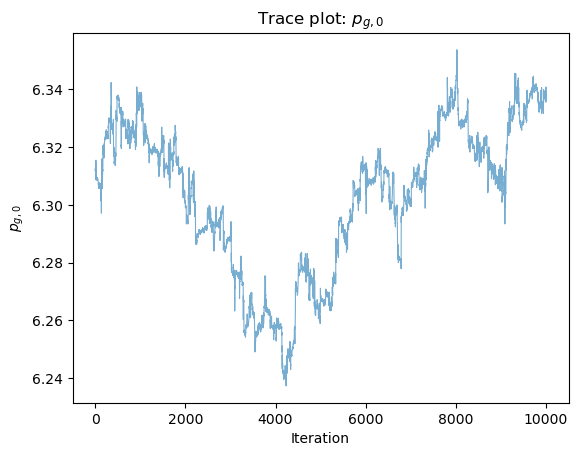

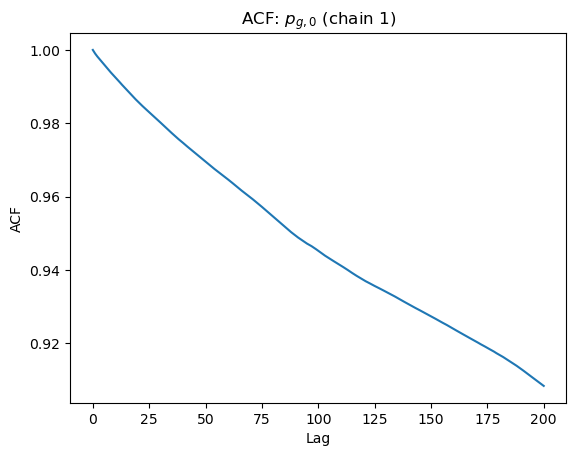

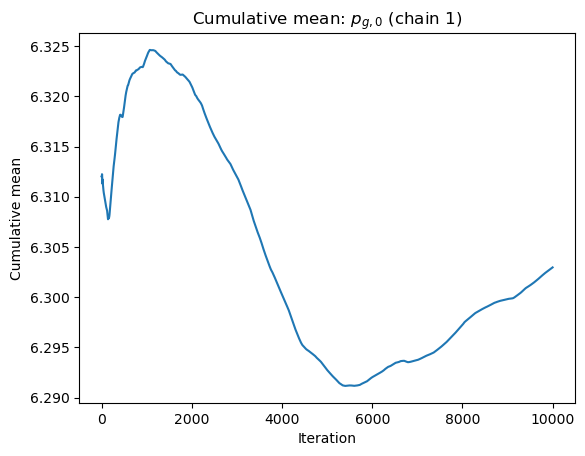

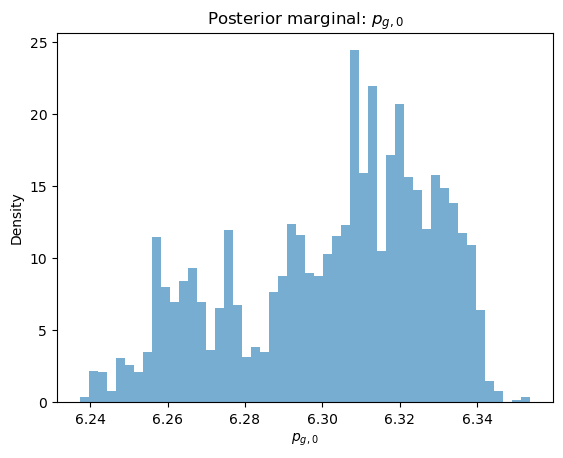

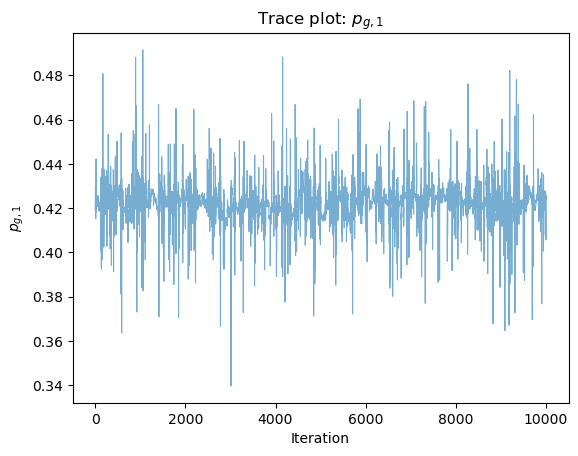

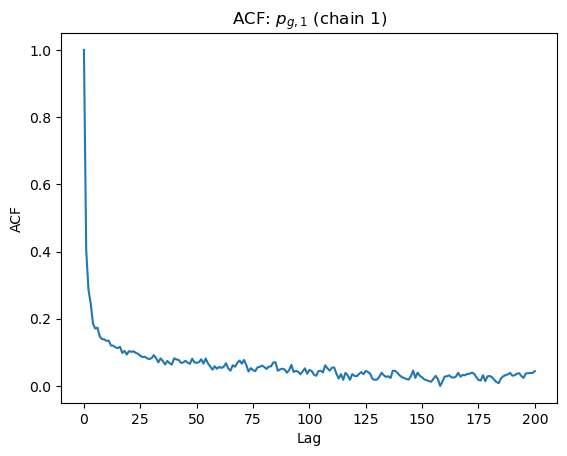

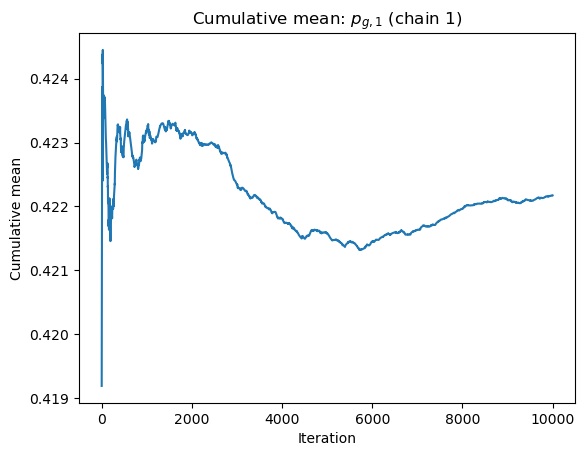

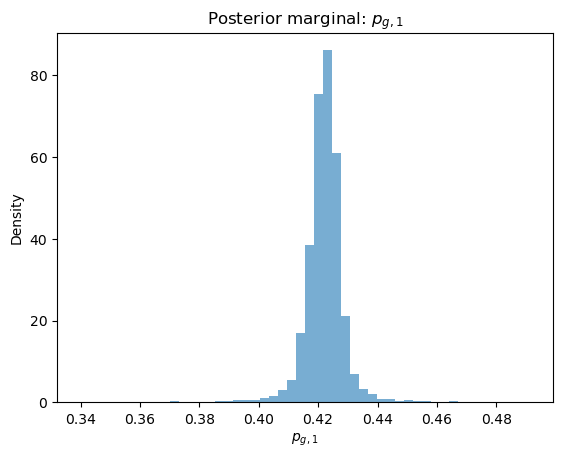

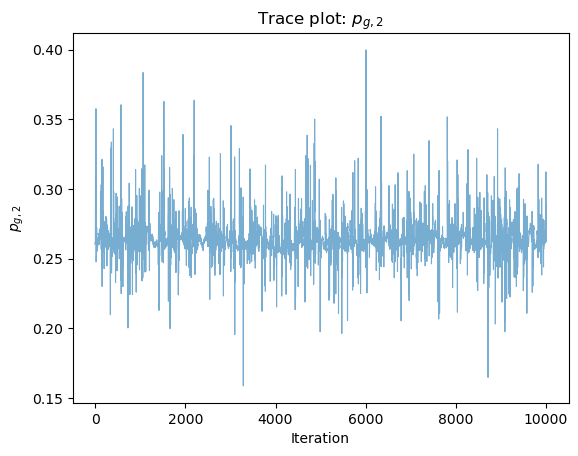

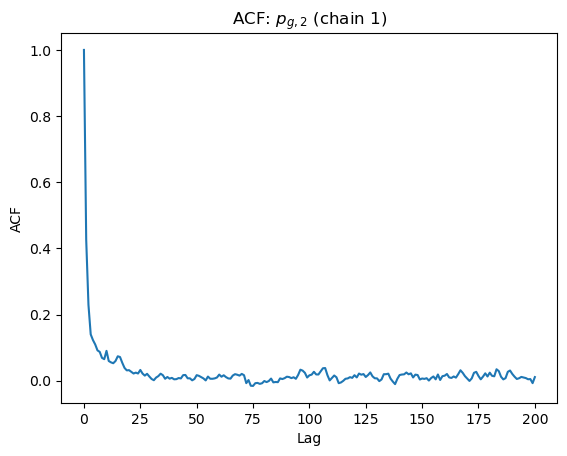

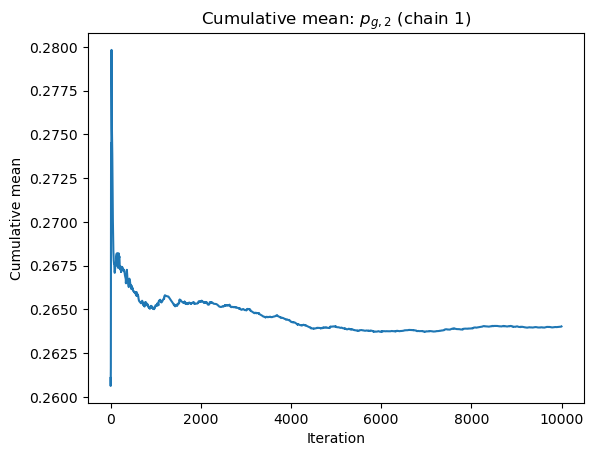

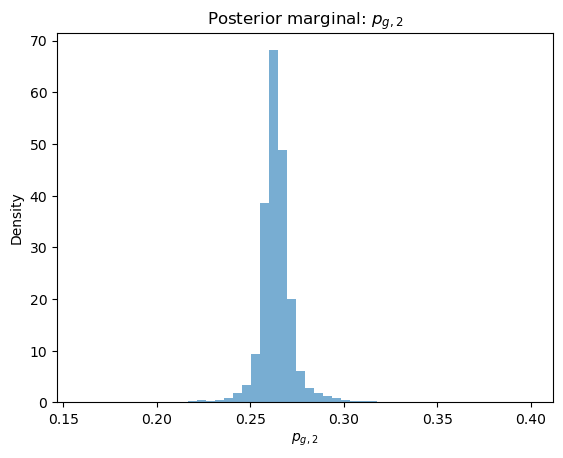

{'$p_{g,0}$': {'ESS_min': 4.385964320698257,
  'ESS_median': 4.385964320698257,
  'Rhat_split': 1.174851034385282},
 '$p_{g,1}$': {'ESS_min': 184.4583312591175,
  'ESS_median': 184.4583312591175,
  'Rhat_split': 1.007088368353538},
 '$p_{g,2}$': {'ESS_min': 1613.123017628885,
  'ESS_median': 1613.123017628885,
  'Rhat_split': 0.9999030113609629},
 '$p_{g,3}$': {'ESS_min': 2086.37798502207,
  'ESS_median': 2086.37798502207,
  'Rhat_split': 0.9999017838677975}}

In [9]:
diagnostics(all_gain_samples[0], param_names=[r"$p_{g,0}$", r"$p_{g,1}$",r"$p_{g,2}$",r"$p_{g,3}$"])